<span style="color:red; font-family:Helvetica Neue, Helvetica, Arial, sans-serif; font-size:2em;">An Exception was encountered at '<a href="#papermill-error-cell">In [48]</a>'.</span>

In [1]:
import logging
logger = logging.getLogger('retrain_ipynb')
logger.setLevel(logging.DEBUG)


ch = logging.StreamHandler()
ch.setLevel(logging.INFO)
formatter = logging.Formatter('%(levelname)s - %(asctime)s - %(name)s - %(message)s')
ch.setFormatter(formatter)
logger.addHandler(ch)
logger.debug('--=logging started=--')



# Config

In [2]:
import sys
TRAIN = True
TRAIN_MODEL_3 = False
IN_COLAB = 'google.colab' in sys.modules
print ('Running in colab:', IN_COLAB)

Running in colab: False


In [3]:
import os

if not IN_COLAB:
  nb_dir = os.path.split(os.getcwd())[0]
  if nb_dir not in sys.path:
      sys.path.append(nb_dir)
else:
  %tensorflow_version 1.x
  import tensorflow as tf
  print(tf.__version__)

In [4]:
if IN_COLAB:
  !pip install --upgrade pip
  !pip --version
  !pip install --no-deps --upgrade git+https://www.github.com/nemoware/analyser.git@uber-models
  !pip install -q pyjarowinkler overrides
  

In [5]:
import os
import random
import math
import json
import warnings

from os import path
from pathlib import Path
import analyser.hyperparams

training_reports_path = Path(analyser.hyperparams.__file__).parent.parent / 'training_reports/'

if not IN_COLAB:
    _work_dir_default = os.path.realpath(os.path.join(  analyser.hyperparams.__file__, '..', '..', '..', 'work'))
    work_dir = os.environ.get('GPN_WORK_DIR', _work_dir_default)

    if not os.path.isdir(work_dir):
        os.mkdir(work_dir)

    analyser.hyperparams.work_dir = work_dir
else:

    from google.colab import drive
    drive.mount('/content/drive')
    os.environ['GPN_WORK_DIR']='/content/drive/My Drive/GazpromOil/trainsets/uber_2'
    analyser.hyperparams.work_dir = os.environ['GPN_WORK_DIR']

print('work_dir=', analyser.hyperparams.work_dir)


assert os.path.isdir(analyser.hyperparams.work_dir)

Nemoware Analyser v23.1.27.1
USING WORKDIR: [/root/artem/work]
 set ENV GPN_WORK_DIR to override
datasets_dir: [/root/artem/work/datasets]
reports_dir: [/root/artem/work/reports]
work_dir= /root/artem/work


/root/artem/analyser/analyser/hyperparams.py:15: UserWarning: please set GPN_WORK_DIR environment variable
  warnings.warn('please set GPN_WORK_DIR environment variable')


# loss: 0.03

# Imports

In [6]:
%matplotlib inline
import tensorflow as tf
print(tf.__version__)

 


import seaborn as sns
import matplotlib.pyplot as plt
from IPython.core.display import display, HTML

from colab_support.renderer import *

import pickle
import numpy as np
import pandas as pd

from bson import json_util

from analyser.legal_docs import LegalDocument, make_headline_attention_vector
from analyser.headers_detector import make_predicted_headline_attention_vector, get_tokens_features
from analyser.hyperparams import models_path
from analyser.text_tools import find_top_spans
from analyser.persistence import DbJsonDoc

from trainsets.trainset_tools import TrainsetBalancer, SubjectTrainsetManager
from trainsets.retrain_contract_uber_model import UberModelTrainsetManager

from tf_support import super_contract_model
from tf_support.super_contract_model import get_base_model, semantic_map_keys_contract
from tf_support.super_contract_model import uber_detection_model_005_1_1
from tf_support.tf_subject_model import decode_subj_prediction
from tf_support.tools import KerasTrainingContext
# from tf_support.embedder_elmo import ElmoEmbedder


from keras.utils.vis_utils import model_to_dot
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
 
from keras.models import load_model


from tensorflow import keras
import keras.backend as K
from keras.layers import Conv1D, LSTM, GRU, BatchNormalization, TimeDistributed, Dense, Bidirectional, Input, Dropout, Lambda
from keras.layers import concatenate, SpatialDropout1D, ActivityRegularization
from keras.layers import MaxPooling1D, Activation, ThresholdedReLU, GaussianNoise

from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, CSVLogger
from keras.models import Sequential, Model

# from keras.utils import plot_model
from keras.preprocessing.sequence import pad_sequences


2023-01-27 18:28:32.211857: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0


2.5.0


/tmp/ipykernel_3154318/3340962001.py:10: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML


HyperParameters.subsidiary_name_match_min_jaro_similarity 0.9649122807017544


[currencies.py:17 -             _env_var() ] Currency-service : define GPN_CURRENCY_USER environment variable! defaulting to None


[currencies.py:17 -             _env_var() ] Currency-service : define GPN_CURRENCY_PASSWORD environment variable! defaulting to None


[currencies.py:17 -             _env_var() ] Currency-service : define GPN_CURRENCY_URL environment variable! defaulting to None


[documents.py:270 -             __init__() ] loading word cases stats model from: /root/artem/analyser/analyser/vocab/word_cases_stats.pickle


[tools.py:29 -             __init__() ] model_checkpoint_path: /root/artem/analyser/analyser/vocab


In [7]:
print('training_reports_path=', training_reports_path)

training_reports_path= /root/artem/analyser/training_reports


In [8]:
gpu_devices = tf.config.experimental.list_physical_devices('GPU')

for device in gpu_devices:
    print(device)
#     tf.config.experimental.set_memory_growth(device, True)

PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')


2023-01-27 18:28:35.451259: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcuda.so.1
2023-01-27 18:28:35.473844: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-27 18:28:35.474534: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1733] Found device 0 with properties: 
pciBusID: 0000:01:00.0 name: A100-PCIE-40GB computeCapability: 8.0
coreClock: 1.41GHz coreCount: 108 deviceMemorySize: 39.59GiB deviceMemoryBandwidth: 1.41TiB/s
2023-01-27 18:28:35.474550: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0
2023-01-27 18:28:35.474582: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcublas.so.11
2023-01-27 18:28:35.474600: I tensorflow/stream_executor/platform/defa

/default/dso_loader.cc:53] Successfully opened dynamic library libcufft.so.10
2023-01-27 18:28:35.483252: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcurand.so.10
2023-01-27 18:28:35.487577: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcusolver.so.11
2023-01-27 18:28:35.490345: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcusparse.so.11
2023-01-27 18:28:35.490381: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudnn.so.8
2023-01-27 18:28:35.490442: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-27 18:28:35.491316: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS

# Prepare trainset


In [9]:
if not IN_COLAB:
  from integration.db import get_mongodb_connection
  from bson.objectid import ObjectId

  def get_doc(objid):
    db = get_mongodb_connection()
    documents_collection = db['documents']
    jdata = documents_collection.find_one({'_id': ObjectId(objid)})
    return DbJsonDoc(jdata)

In [10]:
if False:
    jdoc = get_doc('5df1f44dec85d861954efc47')
    doc = jdoc.asLegalDoc()
    doc.tokens
    

work_dir = Path(analyser.hyperparams.work_dir)
print(work_dir)

/root/artem/work


In [11]:
# xx = stats.loc[stats['user_correction_date'].notnull()]
# xx = xx[ (xx.version=='3.0.0') | (xx.version=='22.12.7')].sort_values(['score'])
# xx.to_csv('contracts_to_re-analyze.csv')
# xx

In [12]:
# xx = stats.loc[stats['user_correction_date'].notnull()]
# xx['user_correction_date'] = pd.to_datetime(xx['user_correction_date'], utc=True)


# xx['user_correction_date'] = xx['user_correction_date'].astype('datetime64[ns]')


# xx.to_datetime(df_res['DateTime'], utc=True)

# xx['user_correction_date'] = xx['user_correction_date'].dt.tz_localize(None)

# xx.sort_values(['user_correction_date'])

In [13]:
# yy = xx.sort_values(['user_correction_date'])[xx.version!='22.12.7'][xx.source=='db'].sort_values(['score'])
# yy

In [14]:
# stats['user_correction_date'] = stats['user_correction_date'].dt.tz_localize(None)
# stats.sort_values(['user_correction_date'])

In [15]:
# yy.to_csv('contracts_to_review.csv')

In [16]:
umtm = UberModelTrainsetManager (work_dir, reports_dir=training_reports_path)

umtm.load_contract_trainset_meta() # 'contract_trainset_meta.csv'
stats = umtm.stats
stats

source                          checksum   version  \
_id                                                                           
6391b4771864c6df4d29f332     db  22f701119d81787cd423f79f0f9fd9db   22.12.7   
633c360f9d08c565cfa12311     db  e88212da6eb7e31a30a6fea422bc58dc     3.0.0   
6340244c9d08c565cfa12341     db  bc7d70a32aed6af4ef6c7752a1b7674d     3.0.0   
5edbc62eda3678279fbcadf3   file  027a7c30f74ff8ffe684378e9883dd8e     2.0.2   
5ec2b8da665f7603e03b1255     db  3187bfac60ea578221c5d9357756c6c1     1.6.5   
...                         ...                               ...       ...   
62c545b9e599c73b751b78f0     db  0c436cbb0bbd5a592f4087dc5ce3cb51     3.0.0   
63c506d9e2456d59975e1402     db  0b84d66ba1ce7e5f31566388cbd2c90e  23.01.04   
63c506d0e2456d59975e1315     db  ec5cb8db8f4c2bf1a17c39b37c917753  23.01.04   
5efe9280777d4b67a92d56ce   file  02a4101c17ceaa4b9d473f6840ac4d7a     2.0.0   
5f016dee777d4b67a92d5840   file  4ea9485a7c529809ed110d0c77f2e16f     2.0.0   

                                               export_date      len  \
_id                                                                   
6391b4771864c6df4d29f332  2022-12-11 06:49:28.432113+00:00   1990.0   
633c360f9d08c565cfa12311  2022-12-10 06:23:46.684500+00:00   6730.0   
6340244c9d08c565cfa12341  2022-12-10 06:23:47.164630+00:00   6740.0   
5edbc62eda3678279fbcadf3        2023-01-27 18:17:18.515975   1370.0   
5ec2b8da665f7603e03b1255        2023-01-27 18:17:35.303246   5840.0   
...                                                    ...      ...   
62c545b9e599c73b751b78f0  2022-12-10 06:20:43.517109+00:00   1220.0   
63c506d9e2456d59975e1402  2023-01-25 19:04:13.180227+00:00    810.0   
63c506d0e2456d59975e1315  2023-01-25 19:04:19.544482+00:00   1170.0   
5efe9280777d4b67a92d56ce        2023-01-27 18:17:31.398057  14020.0   
5f016dee777d4b67a92d5840        2023-01-27 18:17:31.956093     20.0   

                                             analyze_date         value  \
_id                                                                       
6391b4771864c6df4d29f332 2022-12-08 22:25:50.608000+00:00  1.000000e+11   
633c360f9d08c565cfa12311 2022-10-04 16:33:37.333000+00:00  5.000000e+10   
6340244c9d08c565cfa12341 2022-10-07 16:09:15.340000+00:00  2.000000e+09   
5edbc62eda3678279fbcadf3 2020-07-18 20:24:58.934000+00:00  2.400000e+04   
5ec2b8da665f7603e03b1255 2020-05-18 17:16:38.114000+00:00  2.523632e+07   
...                                                   ...           ...   
62c545b9e599c73b751b78f0 2022-07-06 11:20:39.187000+00:00           NaN   
63c506d9e2456d59975e1402 2023-01-16 11:21:57.571000+00:00           NaN   
63c506d0e2456d59975e1315 2023-01-16 11:59:40.615000+00:00           NaN   
5efe9280777d4b67a92d56ce 2020-07-03 21:47:22.279000+00:00           NaN   
5f016dee777d4b67a92d5840 2020-07-05 14:13:31.165000+00:00           NaN   

                          value_log1p  value_span currency  ... valid  \
_id                                                         ...         
6391b4771864c6df4d29f332    25.328436       483.0      RUB  ...  True   
633c360f9d08c565cfa12311    24.635289       401.0      RUB  ...  True   
6340244c9d08c565cfa12341    21.416413       909.0      RUB  ...  True   
5edbc62eda3678279fbcadf3    10.085851       747.0      RUB  ...  True   
5ec2b8da665f7603e03b1255    17.043795      5674.0      BRL  ...  True   
...                               ...         ...      ...  ...   ...   
62c545b9e599c73b751b78f0          NaN         NaN      NaN  ...  True   
63c506d9e2456d59975e1402          NaN         NaN      NaN  ...  True   
63c506d0e2456d59975e1315          NaN         NaN      NaN  ...  True   
5efe9280777d4b67a92d56ce          NaN         NaN      NaN  ...  True   
5f016dee777d4b67a92d5840          NaN         NaN      NaN  ...  True   

                         documentType subj_len  \
_id                                              
6391b4771864c6df4d29f332     CONTRACT      NaN 

In [17]:
print(len(stats))

2738


In [18]:
from trainsets.trainset_tools import get_feature_log_weights
get_feature_log_weights(umtm.stats, 'subject')

Service                              0.454973
Deal                                 0.572073
Other                                0.586185
Renting                              0.685962
GeneralContract                      0.695394
Loans                                0.715793
AgencyContract                       0.780866
DealIntellectualProperty             0.797691
Charity                              0.848028
Insurance                            0.882033
RealEstate                           0.975393
RealEstateTransactions               1.170933
BankGuarantees                       1.293400
PledgeEncumbrance                    1.293400
ParticipationInOtherOrganizations    1.335062
SecuritiesTransactions               1.851534
AssetTransactions                    2.061281
Name: subject, dtype: float64

# Weights: вычисление весов samples  

чтобы всех запутать, 
 - вес пропорционален логорифму цены контракта (чтобы было меньше ошибок в контрактах на большие суммы)
 - more weight for user-corrected datapoints
 - normalize weights, so the sum == Number of samples

In [19]:
from trainsets.trainset_tools import get_feature_log_weights

stats = umtm.stats
subject_weights = get_feature_log_weights(stats, 'subject')
subject_weights *= subject_weights

for i, row in stats.iterrows():
  subj_name = row['subject']

  sample_weight = 0.5 
  if not pd.isna(row['user_correction_date']):  # more weight for user-corrected datapoints
    sample_weight = 5.0   # TODO: must be estimated anyhow smartly

  value_weight = 1.0
  if not pd.isna(row['value_log1p']):
    # чтобы всех запутать, вес пропорционален логорифму цены контракта
    # (чтобы было меньше ошибок в контрактах на большие суммы)
    value_weight = 1.0 + row['value_log1p']

  sample_weight *=  value_weight 
  subject_weight =  subject_weights[subj_name] 
  stats.at[i, 'subject_weight'] = subject_weight + random.random()
  stats.at[i, 'sample_weight'] = sample_weight + random.random()

# normalize weights, so the sum == Number of samples
stats.sample_weight /= stats.sample_weight.mean()
stats.subject_weight /= stats.subject_weight.mean()

print(stats.sample_weight.mean())
print(stats.subject_weight.mean())
print(stats.sample_weight.min())
print(stats.subject_weight.min())
print(stats.sample_weight.max())
print(stats.subject_weight.max())

stats.to_csv( work_dir / 'contract_trainset_meta.csv', index=True)

subject_weights

1.0000000000000002
1.0000000000000002
0.02119864436497064
0.2471718654341342
5.6454066546829615
6.130108185936628


Service                              0.207000
Deal                                 0.327268
Other                                0.343613
Renting                              0.470543
GeneralContract                      0.483572
Loans                                0.512359
AgencyContract                       0.609751
DealIntellectualProperty             0.636311
Charity                              0.719151
Insurance                            0.777983
RealEstate                           0.951392
RealEstateTransactions               1.371085
BankGuarantees                       1.672882
PledgeEncumbrance                    1.672882
ParticipationInOtherOrganizations    1.782390
SecuritiesTransactions               3.428180
AssetTransactions                    4.248881
Name: subject, dtype: float64

In [20]:
from tf_support.super_contract_model import make_xyw

# from functools import lru_cache

# def _dp_fn(doc_id, suffix):
#     return os.path.join(work_dir, 'datasets', f'{doc_id}-datapoint-{suffix}.npy')



# @lru_cache(maxsize=72)
# def make_xyw(doc_id):

#     row = stats.loc[doc_id]

#     _subj = row['subject']
#     subject_one_hot = ContractSubject.encode_1_hot()[_subj]

#     embeddings =     np.load(_dp_fn(doc_id, 'embeddings'))
#     token_features = np.load(_dp_fn(doc_id, 'token_features'))
#     semantic_map =   np.load(_dp_fn(doc_id, 'semantic_map'))

#     if embeddings.shape[0] != token_features.shape[0]:
#       msg = f'{doc_id} embeddings.shape {embeddings.shape} is incompatible with token_features.shape {token_features.shape}'
#       raise AssertionError(msg)

#     if embeddings.shape[0] != semantic_map.shape[0]:
#       msg = f'{doc_id} embeddings.shape {embeddings.shape} is incompatible with semantic_map.shape {semantic_map.shape}'
#       raise AssertionError(msg)

#     stats.at[doc_id, 'error'] = None
    
#     return (
#       (embeddings, token_features),
#       (semantic_map, subject_one_hot),
#       (row['sample_weight'], row['subject_weight']))

# Validating training set

In [21]:
%%time


from tf_support.super_contract_model import  validate_datapoint

stats['valid'] = True
stats['error'] = ''

for i in stats.index:
  
  try:
    validate_datapoint(str(i), stats)

  except Exception as e:
    logger.error(e)

    stats.at[i, 'valid'] = False
    stats.at[i, 'error'] = str(e)
    
stats

 


umtm.stats = umtm.stats[  pd.isna(umtm.stats.value_span) + (umtm.stats.value_span < 10000) ] #remove big docs from TS
stats_valid = stats[stats['valid']]
del stats
print(len(stats_valid))
umtm.stats = stats = stats_valid

2738
CPU times: user 3.36 s, sys: 18.1 s, total: 21.4 s
Wall time: 1min 2s


/root/artem/env/lib/python3.8/site-packages/pandas/core/computation/expressions.py:203: UserWarning: evaluating in Python space because the '+' operator is not supported by numexpr for the bool dtype, use '|' instead
  warnings.warn(


In [22]:
len(stats_valid)

2738

In [23]:
print(stats.sample_weight.mean())
print(stats.subject_weight.mean())

stats.sample_weight /= stats.sample_weight.mean()
stats.subject_weight /= stats.subject_weight.mean()


print(stats.subject_weight.mean())
print(stats.subject_weight.min())

print('\n\nsample_weight')
print('MIN\t', stats.sample_weight.min())
print('MEAN\t', stats.sample_weight.mean())


1.0000000000000002
1.0000000000000002
0.9999999999999999
0.24717186543413414


sample_weight
MIN	 0.021198644364970636
MEAN	 0.9999999999999999


/root/artem/env/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


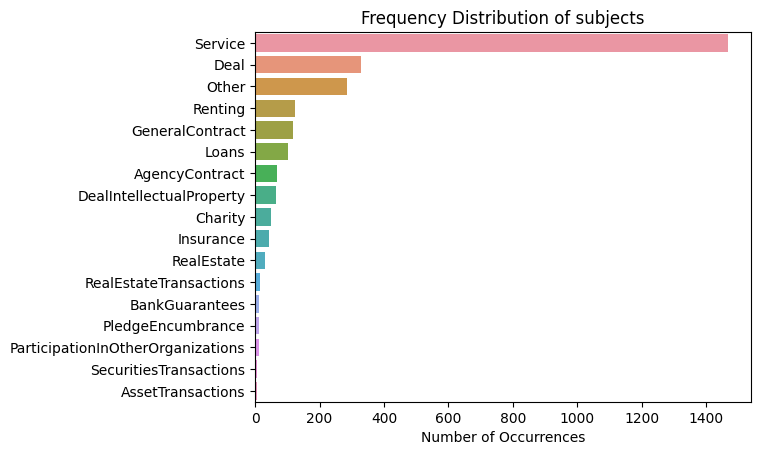


min 4
max 1467
total 2738


In [24]:
%matplotlib inline

subj_count = stats_valid['subject'].value_counts()

#plot distribution---------------------
sns.barplot(subj_count.values, subj_count.index)
plt.title('Frequency Distribution of subjects')
plt.xlabel('Number of Occurrences')
plt.show()


print ('\nmin', min (subj_count.values))
print ('max', max (subj_count.values))
print ('total', sum (subj_count.values))

In [25]:
from sklearn.utils import class_weight
from trainsets.trainset_tools import get_feature_log_weights

_classes = stats_valid['subject'].unique().tolist()

print(f'classes: {_classes}')

# class_weights = class_weight.compute_class_weight('balanced', _classes, umtm.stats['subject'])
# class_weights = dict(zip(_classes, class_weights))


class_weights = get_feature_log_weights(stats_valid, 'subject')
class_weights

classes: ['BankGuarantees', 'Loans', 'AgencyContract', 'Service', 'Charity', 'SecuritiesTransactions', 'Renting', 'PledgeEncumbrance', 'DealIntellectualProperty', 'AssetTransactions', 'Deal', 'GeneralContract', 'ParticipationInOtherOrganizations', 'Insurance', 'RealEstateTransactions', 'RealEstate', 'Other']


Service                              0.454973
Deal                                 0.572073
Other                                0.586185
Renting                              0.685962
GeneralContract                      0.695394
Loans                                0.715793
AgencyContract                       0.780866
DealIntellectualProperty             0.797691
Charity                              0.848028
Insurance                            0.882033
RealEstate                           0.975393
RealEstateTransactions               1.170933
BankGuarantees                       1.293400
PledgeEncumbrance                    1.293400
ParticipationInOtherOrganizations    1.335062
SecuritiesTransactions               1.851534
AssetTransactions                    2.061281
Name: subject, dtype: float64

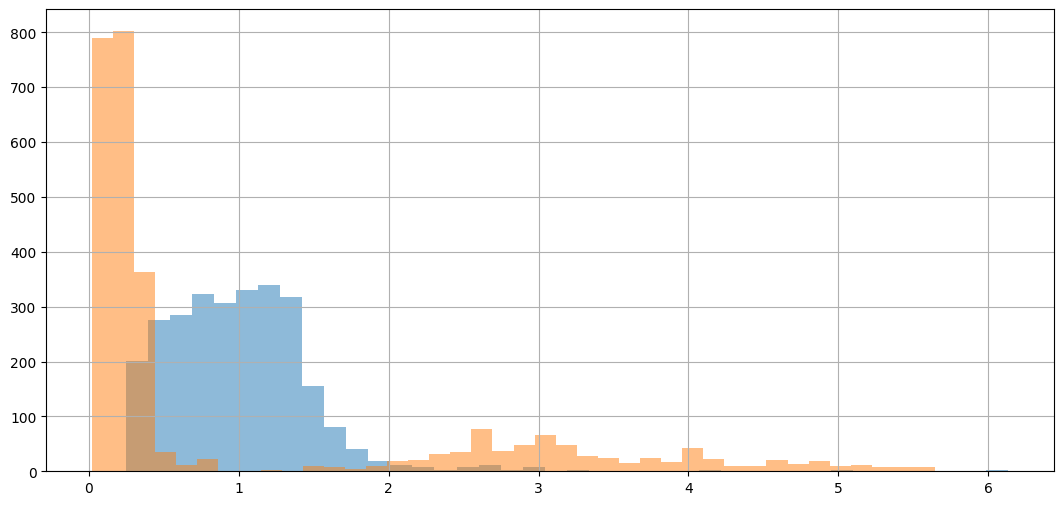

In [26]:
from trainsets.trainset_tools import get_feature_log_weights
 

plt.figure(figsize=(13, 6))

stats_valid['subject_weight'].hist(bins=40, alpha=0.5)
stats_valid['sample_weight'].hist(bins=40, alpha=0.5)

plt.xscale('linear') # log?
plt.show()

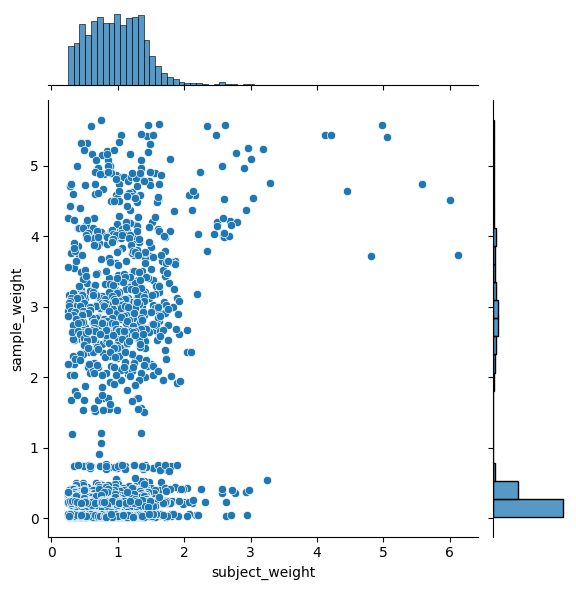

In [27]:
sns.jointplot(x="subject_weight", y="sample_weight", data=stats_valid)
plt.show()

# look into trainset (take a sample)

SAMPLE_DOC_ID 5fe34f62b770574a005553be
semantic map shape is: (759, 30)


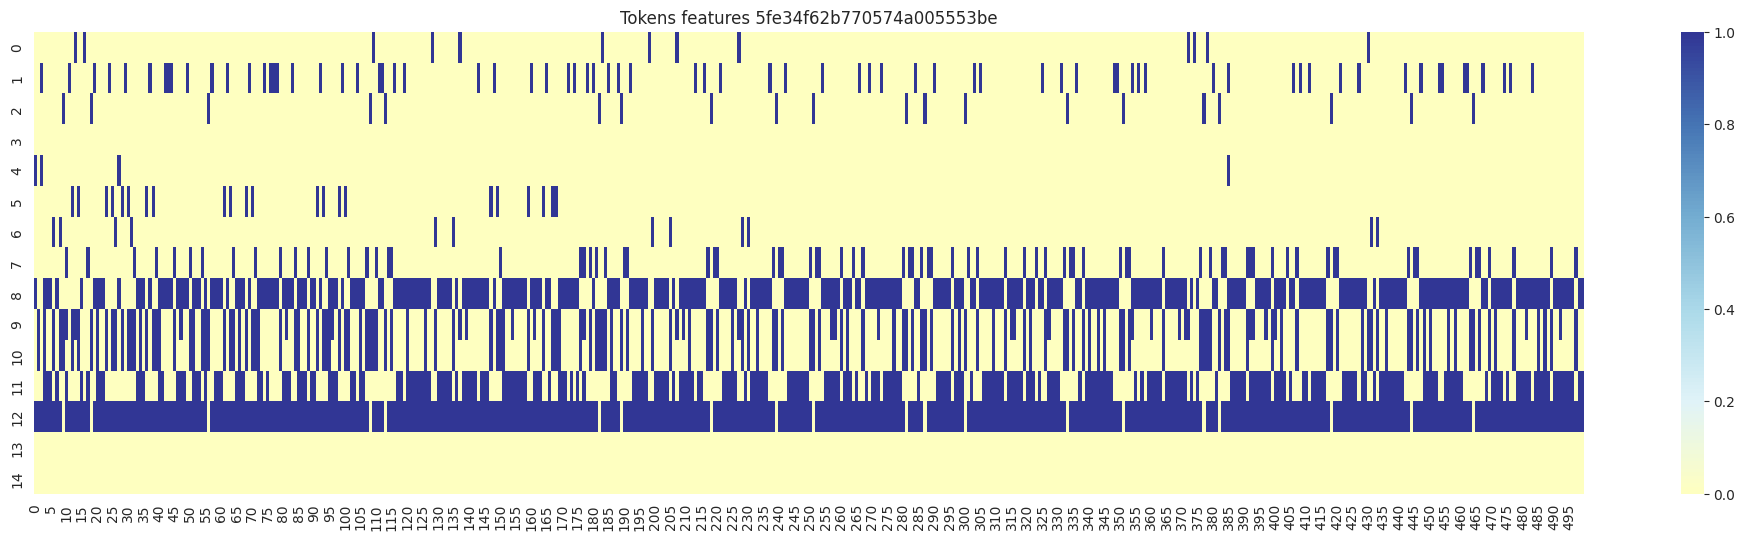

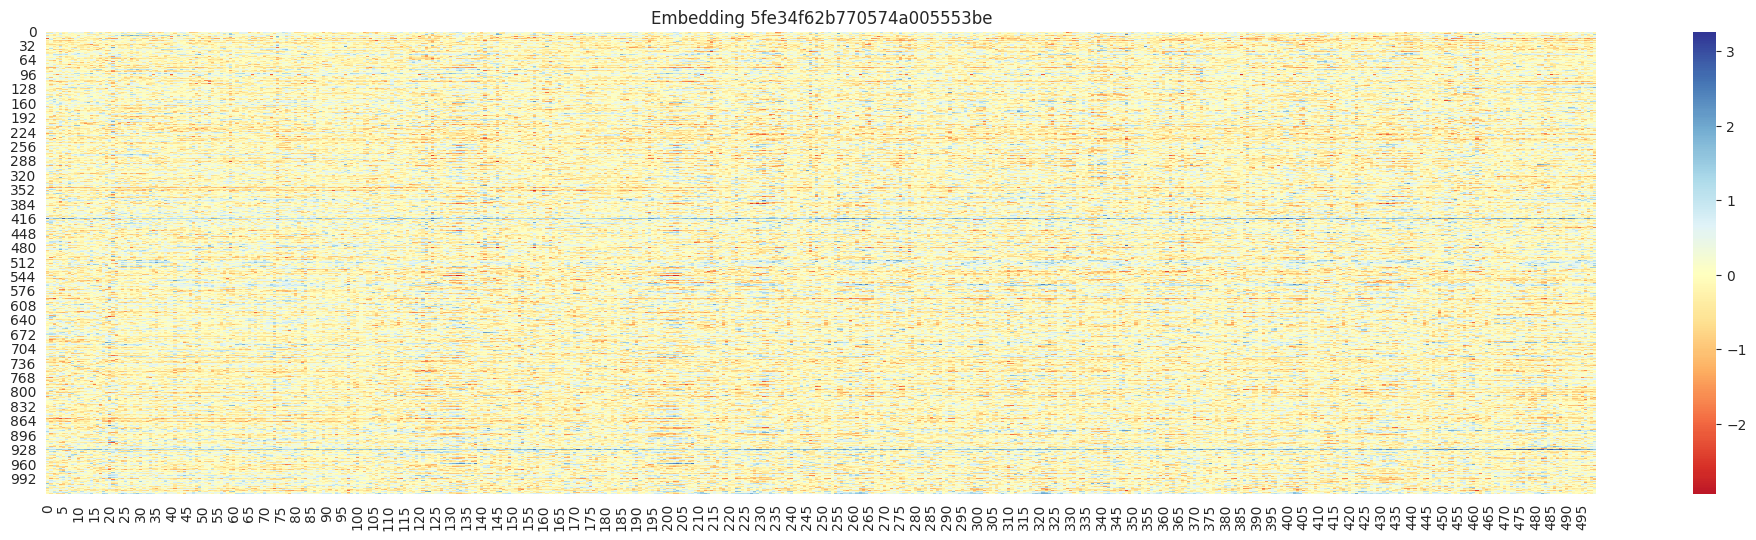

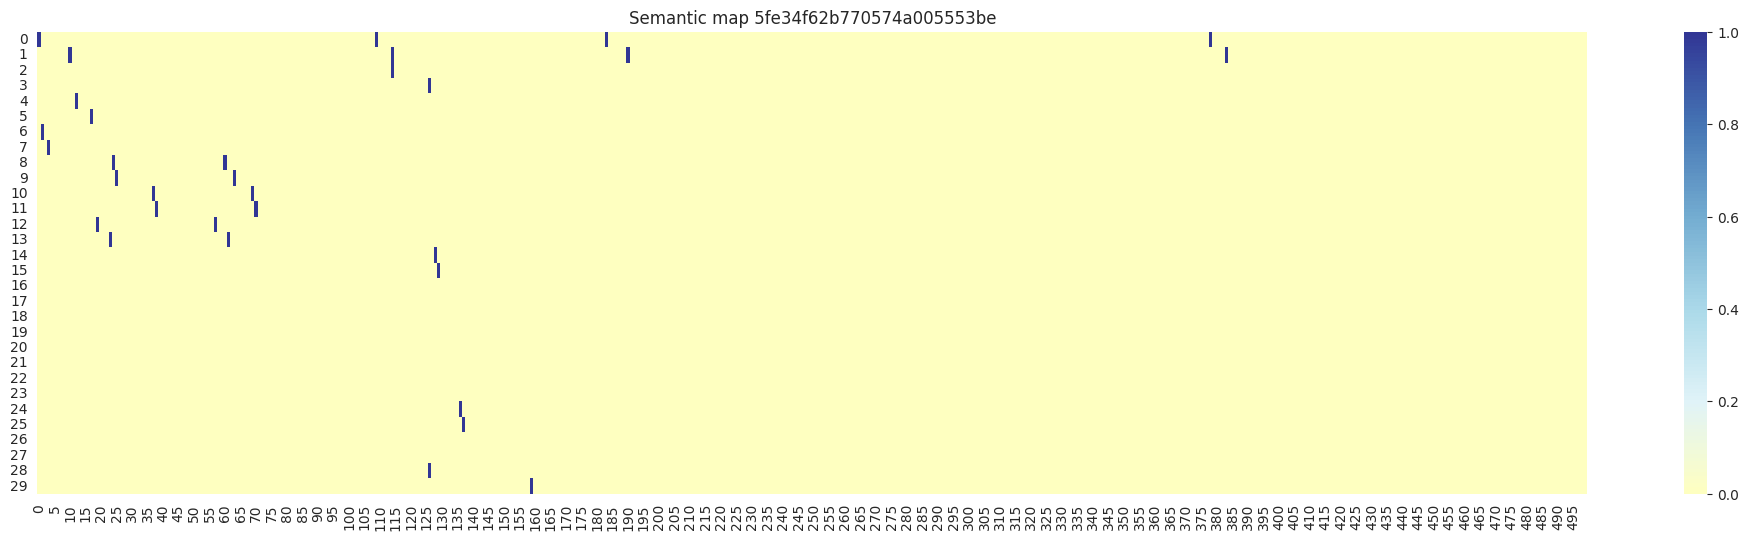

In [28]:
%matplotlib inline
# umtm.calculate_samples_weights()
SAMPLE_DOC_ID = '5fe34f62b770574a005553be' #stats_valid.index[1]

print('SAMPLE_DOC_ID', SAMPLE_DOC_ID)
(emb, tok_f), (sm, subj), (sample_weight, subject_weight) = make_xyw(SAMPLE_DOC_ID, stats)
 
    
print('semantic map shape is:', sm.shape)
_crop = 500
plot_embedding(tok_f[:_crop], title=f'Tokens features {SAMPLE_DOC_ID}') 
plot_embedding(emb[:_crop], title=f'Embedding {SAMPLE_DOC_ID}') 
plot_embedding(sm[:_crop], title=f'Semantic map {SAMPLE_DOC_ID}')



# Batch generator & TODOs 🙏


- [X] TODO: add outliers to the trainset ?
- [ ] TODO: try sparse_categorical_entropy instead of one-hot encodings
- [ ] TODO: model 5.2, 5.1: bipolar concat layer is wrong because we concatenate thongs of different magnitudes. Add a Sigmoid activation layer
- [ ] TODO: chechk what is better: to pad with zeros or to pad with means
- [X] TODO: add weights to samples
- [ ] TODO: sum semantic map alongside vertical axis, and mutiply it (as a mask) by the subject detection seq
- [ ] TODO: introduce individual per tag threshosholds, also, the current 0.3 threshold is strange.

In [29]:
stats_valid = stats_valid[stats_valid.documentType != 'ANNEX']

3
semantic map shape is: (14, 543, 30)


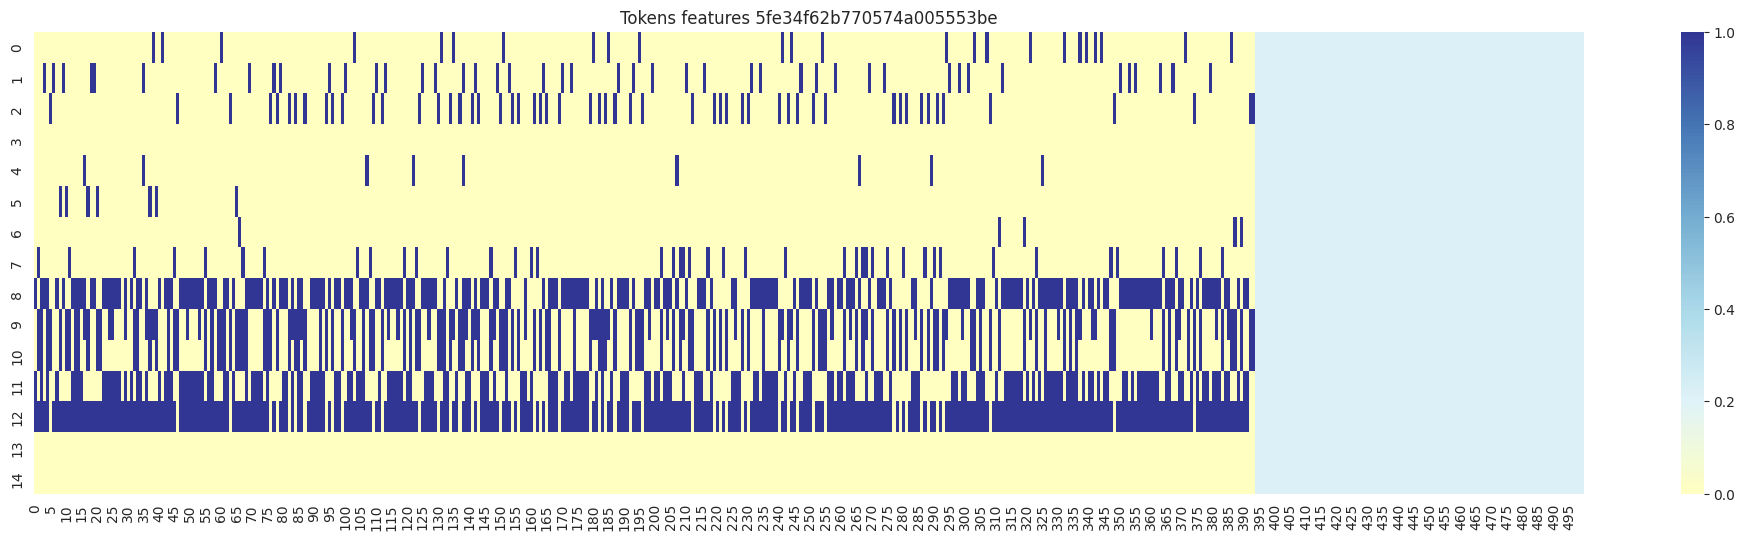

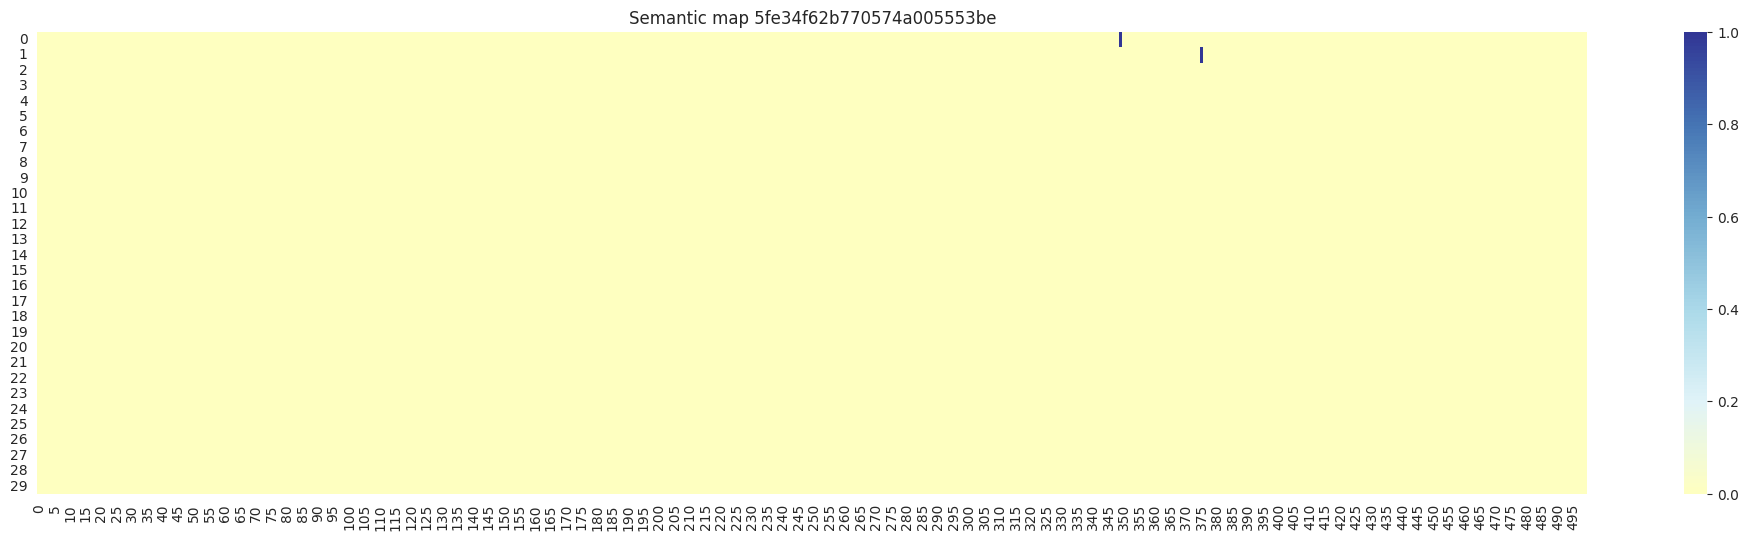

In [30]:
import numpy as np
import random
import pandas as pd

def make_generator(self, indices: [int], batch_size: int, augment_samples=False):
  np.random.seed(43)

  while True:
    # next batch
    batch_indices = np.random.choice(a=indices, size=batch_size)

    max_len = 128 * 12
    start_from = 0

    if augment_samples:
      max_len = random.randint(300, 1400)

    batch_input_emb = []
    batch_input_token_f = []
    batch_output_sm = []
    batch_output_subj = []

    weights = []
    weights_subj = []

    # Read in each input, perform preprocessing and get labels
    for doc_id in batch_indices:

      dp = make_xyw(doc_id, stats)
      (emb, tok_f), (sm, subj), (sample_weight, subject_weight) = dp
        
#       print(dp)
    
      subject_weight_K = 1.0
      if augment_samples:
        start_from = 0

        row = stats_valid.loc[doc_id]
        if random.random() < 0.4:  # 40% of samples
          segment_center = random.randint(0, len(emb) - 1)  ##select random token as a center
          if not pd.isna(row['value_span']) and random.random() < 0.7:
            segment_center = int(row['value_span'])

          _off = random.randint(max_len // 4, max_len // 2)
          start_from = segment_center - _off
          if start_from < 0:
            start_from = 0
          subject_weight_K = 0.1  # lower subject weight because there mighе be no information about subject around doc. value
        
      dp = self.trim_maxlen(dp, start_from, max_len)
      
      # TODO: find samples maxlen

      (emb, tok_f), (sm, subj), (sample_weight, subject_weight) = dp
#       print((sample_weight, subject_weight))
      subject_weight *= subject_weight_K

      batch_input_emb.append(emb)
      batch_input_token_f.append(tok_f)

      batch_output_sm.append(sm)
      batch_output_subj.append(subj)

      if np.isnan(sample_weight):
        raise ValueError()

      if np.isnan(subject_weight):
        raise ValueError()
      
      weights.append(sample_weight)
      weights_subj.append(subject_weight)
      # end if emb
    # end for loop

    # Returns a tuple of (input, output, weights) to feed the network
#     print('batch_output_subj', len(batch_output_subj))
#     print('batch_output_sm', len(batch_output_subj))

    yield ([np.array(batch_input_emb), np.array(batch_input_token_f)],
           [np.array(batch_output_sm), np.array(batch_output_subj)],
           [np.array(weights), np.array(weights_subj)])
    

    
_train, _test = train_test_split(stats_valid, test_size=0.10, stratify=stats_valid[['subject']])

train_indices = list(_train.index)
test_indices = list(_test.index)

    
####---test
_gen = make_generator(umtm, train_indices, 14, augment_samples=True)

sample = next(_gen)
print(len(sample))
del _gen
 


(emb, tok_f), (sm, subj), (sample_weight, subject_weight) = sample
 
    
print('semantic map shape is:', sm.shape)
_crop = 500
plot_embedding(tok_f[0][:_crop], title=f'Tokens features {SAMPLE_DOC_ID}') 
# plot_embedding(emb[:_crop],   title=f'Embedding {SAMPLE_DOC_ID}') 
plot_embedding(sm[0][:_crop],    title=f'Semantic map {SAMPLE_DOC_ID}')

train_indices[0]: 63ce4aeee83d1ee490f3fe90
test_indices[0]: 615aa97d8f3b0514f3f423e4


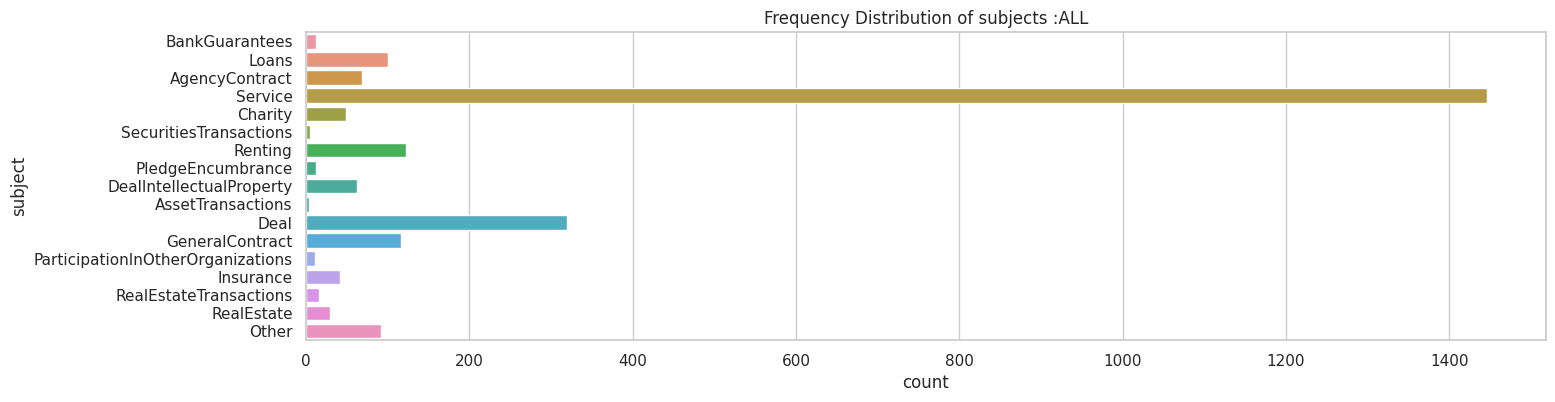

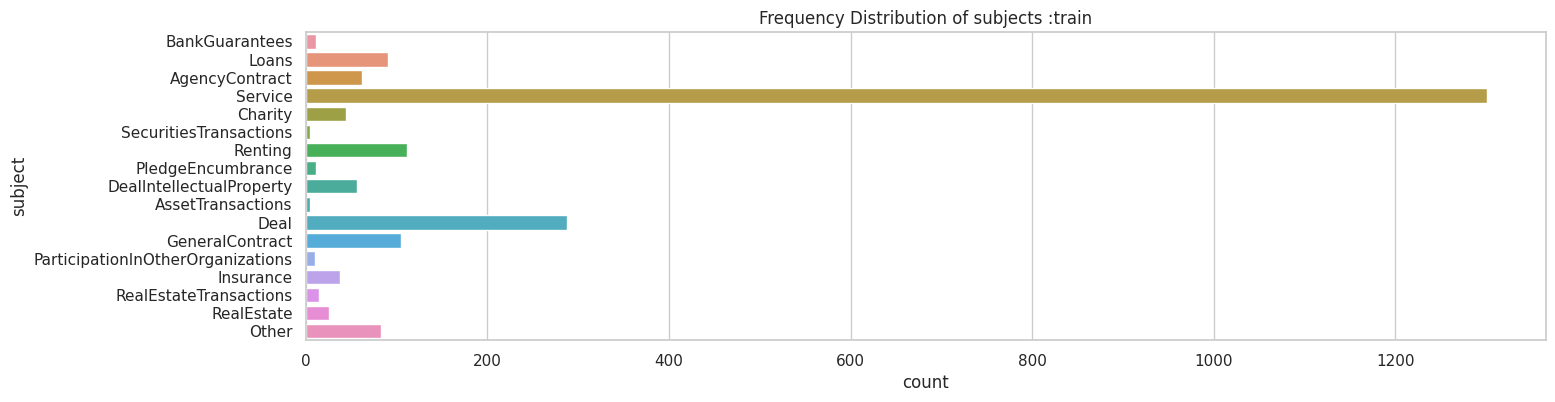

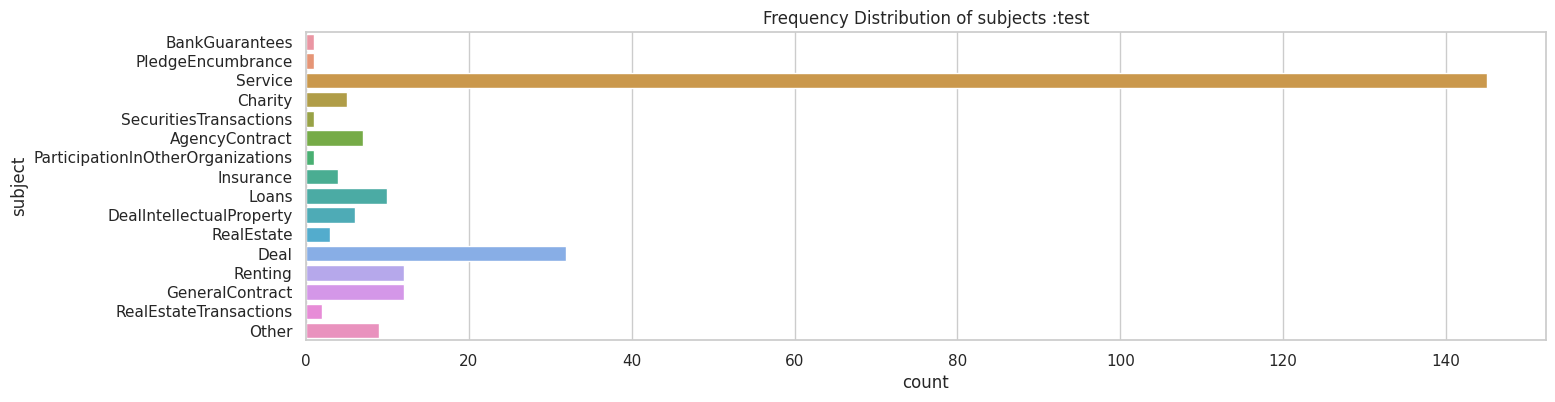

In [31]:
EPOCHS = 50
BATCH_SIZE = 128
EMB =  1024
 
_SELFTEST = True


print('train_indices[0]:', train_indices[0])
print('test_indices[0]:', test_indices[0])


def plot_subject_distr(df, title):  
  target='subject'
  plt.figure(figsize=(16,4))   
  sns.set(style="whitegrid")
  chart = sns.countplot(data=df, y=target)
  plt.title(f'Frequency Distribution of subjects :{title}')

 
plot_subject_distr(stats_valid, 'ALL')
plot_subject_distr(stats_valid[stats_valid.index.isin(train_indices)], 'train')
plot_subject_distr(stats_valid[stats_valid.index.isin(test_indices)], 'test')


if _SELFTEST:
  # test_gen = make_generator(umtm, test_indices, BATCH_SIZE)
  train_gen = make_generator(umtm, train_indices, BATCH_SIZE, augment_samples=True)
  
  x, y, w = next(train_gen)
  
#   print('X:', len(x), 'X[0]=', x[0].shape, 'X[1]=', x[1].shape)
#   print('Y:', len(y), 'Y[0]=', y[0].shape, 'Y[1]=', y[1].shape)
  

#   plot_embedding(x[0][0], 'X2: Token Embeddings')
#   plot_embedding(x[1][0], 'X1: Token Features')
#   plot_embedding(y[0][0], 'Y: Semantic Map')
  
#   print(y[0][1])

#   del x
#   del w
#   del y
#   del train_gen

In [32]:

ctx = KerasTrainingContext(checkpoints_path=umtm.reports_dir, session_index=1)

ctx.set_batch_size_and_trainset_size(BATCH_SIZE, 
                                     len(test_indices), 
                                     4 * len(train_indices))

DEFAULT_TRAIN_CTX = ctx
CLASSES = 43
FEATURES = 14

metrics = ['kullback_leibler_divergence', 'mse', 'binary_crossentropy']


def train(umodel):
  test_gen = make_generator(umtm, test_indices, BATCH_SIZE)
  train_gen = make_generator(umtm, train_indices, BATCH_SIZE, augment_samples=True) 
  ctx.train_and_evaluate_model(umodel, generator=train_gen, test_generator=test_gen)

def overtrain(umodel):
  test_gen = make_generator(umtm, list(train_indices) + list(test_indices), BATCH_SIZE)
  train_gen = make_generator(umtm, list(train_indices) + list(test_indices), BATCH_SIZE, augment_samples=True) 
  ctx.train_and_evaluate_model(umodel, generator=train_gen, test_generator=test_gen)


[tools.py:29 -             __init__() ] model_checkpoint_path: /root/artem/analyser/training_reports


batch_size:	128
train_samples:	9032
test_samples:	251
steps_per_epoch:	70
validation_steps:	35


# Models 🦖

In [33]:
def get_weights_filename(model_factory_fn):
    weights = ctx.model_checkpoint_path / f'{model_factory_fn.__name__}.h5'
    print(weights.is_file(), weights)
    if not weights.is_file():
        weights = Path(analyser.hyperparams.models_path) / f'{model_factory_fn.__name__}.h5'
        print(weights.is_file(), weights)
    
    return weights

# get_weights_filename(uber_detection_model_005_1_1)

## Train from 0 uber_detection_model_003

In [34]:
if TRAIN_MODEL_3:
    from tf_support.super_contract_model import uber_detection_model_003
    
    model_factory_fn = uber_detection_model_003
    umodel = ctx.init_model(model_factory_fn, trained=True, trainable=True, load_weights=False )

    umodel.summary()

    if TRAIN:
      test_gen = make_generator(umtm, test_indices, BATCH_SIZE)
      train_gen = make_generator(umtm, train_indices, BATCH_SIZE, augment_samples=True) 

      ctx.EPOCHS = 10
      ctx.EVALUATE_ONLY = False
      ctx.train_and_evaluate_model(umodel, generator=train_gen, test_generator=test_gen, retrain=True)

## Continue training 003 from checkpoint

In [35]:
analyser.hyperparams.models_path

'/root/artem/analyser/analyser/vocab'

In [36]:
if TRAIN_MODEL_3:
    
    model_factory_fn = uber_detection_model_003

    weights = get_weights_filename(model_factory_fn)
    umodel = ctx.init_model(model_factory_fn, trained=True, trainable=True, weights=weights)

    if TRAIN:
      test_gen = make_generator(umtm, test_indices, BATCH_SIZE)
      train_gen = make_generator(umtm, train_indices, BATCH_SIZE, augment_samples=True) 

      ctx.EPOCHS = 25
      ctx.EVALUATE_ONLY = False
      ctx.train_and_evaluate_model(umodel, generator=train_gen, test_generator=test_gen, retrain=True)

## Overtrain 003

In [37]:
if TRAIN_MODEL_3:
    if TRAIN:
      ctx.unfreezeModel(umodel)
      umodel.compile(loss=super_contract_model.losses, optimizer='Adam', metrics=super_contract_model.metrics)
      print(super_contract_model.losses)
      umodel.summary()

      ctx.EPOCHS = 12
      ctx.EVALUATE_ONLY = False

      test_gen = make_generator(umtm, train_indices, BATCH_SIZE)
      train_gen = make_generator(umtm, train_indices + test_indices, BATCH_SIZE, augment_samples=True) 

      ctx.train_and_evaluate_model(umodel, train_gen, test_generator=test_gen, retrain=False, lr=2e-5)

## 005 model
- 0.0233: last val subject loss
- 0.0016: last tagging loss
- 0.0248: last val loss


In [38]:
if TRAIN_MODEL_3:
    model_factory_fn = uber_detection_model_005_1_1
    umodel = ctx.init_model(model_factory_fn, trained=True, trainable=True, load_weights=False )

    umodel.summary()

    if TRAIN:
      test_gen = make_generator(umtm, test_indices, BATCH_SIZE)
      train_gen = make_generator(umtm, train_indices, BATCH_SIZE, augment_samples=True) 

      ctx.EPOCHS = 20
      ctx.EVALUATE_ONLY = False
      ctx.train_and_evaluate_model(umodel, generator=train_gen, test_generator=test_gen, retrain=True)

### 5.1.1 💕💕 uber_detection_model_005_1_1

In [39]:
from tf_support.super_contract_model import FEATURES 
from analyser.headers_detector import TOKEN_FEATURES

from tf_support.super_contract_model import sigmoid_focal_crossentropy, losses

import numpy as np
from pandas import DataFrame 



model_factory_fn = uber_detection_model_005_1_1
weights = get_weights_filename(model_factory_fn)
umodel = ctx.init_model(model_factory_fn, trained=True, trainable=True, weights=weights)

True /root/artem/analyser/training_reports/uber_detection_model_005_1_1.h5


2023-01-27 18:29:50.728644: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-01-27 18:29:50.729591: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-27 18:29:50.730332: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1733] Found device 0 with properties: 
pciBusID: 0000:01:00.0 name: A100-PCIE-40GB computeCapability: 8.0
coreClock: 1.41GHz coreCount: 108 deviceMemorySize: 39.59GiB deviceMemoryBandwidth: 1.41TiB/s
2023-01-27 18:29:50.730401: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there

[tools.py:121 -           init_model() ] weights loaded: /root/artem/analyser/training_reports/uber_detection_model_005_1_1.h5


In [40]:
######################
# Phase I retraining
# ❄️ frozen bottom layers
######################

if TRAIN:
  test_gen = make_generator(umtm, test_indices, BATCH_SIZE)
  train_gen = make_generator(umtm, train_indices, BATCH_SIZE, augment_samples=True) 

  ctx.EPOCHS = 10
  ctx.EVALUATE_ONLY = False
  ctx.train_and_evaluate_model(umodel, generator=train_gen, test_generator=test_gen, retrain=True)

/root/artem/env/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:1940: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


model.name == uber_detection_model_005_1_1
continue: lr:0.0010000000474974513, epoch:0


2023-01-27 18:29:53.946608: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 538443776 exceeds 10% of free system memory.
2023-01-27 18:29:54.155858: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:176] None of the MLIR Optimization Passes are enabled (registered 2)
2023-01-27 18:29:54.173936: I tensorflow/core/platform/profile_utils/cpu_utils.cc:114] CPU Frequency: 3699850000 Hz


Epoch 1/10


2023-01-27 18:29:57.872662: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 538443776 exceeds 10% of free system memory.
2023-01-27 18:29:58.136425: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudnn.so.8


2023-01-27 18:29:58.990321: I tensorflow/stream_executor/cuda/cuda_dnn.cc:359] Loaded cuDNN version 8500


2023-01-27 18:29:59.697395: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 397410304 exceeds 10% of free system memory.
2023-01-27 18:29:59.934926: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcublas.so.11
2023-01-27 18:29:59.935371: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcublasLt.so.11


2023-01-27 18:30:00.311634: I tensorflow/stream_executor/cuda/cuda_blas.cc:1838] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


 1/70 [..............................] - ETA: 7:51 - loss: 0.0230 - O1_tagging_loss: 0.0103 - O2_subject_loss: 0.0126 - O1_tagging_kullback_leibler_divergence: 0.2103 - O1_tagging_mse: 5.0044e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.4636 - O2_subject_mse: 0.0043 - O2_subject_binary_crossentropy: 0.0191

 2/70 [..............................] - ETA: 21s - loss: 0.0221 - O1_tagging_loss: 0.0101 - O2_subject_loss: 0.0121 - O1_tagging_kullback_leibler_divergence: 0.2210 - O1_tagging_mse: 5.3193e-04 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_kullback_leibler_divergence: 0.5334 - O2_subject_mse: 0.0048 - O2_subject_binary_crossentropy: 0.0208 

2023-01-27 18:30:02.846765: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 408420352 exceeds 10% of free system memory.


 3/70 [>.............................] - ETA: 1:14 - loss: 0.0205 - O1_tagging_loss: 0.0091 - O2_subject_loss: 0.0114 - O1_tagging_kullback_leibler_divergence: 0.2184 - O1_tagging_mse: 5.3215e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.5966 - O2_subject_mse: 0.0053 - O2_subject_binary_crossentropy: 0.0220

2023-01-27 18:30:05.155309: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 423100416 exceeds 10% of free system memory.


 4/70 [>.............................] - ETA: 1:41 - loss: 0.0210 - O1_tagging_loss: 0.0096 - O2_subject_loss: 0.0114 - O1_tagging_kullback_leibler_divergence: 0.2197 - O1_tagging_mse: 5.3557e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.5723 - O2_subject_mse: 0.0051 - O2_subject_binary_crossentropy: 0.0214

 5/70 [=>............................] - ETA: 1:33 - loss: 0.0213 - O1_tagging_loss: 0.0096 - O2_subject_loss: 0.0117 - O1_tagging_kullback_leibler_divergence: 0.2220 - O1_tagging_mse: 5.4323e-04 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_kullback_leibler_divergence: 0.5941 - O2_subject_mse: 0.0053 - O2_subject_binary_crossentropy: 0.0219

 6/70 [=>............................] - ETA: 1:39 - loss: 0.0211 - O1_tagging_loss: 0.0093 - O2_subject_loss: 0.0117 - O1_tagging_kullback_leibler_divergence: 0.2165 - O1_tagging_mse: 5.3237e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.5820 - O2_subject_mse: 0.0053 - O2_subject_binary_crossentropy: 0.0215

 7/70 [==>...........................] - ETA: 1:47 - loss: 0.0210 - O1_tagging_loss: 0.0090 - O2_subject_loss: 0.0119 - O1_tagging_kullback_leibler_divergence: 0.2129 - O1_tagging_mse: 5.2300e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.5750 - O2_subject_mse: 0.0054 - O2_subject_binary_crossentropy: 0.0216

 8/70 [==>...........................] - ETA: 1:49 - loss: 0.0218 - O1_tagging_loss: 0.0091 - O2_subject_loss: 0.0127 - O1_tagging_kullback_leibler_divergence: 0.2117 - O1_tagging_mse: 5.2087e-04 - O1_tagging_binary_crossentropy: 0.0071 - O2_subject_kullback_leibler_divergence: 0.5914 - O2_subject_mse: 0.0055 - O2_subject_binary_crossentropy: 0.0220

 9/70 [==>...........................] - ETA: 1:40 - loss: 0.0229 - O1_tagging_loss: 0.0098 - O2_subject_loss: 0.0130 - O1_tagging_kullback_leibler_divergence: 0.2193 - O1_tagging_mse: 5.4180e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.6177 - O2_subject_mse: 0.0057 - O2_subject_binary_crossentropy: 0.0227

10/70 [===>..........................] - ETA: 1:48 - loss: 0.0228 - O1_tagging_loss: 0.0098 - O2_subject_loss: 0.0130 - O1_tagging_kullback_leibler_divergence: 0.2144 - O1_tagging_mse: 5.2577e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.6199 - O2_subject_mse: 0.0057 - O2_subject_binary_crossentropy: 0.0229

11/70 [===>..........................] - ETA: 1:47 - loss: 0.0228 - O1_tagging_loss: 0.0095 - O2_subject_loss: 0.0133 - O1_tagging_kullback_leibler_divergence: 0.2083 - O1_tagging_mse: 5.1082e-04 - O1_tagging_binary_crossentropy: 0.0071 - O2_subject_kullback_leibler_divergence: 0.6199 - O2_subject_mse: 0.0058 - O2_subject_binary_crossentropy: 0.0229

12/70 [====>.........................] - ETA: 1:41 - loss: 0.0232 - O1_tagging_loss: 0.0097 - O2_subject_loss: 0.0134 - O1_tagging_kullback_leibler_divergence: 0.2110 - O1_tagging_mse: 5.1808e-04 - O1_tagging_binary_crossentropy: 0.0071 - O2_subject_kullback_leibler_divergence: 0.6261 - O2_subject_mse: 0.0058 - O2_subject_binary_crossentropy: 0.0231

13/70 [====>.........................] - ETA: 1:42 - loss: 0.0232 - O1_tagging_loss: 0.0098 - O2_subject_loss: 0.0134 - O1_tagging_kullback_leibler_divergence: 0.2115 - O1_tagging_mse: 5.2039e-04 - O1_tagging_binary_crossentropy: 0.0071 - O2_subject_kullback_leibler_divergence: 0.6093 - O2_subject_mse: 0.0057 - O2_subject_binary_crossentropy: 0.0226

14/70 [=====>........................] - ETA: 1:41 - loss: 0.0226 - O1_tagging_loss: 0.0095 - O2_subject_loss: 0.0131 - O1_tagging_kullback_leibler_divergence: 0.2085 - O1_tagging_mse: 5.1287e-04 - O1_tagging_binary_crossentropy: 0.0070 - O2_subject_kullback_leibler_divergence: 0.5997 - O2_subject_mse: 0.0056 - O2_subject_binary_crossentropy: 0.0223

15/70 [=====>........................] - ETA: 1:43 - loss: 0.0228 - O1_tagging_loss: 0.0095 - O2_subject_loss: 0.0132 - O1_tagging_kullback_leibler_divergence: 0.2067 - O1_tagging_mse: 5.0535e-04 - O1_tagging_binary_crossentropy: 0.0070 - O2_subject_kullback_leibler_divergence: 0.5956 - O2_subject_mse: 0.0056 - O2_subject_binary_crossentropy: 0.0223

16/70 [=====>........................] - ETA: 1:38 - loss: 0.0239 - O1_tagging_loss: 0.0101 - O2_subject_loss: 0.0138 - O1_tagging_kullback_leibler_divergence: 0.2103 - O1_tagging_mse: 5.1501e-04 - O1_tagging_binary_crossentropy: 0.0071 - O2_subject_kullback_leibler_divergence: 0.6096 - O2_subject_mse: 0.0057 - O2_subject_binary_crossentropy: 0.0228

17/70 [======>.......................] - ETA: 1:40 - loss: 0.0234 - O1_tagging_loss: 0.0099 - O2_subject_loss: 0.0135 - O1_tagging_kullback_leibler_divergence: 0.2067 - O1_tagging_mse: 5.0536e-04 - O1_tagging_binary_crossentropy: 0.0070 - O2_subject_kullback_leibler_divergence: 0.5980 - O2_subject_mse: 0.0057 - O2_subject_binary_crossentropy: 0.0225

18/70 [======>.......................] - ETA: 1:35 - loss: 0.0235 - O1_tagging_loss: 0.0100 - O2_subject_loss: 0.0135 - O1_tagging_kullback_leibler_divergence: 0.2091 - O1_tagging_mse: 5.1229e-04 - O1_tagging_binary_crossentropy: 0.0071 - O2_subject_kullback_leibler_divergence: 0.6057 - O2_subject_mse: 0.0057 - O2_subject_binary_crossentropy: 0.0226

19/70 [=======>......................] - ETA: 1:33 - loss: 0.0237 - O1_tagging_loss: 0.0101 - O2_subject_loss: 0.0136 - O1_tagging_kullback_leibler_divergence: 0.2115 - O1_tagging_mse: 5.1804e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.6121 - O2_subject_mse: 0.0058 - O2_subject_binary_crossentropy: 0.0228

20/70 [=======>......................] - ETA: 1:30 - loss: 0.0236 - O1_tagging_loss: 0.0101 - O2_subject_loss: 0.0135 - O1_tagging_kullback_leibler_divergence: 0.2135 - O1_tagging_mse: 5.2332e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.6032 - O2_subject_mse: 0.0057 - O2_subject_binary_crossentropy: 0.0226

21/70 [========>.....................] - ETA: 1:31 - loss: 0.0237 - O1_tagging_loss: 0.0100 - O2_subject_loss: 0.0138 - O1_tagging_kullback_leibler_divergence: 0.2101 - O1_tagging_mse: 5.1484e-04 - O1_tagging_binary_crossentropy: 0.0071 - O2_subject_kullback_leibler_divergence: 0.6138 - O2_subject_mse: 0.0058 - O2_subject_binary_crossentropy: 0.0230

22/70 [========>.....................] - ETA: 1:30 - loss: 0.0235 - O1_tagging_loss: 0.0098 - O2_subject_loss: 0.0136 - O1_tagging_kullback_leibler_divergence: 0.2093 - O1_tagging_mse: 5.1184e-04 - O1_tagging_binary_crossentropy: 0.0071 - O2_subject_kullback_leibler_divergence: 0.6068 - O2_subject_mse: 0.0057 - O2_subject_binary_crossentropy: 0.0228

23/70 [========>.....................] - ETA: 1:27 - loss: 0.0236 - O1_tagging_loss: 0.0099 - O2_subject_loss: 0.0137 - O1_tagging_kullback_leibler_divergence: 0.2111 - O1_tagging_mse: 5.1715e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.6108 - O2_subject_mse: 0.0058 - O2_subject_binary_crossentropy: 0.0228

24/70 [=========>....................] - ETA: 1:24 - loss: 0.0234 - O1_tagging_loss: 0.0099 - O2_subject_loss: 0.0135 - O1_tagging_kullback_leibler_divergence: 0.2119 - O1_tagging_mse: 5.1818e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.6081 - O2_subject_mse: 0.0057 - O2_subject_binary_crossentropy: 0.0227

25/70 [=========>....................] - ETA: 1:22 - loss: 0.0235 - O1_tagging_loss: 0.0099 - O2_subject_loss: 0.0136 - O1_tagging_kullback_leibler_divergence: 0.2136 - O1_tagging_mse: 5.2272e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.6067 - O2_subject_mse: 0.0057 - O2_subject_binary_crossentropy: 0.0227

26/70 [==========>...................] - ETA: 1:22 - loss: 0.0235 - O1_tagging_loss: 0.0099 - O2_subject_loss: 0.0136 - O1_tagging_kullback_leibler_divergence: 0.2144 - O1_tagging_mse: 5.2512e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.6119 - O2_subject_mse: 0.0058 - O2_subject_binary_crossentropy: 0.0229

27/70 [==========>...................] - ETA: 1:21 - loss: 0.0240 - O1_tagging_loss: 0.0099 - O2_subject_loss: 0.0142 - O1_tagging_kullback_leibler_divergence: 0.2148 - O1_tagging_mse: 5.2607e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.6267 - O2_subject_mse: 0.0059 - O2_subject_binary_crossentropy: 0.0232

28/70 [===========>..................] - ETA: 1:20 - loss: 0.0240 - O1_tagging_loss: 0.0099 - O2_subject_loss: 0.0141 - O1_tagging_kullback_leibler_divergence: 0.2145 - O1_tagging_mse: 5.2597e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.6257 - O2_subject_mse: 0.0059 - O2_subject_binary_crossentropy: 0.0232

29/70 [===========>..................] - ETA: 1:19 - loss: 0.0238 - O1_tagging_loss: 0.0098 - O2_subject_loss: 0.0140 - O1_tagging_kullback_leibler_divergence: 0.2125 - O1_tagging_mse: 5.1862e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.6326 - O2_subject_mse: 0.0059 - O2_subject_binary_crossentropy: 0.0233

30/70 [===========>..................] - ETA: 1:16 - loss: 0.0239 - O1_tagging_loss: 0.0098 - O2_subject_loss: 0.0141 - O1_tagging_kullback_leibler_divergence: 0.2129 - O1_tagging_mse: 5.1954e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.6335 - O2_subject_mse: 0.0059 - O2_subject_binary_crossentropy: 0.0234

31/70 [============>.................] - ETA: 1:14 - loss: 0.0239 - O1_tagging_loss: 0.0097 - O2_subject_loss: 0.0141 - O1_tagging_kullback_leibler_divergence: 0.2118 - O1_tagging_mse: 5.1699e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.6362 - O2_subject_mse: 0.0059 - O2_subject_binary_crossentropy: 0.0234

32/70 [============>.................] - ETA: 1:12 - loss: 0.0236 - O1_tagging_loss: 0.0097 - O2_subject_loss: 0.0139 - O1_tagging_kullback_leibler_divergence: 0.2111 - O1_tagging_mse: 5.1438e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.6250 - O2_subject_mse: 0.0058 - O2_subject_binary_crossentropy: 0.0231

33/70 [=============>................] - ETA: 1:11 - loss: 0.0234 - O1_tagging_loss: 0.0096 - O2_subject_loss: 0.0138 - O1_tagging_kullback_leibler_divergence: 0.2098 - O1_tagging_mse: 5.1050e-04 - O1_tagging_binary_crossentropy: 0.0071 - O2_subject_kullback_leibler_divergence: 0.6179 - O2_subject_mse: 0.0057 - O2_subject_binary_crossentropy: 0.0229

34/70 [=============>................] - ETA: 1:08 - loss: 0.0234 - O1_tagging_loss: 0.0096 - O2_subject_loss: 0.0138 - O1_tagging_kullback_leibler_divergence: 0.2107 - O1_tagging_mse: 5.1309e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.6128 - O2_subject_mse: 0.0057 - O2_subject_binary_crossentropy: 0.0228

35/70 [==============>...............] - ETA: 1:05 - loss: 0.0234 - O1_tagging_loss: 0.0097 - O2_subject_loss: 0.0137 - O1_tagging_kullback_leibler_divergence: 0.2121 - O1_tagging_mse: 5.1686e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.6126 - O2_subject_mse: 0.0057 - O2_subject_binary_crossentropy: 0.0228

36/70 [==============>...............] - ETA: 1:03 - loss: 0.0234 - O1_tagging_loss: 0.0097 - O2_subject_loss: 0.0137 - O1_tagging_kullback_leibler_divergence: 0.2131 - O1_tagging_mse: 5.1922e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.6159 - O2_subject_mse: 0.0057 - O2_subject_binary_crossentropy: 0.0229

37/70 [==============>...............] - ETA: 1:00 - loss: 0.0234 - O1_tagging_loss: 0.0098 - O2_subject_loss: 0.0136 - O1_tagging_kullback_leibler_divergence: 0.2135 - O1_tagging_mse: 5.1999e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.6114 - O2_subject_mse: 0.0057 - O2_subject_binary_crossentropy: 0.0228

38/70 [===============>..............] - ETA: 59s - loss: 0.0234 - O1_tagging_loss: 0.0097 - O2_subject_loss: 0.0137 - O1_tagging_kullback_leibler_divergence: 0.2133 - O1_tagging_mse: 5.1930e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.6113 - O2_subject_mse: 0.0056 - O2_subject_binary_crossentropy: 0.0227 

39/70 [===============>..............] - ETA: 57s - loss: 0.0233 - O1_tagging_loss: 0.0097 - O2_subject_loss: 0.0137 - O1_tagging_kullback_leibler_divergence: 0.2126 - O1_tagging_mse: 5.1771e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.6090 - O2_subject_mse: 0.0056 - O2_subject_binary_crossentropy: 0.0227

40/70 [================>.............] - ETA: 55s - loss: 0.0235 - O1_tagging_loss: 0.0097 - O2_subject_loss: 0.0138 - O1_tagging_kullback_leibler_divergence: 0.2125 - O1_tagging_mse: 5.1628e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.6100 - O2_subject_mse: 0.0056 - O2_subject_binary_crossentropy: 0.0227

41/70 [================>.............] - ETA: 53s - loss: 0.0233 - O1_tagging_loss: 0.0096 - O2_subject_loss: 0.0137 - O1_tagging_kullback_leibler_divergence: 0.2121 - O1_tagging_mse: 5.1528e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.6126 - O2_subject_mse: 0.0057 - O2_subject_binary_crossentropy: 0.0227

42/70 [=================>............] - ETA: 51s - loss: 0.0232 - O1_tagging_loss: 0.0096 - O2_subject_loss: 0.0136 - O1_tagging_kullback_leibler_divergence: 0.2119 - O1_tagging_mse: 5.1508e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.6068 - O2_subject_mse: 0.0056 - O2_subject_binary_crossentropy: 0.0226

43/70 [=================>............] - ETA: 48s - loss: 0.0231 - O1_tagging_loss: 0.0096 - O2_subject_loss: 0.0135 - O1_tagging_kullback_leibler_divergence: 0.2123 - O1_tagging_mse: 5.1623e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.6089 - O2_subject_mse: 0.0056 - O2_subject_binary_crossentropy: 0.0226

44/70 [=================>............] - ETA: 47s - loss: 0.0232 - O1_tagging_loss: 0.0096 - O2_subject_loss: 0.0136 - O1_tagging_kullback_leibler_divergence: 0.2123 - O1_tagging_mse: 5.1564e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.6097 - O2_subject_mse: 0.0056 - O2_subject_binary_crossentropy: 0.0226

45/70 [==================>...........] - ETA: 45s - loss: 0.0232 - O1_tagging_loss: 0.0096 - O2_subject_loss: 0.0136 - O1_tagging_kullback_leibler_divergence: 0.2121 - O1_tagging_mse: 5.1538e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.6103 - O2_subject_mse: 0.0056 - O2_subject_binary_crossentropy: 0.0226

46/70 [==================>...........] - ETA: 43s - loss: 0.0231 - O1_tagging_loss: 0.0096 - O2_subject_loss: 0.0136 - O1_tagging_kullback_leibler_divergence: 0.2124 - O1_tagging_mse: 5.1608e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.6103 - O2_subject_mse: 0.0056 - O2_subject_binary_crossentropy: 0.0226

47/70 [===================>..........] - ETA: 41s - loss: 0.0232 - O1_tagging_loss: 0.0097 - O2_subject_loss: 0.0135 - O1_tagging_kullback_leibler_divergence: 0.2137 - O1_tagging_mse: 5.1976e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.6112 - O2_subject_mse: 0.0056 - O2_subject_binary_crossentropy: 0.0227

48/70 [===================>..........] - ETA: 39s - loss: 0.0231 - O1_tagging_loss: 0.0097 - O2_subject_loss: 0.0134 - O1_tagging_kullback_leibler_divergence: 0.2125 - O1_tagging_mse: 5.1607e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.6066 - O2_subject_mse: 0.0056 - O2_subject_binary_crossentropy: 0.0225

49/70 [====================>.........] - ETA: 37s - loss: 0.0230 - O1_tagging_loss: 0.0096 - O2_subject_loss: 0.0134 - O1_tagging_kullback_leibler_divergence: 0.2116 - O1_tagging_mse: 5.1399e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.6039 - O2_subject_mse: 0.0056 - O2_subject_binary_crossentropy: 0.0225

50/70 [====================>.........] - ETA: 36s - loss: 0.0230 - O1_tagging_loss: 0.0097 - O2_subject_loss: 0.0133 - O1_tagging_kullback_leibler_divergence: 0.2128 - O1_tagging_mse: 5.1718e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.6028 - O2_subject_mse: 0.0056 - O2_subject_binary_crossentropy: 0.0225

51/70 [====================>.........] - ETA: 33s - loss: 0.0232 - O1_tagging_loss: 0.0098 - O2_subject_loss: 0.0134 - O1_tagging_kullback_leibler_divergence: 0.2137 - O1_tagging_mse: 5.1977e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.6057 - O2_subject_mse: 0.0056 - O2_subject_binary_crossentropy: 0.0226

52/70 [=====================>........] - ETA: 32s - loss: 0.0232 - O1_tagging_loss: 0.0099 - O2_subject_loss: 0.0133 - O1_tagging_kullback_leibler_divergence: 0.2149 - O1_tagging_mse: 5.2291e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.6027 - O2_subject_mse: 0.0056 - O2_subject_binary_crossentropy: 0.0225

53/70 [=====================>........] - ETA: 29s - loss: 0.0233 - O1_tagging_loss: 0.0100 - O2_subject_loss: 0.0133 - O1_tagging_kullback_leibler_divergence: 0.2163 - O1_tagging_mse: 5.2658e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.6075 - O2_subject_mse: 0.0056 - O2_subject_binary_crossentropy: 0.0226

54/70 [======================>.......] - ETA: 28s - loss: 0.0232 - O1_tagging_loss: 0.0100 - O2_subject_loss: 0.0133 - O1_tagging_kullback_leibler_divergence: 0.2153 - O1_tagging_mse: 5.2413e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.6067 - O2_subject_mse: 0.0056 - O2_subject_binary_crossentropy: 0.0226

55/70 [======================>.......] - ETA: 26s - loss: 0.0233 - O1_tagging_loss: 0.0100 - O2_subject_loss: 0.0133 - O1_tagging_kullback_leibler_divergence: 0.2162 - O1_tagging_mse: 5.2668e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.6070 - O2_subject_mse: 0.0056 - O2_subject_binary_crossentropy: 0.0226

56/70 [=======================>......] - ETA: 24s - loss: 0.0232 - O1_tagging_loss: 0.0100 - O2_subject_loss: 0.0133 - O1_tagging_kullback_leibler_divergence: 0.2161 - O1_tagging_mse: 5.2650e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.6081 - O2_subject_mse: 0.0056 - O2_subject_binary_crossentropy: 0.0226

57/70 [=======================>......] - ETA: 23s - loss: 0.0231 - O1_tagging_loss: 0.0099 - O2_subject_loss: 0.0132 - O1_tagging_kullback_leibler_divergence: 0.2153 - O1_tagging_mse: 5.2425e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.6039 - O2_subject_mse: 0.0056 - O2_subject_binary_crossentropy: 0.0225

58/70 [=======================>......] - ETA: 21s - loss: 0.0232 - O1_tagging_loss: 0.0099 - O2_subject_loss: 0.0133 - O1_tagging_kullback_leibler_divergence: 0.2152 - O1_tagging_mse: 5.2424e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.6066 - O2_subject_mse: 0.0056 - O2_subject_binary_crossentropy: 0.0226

59/70 [========================>.....] - ETA: 19s - loss: 0.0232 - O1_tagging_loss: 0.0099 - O2_subject_loss: 0.0133 - O1_tagging_kullback_leibler_divergence: 0.2145 - O1_tagging_mse: 5.2177e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.6037 - O2_subject_mse: 0.0056 - O2_subject_binary_crossentropy: 0.0225

60/70 [========================>.....] - ETA: 17s - loss: 0.0232 - O1_tagging_loss: 0.0099 - O2_subject_loss: 0.0134 - O1_tagging_kullback_leibler_divergence: 0.2148 - O1_tagging_mse: 5.2266e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.6039 - O2_subject_mse: 0.0056 - O2_subject_binary_crossentropy: 0.0225

61/70 [=========================>....] - ETA: 16s - loss: 0.0233 - O1_tagging_loss: 0.0098 - O2_subject_loss: 0.0134 - O1_tagging_kullback_leibler_divergence: 0.2140 - O1_tagging_mse: 5.2043e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.6025 - O2_subject_mse: 0.0056 - O2_subject_binary_crossentropy: 0.0224

62/70 [=========================>....] - ETA: 14s - loss: 0.0233 - O1_tagging_loss: 0.0099 - O2_subject_loss: 0.0134 - O1_tagging_kullback_leibler_divergence: 0.2147 - O1_tagging_mse: 5.2221e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.6016 - O2_subject_mse: 0.0055 - O2_subject_binary_crossentropy: 0.0224

63/70 [==========================>...] - ETA: 12s - loss: 0.0232 - O1_tagging_loss: 0.0099 - O2_subject_loss: 0.0133 - O1_tagging_kullback_leibler_divergence: 0.2140 - O1_tagging_mse: 5.1953e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.5983 - O2_subject_mse: 0.0055 - O2_subject_binary_crossentropy: 0.0223

64/70 [==========================>...] - ETA: 10s - loss: 0.0232 - O1_tagging_loss: 0.0099 - O2_subject_loss: 0.0132 - O1_tagging_kullback_leibler_divergence: 0.2145 - O1_tagging_mse: 5.2068e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.5977 - O2_subject_mse: 0.0055 - O2_subject_binary_crossentropy: 0.0223

65/70 [==========================>...] - ETA: 8s - loss: 0.0231 - O1_tagging_loss: 0.0099 - O2_subject_loss: 0.0132 - O1_tagging_kullback_leibler_divergence: 0.2141 - O1_tagging_mse: 5.1929e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.5972 - O2_subject_mse: 0.0055 - O2_subject_binary_crossentropy: 0.0223 

66/70 [===========================>..] - ETA: 7s - loss: 0.0231 - O1_tagging_loss: 0.0099 - O2_subject_loss: 0.0132 - O1_tagging_kullback_leibler_divergence: 0.2146 - O1_tagging_mse: 5.2082e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.5981 - O2_subject_mse: 0.0055 - O2_subject_binary_crossentropy: 0.0224

67/70 [===========================>..] - ETA: 5s - loss: 0.0232 - O1_tagging_loss: 0.0099 - O2_subject_loss: 0.0133 - O1_tagging_kullback_leibler_divergence: 0.2149 - O1_tagging_mse: 5.2174e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.5982 - O2_subject_mse: 0.0055 - O2_subject_binary_crossentropy: 0.0224

68/70 [============================>.] - ETA: 3s - loss: 0.0232 - O1_tagging_loss: 0.0099 - O2_subject_loss: 0.0132 - O1_tagging_kullback_leibler_divergence: 0.2153 - O1_tagging_mse: 5.2250e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.5956 - O2_subject_mse: 0.0055 - O2_subject_binary_crossentropy: 0.0223

69/70 [============================>.] - ETA: 1s - loss: 0.0231 - O1_tagging_loss: 0.0100 - O2_subject_loss: 0.0132 - O1_tagging_kullback_leibler_divergence: 0.2158 - O1_tagging_mse: 5.2395e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.5934 - O2_subject_mse: 0.0055 - O2_subject_binary_crossentropy: 0.0222

70/70 [==============================] - ETA: 0s - loss: 0.0232 - O1_tagging_loss: 0.0100 - O2_subject_loss: 0.0132 - O1_tagging_kullback_leibler_divergence: 0.2166 - O1_tagging_mse: 5.2603e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.5915 - O2_subject_mse: 0.0055 - O2_subject_binary_crossentropy: 0.0222

70/70 [==============================] - 187s 3s/step - loss: 0.0232 - O1_tagging_loss: 0.0100 - O2_subject_loss: 0.0132 - O1_tagging_kullback_leibler_divergence: 0.2166 - O1_tagging_mse: 5.2603e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.5915 - O2_subject_mse: 0.0055 - O2_subject_binary_crossentropy: 0.0222 - val_loss: 0.0234 - val_O1_tagging_loss: 0.0087 - val_O2_subject_loss: 0.0146 - val_O1_tagging_kullback_leibler_divergence: 0.1859 - val_O1_tagging_mse: 4.0683e-04 - val_O1_tagging_binary_crossentropy: 0.0067 - val_O2_subject_kullback_leibler_divergence: 0.2571 - val_O2_subject_mse: 0.0028 - val_O2_subject_binary_crossentropy: 0.0111



Epoch 00001: val_loss improved from inf to 0.02338, saving model to /root/artem/analyser/training_reports/uber_detection_model_005_1_1.h5
Epoch 2/10


 1/70 [..............................] - ETA: 20s - loss: 0.0180 - O1_tagging_loss: 0.0083 - O2_subject_loss: 0.0097 - O1_tagging_kullback_leibler_divergence: 0.2055 - O1_tagging_mse: 5.0076e-04 - O1_tagging_binary_crossentropy: 0.0069 - O2_subject_kullback_leibler_divergence: 0.5251 - O2_subject_mse: 0.0050 - O2_subject_binary_crossentropy: 0.0197

 2/70 [..............................] - ETA: 3:16 - loss: 0.0199 - O1_tagging_loss: 0.0071 - O2_subject_loss: 0.0128 - O1_tagging_kullback_leibler_divergence: 0.1827 - O1_tagging_mse: 4.3715e-04 - O1_tagging_binary_crossentropy: 0.0062 - O2_subject_kullback_leibler_divergence: 0.6493 - O2_subject_mse: 0.0058 - O2_subject_binary_crossentropy: 0.0228

 3/70 [>.............................] - ETA: 2:51 - loss: 0.0188 - O1_tagging_loss: 0.0069 - O2_subject_loss: 0.0119 - O1_tagging_kullback_leibler_divergence: 0.1782 - O1_tagging_mse: 4.1719e-04 - O1_tagging_binary_crossentropy: 0.0062 - O2_subject_kullback_leibler_divergence: 0.6392 - O2_subject_mse: 0.0058 - O2_subject_binary_crossentropy: 0.0227

 4/70 [>.............................] - ETA: 2:28 - loss: 0.0210 - O1_tagging_loss: 0.0083 - O2_subject_loss: 0.0127 - O1_tagging_kullback_leibler_divergence: 0.1928 - O1_tagging_mse: 4.5755e-04 - O1_tagging_binary_crossentropy: 0.0066 - O2_subject_kullback_leibler_divergence: 0.7096 - O2_subject_mse: 0.0063 - O2_subject_binary_crossentropy: 0.0243

 5/70 [=>............................] - ETA: 2:23 - loss: 0.0214 - O1_tagging_loss: 0.0082 - O2_subject_loss: 0.0133 - O1_tagging_kullback_leibler_divergence: 0.1997 - O1_tagging_mse: 4.7359e-04 - O1_tagging_binary_crossentropy: 0.0068 - O2_subject_kullback_leibler_divergence: 0.6764 - O2_subject_mse: 0.0060 - O2_subject_binary_crossentropy: 0.0236

 6/70 [=>............................] - ETA: 2:21 - loss: 0.0209 - O1_tagging_loss: 0.0083 - O2_subject_loss: 0.0126 - O1_tagging_kullback_leibler_divergence: 0.2017 - O1_tagging_mse: 4.8190e-04 - O1_tagging_binary_crossentropy: 0.0069 - O2_subject_kullback_leibler_divergence: 0.6431 - O2_subject_mse: 0.0057 - O2_subject_binary_crossentropy: 0.0228

 7/70 [==>...........................] - ETA: 2:31 - loss: 0.0211 - O1_tagging_loss: 0.0087 - O2_subject_loss: 0.0125 - O1_tagging_kullback_leibler_divergence: 0.2047 - O1_tagging_mse: 4.9007e-04 - O1_tagging_binary_crossentropy: 0.0070 - O2_subject_kullback_leibler_divergence: 0.6392 - O2_subject_mse: 0.0059 - O2_subject_binary_crossentropy: 0.0228

 8/70 [==>...........................] - ETA: 2:40 - loss: 0.0211 - O1_tagging_loss: 0.0083 - O2_subject_loss: 0.0129 - O1_tagging_kullback_leibler_divergence: 0.1996 - O1_tagging_mse: 4.7565e-04 - O1_tagging_binary_crossentropy: 0.0069 - O2_subject_kullback_leibler_divergence: 0.6740 - O2_subject_mse: 0.0061 - O2_subject_binary_crossentropy: 0.0236

 9/70 [==>...........................] - ETA: 2:40 - loss: 0.0221 - O1_tagging_loss: 0.0092 - O2_subject_loss: 0.0130 - O1_tagging_kullback_leibler_divergence: 0.2057 - O1_tagging_mse: 4.9179e-04 - O1_tagging_binary_crossentropy: 0.0071 - O2_subject_kullback_leibler_divergence: 0.6550 - O2_subject_mse: 0.0059 - O2_subject_binary_crossentropy: 0.0232

10/70 [===>..........................] - ETA: 2:33 - loss: 0.0224 - O1_tagging_loss: 0.0092 - O2_subject_loss: 0.0132 - O1_tagging_kullback_leibler_divergence: 0.2092 - O1_tagging_mse: 5.0201e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.6525 - O2_subject_mse: 0.0060 - O2_subject_binary_crossentropy: 0.0234

11/70 [===>..........................] - ETA: 2:29 - loss: 0.0224 - O1_tagging_loss: 0.0094 - O2_subject_loss: 0.0130 - O1_tagging_kullback_leibler_divergence: 0.2126 - O1_tagging_mse: 5.1154e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.6400 - O2_subject_mse: 0.0058 - O2_subject_binary_crossentropy: 0.0232

12/70 [====>.........................] - ETA: 2:31 - loss: 0.0224 - O1_tagging_loss: 0.0093 - O2_subject_loss: 0.0131 - O1_tagging_kullback_leibler_divergence: 0.2092 - O1_tagging_mse: 5.0146e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.6345 - O2_subject_mse: 0.0059 - O2_subject_binary_crossentropy: 0.0231

13/70 [====>.........................] - ETA: 2:24 - loss: 0.0221 - O1_tagging_loss: 0.0093 - O2_subject_loss: 0.0128 - O1_tagging_kullback_leibler_divergence: 0.2117 - O1_tagging_mse: 5.0858e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.6060 - O2_subject_mse: 0.0056 - O2_subject_binary_crossentropy: 0.0224

14/70 [=====>........................] - ETA: 2:23 - loss: 0.0218 - O1_tagging_loss: 0.0091 - O2_subject_loss: 0.0128 - O1_tagging_kullback_leibler_divergence: 0.2074 - O1_tagging_mse: 4.9818e-04 - O1_tagging_binary_crossentropy: 0.0071 - O2_subject_kullback_leibler_divergence: 0.5996 - O2_subject_mse: 0.0055 - O2_subject_binary_crossentropy: 0.0222

15/70 [=====>........................] - ETA: 2:16 - loss: 0.0219 - O1_tagging_loss: 0.0094 - O2_subject_loss: 0.0125 - O1_tagging_kullback_leibler_divergence: 0.2105 - O1_tagging_mse: 5.0677e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.5941 - O2_subject_mse: 0.0055 - O2_subject_binary_crossentropy: 0.0221

16/70 [=====>........................] - ETA: 2:11 - loss: 0.0221 - O1_tagging_loss: 0.0095 - O2_subject_loss: 0.0126 - O1_tagging_kullback_leibler_divergence: 0.2131 - O1_tagging_mse: 5.1402e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.6122 - O2_subject_mse: 0.0056 - O2_subject_binary_crossentropy: 0.0226

17/70 [======>.......................] - ETA: 2:11 - loss: 0.0219 - O1_tagging_loss: 0.0094 - O2_subject_loss: 0.0125 - O1_tagging_kullback_leibler_divergence: 0.2124 - O1_tagging_mse: 5.0998e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.6186 - O2_subject_mse: 0.0056 - O2_subject_binary_crossentropy: 0.0227

18/70 [======>.......................] - ETA: 2:06 - loss: 0.0220 - O1_tagging_loss: 0.0096 - O2_subject_loss: 0.0124 - O1_tagging_kullback_leibler_divergence: 0.2137 - O1_tagging_mse: 5.1379e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.6203 - O2_subject_mse: 0.0056 - O2_subject_binary_crossentropy: 0.0227

19/70 [=======>......................] - ETA: 2:06 - loss: 0.0218 - O1_tagging_loss: 0.0095 - O2_subject_loss: 0.0123 - O1_tagging_kullback_leibler_divergence: 0.2128 - O1_tagging_mse: 5.1159e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.6083 - O2_subject_mse: 0.0055 - O2_subject_binary_crossentropy: 0.0225

20/70 [=======>......................] - ETA: 2:01 - loss: 0.0220 - O1_tagging_loss: 0.0096 - O2_subject_loss: 0.0124 - O1_tagging_kullback_leibler_divergence: 0.2143 - O1_tagging_mse: 5.1548e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.6050 - O2_subject_mse: 0.0055 - O2_subject_binary_crossentropy: 0.0224

21/70 [========>.....................] - ETA: 1:57 - loss: 0.0224 - O1_tagging_loss: 0.0098 - O2_subject_loss: 0.0126 - O1_tagging_kullback_leibler_divergence: 0.2168 - O1_tagging_mse: 5.2298e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.6190 - O2_subject_mse: 0.0056 - O2_subject_binary_crossentropy: 0.0228

22/70 [========>.....................] - ETA: 1:56 - loss: 0.0222 - O1_tagging_loss: 0.0097 - O2_subject_loss: 0.0126 - O1_tagging_kullback_leibler_divergence: 0.2153 - O1_tagging_mse: 5.1851e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.6132 - O2_subject_mse: 0.0056 - O2_subject_binary_crossentropy: 0.0226

23/70 [========>.....................] - ETA: 1:54 - loss: 0.0221 - O1_tagging_loss: 0.0096 - O2_subject_loss: 0.0125 - O1_tagging_kullback_leibler_divergence: 0.2135 - O1_tagging_mse: 5.1334e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.6101 - O2_subject_mse: 0.0056 - O2_subject_binary_crossentropy: 0.0225

24/70 [=========>....................] - ETA: 1:50 - loss: 0.0222 - O1_tagging_loss: 0.0098 - O2_subject_loss: 0.0124 - O1_tagging_kullback_leibler_divergence: 0.2151 - O1_tagging_mse: 5.1765e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.6077 - O2_subject_mse: 0.0056 - O2_subject_binary_crossentropy: 0.0224

25/70 [=========>....................] - ETA: 1:48 - loss: 0.0224 - O1_tagging_loss: 0.0098 - O2_subject_loss: 0.0125 - O1_tagging_kullback_leibler_divergence: 0.2168 - O1_tagging_mse: 5.2251e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.6117 - O2_subject_mse: 0.0056 - O2_subject_binary_crossentropy: 0.0225

26/70 [==========>...................] - ETA: 1:46 - loss: 0.0224 - O1_tagging_loss: 0.0098 - O2_subject_loss: 0.0126 - O1_tagging_kullback_leibler_divergence: 0.2153 - O1_tagging_mse: 5.1781e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.6053 - O2_subject_mse: 0.0055 - O2_subject_binary_crossentropy: 0.0223

27/70 [==========>...................] - ETA: 1:42 - loss: 0.0225 - O1_tagging_loss: 0.0099 - O2_subject_loss: 0.0126 - O1_tagging_kullback_leibler_divergence: 0.2172 - O1_tagging_mse: 5.2295e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.6089 - O2_subject_mse: 0.0056 - O2_subject_binary_crossentropy: 0.0225

28/70 [===========>..................] - ETA: 1:41 - loss: 0.0222 - O1_tagging_loss: 0.0098 - O2_subject_loss: 0.0124 - O1_tagging_kullback_leibler_divergence: 0.2141 - O1_tagging_mse: 5.1484e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.6076 - O2_subject_mse: 0.0055 - O2_subject_binary_crossentropy: 0.0224

29/70 [===========>..................] - ETA: 1:37 - loss: 0.0222 - O1_tagging_loss: 0.0099 - O2_subject_loss: 0.0123 - O1_tagging_kullback_leibler_divergence: 0.2154 - O1_tagging_mse: 5.1824e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.6038 - O2_subject_mse: 0.0055 - O2_subject_binary_crossentropy: 0.0223

30/70 [===========>..................] - ETA: 1:35 - loss: 0.0221 - O1_tagging_loss: 0.0098 - O2_subject_loss: 0.0123 - O1_tagging_kullback_leibler_divergence: 0.2150 - O1_tagging_mse: 5.1774e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.6051 - O2_subject_mse: 0.0055 - O2_subject_binary_crossentropy: 0.0223

31/70 [============>.................] - ETA: 1:32 - loss: 0.0219 - O1_tagging_loss: 0.0098 - O2_subject_loss: 0.0121 - O1_tagging_kullback_leibler_divergence: 0.2140 - O1_tagging_mse: 5.1497e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.6077 - O2_subject_mse: 0.0055 - O2_subject_binary_crossentropy: 0.0223

32/70 [============>.................] - ETA: 1:29 - loss: 0.0219 - O1_tagging_loss: 0.0097 - O2_subject_loss: 0.0122 - O1_tagging_kullback_leibler_divergence: 0.2126 - O1_tagging_mse: 5.1106e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.6053 - O2_subject_mse: 0.0055 - O2_subject_binary_crossentropy: 0.0223

33/70 [=============>................] - ETA: 1:26 - loss: 0.0219 - O1_tagging_loss: 0.0097 - O2_subject_loss: 0.0122 - O1_tagging_kullback_leibler_divergence: 0.2121 - O1_tagging_mse: 5.0912e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.6025 - O2_subject_mse: 0.0055 - O2_subject_binary_crossentropy: 0.0221

34/70 [=============>................] - ETA: 1:24 - loss: 0.0220 - O1_tagging_loss: 0.0097 - O2_subject_loss: 0.0123 - O1_tagging_kullback_leibler_divergence: 0.2126 - O1_tagging_mse: 5.1008e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.6027 - O2_subject_mse: 0.0055 - O2_subject_binary_crossentropy: 0.0221

35/70 [==============>...............] - ETA: 1:20 - loss: 0.0220 - O1_tagging_loss: 0.0097 - O2_subject_loss: 0.0123 - O1_tagging_kullback_leibler_divergence: 0.2138 - O1_tagging_mse: 5.1371e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.6067 - O2_subject_mse: 0.0055 - O2_subject_binary_crossentropy: 0.0222

36/70 [==============>...............] - ETA: 1:18 - loss: 0.0220 - O1_tagging_loss: 0.0097 - O2_subject_loss: 0.0123 - O1_tagging_kullback_leibler_divergence: 0.2145 - O1_tagging_mse: 5.1569e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.6044 - O2_subject_mse: 0.0055 - O2_subject_binary_crossentropy: 0.0222

37/70 [==============>...............] - ETA: 1:15 - loss: 0.0220 - O1_tagging_loss: 0.0098 - O2_subject_loss: 0.0122 - O1_tagging_kullback_leibler_divergence: 0.2159 - O1_tagging_mse: 5.2012e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.5983 - O2_subject_mse: 0.0055 - O2_subject_binary_crossentropy: 0.0221

38/70 [===============>..............] - ETA: 1:13 - loss: 0.0220 - O1_tagging_loss: 0.0098 - O2_subject_loss: 0.0123 - O1_tagging_kullback_leibler_divergence: 0.2152 - O1_tagging_mse: 5.1872e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.5952 - O2_subject_mse: 0.0054 - O2_subject_binary_crossentropy: 0.0220

39/70 [===============>..............] - ETA: 1:11 - loss: 0.0220 - O1_tagging_loss: 0.0098 - O2_subject_loss: 0.0122 - O1_tagging_kullback_leibler_divergence: 0.2155 - O1_tagging_mse: 5.1983e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.5934 - O2_subject_mse: 0.0054 - O2_subject_binary_crossentropy: 0.0220

40/70 [================>.............] - ETA: 1:09 - loss: 0.0220 - O1_tagging_loss: 0.0098 - O2_subject_loss: 0.0122 - O1_tagging_kullback_leibler_divergence: 0.2161 - O1_tagging_mse: 5.2157e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.5921 - O2_subject_mse: 0.0054 - O2_subject_binary_crossentropy: 0.0219

41/70 [================>.............] - ETA: 1:07 - loss: 0.0223 - O1_tagging_loss: 0.0097 - O2_subject_loss: 0.0125 - O1_tagging_kullback_leibler_divergence: 0.2151 - O1_tagging_mse: 5.1925e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.5977 - O2_subject_mse: 0.0055 - O2_subject_binary_crossentropy: 0.0221

42/70 [=================>............] - ETA: 1:05 - loss: 0.0223 - O1_tagging_loss: 0.0097 - O2_subject_loss: 0.0126 - O1_tagging_kullback_leibler_divergence: 0.2138 - O1_tagging_mse: 5.1573e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.5932 - O2_subject_mse: 0.0055 - O2_subject_binary_crossentropy: 0.0219

43/70 [=================>............] - ETA: 1:02 - loss: 0.0224 - O1_tagging_loss: 0.0099 - O2_subject_loss: 0.0125 - O1_tagging_kullback_leibler_divergence: 0.2154 - O1_tagging_mse: 5.1979e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.5893 - O2_subject_mse: 0.0054 - O2_subject_binary_crossentropy: 0.0219

44/70 [=================>............] - ETA: 1:00 - loss: 0.0222 - O1_tagging_loss: 0.0099 - O2_subject_loss: 0.0123 - O1_tagging_kullback_leibler_divergence: 0.2151 - O1_tagging_mse: 5.1916e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.5835 - O2_subject_mse: 0.0054 - O2_subject_binary_crossentropy: 0.0217

45/70 [==================>...........] - ETA: 57s - loss: 0.0222 - O1_tagging_loss: 0.0099 - O2_subject_loss: 0.0123 - O1_tagging_kullback_leibler_divergence: 0.2153 - O1_tagging_mse: 5.1963e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.5816 - O2_subject_mse: 0.0054 - O2_subject_binary_crossentropy: 0.0217 

46/70 [==================>...........] - ETA: 55s - loss: 0.0221 - O1_tagging_loss: 0.0098 - O2_subject_loss: 0.0123 - O1_tagging_kullback_leibler_divergence: 0.2147 - O1_tagging_mse: 5.1782e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.5862 - O2_subject_mse: 0.0054 - O2_subject_binary_crossentropy: 0.0218

47/70 [===================>..........] - ETA: 53s - loss: 0.0220 - O1_tagging_loss: 0.0097 - O2_subject_loss: 0.0123 - O1_tagging_kullback_leibler_divergence: 0.2142 - O1_tagging_mse: 5.1651e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.5839 - O2_subject_mse: 0.0054 - O2_subject_binary_crossentropy: 0.0217

48/70 [===================>..........] - ETA: 50s - loss: 0.0222 - O1_tagging_loss: 0.0099 - O2_subject_loss: 0.0123 - O1_tagging_kullback_leibler_divergence: 0.2152 - O1_tagging_mse: 5.1932e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.5818 - O2_subject_mse: 0.0054 - O2_subject_binary_crossentropy: 0.0217

49/70 [====================>.........] - ETA: 48s - loss: 0.0223 - O1_tagging_loss: 0.0100 - O2_subject_loss: 0.0123 - O1_tagging_kullback_leibler_divergence: 0.2163 - O1_tagging_mse: 5.2211e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.5803 - O2_subject_mse: 0.0054 - O2_subject_binary_crossentropy: 0.0217

50/70 [====================>.........] - ETA: 46s - loss: 0.0223 - O1_tagging_loss: 0.0099 - O2_subject_loss: 0.0123 - O1_tagging_kullback_leibler_divergence: 0.2158 - O1_tagging_mse: 5.2106e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.5778 - O2_subject_mse: 0.0054 - O2_subject_binary_crossentropy: 0.0216

51/70 [====================>.........] - ETA: 43s - loss: 0.0222 - O1_tagging_loss: 0.0099 - O2_subject_loss: 0.0123 - O1_tagging_kullback_leibler_divergence: 0.2155 - O1_tagging_mse: 5.1958e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.5722 - O2_subject_mse: 0.0053 - O2_subject_binary_crossentropy: 0.0214

52/70 [=====================>........] - ETA: 41s - loss: 0.0221 - O1_tagging_loss: 0.0099 - O2_subject_loss: 0.0122 - O1_tagging_kullback_leibler_divergence: 0.2153 - O1_tagging_mse: 5.1921e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.5704 - O2_subject_mse: 0.0053 - O2_subject_binary_crossentropy: 0.0214

53/70 [=====================>........] - ETA: 39s - loss: 0.0222 - O1_tagging_loss: 0.0098 - O2_subject_loss: 0.0124 - O1_tagging_kullback_leibler_divergence: 0.2149 - O1_tagging_mse: 5.1847e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.5744 - O2_subject_mse: 0.0053 - O2_subject_binary_crossentropy: 0.0215

54/70 [======================>.......] - ETA: 37s - loss: 0.0222 - O1_tagging_loss: 0.0098 - O2_subject_loss: 0.0123 - O1_tagging_kullback_leibler_divergence: 0.2143 - O1_tagging_mse: 5.1709e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.5716 - O2_subject_mse: 0.0053 - O2_subject_binary_crossentropy: 0.0214

55/70 [======================>.......] - ETA: 34s - loss: 0.0222 - O1_tagging_loss: 0.0099 - O2_subject_loss: 0.0123 - O1_tagging_kullback_leibler_divergence: 0.2152 - O1_tagging_mse: 5.1945e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.5718 - O2_subject_mse: 0.0053 - O2_subject_binary_crossentropy: 0.0214

56/70 [=======================>......] - ETA: 32s - loss: 0.0221 - O1_tagging_loss: 0.0099 - O2_subject_loss: 0.0123 - O1_tagging_kullback_leibler_divergence: 0.2144 - O1_tagging_mse: 5.1662e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.5697 - O2_subject_mse: 0.0053 - O2_subject_binary_crossentropy: 0.0213

57/70 [=======================>......] - ETA: 29s - loss: 0.0222 - O1_tagging_loss: 0.0099 - O2_subject_loss: 0.0123 - O1_tagging_kullback_leibler_divergence: 0.2153 - O1_tagging_mse: 5.1943e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.5717 - O2_subject_mse: 0.0053 - O2_subject_binary_crossentropy: 0.0214

58/70 [=======================>......] - ETA: 27s - loss: 0.0222 - O1_tagging_loss: 0.0099 - O2_subject_loss: 0.0123 - O1_tagging_kullback_leibler_divergence: 0.2153 - O1_tagging_mse: 5.1941e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.5732 - O2_subject_mse: 0.0053 - O2_subject_binary_crossentropy: 0.0214

59/70 [========================>.....] - ETA: 25s - loss: 0.0221 - O1_tagging_loss: 0.0098 - O2_subject_loss: 0.0122 - O1_tagging_kullback_leibler_divergence: 0.2147 - O1_tagging_mse: 5.1813e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.5695 - O2_subject_mse: 0.0053 - O2_subject_binary_crossentropy: 0.0213

60/70 [========================>.....] - ETA: 23s - loss: 0.0222 - O1_tagging_loss: 0.0100 - O2_subject_loss: 0.0122 - O1_tagging_kullback_leibler_divergence: 0.2158 - O1_tagging_mse: 5.2087e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.5715 - O2_subject_mse: 0.0053 - O2_subject_binary_crossentropy: 0.0214

61/70 [=========================>....] - ETA: 20s - loss: 0.0222 - O1_tagging_loss: 0.0099 - O2_subject_loss: 0.0123 - O1_tagging_kullback_leibler_divergence: 0.2157 - O1_tagging_mse: 5.2055e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.5726 - O2_subject_mse: 0.0053 - O2_subject_binary_crossentropy: 0.0215

62/70 [=========================>....] - ETA: 18s - loss: 0.0223 - O1_tagging_loss: 0.0100 - O2_subject_loss: 0.0123 - O1_tagging_kullback_leibler_divergence: 0.2162 - O1_tagging_mse: 5.2207e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.5722 - O2_subject_mse: 0.0053 - O2_subject_binary_crossentropy: 0.0214

63/70 [==========================>...] - ETA: 16s - loss: 0.0223 - O1_tagging_loss: 0.0099 - O2_subject_loss: 0.0123 - O1_tagging_kullback_leibler_divergence: 0.2159 - O1_tagging_mse: 5.2116e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.5732 - O2_subject_mse: 0.0053 - O2_subject_binary_crossentropy: 0.0215

64/70 [==========================>...] - ETA: 13s - loss: 0.0223 - O1_tagging_loss: 0.0099 - O2_subject_loss: 0.0123 - O1_tagging_kullback_leibler_divergence: 0.2164 - O1_tagging_mse: 5.2264e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.5721 - O2_subject_mse: 0.0053 - O2_subject_binary_crossentropy: 0.0214

65/70 [==========================>...] - ETA: 11s - loss: 0.0223 - O1_tagging_loss: 0.0100 - O2_subject_loss: 0.0123 - O1_tagging_kullback_leibler_divergence: 0.2161 - O1_tagging_mse: 5.2156e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.5716 - O2_subject_mse: 0.0053 - O2_subject_binary_crossentropy: 0.0214

66/70 [===========================>..] - ETA: 9s - loss: 0.0222 - O1_tagging_loss: 0.0100 - O2_subject_loss: 0.0123 - O1_tagging_kullback_leibler_divergence: 0.2162 - O1_tagging_mse: 5.2177e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.5710 - O2_subject_mse: 0.0053 - O2_subject_binary_crossentropy: 0.0214 

67/70 [===========================>..] - ETA: 6s - loss: 0.0222 - O1_tagging_loss: 0.0099 - O2_subject_loss: 0.0123 - O1_tagging_kullback_leibler_divergence: 0.2154 - O1_tagging_mse: 5.1954e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.5694 - O2_subject_mse: 0.0053 - O2_subject_binary_crossentropy: 0.0214

68/70 [============================>.] - ETA: 4s - loss: 0.0221 - O1_tagging_loss: 0.0099 - O2_subject_loss: 0.0122 - O1_tagging_kullback_leibler_divergence: 0.2149 - O1_tagging_mse: 5.1842e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.5684 - O2_subject_mse: 0.0053 - O2_subject_binary_crossentropy: 0.0213

69/70 [============================>.] - ETA: 2s - loss: 0.0221 - O1_tagging_loss: 0.0099 - O2_subject_loss: 0.0122 - O1_tagging_kullback_leibler_divergence: 0.2149 - O1_tagging_mse: 5.1835e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.5679 - O2_subject_mse: 0.0053 - O2_subject_binary_crossentropy: 0.0213

70/70 [==============================] - ETA: 0s - loss: 0.0222 - O1_tagging_loss: 0.0100 - O2_subject_loss: 0.0122 - O1_tagging_kullback_leibler_divergence: 0.2156 - O1_tagging_mse: 5.2032e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.5682 - O2_subject_mse: 0.0053 - O2_subject_binary_crossentropy: 0.0213

70/70 [==============================] - 214s 3s/step - loss: 0.0222 - O1_tagging_loss: 0.0100 - O2_subject_loss: 0.0122 - O1_tagging_kullback_leibler_divergence: 0.2156 - O1_tagging_mse: 5.2032e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.5682 - O2_subject_mse: 0.0053 - O2_subject_binary_crossentropy: 0.0213 - val_loss: 0.0241 - val_O1_tagging_loss: 0.0091 - val_O2_subject_loss: 0.0149 - val_O1_tagging_kullback_leibler_divergence: 0.1903 - val_O1_tagging_mse: 4.0641e-04 - val_O1_tagging_binary_crossentropy: 0.0069 - val_O2_subject_kullback_leibler_divergence: 0.2471 - val_O2_subject_mse: 0.0026 - val_O2_subject_binary_crossentropy: 0.0112



Epoch 00002: val_loss did not improve from 0.02338
Epoch 3/10


 1/70 [..............................] - ETA: 16s - loss: 0.0195 - O1_tagging_loss: 0.0073 - O2_subject_loss: 0.0122 - O1_tagging_kullback_leibler_divergence: 0.1832 - O1_tagging_mse: 4.3471e-04 - O1_tagging_binary_crossentropy: 0.0063 - O2_subject_kullback_leibler_divergence: 0.4962 - O2_subject_mse: 0.0045 - O2_subject_binary_crossentropy: 0.0200

 2/70 [..............................] - ETA: 2:38 - loss: 0.0219 - O1_tagging_loss: 0.0100 - O2_subject_loss: 0.0119 - O1_tagging_kullback_leibler_divergence: 0.2140 - O1_tagging_mse: 5.1441e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.5613 - O2_subject_mse: 0.0048 - O2_subject_binary_crossentropy: 0.0217

 3/70 [>.............................] - ETA: 2:37 - loss: 0.0237 - O1_tagging_loss: 0.0120 - O2_subject_loss: 0.0117 - O1_tagging_kullback_leibler_divergence: 0.2363 - O1_tagging_mse: 5.8021e-04 - O1_tagging_binary_crossentropy: 0.0080 - O2_subject_kullback_leibler_divergence: 0.4981 - O2_subject_mse: 0.0044 - O2_subject_binary_crossentropy: 0.0204

 4/70 [>.............................] - ETA: 2:33 - loss: 0.0242 - O1_tagging_loss: 0.0115 - O2_subject_loss: 0.0127 - O1_tagging_kullback_leibler_divergence: 0.2354 - O1_tagging_mse: 5.8099e-04 - O1_tagging_binary_crossentropy: 0.0079 - O2_subject_kullback_leibler_divergence: 0.5228 - O2_subject_mse: 0.0048 - O2_subject_binary_crossentropy: 0.0212

 5/70 [=>............................] - ETA: 2:22 - loss: 0.0267 - O1_tagging_loss: 0.0118 - O2_subject_loss: 0.0149 - O1_tagging_kullback_leibler_divergence: 0.2436 - O1_tagging_mse: 6.0508e-04 - O1_tagging_binary_crossentropy: 0.0082 - O2_subject_kullback_leibler_divergence: 0.5785 - O2_subject_mse: 0.0053 - O2_subject_binary_crossentropy: 0.0227

 6/70 [=>............................] - ETA: 2:25 - loss: 0.0255 - O1_tagging_loss: 0.0111 - O2_subject_loss: 0.0144 - O1_tagging_kullback_leibler_divergence: 0.2352 - O1_tagging_mse: 5.8091e-04 - O1_tagging_binary_crossentropy: 0.0079 - O2_subject_kullback_leibler_divergence: 0.5832 - O2_subject_mse: 0.0053 - O2_subject_binary_crossentropy: 0.0227

 7/70 [==>...........................] - ETA: 2:22 - loss: 0.0247 - O1_tagging_loss: 0.0108 - O2_subject_loss: 0.0138 - O1_tagging_kullback_leibler_divergence: 0.2296 - O1_tagging_mse: 5.6437e-04 - O1_tagging_binary_crossentropy: 0.0077 - O2_subject_kullback_leibler_divergence: 0.5689 - O2_subject_mse: 0.0052 - O2_subject_binary_crossentropy: 0.0223

 8/70 [==>...........................] - ETA: 2:23 - loss: 0.0238 - O1_tagging_loss: 0.0105 - O2_subject_loss: 0.0133 - O1_tagging_kullback_leibler_divergence: 0.2237 - O1_tagging_mse: 5.5030e-04 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_kullback_leibler_divergence: 0.5621 - O2_subject_mse: 0.0052 - O2_subject_binary_crossentropy: 0.0221

 9/70 [==>...........................] - ETA: 2:16 - loss: 0.0232 - O1_tagging_loss: 0.0101 - O2_subject_loss: 0.0131 - O1_tagging_kullback_leibler_divergence: 0.2242 - O1_tagging_mse: 5.5482e-04 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_kullback_leibler_divergence: 0.5561 - O2_subject_mse: 0.0051 - O2_subject_binary_crossentropy: 0.0218

10/70 [===>..........................] - ETA: 2:14 - loss: 0.0236 - O1_tagging_loss: 0.0103 - O2_subject_loss: 0.0133 - O1_tagging_kullback_leibler_divergence: 0.2277 - O1_tagging_mse: 5.6418e-04 - O1_tagging_binary_crossentropy: 0.0077 - O2_subject_kullback_leibler_divergence: 0.5683 - O2_subject_mse: 0.0052 - O2_subject_binary_crossentropy: 0.0220

11/70 [===>..........................] - ETA: 2:14 - loss: 0.0232 - O1_tagging_loss: 0.0101 - O2_subject_loss: 0.0131 - O1_tagging_kullback_leibler_divergence: 0.2289 - O1_tagging_mse: 5.6717e-04 - O1_tagging_binary_crossentropy: 0.0077 - O2_subject_kullback_leibler_divergence: 0.5476 - O2_subject_mse: 0.0050 - O2_subject_binary_crossentropy: 0.0214

12/70 [====>.........................] - ETA: 2:12 - loss: 0.0231 - O1_tagging_loss: 0.0101 - O2_subject_loss: 0.0130 - O1_tagging_kullback_leibler_divergence: 0.2307 - O1_tagging_mse: 5.7113e-04 - O1_tagging_binary_crossentropy: 0.0078 - O2_subject_kullback_leibler_divergence: 0.5453 - O2_subject_mse: 0.0050 - O2_subject_binary_crossentropy: 0.0212

13/70 [====>.........................] - ETA: 2:10 - loss: 0.0234 - O1_tagging_loss: 0.0103 - O2_subject_loss: 0.0131 - O1_tagging_kullback_leibler_divergence: 0.2342 - O1_tagging_mse: 5.7986e-04 - O1_tagging_binary_crossentropy: 0.0079 - O2_subject_kullback_leibler_divergence: 0.5442 - O2_subject_mse: 0.0050 - O2_subject_binary_crossentropy: 0.0213

14/70 [=====>........................] - ETA: 2:06 - loss: 0.0240 - O1_tagging_loss: 0.0107 - O2_subject_loss: 0.0133 - O1_tagging_kullback_leibler_divergence: 0.2383 - O1_tagging_mse: 5.9110e-04 - O1_tagging_binary_crossentropy: 0.0080 - O2_subject_kullback_leibler_divergence: 0.5639 - O2_subject_mse: 0.0052 - O2_subject_binary_crossentropy: 0.0219

15/70 [=====>........................] - ETA: 2:03 - loss: 0.0244 - O1_tagging_loss: 0.0109 - O2_subject_loss: 0.0134 - O1_tagging_kullback_leibler_divergence: 0.2415 - O1_tagging_mse: 6.0001e-04 - O1_tagging_binary_crossentropy: 0.0081 - O2_subject_kullback_leibler_divergence: 0.5757 - O2_subject_mse: 0.0052 - O2_subject_binary_crossentropy: 0.0221

16/70 [=====>........................] - ETA: 2:00 - loss: 0.0242 - O1_tagging_loss: 0.0110 - O2_subject_loss: 0.0132 - O1_tagging_kullback_leibler_divergence: 0.2444 - O1_tagging_mse: 6.0771e-04 - O1_tagging_binary_crossentropy: 0.0082 - O2_subject_kullback_leibler_divergence: 0.5874 - O2_subject_mse: 0.0053 - O2_subject_binary_crossentropy: 0.0224

17/70 [======>.......................] - ETA: 1:59 - loss: 0.0240 - O1_tagging_loss: 0.0110 - O2_subject_loss: 0.0131 - O1_tagging_kullback_leibler_divergence: 0.2428 - O1_tagging_mse: 6.0479e-04 - O1_tagging_binary_crossentropy: 0.0081 - O2_subject_kullback_leibler_divergence: 0.5818 - O2_subject_mse: 0.0053 - O2_subject_binary_crossentropy: 0.0222

18/70 [======>.......................] - ETA: 2:03 - loss: 0.0240 - O1_tagging_loss: 0.0108 - O2_subject_loss: 0.0132 - O1_tagging_kullback_leibler_divergence: 0.2360 - O1_tagging_mse: 5.8596e-04 - O1_tagging_binary_crossentropy: 0.0079 - O2_subject_kullback_leibler_divergence: 0.5831 - O2_subject_mse: 0.0053 - O2_subject_binary_crossentropy: 0.0221

19/70 [=======>......................] - ETA: 2:01 - loss: 0.0240 - O1_tagging_loss: 0.0108 - O2_subject_loss: 0.0132 - O1_tagging_kullback_leibler_divergence: 0.2363 - O1_tagging_mse: 5.8649e-04 - O1_tagging_binary_crossentropy: 0.0079 - O2_subject_kullback_leibler_divergence: 0.5883 - O2_subject_mse: 0.0053 - O2_subject_binary_crossentropy: 0.0222

20/70 [=======>......................] - ETA: 2:00 - loss: 0.0237 - O1_tagging_loss: 0.0105 - O2_subject_loss: 0.0131 - O1_tagging_kullback_leibler_divergence: 0.2334 - O1_tagging_mse: 5.7986e-04 - O1_tagging_binary_crossentropy: 0.0078 - O2_subject_kullback_leibler_divergence: 0.5924 - O2_subject_mse: 0.0054 - O2_subject_binary_crossentropy: 0.0223

21/70 [========>.....................] - ETA: 1:59 - loss: 0.0234 - O1_tagging_loss: 0.0104 - O2_subject_loss: 0.0130 - O1_tagging_kullback_leibler_divergence: 0.2294 - O1_tagging_mse: 5.6782e-04 - O1_tagging_binary_crossentropy: 0.0077 - O2_subject_kullback_leibler_divergence: 0.5830 - O2_subject_mse: 0.0053 - O2_subject_binary_crossentropy: 0.0220

22/70 [========>.....................] - ETA: 1:58 - loss: 0.0233 - O1_tagging_loss: 0.0103 - O2_subject_loss: 0.0130 - O1_tagging_kullback_leibler_divergence: 0.2260 - O1_tagging_mse: 5.5789e-04 - O1_tagging_binary_crossentropy: 0.0076 - O2_subject_kullback_leibler_divergence: 0.5793 - O2_subject_mse: 0.0053 - O2_subject_binary_crossentropy: 0.0219

23/70 [========>.....................] - ETA: 1:54 - loss: 0.0233 - O1_tagging_loss: 0.0103 - O2_subject_loss: 0.0130 - O1_tagging_kullback_leibler_divergence: 0.2270 - O1_tagging_mse: 5.6053e-04 - O1_tagging_binary_crossentropy: 0.0076 - O2_subject_kullback_leibler_divergence: 0.5791 - O2_subject_mse: 0.0053 - O2_subject_binary_crossentropy: 0.0219

24/70 [=========>....................] - ETA: 1:50 - loss: 0.0233 - O1_tagging_loss: 0.0103 - O2_subject_loss: 0.0130 - O1_tagging_kullback_leibler_divergence: 0.2293 - O1_tagging_mse: 5.6678e-04 - O1_tagging_binary_crossentropy: 0.0077 - O2_subject_kullback_leibler_divergence: 0.5776 - O2_subject_mse: 0.0053 - O2_subject_binary_crossentropy: 0.0220

25/70 [=========>....................] - ETA: 1:48 - loss: 0.0233 - O1_tagging_loss: 0.0103 - O2_subject_loss: 0.0130 - O1_tagging_kullback_leibler_divergence: 0.2278 - O1_tagging_mse: 5.6206e-04 - O1_tagging_binary_crossentropy: 0.0077 - O2_subject_kullback_leibler_divergence: 0.5766 - O2_subject_mse: 0.0053 - O2_subject_binary_crossentropy: 0.0220

26/70 [==========>...................] - ETA: 1:44 - loss: 0.0236 - O1_tagging_loss: 0.0105 - O2_subject_loss: 0.0130 - O1_tagging_kullback_leibler_divergence: 0.2303 - O1_tagging_mse: 5.6885e-04 - O1_tagging_binary_crossentropy: 0.0078 - O2_subject_kullback_leibler_divergence: 0.5800 - O2_subject_mse: 0.0053 - O2_subject_binary_crossentropy: 0.0221

27/70 [==========>...................] - ETA: 1:41 - loss: 0.0237 - O1_tagging_loss: 0.0107 - O2_subject_loss: 0.0130 - O1_tagging_kullback_leibler_divergence: 0.2319 - O1_tagging_mse: 5.7277e-04 - O1_tagging_binary_crossentropy: 0.0078 - O2_subject_kullback_leibler_divergence: 0.5769 - O2_subject_mse: 0.0053 - O2_subject_binary_crossentropy: 0.0220

28/70 [===========>..................] - ETA: 1:39 - loss: 0.0236 - O1_tagging_loss: 0.0106 - O2_subject_loss: 0.0129 - O1_tagging_kullback_leibler_divergence: 0.2313 - O1_tagging_mse: 5.7153e-04 - O1_tagging_binary_crossentropy: 0.0078 - O2_subject_kullback_leibler_divergence: 0.5728 - O2_subject_mse: 0.0053 - O2_subject_binary_crossentropy: 0.0219

29/70 [===========>..................] - ETA: 1:36 - loss: 0.0236 - O1_tagging_loss: 0.0106 - O2_subject_loss: 0.0130 - O1_tagging_kullback_leibler_divergence: 0.2306 - O1_tagging_mse: 5.6957e-04 - O1_tagging_binary_crossentropy: 0.0078 - O2_subject_kullback_leibler_divergence: 0.5727 - O2_subject_mse: 0.0053 - O2_subject_binary_crossentropy: 0.0219

30/70 [===========>..................] - ETA: 1:33 - loss: 0.0234 - O1_tagging_loss: 0.0105 - O2_subject_loss: 0.0129 - O1_tagging_kullback_leibler_divergence: 0.2287 - O1_tagging_mse: 5.6467e-04 - O1_tagging_binary_crossentropy: 0.0077 - O2_subject_kullback_leibler_divergence: 0.5735 - O2_subject_mse: 0.0053 - O2_subject_binary_crossentropy: 0.0219

31/70 [============>.................] - ETA: 1:31 - loss: 0.0233 - O1_tagging_loss: 0.0104 - O2_subject_loss: 0.0129 - O1_tagging_kullback_leibler_divergence: 0.2272 - O1_tagging_mse: 5.6061e-04 - O1_tagging_binary_crossentropy: 0.0077 - O2_subject_kullback_leibler_divergence: 0.5661 - O2_subject_mse: 0.0052 - O2_subject_binary_crossentropy: 0.0217

32/70 [============>.................] - ETA: 1:29 - loss: 0.0230 - O1_tagging_loss: 0.0103 - O2_subject_loss: 0.0127 - O1_tagging_kullback_leibler_divergence: 0.2258 - O1_tagging_mse: 5.5561e-04 - O1_tagging_binary_crossentropy: 0.0076 - O2_subject_kullback_leibler_divergence: 0.5593 - O2_subject_mse: 0.0052 - O2_subject_binary_crossentropy: 0.0215

33/70 [=============>................] - ETA: 1:26 - loss: 0.0229 - O1_tagging_loss: 0.0102 - O2_subject_loss: 0.0127 - O1_tagging_kullback_leibler_divergence: 0.2233 - O1_tagging_mse: 5.4886e-04 - O1_tagging_binary_crossentropy: 0.0076 - O2_subject_kullback_leibler_divergence: 0.5595 - O2_subject_mse: 0.0052 - O2_subject_binary_crossentropy: 0.0214

34/70 [=============>................] - ETA: 1:23 - loss: 0.0230 - O1_tagging_loss: 0.0102 - O2_subject_loss: 0.0128 - O1_tagging_kullback_leibler_divergence: 0.2231 - O1_tagging_mse: 5.4784e-04 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_kullback_leibler_divergence: 0.5682 - O2_subject_mse: 0.0052 - O2_subject_binary_crossentropy: 0.0216

35/70 [==============>...............] - ETA: 1:21 - loss: 0.0227 - O1_tagging_loss: 0.0101 - O2_subject_loss: 0.0126 - O1_tagging_kullback_leibler_divergence: 0.2224 - O1_tagging_mse: 5.4624e-04 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_kullback_leibler_divergence: 0.5686 - O2_subject_mse: 0.0052 - O2_subject_binary_crossentropy: 0.0216

36/70 [==============>...............] - ETA: 1:19 - loss: 0.0225 - O1_tagging_loss: 0.0100 - O2_subject_loss: 0.0124 - O1_tagging_kullback_leibler_divergence: 0.2220 - O1_tagging_mse: 5.4518e-04 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_kullback_leibler_divergence: 0.5670 - O2_subject_mse: 0.0052 - O2_subject_binary_crossentropy: 0.0216

37/70 [==============>...............] - ETA: 1:15 - loss: 0.0225 - O1_tagging_loss: 0.0101 - O2_subject_loss: 0.0124 - O1_tagging_kullback_leibler_divergence: 0.2233 - O1_tagging_mse: 5.4853e-04 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_kullback_leibler_divergence: 0.5679 - O2_subject_mse: 0.0052 - O2_subject_binary_crossentropy: 0.0216

38/70 [===============>..............] - ETA: 1:12 - loss: 0.0227 - O1_tagging_loss: 0.0103 - O2_subject_loss: 0.0125 - O1_tagging_kullback_leibler_divergence: 0.2249 - O1_tagging_mse: 5.5302e-04 - O1_tagging_binary_crossentropy: 0.0076 - O2_subject_kullback_leibler_divergence: 0.5661 - O2_subject_mse: 0.0052 - O2_subject_binary_crossentropy: 0.0215

39/70 [===============>..............] - ETA: 1:10 - loss: 0.0227 - O1_tagging_loss: 0.0103 - O2_subject_loss: 0.0124 - O1_tagging_kullback_leibler_divergence: 0.2260 - O1_tagging_mse: 5.5545e-04 - O1_tagging_binary_crossentropy: 0.0076 - O2_subject_kullback_leibler_divergence: 0.5695 - O2_subject_mse: 0.0052 - O2_subject_binary_crossentropy: 0.0216

40/70 [================>.............] - ETA: 1:07 - loss: 0.0226 - O1_tagging_loss: 0.0103 - O2_subject_loss: 0.0123 - O1_tagging_kullback_leibler_divergence: 0.2254 - O1_tagging_mse: 5.5369e-04 - O1_tagging_binary_crossentropy: 0.0076 - O2_subject_kullback_leibler_divergence: 0.5665 - O2_subject_mse: 0.0052 - O2_subject_binary_crossentropy: 0.0215

41/70 [================>.............] - ETA: 1:06 - loss: 0.0227 - O1_tagging_loss: 0.0103 - O2_subject_loss: 0.0125 - O1_tagging_kullback_leibler_divergence: 0.2253 - O1_tagging_mse: 5.5286e-04 - O1_tagging_binary_crossentropy: 0.0076 - O2_subject_kullback_leibler_divergence: 0.5715 - O2_subject_mse: 0.0052 - O2_subject_binary_crossentropy: 0.0216

42/70 [=================>............] - ETA: 1:03 - loss: 0.0228 - O1_tagging_loss: 0.0104 - O2_subject_loss: 0.0124 - O1_tagging_kullback_leibler_divergence: 0.2262 - O1_tagging_mse: 5.5509e-04 - O1_tagging_binary_crossentropy: 0.0076 - O2_subject_kullback_leibler_divergence: 0.5754 - O2_subject_mse: 0.0052 - O2_subject_binary_crossentropy: 0.0217

43/70 [=================>............] - ETA: 1:00 - loss: 0.0229 - O1_tagging_loss: 0.0105 - O2_subject_loss: 0.0124 - O1_tagging_kullback_leibler_divergence: 0.2275 - O1_tagging_mse: 5.5858e-04 - O1_tagging_binary_crossentropy: 0.0077 - O2_subject_kullback_leibler_divergence: 0.5814 - O2_subject_mse: 0.0053 - O2_subject_binary_crossentropy: 0.0218

44/70 [=================>............] - ETA: 58s - loss: 0.0229 - O1_tagging_loss: 0.0105 - O2_subject_loss: 0.0124 - O1_tagging_kullback_leibler_divergence: 0.2278 - O1_tagging_mse: 5.5963e-04 - O1_tagging_binary_crossentropy: 0.0077 - O2_subject_kullback_leibler_divergence: 0.5851 - O2_subject_mse: 0.0053 - O2_subject_binary_crossentropy: 0.0219 

45/70 [==================>...........] - ETA: 55s - loss: 0.0231 - O1_tagging_loss: 0.0106 - O2_subject_loss: 0.0125 - O1_tagging_kullback_leibler_divergence: 0.2293 - O1_tagging_mse: 5.6349e-04 - O1_tagging_binary_crossentropy: 0.0077 - O2_subject_kullback_leibler_divergence: 0.5917 - O2_subject_mse: 0.0054 - O2_subject_binary_crossentropy: 0.0221

46/70 [==================>...........] - ETA: 53s - loss: 0.0230 - O1_tagging_loss: 0.0105 - O2_subject_loss: 0.0125 - O1_tagging_kullback_leibler_divergence: 0.2285 - O1_tagging_mse: 5.6120e-04 - O1_tagging_binary_crossentropy: 0.0077 - O2_subject_kullback_leibler_divergence: 0.5945 - O2_subject_mse: 0.0054 - O2_subject_binary_crossentropy: 0.0221

47/70 [===================>..........] - ETA: 51s - loss: 0.0229 - O1_tagging_loss: 0.0105 - O2_subject_loss: 0.0125 - O1_tagging_kullback_leibler_divergence: 0.2272 - O1_tagging_mse: 5.5722e-04 - O1_tagging_binary_crossentropy: 0.0077 - O2_subject_kullback_leibler_divergence: 0.5927 - O2_subject_mse: 0.0054 - O2_subject_binary_crossentropy: 0.0221

48/70 [===================>..........] - ETA: 48s - loss: 0.0228 - O1_tagging_loss: 0.0104 - O2_subject_loss: 0.0124 - O1_tagging_kullback_leibler_divergence: 0.2254 - O1_tagging_mse: 5.5273e-04 - O1_tagging_binary_crossentropy: 0.0076 - O2_subject_kullback_leibler_divergence: 0.5900 - O2_subject_mse: 0.0054 - O2_subject_binary_crossentropy: 0.0220

49/70 [====================>.........] - ETA: 46s - loss: 0.0228 - O1_tagging_loss: 0.0104 - O2_subject_loss: 0.0124 - O1_tagging_kullback_leibler_divergence: 0.2265 - O1_tagging_mse: 5.5593e-04 - O1_tagging_binary_crossentropy: 0.0076 - O2_subject_kullback_leibler_divergence: 0.5919 - O2_subject_mse: 0.0054 - O2_subject_binary_crossentropy: 0.0221

50/70 [====================>.........] - ETA: 44s - loss: 0.0228 - O1_tagging_loss: 0.0104 - O2_subject_loss: 0.0124 - O1_tagging_kullback_leibler_divergence: 0.2268 - O1_tagging_mse: 5.5638e-04 - O1_tagging_binary_crossentropy: 0.0077 - O2_subject_kullback_leibler_divergence: 0.5902 - O2_subject_mse: 0.0054 - O2_subject_binary_crossentropy: 0.0220

51/70 [====================>.........] - ETA: 41s - loss: 0.0229 - O1_tagging_loss: 0.0105 - O2_subject_loss: 0.0123 - O1_tagging_kullback_leibler_divergence: 0.2279 - O1_tagging_mse: 5.5940e-04 - O1_tagging_binary_crossentropy: 0.0077 - O2_subject_kullback_leibler_divergence: 0.5917 - O2_subject_mse: 0.0054 - O2_subject_binary_crossentropy: 0.0221

52/70 [=====================>........] - ETA: 39s - loss: 0.0228 - O1_tagging_loss: 0.0105 - O2_subject_loss: 0.0123 - O1_tagging_kullback_leibler_divergence: 0.2271 - O1_tagging_mse: 5.5712e-04 - O1_tagging_binary_crossentropy: 0.0077 - O2_subject_kullback_leibler_divergence: 0.5910 - O2_subject_mse: 0.0054 - O2_subject_binary_crossentropy: 0.0220

53/70 [=====================>........] - ETA: 37s - loss: 0.0226 - O1_tagging_loss: 0.0104 - O2_subject_loss: 0.0122 - O1_tagging_kullback_leibler_divergence: 0.2262 - O1_tagging_mse: 5.5416e-04 - O1_tagging_binary_crossentropy: 0.0076 - O2_subject_kullback_leibler_divergence: 0.5872 - O2_subject_mse: 0.0053 - O2_subject_binary_crossentropy: 0.0219

54/70 [======================>.......] - ETA: 35s - loss: 0.0226 - O1_tagging_loss: 0.0104 - O2_subject_loss: 0.0122 - O1_tagging_kullback_leibler_divergence: 0.2249 - O1_tagging_mse: 5.5091e-04 - O1_tagging_binary_crossentropy: 0.0076 - O2_subject_kullback_leibler_divergence: 0.5856 - O2_subject_mse: 0.0053 - O2_subject_binary_crossentropy: 0.0219

55/70 [======================>.......] - ETA: 33s - loss: 0.0226 - O1_tagging_loss: 0.0104 - O2_subject_loss: 0.0123 - O1_tagging_kullback_leibler_divergence: 0.2249 - O1_tagging_mse: 5.5007e-04 - O1_tagging_binary_crossentropy: 0.0076 - O2_subject_kullback_leibler_divergence: 0.5838 - O2_subject_mse: 0.0053 - O2_subject_binary_crossentropy: 0.0219

56/70 [=======================>......] - ETA: 30s - loss: 0.0227 - O1_tagging_loss: 0.0104 - O2_subject_loss: 0.0123 - O1_tagging_kullback_leibler_divergence: 0.2248 - O1_tagging_mse: 5.4985e-04 - O1_tagging_binary_crossentropy: 0.0076 - O2_subject_kullback_leibler_divergence: 0.5835 - O2_subject_mse: 0.0053 - O2_subject_binary_crossentropy: 0.0219

57/70 [=======================>......] - ETA: 28s - loss: 0.0229 - O1_tagging_loss: 0.0104 - O2_subject_loss: 0.0125 - O1_tagging_kullback_leibler_divergence: 0.2246 - O1_tagging_mse: 5.4878e-04 - O1_tagging_binary_crossentropy: 0.0076 - O2_subject_kullback_leibler_divergence: 0.5821 - O2_subject_mse: 0.0053 - O2_subject_binary_crossentropy: 0.0218

58/70 [=======================>......] - ETA: 26s - loss: 0.0230 - O1_tagging_loss: 0.0104 - O2_subject_loss: 0.0127 - O1_tagging_kullback_leibler_divergence: 0.2248 - O1_tagging_mse: 5.4906e-04 - O1_tagging_binary_crossentropy: 0.0076 - O2_subject_kullback_leibler_divergence: 0.5815 - O2_subject_mse: 0.0053 - O2_subject_binary_crossentropy: 0.0218

59/70 [========================>.....] - ETA: 23s - loss: 0.0231 - O1_tagging_loss: 0.0105 - O2_subject_loss: 0.0126 - O1_tagging_kullback_leibler_divergence: 0.2257 - O1_tagging_mse: 5.5168e-04 - O1_tagging_binary_crossentropy: 0.0076 - O2_subject_kullback_leibler_divergence: 0.5832 - O2_subject_mse: 0.0053 - O2_subject_binary_crossentropy: 0.0219

60/70 [========================>.....] - ETA: 21s - loss: 0.0231 - O1_tagging_loss: 0.0105 - O2_subject_loss: 0.0127 - O1_tagging_kullback_leibler_divergence: 0.2253 - O1_tagging_mse: 5.5017e-04 - O1_tagging_binary_crossentropy: 0.0076 - O2_subject_kullback_leibler_divergence: 0.5831 - O2_subject_mse: 0.0053 - O2_subject_binary_crossentropy: 0.0219

61/70 [=========================>....] - ETA: 19s - loss: 0.0234 - O1_tagging_loss: 0.0105 - O2_subject_loss: 0.0128 - O1_tagging_kullback_leibler_divergence: 0.2264 - O1_tagging_mse: 5.5334e-04 - O1_tagging_binary_crossentropy: 0.0077 - O2_subject_kullback_leibler_divergence: 0.5928 - O2_subject_mse: 0.0054 - O2_subject_binary_crossentropy: 0.0221

62/70 [=========================>....] - ETA: 17s - loss: 0.0232 - O1_tagging_loss: 0.0105 - O2_subject_loss: 0.0127 - O1_tagging_kullback_leibler_divergence: 0.2255 - O1_tagging_mse: 5.5010e-04 - O1_tagging_binary_crossentropy: 0.0077 - O2_subject_kullback_leibler_divergence: 0.5887 - O2_subject_mse: 0.0054 - O2_subject_binary_crossentropy: 0.0220

63/70 [==========================>...] - ETA: 15s - loss: 0.0232 - O1_tagging_loss: 0.0105 - O2_subject_loss: 0.0127 - O1_tagging_kullback_leibler_divergence: 0.2256 - O1_tagging_mse: 5.5072e-04 - O1_tagging_binary_crossentropy: 0.0077 - O2_subject_kullback_leibler_divergence: 0.5851 - O2_subject_mse: 0.0053 - O2_subject_binary_crossentropy: 0.0219

64/70 [==========================>...] - ETA: 12s - loss: 0.0231 - O1_tagging_loss: 0.0106 - O2_subject_loss: 0.0126 - O1_tagging_kullback_leibler_divergence: 0.2261 - O1_tagging_mse: 5.5197e-04 - O1_tagging_binary_crossentropy: 0.0077 - O2_subject_kullback_leibler_divergence: 0.5834 - O2_subject_mse: 0.0053 - O2_subject_binary_crossentropy: 0.0218

65/70 [==========================>...] - ETA: 10s - loss: 0.0232 - O1_tagging_loss: 0.0105 - O2_subject_loss: 0.0127 - O1_tagging_kullback_leibler_divergence: 0.2255 - O1_tagging_mse: 5.5011e-04 - O1_tagging_binary_crossentropy: 0.0077 - O2_subject_kullback_leibler_divergence: 0.5843 - O2_subject_mse: 0.0053 - O2_subject_binary_crossentropy: 0.0219

66/70 [===========================>..] - ETA: 8s - loss: 0.0232 - O1_tagging_loss: 0.0105 - O2_subject_loss: 0.0127 - O1_tagging_kullback_leibler_divergence: 0.2242 - O1_tagging_mse: 5.4678e-04 - O1_tagging_binary_crossentropy: 0.0076 - O2_subject_kullback_leibler_divergence: 0.5859 - O2_subject_mse: 0.0054 - O2_subject_binary_crossentropy: 0.0219 

67/70 [===========================>..] - ETA: 6s - loss: 0.0233 - O1_tagging_loss: 0.0106 - O2_subject_loss: 0.0128 - O1_tagging_kullback_leibler_divergence: 0.2249 - O1_tagging_mse: 5.4898e-04 - O1_tagging_binary_crossentropy: 0.0076 - O2_subject_kullback_leibler_divergence: 0.5897 - O2_subject_mse: 0.0054 - O2_subject_binary_crossentropy: 0.0220

68/70 [============================>.] - ETA: 4s - loss: 0.0233 - O1_tagging_loss: 0.0106 - O2_subject_loss: 0.0128 - O1_tagging_kullback_leibler_divergence: 0.2253 - O1_tagging_mse: 5.5014e-04 - O1_tagging_binary_crossentropy: 0.0076 - O2_subject_kullback_leibler_divergence: 0.5873 - O2_subject_mse: 0.0054 - O2_subject_binary_crossentropy: 0.0220

69/70 [============================>.] - ETA: 2s - loss: 0.0234 - O1_tagging_loss: 0.0106 - O2_subject_loss: 0.0128 - O1_tagging_kullback_leibler_divergence: 0.2251 - O1_tagging_mse: 5.4943e-04 - O1_tagging_binary_crossentropy: 0.0076 - O2_subject_kullback_leibler_divergence: 0.5903 - O2_subject_mse: 0.0054 - O2_subject_binary_crossentropy: 0.0220

70/70 [==============================] - ETA: 0s - loss: 0.0234 - O1_tagging_loss: 0.0106 - O2_subject_loss: 0.0128 - O1_tagging_kullback_leibler_divergence: 0.2257 - O1_tagging_mse: 5.5122e-04 - O1_tagging_binary_crossentropy: 0.0077 - O2_subject_kullback_leibler_divergence: 0.5882 - O2_subject_mse: 0.0054 - O2_subject_binary_crossentropy: 0.0220

70/70 [==============================] - 200s 3s/step - loss: 0.0234 - O1_tagging_loss: 0.0106 - O2_subject_loss: 0.0128 - O1_tagging_kullback_leibler_divergence: 0.2257 - O1_tagging_mse: 5.5122e-04 - O1_tagging_binary_crossentropy: 0.0077 - O2_subject_kullback_leibler_divergence: 0.5882 - O2_subject_mse: 0.0054 - O2_subject_binary_crossentropy: 0.0220 - val_loss: 0.0233 - val_O1_tagging_loss: 0.0089 - val_O2_subject_loss: 0.0144 - val_O1_tagging_kullback_leibler_divergence: 0.1880 - val_O1_tagging_mse: 4.0495e-04 - val_O1_tagging_binary_crossentropy: 0.0068 - val_O2_subject_kullback_leibler_divergence: 0.2581 - val_O2_subject_mse: 0.0027 - val_O2_subject_binary_crossentropy: 0.0110



Epoch 00003: val_loss improved from 0.02338 to 0.02327, saving model to /root/artem/analyser/training_reports/uber_detection_model_005_1_1.h5
Epoch 4/10


 1/70 [..............................] - ETA: 19s - loss: 0.0200 - O1_tagging_loss: 0.0088 - O2_subject_loss: 0.0112 - O1_tagging_kullback_leibler_divergence: 0.2294 - O1_tagging_mse: 5.8253e-04 - O1_tagging_binary_crossentropy: 0.0077 - O2_subject_kullback_leibler_divergence: 0.5134 - O2_subject_mse: 0.0051 - O2_subject_binary_crossentropy: 0.0196

 2/70 [..............................] - ETA: 2:17 - loss: 0.0238 - O1_tagging_loss: 0.0106 - O2_subject_loss: 0.0131 - O1_tagging_kullback_leibler_divergence: 0.2538 - O1_tagging_mse: 6.3694e-04 - O1_tagging_binary_crossentropy: 0.0085 - O2_subject_kullback_leibler_divergence: 0.4919 - O2_subject_mse: 0.0050 - O2_subject_binary_crossentropy: 0.0196

 3/70 [>.............................] - ETA: 2:10 - loss: 0.0219 - O1_tagging_loss: 0.0100 - O2_subject_loss: 0.0119 - O1_tagging_kullback_leibler_divergence: 0.2352 - O1_tagging_mse: 5.6873e-04 - O1_tagging_binary_crossentropy: 0.0080 - O2_subject_kullback_leibler_divergence: 0.5137 - O2_subject_mse: 0.0050 - O2_subject_binary_crossentropy: 0.0199

 4/70 [>.............................] - ETA: 2:17 - loss: 0.0224 - O1_tagging_loss: 0.0100 - O2_subject_loss: 0.0124 - O1_tagging_kullback_leibler_divergence: 0.2313 - O1_tagging_mse: 5.5955e-04 - O1_tagging_binary_crossentropy: 0.0079 - O2_subject_kullback_leibler_divergence: 0.5075 - O2_subject_mse: 0.0050 - O2_subject_binary_crossentropy: 0.0199

 5/70 [=>............................] - ETA: 2:19 - loss: 0.0239 - O1_tagging_loss: 0.0108 - O2_subject_loss: 0.0131 - O1_tagging_kullback_leibler_divergence: 0.2423 - O1_tagging_mse: 5.8819e-04 - O1_tagging_binary_crossentropy: 0.0082 - O2_subject_kullback_leibler_divergence: 0.5477 - O2_subject_mse: 0.0051 - O2_subject_binary_crossentropy: 0.0209

 6/70 [=>............................] - ETA: 2:21 - loss: 0.0237 - O1_tagging_loss: 0.0103 - O2_subject_loss: 0.0133 - O1_tagging_kullback_leibler_divergence: 0.2304 - O1_tagging_mse: 5.4894e-04 - O1_tagging_binary_crossentropy: 0.0079 - O2_subject_kullback_leibler_divergence: 0.5556 - O2_subject_mse: 0.0052 - O2_subject_binary_crossentropy: 0.0211

 7/70 [==>...........................] - ETA: 2:21 - loss: 0.0228 - O1_tagging_loss: 0.0099 - O2_subject_loss: 0.0130 - O1_tagging_kullback_leibler_divergence: 0.2183 - O1_tagging_mse: 5.1849e-04 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_kullback_leibler_divergence: 0.5571 - O2_subject_mse: 0.0051 - O2_subject_binary_crossentropy: 0.0210

 8/70 [==>...........................] - ETA: 2:22 - loss: 0.0226 - O1_tagging_loss: 0.0095 - O2_subject_loss: 0.0131 - O1_tagging_kullback_leibler_divergence: 0.2152 - O1_tagging_mse: 5.1389e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.5703 - O2_subject_mse: 0.0052 - O2_subject_binary_crossentropy: 0.0213

 9/70 [==>...........................] - ETA: 2:16 - loss: 0.0235 - O1_tagging_loss: 0.0101 - O2_subject_loss: 0.0134 - O1_tagging_kullback_leibler_divergence: 0.2204 - O1_tagging_mse: 5.2729e-04 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_kullback_leibler_divergence: 0.6077 - O2_subject_mse: 0.0054 - O2_subject_binary_crossentropy: 0.0224

10/70 [===>..........................] - ETA: 2:12 - loss: 0.0236 - O1_tagging_loss: 0.0105 - O2_subject_loss: 0.0132 - O1_tagging_kullback_leibler_divergence: 0.2263 - O1_tagging_mse: 5.4392e-04 - O1_tagging_binary_crossentropy: 0.0077 - O2_subject_kullback_leibler_divergence: 0.6140 - O2_subject_mse: 0.0055 - O2_subject_binary_crossentropy: 0.0226

11/70 [===>..........................] - ETA: 2:16 - loss: 0.0232 - O1_tagging_loss: 0.0102 - O2_subject_loss: 0.0130 - O1_tagging_kullback_leibler_divergence: 0.2206 - O1_tagging_mse: 5.2766e-04 - O1_tagging_binary_crossentropy: 0.0076 - O2_subject_kullback_leibler_divergence: 0.6110 - O2_subject_mse: 0.0054 - O2_subject_binary_crossentropy: 0.0224

12/70 [====>.........................] - ETA: 2:13 - loss: 0.0232 - O1_tagging_loss: 0.0102 - O2_subject_loss: 0.0131 - O1_tagging_kullback_leibler_divergence: 0.2193 - O1_tagging_mse: 5.2436e-04 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_kullback_leibler_divergence: 0.6095 - O2_subject_mse: 0.0055 - O2_subject_binary_crossentropy: 0.0224

13/70 [====>.........................] - ETA: 2:09 - loss: 0.0237 - O1_tagging_loss: 0.0106 - O2_subject_loss: 0.0131 - O1_tagging_kullback_leibler_divergence: 0.2237 - O1_tagging_mse: 5.3728e-04 - O1_tagging_binary_crossentropy: 0.0077 - O2_subject_kullback_leibler_divergence: 0.6083 - O2_subject_mse: 0.0055 - O2_subject_binary_crossentropy: 0.0225

14/70 [=====>........................] - ETA: 2:11 - loss: 0.0234 - O1_tagging_loss: 0.0104 - O2_subject_loss: 0.0131 - O1_tagging_kullback_leibler_divergence: 0.2180 - O1_tagging_mse: 5.2223e-04 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_kullback_leibler_divergence: 0.6018 - O2_subject_mse: 0.0055 - O2_subject_binary_crossentropy: 0.0223

15/70 [=====>........................] - ETA: 2:09 - loss: 0.0234 - O1_tagging_loss: 0.0102 - O2_subject_loss: 0.0131 - O1_tagging_kullback_leibler_divergence: 0.2173 - O1_tagging_mse: 5.2230e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.5947 - O2_subject_mse: 0.0054 - O2_subject_binary_crossentropy: 0.0221

16/70 [=====>........................] - ETA: 2:10 - loss: 0.0236 - O1_tagging_loss: 0.0102 - O2_subject_loss: 0.0135 - O1_tagging_kullback_leibler_divergence: 0.2139 - O1_tagging_mse: 5.1433e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.5901 - O2_subject_mse: 0.0055 - O2_subject_binary_crossentropy: 0.0220

17/70 [======>.......................] - ETA: 2:09 - loss: 0.0237 - O1_tagging_loss: 0.0102 - O2_subject_loss: 0.0135 - O1_tagging_kullback_leibler_divergence: 0.2106 - O1_tagging_mse: 5.0527e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.5870 - O2_subject_mse: 0.0054 - O2_subject_binary_crossentropy: 0.0219

18/70 [======>.......................] - ETA: 2:04 - loss: 0.0239 - O1_tagging_loss: 0.0104 - O2_subject_loss: 0.0135 - O1_tagging_kullback_leibler_divergence: 0.2134 - O1_tagging_mse: 5.1335e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.5878 - O2_subject_mse: 0.0055 - O2_subject_binary_crossentropy: 0.0220

19/70 [=======>......................] - ETA: 2:03 - loss: 0.0238 - O1_tagging_loss: 0.0103 - O2_subject_loss: 0.0135 - O1_tagging_kullback_leibler_divergence: 0.2114 - O1_tagging_mse: 5.0726e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.5742 - O2_subject_mse: 0.0053 - O2_subject_binary_crossentropy: 0.0217

20/70 [=======>......................] - ETA: 2:02 - loss: 0.0237 - O1_tagging_loss: 0.0103 - O2_subject_loss: 0.0134 - O1_tagging_kullback_leibler_divergence: 0.2101 - O1_tagging_mse: 5.0433e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.5712 - O2_subject_mse: 0.0053 - O2_subject_binary_crossentropy: 0.0217

21/70 [========>.....................] - ETA: 1:58 - loss: 0.0236 - O1_tagging_loss: 0.0102 - O2_subject_loss: 0.0134 - O1_tagging_kullback_leibler_divergence: 0.2093 - O1_tagging_mse: 5.0212e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.5790 - O2_subject_mse: 0.0054 - O2_subject_binary_crossentropy: 0.0218

22/70 [========>.....................] - ETA: 1:57 - loss: 0.0235 - O1_tagging_loss: 0.0102 - O2_subject_loss: 0.0133 - O1_tagging_kullback_leibler_divergence: 0.2079 - O1_tagging_mse: 4.9796e-04 - O1_tagging_binary_crossentropy: 0.0071 - O2_subject_kullback_leibler_divergence: 0.5695 - O2_subject_mse: 0.0054 - O2_subject_binary_crossentropy: 0.0216

23/70 [========>.....................] - ETA: 1:54 - loss: 0.0235 - O1_tagging_loss: 0.0102 - O2_subject_loss: 0.0133 - O1_tagging_kullback_leibler_divergence: 0.2075 - O1_tagging_mse: 4.9549e-04 - O1_tagging_binary_crossentropy: 0.0071 - O2_subject_kullback_leibler_divergence: 0.5650 - O2_subject_mse: 0.0053 - O2_subject_binary_crossentropy: 0.0215

24/70 [=========>....................] - ETA: 1:51 - loss: 0.0235 - O1_tagging_loss: 0.0102 - O2_subject_loss: 0.0133 - O1_tagging_kullback_leibler_divergence: 0.2072 - O1_tagging_mse: 4.9472e-04 - O1_tagging_binary_crossentropy: 0.0071 - O2_subject_kullback_leibler_divergence: 0.5611 - O2_subject_mse: 0.0053 - O2_subject_binary_crossentropy: 0.0214

25/70 [=========>....................] - ETA: 1:47 - loss: 0.0237 - O1_tagging_loss: 0.0102 - O2_subject_loss: 0.0134 - O1_tagging_kullback_leibler_divergence: 0.2088 - O1_tagging_mse: 4.9993e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.5577 - O2_subject_mse: 0.0053 - O2_subject_binary_crossentropy: 0.0214

26/70 [==========>...................] - ETA: 1:45 - loss: 0.0237 - O1_tagging_loss: 0.0101 - O2_subject_loss: 0.0136 - O1_tagging_kullback_leibler_divergence: 0.2072 - O1_tagging_mse: 4.9490e-04 - O1_tagging_binary_crossentropy: 0.0071 - O2_subject_kullback_leibler_divergence: 0.5564 - O2_subject_mse: 0.0052 - O2_subject_binary_crossentropy: 0.0213

27/70 [==========>...................] - ETA: 1:43 - loss: 0.0234 - O1_tagging_loss: 0.0101 - O2_subject_loss: 0.0133 - O1_tagging_kullback_leibler_divergence: 0.2070 - O1_tagging_mse: 4.9350e-04 - O1_tagging_binary_crossentropy: 0.0071 - O2_subject_kullback_leibler_divergence: 0.5485 - O2_subject_mse: 0.0052 - O2_subject_binary_crossentropy: 0.0211

28/70 [===========>..................] - ETA: 1:39 - loss: 0.0231 - O1_tagging_loss: 0.0100 - O2_subject_loss: 0.0131 - O1_tagging_kullback_leibler_divergence: 0.2064 - O1_tagging_mse: 4.9230e-04 - O1_tagging_binary_crossentropy: 0.0071 - O2_subject_kullback_leibler_divergence: 0.5439 - O2_subject_mse: 0.0051 - O2_subject_binary_crossentropy: 0.0210

29/70 [===========>..................] - ETA: 1:35 - loss: 0.0233 - O1_tagging_loss: 0.0102 - O2_subject_loss: 0.0131 - O1_tagging_kullback_leibler_divergence: 0.2083 - O1_tagging_mse: 4.9788e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.5456 - O2_subject_mse: 0.0051 - O2_subject_binary_crossentropy: 0.0211

30/70 [===========>..................] - ETA: 1:32 - loss: 0.0233 - O1_tagging_loss: 0.0102 - O2_subject_loss: 0.0131 - O1_tagging_kullback_leibler_divergence: 0.2093 - O1_tagging_mse: 5.0125e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.5520 - O2_subject_mse: 0.0052 - O2_subject_binary_crossentropy: 0.0213

31/70 [============>.................] - ETA: 1:29 - loss: 0.0235 - O1_tagging_loss: 0.0103 - O2_subject_loss: 0.0132 - O1_tagging_kullback_leibler_divergence: 0.2099 - O1_tagging_mse: 5.0362e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.5547 - O2_subject_mse: 0.0052 - O2_subject_binary_crossentropy: 0.0214

32/70 [============>.................] - ETA: 1:27 - loss: 0.0234 - O1_tagging_loss: 0.0103 - O2_subject_loss: 0.0131 - O1_tagging_kullback_leibler_divergence: 0.2103 - O1_tagging_mse: 5.0510e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.5494 - O2_subject_mse: 0.0052 - O2_subject_binary_crossentropy: 0.0213

33/70 [=============>................] - ETA: 1:23 - loss: 0.0236 - O1_tagging_loss: 0.0104 - O2_subject_loss: 0.0131 - O1_tagging_kullback_leibler_divergence: 0.2119 - O1_tagging_mse: 5.0952e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.5495 - O2_subject_mse: 0.0052 - O2_subject_binary_crossentropy: 0.0212

34/70 [=============>................] - ETA: 1:20 - loss: 0.0238 - O1_tagging_loss: 0.0107 - O2_subject_loss: 0.0131 - O1_tagging_kullback_leibler_divergence: 0.2138 - O1_tagging_mse: 5.1476e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.5535 - O2_subject_mse: 0.0052 - O2_subject_binary_crossentropy: 0.0214

35/70 [==============>...............] - ETA: 1:19 - loss: 0.0238 - O1_tagging_loss: 0.0107 - O2_subject_loss: 0.0131 - O1_tagging_kullback_leibler_divergence: 0.2127 - O1_tagging_mse: 5.1226e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.5530 - O2_subject_mse: 0.0052 - O2_subject_binary_crossentropy: 0.0213

36/70 [==============>...............] - ETA: 1:15 - loss: 0.0240 - O1_tagging_loss: 0.0109 - O2_subject_loss: 0.0131 - O1_tagging_kullback_leibler_divergence: 0.2142 - O1_tagging_mse: 5.1638e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.5559 - O2_subject_mse: 0.0053 - O2_subject_binary_crossentropy: 0.0214

37/70 [==============>...............] - ETA: 1:13 - loss: 0.0239 - O1_tagging_loss: 0.0109 - O2_subject_loss: 0.0130 - O1_tagging_kullback_leibler_divergence: 0.2145 - O1_tagging_mse: 5.1760e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.5537 - O2_subject_mse: 0.0052 - O2_subject_binary_crossentropy: 0.0213

38/70 [===============>..............] - ETA: 1:11 - loss: 0.0238 - O1_tagging_loss: 0.0108 - O2_subject_loss: 0.0130 - O1_tagging_kullback_leibler_divergence: 0.2133 - O1_tagging_mse: 5.1447e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.5484 - O2_subject_mse: 0.0052 - O2_subject_binary_crossentropy: 0.0212

39/70 [===============>..............] - ETA: 1:08 - loss: 0.0238 - O1_tagging_loss: 0.0108 - O2_subject_loss: 0.0130 - O1_tagging_kullback_leibler_divergence: 0.2139 - O1_tagging_mse: 5.1637e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.5450 - O2_subject_mse: 0.0052 - O2_subject_binary_crossentropy: 0.0211

40/70 [================>.............] - ETA: 1:06 - loss: 0.0239 - O1_tagging_loss: 0.0107 - O2_subject_loss: 0.0131 - O1_tagging_kullback_leibler_divergence: 0.2137 - O1_tagging_mse: 5.1577e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.5466 - O2_subject_mse: 0.0052 - O2_subject_binary_crossentropy: 0.0211

41/70 [================>.............] - ETA: 1:03 - loss: 0.0241 - O1_tagging_loss: 0.0108 - O2_subject_loss: 0.0133 - O1_tagging_kullback_leibler_divergence: 0.2143 - O1_tagging_mse: 5.1705e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.5498 - O2_subject_mse: 0.0052 - O2_subject_binary_crossentropy: 0.0212

42/70 [=================>............] - ETA: 1:02 - loss: 0.0240 - O1_tagging_loss: 0.0107 - O2_subject_loss: 0.0134 - O1_tagging_kullback_leibler_divergence: 0.2131 - O1_tagging_mse: 5.1368e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.5507 - O2_subject_mse: 0.0052 - O2_subject_binary_crossentropy: 0.0212

43/70 [=================>............] - ETA: 59s - loss: 0.0239 - O1_tagging_loss: 0.0106 - O2_subject_loss: 0.0133 - O1_tagging_kullback_leibler_divergence: 0.2129 - O1_tagging_mse: 5.1351e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.5503 - O2_subject_mse: 0.0052 - O2_subject_binary_crossentropy: 0.0212 

44/70 [=================>............] - ETA: 57s - loss: 0.0240 - O1_tagging_loss: 0.0107 - O2_subject_loss: 0.0133 - O1_tagging_kullback_leibler_divergence: 0.2141 - O1_tagging_mse: 5.1702e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.5546 - O2_subject_mse: 0.0053 - O2_subject_binary_crossentropy: 0.0213

45/70 [==================>...........] - ETA: 54s - loss: 0.0239 - O1_tagging_loss: 0.0107 - O2_subject_loss: 0.0132 - O1_tagging_kullback_leibler_divergence: 0.2144 - O1_tagging_mse: 5.1832e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.5503 - O2_subject_mse: 0.0052 - O2_subject_binary_crossentropy: 0.0212

46/70 [==================>...........] - ETA: 52s - loss: 0.0238 - O1_tagging_loss: 0.0106 - O2_subject_loss: 0.0132 - O1_tagging_kullback_leibler_divergence: 0.2134 - O1_tagging_mse: 5.1556e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.5507 - O2_subject_mse: 0.0052 - O2_subject_binary_crossentropy: 0.0212

47/70 [===================>..........] - ETA: 50s - loss: 0.0239 - O1_tagging_loss: 0.0107 - O2_subject_loss: 0.0132 - O1_tagging_kullback_leibler_divergence: 0.2145 - O1_tagging_mse: 5.1862e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.5526 - O2_subject_mse: 0.0053 - O2_subject_binary_crossentropy: 0.0213

48/70 [===================>..........] - ETA: 47s - loss: 0.0239 - O1_tagging_loss: 0.0108 - O2_subject_loss: 0.0131 - O1_tagging_kullback_leibler_divergence: 0.2155 - O1_tagging_mse: 5.2175e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.5540 - O2_subject_mse: 0.0053 - O2_subject_binary_crossentropy: 0.0213

49/70 [====================>.........] - ETA: 45s - loss: 0.0239 - O1_tagging_loss: 0.0107 - O2_subject_loss: 0.0132 - O1_tagging_kullback_leibler_divergence: 0.2148 - O1_tagging_mse: 5.1959e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.5533 - O2_subject_mse: 0.0053 - O2_subject_binary_crossentropy: 0.0213

50/70 [====================>.........] - ETA: 43s - loss: 0.0241 - O1_tagging_loss: 0.0109 - O2_subject_loss: 0.0132 - O1_tagging_kullback_leibler_divergence: 0.2159 - O1_tagging_mse: 5.2245e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.5619 - O2_subject_mse: 0.0053 - O2_subject_binary_crossentropy: 0.0215

51/70 [====================>.........] - ETA: 41s - loss: 0.0240 - O1_tagging_loss: 0.0108 - O2_subject_loss: 0.0131 - O1_tagging_kullback_leibler_divergence: 0.2157 - O1_tagging_mse: 5.2198e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.5581 - O2_subject_mse: 0.0053 - O2_subject_binary_crossentropy: 0.0214

52/70 [=====================>........] - ETA: 38s - loss: 0.0240 - O1_tagging_loss: 0.0108 - O2_subject_loss: 0.0132 - O1_tagging_kullback_leibler_divergence: 0.2160 - O1_tagging_mse: 5.2281e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.5596 - O2_subject_mse: 0.0053 - O2_subject_binary_crossentropy: 0.0215

53/70 [=====================>........] - ETA: 37s - loss: 0.0238 - O1_tagging_loss: 0.0107 - O2_subject_loss: 0.0131 - O1_tagging_kullback_leibler_divergence: 0.2152 - O1_tagging_mse: 5.2010e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.5549 - O2_subject_mse: 0.0053 - O2_subject_binary_crossentropy: 0.0213

54/70 [======================>.......] - ETA: 34s - loss: 0.0237 - O1_tagging_loss: 0.0107 - O2_subject_loss: 0.0130 - O1_tagging_kullback_leibler_divergence: 0.2143 - O1_tagging_mse: 5.1736e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.5511 - O2_subject_mse: 0.0052 - O2_subject_binary_crossentropy: 0.0212

55/70 [======================>.......] - ETA: 32s - loss: 0.0237 - O1_tagging_loss: 0.0106 - O2_subject_loss: 0.0131 - O1_tagging_kullback_leibler_divergence: 0.2137 - O1_tagging_mse: 5.1589e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.5520 - O2_subject_mse: 0.0052 - O2_subject_binary_crossentropy: 0.0213

56/70 [=======================>......] - ETA: 30s - loss: 0.0238 - O1_tagging_loss: 0.0107 - O2_subject_loss: 0.0131 - O1_tagging_kullback_leibler_divergence: 0.2142 - O1_tagging_mse: 5.1723e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.5502 - O2_subject_mse: 0.0052 - O2_subject_binary_crossentropy: 0.0213

57/70 [=======================>......] - ETA: 28s - loss: 0.0237 - O1_tagging_loss: 0.0106 - O2_subject_loss: 0.0131 - O1_tagging_kullback_leibler_divergence: 0.2132 - O1_tagging_mse: 5.1489e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.5480 - O2_subject_mse: 0.0052 - O2_subject_binary_crossentropy: 0.0212

58/70 [=======================>......] - ETA: 26s - loss: 0.0236 - O1_tagging_loss: 0.0106 - O2_subject_loss: 0.0130 - O1_tagging_kullback_leibler_divergence: 0.2131 - O1_tagging_mse: 5.1467e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.5443 - O2_subject_mse: 0.0052 - O2_subject_binary_crossentropy: 0.0211

59/70 [========================>.....] - ETA: 23s - loss: 0.0236 - O1_tagging_loss: 0.0106 - O2_subject_loss: 0.0131 - O1_tagging_kullback_leibler_divergence: 0.2132 - O1_tagging_mse: 5.1505e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.5447 - O2_subject_mse: 0.0052 - O2_subject_binary_crossentropy: 0.0211

60/70 [========================>.....] - ETA: 21s - loss: 0.0236 - O1_tagging_loss: 0.0105 - O2_subject_loss: 0.0131 - O1_tagging_kullback_leibler_divergence: 0.2124 - O1_tagging_mse: 5.1256e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.5462 - O2_subject_mse: 0.0052 - O2_subject_binary_crossentropy: 0.0211

61/70 [=========================>....] - ETA: 19s - loss: 0.0236 - O1_tagging_loss: 0.0105 - O2_subject_loss: 0.0130 - O1_tagging_kullback_leibler_divergence: 0.2130 - O1_tagging_mse: 5.1443e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.5480 - O2_subject_mse: 0.0052 - O2_subject_binary_crossentropy: 0.0212

62/70 [=========================>....] - ETA: 17s - loss: 0.0237 - O1_tagging_loss: 0.0106 - O2_subject_loss: 0.0131 - O1_tagging_kullback_leibler_divergence: 0.2139 - O1_tagging_mse: 5.1686e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.5514 - O2_subject_mse: 0.0052 - O2_subject_binary_crossentropy: 0.0213

63/70 [==========================>...] - ETA: 15s - loss: 0.0238 - O1_tagging_loss: 0.0106 - O2_subject_loss: 0.0132 - O1_tagging_kullback_leibler_divergence: 0.2134 - O1_tagging_mse: 5.1572e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.5513 - O2_subject_mse: 0.0052 - O2_subject_binary_crossentropy: 0.0212

64/70 [==========================>...] - ETA: 12s - loss: 0.0237 - O1_tagging_loss: 0.0106 - O2_subject_loss: 0.0131 - O1_tagging_kullback_leibler_divergence: 0.2132 - O1_tagging_mse: 5.1437e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.5516 - O2_subject_mse: 0.0052 - O2_subject_binary_crossentropy: 0.0212

65/70 [==========================>...] - ETA: 10s - loss: 0.0237 - O1_tagging_loss: 0.0105 - O2_subject_loss: 0.0131 - O1_tagging_kullback_leibler_divergence: 0.2125 - O1_tagging_mse: 5.1253e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.5502 - O2_subject_mse: 0.0052 - O2_subject_binary_crossentropy: 0.0212

66/70 [===========================>..] - ETA: 8s - loss: 0.0236 - O1_tagging_loss: 0.0105 - O2_subject_loss: 0.0131 - O1_tagging_kullback_leibler_divergence: 0.2127 - O1_tagging_mse: 5.1305e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.5469 - O2_subject_mse: 0.0052 - O2_subject_binary_crossentropy: 0.0211 

67/70 [===========================>..] - ETA: 6s - loss: 0.0235 - O1_tagging_loss: 0.0105 - O2_subject_loss: 0.0130 - O1_tagging_kullback_leibler_divergence: 0.2120 - O1_tagging_mse: 5.1123e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.5455 - O2_subject_mse: 0.0052 - O2_subject_binary_crossentropy: 0.0211

68/70 [============================>.] - ETA: 4s - loss: 0.0235 - O1_tagging_loss: 0.0105 - O2_subject_loss: 0.0131 - O1_tagging_kullback_leibler_divergence: 0.2125 - O1_tagging_mse: 5.1241e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.5457 - O2_subject_mse: 0.0052 - O2_subject_binary_crossentropy: 0.0211

69/70 [============================>.] - ETA: 2s - loss: 0.0234 - O1_tagging_loss: 0.0104 - O2_subject_loss: 0.0130 - O1_tagging_kullback_leibler_divergence: 0.2115 - O1_tagging_mse: 5.0986e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.5460 - O2_subject_mse: 0.0052 - O2_subject_binary_crossentropy: 0.0210

70/70 [==============================] - ETA: 0s - loss: 0.0233 - O1_tagging_loss: 0.0104 - O2_subject_loss: 0.0129 - O1_tagging_kullback_leibler_divergence: 0.2119 - O1_tagging_mse: 5.1126e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.5450 - O2_subject_mse: 0.0052 - O2_subject_binary_crossentropy: 0.0210

70/70 [==============================] - 199s 3s/step - loss: 0.0233 - O1_tagging_loss: 0.0104 - O2_subject_loss: 0.0129 - O1_tagging_kullback_leibler_divergence: 0.2119 - O1_tagging_mse: 5.1126e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.5450 - O2_subject_mse: 0.0052 - O2_subject_binary_crossentropy: 0.0210 - val_loss: 0.0223 - val_O1_tagging_loss: 0.0085 - val_O2_subject_loss: 0.0138 - val_O1_tagging_kullback_leibler_divergence: 0.1856 - val_O1_tagging_mse: 4.0320e-04 - val_O1_tagging_binary_crossentropy: 0.0067 - val_O2_subject_kullback_leibler_divergence: 0.2271 - val_O2_subject_mse: 0.0026 - val_O2_subject_binary_crossentropy: 0.0104



Epoch 00004: val_loss improved from 0.02327 to 0.02226, saving model to /root/artem/analyser/training_reports/uber_detection_model_005_1_1.h5
Epoch 5/10


 1/70 [..............................] - ETA: 12s - loss: 0.0261 - O1_tagging_loss: 0.0152 - O2_subject_loss: 0.0109 - O1_tagging_kullback_leibler_divergence: 0.3101 - O1_tagging_mse: 7.8816e-04 - O1_tagging_binary_crossentropy: 0.0105 - O2_subject_kullback_leibler_divergence: 0.4657 - O2_subject_mse: 0.0045 - O2_subject_binary_crossentropy: 0.0196

 2/70 [..............................] - ETA: 3:02 - loss: 0.0232 - O1_tagging_loss: 0.0123 - O2_subject_loss: 0.0109 - O1_tagging_kullback_leibler_divergence: 0.2244 - O1_tagging_mse: 5.2986e-04 - O1_tagging_binary_crossentropy: 0.0079 - O2_subject_kullback_leibler_divergence: 0.5333 - O2_subject_mse: 0.0053 - O2_subject_binary_crossentropy: 0.0210

 3/70 [>.............................] - ETA: 2:14 - loss: 0.0237 - O1_tagging_loss: 0.0128 - O2_subject_loss: 0.0109 - O1_tagging_kullback_leibler_divergence: 0.2384 - O1_tagging_mse: 5.7695e-04 - O1_tagging_binary_crossentropy: 0.0083 - O2_subject_kullback_leibler_divergence: 0.5904 - O2_subject_mse: 0.0058 - O2_subject_binary_crossentropy: 0.0222

 4/70 [>.............................] - ETA: 2:16 - loss: 0.0235 - O1_tagging_loss: 0.0122 - O2_subject_loss: 0.0113 - O1_tagging_kullback_leibler_divergence: 0.2444 - O1_tagging_mse: 6.0263e-04 - O1_tagging_binary_crossentropy: 0.0084 - O2_subject_kullback_leibler_divergence: 0.6312 - O2_subject_mse: 0.0060 - O2_subject_binary_crossentropy: 0.0230

 5/70 [=>............................] - ETA: 2:14 - loss: 0.0222 - O1_tagging_loss: 0.0116 - O2_subject_loss: 0.0106 - O1_tagging_kullback_leibler_divergence: 0.2370 - O1_tagging_mse: 5.7813e-04 - O1_tagging_binary_crossentropy: 0.0082 - O2_subject_kullback_leibler_divergence: 0.6236 - O2_subject_mse: 0.0058 - O2_subject_binary_crossentropy: 0.0227

 6/70 [=>............................] - ETA: 2:16 - loss: 0.0215 - O1_tagging_loss: 0.0110 - O2_subject_loss: 0.0105 - O1_tagging_kullback_leibler_divergence: 0.2279 - O1_tagging_mse: 5.5535e-04 - O1_tagging_binary_crossentropy: 0.0079 - O2_subject_kullback_leibler_divergence: 0.5820 - O2_subject_mse: 0.0055 - O2_subject_binary_crossentropy: 0.0217

 7/70 [==>...........................] - ETA: 2:11 - loss: 0.0218 - O1_tagging_loss: 0.0111 - O2_subject_loss: 0.0107 - O1_tagging_kullback_leibler_divergence: 0.2305 - O1_tagging_mse: 5.6311e-04 - O1_tagging_binary_crossentropy: 0.0079 - O2_subject_kullback_leibler_divergence: 0.5789 - O2_subject_mse: 0.0054 - O2_subject_binary_crossentropy: 0.0215

 8/70 [==>...........................] - ETA: 2:12 - loss: 0.0212 - O1_tagging_loss: 0.0109 - O2_subject_loss: 0.0102 - O1_tagging_kullback_leibler_divergence: 0.2256 - O1_tagging_mse: 5.4959e-04 - O1_tagging_binary_crossentropy: 0.0078 - O2_subject_kullback_leibler_divergence: 0.5733 - O2_subject_mse: 0.0052 - O2_subject_binary_crossentropy: 0.0213

 9/70 [==>...........................] - ETA: 2:10 - loss: 0.0217 - O1_tagging_loss: 0.0106 - O2_subject_loss: 0.0111 - O1_tagging_kullback_leibler_divergence: 0.2188 - O1_tagging_mse: 5.3081e-04 - O1_tagging_binary_crossentropy: 0.0076 - O2_subject_kullback_leibler_divergence: 0.5808 - O2_subject_mse: 0.0054 - O2_subject_binary_crossentropy: 0.0217

10/70 [===>..........................] - ETA: 2:05 - loss: 0.0221 - O1_tagging_loss: 0.0107 - O2_subject_loss: 0.0114 - O1_tagging_kullback_leibler_divergence: 0.2236 - O1_tagging_mse: 5.4492e-04 - O1_tagging_binary_crossentropy: 0.0077 - O2_subject_kullback_leibler_divergence: 0.5780 - O2_subject_mse: 0.0054 - O2_subject_binary_crossentropy: 0.0216

11/70 [===>..........................] - ETA: 2:07 - loss: 0.0217 - O1_tagging_loss: 0.0105 - O2_subject_loss: 0.0112 - O1_tagging_kullback_leibler_divergence: 0.2226 - O1_tagging_mse: 5.4288e-04 - O1_tagging_binary_crossentropy: 0.0076 - O2_subject_kullback_leibler_divergence: 0.5785 - O2_subject_mse: 0.0054 - O2_subject_binary_crossentropy: 0.0216

12/70 [====>.........................] - ETA: 2:07 - loss: 0.0216 - O1_tagging_loss: 0.0104 - O2_subject_loss: 0.0112 - O1_tagging_kullback_leibler_divergence: 0.2201 - O1_tagging_mse: 5.3597e-04 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_kullback_leibler_divergence: 0.5798 - O2_subject_mse: 0.0053 - O2_subject_binary_crossentropy: 0.0216

13/70 [====>.........................] - ETA: 2:01 - loss: 0.0220 - O1_tagging_loss: 0.0107 - O2_subject_loss: 0.0113 - O1_tagging_kullback_leibler_divergence: 0.2240 - O1_tagging_mse: 5.4710e-04 - O1_tagging_binary_crossentropy: 0.0077 - O2_subject_kullback_leibler_divergence: 0.5776 - O2_subject_mse: 0.0053 - O2_subject_binary_crossentropy: 0.0216

14/70 [=====>........................] - ETA: 2:04 - loss: 0.0224 - O1_tagging_loss: 0.0107 - O2_subject_loss: 0.0116 - O1_tagging_kullback_leibler_divergence: 0.2212 - O1_tagging_mse: 5.3671e-04 - O1_tagging_binary_crossentropy: 0.0076 - O2_subject_kullback_leibler_divergence: 0.5830 - O2_subject_mse: 0.0053 - O2_subject_binary_crossentropy: 0.0217

15/70 [=====>........................] - ETA: 2:03 - loss: 0.0221 - O1_tagging_loss: 0.0105 - O2_subject_loss: 0.0116 - O1_tagging_kullback_leibler_divergence: 0.2192 - O1_tagging_mse: 5.2858e-04 - O1_tagging_binary_crossentropy: 0.0076 - O2_subject_kullback_leibler_divergence: 0.5904 - O2_subject_mse: 0.0054 - O2_subject_binary_crossentropy: 0.0219

16/70 [=====>........................] - ETA: 2:00 - loss: 0.0223 - O1_tagging_loss: 0.0105 - O2_subject_loss: 0.0117 - O1_tagging_kullback_leibler_divergence: 0.2195 - O1_tagging_mse: 5.3029e-04 - O1_tagging_binary_crossentropy: 0.0076 - O2_subject_kullback_leibler_divergence: 0.5982 - O2_subject_mse: 0.0054 - O2_subject_binary_crossentropy: 0.0221

17/70 [======>.......................] - ETA: 1:57 - loss: 0.0219 - O1_tagging_loss: 0.0104 - O2_subject_loss: 0.0115 - O1_tagging_kullback_leibler_divergence: 0.2210 - O1_tagging_mse: 5.3496e-04 - O1_tagging_binary_crossentropy: 0.0076 - O2_subject_kullback_leibler_divergence: 0.5867 - O2_subject_mse: 0.0053 - O2_subject_binary_crossentropy: 0.0218

18/70 [======>.......................] - ETA: 1:55 - loss: 0.0217 - O1_tagging_loss: 0.0103 - O2_subject_loss: 0.0114 - O1_tagging_kullback_leibler_divergence: 0.2190 - O1_tagging_mse: 5.3044e-04 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_kullback_leibler_divergence: 0.5911 - O2_subject_mse: 0.0053 - O2_subject_binary_crossentropy: 0.0219

19/70 [=======>......................] - ETA: 1:54 - loss: 0.0219 - O1_tagging_loss: 0.0102 - O2_subject_loss: 0.0118 - O1_tagging_kullback_leibler_divergence: 0.2171 - O1_tagging_mse: 5.2544e-04 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_kullback_leibler_divergence: 0.5939 - O2_subject_mse: 0.0053 - O2_subject_binary_crossentropy: 0.0220

20/70 [=======>......................] - ETA: 1:55 - loss: 0.0216 - O1_tagging_loss: 0.0100 - O2_subject_loss: 0.0116 - O1_tagging_kullback_leibler_divergence: 0.2145 - O1_tagging_mse: 5.1697e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.5909 - O2_subject_mse: 0.0053 - O2_subject_binary_crossentropy: 0.0219

21/70 [========>.....................] - ETA: 1:54 - loss: 0.0219 - O1_tagging_loss: 0.0100 - O2_subject_loss: 0.0119 - O1_tagging_kullback_leibler_divergence: 0.2143 - O1_tagging_mse: 5.1442e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.5893 - O2_subject_mse: 0.0054 - O2_subject_binary_crossentropy: 0.0219

22/70 [========>.....................] - ETA: 1:50 - loss: 0.0220 - O1_tagging_loss: 0.0100 - O2_subject_loss: 0.0120 - O1_tagging_kullback_leibler_divergence: 0.2153 - O1_tagging_mse: 5.1615e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.5839 - O2_subject_mse: 0.0053 - O2_subject_binary_crossentropy: 0.0218

23/70 [========>.....................] - ETA: 1:46 - loss: 0.0219 - O1_tagging_loss: 0.0099 - O2_subject_loss: 0.0120 - O1_tagging_kullback_leibler_divergence: 0.2169 - O1_tagging_mse: 5.2052e-04 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_kullback_leibler_divergence: 0.5788 - O2_subject_mse: 0.0053 - O2_subject_binary_crossentropy: 0.0217

24/70 [=========>....................] - ETA: 1:43 - loss: 0.0218 - O1_tagging_loss: 0.0100 - O2_subject_loss: 0.0118 - O1_tagging_kullback_leibler_divergence: 0.2172 - O1_tagging_mse: 5.2082e-04 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_kullback_leibler_divergence: 0.5726 - O2_subject_mse: 0.0052 - O2_subject_binary_crossentropy: 0.0215

25/70 [=========>....................] - ETA: 1:41 - loss: 0.0220 - O1_tagging_loss: 0.0100 - O2_subject_loss: 0.0120 - O1_tagging_kullback_leibler_divergence: 0.2155 - O1_tagging_mse: 5.1573e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.5699 - O2_subject_mse: 0.0052 - O2_subject_binary_crossentropy: 0.0214

26/70 [==========>...................] - ETA: 1:39 - loss: 0.0220 - O1_tagging_loss: 0.0100 - O2_subject_loss: 0.0120 - O1_tagging_kullback_leibler_divergence: 0.2138 - O1_tagging_mse: 5.1105e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.5637 - O2_subject_mse: 0.0052 - O2_subject_binary_crossentropy: 0.0213

27/70 [==========>...................] - ETA: 1:36 - loss: 0.0220 - O1_tagging_loss: 0.0099 - O2_subject_loss: 0.0121 - O1_tagging_kullback_leibler_divergence: 0.2142 - O1_tagging_mse: 5.1235e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.5655 - O2_subject_mse: 0.0052 - O2_subject_binary_crossentropy: 0.0214

28/70 [===========>..................] - ETA: 1:33 - loss: 0.0219 - O1_tagging_loss: 0.0098 - O2_subject_loss: 0.0121 - O1_tagging_kullback_leibler_divergence: 0.2132 - O1_tagging_mse: 5.1100e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.5633 - O2_subject_mse: 0.0052 - O2_subject_binary_crossentropy: 0.0214

29/70 [===========>..................] - ETA: 1:30 - loss: 0.0218 - O1_tagging_loss: 0.0098 - O2_subject_loss: 0.0121 - O1_tagging_kullback_leibler_divergence: 0.2137 - O1_tagging_mse: 5.1292e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.5587 - O2_subject_mse: 0.0052 - O2_subject_binary_crossentropy: 0.0213

30/70 [===========>..................] - ETA: 1:27 - loss: 0.0221 - O1_tagging_loss: 0.0098 - O2_subject_loss: 0.0123 - O1_tagging_kullback_leibler_divergence: 0.2143 - O1_tagging_mse: 5.1515e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.5559 - O2_subject_mse: 0.0051 - O2_subject_binary_crossentropy: 0.0212

31/70 [============>.................] - ETA: 1:24 - loss: 0.0221 - O1_tagging_loss: 0.0099 - O2_subject_loss: 0.0122 - O1_tagging_kullback_leibler_divergence: 0.2158 - O1_tagging_mse: 5.1910e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.5551 - O2_subject_mse: 0.0051 - O2_subject_binary_crossentropy: 0.0212

32/70 [============>.................] - ETA: 1:21 - loss: 0.0221 - O1_tagging_loss: 0.0099 - O2_subject_loss: 0.0121 - O1_tagging_kullback_leibler_divergence: 0.2174 - O1_tagging_mse: 5.2328e-04 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_kullback_leibler_divergence: 0.5585 - O2_subject_mse: 0.0052 - O2_subject_binary_crossentropy: 0.0214

33/70 [=============>................] - ETA: 1:18 - loss: 0.0221 - O1_tagging_loss: 0.0099 - O2_subject_loss: 0.0122 - O1_tagging_kullback_leibler_divergence: 0.2177 - O1_tagging_mse: 5.2459e-04 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_kullback_leibler_divergence: 0.5592 - O2_subject_mse: 0.0052 - O2_subject_binary_crossentropy: 0.0214

34/70 [=============>................] - ETA: 1:15 - loss: 0.0223 - O1_tagging_loss: 0.0101 - O2_subject_loss: 0.0122 - O1_tagging_kullback_leibler_divergence: 0.2195 - O1_tagging_mse: 5.2956e-04 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_kullback_leibler_divergence: 0.5625 - O2_subject_mse: 0.0052 - O2_subject_binary_crossentropy: 0.0214

35/70 [==============>...............] - ETA: 1:13 - loss: 0.0224 - O1_tagging_loss: 0.0102 - O2_subject_loss: 0.0122 - O1_tagging_kullback_leibler_divergence: 0.2209 - O1_tagging_mse: 5.3317e-04 - O1_tagging_binary_crossentropy: 0.0076 - O2_subject_kullback_leibler_divergence: 0.5672 - O2_subject_mse: 0.0052 - O2_subject_binary_crossentropy: 0.0216

36/70 [==============>...............] - ETA: 1:11 - loss: 0.0224 - O1_tagging_loss: 0.0102 - O2_subject_loss: 0.0122 - O1_tagging_kullback_leibler_divergence: 0.2195 - O1_tagging_mse: 5.2858e-04 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_kullback_leibler_divergence: 0.5628 - O2_subject_mse: 0.0052 - O2_subject_binary_crossentropy: 0.0215

37/70 [==============>...............] - ETA: 1:09 - loss: 0.0224 - O1_tagging_loss: 0.0101 - O2_subject_loss: 0.0122 - O1_tagging_kullback_leibler_divergence: 0.2192 - O1_tagging_mse: 5.2839e-04 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_kullback_leibler_divergence: 0.5621 - O2_subject_mse: 0.0052 - O2_subject_binary_crossentropy: 0.0215

38/70 [===============>..............] - ETA: 1:07 - loss: 0.0222 - O1_tagging_loss: 0.0100 - O2_subject_loss: 0.0122 - O1_tagging_kullback_leibler_divergence: 0.2180 - O1_tagging_mse: 5.2520e-04 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_kullback_leibler_divergence: 0.5569 - O2_subject_mse: 0.0052 - O2_subject_binary_crossentropy: 0.0214

39/70 [===============>..............] - ETA: 1:05 - loss: 0.0222 - O1_tagging_loss: 0.0099 - O2_subject_loss: 0.0122 - O1_tagging_kullback_leibler_divergence: 0.2162 - O1_tagging_mse: 5.2091e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.5541 - O2_subject_mse: 0.0051 - O2_subject_binary_crossentropy: 0.0213

40/70 [================>.............] - ETA: 1:02 - loss: 0.0223 - O1_tagging_loss: 0.0101 - O2_subject_loss: 0.0122 - O1_tagging_kullback_leibler_divergence: 0.2173 - O1_tagging_mse: 5.2400e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.5534 - O2_subject_mse: 0.0051 - O2_subject_binary_crossentropy: 0.0213

41/70 [================>.............] - ETA: 59s - loss: 0.0224 - O1_tagging_loss: 0.0102 - O2_subject_loss: 0.0122 - O1_tagging_kullback_leibler_divergence: 0.2191 - O1_tagging_mse: 5.2869e-04 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_kullback_leibler_divergence: 0.5524 - O2_subject_mse: 0.0051 - O2_subject_binary_crossentropy: 0.0212 

42/70 [=================>............] - ETA: 57s - loss: 0.0225 - O1_tagging_loss: 0.0102 - O2_subject_loss: 0.0122 - O1_tagging_kullback_leibler_divergence: 0.2200 - O1_tagging_mse: 5.3127e-04 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_kullback_leibler_divergence: 0.5567 - O2_subject_mse: 0.0052 - O2_subject_binary_crossentropy: 0.0213

43/70 [=================>............] - ETA: 56s - loss: 0.0225 - O1_tagging_loss: 0.0102 - O2_subject_loss: 0.0122 - O1_tagging_kullback_leibler_divergence: 0.2194 - O1_tagging_mse: 5.2952e-04 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_kullback_leibler_divergence: 0.5555 - O2_subject_mse: 0.0051 - O2_subject_binary_crossentropy: 0.0213

44/70 [=================>............] - ETA: 54s - loss: 0.0223 - O1_tagging_loss: 0.0102 - O2_subject_loss: 0.0121 - O1_tagging_kullback_leibler_divergence: 0.2189 - O1_tagging_mse: 5.2861e-04 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_kullback_leibler_divergence: 0.5484 - O2_subject_mse: 0.0051 - O2_subject_binary_crossentropy: 0.0211

45/70 [==================>...........] - ETA: 51s - loss: 0.0224 - O1_tagging_loss: 0.0103 - O2_subject_loss: 0.0121 - O1_tagging_kullback_leibler_divergence: 0.2197 - O1_tagging_mse: 5.3109e-04 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_kullback_leibler_divergence: 0.5447 - O2_subject_mse: 0.0051 - O2_subject_binary_crossentropy: 0.0210

46/70 [==================>...........] - ETA: 50s - loss: 0.0224 - O1_tagging_loss: 0.0102 - O2_subject_loss: 0.0122 - O1_tagging_kullback_leibler_divergence: 0.2185 - O1_tagging_mse: 5.2768e-04 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_kullback_leibler_divergence: 0.5404 - O2_subject_mse: 0.0050 - O2_subject_binary_crossentropy: 0.0209

47/70 [===================>..........] - ETA: 48s - loss: 0.0224 - O1_tagging_loss: 0.0102 - O2_subject_loss: 0.0122 - O1_tagging_kullback_leibler_divergence: 0.2171 - O1_tagging_mse: 5.2343e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.5406 - O2_subject_mse: 0.0050 - O2_subject_binary_crossentropy: 0.0209

48/70 [===================>..........] - ETA: 45s - loss: 0.0225 - O1_tagging_loss: 0.0102 - O2_subject_loss: 0.0123 - O1_tagging_kullback_leibler_divergence: 0.2169 - O1_tagging_mse: 5.2191e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.5418 - O2_subject_mse: 0.0050 - O2_subject_binary_crossentropy: 0.0209

49/70 [====================>.........] - ETA: 43s - loss: 0.0225 - O1_tagging_loss: 0.0101 - O2_subject_loss: 0.0124 - O1_tagging_kullback_leibler_divergence: 0.2173 - O1_tagging_mse: 5.2337e-04 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_kullback_leibler_divergence: 0.5414 - O2_subject_mse: 0.0050 - O2_subject_binary_crossentropy: 0.0209

50/70 [====================>.........] - ETA: 41s - loss: 0.0225 - O1_tagging_loss: 0.0101 - O2_subject_loss: 0.0124 - O1_tagging_kullback_leibler_divergence: 0.2165 - O1_tagging_mse: 5.2163e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.5410 - O2_subject_mse: 0.0050 - O2_subject_binary_crossentropy: 0.0209

51/70 [====================>.........] - ETA: 39s - loss: 0.0225 - O1_tagging_loss: 0.0101 - O2_subject_loss: 0.0124 - O1_tagging_kullback_leibler_divergence: 0.2164 - O1_tagging_mse: 5.2133e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.5423 - O2_subject_mse: 0.0050 - O2_subject_binary_crossentropy: 0.0209

52/70 [=====================>........] - ETA: 37s - loss: 0.0224 - O1_tagging_loss: 0.0100 - O2_subject_loss: 0.0123 - O1_tagging_kullback_leibler_divergence: 0.2163 - O1_tagging_mse: 5.2164e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.5365 - O2_subject_mse: 0.0049 - O2_subject_binary_crossentropy: 0.0208

53/70 [=====================>........] - ETA: 35s - loss: 0.0223 - O1_tagging_loss: 0.0101 - O2_subject_loss: 0.0123 - O1_tagging_kullback_leibler_divergence: 0.2168 - O1_tagging_mse: 5.2281e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.5328 - O2_subject_mse: 0.0049 - O2_subject_binary_crossentropy: 0.0206

54/70 [======================>.......] - ETA: 33s - loss: 0.0223 - O1_tagging_loss: 0.0100 - O2_subject_loss: 0.0123 - O1_tagging_kullback_leibler_divergence: 0.2165 - O1_tagging_mse: 5.2239e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.5318 - O2_subject_mse: 0.0049 - O2_subject_binary_crossentropy: 0.0206

55/70 [======================>.......] - ETA: 31s - loss: 0.0222 - O1_tagging_loss: 0.0100 - O2_subject_loss: 0.0122 - O1_tagging_kullback_leibler_divergence: 0.2152 - O1_tagging_mse: 5.1884e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.5311 - O2_subject_mse: 0.0049 - O2_subject_binary_crossentropy: 0.0206

56/70 [=======================>......] - ETA: 28s - loss: 0.0221 - O1_tagging_loss: 0.0099 - O2_subject_loss: 0.0122 - O1_tagging_kullback_leibler_divergence: 0.2148 - O1_tagging_mse: 5.1766e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.5297 - O2_subject_mse: 0.0049 - O2_subject_binary_crossentropy: 0.0205

57/70 [=======================>......] - ETA: 26s - loss: 0.0220 - O1_tagging_loss: 0.0099 - O2_subject_loss: 0.0121 - O1_tagging_kullback_leibler_divergence: 0.2151 - O1_tagging_mse: 5.1837e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.5295 - O2_subject_mse: 0.0049 - O2_subject_binary_crossentropy: 0.0205

58/70 [=======================>......] - ETA: 24s - loss: 0.0222 - O1_tagging_loss: 0.0099 - O2_subject_loss: 0.0122 - O1_tagging_kullback_leibler_divergence: 0.2159 - O1_tagging_mse: 5.2068e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.5307 - O2_subject_mse: 0.0049 - O2_subject_binary_crossentropy: 0.0205

59/70 [========================>.....] - ETA: 22s - loss: 0.0222 - O1_tagging_loss: 0.0099 - O2_subject_loss: 0.0123 - O1_tagging_kullback_leibler_divergence: 0.2154 - O1_tagging_mse: 5.1867e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.5304 - O2_subject_mse: 0.0049 - O2_subject_binary_crossentropy: 0.0205

60/70 [========================>.....] - ETA: 20s - loss: 0.0222 - O1_tagging_loss: 0.0099 - O2_subject_loss: 0.0123 - O1_tagging_kullback_leibler_divergence: 0.2153 - O1_tagging_mse: 5.1813e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.5326 - O2_subject_mse: 0.0049 - O2_subject_binary_crossentropy: 0.0206

61/70 [=========================>....] - ETA: 18s - loss: 0.0222 - O1_tagging_loss: 0.0099 - O2_subject_loss: 0.0123 - O1_tagging_kullback_leibler_divergence: 0.2160 - O1_tagging_mse: 5.2007e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.5307 - O2_subject_mse: 0.0049 - O2_subject_binary_crossentropy: 0.0205

62/70 [=========================>....] - ETA: 16s - loss: 0.0222 - O1_tagging_loss: 0.0099 - O2_subject_loss: 0.0123 - O1_tagging_kullback_leibler_divergence: 0.2161 - O1_tagging_mse: 5.2067e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.5323 - O2_subject_mse: 0.0049 - O2_subject_binary_crossentropy: 0.0206

63/70 [==========================>...] - ETA: 14s - loss: 0.0222 - O1_tagging_loss: 0.0099 - O2_subject_loss: 0.0123 - O1_tagging_kullback_leibler_divergence: 0.2153 - O1_tagging_mse: 5.1831e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.5300 - O2_subject_mse: 0.0049 - O2_subject_binary_crossentropy: 0.0205

64/70 [==========================>...] - ETA: 12s - loss: 0.0221 - O1_tagging_loss: 0.0099 - O2_subject_loss: 0.0122 - O1_tagging_kullback_leibler_divergence: 0.2154 - O1_tagging_mse: 5.1850e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.5308 - O2_subject_mse: 0.0049 - O2_subject_binary_crossentropy: 0.0205

65/70 [==========================>...] - ETA: 10s - loss: 0.0221 - O1_tagging_loss: 0.0099 - O2_subject_loss: 0.0122 - O1_tagging_kullback_leibler_divergence: 0.2145 - O1_tagging_mse: 5.1577e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.5290 - O2_subject_mse: 0.0049 - O2_subject_binary_crossentropy: 0.0205

66/70 [===========================>..] - ETA: 8s - loss: 0.0221 - O1_tagging_loss: 0.0099 - O2_subject_loss: 0.0122 - O1_tagging_kullback_leibler_divergence: 0.2153 - O1_tagging_mse: 5.1787e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.5278 - O2_subject_mse: 0.0049 - O2_subject_binary_crossentropy: 0.0205 

67/70 [===========================>..] - ETA: 6s - loss: 0.0222 - O1_tagging_loss: 0.0100 - O2_subject_loss: 0.0122 - O1_tagging_kullback_leibler_divergence: 0.2159 - O1_tagging_mse: 5.1953e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.5299 - O2_subject_mse: 0.0049 - O2_subject_binary_crossentropy: 0.0205

68/70 [============================>.] - ETA: 4s - loss: 0.0222 - O1_tagging_loss: 0.0100 - O2_subject_loss: 0.0121 - O1_tagging_kullback_leibler_divergence: 0.2167 - O1_tagging_mse: 5.2175e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.5265 - O2_subject_mse: 0.0049 - O2_subject_binary_crossentropy: 0.0204

69/70 [============================>.] - ETA: 2s - loss: 0.0221 - O1_tagging_loss: 0.0100 - O2_subject_loss: 0.0121 - O1_tagging_kullback_leibler_divergence: 0.2161 - O1_tagging_mse: 5.2006e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.5244 - O2_subject_mse: 0.0049 - O2_subject_binary_crossentropy: 0.0204

70/70 [==============================] - ETA: 0s - loss: 0.0220 - O1_tagging_loss: 0.0100 - O2_subject_loss: 0.0120 - O1_tagging_kullback_leibler_divergence: 0.2155 - O1_tagging_mse: 5.1823e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.5233 - O2_subject_mse: 0.0048 - O2_subject_binary_crossentropy: 0.0203

70/70 [==============================] - 195s 3s/step - loss: 0.0220 - O1_tagging_loss: 0.0100 - O2_subject_loss: 0.0120 - O1_tagging_kullback_leibler_divergence: 0.2155 - O1_tagging_mse: 5.1823e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.5233 - O2_subject_mse: 0.0048 - O2_subject_binary_crossentropy: 0.0203 - val_loss: 0.0226 - val_O1_tagging_loss: 0.0089 - val_O2_subject_loss: 0.0136 - val_O1_tagging_kullback_leibler_divergence: 0.1885 - val_O1_tagging_mse: 4.0588e-04 - val_O1_tagging_binary_crossentropy: 0.0068 - val_O2_subject_kullback_leibler_divergence: 0.2398 - val_O2_subject_mse: 0.0026 - val_O2_subject_binary_crossentropy: 0.0105



Epoch 00005: val_loss did not improve from 0.02226
Epoch 6/10


 1/70 [..............................] - ETA: 16s - loss: 0.0208 - O1_tagging_loss: 0.0096 - O2_subject_loss: 0.0112 - O1_tagging_kullback_leibler_divergence: 0.2481 - O1_tagging_mse: 6.4607e-04 - O1_tagging_binary_crossentropy: 0.0084 - O2_subject_kullback_leibler_divergence: 0.7041 - O2_subject_mse: 0.0059 - O2_subject_binary_crossentropy: 0.0254

 2/70 [..............................] - ETA: 2:37 - loss: 0.0220 - O1_tagging_loss: 0.0095 - O2_subject_loss: 0.0125 - O1_tagging_kullback_leibler_divergence: 0.2044 - O1_tagging_mse: 4.9761e-04 - O1_tagging_binary_crossentropy: 0.0070 - O2_subject_kullback_leibler_divergence: 0.6338 - O2_subject_mse: 0.0053 - O2_subject_binary_crossentropy: 0.0227

 3/70 [>.............................] - ETA: 2:16 - loss: 0.0233 - O1_tagging_loss: 0.0110 - O2_subject_loss: 0.0123 - O1_tagging_kullback_leibler_divergence: 0.2329 - O1_tagging_mse: 5.7524e-04 - O1_tagging_binary_crossentropy: 0.0079 - O2_subject_kullback_leibler_divergence: 0.6471 - O2_subject_mse: 0.0054 - O2_subject_binary_crossentropy: 0.0234

 4/70 [>.............................] - ETA: 2:14 - loss: 0.0217 - O1_tagging_loss: 0.0104 - O2_subject_loss: 0.0113 - O1_tagging_kullback_leibler_divergence: 0.2218 - O1_tagging_mse: 5.4609e-04 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_kullback_leibler_divergence: 0.5883 - O2_subject_mse: 0.0051 - O2_subject_binary_crossentropy: 0.0220

 5/70 [=>............................] - ETA: 2:09 - loss: 0.0252 - O1_tagging_loss: 0.0116 - O2_subject_loss: 0.0136 - O1_tagging_kullback_leibler_divergence: 0.2328 - O1_tagging_mse: 5.7733e-04 - O1_tagging_binary_crossentropy: 0.0079 - O2_subject_kullback_leibler_divergence: 0.6779 - O2_subject_mse: 0.0057 - O2_subject_binary_crossentropy: 0.0246

 6/70 [=>............................] - ETA: 2:21 - loss: 0.0242 - O1_tagging_loss: 0.0113 - O2_subject_loss: 0.0129 - O1_tagging_kullback_leibler_divergence: 0.2251 - O1_tagging_mse: 5.5112e-04 - O1_tagging_binary_crossentropy: 0.0076 - O2_subject_kullback_leibler_divergence: 0.6499 - O2_subject_mse: 0.0055 - O2_subject_binary_crossentropy: 0.0241

 7/70 [==>...........................] - ETA: 2:12 - loss: 0.0233 - O1_tagging_loss: 0.0108 - O2_subject_loss: 0.0125 - O1_tagging_kullback_leibler_divergence: 0.2292 - O1_tagging_mse: 5.6143e-04 - O1_tagging_binary_crossentropy: 0.0078 - O2_subject_kullback_leibler_divergence: 0.6522 - O2_subject_mse: 0.0056 - O2_subject_binary_crossentropy: 0.0242

 8/70 [==>...........................] - ETA: 2:07 - loss: 0.0239 - O1_tagging_loss: 0.0113 - O2_subject_loss: 0.0125 - O1_tagging_kullback_leibler_divergence: 0.2381 - O1_tagging_mse: 5.8524e-04 - O1_tagging_binary_crossentropy: 0.0080 - O2_subject_kullback_leibler_divergence: 0.6252 - O2_subject_mse: 0.0055 - O2_subject_binary_crossentropy: 0.0235

 9/70 [==>...........................] - ETA: 2:11 - loss: 0.0229 - O1_tagging_loss: 0.0109 - O2_subject_loss: 0.0120 - O1_tagging_kullback_leibler_divergence: 0.2350 - O1_tagging_mse: 5.7619e-04 - O1_tagging_binary_crossentropy: 0.0079 - O2_subject_kullback_leibler_divergence: 0.6152 - O2_subject_mse: 0.0054 - O2_subject_binary_crossentropy: 0.0230

10/70 [===>..........................] - ETA: 2:10 - loss: 0.0221 - O1_tagging_loss: 0.0106 - O2_subject_loss: 0.0115 - O1_tagging_kullback_leibler_divergence: 0.2298 - O1_tagging_mse: 5.6306e-04 - O1_tagging_binary_crossentropy: 0.0078 - O2_subject_kullback_leibler_divergence: 0.5951 - O2_subject_mse: 0.0052 - O2_subject_binary_crossentropy: 0.0224

11/70 [===>..........................] - ETA: 2:20 - loss: 0.0223 - O1_tagging_loss: 0.0104 - O2_subject_loss: 0.0119 - O1_tagging_kullback_leibler_divergence: 0.2232 - O1_tagging_mse: 5.4412e-04 - O1_tagging_binary_crossentropy: 0.0076 - O2_subject_kullback_leibler_divergence: 0.5999 - O2_subject_mse: 0.0053 - O2_subject_binary_crossentropy: 0.0225

12/70 [====>.........................] - ETA: 2:15 - loss: 0.0225 - O1_tagging_loss: 0.0106 - O2_subject_loss: 0.0119 - O1_tagging_kullback_leibler_divergence: 0.2290 - O1_tagging_mse: 5.5890e-04 - O1_tagging_binary_crossentropy: 0.0077 - O2_subject_kullback_leibler_divergence: 0.6133 - O2_subject_mse: 0.0056 - O2_subject_binary_crossentropy: 0.0229

13/70 [====>.........................] - ETA: 2:11 - loss: 0.0224 - O1_tagging_loss: 0.0107 - O2_subject_loss: 0.0117 - O1_tagging_kullback_leibler_divergence: 0.2290 - O1_tagging_mse: 5.6004e-04 - O1_tagging_binary_crossentropy: 0.0077 - O2_subject_kullback_leibler_divergence: 0.6089 - O2_subject_mse: 0.0055 - O2_subject_binary_crossentropy: 0.0227

14/70 [=====>........................] - ETA: 2:06 - loss: 0.0221 - O1_tagging_loss: 0.0106 - O2_subject_loss: 0.0115 - O1_tagging_kullback_leibler_divergence: 0.2318 - O1_tagging_mse: 5.6785e-04 - O1_tagging_binary_crossentropy: 0.0078 - O2_subject_kullback_leibler_divergence: 0.5883 - O2_subject_mse: 0.0054 - O2_subject_binary_crossentropy: 0.0221

15/70 [=====>........................] - ETA: 2:06 - loss: 0.0220 - O1_tagging_loss: 0.0105 - O2_subject_loss: 0.0115 - O1_tagging_kullback_leibler_divergence: 0.2291 - O1_tagging_mse: 5.6062e-04 - O1_tagging_binary_crossentropy: 0.0077 - O2_subject_kullback_leibler_divergence: 0.5890 - O2_subject_mse: 0.0054 - O2_subject_binary_crossentropy: 0.0220

16/70 [=====>........................] - ETA: 2:07 - loss: 0.0220 - O1_tagging_loss: 0.0104 - O2_subject_loss: 0.0115 - O1_tagging_kullback_leibler_divergence: 0.2246 - O1_tagging_mse: 5.4743e-04 - O1_tagging_binary_crossentropy: 0.0076 - O2_subject_kullback_leibler_divergence: 0.5868 - O2_subject_mse: 0.0054 - O2_subject_binary_crossentropy: 0.0219

17/70 [======>.......................] - ETA: 2:04 - loss: 0.0224 - O1_tagging_loss: 0.0107 - O2_subject_loss: 0.0117 - O1_tagging_kullback_leibler_divergence: 0.2275 - O1_tagging_mse: 5.5561e-04 - O1_tagging_binary_crossentropy: 0.0077 - O2_subject_kullback_leibler_divergence: 0.5817 - O2_subject_mse: 0.0053 - O2_subject_binary_crossentropy: 0.0218

18/70 [======>.......................] - ETA: 2:02 - loss: 0.0224 - O1_tagging_loss: 0.0106 - O2_subject_loss: 0.0117 - O1_tagging_kullback_leibler_divergence: 0.2273 - O1_tagging_mse: 5.5563e-04 - O1_tagging_binary_crossentropy: 0.0077 - O2_subject_kullback_leibler_divergence: 0.5735 - O2_subject_mse: 0.0052 - O2_subject_binary_crossentropy: 0.0216

19/70 [=======>......................] - ETA: 1:59 - loss: 0.0228 - O1_tagging_loss: 0.0107 - O2_subject_loss: 0.0122 - O1_tagging_kullback_leibler_divergence: 0.2275 - O1_tagging_mse: 5.5586e-04 - O1_tagging_binary_crossentropy: 0.0077 - O2_subject_kullback_leibler_divergence: 0.5704 - O2_subject_mse: 0.0052 - O2_subject_binary_crossentropy: 0.0215

20/70 [=======>......................] - ETA: 1:57 - loss: 0.0227 - O1_tagging_loss: 0.0105 - O2_subject_loss: 0.0121 - O1_tagging_kullback_leibler_divergence: 0.2266 - O1_tagging_mse: 5.5357e-04 - O1_tagging_binary_crossentropy: 0.0077 - O2_subject_kullback_leibler_divergence: 0.5779 - O2_subject_mse: 0.0053 - O2_subject_binary_crossentropy: 0.0217

21/70 [========>.....................] - ETA: 1:54 - loss: 0.0229 - O1_tagging_loss: 0.0107 - O2_subject_loss: 0.0122 - O1_tagging_kullback_leibler_divergence: 0.2291 - O1_tagging_mse: 5.6122e-04 - O1_tagging_binary_crossentropy: 0.0077 - O2_subject_kullback_leibler_divergence: 0.5880 - O2_subject_mse: 0.0054 - O2_subject_binary_crossentropy: 0.0219

22/70 [========>.....................] - ETA: 1:54 - loss: 0.0227 - O1_tagging_loss: 0.0106 - O2_subject_loss: 0.0121 - O1_tagging_kullback_leibler_divergence: 0.2257 - O1_tagging_mse: 5.4874e-04 - O1_tagging_binary_crossentropy: 0.0077 - O2_subject_kullback_leibler_divergence: 0.5837 - O2_subject_mse: 0.0053 - O2_subject_binary_crossentropy: 0.0218

23/70 [========>.....................] - ETA: 1:51 - loss: 0.0224 - O1_tagging_loss: 0.0106 - O2_subject_loss: 0.0118 - O1_tagging_kullback_leibler_divergence: 0.2253 - O1_tagging_mse: 5.4758e-04 - O1_tagging_binary_crossentropy: 0.0076 - O2_subject_kullback_leibler_divergence: 0.5696 - O2_subject_mse: 0.0052 - O2_subject_binary_crossentropy: 0.0214

24/70 [=========>....................] - ETA: 1:48 - loss: 0.0225 - O1_tagging_loss: 0.0106 - O2_subject_loss: 0.0119 - O1_tagging_kullback_leibler_divergence: 0.2255 - O1_tagging_mse: 5.4889e-04 - O1_tagging_binary_crossentropy: 0.0076 - O2_subject_kullback_leibler_divergence: 0.5741 - O2_subject_mse: 0.0052 - O2_subject_binary_crossentropy: 0.0215

25/70 [=========>....................] - ETA: 1:46 - loss: 0.0226 - O1_tagging_loss: 0.0106 - O2_subject_loss: 0.0119 - O1_tagging_kullback_leibler_divergence: 0.2264 - O1_tagging_mse: 5.5087e-04 - O1_tagging_binary_crossentropy: 0.0077 - O2_subject_kullback_leibler_divergence: 0.5823 - O2_subject_mse: 0.0052 - O2_subject_binary_crossentropy: 0.0217

26/70 [==========>...................] - ETA: 1:45 - loss: 0.0227 - O1_tagging_loss: 0.0106 - O2_subject_loss: 0.0121 - O1_tagging_kullback_leibler_divergence: 0.2232 - O1_tagging_mse: 5.4279e-04 - O1_tagging_binary_crossentropy: 0.0076 - O2_subject_kullback_leibler_divergence: 0.5868 - O2_subject_mse: 0.0053 - O2_subject_binary_crossentropy: 0.0218

27/70 [==========>...................] - ETA: 1:42 - loss: 0.0228 - O1_tagging_loss: 0.0106 - O2_subject_loss: 0.0122 - O1_tagging_kullback_leibler_divergence: 0.2242 - O1_tagging_mse: 5.4471e-04 - O1_tagging_binary_crossentropy: 0.0076 - O2_subject_kullback_leibler_divergence: 0.5847 - O2_subject_mse: 0.0053 - O2_subject_binary_crossentropy: 0.0218

28/70 [===========>..................] - ETA: 1:41 - loss: 0.0226 - O1_tagging_loss: 0.0105 - O2_subject_loss: 0.0121 - O1_tagging_kullback_leibler_divergence: 0.2216 - O1_tagging_mse: 5.3634e-04 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_kullback_leibler_divergence: 0.5768 - O2_subject_mse: 0.0052 - O2_subject_binary_crossentropy: 0.0216

29/70 [===========>..................] - ETA: 1:39 - loss: 0.0223 - O1_tagging_loss: 0.0104 - O2_subject_loss: 0.0120 - O1_tagging_kullback_leibler_divergence: 0.2184 - O1_tagging_mse: 5.2886e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.5698 - O2_subject_mse: 0.0052 - O2_subject_binary_crossentropy: 0.0213

30/70 [===========>..................] - ETA: 1:36 - loss: 0.0228 - O1_tagging_loss: 0.0104 - O2_subject_loss: 0.0124 - O1_tagging_kullback_leibler_divergence: 0.2199 - O1_tagging_mse: 5.3275e-04 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_kullback_leibler_divergence: 0.5771 - O2_subject_mse: 0.0052 - O2_subject_binary_crossentropy: 0.0215

31/70 [============>.................] - ETA: 1:33 - loss: 0.0231 - O1_tagging_loss: 0.0105 - O2_subject_loss: 0.0126 - O1_tagging_kullback_leibler_divergence: 0.2201 - O1_tagging_mse: 5.3367e-04 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_kullback_leibler_divergence: 0.5731 - O2_subject_mse: 0.0052 - O2_subject_binary_crossentropy: 0.0215

32/70 [============>.................] - ETA: 1:30 - loss: 0.0232 - O1_tagging_loss: 0.0105 - O2_subject_loss: 0.0127 - O1_tagging_kullback_leibler_divergence: 0.2195 - O1_tagging_mse: 5.3211e-04 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_kullback_leibler_divergence: 0.5725 - O2_subject_mse: 0.0052 - O2_subject_binary_crossentropy: 0.0215

33/70 [=============>................] - ETA: 1:28 - loss: 0.0231 - O1_tagging_loss: 0.0104 - O2_subject_loss: 0.0127 - O1_tagging_kullback_leibler_divergence: 0.2181 - O1_tagging_mse: 5.2918e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.5672 - O2_subject_mse: 0.0052 - O2_subject_binary_crossentropy: 0.0214

34/70 [=============>................] - ETA: 1:25 - loss: 0.0232 - O1_tagging_loss: 0.0105 - O2_subject_loss: 0.0127 - O1_tagging_kullback_leibler_divergence: 0.2195 - O1_tagging_mse: 5.3343e-04 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_kullback_leibler_divergence: 0.5665 - O2_subject_mse: 0.0051 - O2_subject_binary_crossentropy: 0.0213

35/70 [==============>...............] - ETA: 1:23 - loss: 0.0231 - O1_tagging_loss: 0.0105 - O2_subject_loss: 0.0126 - O1_tagging_kullback_leibler_divergence: 0.2186 - O1_tagging_mse: 5.3129e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.5622 - O2_subject_mse: 0.0051 - O2_subject_binary_crossentropy: 0.0212

36/70 [==============>...............] - ETA: 1:20 - loss: 0.0230 - O1_tagging_loss: 0.0104 - O2_subject_loss: 0.0126 - O1_tagging_kullback_leibler_divergence: 0.2184 - O1_tagging_mse: 5.3127e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.5548 - O2_subject_mse: 0.0051 - O2_subject_binary_crossentropy: 0.0210

37/70 [==============>...............] - ETA: 1:17 - loss: 0.0230 - O1_tagging_loss: 0.0105 - O2_subject_loss: 0.0125 - O1_tagging_kullback_leibler_divergence: 0.2199 - O1_tagging_mse: 5.3570e-04 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_kullback_leibler_divergence: 0.5552 - O2_subject_mse: 0.0051 - O2_subject_binary_crossentropy: 0.0211

38/70 [===============>..............] - ETA: 1:15 - loss: 0.0230 - O1_tagging_loss: 0.0105 - O2_subject_loss: 0.0124 - O1_tagging_kullback_leibler_divergence: 0.2209 - O1_tagging_mse: 5.3822e-04 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_kullback_leibler_divergence: 0.5504 - O2_subject_mse: 0.0050 - O2_subject_binary_crossentropy: 0.0210

39/70 [===============>..............] - ETA: 1:12 - loss: 0.0229 - O1_tagging_loss: 0.0105 - O2_subject_loss: 0.0124 - O1_tagging_kullback_leibler_divergence: 0.2197 - O1_tagging_mse: 5.3542e-04 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_kullback_leibler_divergence: 0.5479 - O2_subject_mse: 0.0050 - O2_subject_binary_crossentropy: 0.0209

40/70 [================>.............] - ETA: 1:10 - loss: 0.0230 - O1_tagging_loss: 0.0105 - O2_subject_loss: 0.0125 - O1_tagging_kullback_leibler_divergence: 0.2184 - O1_tagging_mse: 5.3117e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.5494 - O2_subject_mse: 0.0050 - O2_subject_binary_crossentropy: 0.0210

41/70 [================>.............] - ETA: 1:08 - loss: 0.0229 - O1_tagging_loss: 0.0104 - O2_subject_loss: 0.0125 - O1_tagging_kullback_leibler_divergence: 0.2180 - O1_tagging_mse: 5.2992e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.5461 - O2_subject_mse: 0.0050 - O2_subject_binary_crossentropy: 0.0209

42/70 [=================>............] - ETA: 1:05 - loss: 0.0228 - O1_tagging_loss: 0.0104 - O2_subject_loss: 0.0124 - O1_tagging_kullback_leibler_divergence: 0.2178 - O1_tagging_mse: 5.2909e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.5449 - O2_subject_mse: 0.0050 - O2_subject_binary_crossentropy: 0.0208

43/70 [=================>............] - ETA: 1:03 - loss: 0.0227 - O1_tagging_loss: 0.0103 - O2_subject_loss: 0.0124 - O1_tagging_kullback_leibler_divergence: 0.2175 - O1_tagging_mse: 5.2856e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.5437 - O2_subject_mse: 0.0050 - O2_subject_binary_crossentropy: 0.0208

44/70 [=================>............] - ETA: 1:00 - loss: 0.0228 - O1_tagging_loss: 0.0104 - O2_subject_loss: 0.0124 - O1_tagging_kullback_leibler_divergence: 0.2185 - O1_tagging_mse: 5.3128e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.5471 - O2_subject_mse: 0.0050 - O2_subject_binary_crossentropy: 0.0209

45/70 [==================>...........] - ETA: 57s - loss: 0.0228 - O1_tagging_loss: 0.0104 - O2_subject_loss: 0.0123 - O1_tagging_kullback_leibler_divergence: 0.2193 - O1_tagging_mse: 5.3400e-04 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_kullback_leibler_divergence: 0.5458 - O2_subject_mse: 0.0050 - O2_subject_binary_crossentropy: 0.0209 

46/70 [==================>...........] - ETA: 55s - loss: 0.0230 - O1_tagging_loss: 0.0106 - O2_subject_loss: 0.0124 - O1_tagging_kullback_leibler_divergence: 0.2206 - O1_tagging_mse: 5.3805e-04 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_kullback_leibler_divergence: 0.5533 - O2_subject_mse: 0.0050 - O2_subject_binary_crossentropy: 0.0210

47/70 [===================>..........] - ETA: 53s - loss: 0.0230 - O1_tagging_loss: 0.0106 - O2_subject_loss: 0.0124 - O1_tagging_kullback_leibler_divergence: 0.2205 - O1_tagging_mse: 5.3774e-04 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_kullback_leibler_divergence: 0.5566 - O2_subject_mse: 0.0051 - O2_subject_binary_crossentropy: 0.0211

48/70 [===================>..........] - ETA: 50s - loss: 0.0230 - O1_tagging_loss: 0.0105 - O2_subject_loss: 0.0125 - O1_tagging_kullback_leibler_divergence: 0.2199 - O1_tagging_mse: 5.3676e-04 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_kullback_leibler_divergence: 0.5555 - O2_subject_mse: 0.0051 - O2_subject_binary_crossentropy: 0.0212

49/70 [====================>.........] - ETA: 48s - loss: 0.0229 - O1_tagging_loss: 0.0104 - O2_subject_loss: 0.0124 - O1_tagging_kullback_leibler_divergence: 0.2190 - O1_tagging_mse: 5.3398e-04 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_kullback_leibler_divergence: 0.5523 - O2_subject_mse: 0.0051 - O2_subject_binary_crossentropy: 0.0211

50/70 [====================>.........] - ETA: 45s - loss: 0.0229 - O1_tagging_loss: 0.0104 - O2_subject_loss: 0.0125 - O1_tagging_kullback_leibler_divergence: 0.2192 - O1_tagging_mse: 5.3454e-04 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_kullback_leibler_divergence: 0.5543 - O2_subject_mse: 0.0051 - O2_subject_binary_crossentropy: 0.0211

51/70 [====================>.........] - ETA: 43s - loss: 0.0229 - O1_tagging_loss: 0.0104 - O2_subject_loss: 0.0125 - O1_tagging_kullback_leibler_divergence: 0.2196 - O1_tagging_mse: 5.3547e-04 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_kullback_leibler_divergence: 0.5546 - O2_subject_mse: 0.0051 - O2_subject_binary_crossentropy: 0.0211

52/70 [=====================>........] - ETA: 41s - loss: 0.0229 - O1_tagging_loss: 0.0104 - O2_subject_loss: 0.0125 - O1_tagging_kullback_leibler_divergence: 0.2187 - O1_tagging_mse: 5.3310e-04 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_kullback_leibler_divergence: 0.5572 - O2_subject_mse: 0.0051 - O2_subject_binary_crossentropy: 0.0212

53/70 [=====================>........] - ETA: 39s - loss: 0.0230 - O1_tagging_loss: 0.0103 - O2_subject_loss: 0.0127 - O1_tagging_kullback_leibler_divergence: 0.2186 - O1_tagging_mse: 5.3306e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.5559 - O2_subject_mse: 0.0051 - O2_subject_binary_crossentropy: 0.0212

54/70 [======================>.......] - ETA: 37s - loss: 0.0229 - O1_tagging_loss: 0.0103 - O2_subject_loss: 0.0126 - O1_tagging_kullback_leibler_divergence: 0.2170 - O1_tagging_mse: 5.2892e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.5554 - O2_subject_mse: 0.0051 - O2_subject_binary_crossentropy: 0.0211

55/70 [======================>.......] - ETA: 34s - loss: 0.0229 - O1_tagging_loss: 0.0102 - O2_subject_loss: 0.0126 - O1_tagging_kullback_leibler_divergence: 0.2174 - O1_tagging_mse: 5.3005e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.5574 - O2_subject_mse: 0.0051 - O2_subject_binary_crossentropy: 0.0212

56/70 [=======================>......] - ETA: 32s - loss: 0.0229 - O1_tagging_loss: 0.0102 - O2_subject_loss: 0.0127 - O1_tagging_kullback_leibler_divergence: 0.2173 - O1_tagging_mse: 5.2942e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.5582 - O2_subject_mse: 0.0051 - O2_subject_binary_crossentropy: 0.0212

57/70 [=======================>......] - ETA: 29s - loss: 0.0231 - O1_tagging_loss: 0.0103 - O2_subject_loss: 0.0128 - O1_tagging_kullback_leibler_divergence: 0.2179 - O1_tagging_mse: 5.3136e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.5594 - O2_subject_mse: 0.0051 - O2_subject_binary_crossentropy: 0.0213

58/70 [=======================>......] - ETA: 27s - loss: 0.0230 - O1_tagging_loss: 0.0102 - O2_subject_loss: 0.0128 - O1_tagging_kullback_leibler_divergence: 0.2166 - O1_tagging_mse: 5.2758e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.5607 - O2_subject_mse: 0.0051 - O2_subject_binary_crossentropy: 0.0213

59/70 [========================>.....] - ETA: 25s - loss: 0.0229 - O1_tagging_loss: 0.0102 - O2_subject_loss: 0.0127 - O1_tagging_kullback_leibler_divergence: 0.2153 - O1_tagging_mse: 5.2398e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.5584 - O2_subject_mse: 0.0051 - O2_subject_binary_crossentropy: 0.0212

60/70 [========================>.....] - ETA: 23s - loss: 0.0230 - O1_tagging_loss: 0.0102 - O2_subject_loss: 0.0127 - O1_tagging_kullback_leibler_divergence: 0.2158 - O1_tagging_mse: 5.2533e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.5584 - O2_subject_mse: 0.0051 - O2_subject_binary_crossentropy: 0.0212

61/70 [=========================>....] - ETA: 20s - loss: 0.0230 - O1_tagging_loss: 0.0102 - O2_subject_loss: 0.0128 - O1_tagging_kullback_leibler_divergence: 0.2164 - O1_tagging_mse: 5.2691e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.5624 - O2_subject_mse: 0.0051 - O2_subject_binary_crossentropy: 0.0213

62/70 [=========================>....] - ETA: 18s - loss: 0.0229 - O1_tagging_loss: 0.0102 - O2_subject_loss: 0.0128 - O1_tagging_kullback_leibler_divergence: 0.2155 - O1_tagging_mse: 5.2422e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.5628 - O2_subject_mse: 0.0051 - O2_subject_binary_crossentropy: 0.0213

63/70 [==========================>...] - ETA: 16s - loss: 0.0229 - O1_tagging_loss: 0.0102 - O2_subject_loss: 0.0127 - O1_tagging_kullback_leibler_divergence: 0.2157 - O1_tagging_mse: 5.2463e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.5602 - O2_subject_mse: 0.0051 - O2_subject_binary_crossentropy: 0.0212

64/70 [==========================>...] - ETA: 13s - loss: 0.0229 - O1_tagging_loss: 0.0101 - O2_subject_loss: 0.0127 - O1_tagging_kullback_leibler_divergence: 0.2152 - O1_tagging_mse: 5.2329e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.5604 - O2_subject_mse: 0.0051 - O2_subject_binary_crossentropy: 0.0212

65/70 [==========================>...] - ETA: 11s - loss: 0.0228 - O1_tagging_loss: 0.0101 - O2_subject_loss: 0.0127 - O1_tagging_kullback_leibler_divergence: 0.2144 - O1_tagging_mse: 5.2115e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.5594 - O2_subject_mse: 0.0051 - O2_subject_binary_crossentropy: 0.0212

66/70 [===========================>..] - ETA: 9s - loss: 0.0228 - O1_tagging_loss: 0.0101 - O2_subject_loss: 0.0127 - O1_tagging_kullback_leibler_divergence: 0.2145 - O1_tagging_mse: 5.2135e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.5582 - O2_subject_mse: 0.0051 - O2_subject_binary_crossentropy: 0.0212 

67/70 [===========================>..] - ETA: 7s - loss: 0.0228 - O1_tagging_loss: 0.0101 - O2_subject_loss: 0.0127 - O1_tagging_kullback_leibler_divergence: 0.2140 - O1_tagging_mse: 5.2001e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.5581 - O2_subject_mse: 0.0051 - O2_subject_binary_crossentropy: 0.0211

68/70 [============================>.] - ETA: 4s - loss: 0.0227 - O1_tagging_loss: 0.0100 - O2_subject_loss: 0.0127 - O1_tagging_kullback_leibler_divergence: 0.2130 - O1_tagging_mse: 5.1784e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.5588 - O2_subject_mse: 0.0051 - O2_subject_binary_crossentropy: 0.0212

69/70 [============================>.] - ETA: 2s - loss: 0.0227 - O1_tagging_loss: 0.0100 - O2_subject_loss: 0.0127 - O1_tagging_kullback_leibler_divergence: 0.2130 - O1_tagging_mse: 5.1792e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.5591 - O2_subject_mse: 0.0051 - O2_subject_binary_crossentropy: 0.0212

70/70 [==============================] - ETA: 0s - loss: 0.0227 - O1_tagging_loss: 0.0100 - O2_subject_loss: 0.0128 - O1_tagging_kullback_leibler_divergence: 0.2122 - O1_tagging_mse: 5.1613e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.5607 - O2_subject_mse: 0.0051 - O2_subject_binary_crossentropy: 0.0212

70/70 [==============================] - 214s 3s/step - loss: 0.0227 - O1_tagging_loss: 0.0100 - O2_subject_loss: 0.0128 - O1_tagging_kullback_leibler_divergence: 0.2122 - O1_tagging_mse: 5.1613e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.5607 - O2_subject_mse: 0.0051 - O2_subject_binary_crossentropy: 0.0212 - val_loss: 0.0218 - val_O1_tagging_loss: 0.0085 - val_O2_subject_loss: 0.0133 - val_O1_tagging_kullback_leibler_divergence: 0.1863 - val_O1_tagging_mse: 4.0520e-04 - val_O1_tagging_binary_crossentropy: 0.0067 - val_O2_subject_kullback_leibler_divergence: 0.2438 - val_O2_subject_mse: 0.0028 - val_O2_subject_binary_crossentropy: 0.0104



Epoch 00006: val_loss improved from 0.02226 to 0.02184, saving model to /root/artem/analyser/training_reports/uber_detection_model_005_1_1.h5


Epoch 7/10
 1/70 [..............................] - ETA: 7s - loss: 0.0277 - O1_tagging_loss: 0.0114 - O2_subject_loss: 0.0163 - O1_tagging_kullback_leibler_divergence: 0.2693 - O1_tagging_mse: 6.9292e-04 - O1_tagging_binary_crossentropy: 0.0090 - O2_subject_kullback_leibler_divergence: 0.6142 - O2_subject_mse: 0.0053 - O2_subject_binary_crossentropy: 0.0228

 2/70 [..............................] - ETA: 2:42 - loss: 0.0234 - O1_tagging_loss: 0.0107 - O2_subject_loss: 0.0127 - O1_tagging_kullback_leibler_divergence: 0.2539 - O1_tagging_mse: 6.3154e-04 - O1_tagging_binary_crossentropy: 0.0085 - O2_subject_kullback_leibler_divergence: 0.5663 - O2_subject_mse: 0.0049 - O2_subject_binary_crossentropy: 0.0212

 3/70 [>.............................] - ETA: 2:53 - loss: 0.0241 - O1_tagging_loss: 0.0102 - O2_subject_loss: 0.0139 - O1_tagging_kullback_leibler_divergence: 0.2223 - O1_tagging_mse: 5.4420e-04 - O1_tagging_binary_crossentropy: 0.0076 - O2_subject_kullback_leibler_divergence: 0.6099 - O2_subject_mse: 0.0053 - O2_subject_binary_crossentropy: 0.0222

 4/70 [>.............................] - ETA: 2:37 - loss: 0.0251 - O1_tagging_loss: 0.0100 - O2_subject_loss: 0.0150 - O1_tagging_kullback_leibler_divergence: 0.2152 - O1_tagging_mse: 5.2274e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.6182 - O2_subject_mse: 0.0055 - O2_subject_binary_crossentropy: 0.0227

 5/70 [=>............................] - ETA: 2:26 - loss: 0.0237 - O1_tagging_loss: 0.0103 - O2_subject_loss: 0.0133 - O1_tagging_kullback_leibler_divergence: 0.2203 - O1_tagging_mse: 5.3237e-04 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_kullback_leibler_divergence: 0.5763 - O2_subject_mse: 0.0052 - O2_subject_binary_crossentropy: 0.0216

 6/70 [=>............................] - ETA: 2:28 - loss: 0.0236 - O1_tagging_loss: 0.0101 - O2_subject_loss: 0.0135 - O1_tagging_kullback_leibler_divergence: 0.2108 - O1_tagging_mse: 5.0436e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.5691 - O2_subject_mse: 0.0051 - O2_subject_binary_crossentropy: 0.0214

 7/70 [==>...........................] - ETA: 2:24 - loss: 0.0241 - O1_tagging_loss: 0.0104 - O2_subject_loss: 0.0137 - O1_tagging_kullback_leibler_divergence: 0.2137 - O1_tagging_mse: 5.1421e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.5800 - O2_subject_mse: 0.0051 - O2_subject_binary_crossentropy: 0.0217

 8/70 [==>...........................] - ETA: 2:26 - loss: 0.0235 - O1_tagging_loss: 0.0102 - O2_subject_loss: 0.0133 - O1_tagging_kullback_leibler_divergence: 0.2145 - O1_tagging_mse: 5.1727e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.5943 - O2_subject_mse: 0.0052 - O2_subject_binary_crossentropy: 0.0221

 9/70 [==>...........................] - ETA: 2:22 - loss: 0.0241 - O1_tagging_loss: 0.0109 - O2_subject_loss: 0.0132 - O1_tagging_kullback_leibler_divergence: 0.2196 - O1_tagging_mse: 5.3246e-04 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_kullback_leibler_divergence: 0.6000 - O2_subject_mse: 0.0053 - O2_subject_binary_crossentropy: 0.0224

10/70 [===>..........................] - ETA: 2:25 - loss: 0.0236 - O1_tagging_loss: 0.0105 - O2_subject_loss: 0.0132 - O1_tagging_kullback_leibler_divergence: 0.2180 - O1_tagging_mse: 5.2847e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.6200 - O2_subject_mse: 0.0054 - O2_subject_binary_crossentropy: 0.0228

11/70 [===>..........................] - ETA: 2:21 - loss: 0.0237 - O1_tagging_loss: 0.0106 - O2_subject_loss: 0.0131 - O1_tagging_kullback_leibler_divergence: 0.2230 - O1_tagging_mse: 5.4199e-04 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_kullback_leibler_divergence: 0.6329 - O2_subject_mse: 0.0055 - O2_subject_binary_crossentropy: 0.0231

12/70 [====>.........................] - ETA: 2:24 - loss: 0.0240 - O1_tagging_loss: 0.0105 - O2_subject_loss: 0.0135 - O1_tagging_kullback_leibler_divergence: 0.2187 - O1_tagging_mse: 5.3338e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.6324 - O2_subject_mse: 0.0055 - O2_subject_binary_crossentropy: 0.0231

13/70 [====>.........................] - ETA: 2:22 - loss: 0.0237 - O1_tagging_loss: 0.0103 - O2_subject_loss: 0.0134 - O1_tagging_kullback_leibler_divergence: 0.2181 - O1_tagging_mse: 5.3091e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.6209 - O2_subject_mse: 0.0055 - O2_subject_binary_crossentropy: 0.0227

14/70 [=====>........................] - ETA: 2:17 - loss: 0.0233 - O1_tagging_loss: 0.0102 - O2_subject_loss: 0.0131 - O1_tagging_kullback_leibler_divergence: 0.2185 - O1_tagging_mse: 5.3244e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.6128 - O2_subject_mse: 0.0054 - O2_subject_binary_crossentropy: 0.0225

15/70 [=====>........................] - ETA: 2:13 - loss: 0.0233 - O1_tagging_loss: 0.0102 - O2_subject_loss: 0.0131 - O1_tagging_kullback_leibler_divergence: 0.2184 - O1_tagging_mse: 5.3205e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.6018 - O2_subject_mse: 0.0054 - O2_subject_binary_crossentropy: 0.0222

16/70 [=====>........................] - ETA: 2:13 - loss: 0.0230 - O1_tagging_loss: 0.0101 - O2_subject_loss: 0.0129 - O1_tagging_kullback_leibler_divergence: 0.2141 - O1_tagging_mse: 5.1912e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.6101 - O2_subject_mse: 0.0054 - O2_subject_binary_crossentropy: 0.0223

17/70 [======>.......................] - ETA: 2:11 - loss: 0.0227 - O1_tagging_loss: 0.0100 - O2_subject_loss: 0.0127 - O1_tagging_kullback_leibler_divergence: 0.2124 - O1_tagging_mse: 5.1355e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.5972 - O2_subject_mse: 0.0053 - O2_subject_binary_crossentropy: 0.0219

18/70 [======>.......................] - ETA: 2:09 - loss: 0.0224 - O1_tagging_loss: 0.0099 - O2_subject_loss: 0.0125 - O1_tagging_kullback_leibler_divergence: 0.2103 - O1_tagging_mse: 5.0799e-04 - O1_tagging_binary_crossentropy: 0.0071 - O2_subject_kullback_leibler_divergence: 0.5826 - O2_subject_mse: 0.0052 - O2_subject_binary_crossentropy: 0.0215

19/70 [=======>......................] - ETA: 2:06 - loss: 0.0225 - O1_tagging_loss: 0.0101 - O2_subject_loss: 0.0124 - O1_tagging_kullback_leibler_divergence: 0.2130 - O1_tagging_mse: 5.1523e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.5884 - O2_subject_mse: 0.0052 - O2_subject_binary_crossentropy: 0.0216

20/70 [=======>......................] - ETA: 2:04 - loss: 0.0223 - O1_tagging_loss: 0.0099 - O2_subject_loss: 0.0124 - O1_tagging_kullback_leibler_divergence: 0.2099 - O1_tagging_mse: 5.0594e-04 - O1_tagging_binary_crossentropy: 0.0071 - O2_subject_kullback_leibler_divergence: 0.5941 - O2_subject_mse: 0.0053 - O2_subject_binary_crossentropy: 0.0217

21/70 [========>.....................] - ETA: 1:59 - loss: 0.0222 - O1_tagging_loss: 0.0100 - O2_subject_loss: 0.0123 - O1_tagging_kullback_leibler_divergence: 0.2116 - O1_tagging_mse: 5.1065e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.5891 - O2_subject_mse: 0.0052 - O2_subject_binary_crossentropy: 0.0215

22/70 [========>.....................] - ETA: 1:57 - loss: 0.0219 - O1_tagging_loss: 0.0098 - O2_subject_loss: 0.0121 - O1_tagging_kullback_leibler_divergence: 0.2096 - O1_tagging_mse: 5.0538e-04 - O1_tagging_binary_crossentropy: 0.0071 - O2_subject_kullback_leibler_divergence: 0.5792 - O2_subject_mse: 0.0051 - O2_subject_binary_crossentropy: 0.0212

23/70 [========>.....................] - ETA: 1:54 - loss: 0.0216 - O1_tagging_loss: 0.0097 - O2_subject_loss: 0.0119 - O1_tagging_kullback_leibler_divergence: 0.2092 - O1_tagging_mse: 5.0428e-04 - O1_tagging_binary_crossentropy: 0.0071 - O2_subject_kullback_leibler_divergence: 0.5732 - O2_subject_mse: 0.0051 - O2_subject_binary_crossentropy: 0.0211

24/70 [=========>....................] - ETA: 1:50 - loss: 0.0215 - O1_tagging_loss: 0.0097 - O2_subject_loss: 0.0118 - O1_tagging_kullback_leibler_divergence: 0.2096 - O1_tagging_mse: 5.0551e-04 - O1_tagging_binary_crossentropy: 0.0071 - O2_subject_kullback_leibler_divergence: 0.5732 - O2_subject_mse: 0.0051 - O2_subject_binary_crossentropy: 0.0211

25/70 [=========>....................] - ETA: 1:47 - loss: 0.0214 - O1_tagging_loss: 0.0097 - O2_subject_loss: 0.0117 - O1_tagging_kullback_leibler_divergence: 0.2115 - O1_tagging_mse: 5.1115e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.5657 - O2_subject_mse: 0.0050 - O2_subject_binary_crossentropy: 0.0209

26/70 [==========>...................] - ETA: 1:44 - loss: 0.0216 - O1_tagging_loss: 0.0098 - O2_subject_loss: 0.0117 - O1_tagging_kullback_leibler_divergence: 0.2136 - O1_tagging_mse: 5.1689e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.5610 - O2_subject_mse: 0.0050 - O2_subject_binary_crossentropy: 0.0208

27/70 [==========>...................] - ETA: 1:44 - loss: 0.0215 - O1_tagging_loss: 0.0097 - O2_subject_loss: 0.0118 - O1_tagging_kullback_leibler_divergence: 0.2116 - O1_tagging_mse: 5.1177e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.5563 - O2_subject_mse: 0.0050 - O2_subject_binary_crossentropy: 0.0207

28/70 [===========>..................] - ETA: 1:40 - loss: 0.0217 - O1_tagging_loss: 0.0098 - O2_subject_loss: 0.0119 - O1_tagging_kullback_leibler_divergence: 0.2126 - O1_tagging_mse: 5.1459e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.5590 - O2_subject_mse: 0.0050 - O2_subject_binary_crossentropy: 0.0208

29/70 [===========>..................] - ETA: 1:38 - loss: 0.0216 - O1_tagging_loss: 0.0098 - O2_subject_loss: 0.0118 - O1_tagging_kullback_leibler_divergence: 0.2124 - O1_tagging_mse: 5.1383e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.5547 - O2_subject_mse: 0.0050 - O2_subject_binary_crossentropy: 0.0207

30/70 [===========>..................] - ETA: 1:34 - loss: 0.0215 - O1_tagging_loss: 0.0097 - O2_subject_loss: 0.0118 - O1_tagging_kullback_leibler_divergence: 0.2122 - O1_tagging_mse: 5.1372e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.5510 - O2_subject_mse: 0.0050 - O2_subject_binary_crossentropy: 0.0207

31/70 [============>.................] - ETA: 1:32 - loss: 0.0214 - O1_tagging_loss: 0.0097 - O2_subject_loss: 0.0118 - O1_tagging_kullback_leibler_divergence: 0.2113 - O1_tagging_mse: 5.1079e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.5468 - O2_subject_mse: 0.0049 - O2_subject_binary_crossentropy: 0.0206

32/70 [============>.................] - ETA: 1:30 - loss: 0.0213 - O1_tagging_loss: 0.0096 - O2_subject_loss: 0.0117 - O1_tagging_kullback_leibler_divergence: 0.2100 - O1_tagging_mse: 5.0734e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.5441 - O2_subject_mse: 0.0049 - O2_subject_binary_crossentropy: 0.0205

33/70 [=============>................] - ETA: 1:27 - loss: 0.0215 - O1_tagging_loss: 0.0096 - O2_subject_loss: 0.0119 - O1_tagging_kullback_leibler_divergence: 0.2107 - O1_tagging_mse: 5.0966e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.5419 - O2_subject_mse: 0.0049 - O2_subject_binary_crossentropy: 0.0205

34/70 [=============>................] - ETA: 1:24 - loss: 0.0216 - O1_tagging_loss: 0.0097 - O2_subject_loss: 0.0119 - O1_tagging_kullback_leibler_divergence: 0.2119 - O1_tagging_mse: 5.1318e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.5393 - O2_subject_mse: 0.0049 - O2_subject_binary_crossentropy: 0.0205

35/70 [==============>...............] - ETA: 1:22 - loss: 0.0215 - O1_tagging_loss: 0.0096 - O2_subject_loss: 0.0119 - O1_tagging_kullback_leibler_divergence: 0.2118 - O1_tagging_mse: 5.1333e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.5418 - O2_subject_mse: 0.0049 - O2_subject_binary_crossentropy: 0.0205

36/70 [==============>...............] - ETA: 1:19 - loss: 0.0215 - O1_tagging_loss: 0.0097 - O2_subject_loss: 0.0118 - O1_tagging_kullback_leibler_divergence: 0.2130 - O1_tagging_mse: 5.1679e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.5408 - O2_subject_mse: 0.0049 - O2_subject_binary_crossentropy: 0.0205

37/70 [==============>...............] - ETA: 1:17 - loss: 0.0215 - O1_tagging_loss: 0.0097 - O2_subject_loss: 0.0118 - O1_tagging_kullback_leibler_divergence: 0.2124 - O1_tagging_mse: 5.1490e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.5424 - O2_subject_mse: 0.0050 - O2_subject_binary_crossentropy: 0.0205

38/70 [===============>..............] - ETA: 1:14 - loss: 0.0214 - O1_tagging_loss: 0.0096 - O2_subject_loss: 0.0118 - O1_tagging_kullback_leibler_divergence: 0.2123 - O1_tagging_mse: 5.1426e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.5389 - O2_subject_mse: 0.0049 - O2_subject_binary_crossentropy: 0.0204

39/70 [===============>..............] - ETA: 1:11 - loss: 0.0215 - O1_tagging_loss: 0.0096 - O2_subject_loss: 0.0118 - O1_tagging_kullback_leibler_divergence: 0.2128 - O1_tagging_mse: 5.1522e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.5410 - O2_subject_mse: 0.0050 - O2_subject_binary_crossentropy: 0.0205

40/70 [================>.............] - ETA: 1:09 - loss: 0.0216 - O1_tagging_loss: 0.0097 - O2_subject_loss: 0.0119 - O1_tagging_kullback_leibler_divergence: 0.2139 - O1_tagging_mse: 5.1827e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.5430 - O2_subject_mse: 0.0050 - O2_subject_binary_crossentropy: 0.0205

41/70 [================>.............] - ETA: 1:06 - loss: 0.0217 - O1_tagging_loss: 0.0099 - O2_subject_loss: 0.0118 - O1_tagging_kullback_leibler_divergence: 0.2152 - O1_tagging_mse: 5.2179e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.5442 - O2_subject_mse: 0.0050 - O2_subject_binary_crossentropy: 0.0206

42/70 [=================>............] - ETA: 1:04 - loss: 0.0218 - O1_tagging_loss: 0.0099 - O2_subject_loss: 0.0119 - O1_tagging_kullback_leibler_divergence: 0.2149 - O1_tagging_mse: 5.2097e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.5454 - O2_subject_mse: 0.0050 - O2_subject_binary_crossentropy: 0.0206

43/70 [=================>............] - ETA: 1:01 - loss: 0.0219 - O1_tagging_loss: 0.0098 - O2_subject_loss: 0.0121 - O1_tagging_kullback_leibler_divergence: 0.2152 - O1_tagging_mse: 5.2196e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.5452 - O2_subject_mse: 0.0050 - O2_subject_binary_crossentropy: 0.0206

44/70 [=================>............] - ETA: 59s - loss: 0.0219 - O1_tagging_loss: 0.0098 - O2_subject_loss: 0.0121 - O1_tagging_kullback_leibler_divergence: 0.2157 - O1_tagging_mse: 5.2293e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.5455 - O2_subject_mse: 0.0050 - O2_subject_binary_crossentropy: 0.0206 

45/70 [==================>...........] - ETA: 57s - loss: 0.0221 - O1_tagging_loss: 0.0100 - O2_subject_loss: 0.0121 - O1_tagging_kullback_leibler_divergence: 0.2167 - O1_tagging_mse: 5.2589e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.5501 - O2_subject_mse: 0.0050 - O2_subject_binary_crossentropy: 0.0208

46/70 [==================>...........] - ETA: 55s - loss: 0.0221 - O1_tagging_loss: 0.0099 - O2_subject_loss: 0.0121 - O1_tagging_kullback_leibler_divergence: 0.2157 - O1_tagging_mse: 5.2295e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.5501 - O2_subject_mse: 0.0050 - O2_subject_binary_crossentropy: 0.0208

47/70 [===================>..........] - ETA: 52s - loss: 0.0220 - O1_tagging_loss: 0.0099 - O2_subject_loss: 0.0121 - O1_tagging_kullback_leibler_divergence: 0.2152 - O1_tagging_mse: 5.2202e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.5487 - O2_subject_mse: 0.0050 - O2_subject_binary_crossentropy: 0.0207

48/70 [===================>..........] - ETA: 50s - loss: 0.0218 - O1_tagging_loss: 0.0099 - O2_subject_loss: 0.0120 - O1_tagging_kullback_leibler_divergence: 0.2143 - O1_tagging_mse: 5.1988e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.5432 - O2_subject_mse: 0.0050 - O2_subject_binary_crossentropy: 0.0206

49/70 [====================>.........] - ETA: 48s - loss: 0.0219 - O1_tagging_loss: 0.0099 - O2_subject_loss: 0.0120 - O1_tagging_kullback_leibler_divergence: 0.2144 - O1_tagging_mse: 5.2031e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.5432 - O2_subject_mse: 0.0050 - O2_subject_binary_crossentropy: 0.0206

50/70 [====================>.........] - ETA: 46s - loss: 0.0218 - O1_tagging_loss: 0.0099 - O2_subject_loss: 0.0120 - O1_tagging_kullback_leibler_divergence: 0.2142 - O1_tagging_mse: 5.1929e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.5414 - O2_subject_mse: 0.0050 - O2_subject_binary_crossentropy: 0.0205

51/70 [====================>.........] - ETA: 44s - loss: 0.0219 - O1_tagging_loss: 0.0098 - O2_subject_loss: 0.0121 - O1_tagging_kullback_leibler_divergence: 0.2136 - O1_tagging_mse: 5.1654e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.5415 - O2_subject_mse: 0.0050 - O2_subject_binary_crossentropy: 0.0205

52/70 [=====================>........] - ETA: 41s - loss: 0.0220 - O1_tagging_loss: 0.0099 - O2_subject_loss: 0.0121 - O1_tagging_kullback_leibler_divergence: 0.2145 - O1_tagging_mse: 5.1932e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.5436 - O2_subject_mse: 0.0050 - O2_subject_binary_crossentropy: 0.0206

53/70 [=====================>........] - ETA: 39s - loss: 0.0220 - O1_tagging_loss: 0.0099 - O2_subject_loss: 0.0121 - O1_tagging_kullback_leibler_divergence: 0.2140 - O1_tagging_mse: 5.1818e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.5447 - O2_subject_mse: 0.0050 - O2_subject_binary_crossentropy: 0.0206

54/70 [======================>.......] - ETA: 36s - loss: 0.0220 - O1_tagging_loss: 0.0099 - O2_subject_loss: 0.0121 - O1_tagging_kullback_leibler_divergence: 0.2137 - O1_tagging_mse: 5.1764e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.5481 - O2_subject_mse: 0.0050 - O2_subject_binary_crossentropy: 0.0207

55/70 [======================>.......] - ETA: 34s - loss: 0.0219 - O1_tagging_loss: 0.0098 - O2_subject_loss: 0.0121 - O1_tagging_kullback_leibler_divergence: 0.2130 - O1_tagging_mse: 5.1573e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.5456 - O2_subject_mse: 0.0050 - O2_subject_binary_crossentropy: 0.0206

56/70 [=======================>......] - ETA: 31s - loss: 0.0219 - O1_tagging_loss: 0.0098 - O2_subject_loss: 0.0121 - O1_tagging_kullback_leibler_divergence: 0.2132 - O1_tagging_mse: 5.1585e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.5455 - O2_subject_mse: 0.0050 - O2_subject_binary_crossentropy: 0.0206

57/70 [=======================>......] - ETA: 29s - loss: 0.0220 - O1_tagging_loss: 0.0100 - O2_subject_loss: 0.0120 - O1_tagging_kullback_leibler_divergence: 0.2141 - O1_tagging_mse: 5.1825e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.5450 - O2_subject_mse: 0.0050 - O2_subject_binary_crossentropy: 0.0206

58/70 [=======================>......] - ETA: 27s - loss: 0.0219 - O1_tagging_loss: 0.0100 - O2_subject_loss: 0.0120 - O1_tagging_kullback_leibler_divergence: 0.2144 - O1_tagging_mse: 5.1862e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.5441 - O2_subject_mse: 0.0050 - O2_subject_binary_crossentropy: 0.0206

59/70 [========================>.....] - ETA: 24s - loss: 0.0219 - O1_tagging_loss: 0.0099 - O2_subject_loss: 0.0119 - O1_tagging_kullback_leibler_divergence: 0.2139 - O1_tagging_mse: 5.1731e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.5422 - O2_subject_mse: 0.0050 - O2_subject_binary_crossentropy: 0.0205

60/70 [========================>.....] - ETA: 22s - loss: 0.0218 - O1_tagging_loss: 0.0099 - O2_subject_loss: 0.0119 - O1_tagging_kullback_leibler_divergence: 0.2141 - O1_tagging_mse: 5.1795e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.5461 - O2_subject_mse: 0.0050 - O2_subject_binary_crossentropy: 0.0206

61/70 [=========================>....] - ETA: 20s - loss: 0.0216 - O1_tagging_loss: 0.0098 - O2_subject_loss: 0.0118 - O1_tagging_kullback_leibler_divergence: 0.2128 - O1_tagging_mse: 5.1457e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.5471 - O2_subject_mse: 0.0050 - O2_subject_binary_crossentropy: 0.0206

62/70 [=========================>....] - ETA: 18s - loss: 0.0216 - O1_tagging_loss: 0.0098 - O2_subject_loss: 0.0118 - O1_tagging_kullback_leibler_divergence: 0.2130 - O1_tagging_mse: 5.1513e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.5456 - O2_subject_mse: 0.0050 - O2_subject_binary_crossentropy: 0.0206

63/70 [==========================>...] - ETA: 15s - loss: 0.0217 - O1_tagging_loss: 0.0099 - O2_subject_loss: 0.0118 - O1_tagging_kullback_leibler_divergence: 0.2139 - O1_tagging_mse: 5.1749e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.5448 - O2_subject_mse: 0.0050 - O2_subject_binary_crossentropy: 0.0206

64/70 [==========================>...] - ETA: 13s - loss: 0.0216 - O1_tagging_loss: 0.0099 - O2_subject_loss: 0.0117 - O1_tagging_kullback_leibler_divergence: 0.2134 - O1_tagging_mse: 5.1612e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.5445 - O2_subject_mse: 0.0050 - O2_subject_binary_crossentropy: 0.0205

65/70 [==========================>...] - ETA: 11s - loss: 0.0217 - O1_tagging_loss: 0.0099 - O2_subject_loss: 0.0118 - O1_tagging_kullback_leibler_divergence: 0.2139 - O1_tagging_mse: 5.1782e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.5435 - O2_subject_mse: 0.0050 - O2_subject_binary_crossentropy: 0.0205

66/70 [===========================>..] - ETA: 9s - loss: 0.0217 - O1_tagging_loss: 0.0099 - O2_subject_loss: 0.0118 - O1_tagging_kullback_leibler_divergence: 0.2129 - O1_tagging_mse: 5.1493e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.5453 - O2_subject_mse: 0.0050 - O2_subject_binary_crossentropy: 0.0205 

67/70 [===========================>..] - ETA: 6s - loss: 0.0218 - O1_tagging_loss: 0.0099 - O2_subject_loss: 0.0118 - O1_tagging_kullback_leibler_divergence: 0.2125 - O1_tagging_mse: 5.1354e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.5460 - O2_subject_mse: 0.0050 - O2_subject_binary_crossentropy: 0.0205

68/70 [============================>.] - ETA: 4s - loss: 0.0217 - O1_tagging_loss: 0.0099 - O2_subject_loss: 0.0118 - O1_tagging_kullback_leibler_divergence: 0.2119 - O1_tagging_mse: 5.1165e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.5427 - O2_subject_mse: 0.0050 - O2_subject_binary_crossentropy: 0.0205

69/70 [============================>.] - ETA: 2s - loss: 0.0217 - O1_tagging_loss: 0.0099 - O2_subject_loss: 0.0118 - O1_tagging_kullback_leibler_divergence: 0.2119 - O1_tagging_mse: 5.1146e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.5443 - O2_subject_mse: 0.0050 - O2_subject_binary_crossentropy: 0.0205

70/70 [==============================] - ETA: 0s - loss: 0.0218 - O1_tagging_loss: 0.0100 - O2_subject_loss: 0.0118 - O1_tagging_kullback_leibler_divergence: 0.2128 - O1_tagging_mse: 5.1402e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.5441 - O2_subject_mse: 0.0050 - O2_subject_binary_crossentropy: 0.0205

70/70 [==============================] - 213s 3s/step - loss: 0.0218 - O1_tagging_loss: 0.0100 - O2_subject_loss: 0.0118 - O1_tagging_kullback_leibler_divergence: 0.2128 - O1_tagging_mse: 5.1402e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.5441 - O2_subject_mse: 0.0050 - O2_subject_binary_crossentropy: 0.0205 - val_loss: 0.0221 - val_O1_tagging_loss: 0.0085 - val_O2_subject_loss: 0.0135 - val_O1_tagging_kullback_leibler_divergence: 0.1849 - val_O1_tagging_mse: 3.9995e-04 - val_O1_tagging_binary_crossentropy: 0.0066 - val_O2_subject_kullback_leibler_divergence: 0.2488 - val_O2_subject_mse: 0.0028 - val_O2_subject_binary_crossentropy: 0.0108



Epoch 00007: val_loss did not improve from 0.02184
Epoch 8/10


 1/70 [..............................] - ETA: 21s - loss: 0.0186 - O1_tagging_loss: 0.0099 - O2_subject_loss: 0.0087 - O1_tagging_kullback_leibler_divergence: 0.2130 - O1_tagging_mse: 5.2397e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.3443 - O2_subject_mse: 0.0034 - O2_subject_binary_crossentropy: 0.0160

 2/70 [..............................] - ETA: 3:00 - loss: 0.0238 - O1_tagging_loss: 0.0120 - O2_subject_loss: 0.0118 - O1_tagging_kullback_leibler_divergence: 0.2575 - O1_tagging_mse: 6.4486e-04 - O1_tagging_binary_crossentropy: 0.0087 - O2_subject_kullback_leibler_divergence: 0.5348 - O2_subject_mse: 0.0048 - O2_subject_binary_crossentropy: 0.0204

 3/70 [>.............................] - ETA: 2:57 - loss: 0.0214 - O1_tagging_loss: 0.0113 - O2_subject_loss: 0.0101 - O1_tagging_kullback_leibler_divergence: 0.2453 - O1_tagging_mse: 6.0698e-04 - O1_tagging_binary_crossentropy: 0.0082 - O2_subject_kullback_leibler_divergence: 0.5056 - O2_subject_mse: 0.0045 - O2_subject_binary_crossentropy: 0.0192

 4/70 [>.............................] - ETA: 3:00 - loss: 0.0219 - O1_tagging_loss: 0.0108 - O2_subject_loss: 0.0111 - O1_tagging_kullback_leibler_divergence: 0.2264 - O1_tagging_mse: 5.5245e-04 - O1_tagging_binary_crossentropy: 0.0077 - O2_subject_kullback_leibler_divergence: 0.5410 - O2_subject_mse: 0.0048 - O2_subject_binary_crossentropy: 0.0201

 5/70 [=>............................] - ETA: 2:43 - loss: 0.0214 - O1_tagging_loss: 0.0110 - O2_subject_loss: 0.0104 - O1_tagging_kullback_leibler_divergence: 0.2411 - O1_tagging_mse: 5.9426e-04 - O1_tagging_binary_crossentropy: 0.0081 - O2_subject_kullback_leibler_divergence: 0.5552 - O2_subject_mse: 0.0048 - O2_subject_binary_crossentropy: 0.0204

 6/70 [=>............................] - ETA: 2:52 - loss: 0.0223 - O1_tagging_loss: 0.0108 - O2_subject_loss: 0.0115 - O1_tagging_kullback_leibler_divergence: 0.2293 - O1_tagging_mse: 5.5806e-04 - O1_tagging_binary_crossentropy: 0.0078 - O2_subject_kullback_leibler_divergence: 0.5628 - O2_subject_mse: 0.0049 - O2_subject_binary_crossentropy: 0.0207

 7/70 [==>...........................] - ETA: 2:59 - loss: 0.0213 - O1_tagging_loss: 0.0103 - O2_subject_loss: 0.0110 - O1_tagging_kullback_leibler_divergence: 0.2178 - O1_tagging_mse: 5.2503e-04 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_kullback_leibler_divergence: 0.5425 - O2_subject_mse: 0.0048 - O2_subject_binary_crossentropy: 0.0202

 8/70 [==>...........................] - ETA: 2:57 - loss: 0.0212 - O1_tagging_loss: 0.0100 - O2_subject_loss: 0.0113 - O1_tagging_kullback_leibler_divergence: 0.2164 - O1_tagging_mse: 5.2335e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.5589 - O2_subject_mse: 0.0050 - O2_subject_binary_crossentropy: 0.0206

 9/70 [==>...........................] - ETA: 2:50 - loss: 0.0224 - O1_tagging_loss: 0.0103 - O2_subject_loss: 0.0120 - O1_tagging_kullback_leibler_divergence: 0.2220 - O1_tagging_mse: 5.3800e-04 - O1_tagging_binary_crossentropy: 0.0076 - O2_subject_kullback_leibler_divergence: 0.5883 - O2_subject_mse: 0.0053 - O2_subject_binary_crossentropy: 0.0214

10/70 [===>..........................] - ETA: 2:44 - loss: 0.0227 - O1_tagging_loss: 0.0107 - O2_subject_loss: 0.0120 - O1_tagging_kullback_leibler_divergence: 0.2284 - O1_tagging_mse: 5.5514e-04 - O1_tagging_binary_crossentropy: 0.0078 - O2_subject_kullback_leibler_divergence: 0.5800 - O2_subject_mse: 0.0053 - O2_subject_binary_crossentropy: 0.0212

11/70 [===>..........................] - ETA: 2:41 - loss: 0.0225 - O1_tagging_loss: 0.0107 - O2_subject_loss: 0.0118 - O1_tagging_kullback_leibler_divergence: 0.2290 - O1_tagging_mse: 5.5790e-04 - O1_tagging_binary_crossentropy: 0.0078 - O2_subject_kullback_leibler_divergence: 0.5712 - O2_subject_mse: 0.0052 - O2_subject_binary_crossentropy: 0.0210

12/70 [====>.........................] - ETA: 2:41 - loss: 0.0221 - O1_tagging_loss: 0.0104 - O2_subject_loss: 0.0117 - O1_tagging_kullback_leibler_divergence: 0.2253 - O1_tagging_mse: 5.4571e-04 - O1_tagging_binary_crossentropy: 0.0077 - O2_subject_kullback_leibler_divergence: 0.5785 - O2_subject_mse: 0.0052 - O2_subject_binary_crossentropy: 0.0210

13/70 [====>.........................] - ETA: 2:35 - loss: 0.0218 - O1_tagging_loss: 0.0102 - O2_subject_loss: 0.0115 - O1_tagging_kullback_leibler_divergence: 0.2243 - O1_tagging_mse: 5.4305e-04 - O1_tagging_binary_crossentropy: 0.0077 - O2_subject_kullback_leibler_divergence: 0.5723 - O2_subject_mse: 0.0052 - O2_subject_binary_crossentropy: 0.0209

14/70 [=====>........................] - ETA: 2:34 - loss: 0.0214 - O1_tagging_loss: 0.0101 - O2_subject_loss: 0.0113 - O1_tagging_kullback_leibler_divergence: 0.2198 - O1_tagging_mse: 5.3086e-04 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_kullback_leibler_divergence: 0.5569 - O2_subject_mse: 0.0051 - O2_subject_binary_crossentropy: 0.0205

15/70 [=====>........................] - ETA: 2:30 - loss: 0.0213 - O1_tagging_loss: 0.0099 - O2_subject_loss: 0.0113 - O1_tagging_kullback_leibler_divergence: 0.2196 - O1_tagging_mse: 5.3262e-04 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_kullback_leibler_divergence: 0.5596 - O2_subject_mse: 0.0051 - O2_subject_binary_crossentropy: 0.0206

16/70 [=====>........................] - ETA: 2:28 - loss: 0.0209 - O1_tagging_loss: 0.0098 - O2_subject_loss: 0.0111 - O1_tagging_kullback_leibler_divergence: 0.2185 - O1_tagging_mse: 5.2864e-04 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_kullback_leibler_divergence: 0.5476 - O2_subject_mse: 0.0050 - O2_subject_binary_crossentropy: 0.0203

17/70 [======>.......................] - ETA: 2:25 - loss: 0.0207 - O1_tagging_loss: 0.0096 - O2_subject_loss: 0.0111 - O1_tagging_kullback_leibler_divergence: 0.2149 - O1_tagging_mse: 5.2011e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.5414 - O2_subject_mse: 0.0050 - O2_subject_binary_crossentropy: 0.0202

18/70 [======>.......................] - ETA: 2:24 - loss: 0.0205 - O1_tagging_loss: 0.0096 - O2_subject_loss: 0.0109 - O1_tagging_kullback_leibler_divergence: 0.2127 - O1_tagging_mse: 5.1299e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.5420 - O2_subject_mse: 0.0050 - O2_subject_binary_crossentropy: 0.0201

19/70 [=======>......................] - ETA: 2:20 - loss: 0.0207 - O1_tagging_loss: 0.0096 - O2_subject_loss: 0.0111 - O1_tagging_kullback_leibler_divergence: 0.2131 - O1_tagging_mse: 5.1281e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.5388 - O2_subject_mse: 0.0050 - O2_subject_binary_crossentropy: 0.0201

20/70 [=======>......................] - ETA: 2:17 - loss: 0.0209 - O1_tagging_loss: 0.0098 - O2_subject_loss: 0.0111 - O1_tagging_kullback_leibler_divergence: 0.2150 - O1_tagging_mse: 5.1795e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.5389 - O2_subject_mse: 0.0050 - O2_subject_binary_crossentropy: 0.0202

21/70 [========>.....................] - ETA: 2:14 - loss: 0.0210 - O1_tagging_loss: 0.0097 - O2_subject_loss: 0.0113 - O1_tagging_kullback_leibler_divergence: 0.2152 - O1_tagging_mse: 5.1760e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.5436 - O2_subject_mse: 0.0050 - O2_subject_binary_crossentropy: 0.0203

22/70 [========>.....................] - ETA: 2:12 - loss: 0.0210 - O1_tagging_loss: 0.0098 - O2_subject_loss: 0.0113 - O1_tagging_kullback_leibler_divergence: 0.2151 - O1_tagging_mse: 5.1825e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.5425 - O2_subject_mse: 0.0050 - O2_subject_binary_crossentropy: 0.0203

23/70 [========>.....................] - ETA: 2:08 - loss: 0.0211 - O1_tagging_loss: 0.0099 - O2_subject_loss: 0.0112 - O1_tagging_kullback_leibler_divergence: 0.2164 - O1_tagging_mse: 5.2164e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.5459 - O2_subject_mse: 0.0051 - O2_subject_binary_crossentropy: 0.0204

24/70 [=========>....................] - ETA: 2:05 - loss: 0.0211 - O1_tagging_loss: 0.0098 - O2_subject_loss: 0.0113 - O1_tagging_kullback_leibler_divergence: 0.2154 - O1_tagging_mse: 5.1941e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.5433 - O2_subject_mse: 0.0051 - O2_subject_binary_crossentropy: 0.0203

25/70 [=========>....................] - ETA: 2:01 - loss: 0.0212 - O1_tagging_loss: 0.0099 - O2_subject_loss: 0.0112 - O1_tagging_kullback_leibler_divergence: 0.2175 - O1_tagging_mse: 5.2530e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.5444 - O2_subject_mse: 0.0051 - O2_subject_binary_crossentropy: 0.0204

26/70 [==========>...................] - ETA: 1:58 - loss: 0.0213 - O1_tagging_loss: 0.0100 - O2_subject_loss: 0.0113 - O1_tagging_kullback_leibler_divergence: 0.2180 - O1_tagging_mse: 5.2620e-04 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_kullback_leibler_divergence: 0.5382 - O2_subject_mse: 0.0050 - O2_subject_binary_crossentropy: 0.0202

27/70 [==========>...................] - ETA: 1:54 - loss: 0.0214 - O1_tagging_loss: 0.0101 - O2_subject_loss: 0.0113 - O1_tagging_kullback_leibler_divergence: 0.2198 - O1_tagging_mse: 5.3156e-04 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_kullback_leibler_divergence: 0.5341 - O2_subject_mse: 0.0050 - O2_subject_binary_crossentropy: 0.0201

28/70 [===========>..................] - ETA: 1:51 - loss: 0.0213 - O1_tagging_loss: 0.0101 - O2_subject_loss: 0.0112 - O1_tagging_kullback_leibler_divergence: 0.2186 - O1_tagging_mse: 5.2690e-04 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_kullback_leibler_divergence: 0.5316 - O2_subject_mse: 0.0050 - O2_subject_binary_crossentropy: 0.0201

29/70 [===========>..................] - ETA: 1:47 - loss: 0.0220 - O1_tagging_loss: 0.0105 - O2_subject_loss: 0.0115 - O1_tagging_kullback_leibler_divergence: 0.2205 - O1_tagging_mse: 5.3220e-04 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_kullback_leibler_divergence: 0.5419 - O2_subject_mse: 0.0051 - O2_subject_binary_crossentropy: 0.0204

30/70 [===========>..................] - ETA: 1:45 - loss: 0.0220 - O1_tagging_loss: 0.0106 - O2_subject_loss: 0.0115 - O1_tagging_kullback_leibler_divergence: 0.2204 - O1_tagging_mse: 5.3154e-04 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_kullback_leibler_divergence: 0.5414 - O2_subject_mse: 0.0051 - O2_subject_binary_crossentropy: 0.0204

31/70 [============>.................] - ETA: 1:43 - loss: 0.0222 - O1_tagging_loss: 0.0105 - O2_subject_loss: 0.0116 - O1_tagging_kullback_leibler_divergence: 0.2185 - O1_tagging_mse: 5.2668e-04 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_kullback_leibler_divergence: 0.5419 - O2_subject_mse: 0.0051 - O2_subject_binary_crossentropy: 0.0204

32/70 [============>.................] - ETA: 1:40 - loss: 0.0222 - O1_tagging_loss: 0.0105 - O2_subject_loss: 0.0117 - O1_tagging_kullback_leibler_divergence: 0.2185 - O1_tagging_mse: 5.2648e-04 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_kullback_leibler_divergence: 0.5436 - O2_subject_mse: 0.0051 - O2_subject_binary_crossentropy: 0.0205

33/70 [=============>................] - ETA: 1:37 - loss: 0.0221 - O1_tagging_loss: 0.0104 - O2_subject_loss: 0.0117 - O1_tagging_kullback_leibler_divergence: 0.2168 - O1_tagging_mse: 5.2251e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.5411 - O2_subject_mse: 0.0051 - O2_subject_binary_crossentropy: 0.0204

34/70 [=============>................] - ETA: 1:34 - loss: 0.0222 - O1_tagging_loss: 0.0105 - O2_subject_loss: 0.0117 - O1_tagging_kullback_leibler_divergence: 0.2177 - O1_tagging_mse: 5.2522e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.5442 - O2_subject_mse: 0.0051 - O2_subject_binary_crossentropy: 0.0205

35/70 [==============>...............] - ETA: 1:32 - loss: 0.0221 - O1_tagging_loss: 0.0104 - O2_subject_loss: 0.0117 - O1_tagging_kullback_leibler_divergence: 0.2163 - O1_tagging_mse: 5.2128e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.5515 - O2_subject_mse: 0.0051 - O2_subject_binary_crossentropy: 0.0206

36/70 [==============>...............] - ETA: 1:28 - loss: 0.0221 - O1_tagging_loss: 0.0105 - O2_subject_loss: 0.0116 - O1_tagging_kullback_leibler_divergence: 0.2173 - O1_tagging_mse: 5.2421e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.5521 - O2_subject_mse: 0.0052 - O2_subject_binary_crossentropy: 0.0207

37/70 [==============>...............] - ETA: 1:25 - loss: 0.0222 - O1_tagging_loss: 0.0105 - O2_subject_loss: 0.0117 - O1_tagging_kullback_leibler_divergence: 0.2183 - O1_tagging_mse: 5.2676e-04 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_kullback_leibler_divergence: 0.5561 - O2_subject_mse: 0.0052 - O2_subject_binary_crossentropy: 0.0208

38/70 [===============>..............] - ETA: 1:22 - loss: 0.0222 - O1_tagging_loss: 0.0105 - O2_subject_loss: 0.0117 - O1_tagging_kullback_leibler_divergence: 0.2192 - O1_tagging_mse: 5.2900e-04 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_kullback_leibler_divergence: 0.5595 - O2_subject_mse: 0.0052 - O2_subject_binary_crossentropy: 0.0209

39/70 [===============>..............] - ETA: 1:20 - loss: 0.0223 - O1_tagging_loss: 0.0105 - O2_subject_loss: 0.0118 - O1_tagging_kullback_leibler_divergence: 0.2188 - O1_tagging_mse: 5.2806e-04 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_kullback_leibler_divergence: 0.5676 - O2_subject_mse: 0.0053 - O2_subject_binary_crossentropy: 0.0211

40/70 [================>.............] - ETA: 1:17 - loss: 0.0223 - O1_tagging_loss: 0.0105 - O2_subject_loss: 0.0119 - O1_tagging_kullback_leibler_divergence: 0.2189 - O1_tagging_mse: 5.2855e-04 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_kullback_leibler_divergence: 0.5641 - O2_subject_mse: 0.0052 - O2_subject_binary_crossentropy: 0.0209

41/70 [================>.............] - ETA: 1:13 - loss: 0.0225 - O1_tagging_loss: 0.0106 - O2_subject_loss: 0.0119 - O1_tagging_kullback_leibler_divergence: 0.2203 - O1_tagging_mse: 5.3232e-04 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_kullback_leibler_divergence: 0.5635 - O2_subject_mse: 0.0052 - O2_subject_binary_crossentropy: 0.0209

42/70 [=================>............] - ETA: 1:10 - loss: 0.0224 - O1_tagging_loss: 0.0106 - O2_subject_loss: 0.0118 - O1_tagging_kullback_leibler_divergence: 0.2212 - O1_tagging_mse: 5.3457e-04 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_kullback_leibler_divergence: 0.5578 - O2_subject_mse: 0.0052 - O2_subject_binary_crossentropy: 0.0208

43/70 [=================>............] - ETA: 1:08 - loss: 0.0223 - O1_tagging_loss: 0.0105 - O2_subject_loss: 0.0118 - O1_tagging_kullback_leibler_divergence: 0.2206 - O1_tagging_mse: 5.3259e-04 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_kullback_leibler_divergence: 0.5580 - O2_subject_mse: 0.0052 - O2_subject_binary_crossentropy: 0.0208

44/70 [=================>............] - ETA: 1:05 - loss: 0.0223 - O1_tagging_loss: 0.0105 - O2_subject_loss: 0.0118 - O1_tagging_kullback_leibler_divergence: 0.2210 - O1_tagging_mse: 5.3409e-04 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_kullback_leibler_divergence: 0.5567 - O2_subject_mse: 0.0052 - O2_subject_binary_crossentropy: 0.0208

45/70 [==================>...........] - ETA: 1:03 - loss: 0.0224 - O1_tagging_loss: 0.0105 - O2_subject_loss: 0.0119 - O1_tagging_kullback_leibler_divergence: 0.2217 - O1_tagging_mse: 5.3658e-04 - O1_tagging_binary_crossentropy: 0.0076 - O2_subject_kullback_leibler_divergence: 0.5628 - O2_subject_mse: 0.0052 - O2_subject_binary_crossentropy: 0.0209

46/70 [==================>...........] - ETA: 1:00 - loss: 0.0223 - O1_tagging_loss: 0.0104 - O2_subject_loss: 0.0119 - O1_tagging_kullback_leibler_divergence: 0.2211 - O1_tagging_mse: 5.3539e-04 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_kullback_leibler_divergence: 0.5617 - O2_subject_mse: 0.0052 - O2_subject_binary_crossentropy: 0.0209

47/70 [===================>..........] - ETA: 58s - loss: 0.0223 - O1_tagging_loss: 0.0104 - O2_subject_loss: 0.0119 - O1_tagging_kullback_leibler_divergence: 0.2202 - O1_tagging_mse: 5.3308e-04 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_kullback_leibler_divergence: 0.5648 - O2_subject_mse: 0.0052 - O2_subject_binary_crossentropy: 0.0209 

48/70 [===================>..........] - ETA: 56s - loss: 0.0222 - O1_tagging_loss: 0.0103 - O2_subject_loss: 0.0118 - O1_tagging_kullback_leibler_divergence: 0.2191 - O1_tagging_mse: 5.3048e-04 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_kullback_leibler_divergence: 0.5636 - O2_subject_mse: 0.0052 - O2_subject_binary_crossentropy: 0.0209

49/70 [====================>.........] - ETA: 53s - loss: 0.0223 - O1_tagging_loss: 0.0104 - O2_subject_loss: 0.0119 - O1_tagging_kullback_leibler_divergence: 0.2199 - O1_tagging_mse: 5.3272e-04 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_kullback_leibler_divergence: 0.5650 - O2_subject_mse: 0.0052 - O2_subject_binary_crossentropy: 0.0209

50/70 [====================>.........] - ETA: 50s - loss: 0.0223 - O1_tagging_loss: 0.0104 - O2_subject_loss: 0.0119 - O1_tagging_kullback_leibler_divergence: 0.2208 - O1_tagging_mse: 5.3553e-04 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_kullback_leibler_divergence: 0.5632 - O2_subject_mse: 0.0052 - O2_subject_binary_crossentropy: 0.0209

51/70 [====================>.........] - ETA: 48s - loss: 0.0221 - O1_tagging_loss: 0.0103 - O2_subject_loss: 0.0118 - O1_tagging_kullback_leibler_divergence: 0.2195 - O1_tagging_mse: 5.3225e-04 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_kullback_leibler_divergence: 0.5621 - O2_subject_mse: 0.0052 - O2_subject_binary_crossentropy: 0.0208

52/70 [=====================>........] - ETA: 45s - loss: 0.0220 - O1_tagging_loss: 0.0103 - O2_subject_loss: 0.0117 - O1_tagging_kullback_leibler_divergence: 0.2200 - O1_tagging_mse: 5.3371e-04 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_kullback_leibler_divergence: 0.5613 - O2_subject_mse: 0.0052 - O2_subject_binary_crossentropy: 0.0208

53/70 [=====================>........] - ETA: 42s - loss: 0.0221 - O1_tagging_loss: 0.0104 - O2_subject_loss: 0.0117 - O1_tagging_kullback_leibler_divergence: 0.2209 - O1_tagging_mse: 5.3608e-04 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_kullback_leibler_divergence: 0.5621 - O2_subject_mse: 0.0052 - O2_subject_binary_crossentropy: 0.0208

54/70 [======================>.......] - ETA: 40s - loss: 0.0221 - O1_tagging_loss: 0.0104 - O2_subject_loss: 0.0116 - O1_tagging_kullback_leibler_divergence: 0.2218 - O1_tagging_mse: 5.3863e-04 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_kullback_leibler_divergence: 0.5621 - O2_subject_mse: 0.0052 - O2_subject_binary_crossentropy: 0.0208

55/70 [======================>.......] - ETA: 37s - loss: 0.0221 - O1_tagging_loss: 0.0105 - O2_subject_loss: 0.0117 - O1_tagging_kullback_leibler_divergence: 0.2229 - O1_tagging_mse: 5.4131e-04 - O1_tagging_binary_crossentropy: 0.0076 - O2_subject_kullback_leibler_divergence: 0.5623 - O2_subject_mse: 0.0052 - O2_subject_binary_crossentropy: 0.0208

56/70 [=======================>......] - ETA: 35s - loss: 0.0221 - O1_tagging_loss: 0.0105 - O2_subject_loss: 0.0116 - O1_tagging_kullback_leibler_divergence: 0.2235 - O1_tagging_mse: 5.4322e-04 - O1_tagging_binary_crossentropy: 0.0076 - O2_subject_kullback_leibler_divergence: 0.5593 - O2_subject_mse: 0.0051 - O2_subject_binary_crossentropy: 0.0208

57/70 [=======================>......] - ETA: 32s - loss: 0.0222 - O1_tagging_loss: 0.0105 - O2_subject_loss: 0.0116 - O1_tagging_kullback_leibler_divergence: 0.2239 - O1_tagging_mse: 5.4433e-04 - O1_tagging_binary_crossentropy: 0.0076 - O2_subject_kullback_leibler_divergence: 0.5649 - O2_subject_mse: 0.0052 - O2_subject_binary_crossentropy: 0.0209

58/70 [=======================>......] - ETA: 29s - loss: 0.0222 - O1_tagging_loss: 0.0105 - O2_subject_loss: 0.0117 - O1_tagging_kullback_leibler_divergence: 0.2244 - O1_tagging_mse: 5.4580e-04 - O1_tagging_binary_crossentropy: 0.0076 - O2_subject_kullback_leibler_divergence: 0.5647 - O2_subject_mse: 0.0052 - O2_subject_binary_crossentropy: 0.0209

59/70 [========================>.....] - ETA: 27s - loss: 0.0222 - O1_tagging_loss: 0.0106 - O2_subject_loss: 0.0116 - O1_tagging_kullback_leibler_divergence: 0.2247 - O1_tagging_mse: 5.4631e-04 - O1_tagging_binary_crossentropy: 0.0076 - O2_subject_kullback_leibler_divergence: 0.5650 - O2_subject_mse: 0.0052 - O2_subject_binary_crossentropy: 0.0209

60/70 [========================>.....] - ETA: 25s - loss: 0.0221 - O1_tagging_loss: 0.0105 - O2_subject_loss: 0.0116 - O1_tagging_kullback_leibler_divergence: 0.2232 - O1_tagging_mse: 5.4265e-04 - O1_tagging_binary_crossentropy: 0.0076 - O2_subject_kullback_leibler_divergence: 0.5640 - O2_subject_mse: 0.0052 - O2_subject_binary_crossentropy: 0.0209

61/70 [=========================>....] - ETA: 22s - loss: 0.0220 - O1_tagging_loss: 0.0104 - O2_subject_loss: 0.0116 - O1_tagging_kullback_leibler_divergence: 0.2231 - O1_tagging_mse: 5.4221e-04 - O1_tagging_binary_crossentropy: 0.0076 - O2_subject_kullback_leibler_divergence: 0.5628 - O2_subject_mse: 0.0051 - O2_subject_binary_crossentropy: 0.0209

62/70 [=========================>....] - ETA: 20s - loss: 0.0220 - O1_tagging_loss: 0.0104 - O2_subject_loss: 0.0116 - O1_tagging_kullback_leibler_divergence: 0.2229 - O1_tagging_mse: 5.4177e-04 - O1_tagging_binary_crossentropy: 0.0076 - O2_subject_kullback_leibler_divergence: 0.5638 - O2_subject_mse: 0.0052 - O2_subject_binary_crossentropy: 0.0209

63/70 [==========================>...] - ETA: 17s - loss: 0.0220 - O1_tagging_loss: 0.0104 - O2_subject_loss: 0.0116 - O1_tagging_kullback_leibler_divergence: 0.2227 - O1_tagging_mse: 5.4104e-04 - O1_tagging_binary_crossentropy: 0.0076 - O2_subject_kullback_leibler_divergence: 0.5656 - O2_subject_mse: 0.0052 - O2_subject_binary_crossentropy: 0.0209

64/70 [==========================>...] - ETA: 14s - loss: 0.0220 - O1_tagging_loss: 0.0104 - O2_subject_loss: 0.0116 - O1_tagging_kullback_leibler_divergence: 0.2230 - O1_tagging_mse: 5.4208e-04 - O1_tagging_binary_crossentropy: 0.0076 - O2_subject_kullback_leibler_divergence: 0.5631 - O2_subject_mse: 0.0051 - O2_subject_binary_crossentropy: 0.0208

65/70 [==========================>...] - ETA: 12s - loss: 0.0221 - O1_tagging_loss: 0.0104 - O2_subject_loss: 0.0117 - O1_tagging_kullback_leibler_divergence: 0.2223 - O1_tagging_mse: 5.4019e-04 - O1_tagging_binary_crossentropy: 0.0076 - O2_subject_kullback_leibler_divergence: 0.5649 - O2_subject_mse: 0.0052 - O2_subject_binary_crossentropy: 0.0209

66/70 [===========================>..] - ETA: 9s - loss: 0.0221 - O1_tagging_loss: 0.0104 - O2_subject_loss: 0.0117 - O1_tagging_kullback_leibler_divergence: 0.2230 - O1_tagging_mse: 5.4214e-04 - O1_tagging_binary_crossentropy: 0.0076 - O2_subject_kullback_leibler_divergence: 0.5645 - O2_subject_mse: 0.0051 - O2_subject_binary_crossentropy: 0.0209 

67/70 [===========================>..] - ETA: 7s - loss: 0.0221 - O1_tagging_loss: 0.0104 - O2_subject_loss: 0.0117 - O1_tagging_kullback_leibler_divergence: 0.2222 - O1_tagging_mse: 5.3992e-04 - O1_tagging_binary_crossentropy: 0.0076 - O2_subject_kullback_leibler_divergence: 0.5651 - O2_subject_mse: 0.0052 - O2_subject_binary_crossentropy: 0.0209

68/70 [============================>.] - ETA: 5s - loss: 0.0221 - O1_tagging_loss: 0.0104 - O2_subject_loss: 0.0117 - O1_tagging_kullback_leibler_divergence: 0.2217 - O1_tagging_mse: 5.3872e-04 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_kullback_leibler_divergence: 0.5661 - O2_subject_mse: 0.0052 - O2_subject_binary_crossentropy: 0.0209

69/70 [============================>.] - ETA: 2s - loss: 0.0221 - O1_tagging_loss: 0.0104 - O2_subject_loss: 0.0117 - O1_tagging_kullback_leibler_divergence: 0.2218 - O1_tagging_mse: 5.3870e-04 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_kullback_leibler_divergence: 0.5652 - O2_subject_mse: 0.0051 - O2_subject_binary_crossentropy: 0.0209

70/70 [==============================] - ETA: 0s - loss: 0.0221 - O1_tagging_loss: 0.0104 - O2_subject_loss: 0.0117 - O1_tagging_kullback_leibler_divergence: 0.2214 - O1_tagging_mse: 5.3716e-04 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_kullback_leibler_divergence: 0.5659 - O2_subject_mse: 0.0051 - O2_subject_binary_crossentropy: 0.0209

70/70 [==============================] - 230s 3s/step - loss: 0.0221 - O1_tagging_loss: 0.0104 - O2_subject_loss: 0.0117 - O1_tagging_kullback_leibler_divergence: 0.2214 - O1_tagging_mse: 5.3716e-04 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_kullback_leibler_divergence: 0.5659 - O2_subject_mse: 0.0051 - O2_subject_binary_crossentropy: 0.0209 - val_loss: 0.0245 - val_O1_tagging_loss: 0.0092 - val_O2_subject_loss: 0.0153 - val_O1_tagging_kullback_leibler_divergence: 0.1863 - val_O1_tagging_mse: 4.0063e-04 - val_O1_tagging_binary_crossentropy: 0.0067 - val_O2_subject_kullback_leibler_divergence: 0.2793 - val_O2_subject_mse: 0.0030 - val_O2_subject_binary_crossentropy: 0.0111



Epoch 00008: val_loss did not improve from 0.02184
Epoch 9/10


 1/70 [..............................] - ETA: 29s - loss: 0.0202 - O1_tagging_loss: 0.0082 - O2_subject_loss: 0.0120 - O1_tagging_kullback_leibler_divergence: 0.1897 - O1_tagging_mse: 4.3456e-04 - O1_tagging_binary_crossentropy: 0.0068 - O2_subject_kullback_leibler_divergence: 0.4990 - O2_subject_mse: 0.0052 - O2_subject_binary_crossentropy: 0.0186

 2/70 [..............................] - ETA: 2:29 - loss: 0.0260 - O1_tagging_loss: 0.0103 - O2_subject_loss: 0.0157 - O1_tagging_kullback_leibler_divergence: 0.2225 - O1_tagging_mse: 5.3063e-04 - O1_tagging_binary_crossentropy: 0.0077 - O2_subject_kullback_leibler_divergence: 0.6664 - O2_subject_mse: 0.0061 - O2_subject_binary_crossentropy: 0.0235

 3/70 [>.............................] - ETA: 2:56 - loss: 0.0234 - O1_tagging_loss: 0.0104 - O2_subject_loss: 0.0130 - O1_tagging_kullback_leibler_divergence: 0.2256 - O1_tagging_mse: 5.4707e-04 - O1_tagging_binary_crossentropy: 0.0077 - O2_subject_kullback_leibler_divergence: 0.5652 - O2_subject_mse: 0.0053 - O2_subject_binary_crossentropy: 0.0208

 4/70 [>.............................] - ETA: 2:41 - loss: 0.0237 - O1_tagging_loss: 0.0114 - O2_subject_loss: 0.0123 - O1_tagging_kullback_leibler_divergence: 0.2409 - O1_tagging_mse: 5.8962e-04 - O1_tagging_binary_crossentropy: 0.0082 - O2_subject_kullback_leibler_divergence: 0.5677 - O2_subject_mse: 0.0055 - O2_subject_binary_crossentropy: 0.0214

 5/70 [=>............................] - ETA: 2:46 - loss: 0.0223 - O1_tagging_loss: 0.0104 - O2_subject_loss: 0.0119 - O1_tagging_kullback_leibler_divergence: 0.2246 - O1_tagging_mse: 5.4675e-04 - O1_tagging_binary_crossentropy: 0.0077 - O2_subject_kullback_leibler_divergence: 0.5337 - O2_subject_mse: 0.0051 - O2_subject_binary_crossentropy: 0.0202

 6/70 [=>............................] - ETA: 2:47 - loss: 0.0213 - O1_tagging_loss: 0.0099 - O2_subject_loss: 0.0114 - O1_tagging_kullback_leibler_divergence: 0.2254 - O1_tagging_mse: 5.4977e-04 - O1_tagging_binary_crossentropy: 0.0077 - O2_subject_kullback_leibler_divergence: 0.5460 - O2_subject_mse: 0.0051 - O2_subject_binary_crossentropy: 0.0203

 7/70 [==>...........................] - ETA: 2:52 - loss: 0.0207 - O1_tagging_loss: 0.0093 - O2_subject_loss: 0.0114 - O1_tagging_kullback_leibler_divergence: 0.2163 - O1_tagging_mse: 5.1869e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.5238 - O2_subject_mse: 0.0049 - O2_subject_binary_crossentropy: 0.0195

 8/70 [==>...........................] - ETA: 2:58 - loss: 0.0212 - O1_tagging_loss: 0.0095 - O2_subject_loss: 0.0116 - O1_tagging_kullback_leibler_divergence: 0.2100 - O1_tagging_mse: 5.0103e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.5083 - O2_subject_mse: 0.0048 - O2_subject_binary_crossentropy: 0.0192

 9/70 [==>...........................] - ETA: 3:07 - loss: 0.0213 - O1_tagging_loss: 0.0093 - O2_subject_loss: 0.0119 - O1_tagging_kullback_leibler_divergence: 0.2050 - O1_tagging_mse: 4.8578e-04 - O1_tagging_binary_crossentropy: 0.0071 - O2_subject_kullback_leibler_divergence: 0.5287 - O2_subject_mse: 0.0049 - O2_subject_binary_crossentropy: 0.0198

10/70 [===>..........................] - ETA: 3:05 - loss: 0.0212 - O1_tagging_loss: 0.0094 - O2_subject_loss: 0.0118 - O1_tagging_kullback_leibler_divergence: 0.2036 - O1_tagging_mse: 4.8067e-04 - O1_tagging_binary_crossentropy: 0.0071 - O2_subject_kullback_leibler_divergence: 0.5245 - O2_subject_mse: 0.0049 - O2_subject_binary_crossentropy: 0.0198

11/70 [===>..........................] - ETA: 3:00 - loss: 0.0212 - O1_tagging_loss: 0.0094 - O2_subject_loss: 0.0118 - O1_tagging_kullback_leibler_divergence: 0.2019 - O1_tagging_mse: 4.7550e-04 - O1_tagging_binary_crossentropy: 0.0070 - O2_subject_kullback_leibler_divergence: 0.5149 - O2_subject_mse: 0.0048 - O2_subject_binary_crossentropy: 0.0196

12/70 [====>.........................] - ETA: 2:55 - loss: 0.0206 - O1_tagging_loss: 0.0093 - O2_subject_loss: 0.0113 - O1_tagging_kullback_leibler_divergence: 0.2021 - O1_tagging_mse: 4.7773e-04 - O1_tagging_binary_crossentropy: 0.0070 - O2_subject_kullback_leibler_divergence: 0.4931 - O2_subject_mse: 0.0046 - O2_subject_binary_crossentropy: 0.0190

13/70 [====>.........................] - ETA: 2:48 - loss: 0.0207 - O1_tagging_loss: 0.0093 - O2_subject_loss: 0.0114 - O1_tagging_kullback_leibler_divergence: 0.2057 - O1_tagging_mse: 4.8886e-04 - O1_tagging_binary_crossentropy: 0.0071 - O2_subject_kullback_leibler_divergence: 0.4951 - O2_subject_mse: 0.0046 - O2_subject_binary_crossentropy: 0.0191

14/70 [=====>........................] - ETA: 2:47 - loss: 0.0211 - O1_tagging_loss: 0.0093 - O2_subject_loss: 0.0118 - O1_tagging_kullback_leibler_divergence: 0.2051 - O1_tagging_mse: 4.8705e-04 - O1_tagging_binary_crossentropy: 0.0071 - O2_subject_kullback_leibler_divergence: 0.5203 - O2_subject_mse: 0.0048 - O2_subject_binary_crossentropy: 0.0197

15/70 [=====>........................] - ETA: 2:41 - loss: 0.0210 - O1_tagging_loss: 0.0092 - O2_subject_loss: 0.0119 - O1_tagging_kullback_leibler_divergence: 0.2055 - O1_tagging_mse: 4.8878e-04 - O1_tagging_binary_crossentropy: 0.0071 - O2_subject_kullback_leibler_divergence: 0.5124 - O2_subject_mse: 0.0047 - O2_subject_binary_crossentropy: 0.0195

16/70 [=====>........................] - ETA: 2:38 - loss: 0.0215 - O1_tagging_loss: 0.0093 - O2_subject_loss: 0.0122 - O1_tagging_kullback_leibler_divergence: 0.2049 - O1_tagging_mse: 4.8762e-04 - O1_tagging_binary_crossentropy: 0.0071 - O2_subject_kullback_leibler_divergence: 0.5145 - O2_subject_mse: 0.0048 - O2_subject_binary_crossentropy: 0.0195

17/70 [======>.......................] - ETA: 2:36 - loss: 0.0219 - O1_tagging_loss: 0.0092 - O2_subject_loss: 0.0127 - O1_tagging_kullback_leibler_divergence: 0.2054 - O1_tagging_mse: 4.8813e-04 - O1_tagging_binary_crossentropy: 0.0071 - O2_subject_kullback_leibler_divergence: 0.5315 - O2_subject_mse: 0.0049 - O2_subject_binary_crossentropy: 0.0199

18/70 [======>.......................] - ETA: 2:33 - loss: 0.0219 - O1_tagging_loss: 0.0092 - O2_subject_loss: 0.0128 - O1_tagging_kullback_leibler_divergence: 0.2059 - O1_tagging_mse: 4.8973e-04 - O1_tagging_binary_crossentropy: 0.0071 - O2_subject_kullback_leibler_divergence: 0.5437 - O2_subject_mse: 0.0050 - O2_subject_binary_crossentropy: 0.0202

19/70 [=======>......................] - ETA: 2:31 - loss: 0.0221 - O1_tagging_loss: 0.0092 - O2_subject_loss: 0.0128 - O1_tagging_kullback_leibler_divergence: 0.2056 - O1_tagging_mse: 4.8869e-04 - O1_tagging_binary_crossentropy: 0.0071 - O2_subject_kullback_leibler_divergence: 0.5454 - O2_subject_mse: 0.0050 - O2_subject_binary_crossentropy: 0.0202

20/70 [=======>......................] - ETA: 2:27 - loss: 0.0219 - O1_tagging_loss: 0.0092 - O2_subject_loss: 0.0127 - O1_tagging_kullback_leibler_divergence: 0.2055 - O1_tagging_mse: 4.8905e-04 - O1_tagging_binary_crossentropy: 0.0071 - O2_subject_kullback_leibler_divergence: 0.5415 - O2_subject_mse: 0.0049 - O2_subject_binary_crossentropy: 0.0202

21/70 [========>.....................] - ETA: 2:22 - loss: 0.0220 - O1_tagging_loss: 0.0093 - O2_subject_loss: 0.0126 - O1_tagging_kullback_leibler_divergence: 0.2077 - O1_tagging_mse: 4.9542e-04 - O1_tagging_binary_crossentropy: 0.0071 - O2_subject_kullback_leibler_divergence: 0.5504 - O2_subject_mse: 0.0050 - O2_subject_binary_crossentropy: 0.0205

22/70 [========>.....................] - ETA: 2:21 - loss: 0.0216 - O1_tagging_loss: 0.0092 - O2_subject_loss: 0.0124 - O1_tagging_kullback_leibler_divergence: 0.2048 - O1_tagging_mse: 4.8903e-04 - O1_tagging_binary_crossentropy: 0.0070 - O2_subject_kullback_leibler_divergence: 0.5511 - O2_subject_mse: 0.0050 - O2_subject_binary_crossentropy: 0.0205

23/70 [========>.....................] - ETA: 2:17 - loss: 0.0212 - O1_tagging_loss: 0.0090 - O2_subject_loss: 0.0121 - O1_tagging_kullback_leibler_divergence: 0.2033 - O1_tagging_mse: 4.8574e-04 - O1_tagging_binary_crossentropy: 0.0070 - O2_subject_kullback_leibler_divergence: 0.5430 - O2_subject_mse: 0.0049 - O2_subject_binary_crossentropy: 0.0203

24/70 [=========>....................] - ETA: 2:14 - loss: 0.0212 - O1_tagging_loss: 0.0090 - O2_subject_loss: 0.0122 - O1_tagging_kullback_leibler_divergence: 0.2032 - O1_tagging_mse: 4.8569e-04 - O1_tagging_binary_crossentropy: 0.0070 - O2_subject_kullback_leibler_divergence: 0.5412 - O2_subject_mse: 0.0049 - O2_subject_binary_crossentropy: 0.0202

25/70 [=========>....................] - ETA: 2:12 - loss: 0.0212 - O1_tagging_loss: 0.0091 - O2_subject_loss: 0.0121 - O1_tagging_kullback_leibler_divergence: 0.2032 - O1_tagging_mse: 4.8462e-04 - O1_tagging_binary_crossentropy: 0.0070 - O2_subject_kullback_leibler_divergence: 0.5429 - O2_subject_mse: 0.0049 - O2_subject_binary_crossentropy: 0.0202

26/70 [==========>...................] - ETA: 2:07 - loss: 0.0212 - O1_tagging_loss: 0.0093 - O2_subject_loss: 0.0120 - O1_tagging_kullback_leibler_divergence: 0.2051 - O1_tagging_mse: 4.8991e-04 - O1_tagging_binary_crossentropy: 0.0070 - O2_subject_kullback_leibler_divergence: 0.5328 - O2_subject_mse: 0.0048 - O2_subject_binary_crossentropy: 0.0200

27/70 [==========>...................] - ETA: 2:03 - loss: 0.0211 - O1_tagging_loss: 0.0092 - O2_subject_loss: 0.0119 - O1_tagging_kullback_leibler_divergence: 0.2049 - O1_tagging_mse: 4.8884e-04 - O1_tagging_binary_crossentropy: 0.0070 - O2_subject_kullback_leibler_divergence: 0.5238 - O2_subject_mse: 0.0048 - O2_subject_binary_crossentropy: 0.0198

28/70 [===========>..................] - ETA: 1:58 - loss: 0.0211 - O1_tagging_loss: 0.0092 - O2_subject_loss: 0.0119 - O1_tagging_kullback_leibler_divergence: 0.2057 - O1_tagging_mse: 4.9085e-04 - O1_tagging_binary_crossentropy: 0.0071 - O2_subject_kullback_leibler_divergence: 0.5287 - O2_subject_mse: 0.0048 - O2_subject_binary_crossentropy: 0.0199

29/70 [===========>..................] - ETA: 1:56 - loss: 0.0213 - O1_tagging_loss: 0.0092 - O2_subject_loss: 0.0121 - O1_tagging_kullback_leibler_divergence: 0.2054 - O1_tagging_mse: 4.9032e-04 - O1_tagging_binary_crossentropy: 0.0070 - O2_subject_kullback_leibler_divergence: 0.5309 - O2_subject_mse: 0.0048 - O2_subject_binary_crossentropy: 0.0199

30/70 [===========>..................] - ETA: 1:52 - loss: 0.0214 - O1_tagging_loss: 0.0093 - O2_subject_loss: 0.0121 - O1_tagging_kullback_leibler_divergence: 0.2070 - O1_tagging_mse: 4.9462e-04 - O1_tagging_binary_crossentropy: 0.0071 - O2_subject_kullback_leibler_divergence: 0.5384 - O2_subject_mse: 0.0049 - O2_subject_binary_crossentropy: 0.0202

31/70 [============>.................] - ETA: 1:49 - loss: 0.0214 - O1_tagging_loss: 0.0093 - O2_subject_loss: 0.0121 - O1_tagging_kullback_leibler_divergence: 0.2070 - O1_tagging_mse: 4.9467e-04 - O1_tagging_binary_crossentropy: 0.0071 - O2_subject_kullback_leibler_divergence: 0.5469 - O2_subject_mse: 0.0049 - O2_subject_binary_crossentropy: 0.0204

32/70 [============>.................] - ETA: 1:46 - loss: 0.0214 - O1_tagging_loss: 0.0093 - O2_subject_loss: 0.0121 - O1_tagging_kullback_leibler_divergence: 0.2061 - O1_tagging_mse: 4.9207e-04 - O1_tagging_binary_crossentropy: 0.0071 - O2_subject_kullback_leibler_divergence: 0.5442 - O2_subject_mse: 0.0049 - O2_subject_binary_crossentropy: 0.0203

33/70 [=============>................] - ETA: 1:42 - loss: 0.0215 - O1_tagging_loss: 0.0094 - O2_subject_loss: 0.0121 - O1_tagging_kullback_leibler_divergence: 0.2073 - O1_tagging_mse: 4.9600e-04 - O1_tagging_binary_crossentropy: 0.0071 - O2_subject_kullback_leibler_divergence: 0.5413 - O2_subject_mse: 0.0049 - O2_subject_binary_crossentropy: 0.0202

34/70 [=============>................] - ETA: 1:40 - loss: 0.0215 - O1_tagging_loss: 0.0095 - O2_subject_loss: 0.0120 - O1_tagging_kullback_leibler_divergence: 0.2075 - O1_tagging_mse: 4.9633e-04 - O1_tagging_binary_crossentropy: 0.0071 - O2_subject_kullback_leibler_divergence: 0.5401 - O2_subject_mse: 0.0049 - O2_subject_binary_crossentropy: 0.0201

35/70 [==============>...............] - ETA: 1:36 - loss: 0.0216 - O1_tagging_loss: 0.0096 - O2_subject_loss: 0.0120 - O1_tagging_kullback_leibler_divergence: 0.2086 - O1_tagging_mse: 4.9951e-04 - O1_tagging_binary_crossentropy: 0.0071 - O2_subject_kullback_leibler_divergence: 0.5449 - O2_subject_mse: 0.0049 - O2_subject_binary_crossentropy: 0.0203

36/70 [==============>...............] - ETA: 1:34 - loss: 0.0215 - O1_tagging_loss: 0.0095 - O2_subject_loss: 0.0119 - O1_tagging_kullback_leibler_divergence: 0.2078 - O1_tagging_mse: 4.9649e-04 - O1_tagging_binary_crossentropy: 0.0071 - O2_subject_kullback_leibler_divergence: 0.5454 - O2_subject_mse: 0.0049 - O2_subject_binary_crossentropy: 0.0203

37/70 [==============>...............] - ETA: 1:31 - loss: 0.0216 - O1_tagging_loss: 0.0097 - O2_subject_loss: 0.0120 - O1_tagging_kullback_leibler_divergence: 0.2094 - O1_tagging_mse: 5.0092e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.5424 - O2_subject_mse: 0.0049 - O2_subject_binary_crossentropy: 0.0203

38/70 [===============>..............] - ETA: 1:28 - loss: 0.0215 - O1_tagging_loss: 0.0096 - O2_subject_loss: 0.0119 - O1_tagging_kullback_leibler_divergence: 0.2088 - O1_tagging_mse: 4.9923e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.5453 - O2_subject_mse: 0.0049 - O2_subject_binary_crossentropy: 0.0203

39/70 [===============>..............] - ETA: 1:24 - loss: 0.0219 - O1_tagging_loss: 0.0098 - O2_subject_loss: 0.0121 - O1_tagging_kullback_leibler_divergence: 0.2103 - O1_tagging_mse: 5.0363e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.5503 - O2_subject_mse: 0.0050 - O2_subject_binary_crossentropy: 0.0205

40/70 [================>.............] - ETA: 1:22 - loss: 0.0220 - O1_tagging_loss: 0.0098 - O2_subject_loss: 0.0121 - O1_tagging_kullback_leibler_divergence: 0.2102 - O1_tagging_mse: 5.0358e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.5469 - O2_subject_mse: 0.0050 - O2_subject_binary_crossentropy: 0.0204

41/70 [================>.............] - ETA: 1:19 - loss: 0.0220 - O1_tagging_loss: 0.0098 - O2_subject_loss: 0.0121 - O1_tagging_kullback_leibler_divergence: 0.2107 - O1_tagging_mse: 5.0485e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.5476 - O2_subject_mse: 0.0050 - O2_subject_binary_crossentropy: 0.0204

42/70 [=================>............] - ETA: 1:15 - loss: 0.0219 - O1_tagging_loss: 0.0099 - O2_subject_loss: 0.0121 - O1_tagging_kullback_leibler_divergence: 0.2116 - O1_tagging_mse: 5.0740e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.5541 - O2_subject_mse: 0.0050 - O2_subject_binary_crossentropy: 0.0206

43/70 [=================>............] - ETA: 1:13 - loss: 0.0219 - O1_tagging_loss: 0.0098 - O2_subject_loss: 0.0121 - O1_tagging_kullback_leibler_divergence: 0.2108 - O1_tagging_mse: 5.0540e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.5609 - O2_subject_mse: 0.0051 - O2_subject_binary_crossentropy: 0.0208

44/70 [=================>............] - ETA: 1:10 - loss: 0.0220 - O1_tagging_loss: 0.0099 - O2_subject_loss: 0.0121 - O1_tagging_kullback_leibler_divergence: 0.2120 - O1_tagging_mse: 5.0879e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.5607 - O2_subject_mse: 0.0051 - O2_subject_binary_crossentropy: 0.0208

45/70 [==================>...........] - ETA: 1:07 - loss: 0.0221 - O1_tagging_loss: 0.0099 - O2_subject_loss: 0.0122 - O1_tagging_kullback_leibler_divergence: 0.2128 - O1_tagging_mse: 5.1083e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.5624 - O2_subject_mse: 0.0051 - O2_subject_binary_crossentropy: 0.0209

46/70 [==================>...........] - ETA: 1:04 - loss: 0.0221 - O1_tagging_loss: 0.0100 - O2_subject_loss: 0.0121 - O1_tagging_kullback_leibler_divergence: 0.2139 - O1_tagging_mse: 5.1408e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.5594 - O2_subject_mse: 0.0051 - O2_subject_binary_crossentropy: 0.0208

47/70 [===================>..........] - ETA: 1:01 - loss: 0.0222 - O1_tagging_loss: 0.0100 - O2_subject_loss: 0.0122 - O1_tagging_kullback_leibler_divergence: 0.2140 - O1_tagging_mse: 5.1437e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.5607 - O2_subject_mse: 0.0051 - O2_subject_binary_crossentropy: 0.0208

48/70 [===================>..........] - ETA: 58s - loss: 0.0222 - O1_tagging_loss: 0.0100 - O2_subject_loss: 0.0122 - O1_tagging_kullback_leibler_divergence: 0.2148 - O1_tagging_mse: 5.1589e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.5620 - O2_subject_mse: 0.0051 - O2_subject_binary_crossentropy: 0.0209 

49/70 [====================>.........] - ETA: 56s - loss: 0.0222 - O1_tagging_loss: 0.0100 - O2_subject_loss: 0.0122 - O1_tagging_kullback_leibler_divergence: 0.2136 - O1_tagging_mse: 5.1249e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.5592 - O2_subject_mse: 0.0051 - O2_subject_binary_crossentropy: 0.0208

50/70 [====================>.........] - ETA: 53s - loss: 0.0222 - O1_tagging_loss: 0.0100 - O2_subject_loss: 0.0122 - O1_tagging_kullback_leibler_divergence: 0.2140 - O1_tagging_mse: 5.1365e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.5634 - O2_subject_mse: 0.0051 - O2_subject_binary_crossentropy: 0.0209

51/70 [====================>.........] - ETA: 50s - loss: 0.0222 - O1_tagging_loss: 0.0100 - O2_subject_loss: 0.0122 - O1_tagging_kullback_leibler_divergence: 0.2138 - O1_tagging_mse: 5.1259e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.5633 - O2_subject_mse: 0.0051 - O2_subject_binary_crossentropy: 0.0209

52/70 [=====================>........] - ETA: 48s - loss: 0.0222 - O1_tagging_loss: 0.0099 - O2_subject_loss: 0.0123 - O1_tagging_kullback_leibler_divergence: 0.2136 - O1_tagging_mse: 5.1185e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.5620 - O2_subject_mse: 0.0051 - O2_subject_binary_crossentropy: 0.0209

53/70 [=====================>........] - ETA: 45s - loss: 0.0222 - O1_tagging_loss: 0.0100 - O2_subject_loss: 0.0122 - O1_tagging_kullback_leibler_divergence: 0.2146 - O1_tagging_mse: 5.1432e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.5610 - O2_subject_mse: 0.0051 - O2_subject_binary_crossentropy: 0.0208

54/70 [======================>.......] - ETA: 42s - loss: 0.0223 - O1_tagging_loss: 0.0099 - O2_subject_loss: 0.0123 - O1_tagging_kullback_leibler_divergence: 0.2142 - O1_tagging_mse: 5.1336e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.5603 - O2_subject_mse: 0.0051 - O2_subject_binary_crossentropy: 0.0208

55/70 [======================>.......] - ETA: 39s - loss: 0.0224 - O1_tagging_loss: 0.0101 - O2_subject_loss: 0.0123 - O1_tagging_kullback_leibler_divergence: 0.2152 - O1_tagging_mse: 5.1619e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.5600 - O2_subject_mse: 0.0051 - O2_subject_binary_crossentropy: 0.0208

56/70 [=======================>......] - ETA: 37s - loss: 0.0225 - O1_tagging_loss: 0.0101 - O2_subject_loss: 0.0124 - O1_tagging_kullback_leibler_divergence: 0.2153 - O1_tagging_mse: 5.1669e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.5603 - O2_subject_mse: 0.0051 - O2_subject_binary_crossentropy: 0.0208

57/70 [=======================>......] - ETA: 34s - loss: 0.0224 - O1_tagging_loss: 0.0100 - O2_subject_loss: 0.0123 - O1_tagging_kullback_leibler_divergence: 0.2147 - O1_tagging_mse: 5.1496e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.5576 - O2_subject_mse: 0.0051 - O2_subject_binary_crossentropy: 0.0208

58/70 [=======================>......] - ETA: 31s - loss: 0.0222 - O1_tagging_loss: 0.0100 - O2_subject_loss: 0.0122 - O1_tagging_kullback_leibler_divergence: 0.2140 - O1_tagging_mse: 5.1338e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.5527 - O2_subject_mse: 0.0050 - O2_subject_binary_crossentropy: 0.0207

59/70 [========================>.....] - ETA: 29s - loss: 0.0224 - O1_tagging_loss: 0.0101 - O2_subject_loss: 0.0123 - O1_tagging_kullback_leibler_divergence: 0.2150 - O1_tagging_mse: 5.1589e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.5610 - O2_subject_mse: 0.0051 - O2_subject_binary_crossentropy: 0.0209

60/70 [========================>.....] - ETA: 26s - loss: 0.0224 - O1_tagging_loss: 0.0101 - O2_subject_loss: 0.0123 - O1_tagging_kullback_leibler_divergence: 0.2142 - O1_tagging_mse: 5.1353e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.5607 - O2_subject_mse: 0.0051 - O2_subject_binary_crossentropy: 0.0209

61/70 [=========================>....] - ETA: 23s - loss: 0.0224 - O1_tagging_loss: 0.0102 - O2_subject_loss: 0.0122 - O1_tagging_kullback_leibler_divergence: 0.2152 - O1_tagging_mse: 5.1619e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.5586 - O2_subject_mse: 0.0051 - O2_subject_binary_crossentropy: 0.0208

62/70 [=========================>....] - ETA: 21s - loss: 0.0224 - O1_tagging_loss: 0.0102 - O2_subject_loss: 0.0122 - O1_tagging_kullback_leibler_divergence: 0.2149 - O1_tagging_mse: 5.1563e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.5575 - O2_subject_mse: 0.0051 - O2_subject_binary_crossentropy: 0.0208

63/70 [==========================>...] - ETA: 18s - loss: 0.0224 - O1_tagging_loss: 0.0102 - O2_subject_loss: 0.0122 - O1_tagging_kullback_leibler_divergence: 0.2140 - O1_tagging_mse: 5.1343e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.5567 - O2_subject_mse: 0.0051 - O2_subject_binary_crossentropy: 0.0208

64/70 [==========================>...] - ETA: 16s - loss: 0.0224 - O1_tagging_loss: 0.0101 - O2_subject_loss: 0.0122 - O1_tagging_kullback_leibler_divergence: 0.2131 - O1_tagging_mse: 5.1107e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.5539 - O2_subject_mse: 0.0051 - O2_subject_binary_crossentropy: 0.0207

65/70 [==========================>...] - ETA: 13s - loss: 0.0223 - O1_tagging_loss: 0.0101 - O2_subject_loss: 0.0121 - O1_tagging_kullback_leibler_divergence: 0.2132 - O1_tagging_mse: 5.1077e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.5524 - O2_subject_mse: 0.0051 - O2_subject_binary_crossentropy: 0.0207

66/70 [===========================>..] - ETA: 10s - loss: 0.0223 - O1_tagging_loss: 0.0102 - O2_subject_loss: 0.0121 - O1_tagging_kullback_leibler_divergence: 0.2139 - O1_tagging_mse: 5.1292e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.5504 - O2_subject_mse: 0.0050 - O2_subject_binary_crossentropy: 0.0206

67/70 [===========================>..] - ETA: 7s - loss: 0.0223 - O1_tagging_loss: 0.0102 - O2_subject_loss: 0.0121 - O1_tagging_kullback_leibler_divergence: 0.2147 - O1_tagging_mse: 5.1512e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.5528 - O2_subject_mse: 0.0051 - O2_subject_binary_crossentropy: 0.0207 

68/70 [============================>.] - ETA: 5s - loss: 0.0224 - O1_tagging_loss: 0.0102 - O2_subject_loss: 0.0121 - O1_tagging_kullback_leibler_divergence: 0.2154 - O1_tagging_mse: 5.1693e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.5508 - O2_subject_mse: 0.0050 - O2_subject_binary_crossentropy: 0.0206

69/70 [============================>.] - ETA: 2s - loss: 0.0223 - O1_tagging_loss: 0.0102 - O2_subject_loss: 0.0121 - O1_tagging_kullback_leibler_divergence: 0.2158 - O1_tagging_mse: 5.1801e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.5522 - O2_subject_mse: 0.0051 - O2_subject_binary_crossentropy: 0.0207

70/70 [==============================] - ETA: 0s - loss: 0.0223 - O1_tagging_loss: 0.0102 - O2_subject_loss: 0.0121 - O1_tagging_kullback_leibler_divergence: 0.2155 - O1_tagging_mse: 5.1719e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.5522 - O2_subject_mse: 0.0051 - O2_subject_binary_crossentropy: 0.0207

70/70 [==============================] - 237s 3s/step - loss: 0.0223 - O1_tagging_loss: 0.0102 - O2_subject_loss: 0.0121 - O1_tagging_kullback_leibler_divergence: 0.2155 - O1_tagging_mse: 5.1719e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.5522 - O2_subject_mse: 0.0051 - O2_subject_binary_crossentropy: 0.0207 - val_loss: 0.0219 - val_O1_tagging_loss: 0.0086 - val_O2_subject_loss: 0.0134 - val_O1_tagging_kullback_leibler_divergence: 0.1874 - val_O1_tagging_mse: 4.0351e-04 - val_O1_tagging_binary_crossentropy: 0.0067 - val_O2_subject_kullback_leibler_divergence: 0.2452 - val_O2_subject_mse: 0.0027 - val_O2_subject_binary_crossentropy: 0.0103



Epoch 00009: val_loss did not improve from 0.02184
Epoch 10/10


 1/70 [..............................] - ETA: 32s - loss: 0.0186 - O1_tagging_loss: 0.0074 - O2_subject_loss: 0.0112 - O1_tagging_kullback_leibler_divergence: 0.1785 - O1_tagging_mse: 3.9996e-04 - O1_tagging_binary_crossentropy: 0.0063 - O2_subject_kullback_leibler_divergence: 0.6041 - O2_subject_mse: 0.0056 - O2_subject_binary_crossentropy: 0.0214

 2/70 [..............................] - ETA: 3:04 - loss: 0.0189 - O1_tagging_loss: 0.0074 - O2_subject_loss: 0.0115 - O1_tagging_kullback_leibler_divergence: 0.1744 - O1_tagging_mse: 3.9539e-04 - O1_tagging_binary_crossentropy: 0.0061 - O2_subject_kullback_leibler_divergence: 0.5339 - O2_subject_mse: 0.0053 - O2_subject_binary_crossentropy: 0.0196

 3/70 [>.............................] - ETA: 3:03 - loss: 0.0190 - O1_tagging_loss: 0.0085 - O2_subject_loss: 0.0105 - O1_tagging_kullback_leibler_divergence: 0.1847 - O1_tagging_mse: 4.2029e-04 - O1_tagging_binary_crossentropy: 0.0065 - O2_subject_kullback_leibler_divergence: 0.4590 - O2_subject_mse: 0.0045 - O2_subject_binary_crossentropy: 0.0177

 4/70 [>.............................] - ETA: 2:58 - loss: 0.0213 - O1_tagging_loss: 0.0091 - O2_subject_loss: 0.0123 - O1_tagging_kullback_leibler_divergence: 0.1959 - O1_tagging_mse: 4.5251e-04 - O1_tagging_binary_crossentropy: 0.0068 - O2_subject_kullback_leibler_divergence: 0.4912 - O2_subject_mse: 0.0049 - O2_subject_binary_crossentropy: 0.0189

 5/70 [=>............................] - ETA: 2:55 - loss: 0.0208 - O1_tagging_loss: 0.0089 - O2_subject_loss: 0.0119 - O1_tagging_kullback_leibler_divergence: 0.1976 - O1_tagging_mse: 4.6211e-04 - O1_tagging_binary_crossentropy: 0.0068 - O2_subject_kullback_leibler_divergence: 0.4482 - O2_subject_mse: 0.0045 - O2_subject_binary_crossentropy: 0.0178

 6/70 [=>............................] - ETA: 2:57 - loss: 0.0215 - O1_tagging_loss: 0.0089 - O2_subject_loss: 0.0125 - O1_tagging_kullback_leibler_divergence: 0.1953 - O1_tagging_mse: 4.5483e-04 - O1_tagging_binary_crossentropy: 0.0068 - O2_subject_kullback_leibler_divergence: 0.4416 - O2_subject_mse: 0.0045 - O2_subject_binary_crossentropy: 0.0177

 7/70 [==>...........................] - ETA: 2:51 - loss: 0.0214 - O1_tagging_loss: 0.0093 - O2_subject_loss: 0.0122 - O1_tagging_kullback_leibler_divergence: 0.2020 - O1_tagging_mse: 4.7329e-04 - O1_tagging_binary_crossentropy: 0.0070 - O2_subject_kullback_leibler_divergence: 0.4458 - O2_subject_mse: 0.0044 - O2_subject_binary_crossentropy: 0.0178

 8/70 [==>...........................] - ETA: 2:54 - loss: 0.0204 - O1_tagging_loss: 0.0089 - O2_subject_loss: 0.0115 - O1_tagging_kullback_leibler_divergence: 0.1991 - O1_tagging_mse: 4.6693e-04 - O1_tagging_binary_crossentropy: 0.0069 - O2_subject_kullback_leibler_divergence: 0.4356 - O2_subject_mse: 0.0043 - O2_subject_binary_crossentropy: 0.0175

 9/70 [==>...........................] - ETA: 2:56 - loss: 0.0207 - O1_tagging_loss: 0.0093 - O2_subject_loss: 0.0114 - O1_tagging_kullback_leibler_divergence: 0.2036 - O1_tagging_mse: 4.8011e-04 - O1_tagging_binary_crossentropy: 0.0070 - O2_subject_kullback_leibler_divergence: 0.4476 - O2_subject_mse: 0.0044 - O2_subject_binary_crossentropy: 0.0179

10/70 [===>..........................] - ETA: 3:02 - loss: 0.0200 - O1_tagging_loss: 0.0091 - O2_subject_loss: 0.0109 - O1_tagging_kullback_leibler_divergence: 0.2032 - O1_tagging_mse: 4.8036e-04 - O1_tagging_binary_crossentropy: 0.0070 - O2_subject_kullback_leibler_divergence: 0.4278 - O2_subject_mse: 0.0043 - O2_subject_binary_crossentropy: 0.0173

11/70 [===>..........................] - ETA: 2:58 - loss: 0.0202 - O1_tagging_loss: 0.0092 - O2_subject_loss: 0.0111 - O1_tagging_kullback_leibler_divergence: 0.2033 - O1_tagging_mse: 4.7998e-04 - O1_tagging_binary_crossentropy: 0.0070 - O2_subject_kullback_leibler_divergence: 0.4525 - O2_subject_mse: 0.0046 - O2_subject_binary_crossentropy: 0.0178

12/70 [====>.........................] - ETA: 2:50 - loss: 0.0204 - O1_tagging_loss: 0.0093 - O2_subject_loss: 0.0111 - O1_tagging_kullback_leibler_divergence: 0.2042 - O1_tagging_mse: 4.8409e-04 - O1_tagging_binary_crossentropy: 0.0070 - O2_subject_kullback_leibler_divergence: 0.4636 - O2_subject_mse: 0.0047 - O2_subject_binary_crossentropy: 0.0183

13/70 [====>.........................] - ETA: 2:44 - loss: 0.0213 - O1_tagging_loss: 0.0099 - O2_subject_loss: 0.0114 - O1_tagging_kullback_leibler_divergence: 0.2087 - O1_tagging_mse: 4.9622e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.4906 - O2_subject_mse: 0.0049 - O2_subject_binary_crossentropy: 0.0191

14/70 [=====>........................] - ETA: 2:47 - loss: 0.0211 - O1_tagging_loss: 0.0098 - O2_subject_loss: 0.0113 - O1_tagging_kullback_leibler_divergence: 0.2086 - O1_tagging_mse: 4.9350e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.4954 - O2_subject_mse: 0.0049 - O2_subject_binary_crossentropy: 0.0192

15/70 [=====>........................] - ETA: 2:42 - loss: 0.0213 - O1_tagging_loss: 0.0100 - O2_subject_loss: 0.0113 - O1_tagging_kullback_leibler_divergence: 0.2119 - O1_tagging_mse: 5.0284e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.4970 - O2_subject_mse: 0.0049 - O2_subject_binary_crossentropy: 0.0192

16/70 [=====>........................] - ETA: 2:40 - loss: 0.0212 - O1_tagging_loss: 0.0098 - O2_subject_loss: 0.0113 - O1_tagging_kullback_leibler_divergence: 0.2087 - O1_tagging_mse: 4.9491e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.4924 - O2_subject_mse: 0.0048 - O2_subject_binary_crossentropy: 0.0191

17/70 [======>.......................] - ETA: 2:39 - loss: 0.0211 - O1_tagging_loss: 0.0097 - O2_subject_loss: 0.0113 - O1_tagging_kullback_leibler_divergence: 0.2078 - O1_tagging_mse: 4.9337e-04 - O1_tagging_binary_crossentropy: 0.0071 - O2_subject_kullback_leibler_divergence: 0.4928 - O2_subject_mse: 0.0048 - O2_subject_binary_crossentropy: 0.0190

18/70 [======>.......................] - ETA: 2:33 - loss: 0.0215 - O1_tagging_loss: 0.0102 - O2_subject_loss: 0.0113 - O1_tagging_kullback_leibler_divergence: 0.2109 - O1_tagging_mse: 5.0243e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.4985 - O2_subject_mse: 0.0048 - O2_subject_binary_crossentropy: 0.0192

19/70 [=======>......................] - ETA: 2:34 - loss: 0.0216 - O1_tagging_loss: 0.0100 - O2_subject_loss: 0.0116 - O1_tagging_kullback_leibler_divergence: 0.2083 - O1_tagging_mse: 4.9646e-04 - O1_tagging_binary_crossentropy: 0.0071 - O2_subject_kullback_leibler_divergence: 0.5037 - O2_subject_mse: 0.0048 - O2_subject_binary_crossentropy: 0.0193

20/70 [=======>......................] - ETA: 2:32 - loss: 0.0215 - O1_tagging_loss: 0.0099 - O2_subject_loss: 0.0116 - O1_tagging_kullback_leibler_divergence: 0.2065 - O1_tagging_mse: 4.8970e-04 - O1_tagging_binary_crossentropy: 0.0071 - O2_subject_kullback_leibler_divergence: 0.5087 - O2_subject_mse: 0.0049 - O2_subject_binary_crossentropy: 0.0194

21/70 [========>.....................] - ETA: 2:25 - loss: 0.0219 - O1_tagging_loss: 0.0103 - O2_subject_loss: 0.0117 - O1_tagging_kullback_leibler_divergence: 0.2090 - O1_tagging_mse: 4.9654e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.5172 - O2_subject_mse: 0.0049 - O2_subject_binary_crossentropy: 0.0197

22/70 [========>.....................] - ETA: 2:20 - loss: 0.0223 - O1_tagging_loss: 0.0105 - O2_subject_loss: 0.0118 - O1_tagging_kullback_leibler_divergence: 0.2113 - O1_tagging_mse: 5.0256e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.5245 - O2_subject_mse: 0.0050 - O2_subject_binary_crossentropy: 0.0199

23/70 [========>.....................] - ETA: 2:18 - loss: 0.0222 - O1_tagging_loss: 0.0104 - O2_subject_loss: 0.0117 - O1_tagging_kullback_leibler_divergence: 0.2105 - O1_tagging_mse: 5.0015e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.5336 - O2_subject_mse: 0.0050 - O2_subject_binary_crossentropy: 0.0201

24/70 [=========>....................] - ETA: 2:15 - loss: 0.0223 - O1_tagging_loss: 0.0104 - O2_subject_loss: 0.0118 - O1_tagging_kullback_leibler_divergence: 0.2107 - O1_tagging_mse: 5.0099e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.5340 - O2_subject_mse: 0.0050 - O2_subject_binary_crossentropy: 0.0201

25/70 [=========>....................] - ETA: 2:11 - loss: 0.0221 - O1_tagging_loss: 0.0104 - O2_subject_loss: 0.0117 - O1_tagging_kullback_leibler_divergence: 0.2109 - O1_tagging_mse: 5.0279e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.5326 - O2_subject_mse: 0.0050 - O2_subject_binary_crossentropy: 0.0200

26/70 [==========>...................] - ETA: 2:08 - loss: 0.0221 - O1_tagging_loss: 0.0104 - O2_subject_loss: 0.0117 - O1_tagging_kullback_leibler_divergence: 0.2110 - O1_tagging_mse: 5.0402e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.5376 - O2_subject_mse: 0.0050 - O2_subject_binary_crossentropy: 0.0201

27/70 [==========>...................] - ETA: 2:06 - loss: 0.0220 - O1_tagging_loss: 0.0103 - O2_subject_loss: 0.0117 - O1_tagging_kullback_leibler_divergence: 0.2096 - O1_tagging_mse: 4.9817e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.5328 - O2_subject_mse: 0.0050 - O2_subject_binary_crossentropy: 0.0200

28/70 [===========>..................] - ETA: 2:03 - loss: 0.0218 - O1_tagging_loss: 0.0102 - O2_subject_loss: 0.0116 - O1_tagging_kullback_leibler_divergence: 0.2100 - O1_tagging_mse: 4.9920e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.5329 - O2_subject_mse: 0.0050 - O2_subject_binary_crossentropy: 0.0200

29/70 [===========>..................] - ETA: 1:58 - loss: 0.0220 - O1_tagging_loss: 0.0104 - O2_subject_loss: 0.0116 - O1_tagging_kullback_leibler_divergence: 0.2121 - O1_tagging_mse: 5.0490e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.5335 - O2_subject_mse: 0.0050 - O2_subject_binary_crossentropy: 0.0201

30/70 [===========>..................] - ETA: 1:54 - loss: 0.0221 - O1_tagging_loss: 0.0105 - O2_subject_loss: 0.0116 - O1_tagging_kullback_leibler_divergence: 0.2135 - O1_tagging_mse: 5.0906e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.5377 - O2_subject_mse: 0.0050 - O2_subject_binary_crossentropy: 0.0202

31/70 [============>.................] - ETA: 1:51 - loss: 0.0221 - O1_tagging_loss: 0.0104 - O2_subject_loss: 0.0117 - O1_tagging_kullback_leibler_divergence: 0.2120 - O1_tagging_mse: 5.0567e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.5442 - O2_subject_mse: 0.0051 - O2_subject_binary_crossentropy: 0.0204

32/70 [============>.................] - ETA: 1:47 - loss: 0.0223 - O1_tagging_loss: 0.0104 - O2_subject_loss: 0.0119 - O1_tagging_kullback_leibler_divergence: 0.2127 - O1_tagging_mse: 5.0771e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.5425 - O2_subject_mse: 0.0051 - O2_subject_binary_crossentropy: 0.0203

33/70 [=============>................] - ETA: 1:44 - loss: 0.0222 - O1_tagging_loss: 0.0105 - O2_subject_loss: 0.0117 - O1_tagging_kullback_leibler_divergence: 0.2145 - O1_tagging_mse: 5.1240e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.5399 - O2_subject_mse: 0.0051 - O2_subject_binary_crossentropy: 0.0203

34/70 [=============>................] - ETA: 1:40 - loss: 0.0224 - O1_tagging_loss: 0.0106 - O2_subject_loss: 0.0118 - O1_tagging_kullback_leibler_divergence: 0.2162 - O1_tagging_mse: 5.1687e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.5401 - O2_subject_mse: 0.0051 - O2_subject_binary_crossentropy: 0.0203

35/70 [==============>...............] - ETA: 1:37 - loss: 0.0224 - O1_tagging_loss: 0.0106 - O2_subject_loss: 0.0118 - O1_tagging_kullback_leibler_divergence: 0.2161 - O1_tagging_mse: 5.1650e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.5439 - O2_subject_mse: 0.0051 - O2_subject_binary_crossentropy: 0.0204

36/70 [==============>...............] - ETA: 1:34 - loss: 0.0222 - O1_tagging_loss: 0.0105 - O2_subject_loss: 0.0117 - O1_tagging_kullback_leibler_divergence: 0.2159 - O1_tagging_mse: 5.1633e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.5418 - O2_subject_mse: 0.0051 - O2_subject_binary_crossentropy: 0.0203

37/70 [==============>...............] - ETA: 1:30 - loss: 0.0223 - O1_tagging_loss: 0.0106 - O2_subject_loss: 0.0117 - O1_tagging_kullback_leibler_divergence: 0.2170 - O1_tagging_mse: 5.1949e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.5505 - O2_subject_mse: 0.0051 - O2_subject_binary_crossentropy: 0.0205

38/70 [===============>..............] - ETA: 1:28 - loss: 0.0222 - O1_tagging_loss: 0.0106 - O2_subject_loss: 0.0117 - O1_tagging_kullback_leibler_divergence: 0.2176 - O1_tagging_mse: 5.2108e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.5463 - O2_subject_mse: 0.0051 - O2_subject_binary_crossentropy: 0.0204

39/70 [===============>..............] - ETA: 1:24 - loss: 0.0223 - O1_tagging_loss: 0.0107 - O2_subject_loss: 0.0117 - O1_tagging_kullback_leibler_divergence: 0.2188 - O1_tagging_mse: 5.2462e-04 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_kullback_leibler_divergence: 0.5484 - O2_subject_mse: 0.0051 - O2_subject_binary_crossentropy: 0.0205

40/70 [================>.............] - ETA: 1:22 - loss: 0.0224 - O1_tagging_loss: 0.0107 - O2_subject_loss: 0.0117 - O1_tagging_kullback_leibler_divergence: 0.2198 - O1_tagging_mse: 5.2723e-04 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_kullback_leibler_divergence: 0.5494 - O2_subject_mse: 0.0051 - O2_subject_binary_crossentropy: 0.0205

41/70 [================>.............] - ETA: 1:19 - loss: 0.0223 - O1_tagging_loss: 0.0106 - O2_subject_loss: 0.0117 - O1_tagging_kullback_leibler_divergence: 0.2201 - O1_tagging_mse: 5.2835e-04 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_kullback_leibler_divergence: 0.5463 - O2_subject_mse: 0.0051 - O2_subject_binary_crossentropy: 0.0204

42/70 [=================>............] - ETA: 1:16 - loss: 0.0224 - O1_tagging_loss: 0.0107 - O2_subject_loss: 0.0117 - O1_tagging_kullback_leibler_divergence: 0.2212 - O1_tagging_mse: 5.3148e-04 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_kullback_leibler_divergence: 0.5495 - O2_subject_mse: 0.0051 - O2_subject_binary_crossentropy: 0.0205

43/70 [=================>............] - ETA: 1:14 - loss: 0.0223 - O1_tagging_loss: 0.0107 - O2_subject_loss: 0.0116 - O1_tagging_kullback_leibler_divergence: 0.2199 - O1_tagging_mse: 5.2742e-04 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_kullback_leibler_divergence: 0.5479 - O2_subject_mse: 0.0051 - O2_subject_binary_crossentropy: 0.0204

44/70 [=================>............] - ETA: 1:11 - loss: 0.0222 - O1_tagging_loss: 0.0107 - O2_subject_loss: 0.0115 - O1_tagging_kullback_leibler_divergence: 0.2200 - O1_tagging_mse: 5.2807e-04 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_kullback_leibler_divergence: 0.5434 - O2_subject_mse: 0.0051 - O2_subject_binary_crossentropy: 0.0203

45/70 [==================>...........] - ETA: 1:09 - loss: 0.0222 - O1_tagging_loss: 0.0106 - O2_subject_loss: 0.0115 - O1_tagging_kullback_leibler_divergence: 0.2179 - O1_tagging_mse: 5.2360e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.5454 - O2_subject_mse: 0.0051 - O2_subject_binary_crossentropy: 0.0203

46/70 [==================>...........] - ETA: 1:06 - loss: 0.0223 - O1_tagging_loss: 0.0108 - O2_subject_loss: 0.0115 - O1_tagging_kullback_leibler_divergence: 0.2193 - O1_tagging_mse: 5.2730e-04 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_kullback_leibler_divergence: 0.5504 - O2_subject_mse: 0.0051 - O2_subject_binary_crossentropy: 0.0205

47/70 [===================>..........] - ETA: 1:03 - loss: 0.0222 - O1_tagging_loss: 0.0108 - O2_subject_loss: 0.0115 - O1_tagging_kullback_leibler_divergence: 0.2201 - O1_tagging_mse: 5.2944e-04 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_kullback_leibler_divergence: 0.5483 - O2_subject_mse: 0.0051 - O2_subject_binary_crossentropy: 0.0204

48/70 [===================>..........] - ETA: 1:00 - loss: 0.0223 - O1_tagging_loss: 0.0107 - O2_subject_loss: 0.0115 - O1_tagging_kullback_leibler_divergence: 0.2193 - O1_tagging_mse: 5.2776e-04 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_kullback_leibler_divergence: 0.5500 - O2_subject_mse: 0.0051 - O2_subject_binary_crossentropy: 0.0205

49/70 [====================>.........] - ETA: 57s - loss: 0.0222 - O1_tagging_loss: 0.0107 - O2_subject_loss: 0.0115 - O1_tagging_kullback_leibler_divergence: 0.2198 - O1_tagging_mse: 5.2878e-04 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_kullback_leibler_divergence: 0.5464 - O2_subject_mse: 0.0051 - O2_subject_binary_crossentropy: 0.0204 

50/70 [====================>.........] - ETA: 54s - loss: 0.0222 - O1_tagging_loss: 0.0107 - O2_subject_loss: 0.0115 - O1_tagging_kullback_leibler_divergence: 0.2207 - O1_tagging_mse: 5.3137e-04 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_kullback_leibler_divergence: 0.5495 - O2_subject_mse: 0.0051 - O2_subject_binary_crossentropy: 0.0205

51/70 [====================>.........] - ETA: 52s - loss: 0.0221 - O1_tagging_loss: 0.0107 - O2_subject_loss: 0.0114 - O1_tagging_kullback_leibler_divergence: 0.2194 - O1_tagging_mse: 5.2759e-04 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_kullback_leibler_divergence: 0.5460 - O2_subject_mse: 0.0051 - O2_subject_binary_crossentropy: 0.0204

52/70 [=====================>........] - ETA: 49s - loss: 0.0221 - O1_tagging_loss: 0.0107 - O2_subject_loss: 0.0114 - O1_tagging_kullback_leibler_divergence: 0.2201 - O1_tagging_mse: 5.2961e-04 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_kullback_leibler_divergence: 0.5456 - O2_subject_mse: 0.0051 - O2_subject_binary_crossentropy: 0.0204

53/70 [=====================>........] - ETA: 46s - loss: 0.0220 - O1_tagging_loss: 0.0107 - O2_subject_loss: 0.0113 - O1_tagging_kullback_leibler_divergence: 0.2188 - O1_tagging_mse: 5.2620e-04 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_kullback_leibler_divergence: 0.5453 - O2_subject_mse: 0.0051 - O2_subject_binary_crossentropy: 0.0203

54/70 [======================>.......] - ETA: 43s - loss: 0.0220 - O1_tagging_loss: 0.0106 - O2_subject_loss: 0.0114 - O1_tagging_kullback_leibler_divergence: 0.2178 - O1_tagging_mse: 5.2349e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.5492 - O2_subject_mse: 0.0051 - O2_subject_binary_crossentropy: 0.0204

55/70 [======================>.......] - ETA: 40s - loss: 0.0219 - O1_tagging_loss: 0.0106 - O2_subject_loss: 0.0114 - O1_tagging_kullback_leibler_divergence: 0.2177 - O1_tagging_mse: 5.2344e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.5481 - O2_subject_mse: 0.0051 - O2_subject_binary_crossentropy: 0.0204

56/70 [=======================>......] - ETA: 38s - loss: 0.0219 - O1_tagging_loss: 0.0105 - O2_subject_loss: 0.0113 - O1_tagging_kullback_leibler_divergence: 0.2178 - O1_tagging_mse: 5.2371e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.5503 - O2_subject_mse: 0.0051 - O2_subject_binary_crossentropy: 0.0204

57/70 [=======================>......] - ETA: 35s - loss: 0.0218 - O1_tagging_loss: 0.0104 - O2_subject_loss: 0.0113 - O1_tagging_kullback_leibler_divergence: 0.2172 - O1_tagging_mse: 5.2237e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.5511 - O2_subject_mse: 0.0051 - O2_subject_binary_crossentropy: 0.0204

58/70 [=======================>......] - ETA: 32s - loss: 0.0217 - O1_tagging_loss: 0.0104 - O2_subject_loss: 0.0113 - O1_tagging_kullback_leibler_divergence: 0.2167 - O1_tagging_mse: 5.2086e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.5469 - O2_subject_mse: 0.0051 - O2_subject_binary_crossentropy: 0.0203

59/70 [========================>.....] - ETA: 29s - loss: 0.0217 - O1_tagging_loss: 0.0104 - O2_subject_loss: 0.0113 - O1_tagging_kullback_leibler_divergence: 0.2171 - O1_tagging_mse: 5.2228e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.5489 - O2_subject_mse: 0.0051 - O2_subject_binary_crossentropy: 0.0204

60/70 [========================>.....] - ETA: 27s - loss: 0.0218 - O1_tagging_loss: 0.0104 - O2_subject_loss: 0.0114 - O1_tagging_kullback_leibler_divergence: 0.2175 - O1_tagging_mse: 5.2342e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.5544 - O2_subject_mse: 0.0051 - O2_subject_binary_crossentropy: 0.0206

61/70 [=========================>....] - ETA: 24s - loss: 0.0218 - O1_tagging_loss: 0.0103 - O2_subject_loss: 0.0114 - O1_tagging_kullback_leibler_divergence: 0.2174 - O1_tagging_mse: 5.2338e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.5543 - O2_subject_mse: 0.0051 - O2_subject_binary_crossentropy: 0.0206

62/70 [=========================>....] - ETA: 21s - loss: 0.0217 - O1_tagging_loss: 0.0103 - O2_subject_loss: 0.0114 - O1_tagging_kullback_leibler_divergence: 0.2166 - O1_tagging_mse: 5.2131e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.5526 - O2_subject_mse: 0.0051 - O2_subject_binary_crossentropy: 0.0206

63/70 [==========================>...] - ETA: 18s - loss: 0.0216 - O1_tagging_loss: 0.0103 - O2_subject_loss: 0.0113 - O1_tagging_kullback_leibler_divergence: 0.2162 - O1_tagging_mse: 5.2061e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.5504 - O2_subject_mse: 0.0051 - O2_subject_binary_crossentropy: 0.0205

64/70 [==========================>...] - ETA: 16s - loss: 0.0215 - O1_tagging_loss: 0.0102 - O2_subject_loss: 0.0113 - O1_tagging_kullback_leibler_divergence: 0.2154 - O1_tagging_mse: 5.1806e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.5503 - O2_subject_mse: 0.0051 - O2_subject_binary_crossentropy: 0.0205

65/70 [==========================>...] - ETA: 13s - loss: 0.0215 - O1_tagging_loss: 0.0102 - O2_subject_loss: 0.0113 - O1_tagging_kullback_leibler_divergence: 0.2157 - O1_tagging_mse: 5.1888e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.5499 - O2_subject_mse: 0.0051 - O2_subject_binary_crossentropy: 0.0205

66/70 [===========================>..] - ETA: 10s - loss: 0.0216 - O1_tagging_loss: 0.0102 - O2_subject_loss: 0.0114 - O1_tagging_kullback_leibler_divergence: 0.2157 - O1_tagging_mse: 5.1929e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.5487 - O2_subject_mse: 0.0051 - O2_subject_binary_crossentropy: 0.0205

67/70 [===========================>..] - ETA: 8s - loss: 0.0216 - O1_tagging_loss: 0.0102 - O2_subject_loss: 0.0114 - O1_tagging_kullback_leibler_divergence: 0.2146 - O1_tagging_mse: 5.1625e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.5500 - O2_subject_mse: 0.0051 - O2_subject_binary_crossentropy: 0.0205 

68/70 [============================>.] - ETA: 5s - loss: 0.0217 - O1_tagging_loss: 0.0103 - O2_subject_loss: 0.0114 - O1_tagging_kullback_leibler_divergence: 0.2156 - O1_tagging_mse: 5.1888e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.5541 - O2_subject_mse: 0.0051 - O2_subject_binary_crossentropy: 0.0206

69/70 [============================>.] - ETA: 2s - loss: 0.0217 - O1_tagging_loss: 0.0103 - O2_subject_loss: 0.0114 - O1_tagging_kullback_leibler_divergence: 0.2161 - O1_tagging_mse: 5.2024e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.5502 - O2_subject_mse: 0.0051 - O2_subject_binary_crossentropy: 0.0205

70/70 [==============================] - ETA: 0s - loss: 0.0218 - O1_tagging_loss: 0.0104 - O2_subject_loss: 0.0114 - O1_tagging_kullback_leibler_divergence: 0.2171 - O1_tagging_mse: 5.2291e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.5517 - O2_subject_mse: 0.0051 - O2_subject_binary_crossentropy: 0.0205

70/70 [==============================] - 242s 3s/step - loss: 0.0218 - O1_tagging_loss: 0.0104 - O2_subject_loss: 0.0114 - O1_tagging_kullback_leibler_divergence: 0.2171 - O1_tagging_mse: 5.2291e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.5517 - O2_subject_mse: 0.0051 - O2_subject_binary_crossentropy: 0.0205 - val_loss: 0.0235 - val_O1_tagging_loss: 0.0089 - val_O2_subject_loss: 0.0146 - val_O1_tagging_kullback_leibler_divergence: 0.1863 - val_O1_tagging_mse: 4.0416e-04 - val_O1_tagging_binary_crossentropy: 0.0067 - val_O2_subject_kullback_leibler_divergence: 0.3004 - val_O2_subject_mse: 0.0034 - val_O2_subject_binary_crossentropy: 0.0115



Epoch 00010: val_loss did not improve from 0.02184


#### Phase II finetuning
all unfrozen, entire trainset, low LR
 

In [41]:
######################
## Phase II finetuning
#  all unfrozen, entire trainset, low LR
######################
if TRAIN:
  ctx.unfreezeModel(umodel)
  umodel.compile(loss=super_contract_model.losses, optimizer='Adam', metrics=super_contract_model.metrics)
  umodel.summary()
  
  ctx.EPOCHS = 12
  ctx.EVALUATE_ONLY = False
  ctx.EPOCHS *= 2

  test_gen = make_generator(umtm, train_indices + test_indices, BATCH_SIZE)
  train_gen = make_generator(umtm, train_indices + test_indices, BATCH_SIZE, augment_samples=True) 
  
  ctx.train_and_evaluate_model(umodel, train_gen, test_generator=test_gen, retrain=True, lr=1e-6)

Model: "uber_detection_model_005_1_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_text_emb (InputLayer)     [(None, None, 1024)] 0                                            
__________________________________________________________________________________________________
drops (Dropout)                 (None, None, 1024)   0           input_text_emb[0][0]             
__________________________________________________________________________________________________
input_headlines_att (InputLayer [(None, None, 15)]   0                                            
__________________________________________________________________________________________________
concatenate (Concatenate)       (None, None, 1039)   0           drops[0][0]                      
                                                                 input_

Epoch 1/24


 1/70 [..............................] - ETA: 4:43 - loss: 0.0230 - O1_tagging_loss: 0.0127 - O2_subject_loss: 0.0103 - O1_tagging_kullback_leibler_divergence: 0.2720 - O1_tagging_mse: 6.5970e-04 - O1_tagging_binary_crossentropy: 0.0090 - O2_subject_kullback_leibler_divergence: 0.6240 - O2_subject_mse: 0.0062 - O2_subject_binary_crossentropy: 0.0227

 2/70 [..............................] - ETA: 2:26 - loss: 0.0258 - O1_tagging_loss: 0.0129 - O2_subject_loss: 0.0129 - O1_tagging_kullback_leibler_divergence: 0.2789 - O1_tagging_mse: 6.7145e-04 - O1_tagging_binary_crossentropy: 0.0093 - O2_subject_kullback_leibler_divergence: 0.5598 - O2_subject_mse: 0.0055 - O2_subject_binary_crossentropy: 0.0210

 3/70 [>.............................] - ETA: 2:33 - loss: 0.0233 - O1_tagging_loss: 0.0112 - O2_subject_loss: 0.0121 - O1_tagging_kullback_leibler_divergence: 0.2355 - O1_tagging_mse: 5.5554e-04 - O1_tagging_binary_crossentropy: 0.0080 - O2_subject_kullback_leibler_divergence: 0.5183 - O2_subject_mse: 0.0052 - O2_subject_binary_crossentropy: 0.0199

 4/70 [>.............................] - ETA: 2:55 - loss: 0.0211 - O1_tagging_loss: 0.0101 - O2_subject_loss: 0.0110 - O1_tagging_kullback_leibler_divergence: 0.2115 - O1_tagging_mse: 4.9928e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.5058 - O2_subject_mse: 0.0050 - O2_subject_binary_crossentropy: 0.0195

 5/70 [=>............................] - ETA: 2:49 - loss: 0.0210 - O1_tagging_loss: 0.0100 - O2_subject_loss: 0.0110 - O1_tagging_kullback_leibler_divergence: 0.2104 - O1_tagging_mse: 4.9668e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.4977 - O2_subject_mse: 0.0049 - O2_subject_binary_crossentropy: 0.0192

 6/70 [=>............................] - ETA: 2:54 - loss: 0.0210 - O1_tagging_loss: 0.0101 - O2_subject_loss: 0.0108 - O1_tagging_kullback_leibler_divergence: 0.2142 - O1_tagging_mse: 5.0787e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.5033 - O2_subject_mse: 0.0048 - O2_subject_binary_crossentropy: 0.0192

 7/70 [==>...........................] - ETA: 2:53 - loss: 0.0212 - O1_tagging_loss: 0.0101 - O2_subject_loss: 0.0111 - O1_tagging_kullback_leibler_divergence: 0.2173 - O1_tagging_mse: 5.1855e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.5086 - O2_subject_mse: 0.0048 - O2_subject_binary_crossentropy: 0.0193

 8/70 [==>...........................] - ETA: 2:44 - loss: 0.0224 - O1_tagging_loss: 0.0105 - O2_subject_loss: 0.0119 - O1_tagging_kullback_leibler_divergence: 0.2237 - O1_tagging_mse: 5.3792e-04 - O1_tagging_binary_crossentropy: 0.0076 - O2_subject_kullback_leibler_divergence: 0.5219 - O2_subject_mse: 0.0049 - O2_subject_binary_crossentropy: 0.0196

 9/70 [==>...........................] - ETA: 2:47 - loss: 0.0221 - O1_tagging_loss: 0.0104 - O2_subject_loss: 0.0117 - O1_tagging_kullback_leibler_divergence: 0.2236 - O1_tagging_mse: 5.3744e-04 - O1_tagging_binary_crossentropy: 0.0076 - O2_subject_kullback_leibler_divergence: 0.5261 - O2_subject_mse: 0.0049 - O2_subject_binary_crossentropy: 0.0197

10/70 [===>..........................] - ETA: 2:50 - loss: 0.0218 - O1_tagging_loss: 0.0102 - O2_subject_loss: 0.0116 - O1_tagging_kullback_leibler_divergence: 0.2189 - O1_tagging_mse: 5.2607e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.5299 - O2_subject_mse: 0.0050 - O2_subject_binary_crossentropy: 0.0198

11/70 [===>..........................] - ETA: 2:49 - loss: 0.0215 - O1_tagging_loss: 0.0100 - O2_subject_loss: 0.0116 - O1_tagging_kullback_leibler_divergence: 0.2150 - O1_tagging_mse: 5.1549e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.5401 - O2_subject_mse: 0.0051 - O2_subject_binary_crossentropy: 0.0201

12/70 [====>.........................] - ETA: 2:50 - loss: 0.0217 - O1_tagging_loss: 0.0100 - O2_subject_loss: 0.0117 - O1_tagging_kullback_leibler_divergence: 0.2149 - O1_tagging_mse: 5.1666e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.5499 - O2_subject_mse: 0.0052 - O2_subject_binary_crossentropy: 0.0203

13/70 [====>.........................] - ETA: 2:42 - loss: 0.0223 - O1_tagging_loss: 0.0104 - O2_subject_loss: 0.0119 - O1_tagging_kullback_leibler_divergence: 0.2200 - O1_tagging_mse: 5.2942e-04 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_kullback_leibler_divergence: 0.5575 - O2_subject_mse: 0.0053 - O2_subject_binary_crossentropy: 0.0206

14/70 [=====>........................] - ETA: 2:42 - loss: 0.0220 - O1_tagging_loss: 0.0103 - O2_subject_loss: 0.0117 - O1_tagging_kullback_leibler_divergence: 0.2156 - O1_tagging_mse: 5.1820e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.5480 - O2_subject_mse: 0.0052 - O2_subject_binary_crossentropy: 0.0203

15/70 [=====>........................] - ETA: 2:39 - loss: 0.0223 - O1_tagging_loss: 0.0102 - O2_subject_loss: 0.0121 - O1_tagging_kullback_leibler_divergence: 0.2143 - O1_tagging_mse: 5.1524e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.5416 - O2_subject_mse: 0.0052 - O2_subject_binary_crossentropy: 0.0201

16/70 [=====>........................] - ETA: 2:35 - loss: 0.0222 - O1_tagging_loss: 0.0101 - O2_subject_loss: 0.0121 - O1_tagging_kullback_leibler_divergence: 0.2136 - O1_tagging_mse: 5.1310e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.5267 - O2_subject_mse: 0.0050 - O2_subject_binary_crossentropy: 0.0196

17/70 [======>.......................] - ETA: 2:29 - loss: 0.0223 - O1_tagging_loss: 0.0104 - O2_subject_loss: 0.0120 - O1_tagging_kullback_leibler_divergence: 0.2164 - O1_tagging_mse: 5.2018e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.5245 - O2_subject_mse: 0.0050 - O2_subject_binary_crossentropy: 0.0196

18/70 [======>.......................] - ETA: 2:24 - loss: 0.0229 - O1_tagging_loss: 0.0106 - O2_subject_loss: 0.0123 - O1_tagging_kullback_leibler_divergence: 0.2190 - O1_tagging_mse: 5.2689e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.5308 - O2_subject_mse: 0.0051 - O2_subject_binary_crossentropy: 0.0198

19/70 [=======>......................] - ETA: 2:23 - loss: 0.0227 - O1_tagging_loss: 0.0104 - O2_subject_loss: 0.0123 - O1_tagging_kullback_leibler_divergence: 0.2161 - O1_tagging_mse: 5.1926e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.5210 - O2_subject_mse: 0.0050 - O2_subject_binary_crossentropy: 0.0195

20/70 [=======>......................] - ETA: 2:21 - loss: 0.0227 - O1_tagging_loss: 0.0103 - O2_subject_loss: 0.0123 - O1_tagging_kullback_leibler_divergence: 0.2168 - O1_tagging_mse: 5.2132e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.5258 - O2_subject_mse: 0.0050 - O2_subject_binary_crossentropy: 0.0197

21/70 [========>.....................] - ETA: 2:19 - loss: 0.0225 - O1_tagging_loss: 0.0102 - O2_subject_loss: 0.0123 - O1_tagging_kullback_leibler_divergence: 0.2140 - O1_tagging_mse: 5.1327e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.5307 - O2_subject_mse: 0.0051 - O2_subject_binary_crossentropy: 0.0198

22/70 [========>.....................] - ETA: 2:17 - loss: 0.0223 - O1_tagging_loss: 0.0102 - O2_subject_loss: 0.0121 - O1_tagging_kullback_leibler_divergence: 0.2141 - O1_tagging_mse: 5.1084e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.5312 - O2_subject_mse: 0.0051 - O2_subject_binary_crossentropy: 0.0197

23/70 [========>.....................] - ETA: 2:15 - loss: 0.0221 - O1_tagging_loss: 0.0101 - O2_subject_loss: 0.0120 - O1_tagging_kullback_leibler_divergence: 0.2122 - O1_tagging_mse: 5.0647e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.5326 - O2_subject_mse: 0.0051 - O2_subject_binary_crossentropy: 0.0198

24/70 [=========>....................] - ETA: 2:11 - loss: 0.0221 - O1_tagging_loss: 0.0100 - O2_subject_loss: 0.0121 - O1_tagging_kullback_leibler_divergence: 0.2119 - O1_tagging_mse: 5.0653e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.5299 - O2_subject_mse: 0.0050 - O2_subject_binary_crossentropy: 0.0198

25/70 [=========>....................] - ETA: 2:12 - loss: 0.0220 - O1_tagging_loss: 0.0099 - O2_subject_loss: 0.0121 - O1_tagging_kullback_leibler_divergence: 0.2105 - O1_tagging_mse: 5.0125e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.5288 - O2_subject_mse: 0.0050 - O2_subject_binary_crossentropy: 0.0197

26/70 [==========>...................] - ETA: 2:08 - loss: 0.0219 - O1_tagging_loss: 0.0098 - O2_subject_loss: 0.0121 - O1_tagging_kullback_leibler_divergence: 0.2108 - O1_tagging_mse: 5.0261e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.5363 - O2_subject_mse: 0.0051 - O2_subject_binary_crossentropy: 0.0199

27/70 [==========>...................] - ETA: 2:06 - loss: 0.0219 - O1_tagging_loss: 0.0098 - O2_subject_loss: 0.0121 - O1_tagging_kullback_leibler_divergence: 0.2112 - O1_tagging_mse: 5.0291e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.5346 - O2_subject_mse: 0.0050 - O2_subject_binary_crossentropy: 0.0198

28/70 [===========>..................] - ETA: 2:04 - loss: 0.0218 - O1_tagging_loss: 0.0097 - O2_subject_loss: 0.0121 - O1_tagging_kullback_leibler_divergence: 0.2101 - O1_tagging_mse: 5.0000e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.5354 - O2_subject_mse: 0.0050 - O2_subject_binary_crossentropy: 0.0198

29/70 [===========>..................] - ETA: 2:03 - loss: 0.0216 - O1_tagging_loss: 0.0096 - O2_subject_loss: 0.0120 - O1_tagging_kullback_leibler_divergence: 0.2090 - O1_tagging_mse: 4.9750e-04 - O1_tagging_binary_crossentropy: 0.0071 - O2_subject_kullback_leibler_divergence: 0.5372 - O2_subject_mse: 0.0051 - O2_subject_binary_crossentropy: 0.0199

30/70 [===========>..................] - ETA: 2:00 - loss: 0.0218 - O1_tagging_loss: 0.0096 - O2_subject_loss: 0.0122 - O1_tagging_kullback_leibler_divergence: 0.2097 - O1_tagging_mse: 4.9988e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.5431 - O2_subject_mse: 0.0051 - O2_subject_binary_crossentropy: 0.0201

31/70 [============>.................] - ETA: 1:57 - loss: 0.0217 - O1_tagging_loss: 0.0096 - O2_subject_loss: 0.0120 - O1_tagging_kullback_leibler_divergence: 0.2106 - O1_tagging_mse: 5.0254e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.5431 - O2_subject_mse: 0.0051 - O2_subject_binary_crossentropy: 0.0200

32/70 [============>.................] - ETA: 1:54 - loss: 0.0217 - O1_tagging_loss: 0.0098 - O2_subject_loss: 0.0119 - O1_tagging_kullback_leibler_divergence: 0.2120 - O1_tagging_mse: 5.0606e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.5455 - O2_subject_mse: 0.0051 - O2_subject_binary_crossentropy: 0.0201

33/70 [=============>................] - ETA: 1:51 - loss: 0.0216 - O1_tagging_loss: 0.0098 - O2_subject_loss: 0.0119 - O1_tagging_kullback_leibler_divergence: 0.2125 - O1_tagging_mse: 5.0769e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.5481 - O2_subject_mse: 0.0051 - O2_subject_binary_crossentropy: 0.0202

34/70 [=============>................] - ETA: 1:48 - loss: 0.0216 - O1_tagging_loss: 0.0097 - O2_subject_loss: 0.0118 - O1_tagging_kullback_leibler_divergence: 0.2118 - O1_tagging_mse: 5.0650e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.5436 - O2_subject_mse: 0.0051 - O2_subject_binary_crossentropy: 0.0201

35/70 [==============>...............] - ETA: 1:45 - loss: 0.0216 - O1_tagging_loss: 0.0097 - O2_subject_loss: 0.0119 - O1_tagging_kullback_leibler_divergence: 0.2125 - O1_tagging_mse: 5.0829e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.5433 - O2_subject_mse: 0.0051 - O2_subject_binary_crossentropy: 0.0201

36/70 [==============>...............] - ETA: 1:42 - loss: 0.0214 - O1_tagging_loss: 0.0097 - O2_subject_loss: 0.0117 - O1_tagging_kullback_leibler_divergence: 0.2129 - O1_tagging_mse: 5.0956e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.5335 - O2_subject_mse: 0.0050 - O2_subject_binary_crossentropy: 0.0198

37/70 [==============>...............] - ETA: 1:39 - loss: 0.0215 - O1_tagging_loss: 0.0098 - O2_subject_loss: 0.0116 - O1_tagging_kullback_leibler_divergence: 0.2141 - O1_tagging_mse: 5.1276e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.5317 - O2_subject_mse: 0.0050 - O2_subject_binary_crossentropy: 0.0198

38/70 [===============>..............] - ETA: 1:35 - loss: 0.0213 - O1_tagging_loss: 0.0098 - O2_subject_loss: 0.0116 - O1_tagging_kullback_leibler_divergence: 0.2142 - O1_tagging_mse: 5.1276e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.5290 - O2_subject_mse: 0.0050 - O2_subject_binary_crossentropy: 0.0197

39/70 [===============>..............] - ETA: 1:31 - loss: 0.0214 - O1_tagging_loss: 0.0099 - O2_subject_loss: 0.0116 - O1_tagging_kullback_leibler_divergence: 0.2156 - O1_tagging_mse: 5.1643e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.5321 - O2_subject_mse: 0.0050 - O2_subject_binary_crossentropy: 0.0198

40/70 [================>.............] - ETA: 1:29 - loss: 0.0214 - O1_tagging_loss: 0.0098 - O2_subject_loss: 0.0116 - O1_tagging_kullback_leibler_divergence: 0.2138 - O1_tagging_mse: 5.1255e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.5362 - O2_subject_mse: 0.0050 - O2_subject_binary_crossentropy: 0.0199

41/70 [================>.............] - ETA: 1:26 - loss: 0.0214 - O1_tagging_loss: 0.0098 - O2_subject_loss: 0.0115 - O1_tagging_kullback_leibler_divergence: 0.2137 - O1_tagging_mse: 5.1146e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.5372 - O2_subject_mse: 0.0050 - O2_subject_binary_crossentropy: 0.0199

42/70 [=================>............] - ETA: 1:23 - loss: 0.0213 - O1_tagging_loss: 0.0098 - O2_subject_loss: 0.0115 - O1_tagging_kullback_leibler_divergence: 0.2133 - O1_tagging_mse: 5.1054e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.5364 - O2_subject_mse: 0.0050 - O2_subject_binary_crossentropy: 0.0199

43/70 [=================>............] - ETA: 1:20 - loss: 0.0212 - O1_tagging_loss: 0.0098 - O2_subject_loss: 0.0114 - O1_tagging_kullback_leibler_divergence: 0.2134 - O1_tagging_mse: 5.1089e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.5333 - O2_subject_mse: 0.0050 - O2_subject_binary_crossentropy: 0.0198

44/70 [=================>............] - ETA: 1:17 - loss: 0.0212 - O1_tagging_loss: 0.0098 - O2_subject_loss: 0.0114 - O1_tagging_kullback_leibler_divergence: 0.2135 - O1_tagging_mse: 5.1155e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.5335 - O2_subject_mse: 0.0050 - O2_subject_binary_crossentropy: 0.0198

45/70 [==================>...........] - ETA: 1:14 - loss: 0.0211 - O1_tagging_loss: 0.0098 - O2_subject_loss: 0.0113 - O1_tagging_kullback_leibler_divergence: 0.2129 - O1_tagging_mse: 5.0963e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.5354 - O2_subject_mse: 0.0050 - O2_subject_binary_crossentropy: 0.0199

46/70 [==================>...........] - ETA: 1:11 - loss: 0.0211 - O1_tagging_loss: 0.0097 - O2_subject_loss: 0.0114 - O1_tagging_kullback_leibler_divergence: 0.2136 - O1_tagging_mse: 5.1193e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.5411 - O2_subject_mse: 0.0050 - O2_subject_binary_crossentropy: 0.0200

47/70 [===================>..........] - ETA: 1:08 - loss: 0.0212 - O1_tagging_loss: 0.0098 - O2_subject_loss: 0.0114 - O1_tagging_kullback_leibler_divergence: 0.2145 - O1_tagging_mse: 5.1427e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.5401 - O2_subject_mse: 0.0050 - O2_subject_binary_crossentropy: 0.0200

48/70 [===================>..........] - ETA: 1:04 - loss: 0.0213 - O1_tagging_loss: 0.0099 - O2_subject_loss: 0.0114 - O1_tagging_kullback_leibler_divergence: 0.2155 - O1_tagging_mse: 5.1673e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.5401 - O2_subject_mse: 0.0050 - O2_subject_binary_crossentropy: 0.0200

49/70 [====================>.........] - ETA: 1:02 - loss: 0.0213 - O1_tagging_loss: 0.0099 - O2_subject_loss: 0.0114 - O1_tagging_kullback_leibler_divergence: 0.2157 - O1_tagging_mse: 5.1715e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.5391 - O2_subject_mse: 0.0050 - O2_subject_binary_crossentropy: 0.0199

50/70 [====================>.........] - ETA: 59s - loss: 0.0213 - O1_tagging_loss: 0.0099 - O2_subject_loss: 0.0114 - O1_tagging_kullback_leibler_divergence: 0.2161 - O1_tagging_mse: 5.1823e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.5389 - O2_subject_mse: 0.0050 - O2_subject_binary_crossentropy: 0.0199 

51/70 [====================>.........] - ETA: 56s - loss: 0.0213 - O1_tagging_loss: 0.0099 - O2_subject_loss: 0.0115 - O1_tagging_kullback_leibler_divergence: 0.2154 - O1_tagging_mse: 5.1594e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.5390 - O2_subject_mse: 0.0050 - O2_subject_binary_crossentropy: 0.0199

52/70 [=====================>........] - ETA: 53s - loss: 0.0215 - O1_tagging_loss: 0.0099 - O2_subject_loss: 0.0115 - O1_tagging_kullback_leibler_divergence: 0.2166 - O1_tagging_mse: 5.1921e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.5406 - O2_subject_mse: 0.0050 - O2_subject_binary_crossentropy: 0.0200

53/70 [=====================>........] - ETA: 50s - loss: 0.0214 - O1_tagging_loss: 0.0100 - O2_subject_loss: 0.0114 - O1_tagging_kullback_leibler_divergence: 0.2176 - O1_tagging_mse: 5.2186e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.5387 - O2_subject_mse: 0.0050 - O2_subject_binary_crossentropy: 0.0200

54/70 [======================>.......] - ETA: 47s - loss: 0.0214 - O1_tagging_loss: 0.0100 - O2_subject_loss: 0.0114 - O1_tagging_kullback_leibler_divergence: 0.2167 - O1_tagging_mse: 5.1953e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.5380 - O2_subject_mse: 0.0050 - O2_subject_binary_crossentropy: 0.0200

55/70 [======================>.......] - ETA: 44s - loss: 0.0214 - O1_tagging_loss: 0.0100 - O2_subject_loss: 0.0114 - O1_tagging_kullback_leibler_divergence: 0.2173 - O1_tagging_mse: 5.2103e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.5381 - O2_subject_mse: 0.0050 - O2_subject_binary_crossentropy: 0.0200

56/70 [=======================>......] - ETA: 41s - loss: 0.0215 - O1_tagging_loss: 0.0101 - O2_subject_loss: 0.0114 - O1_tagging_kullback_leibler_divergence: 0.2184 - O1_tagging_mse: 5.2437e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.5401 - O2_subject_mse: 0.0050 - O2_subject_binary_crossentropy: 0.0200

57/70 [=======================>......] - ETA: 38s - loss: 0.0214 - O1_tagging_loss: 0.0101 - O2_subject_loss: 0.0114 - O1_tagging_kullback_leibler_divergence: 0.2174 - O1_tagging_mse: 5.2162e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.5409 - O2_subject_mse: 0.0050 - O2_subject_binary_crossentropy: 0.0200

58/70 [=======================>......] - ETA: 35s - loss: 0.0213 - O1_tagging_loss: 0.0100 - O2_subject_loss: 0.0113 - O1_tagging_kullback_leibler_divergence: 0.2164 - O1_tagging_mse: 5.1891e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.5396 - O2_subject_mse: 0.0050 - O2_subject_binary_crossentropy: 0.0200

59/70 [========================>.....] - ETA: 32s - loss: 0.0213 - O1_tagging_loss: 0.0100 - O2_subject_loss: 0.0113 - O1_tagging_kullback_leibler_divergence: 0.2169 - O1_tagging_mse: 5.2045e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.5409 - O2_subject_mse: 0.0050 - O2_subject_binary_crossentropy: 0.0200

60/70 [========================>.....] - ETA: 29s - loss: 0.0212 - O1_tagging_loss: 0.0100 - O2_subject_loss: 0.0113 - O1_tagging_kullback_leibler_divergence: 0.2161 - O1_tagging_mse: 5.1786e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.5404 - O2_subject_mse: 0.0050 - O2_subject_binary_crossentropy: 0.0200

61/70 [=========================>....] - ETA: 26s - loss: 0.0211 - O1_tagging_loss: 0.0099 - O2_subject_loss: 0.0112 - O1_tagging_kullback_leibler_divergence: 0.2160 - O1_tagging_mse: 5.1788e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.5374 - O2_subject_mse: 0.0050 - O2_subject_binary_crossentropy: 0.0199

62/70 [=========================>....] - ETA: 23s - loss: 0.0211 - O1_tagging_loss: 0.0099 - O2_subject_loss: 0.0112 - O1_tagging_kullback_leibler_divergence: 0.2161 - O1_tagging_mse: 5.1824e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.5390 - O2_subject_mse: 0.0050 - O2_subject_binary_crossentropy: 0.0200

63/70 [==========================>...] - ETA: 20s - loss: 0.0212 - O1_tagging_loss: 0.0099 - O2_subject_loss: 0.0113 - O1_tagging_kullback_leibler_divergence: 0.2163 - O1_tagging_mse: 5.1916e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.5390 - O2_subject_mse: 0.0050 - O2_subject_binary_crossentropy: 0.0200

64/70 [==========================>...] - ETA: 17s - loss: 0.0211 - O1_tagging_loss: 0.0099 - O2_subject_loss: 0.0113 - O1_tagging_kullback_leibler_divergence: 0.2162 - O1_tagging_mse: 5.1919e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.5397 - O2_subject_mse: 0.0050 - O2_subject_binary_crossentropy: 0.0200

65/70 [==========================>...] - ETA: 14s - loss: 0.0211 - O1_tagging_loss: 0.0098 - O2_subject_loss: 0.0112 - O1_tagging_kullback_leibler_divergence: 0.2155 - O1_tagging_mse: 5.1730e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.5422 - O2_subject_mse: 0.0050 - O2_subject_binary_crossentropy: 0.0201

66/70 [===========================>..] - ETA: 11s - loss: 0.0211 - O1_tagging_loss: 0.0098 - O2_subject_loss: 0.0113 - O1_tagging_kullback_leibler_divergence: 0.2154 - O1_tagging_mse: 5.1680e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.5458 - O2_subject_mse: 0.0050 - O2_subject_binary_crossentropy: 0.0201

67/70 [===========================>..] - ETA: 8s - loss: 0.0213 - O1_tagging_loss: 0.0098 - O2_subject_loss: 0.0115 - O1_tagging_kullback_leibler_divergence: 0.2161 - O1_tagging_mse: 5.1870e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.5484 - O2_subject_mse: 0.0050 - O2_subject_binary_crossentropy: 0.0202 

68/70 [============================>.] - ETA: 5s - loss: 0.0214 - O1_tagging_loss: 0.0099 - O2_subject_loss: 0.0115 - O1_tagging_kullback_leibler_divergence: 0.2170 - O1_tagging_mse: 5.2090e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.5500 - O2_subject_mse: 0.0050 - O2_subject_binary_crossentropy: 0.0203

69/70 [============================>.] - ETA: 2s - loss: 0.0215 - O1_tagging_loss: 0.0100 - O2_subject_loss: 0.0115 - O1_tagging_kullback_leibler_divergence: 0.2178 - O1_tagging_mse: 5.2319e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.5482 - O2_subject_mse: 0.0050 - O2_subject_binary_crossentropy: 0.0202

70/70 [==============================] - ETA: 0s - loss: 0.0215 - O1_tagging_loss: 0.0100 - O2_subject_loss: 0.0115 - O1_tagging_kullback_leibler_divergence: 0.2178 - O1_tagging_mse: 5.2292e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.5473 - O2_subject_mse: 0.0050 - O2_subject_binary_crossentropy: 0.0202

70/70 [==============================] - 347s 5s/step - loss: 0.0215 - O1_tagging_loss: 0.0100 - O2_subject_loss: 0.0115 - O1_tagging_kullback_leibler_divergence: 0.2178 - O1_tagging_mse: 5.2292e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.5473 - O2_subject_mse: 0.0050 - O2_subject_binary_crossentropy: 0.0202 - val_loss: 0.0217 - val_O1_tagging_loss: 0.0080 - val_O2_subject_loss: 0.0137 - val_O1_tagging_kullback_leibler_divergence: 0.1829 - val_O1_tagging_mse: 4.0798e-04 - val_O1_tagging_binary_crossentropy: 0.0064 - val_O2_subject_kullback_leibler_divergence: 0.2574 - val_O2_subject_mse: 0.0027 - val_O2_subject_binary_crossentropy: 0.0105



Epoch 00001: val_loss improved from inf to 0.02172, saving model to /root/artem/analyser/training_reports/uber_detection_model_005_1_1.h5
Epoch 2/24


 1/70 [..............................] - ETA: 17s - loss: 0.0179 - O1_tagging_loss: 0.0105 - O2_subject_loss: 0.0074 - O1_tagging_kullback_leibler_divergence: 0.2251 - O1_tagging_mse: 5.4988e-04 - O1_tagging_binary_crossentropy: 0.0076 - O2_subject_kullback_leibler_divergence: 0.2634 - O2_subject_mse: 0.0030 - O2_subject_binary_crossentropy: 0.0136

 2/70 [..............................] - ETA: 3:25 - loss: 0.0194 - O1_tagging_loss: 0.0101 - O2_subject_loss: 0.0092 - O1_tagging_kullback_leibler_divergence: 0.2059 - O1_tagging_mse: 4.9120e-04 - O1_tagging_binary_crossentropy: 0.0070 - O2_subject_kullback_leibler_divergence: 0.3170 - O2_subject_mse: 0.0034 - O2_subject_binary_crossentropy: 0.0147

 3/70 [>.............................] - ETA: 3:16 - loss: 0.0178 - O1_tagging_loss: 0.0090 - O2_subject_loss: 0.0088 - O1_tagging_kullback_leibler_divergence: 0.1950 - O1_tagging_mse: 4.5334e-04 - O1_tagging_binary_crossentropy: 0.0068 - O2_subject_kullback_leibler_divergence: 0.3562 - O2_subject_mse: 0.0036 - O2_subject_binary_crossentropy: 0.0154

 4/70 [>.............................] - ETA: 2:56 - loss: 0.0182 - O1_tagging_loss: 0.0095 - O2_subject_loss: 0.0087 - O1_tagging_kullback_leibler_divergence: 0.2040 - O1_tagging_mse: 4.7753e-04 - O1_tagging_binary_crossentropy: 0.0071 - O2_subject_kullback_leibler_divergence: 0.4181 - O2_subject_mse: 0.0040 - O2_subject_binary_crossentropy: 0.0169

 5/70 [=>............................] - ETA: 2:52 - loss: 0.0192 - O1_tagging_loss: 0.0094 - O2_subject_loss: 0.0097 - O1_tagging_kullback_leibler_divergence: 0.2050 - O1_tagging_mse: 4.8306e-04 - O1_tagging_binary_crossentropy: 0.0070 - O2_subject_kullback_leibler_divergence: 0.4873 - O2_subject_mse: 0.0044 - O2_subject_binary_crossentropy: 0.0186

 6/70 [=>............................] - ETA: 3:01 - loss: 0.0187 - O1_tagging_loss: 0.0095 - O2_subject_loss: 0.0092 - O1_tagging_kullback_leibler_divergence: 0.2024 - O1_tagging_mse: 4.7125e-04 - O1_tagging_binary_crossentropy: 0.0070 - O2_subject_kullback_leibler_divergence: 0.4746 - O2_subject_mse: 0.0043 - O2_subject_binary_crossentropy: 0.0181

 7/70 [==>...........................] - ETA: 2:59 - loss: 0.0185 - O1_tagging_loss: 0.0094 - O2_subject_loss: 0.0091 - O1_tagging_kullback_leibler_divergence: 0.1991 - O1_tagging_mse: 4.6324e-04 - O1_tagging_binary_crossentropy: 0.0069 - O2_subject_kullback_leibler_divergence: 0.4656 - O2_subject_mse: 0.0042 - O2_subject_binary_crossentropy: 0.0180

 8/70 [==>...........................] - ETA: 2:54 - loss: 0.0183 - O1_tagging_loss: 0.0093 - O2_subject_loss: 0.0090 - O1_tagging_kullback_leibler_divergence: 0.2019 - O1_tagging_mse: 4.7141e-04 - O1_tagging_binary_crossentropy: 0.0070 - O2_subject_kullback_leibler_divergence: 0.4738 - O2_subject_mse: 0.0043 - O2_subject_binary_crossentropy: 0.0183

 9/70 [==>...........................] - ETA: 2:45 - loss: 0.0197 - O1_tagging_loss: 0.0099 - O2_subject_loss: 0.0098 - O1_tagging_kullback_leibler_divergence: 0.2089 - O1_tagging_mse: 4.9142e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.4928 - O2_subject_mse: 0.0045 - O2_subject_binary_crossentropy: 0.0188

10/70 [===>..........................] - ETA: 2:49 - loss: 0.0202 - O1_tagging_loss: 0.0097 - O2_subject_loss: 0.0105 - O1_tagging_kullback_leibler_divergence: 0.2086 - O1_tagging_mse: 4.9133e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.5161 - O2_subject_mse: 0.0046 - O2_subject_binary_crossentropy: 0.0194

11/70 [===>..........................] - ETA: 2:51 - loss: 0.0200 - O1_tagging_loss: 0.0094 - O2_subject_loss: 0.0106 - O1_tagging_kullback_leibler_divergence: 0.2067 - O1_tagging_mse: 4.8570e-04 - O1_tagging_binary_crossentropy: 0.0071 - O2_subject_kullback_leibler_divergence: 0.5344 - O2_subject_mse: 0.0048 - O2_subject_binary_crossentropy: 0.0198

12/70 [====>.........................] - ETA: 2:51 - loss: 0.0200 - O1_tagging_loss: 0.0094 - O2_subject_loss: 0.0106 - O1_tagging_kullback_leibler_divergence: 0.2051 - O1_tagging_mse: 4.7983e-04 - O1_tagging_binary_crossentropy: 0.0071 - O2_subject_kullback_leibler_divergence: 0.5433 - O2_subject_mse: 0.0048 - O2_subject_binary_crossentropy: 0.0200

13/70 [====>.........................] - ETA: 2:49 - loss: 0.0196 - O1_tagging_loss: 0.0093 - O2_subject_loss: 0.0103 - O1_tagging_kullback_leibler_divergence: 0.2038 - O1_tagging_mse: 4.7523e-04 - O1_tagging_binary_crossentropy: 0.0071 - O2_subject_kullback_leibler_divergence: 0.5331 - O2_subject_mse: 0.0048 - O2_subject_binary_crossentropy: 0.0196

14/70 [=====>........................] - ETA: 2:49 - loss: 0.0199 - O1_tagging_loss: 0.0094 - O2_subject_loss: 0.0105 - O1_tagging_kullback_leibler_divergence: 0.2035 - O1_tagging_mse: 4.7450e-04 - O1_tagging_binary_crossentropy: 0.0071 - O2_subject_kullback_leibler_divergence: 0.5244 - O2_subject_mse: 0.0048 - O2_subject_binary_crossentropy: 0.0195

15/70 [=====>........................] - ETA: 2:49 - loss: 0.0202 - O1_tagging_loss: 0.0092 - O2_subject_loss: 0.0110 - O1_tagging_kullback_leibler_divergence: 0.2006 - O1_tagging_mse: 4.6843e-04 - O1_tagging_binary_crossentropy: 0.0070 - O2_subject_kullback_leibler_divergence: 0.5272 - O2_subject_mse: 0.0048 - O2_subject_binary_crossentropy: 0.0196

16/70 [=====>........................] - ETA: 2:42 - loss: 0.0204 - O1_tagging_loss: 0.0095 - O2_subject_loss: 0.0109 - O1_tagging_kullback_leibler_divergence: 0.2032 - O1_tagging_mse: 4.7556e-04 - O1_tagging_binary_crossentropy: 0.0070 - O2_subject_kullback_leibler_divergence: 0.5324 - O2_subject_mse: 0.0049 - O2_subject_binary_crossentropy: 0.0198

17/70 [======>.......................] - ETA: 2:36 - loss: 0.0206 - O1_tagging_loss: 0.0096 - O2_subject_loss: 0.0110 - O1_tagging_kullback_leibler_divergence: 0.2055 - O1_tagging_mse: 4.8236e-04 - O1_tagging_binary_crossentropy: 0.0071 - O2_subject_kullback_leibler_divergence: 0.5490 - O2_subject_mse: 0.0050 - O2_subject_binary_crossentropy: 0.0202

18/70 [======>.......................] - ETA: 2:35 - loss: 0.0205 - O1_tagging_loss: 0.0097 - O2_subject_loss: 0.0109 - O1_tagging_kullback_leibler_divergence: 0.2064 - O1_tagging_mse: 4.8543e-04 - O1_tagging_binary_crossentropy: 0.0071 - O2_subject_kullback_leibler_divergence: 0.5456 - O2_subject_mse: 0.0050 - O2_subject_binary_crossentropy: 0.0202

19/70 [=======>......................] - ETA: 2:31 - loss: 0.0209 - O1_tagging_loss: 0.0099 - O2_subject_loss: 0.0110 - O1_tagging_kullback_leibler_divergence: 0.2094 - O1_tagging_mse: 4.9349e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.5413 - O2_subject_mse: 0.0050 - O2_subject_binary_crossentropy: 0.0201

20/70 [=======>......................] - ETA: 2:27 - loss: 0.0210 - O1_tagging_loss: 0.0101 - O2_subject_loss: 0.0109 - O1_tagging_kullback_leibler_divergence: 0.2120 - O1_tagging_mse: 5.0062e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.5359 - O2_subject_mse: 0.0049 - O2_subject_binary_crossentropy: 0.0200

21/70 [========>.....................] - ETA: 2:25 - loss: 0.0212 - O1_tagging_loss: 0.0101 - O2_subject_loss: 0.0110 - O1_tagging_kullback_leibler_divergence: 0.2136 - O1_tagging_mse: 5.0554e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.5408 - O2_subject_mse: 0.0049 - O2_subject_binary_crossentropy: 0.0201

22/70 [========>.....................] - ETA: 2:23 - loss: 0.0212 - O1_tagging_loss: 0.0100 - O2_subject_loss: 0.0112 - O1_tagging_kullback_leibler_divergence: 0.2124 - O1_tagging_mse: 5.0299e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.5395 - O2_subject_mse: 0.0049 - O2_subject_binary_crossentropy: 0.0200

23/70 [========>.....................] - ETA: 2:20 - loss: 0.0209 - O1_tagging_loss: 0.0099 - O2_subject_loss: 0.0110 - O1_tagging_kullback_leibler_divergence: 0.2123 - O1_tagging_mse: 5.0286e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.5303 - O2_subject_mse: 0.0048 - O2_subject_binary_crossentropy: 0.0198

24/70 [=========>....................] - ETA: 2:18 - loss: 0.0210 - O1_tagging_loss: 0.0100 - O2_subject_loss: 0.0111 - O1_tagging_kullback_leibler_divergence: 0.2123 - O1_tagging_mse: 5.0284e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.5337 - O2_subject_mse: 0.0049 - O2_subject_binary_crossentropy: 0.0199

25/70 [=========>....................] - ETA: 2:16 - loss: 0.0209 - O1_tagging_loss: 0.0099 - O2_subject_loss: 0.0110 - O1_tagging_kullback_leibler_divergence: 0.2127 - O1_tagging_mse: 5.0412e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.5296 - O2_subject_mse: 0.0049 - O2_subject_binary_crossentropy: 0.0198

26/70 [==========>...................] - ETA: 2:12 - loss: 0.0210 - O1_tagging_loss: 0.0100 - O2_subject_loss: 0.0110 - O1_tagging_kullback_leibler_divergence: 0.2146 - O1_tagging_mse: 5.0936e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.5303 - O2_subject_mse: 0.0048 - O2_subject_binary_crossentropy: 0.0198

27/70 [==========>...................] - ETA: 2:10 - loss: 0.0211 - O1_tagging_loss: 0.0100 - O2_subject_loss: 0.0111 - O1_tagging_kullback_leibler_divergence: 0.2149 - O1_tagging_mse: 5.1048e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.5318 - O2_subject_mse: 0.0049 - O2_subject_binary_crossentropy: 0.0198

28/70 [===========>..................] - ETA: 2:06 - loss: 0.0211 - O1_tagging_loss: 0.0099 - O2_subject_loss: 0.0112 - O1_tagging_kullback_leibler_divergence: 0.2152 - O1_tagging_mse: 5.1210e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.5298 - O2_subject_mse: 0.0048 - O2_subject_binary_crossentropy: 0.0197

29/70 [===========>..................] - ETA: 2:04 - loss: 0.0210 - O1_tagging_loss: 0.0098 - O2_subject_loss: 0.0112 - O1_tagging_kullback_leibler_divergence: 0.2153 - O1_tagging_mse: 5.1289e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.5279 - O2_subject_mse: 0.0048 - O2_subject_binary_crossentropy: 0.0197

30/70 [===========>..................] - ETA: 2:01 - loss: 0.0211 - O1_tagging_loss: 0.0098 - O2_subject_loss: 0.0113 - O1_tagging_kullback_leibler_divergence: 0.2148 - O1_tagging_mse: 5.1165e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.5303 - O2_subject_mse: 0.0049 - O2_subject_binary_crossentropy: 0.0197

31/70 [============>.................] - ETA: 1:56 - loss: 0.0215 - O1_tagging_loss: 0.0099 - O2_subject_loss: 0.0115 - O1_tagging_kullback_leibler_divergence: 0.2166 - O1_tagging_mse: 5.1650e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.5382 - O2_subject_mse: 0.0049 - O2_subject_binary_crossentropy: 0.0200

32/70 [============>.................] - ETA: 1:52 - loss: 0.0218 - O1_tagging_loss: 0.0100 - O2_subject_loss: 0.0118 - O1_tagging_kullback_leibler_divergence: 0.2184 - O1_tagging_mse: 5.2126e-04 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_kullback_leibler_divergence: 0.5501 - O2_subject_mse: 0.0050 - O2_subject_binary_crossentropy: 0.0203

33/70 [=============>................] - ETA: 1:51 - loss: 0.0217 - O1_tagging_loss: 0.0099 - O2_subject_loss: 0.0118 - O1_tagging_kullback_leibler_divergence: 0.2159 - O1_tagging_mse: 5.1514e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.5508 - O2_subject_mse: 0.0050 - O2_subject_binary_crossentropy: 0.0203

34/70 [=============>................] - ETA: 1:48 - loss: 0.0217 - O1_tagging_loss: 0.0100 - O2_subject_loss: 0.0117 - O1_tagging_kullback_leibler_divergence: 0.2165 - O1_tagging_mse: 5.1660e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.5501 - O2_subject_mse: 0.0050 - O2_subject_binary_crossentropy: 0.0203

35/70 [==============>...............] - ETA: 1:45 - loss: 0.0216 - O1_tagging_loss: 0.0100 - O2_subject_loss: 0.0116 - O1_tagging_kullback_leibler_divergence: 0.2164 - O1_tagging_mse: 5.1572e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.5454 - O2_subject_mse: 0.0050 - O2_subject_binary_crossentropy: 0.0202

36/70 [==============>...............] - ETA: 1:42 - loss: 0.0215 - O1_tagging_loss: 0.0100 - O2_subject_loss: 0.0115 - O1_tagging_kullback_leibler_divergence: 0.2170 - O1_tagging_mse: 5.1766e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.5427 - O2_subject_mse: 0.0050 - O2_subject_binary_crossentropy: 0.0201

37/70 [==============>...............] - ETA: 1:40 - loss: 0.0213 - O1_tagging_loss: 0.0100 - O2_subject_loss: 0.0114 - O1_tagging_kullback_leibler_divergence: 0.2158 - O1_tagging_mse: 5.1441e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.5399 - O2_subject_mse: 0.0049 - O2_subject_binary_crossentropy: 0.0200

38/70 [===============>..............] - ETA: 1:37 - loss: 0.0212 - O1_tagging_loss: 0.0098 - O2_subject_loss: 0.0113 - O1_tagging_kullback_leibler_divergence: 0.2143 - O1_tagging_mse: 5.1020e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.5392 - O2_subject_mse: 0.0049 - O2_subject_binary_crossentropy: 0.0200

39/70 [===============>..............] - ETA: 1:34 - loss: 0.0212 - O1_tagging_loss: 0.0098 - O2_subject_loss: 0.0113 - O1_tagging_kullback_leibler_divergence: 0.2151 - O1_tagging_mse: 5.1255e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.5432 - O2_subject_mse: 0.0050 - O2_subject_binary_crossentropy: 0.0201

40/70 [================>.............] - ETA: 1:30 - loss: 0.0213 - O1_tagging_loss: 0.0100 - O2_subject_loss: 0.0113 - O1_tagging_kullback_leibler_divergence: 0.2161 - O1_tagging_mse: 5.1530e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.5476 - O2_subject_mse: 0.0050 - O2_subject_binary_crossentropy: 0.0202

41/70 [================>.............] - ETA: 1:27 - loss: 0.0213 - O1_tagging_loss: 0.0100 - O2_subject_loss: 0.0113 - O1_tagging_kullback_leibler_divergence: 0.2159 - O1_tagging_mse: 5.1470e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.5408 - O2_subject_mse: 0.0050 - O2_subject_binary_crossentropy: 0.0201

42/70 [=================>............] - ETA: 1:25 - loss: 0.0212 - O1_tagging_loss: 0.0100 - O2_subject_loss: 0.0112 - O1_tagging_kullback_leibler_divergence: 0.2147 - O1_tagging_mse: 5.1138e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.5358 - O2_subject_mse: 0.0049 - O2_subject_binary_crossentropy: 0.0199

43/70 [=================>............] - ETA: 1:22 - loss: 0.0211 - O1_tagging_loss: 0.0099 - O2_subject_loss: 0.0111 - O1_tagging_kullback_leibler_divergence: 0.2137 - O1_tagging_mse: 5.0892e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.5334 - O2_subject_mse: 0.0049 - O2_subject_binary_crossentropy: 0.0199

44/70 [=================>............] - ETA: 1:19 - loss: 0.0209 - O1_tagging_loss: 0.0099 - O2_subject_loss: 0.0110 - O1_tagging_kullback_leibler_divergence: 0.2142 - O1_tagging_mse: 5.1026e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.5353 - O2_subject_mse: 0.0049 - O2_subject_binary_crossentropy: 0.0199

45/70 [==================>...........] - ETA: 1:16 - loss: 0.0209 - O1_tagging_loss: 0.0098 - O2_subject_loss: 0.0110 - O1_tagging_kullback_leibler_divergence: 0.2126 - O1_tagging_mse: 5.0634e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.5353 - O2_subject_mse: 0.0049 - O2_subject_binary_crossentropy: 0.0199

46/70 [==================>...........] - ETA: 1:13 - loss: 0.0210 - O1_tagging_loss: 0.0099 - O2_subject_loss: 0.0111 - O1_tagging_kullback_leibler_divergence: 0.2130 - O1_tagging_mse: 5.0779e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.5358 - O2_subject_mse: 0.0049 - O2_subject_binary_crossentropy: 0.0199

47/70 [===================>..........] - ETA: 1:10 - loss: 0.0209 - O1_tagging_loss: 0.0099 - O2_subject_loss: 0.0110 - O1_tagging_kullback_leibler_divergence: 0.2135 - O1_tagging_mse: 5.0950e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.5321 - O2_subject_mse: 0.0049 - O2_subject_binary_crossentropy: 0.0198

48/70 [===================>..........] - ETA: 1:07 - loss: 0.0209 - O1_tagging_loss: 0.0098 - O2_subject_loss: 0.0111 - O1_tagging_kullback_leibler_divergence: 0.2130 - O1_tagging_mse: 5.0848e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.5299 - O2_subject_mse: 0.0049 - O2_subject_binary_crossentropy: 0.0197

49/70 [====================>.........] - ETA: 1:04 - loss: 0.0210 - O1_tagging_loss: 0.0099 - O2_subject_loss: 0.0111 - O1_tagging_kullback_leibler_divergence: 0.2138 - O1_tagging_mse: 5.1077e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.5280 - O2_subject_mse: 0.0048 - O2_subject_binary_crossentropy: 0.0197

50/70 [====================>.........] - ETA: 1:01 - loss: 0.0209 - O1_tagging_loss: 0.0099 - O2_subject_loss: 0.0111 - O1_tagging_kullback_leibler_divergence: 0.2135 - O1_tagging_mse: 5.1008e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.5306 - O2_subject_mse: 0.0049 - O2_subject_binary_crossentropy: 0.0198

51/70 [====================>.........] - ETA: 58s - loss: 0.0210 - O1_tagging_loss: 0.0099 - O2_subject_loss: 0.0112 - O1_tagging_kullback_leibler_divergence: 0.2138 - O1_tagging_mse: 5.1086e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.5328 - O2_subject_mse: 0.0049 - O2_subject_binary_crossentropy: 0.0198 

52/70 [=====================>........] - ETA: 55s - loss: 0.0210 - O1_tagging_loss: 0.0098 - O2_subject_loss: 0.0112 - O1_tagging_kullback_leibler_divergence: 0.2128 - O1_tagging_mse: 5.0855e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.5317 - O2_subject_mse: 0.0049 - O2_subject_binary_crossentropy: 0.0198

53/70 [=====================>........] - ETA: 52s - loss: 0.0210 - O1_tagging_loss: 0.0098 - O2_subject_loss: 0.0112 - O1_tagging_kullback_leibler_divergence: 0.2130 - O1_tagging_mse: 5.0875e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.5306 - O2_subject_mse: 0.0049 - O2_subject_binary_crossentropy: 0.0198

54/70 [======================>.......] - ETA: 49s - loss: 0.0211 - O1_tagging_loss: 0.0098 - O2_subject_loss: 0.0113 - O1_tagging_kullback_leibler_divergence: 0.2139 - O1_tagging_mse: 5.1112e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.5355 - O2_subject_mse: 0.0049 - O2_subject_binary_crossentropy: 0.0199

55/70 [======================>.......] - ETA: 46s - loss: 0.0212 - O1_tagging_loss: 0.0099 - O2_subject_loss: 0.0114 - O1_tagging_kullback_leibler_divergence: 0.2147 - O1_tagging_mse: 5.1340e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.5412 - O2_subject_mse: 0.0050 - O2_subject_binary_crossentropy: 0.0201

56/70 [=======================>......] - ETA: 42s - loss: 0.0214 - O1_tagging_loss: 0.0099 - O2_subject_loss: 0.0115 - O1_tagging_kullback_leibler_divergence: 0.2154 - O1_tagging_mse: 5.1567e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.5403 - O2_subject_mse: 0.0049 - O2_subject_binary_crossentropy: 0.0201

57/70 [=======================>......] - ETA: 39s - loss: 0.0213 - O1_tagging_loss: 0.0099 - O2_subject_loss: 0.0114 - O1_tagging_kullback_leibler_divergence: 0.2142 - O1_tagging_mse: 5.1229e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.5427 - O2_subject_mse: 0.0050 - O2_subject_binary_crossentropy: 0.0201

58/70 [=======================>......] - ETA: 36s - loss: 0.0212 - O1_tagging_loss: 0.0099 - O2_subject_loss: 0.0113 - O1_tagging_kullback_leibler_divergence: 0.2146 - O1_tagging_mse: 5.1379e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.5403 - O2_subject_mse: 0.0049 - O2_subject_binary_crossentropy: 0.0201

59/70 [========================>.....] - ETA: 33s - loss: 0.0212 - O1_tagging_loss: 0.0099 - O2_subject_loss: 0.0113 - O1_tagging_kullback_leibler_divergence: 0.2142 - O1_tagging_mse: 5.1239e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.5386 - O2_subject_mse: 0.0049 - O2_subject_binary_crossentropy: 0.0200

60/70 [========================>.....] - ETA: 30s - loss: 0.0212 - O1_tagging_loss: 0.0099 - O2_subject_loss: 0.0113 - O1_tagging_kullback_leibler_divergence: 0.2142 - O1_tagging_mse: 5.1208e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.5390 - O2_subject_mse: 0.0049 - O2_subject_binary_crossentropy: 0.0200

61/70 [=========================>....] - ETA: 27s - loss: 0.0212 - O1_tagging_loss: 0.0099 - O2_subject_loss: 0.0113 - O1_tagging_kullback_leibler_divergence: 0.2135 - O1_tagging_mse: 5.1013e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.5361 - O2_subject_mse: 0.0049 - O2_subject_binary_crossentropy: 0.0199

62/70 [=========================>....] - ETA: 24s - loss: 0.0211 - O1_tagging_loss: 0.0098 - O2_subject_loss: 0.0112 - O1_tagging_kullback_leibler_divergence: 0.2130 - O1_tagging_mse: 5.0922e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.5349 - O2_subject_mse: 0.0049 - O2_subject_binary_crossentropy: 0.0199

63/70 [==========================>...] - ETA: 21s - loss: 0.0211 - O1_tagging_loss: 0.0098 - O2_subject_loss: 0.0112 - O1_tagging_kullback_leibler_divergence: 0.2133 - O1_tagging_mse: 5.0995e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.5362 - O2_subject_mse: 0.0049 - O2_subject_binary_crossentropy: 0.0199

64/70 [==========================>...] - ETA: 18s - loss: 0.0211 - O1_tagging_loss: 0.0099 - O2_subject_loss: 0.0113 - O1_tagging_kullback_leibler_divergence: 0.2135 - O1_tagging_mse: 5.1042e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.5359 - O2_subject_mse: 0.0049 - O2_subject_binary_crossentropy: 0.0199

65/70 [==========================>...] - ETA: 15s - loss: 0.0211 - O1_tagging_loss: 0.0099 - O2_subject_loss: 0.0112 - O1_tagging_kullback_leibler_divergence: 0.2136 - O1_tagging_mse: 5.1094e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.5348 - O2_subject_mse: 0.0049 - O2_subject_binary_crossentropy: 0.0199

66/70 [===========================>..] - ETA: 12s - loss: 0.0212 - O1_tagging_loss: 0.0099 - O2_subject_loss: 0.0113 - O1_tagging_kullback_leibler_divergence: 0.2137 - O1_tagging_mse: 5.1097e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.5397 - O2_subject_mse: 0.0049 - O2_subject_binary_crossentropy: 0.0200

67/70 [===========================>..] - ETA: 9s - loss: 0.0213 - O1_tagging_loss: 0.0099 - O2_subject_loss: 0.0114 - O1_tagging_kullback_leibler_divergence: 0.2143 - O1_tagging_mse: 5.1275e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.5403 - O2_subject_mse: 0.0050 - O2_subject_binary_crossentropy: 0.0200 

68/70 [============================>.] - ETA: 6s - loss: 0.0212 - O1_tagging_loss: 0.0099 - O2_subject_loss: 0.0114 - O1_tagging_kullback_leibler_divergence: 0.2139 - O1_tagging_mse: 5.1129e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.5382 - O2_subject_mse: 0.0049 - O2_subject_binary_crossentropy: 0.0200

69/70 [============================>.] - ETA: 3s - loss: 0.0213 - O1_tagging_loss: 0.0099 - O2_subject_loss: 0.0114 - O1_tagging_kullback_leibler_divergence: 0.2143 - O1_tagging_mse: 5.1226e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.5375 - O2_subject_mse: 0.0049 - O2_subject_binary_crossentropy: 0.0200

70/70 [==============================] - ETA: 0s - loss: 0.0214 - O1_tagging_loss: 0.0099 - O2_subject_loss: 0.0114 - O1_tagging_kullback_leibler_divergence: 0.2150 - O1_tagging_mse: 5.1433e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.5400 - O2_subject_mse: 0.0050 - O2_subject_binary_crossentropy: 0.0200

70/70 [==============================] - 361s 5s/step - loss: 0.0214 - O1_tagging_loss: 0.0099 - O2_subject_loss: 0.0114 - O1_tagging_kullback_leibler_divergence: 0.2150 - O1_tagging_mse: 5.1433e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.5400 - O2_subject_mse: 0.0050 - O2_subject_binary_crossentropy: 0.0200 - val_loss: 0.0206 - val_O1_tagging_loss: 0.0080 - val_O2_subject_loss: 0.0126 - val_O1_tagging_kullback_leibler_divergence: 0.1803 - val_O1_tagging_mse: 4.0521e-04 - val_O1_tagging_binary_crossentropy: 0.0063 - val_O2_subject_kullback_leibler_divergence: 0.2564 - val_O2_subject_mse: 0.0027 - val_O2_subject_binary_crossentropy: 0.0103



Epoch 00002: val_loss improved from 0.02172 to 0.02057, saving model to /root/artem/analyser/training_reports/uber_detection_model_005_1_1.h5
Epoch 3/24


 1/70 [..............................] - ETA: 31s - loss: 0.0256 - O1_tagging_loss: 0.0097 - O2_subject_loss: 0.0158 - O1_tagging_kullback_leibler_divergence: 0.1914 - O1_tagging_mse: 4.5195e-04 - O1_tagging_binary_crossentropy: 0.0066 - O2_subject_kullback_leibler_divergence: 0.5415 - O2_subject_mse: 0.0060 - O2_subject_binary_crossentropy: 0.0219

 2/70 [..............................] - ETA: 2:37 - loss: 0.0233 - O1_tagging_loss: 0.0100 - O2_subject_loss: 0.0133 - O1_tagging_kullback_leibler_divergence: 0.2013 - O1_tagging_mse: 4.8118e-04 - O1_tagging_binary_crossentropy: 0.0069 - O2_subject_kullback_leibler_divergence: 0.5874 - O2_subject_mse: 0.0060 - O2_subject_binary_crossentropy: 0.0225

 3/70 [>.............................] - ETA: 3:11 - loss: 0.0213 - O1_tagging_loss: 0.0086 - O2_subject_loss: 0.0127 - O1_tagging_kullback_leibler_divergence: 0.1882 - O1_tagging_mse: 4.4905e-04 - O1_tagging_binary_crossentropy: 0.0065 - O2_subject_kullback_leibler_divergence: 0.5717 - O2_subject_mse: 0.0055 - O2_subject_binary_crossentropy: 0.0215

 4/70 [>.............................] - ETA: 3:26 - loss: 0.0212 - O1_tagging_loss: 0.0081 - O2_subject_loss: 0.0131 - O1_tagging_kullback_leibler_divergence: 0.1844 - O1_tagging_mse: 4.3361e-04 - O1_tagging_binary_crossentropy: 0.0064 - O2_subject_kullback_leibler_divergence: 0.5953 - O2_subject_mse: 0.0056 - O2_subject_binary_crossentropy: 0.0221

 5/70 [=>............................] - ETA: 3:03 - loss: 0.0221 - O1_tagging_loss: 0.0094 - O2_subject_loss: 0.0127 - O1_tagging_kullback_leibler_divergence: 0.1968 - O1_tagging_mse: 4.6748e-04 - O1_tagging_binary_crossentropy: 0.0068 - O2_subject_kullback_leibler_divergence: 0.5701 - O2_subject_mse: 0.0054 - O2_subject_binary_crossentropy: 0.0214

 6/70 [=>............................] - ETA: 3:14 - loss: 0.0218 - O1_tagging_loss: 0.0091 - O2_subject_loss: 0.0128 - O1_tagging_kullback_leibler_divergence: 0.1952 - O1_tagging_mse: 4.6462e-04 - O1_tagging_binary_crossentropy: 0.0067 - O2_subject_kullback_leibler_divergence: 0.5811 - O2_subject_mse: 0.0056 - O2_subject_binary_crossentropy: 0.0216

 7/70 [==>...........................] - ETA: 3:10 - loss: 0.0221 - O1_tagging_loss: 0.0094 - O2_subject_loss: 0.0127 - O1_tagging_kullback_leibler_divergence: 0.2030 - O1_tagging_mse: 4.8456e-04 - O1_tagging_binary_crossentropy: 0.0069 - O2_subject_kullback_leibler_divergence: 0.5863 - O2_subject_mse: 0.0057 - O2_subject_binary_crossentropy: 0.0217

 8/70 [==>...........................] - ETA: 3:08 - loss: 0.0213 - O1_tagging_loss: 0.0093 - O2_subject_loss: 0.0119 - O1_tagging_kullback_leibler_divergence: 0.2043 - O1_tagging_mse: 4.8804e-04 - O1_tagging_binary_crossentropy: 0.0070 - O2_subject_kullback_leibler_divergence: 0.5741 - O2_subject_mse: 0.0055 - O2_subject_binary_crossentropy: 0.0212

 9/70 [==>...........................] - ETA: 3:04 - loss: 0.0218 - O1_tagging_loss: 0.0096 - O2_subject_loss: 0.0122 - O1_tagging_kullback_leibler_divergence: 0.2097 - O1_tagging_mse: 5.0203e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.5973 - O2_subject_mse: 0.0057 - O2_subject_binary_crossentropy: 0.0218

10/70 [===>..........................] - ETA: 3:02 - loss: 0.0220 - O1_tagging_loss: 0.0098 - O2_subject_loss: 0.0122 - O1_tagging_kullback_leibler_divergence: 0.2123 - O1_tagging_mse: 5.1011e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.5951 - O2_subject_mse: 0.0057 - O2_subject_binary_crossentropy: 0.0218

11/70 [===>..........................] - ETA: 2:59 - loss: 0.0218 - O1_tagging_loss: 0.0099 - O2_subject_loss: 0.0119 - O1_tagging_kullback_leibler_divergence: 0.2110 - O1_tagging_mse: 5.0449e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.5908 - O2_subject_mse: 0.0057 - O2_subject_binary_crossentropy: 0.0217

12/70 [====>.........................] - ETA: 2:51 - loss: 0.0229 - O1_tagging_loss: 0.0105 - O2_subject_loss: 0.0124 - O1_tagging_kullback_leibler_divergence: 0.2158 - O1_tagging_mse: 5.1832e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.5898 - O2_subject_mse: 0.0056 - O2_subject_binary_crossentropy: 0.0217

13/70 [====>.........................] - ETA: 2:51 - loss: 0.0223 - O1_tagging_loss: 0.0102 - O2_subject_loss: 0.0121 - O1_tagging_kullback_leibler_divergence: 0.2143 - O1_tagging_mse: 5.1527e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.5778 - O2_subject_mse: 0.0056 - O2_subject_binary_crossentropy: 0.0214

14/70 [=====>........................] - ETA: 2:52 - loss: 0.0225 - O1_tagging_loss: 0.0101 - O2_subject_loss: 0.0124 - O1_tagging_kullback_leibler_divergence: 0.2108 - O1_tagging_mse: 5.0534e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.5809 - O2_subject_mse: 0.0056 - O2_subject_binary_crossentropy: 0.0214

15/70 [=====>........................] - ETA: 2:50 - loss: 0.0224 - O1_tagging_loss: 0.0102 - O2_subject_loss: 0.0122 - O1_tagging_kullback_leibler_divergence: 0.2131 - O1_tagging_mse: 5.1190e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.5746 - O2_subject_mse: 0.0055 - O2_subject_binary_crossentropy: 0.0213

16/70 [=====>........................] - ETA: 2:44 - loss: 0.0221 - O1_tagging_loss: 0.0101 - O2_subject_loss: 0.0120 - O1_tagging_kullback_leibler_divergence: 0.2157 - O1_tagging_mse: 5.1848e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.5647 - O2_subject_mse: 0.0054 - O2_subject_binary_crossentropy: 0.0211

17/70 [======>.......................] - ETA: 2:43 - loss: 0.0216 - O1_tagging_loss: 0.0100 - O2_subject_loss: 0.0116 - O1_tagging_kullback_leibler_divergence: 0.2127 - O1_tagging_mse: 5.0876e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.5478 - O2_subject_mse: 0.0053 - O2_subject_binary_crossentropy: 0.0206

18/70 [======>.......................] - ETA: 2:42 - loss: 0.0214 - O1_tagging_loss: 0.0097 - O2_subject_loss: 0.0117 - O1_tagging_kullback_leibler_divergence: 0.2091 - O1_tagging_mse: 4.9967e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.5438 - O2_subject_mse: 0.0053 - O2_subject_binary_crossentropy: 0.0205

19/70 [=======>......................] - ETA: 2:42 - loss: 0.0215 - O1_tagging_loss: 0.0097 - O2_subject_loss: 0.0118 - O1_tagging_kullback_leibler_divergence: 0.2063 - O1_tagging_mse: 4.9146e-04 - O1_tagging_binary_crossentropy: 0.0071 - O2_subject_kullback_leibler_divergence: 0.5587 - O2_subject_mse: 0.0054 - O2_subject_binary_crossentropy: 0.0208

20/70 [=======>......................] - ETA: 2:40 - loss: 0.0210 - O1_tagging_loss: 0.0095 - O2_subject_loss: 0.0115 - O1_tagging_kullback_leibler_divergence: 0.2039 - O1_tagging_mse: 4.8637e-04 - O1_tagging_binary_crossentropy: 0.0070 - O2_subject_kullback_leibler_divergence: 0.5459 - O2_subject_mse: 0.0052 - O2_subject_binary_crossentropy: 0.0205

21/70 [========>.....................] - ETA: 2:35 - loss: 0.0207 - O1_tagging_loss: 0.0093 - O2_subject_loss: 0.0114 - O1_tagging_kullback_leibler_divergence: 0.2033 - O1_tagging_mse: 4.8502e-04 - O1_tagging_binary_crossentropy: 0.0070 - O2_subject_kullback_leibler_divergence: 0.5460 - O2_subject_mse: 0.0052 - O2_subject_binary_crossentropy: 0.0205

22/70 [========>.....................] - ETA: 2:30 - loss: 0.0206 - O1_tagging_loss: 0.0093 - O2_subject_loss: 0.0113 - O1_tagging_kullback_leibler_divergence: 0.2029 - O1_tagging_mse: 4.8340e-04 - O1_tagging_binary_crossentropy: 0.0070 - O2_subject_kullback_leibler_divergence: 0.5440 - O2_subject_mse: 0.0052 - O2_subject_binary_crossentropy: 0.0204

23/70 [========>.....................] - ETA: 2:24 - loss: 0.0207 - O1_tagging_loss: 0.0095 - O2_subject_loss: 0.0113 - O1_tagging_kullback_leibler_divergence: 0.2052 - O1_tagging_mse: 4.8950e-04 - O1_tagging_binary_crossentropy: 0.0070 - O2_subject_kullback_leibler_divergence: 0.5386 - O2_subject_mse: 0.0052 - O2_subject_binary_crossentropy: 0.0203

24/70 [=========>....................] - ETA: 2:22 - loss: 0.0207 - O1_tagging_loss: 0.0094 - O2_subject_loss: 0.0113 - O1_tagging_kullback_leibler_divergence: 0.2033 - O1_tagging_mse: 4.8399e-04 - O1_tagging_binary_crossentropy: 0.0070 - O2_subject_kullback_leibler_divergence: 0.5313 - O2_subject_mse: 0.0051 - O2_subject_binary_crossentropy: 0.0201

25/70 [=========>....................] - ETA: 2:19 - loss: 0.0208 - O1_tagging_loss: 0.0095 - O2_subject_loss: 0.0113 - O1_tagging_kullback_leibler_divergence: 0.2049 - O1_tagging_mse: 4.8878e-04 - O1_tagging_binary_crossentropy: 0.0070 - O2_subject_kullback_leibler_divergence: 0.5348 - O2_subject_mse: 0.0051 - O2_subject_binary_crossentropy: 0.0202

26/70 [==========>...................] - ETA: 2:16 - loss: 0.0208 - O1_tagging_loss: 0.0094 - O2_subject_loss: 0.0113 - O1_tagging_kullback_leibler_divergence: 0.2052 - O1_tagging_mse: 4.8960e-04 - O1_tagging_binary_crossentropy: 0.0070 - O2_subject_kullback_leibler_divergence: 0.5283 - O2_subject_mse: 0.0051 - O2_subject_binary_crossentropy: 0.0200

27/70 [==========>...................] - ETA: 2:13 - loss: 0.0208 - O1_tagging_loss: 0.0096 - O2_subject_loss: 0.0112 - O1_tagging_kullback_leibler_divergence: 0.2065 - O1_tagging_mse: 4.9301e-04 - O1_tagging_binary_crossentropy: 0.0071 - O2_subject_kullback_leibler_divergence: 0.5362 - O2_subject_mse: 0.0051 - O2_subject_binary_crossentropy: 0.0202

28/70 [===========>..................] - ETA: 2:11 - loss: 0.0208 - O1_tagging_loss: 0.0096 - O2_subject_loss: 0.0112 - O1_tagging_kullback_leibler_divergence: 0.2063 - O1_tagging_mse: 4.9071e-04 - O1_tagging_binary_crossentropy: 0.0071 - O2_subject_kullback_leibler_divergence: 0.5394 - O2_subject_mse: 0.0052 - O2_subject_binary_crossentropy: 0.0203

29/70 [===========>..................] - ETA: 2:09 - loss: 0.0209 - O1_tagging_loss: 0.0096 - O2_subject_loss: 0.0113 - O1_tagging_kullback_leibler_divergence: 0.2047 - O1_tagging_mse: 4.8619e-04 - O1_tagging_binary_crossentropy: 0.0070 - O2_subject_kullback_leibler_divergence: 0.5461 - O2_subject_mse: 0.0052 - O2_subject_binary_crossentropy: 0.0205

30/70 [===========>..................] - ETA: 2:07 - loss: 0.0208 - O1_tagging_loss: 0.0096 - O2_subject_loss: 0.0112 - O1_tagging_kullback_leibler_divergence: 0.2038 - O1_tagging_mse: 4.8412e-04 - O1_tagging_binary_crossentropy: 0.0070 - O2_subject_kullback_leibler_divergence: 0.5452 - O2_subject_mse: 0.0052 - O2_subject_binary_crossentropy: 0.0204

31/70 [============>.................] - ETA: 2:04 - loss: 0.0209 - O1_tagging_loss: 0.0095 - O2_subject_loss: 0.0114 - O1_tagging_kullback_leibler_divergence: 0.2047 - O1_tagging_mse: 4.8669e-04 - O1_tagging_binary_crossentropy: 0.0070 - O2_subject_kullback_leibler_divergence: 0.5535 - O2_subject_mse: 0.0052 - O2_subject_binary_crossentropy: 0.0206

32/70 [============>.................] - ETA: 2:00 - loss: 0.0209 - O1_tagging_loss: 0.0095 - O2_subject_loss: 0.0114 - O1_tagging_kullback_leibler_divergence: 0.2053 - O1_tagging_mse: 4.8847e-04 - O1_tagging_binary_crossentropy: 0.0070 - O2_subject_kullback_leibler_divergence: 0.5582 - O2_subject_mse: 0.0053 - O2_subject_binary_crossentropy: 0.0207

33/70 [=============>................] - ETA: 1:56 - loss: 0.0209 - O1_tagging_loss: 0.0096 - O2_subject_loss: 0.0114 - O1_tagging_kullback_leibler_divergence: 0.2058 - O1_tagging_mse: 4.8975e-04 - O1_tagging_binary_crossentropy: 0.0070 - O2_subject_kullback_leibler_divergence: 0.5590 - O2_subject_mse: 0.0053 - O2_subject_binary_crossentropy: 0.0207

34/70 [=============>................] - ETA: 1:53 - loss: 0.0208 - O1_tagging_loss: 0.0095 - O2_subject_loss: 0.0113 - O1_tagging_kullback_leibler_divergence: 0.2052 - O1_tagging_mse: 4.8847e-04 - O1_tagging_binary_crossentropy: 0.0070 - O2_subject_kullback_leibler_divergence: 0.5511 - O2_subject_mse: 0.0052 - O2_subject_binary_crossentropy: 0.0205

35/70 [==============>...............] - ETA: 1:49 - loss: 0.0208 - O1_tagging_loss: 0.0095 - O2_subject_loss: 0.0114 - O1_tagging_kullback_leibler_divergence: 0.2065 - O1_tagging_mse: 4.9200e-04 - O1_tagging_binary_crossentropy: 0.0071 - O2_subject_kullback_leibler_divergence: 0.5551 - O2_subject_mse: 0.0053 - O2_subject_binary_crossentropy: 0.0206

36/70 [==============>...............] - ETA: 1:45 - loss: 0.0209 - O1_tagging_loss: 0.0095 - O2_subject_loss: 0.0114 - O1_tagging_kullback_leibler_divergence: 0.2074 - O1_tagging_mse: 4.9471e-04 - O1_tagging_binary_crossentropy: 0.0071 - O2_subject_kullback_leibler_divergence: 0.5541 - O2_subject_mse: 0.0052 - O2_subject_binary_crossentropy: 0.0206

37/70 [==============>...............] - ETA: 1:42 - loss: 0.0209 - O1_tagging_loss: 0.0096 - O2_subject_loss: 0.0113 - O1_tagging_kullback_leibler_divergence: 0.2089 - O1_tagging_mse: 4.9890e-04 - O1_tagging_binary_crossentropy: 0.0071 - O2_subject_kullback_leibler_divergence: 0.5548 - O2_subject_mse: 0.0053 - O2_subject_binary_crossentropy: 0.0206

38/70 [===============>..............] - ETA: 1:39 - loss: 0.0209 - O1_tagging_loss: 0.0096 - O2_subject_loss: 0.0114 - O1_tagging_kullback_leibler_divergence: 0.2089 - O1_tagging_mse: 4.9921e-04 - O1_tagging_binary_crossentropy: 0.0071 - O2_subject_kullback_leibler_divergence: 0.5610 - O2_subject_mse: 0.0053 - O2_subject_binary_crossentropy: 0.0207

39/70 [===============>..............] - ETA: 1:36 - loss: 0.0208 - O1_tagging_loss: 0.0095 - O2_subject_loss: 0.0112 - O1_tagging_kullback_leibler_divergence: 0.2076 - O1_tagging_mse: 4.9535e-04 - O1_tagging_binary_crossentropy: 0.0071 - O2_subject_kullback_leibler_divergence: 0.5563 - O2_subject_mse: 0.0052 - O2_subject_binary_crossentropy: 0.0205

40/70 [================>.............] - ETA: 1:33 - loss: 0.0208 - O1_tagging_loss: 0.0096 - O2_subject_loss: 0.0112 - O1_tagging_kullback_leibler_divergence: 0.2086 - O1_tagging_mse: 4.9789e-04 - O1_tagging_binary_crossentropy: 0.0071 - O2_subject_kullback_leibler_divergence: 0.5555 - O2_subject_mse: 0.0052 - O2_subject_binary_crossentropy: 0.0205

41/70 [================>.............] - ETA: 1:29 - loss: 0.0209 - O1_tagging_loss: 0.0096 - O2_subject_loss: 0.0113 - O1_tagging_kullback_leibler_divergence: 0.2092 - O1_tagging_mse: 4.9945e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.5585 - O2_subject_mse: 0.0053 - O2_subject_binary_crossentropy: 0.0206

42/70 [=================>............] - ETA: 1:25 - loss: 0.0210 - O1_tagging_loss: 0.0097 - O2_subject_loss: 0.0113 - O1_tagging_kullback_leibler_divergence: 0.2101 - O1_tagging_mse: 5.0192e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.5596 - O2_subject_mse: 0.0053 - O2_subject_binary_crossentropy: 0.0206

43/70 [=================>............] - ETA: 1:23 - loss: 0.0210 - O1_tagging_loss: 0.0097 - O2_subject_loss: 0.0113 - O1_tagging_kullback_leibler_divergence: 0.2094 - O1_tagging_mse: 4.9990e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.5571 - O2_subject_mse: 0.0053 - O2_subject_binary_crossentropy: 0.0206

44/70 [=================>............] - ETA: 1:19 - loss: 0.0211 - O1_tagging_loss: 0.0097 - O2_subject_loss: 0.0114 - O1_tagging_kullback_leibler_divergence: 0.2098 - O1_tagging_mse: 5.0077e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.5559 - O2_subject_mse: 0.0053 - O2_subject_binary_crossentropy: 0.0205

45/70 [==================>...........] - ETA: 1:17 - loss: 0.0211 - O1_tagging_loss: 0.0097 - O2_subject_loss: 0.0114 - O1_tagging_kullback_leibler_divergence: 0.2099 - O1_tagging_mse: 5.0076e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.5553 - O2_subject_mse: 0.0053 - O2_subject_binary_crossentropy: 0.0205

46/70 [==================>...........] - ETA: 1:13 - loss: 0.0213 - O1_tagging_loss: 0.0099 - O2_subject_loss: 0.0114 - O1_tagging_kullback_leibler_divergence: 0.2111 - O1_tagging_mse: 5.0404e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.5556 - O2_subject_mse: 0.0053 - O2_subject_binary_crossentropy: 0.0205

47/70 [===================>..........] - ETA: 1:11 - loss: 0.0213 - O1_tagging_loss: 0.0099 - O2_subject_loss: 0.0114 - O1_tagging_kullback_leibler_divergence: 0.2106 - O1_tagging_mse: 5.0165e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.5554 - O2_subject_mse: 0.0053 - O2_subject_binary_crossentropy: 0.0205

48/70 [===================>..........] - ETA: 1:08 - loss: 0.0213 - O1_tagging_loss: 0.0098 - O2_subject_loss: 0.0115 - O1_tagging_kullback_leibler_divergence: 0.2108 - O1_tagging_mse: 5.0194e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.5557 - O2_subject_mse: 0.0053 - O2_subject_binary_crossentropy: 0.0205

49/70 [====================>.........] - ETA: 1:04 - loss: 0.0213 - O1_tagging_loss: 0.0098 - O2_subject_loss: 0.0115 - O1_tagging_kullback_leibler_divergence: 0.2099 - O1_tagging_mse: 4.9924e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.5540 - O2_subject_mse: 0.0052 - O2_subject_binary_crossentropy: 0.0205

50/70 [====================>.........] - ETA: 1:01 - loss: 0.0212 - O1_tagging_loss: 0.0098 - O2_subject_loss: 0.0114 - O1_tagging_kullback_leibler_divergence: 0.2095 - O1_tagging_mse: 4.9752e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.5477 - O2_subject_mse: 0.0052 - O2_subject_binary_crossentropy: 0.0203

51/70 [====================>.........] - ETA: 58s - loss: 0.0212 - O1_tagging_loss: 0.0099 - O2_subject_loss: 0.0113 - O1_tagging_kullback_leibler_divergence: 0.2103 - O1_tagging_mse: 4.9996e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.5445 - O2_subject_mse: 0.0052 - O2_subject_binary_crossentropy: 0.0202 

52/70 [=====================>........] - ETA: 55s - loss: 0.0211 - O1_tagging_loss: 0.0099 - O2_subject_loss: 0.0113 - O1_tagging_kullback_leibler_divergence: 0.2100 - O1_tagging_mse: 4.9862e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.5427 - O2_subject_mse: 0.0051 - O2_subject_binary_crossentropy: 0.0202

53/70 [=====================>........] - ETA: 52s - loss: 0.0211 - O1_tagging_loss: 0.0099 - O2_subject_loss: 0.0113 - O1_tagging_kullback_leibler_divergence: 0.2100 - O1_tagging_mse: 4.9827e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.5437 - O2_subject_mse: 0.0051 - O2_subject_binary_crossentropy: 0.0202

54/70 [======================>.......] - ETA: 49s - loss: 0.0211 - O1_tagging_loss: 0.0099 - O2_subject_loss: 0.0112 - O1_tagging_kullback_leibler_divergence: 0.2095 - O1_tagging_mse: 4.9705e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.5427 - O2_subject_mse: 0.0051 - O2_subject_binary_crossentropy: 0.0202

55/70 [======================>.......] - ETA: 46s - loss: 0.0212 - O1_tagging_loss: 0.0098 - O2_subject_loss: 0.0113 - O1_tagging_kullback_leibler_divergence: 0.2091 - O1_tagging_mse: 4.9623e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.5459 - O2_subject_mse: 0.0052 - O2_subject_binary_crossentropy: 0.0203

56/70 [=======================>......] - ETA: 43s - loss: 0.0212 - O1_tagging_loss: 0.0098 - O2_subject_loss: 0.0114 - O1_tagging_kullback_leibler_divergence: 0.2090 - O1_tagging_mse: 4.9648e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.5450 - O2_subject_mse: 0.0051 - O2_subject_binary_crossentropy: 0.0202

57/70 [=======================>......] - ETA: 40s - loss: 0.0214 - O1_tagging_loss: 0.0099 - O2_subject_loss: 0.0115 - O1_tagging_kullback_leibler_divergence: 0.2098 - O1_tagging_mse: 4.9844e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.5460 - O2_subject_mse: 0.0051 - O2_subject_binary_crossentropy: 0.0202

58/70 [=======================>......] - ETA: 37s - loss: 0.0214 - O1_tagging_loss: 0.0099 - O2_subject_loss: 0.0116 - O1_tagging_kullback_leibler_divergence: 0.2097 - O1_tagging_mse: 4.9792e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.5438 - O2_subject_mse: 0.0051 - O2_subject_binary_crossentropy: 0.0202

59/70 [========================>.....] - ETA: 33s - loss: 0.0215 - O1_tagging_loss: 0.0099 - O2_subject_loss: 0.0116 - O1_tagging_kullback_leibler_divergence: 0.2100 - O1_tagging_mse: 4.9867e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.5442 - O2_subject_mse: 0.0051 - O2_subject_binary_crossentropy: 0.0202

60/70 [========================>.....] - ETA: 30s - loss: 0.0214 - O1_tagging_loss: 0.0099 - O2_subject_loss: 0.0116 - O1_tagging_kullback_leibler_divergence: 0.2100 - O1_tagging_mse: 4.9902e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.5436 - O2_subject_mse: 0.0051 - O2_subject_binary_crossentropy: 0.0202

61/70 [=========================>....] - ETA: 27s - loss: 0.0214 - O1_tagging_loss: 0.0099 - O2_subject_loss: 0.0115 - O1_tagging_kullback_leibler_divergence: 0.2104 - O1_tagging_mse: 5.0023e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.5411 - O2_subject_mse: 0.0051 - O2_subject_binary_crossentropy: 0.0201

62/70 [=========================>....] - ETA: 24s - loss: 0.0214 - O1_tagging_loss: 0.0098 - O2_subject_loss: 0.0116 - O1_tagging_kullback_leibler_divergence: 0.2104 - O1_tagging_mse: 5.0035e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.5418 - O2_subject_mse: 0.0051 - O2_subject_binary_crossentropy: 0.0201

63/70 [==========================>...] - ETA: 21s - loss: 0.0214 - O1_tagging_loss: 0.0099 - O2_subject_loss: 0.0116 - O1_tagging_kullback_leibler_divergence: 0.2102 - O1_tagging_mse: 4.9953e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.5446 - O2_subject_mse: 0.0051 - O2_subject_binary_crossentropy: 0.0202

64/70 [==========================>...] - ETA: 18s - loss: 0.0214 - O1_tagging_loss: 0.0098 - O2_subject_loss: 0.0116 - O1_tagging_kullback_leibler_divergence: 0.2095 - O1_tagging_mse: 4.9778e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.5441 - O2_subject_mse: 0.0051 - O2_subject_binary_crossentropy: 0.0202

65/70 [==========================>...] - ETA: 15s - loss: 0.0215 - O1_tagging_loss: 0.0098 - O2_subject_loss: 0.0116 - O1_tagging_kullback_leibler_divergence: 0.2100 - O1_tagging_mse: 4.9917e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.5413 - O2_subject_mse: 0.0051 - O2_subject_binary_crossentropy: 0.0201

66/70 [===========================>..] - ETA: 12s - loss: 0.0217 - O1_tagging_loss: 0.0100 - O2_subject_loss: 0.0117 - O1_tagging_kullback_leibler_divergence: 0.2110 - O1_tagging_mse: 5.0203e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.5474 - O2_subject_mse: 0.0052 - O2_subject_binary_crossentropy: 0.0202

67/70 [===========================>..] - ETA: 9s - loss: 0.0217 - O1_tagging_loss: 0.0100 - O2_subject_loss: 0.0117 - O1_tagging_kullback_leibler_divergence: 0.2117 - O1_tagging_mse: 5.0384e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.5459 - O2_subject_mse: 0.0052 - O2_subject_binary_crossentropy: 0.0202 

68/70 [============================>.] - ETA: 6s - loss: 0.0217 - O1_tagging_loss: 0.0100 - O2_subject_loss: 0.0117 - O1_tagging_kullback_leibler_divergence: 0.2115 - O1_tagging_mse: 5.0346e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.5468 - O2_subject_mse: 0.0052 - O2_subject_binary_crossentropy: 0.0202

69/70 [============================>.] - ETA: 3s - loss: 0.0218 - O1_tagging_loss: 0.0101 - O2_subject_loss: 0.0117 - O1_tagging_kullback_leibler_divergence: 0.2124 - O1_tagging_mse: 5.0595e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.5470 - O2_subject_mse: 0.0052 - O2_subject_binary_crossentropy: 0.0202

70/70 [==============================] - ETA: 0s - loss: 0.0218 - O1_tagging_loss: 0.0101 - O2_subject_loss: 0.0117 - O1_tagging_kullback_leibler_divergence: 0.2123 - O1_tagging_mse: 5.0605e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.5463 - O2_subject_mse: 0.0052 - O2_subject_binary_crossentropy: 0.0202

70/70 [==============================] - 345s 5s/step - loss: 0.0218 - O1_tagging_loss: 0.0101 - O2_subject_loss: 0.0117 - O1_tagging_kullback_leibler_divergence: 0.2123 - O1_tagging_mse: 5.0605e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.5463 - O2_subject_mse: 0.0052 - O2_subject_binary_crossentropy: 0.0202 - val_loss: 0.0218 - val_O1_tagging_loss: 0.0085 - val_O2_subject_loss: 0.0133 - val_O1_tagging_kullback_leibler_divergence: 0.1854 - val_O1_tagging_mse: 4.1034e-04 - val_O1_tagging_binary_crossentropy: 0.0066 - val_O2_subject_kullback_leibler_divergence: 0.2544 - val_O2_subject_mse: 0.0026 - val_O2_subject_binary_crossentropy: 0.0103



Epoch 00003: val_loss did not improve from 0.02057
Epoch 4/24


 1/70 [..............................] - ETA: 20s - loss: 0.0222 - O1_tagging_loss: 0.0095 - O2_subject_loss: 0.0127 - O1_tagging_kullback_leibler_divergence: 0.2487 - O1_tagging_mse: 6.1757e-04 - O1_tagging_binary_crossentropy: 0.0083 - O2_subject_kullback_leibler_divergence: 0.7771 - O2_subject_mse: 0.0075 - O2_subject_binary_crossentropy: 0.0263

 2/70 [..............................] - ETA: 3:06 - loss: 0.0201 - O1_tagging_loss: 0.0097 - O2_subject_loss: 0.0104 - O1_tagging_kullback_leibler_divergence: 0.2067 - O1_tagging_mse: 4.9486e-04 - O1_tagging_binary_crossentropy: 0.0071 - O2_subject_kullback_leibler_divergence: 0.6074 - O2_subject_mse: 0.0056 - O2_subject_binary_crossentropy: 0.0218

 3/70 [>.............................] - ETA: 3:37 - loss: 0.0198 - O1_tagging_loss: 0.0088 - O2_subject_loss: 0.0110 - O1_tagging_kullback_leibler_divergence: 0.1916 - O1_tagging_mse: 4.5569e-04 - O1_tagging_binary_crossentropy: 0.0066 - O2_subject_kullback_leibler_divergence: 0.5656 - O2_subject_mse: 0.0051 - O2_subject_binary_crossentropy: 0.0204

 4/70 [>.............................] - ETA: 3:27 - loss: 0.0201 - O1_tagging_loss: 0.0093 - O2_subject_loss: 0.0108 - O1_tagging_kullback_leibler_divergence: 0.2081 - O1_tagging_mse: 4.9742e-04 - O1_tagging_binary_crossentropy: 0.0071 - O2_subject_kullback_leibler_divergence: 0.5269 - O2_subject_mse: 0.0049 - O2_subject_binary_crossentropy: 0.0197

 5/70 [=>............................] - ETA: 3:32 - loss: 0.0204 - O1_tagging_loss: 0.0098 - O2_subject_loss: 0.0105 - O1_tagging_kullback_leibler_divergence: 0.2123 - O1_tagging_mse: 5.0593e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.5161 - O2_subject_mse: 0.0047 - O2_subject_binary_crossentropy: 0.0194

 6/70 [=>............................] - ETA: 3:24 - loss: 0.0197 - O1_tagging_loss: 0.0094 - O2_subject_loss: 0.0103 - O1_tagging_kullback_leibler_divergence: 0.2118 - O1_tagging_mse: 5.0789e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.5002 - O2_subject_mse: 0.0046 - O2_subject_binary_crossentropy: 0.0190

 7/70 [==>...........................] - ETA: 3:19 - loss: 0.0200 - O1_tagging_loss: 0.0095 - O2_subject_loss: 0.0105 - O1_tagging_kullback_leibler_divergence: 0.2132 - O1_tagging_mse: 5.0952e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.5159 - O2_subject_mse: 0.0048 - O2_subject_binary_crossentropy: 0.0193

 8/70 [==>...........................] - ETA: 3:07 - loss: 0.0214 - O1_tagging_loss: 0.0098 - O2_subject_loss: 0.0115 - O1_tagging_kullback_leibler_divergence: 0.2188 - O1_tagging_mse: 5.2569e-04 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_kullback_leibler_divergence: 0.5378 - O2_subject_mse: 0.0049 - O2_subject_binary_crossentropy: 0.0200

 9/70 [==>...........................] - ETA: 3:01 - loss: 0.0224 - O1_tagging_loss: 0.0101 - O2_subject_loss: 0.0123 - O1_tagging_kullback_leibler_divergence: 0.2216 - O1_tagging_mse: 5.3401e-04 - O1_tagging_binary_crossentropy: 0.0076 - O2_subject_kullback_leibler_divergence: 0.5475 - O2_subject_mse: 0.0051 - O2_subject_binary_crossentropy: 0.0203

10/70 [===>..........................] - ETA: 2:54 - loss: 0.0224 - O1_tagging_loss: 0.0104 - O2_subject_loss: 0.0119 - O1_tagging_kullback_leibler_divergence: 0.2263 - O1_tagging_mse: 5.4783e-04 - O1_tagging_binary_crossentropy: 0.0077 - O2_subject_kullback_leibler_divergence: 0.5371 - O2_subject_mse: 0.0050 - O2_subject_binary_crossentropy: 0.0201

11/70 [===>..........................] - ETA: 2:56 - loss: 0.0222 - O1_tagging_loss: 0.0104 - O2_subject_loss: 0.0118 - O1_tagging_kullback_leibler_divergence: 0.2213 - O1_tagging_mse: 5.3169e-04 - O1_tagging_binary_crossentropy: 0.0076 - O2_subject_kullback_leibler_divergence: 0.5418 - O2_subject_mse: 0.0050 - O2_subject_binary_crossentropy: 0.0201

12/70 [====>.........................] - ETA: 2:57 - loss: 0.0217 - O1_tagging_loss: 0.0101 - O2_subject_loss: 0.0116 - O1_tagging_kullback_leibler_divergence: 0.2152 - O1_tagging_mse: 5.1564e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.5378 - O2_subject_mse: 0.0049 - O2_subject_binary_crossentropy: 0.0200

13/70 [====>.........................] - ETA: 2:55 - loss: 0.0220 - O1_tagging_loss: 0.0102 - O2_subject_loss: 0.0118 - O1_tagging_kullback_leibler_divergence: 0.2147 - O1_tagging_mse: 5.1458e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.5497 - O2_subject_mse: 0.0050 - O2_subject_binary_crossentropy: 0.0202

14/70 [=====>........................] - ETA: 2:50 - loss: 0.0221 - O1_tagging_loss: 0.0105 - O2_subject_loss: 0.0116 - O1_tagging_kullback_leibler_divergence: 0.2162 - O1_tagging_mse: 5.1944e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.5501 - O2_subject_mse: 0.0050 - O2_subject_binary_crossentropy: 0.0203

15/70 [=====>........................] - ETA: 2:52 - loss: 0.0216 - O1_tagging_loss: 0.0104 - O2_subject_loss: 0.0112 - O1_tagging_kullback_leibler_divergence: 0.2147 - O1_tagging_mse: 5.1546e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.5368 - O2_subject_mse: 0.0049 - O2_subject_binary_crossentropy: 0.0200

16/70 [=====>........................] - ETA: 2:53 - loss: 0.0212 - O1_tagging_loss: 0.0102 - O2_subject_loss: 0.0111 - O1_tagging_kullback_leibler_divergence: 0.2099 - O1_tagging_mse: 5.0273e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.5297 - O2_subject_mse: 0.0049 - O2_subject_binary_crossentropy: 0.0198

17/70 [======>.......................] - ETA: 2:48 - loss: 0.0211 - O1_tagging_loss: 0.0102 - O2_subject_loss: 0.0109 - O1_tagging_kullback_leibler_divergence: 0.2102 - O1_tagging_mse: 5.0286e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.5217 - O2_subject_mse: 0.0048 - O2_subject_binary_crossentropy: 0.0195

18/70 [======>.......................] - ETA: 2:43 - loss: 0.0211 - O1_tagging_loss: 0.0102 - O2_subject_loss: 0.0109 - O1_tagging_kullback_leibler_divergence: 0.2126 - O1_tagging_mse: 5.0972e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.5283 - O2_subject_mse: 0.0048 - O2_subject_binary_crossentropy: 0.0196

19/70 [=======>......................] - ETA: 2:39 - loss: 0.0220 - O1_tagging_loss: 0.0105 - O2_subject_loss: 0.0114 - O1_tagging_kullback_leibler_divergence: 0.2158 - O1_tagging_mse: 5.1831e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.5387 - O2_subject_mse: 0.0049 - O2_subject_binary_crossentropy: 0.0199

20/70 [=======>......................] - ETA: 2:34 - loss: 0.0222 - O1_tagging_loss: 0.0108 - O2_subject_loss: 0.0114 - O1_tagging_kullback_leibler_divergence: 0.2190 - O1_tagging_mse: 5.2715e-04 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_kullback_leibler_divergence: 0.5369 - O2_subject_mse: 0.0049 - O2_subject_binary_crossentropy: 0.0199

21/70 [========>.....................] - ETA: 2:30 - loss: 0.0224 - O1_tagging_loss: 0.0108 - O2_subject_loss: 0.0115 - O1_tagging_kullback_leibler_divergence: 0.2218 - O1_tagging_mse: 5.3486e-04 - O1_tagging_binary_crossentropy: 0.0076 - O2_subject_kullback_leibler_divergence: 0.5396 - O2_subject_mse: 0.0049 - O2_subject_binary_crossentropy: 0.0200

22/70 [========>.....................] - ETA: 2:28 - loss: 0.0222 - O1_tagging_loss: 0.0108 - O2_subject_loss: 0.0115 - O1_tagging_kullback_leibler_divergence: 0.2215 - O1_tagging_mse: 5.3465e-04 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_kullback_leibler_divergence: 0.5497 - O2_subject_mse: 0.0050 - O2_subject_binary_crossentropy: 0.0202

23/70 [========>.....................] - ETA: 2:27 - loss: 0.0221 - O1_tagging_loss: 0.0106 - O2_subject_loss: 0.0115 - O1_tagging_kullback_leibler_divergence: 0.2180 - O1_tagging_mse: 5.2583e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.5551 - O2_subject_mse: 0.0051 - O2_subject_binary_crossentropy: 0.0203

24/70 [=========>....................] - ETA: 2:22 - loss: 0.0223 - O1_tagging_loss: 0.0108 - O2_subject_loss: 0.0115 - O1_tagging_kullback_leibler_divergence: 0.2199 - O1_tagging_mse: 5.3093e-04 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_kullback_leibler_divergence: 0.5483 - O2_subject_mse: 0.0050 - O2_subject_binary_crossentropy: 0.0202

25/70 [=========>....................] - ETA: 2:19 - loss: 0.0223 - O1_tagging_loss: 0.0107 - O2_subject_loss: 0.0116 - O1_tagging_kullback_leibler_divergence: 0.2202 - O1_tagging_mse: 5.3169e-04 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_kullback_leibler_divergence: 0.5514 - O2_subject_mse: 0.0050 - O2_subject_binary_crossentropy: 0.0203

26/70 [==========>...................] - ETA: 2:18 - loss: 0.0221 - O1_tagging_loss: 0.0106 - O2_subject_loss: 0.0115 - O1_tagging_kullback_leibler_divergence: 0.2186 - O1_tagging_mse: 5.2705e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.5462 - O2_subject_mse: 0.0050 - O2_subject_binary_crossentropy: 0.0201

27/70 [==========>...................] - ETA: 2:13 - loss: 0.0220 - O1_tagging_loss: 0.0105 - O2_subject_loss: 0.0115 - O1_tagging_kullback_leibler_divergence: 0.2189 - O1_tagging_mse: 5.2816e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.5435 - O2_subject_mse: 0.0050 - O2_subject_binary_crossentropy: 0.0200

28/70 [===========>..................] - ETA: 2:10 - loss: 0.0221 - O1_tagging_loss: 0.0105 - O2_subject_loss: 0.0115 - O1_tagging_kullback_leibler_divergence: 0.2196 - O1_tagging_mse: 5.3070e-04 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_kullback_leibler_divergence: 0.5513 - O2_subject_mse: 0.0050 - O2_subject_binary_crossentropy: 0.0202

29/70 [===========>..................] - ETA: 2:07 - loss: 0.0222 - O1_tagging_loss: 0.0106 - O2_subject_loss: 0.0116 - O1_tagging_kullback_leibler_divergence: 0.2206 - O1_tagging_mse: 5.3352e-04 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_kullback_leibler_divergence: 0.5634 - O2_subject_mse: 0.0051 - O2_subject_binary_crossentropy: 0.0205

30/70 [===========>..................] - ETA: 2:03 - loss: 0.0224 - O1_tagging_loss: 0.0107 - O2_subject_loss: 0.0117 - O1_tagging_kullback_leibler_divergence: 0.2217 - O1_tagging_mse: 5.3639e-04 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_kullback_leibler_divergence: 0.5658 - O2_subject_mse: 0.0051 - O2_subject_binary_crossentropy: 0.0206

31/70 [============>.................] - ETA: 2:00 - loss: 0.0223 - O1_tagging_loss: 0.0107 - O2_subject_loss: 0.0116 - O1_tagging_kullback_leibler_divergence: 0.2222 - O1_tagging_mse: 5.3759e-04 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_kullback_leibler_divergence: 0.5627 - O2_subject_mse: 0.0051 - O2_subject_binary_crossentropy: 0.0205

32/70 [============>.................] - ETA: 1:57 - loss: 0.0221 - O1_tagging_loss: 0.0106 - O2_subject_loss: 0.0115 - O1_tagging_kullback_leibler_divergence: 0.2210 - O1_tagging_mse: 5.3345e-04 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_kullback_leibler_divergence: 0.5582 - O2_subject_mse: 0.0051 - O2_subject_binary_crossentropy: 0.0204

33/70 [=============>................] - ETA: 1:55 - loss: 0.0219 - O1_tagging_loss: 0.0105 - O2_subject_loss: 0.0114 - O1_tagging_kullback_leibler_divergence: 0.2196 - O1_tagging_mse: 5.2989e-04 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_kullback_leibler_divergence: 0.5552 - O2_subject_mse: 0.0051 - O2_subject_binary_crossentropy: 0.0203

34/70 [=============>................] - ETA: 1:52 - loss: 0.0219 - O1_tagging_loss: 0.0104 - O2_subject_loss: 0.0114 - O1_tagging_kullback_leibler_divergence: 0.2199 - O1_tagging_mse: 5.3050e-04 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_kullback_leibler_divergence: 0.5516 - O2_subject_mse: 0.0050 - O2_subject_binary_crossentropy: 0.0202

35/70 [==============>...............] - ETA: 1:49 - loss: 0.0217 - O1_tagging_loss: 0.0104 - O2_subject_loss: 0.0114 - O1_tagging_kullback_leibler_divergence: 0.2188 - O1_tagging_mse: 5.2768e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.5471 - O2_subject_mse: 0.0050 - O2_subject_binary_crossentropy: 0.0202

36/70 [==============>...............] - ETA: 1:46 - loss: 0.0219 - O1_tagging_loss: 0.0104 - O2_subject_loss: 0.0115 - O1_tagging_kullback_leibler_divergence: 0.2190 - O1_tagging_mse: 5.2785e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.5459 - O2_subject_mse: 0.0050 - O2_subject_binary_crossentropy: 0.0201

37/70 [==============>...............] - ETA: 1:42 - loss: 0.0220 - O1_tagging_loss: 0.0105 - O2_subject_loss: 0.0115 - O1_tagging_kullback_leibler_divergence: 0.2207 - O1_tagging_mse: 5.3229e-04 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_kullback_leibler_divergence: 0.5474 - O2_subject_mse: 0.0050 - O2_subject_binary_crossentropy: 0.0202

38/70 [===============>..............] - ETA: 1:40 - loss: 0.0219 - O1_tagging_loss: 0.0105 - O2_subject_loss: 0.0114 - O1_tagging_kullback_leibler_divergence: 0.2196 - O1_tagging_mse: 5.2993e-04 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_kullback_leibler_divergence: 0.5459 - O2_subject_mse: 0.0050 - O2_subject_binary_crossentropy: 0.0202

39/70 [===============>..............] - ETA: 1:37 - loss: 0.0218 - O1_tagging_loss: 0.0104 - O2_subject_loss: 0.0114 - O1_tagging_kullback_leibler_divergence: 0.2189 - O1_tagging_mse: 5.2810e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.5392 - O2_subject_mse: 0.0050 - O2_subject_binary_crossentropy: 0.0200

40/70 [================>.............] - ETA: 1:34 - loss: 0.0217 - O1_tagging_loss: 0.0104 - O2_subject_loss: 0.0113 - O1_tagging_kullback_leibler_divergence: 0.2192 - O1_tagging_mse: 5.2895e-04 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_kullback_leibler_divergence: 0.5363 - O2_subject_mse: 0.0049 - O2_subject_binary_crossentropy: 0.0199

41/70 [================>.............] - ETA: 1:30 - loss: 0.0216 - O1_tagging_loss: 0.0103 - O2_subject_loss: 0.0113 - O1_tagging_kullback_leibler_divergence: 0.2192 - O1_tagging_mse: 5.2906e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.5400 - O2_subject_mse: 0.0050 - O2_subject_binary_crossentropy: 0.0200

42/70 [=================>............] - ETA: 1:27 - loss: 0.0216 - O1_tagging_loss: 0.0104 - O2_subject_loss: 0.0113 - O1_tagging_kullback_leibler_divergence: 0.2200 - O1_tagging_mse: 5.3127e-04 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_kullback_leibler_divergence: 0.5409 - O2_subject_mse: 0.0050 - O2_subject_binary_crossentropy: 0.0200

43/70 [=================>............] - ETA: 1:24 - loss: 0.0215 - O1_tagging_loss: 0.0103 - O2_subject_loss: 0.0112 - O1_tagging_kullback_leibler_divergence: 0.2189 - O1_tagging_mse: 5.2864e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.5383 - O2_subject_mse: 0.0050 - O2_subject_binary_crossentropy: 0.0200

44/70 [=================>............] - ETA: 1:21 - loss: 0.0216 - O1_tagging_loss: 0.0103 - O2_subject_loss: 0.0113 - O1_tagging_kullback_leibler_divergence: 0.2196 - O1_tagging_mse: 5.3055e-04 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_kullback_leibler_divergence: 0.5462 - O2_subject_mse: 0.0050 - O2_subject_binary_crossentropy: 0.0202

45/70 [==================>...........] - ETA: 1:18 - loss: 0.0215 - O1_tagging_loss: 0.0103 - O2_subject_loss: 0.0112 - O1_tagging_kullback_leibler_divergence: 0.2190 - O1_tagging_mse: 5.2810e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.5402 - O2_subject_mse: 0.0049 - O2_subject_binary_crossentropy: 0.0200

46/70 [==================>...........] - ETA: 1:15 - loss: 0.0214 - O1_tagging_loss: 0.0103 - O2_subject_loss: 0.0111 - O1_tagging_kullback_leibler_divergence: 0.2188 - O1_tagging_mse: 5.2758e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.5402 - O2_subject_mse: 0.0050 - O2_subject_binary_crossentropy: 0.0200

47/70 [===================>..........] - ETA: 1:12 - loss: 0.0214 - O1_tagging_loss: 0.0102 - O2_subject_loss: 0.0111 - O1_tagging_kullback_leibler_divergence: 0.2179 - O1_tagging_mse: 5.2528e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.5422 - O2_subject_mse: 0.0050 - O2_subject_binary_crossentropy: 0.0201

48/70 [===================>..........] - ETA: 1:09 - loss: 0.0212 - O1_tagging_loss: 0.0102 - O2_subject_loss: 0.0110 - O1_tagging_kullback_leibler_divergence: 0.2182 - O1_tagging_mse: 5.2608e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.5394 - O2_subject_mse: 0.0049 - O2_subject_binary_crossentropy: 0.0200

49/70 [====================>.........] - ETA: 1:06 - loss: 0.0211 - O1_tagging_loss: 0.0102 - O2_subject_loss: 0.0110 - O1_tagging_kullback_leibler_divergence: 0.2172 - O1_tagging_mse: 5.2333e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.5372 - O2_subject_mse: 0.0049 - O2_subject_binary_crossentropy: 0.0199

50/70 [====================>.........] - ETA: 1:03 - loss: 0.0211 - O1_tagging_loss: 0.0101 - O2_subject_loss: 0.0110 - O1_tagging_kullback_leibler_divergence: 0.2169 - O1_tagging_mse: 5.2188e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.5372 - O2_subject_mse: 0.0049 - O2_subject_binary_crossentropy: 0.0199

51/70 [====================>.........] - ETA: 1:00 - loss: 0.0210 - O1_tagging_loss: 0.0101 - O2_subject_loss: 0.0109 - O1_tagging_kullback_leibler_divergence: 0.2166 - O1_tagging_mse: 5.2101e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.5367 - O2_subject_mse: 0.0049 - O2_subject_binary_crossentropy: 0.0199

52/70 [=====================>........] - ETA: 56s - loss: 0.0209 - O1_tagging_loss: 0.0101 - O2_subject_loss: 0.0108 - O1_tagging_kullback_leibler_divergence: 0.2170 - O1_tagging_mse: 5.2237e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.5386 - O2_subject_mse: 0.0049 - O2_subject_binary_crossentropy: 0.0200 

53/70 [=====================>........] - ETA: 53s - loss: 0.0210 - O1_tagging_loss: 0.0102 - O2_subject_loss: 0.0108 - O1_tagging_kullback_leibler_divergence: 0.2183 - O1_tagging_mse: 5.2594e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.5384 - O2_subject_mse: 0.0049 - O2_subject_binary_crossentropy: 0.0200

54/70 [======================>.......] - ETA: 50s - loss: 0.0210 - O1_tagging_loss: 0.0102 - O2_subject_loss: 0.0108 - O1_tagging_kullback_leibler_divergence: 0.2183 - O1_tagging_mse: 5.2511e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.5368 - O2_subject_mse: 0.0049 - O2_subject_binary_crossentropy: 0.0199

55/70 [======================>.......] - ETA: 47s - loss: 0.0211 - O1_tagging_loss: 0.0103 - O2_subject_loss: 0.0108 - O1_tagging_kullback_leibler_divergence: 0.2195 - O1_tagging_mse: 5.2817e-04 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_kullback_leibler_divergence: 0.5367 - O2_subject_mse: 0.0049 - O2_subject_binary_crossentropy: 0.0199

56/70 [=======================>......] - ETA: 43s - loss: 0.0212 - O1_tagging_loss: 0.0103 - O2_subject_loss: 0.0109 - O1_tagging_kullback_leibler_divergence: 0.2193 - O1_tagging_mse: 5.2798e-04 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_kullback_leibler_divergence: 0.5392 - O2_subject_mse: 0.0049 - O2_subject_binary_crossentropy: 0.0200

57/70 [=======================>......] - ETA: 40s - loss: 0.0212 - O1_tagging_loss: 0.0103 - O2_subject_loss: 0.0110 - O1_tagging_kullback_leibler_divergence: 0.2189 - O1_tagging_mse: 5.2667e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.5427 - O2_subject_mse: 0.0050 - O2_subject_binary_crossentropy: 0.0201

58/70 [=======================>......] - ETA: 37s - loss: 0.0212 - O1_tagging_loss: 0.0103 - O2_subject_loss: 0.0109 - O1_tagging_kullback_leibler_divergence: 0.2185 - O1_tagging_mse: 5.2524e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.5397 - O2_subject_mse: 0.0050 - O2_subject_binary_crossentropy: 0.0200

59/70 [========================>.....] - ETA: 34s - loss: 0.0211 - O1_tagging_loss: 0.0103 - O2_subject_loss: 0.0109 - O1_tagging_kullback_leibler_divergence: 0.2187 - O1_tagging_mse: 5.2565e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.5402 - O2_subject_mse: 0.0050 - O2_subject_binary_crossentropy: 0.0200

60/70 [========================>.....] - ETA: 31s - loss: 0.0211 - O1_tagging_loss: 0.0102 - O2_subject_loss: 0.0109 - O1_tagging_kullback_leibler_divergence: 0.2184 - O1_tagging_mse: 5.2538e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.5415 - O2_subject_mse: 0.0050 - O2_subject_binary_crossentropy: 0.0201

61/70 [=========================>....] - ETA: 28s - loss: 0.0210 - O1_tagging_loss: 0.0102 - O2_subject_loss: 0.0108 - O1_tagging_kullback_leibler_divergence: 0.2176 - O1_tagging_mse: 5.2243e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.5387 - O2_subject_mse: 0.0050 - O2_subject_binary_crossentropy: 0.0200

62/70 [=========================>....] - ETA: 24s - loss: 0.0210 - O1_tagging_loss: 0.0102 - O2_subject_loss: 0.0109 - O1_tagging_kullback_leibler_divergence: 0.2176 - O1_tagging_mse: 5.2219e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.5367 - O2_subject_mse: 0.0049 - O2_subject_binary_crossentropy: 0.0199

63/70 [==========================>...] - ETA: 21s - loss: 0.0210 - O1_tagging_loss: 0.0102 - O2_subject_loss: 0.0109 - O1_tagging_kullback_leibler_divergence: 0.2174 - O1_tagging_mse: 5.2198e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.5372 - O2_subject_mse: 0.0050 - O2_subject_binary_crossentropy: 0.0199

64/70 [==========================>...] - ETA: 18s - loss: 0.0210 - O1_tagging_loss: 0.0102 - O2_subject_loss: 0.0108 - O1_tagging_kullback_leibler_divergence: 0.2182 - O1_tagging_mse: 5.2406e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.5398 - O2_subject_mse: 0.0050 - O2_subject_binary_crossentropy: 0.0200

65/70 [==========================>...] - ETA: 15s - loss: 0.0210 - O1_tagging_loss: 0.0102 - O2_subject_loss: 0.0108 - O1_tagging_kullback_leibler_divergence: 0.2177 - O1_tagging_mse: 5.2279e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.5415 - O2_subject_mse: 0.0050 - O2_subject_binary_crossentropy: 0.0200

66/70 [===========================>..] - ETA: 12s - loss: 0.0210 - O1_tagging_loss: 0.0101 - O2_subject_loss: 0.0108 - O1_tagging_kullback_leibler_divergence: 0.2170 - O1_tagging_mse: 5.2087e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.5420 - O2_subject_mse: 0.0050 - O2_subject_binary_crossentropy: 0.0201

67/70 [===========================>..] - ETA: 9s - loss: 0.0210 - O1_tagging_loss: 0.0101 - O2_subject_loss: 0.0108 - O1_tagging_kullback_leibler_divergence: 0.2172 - O1_tagging_mse: 5.2148e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.5433 - O2_subject_mse: 0.0050 - O2_subject_binary_crossentropy: 0.0201 

68/70 [============================>.] - ETA: 6s - loss: 0.0210 - O1_tagging_loss: 0.0102 - O2_subject_loss: 0.0108 - O1_tagging_kullback_leibler_divergence: 0.2176 - O1_tagging_mse: 5.2269e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.5423 - O2_subject_mse: 0.0050 - O2_subject_binary_crossentropy: 0.0201

69/70 [============================>.] - ETA: 3s - loss: 0.0209 - O1_tagging_loss: 0.0101 - O2_subject_loss: 0.0108 - O1_tagging_kullback_leibler_divergence: 0.2168 - O1_tagging_mse: 5.2056e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.5390 - O2_subject_mse: 0.0050 - O2_subject_binary_crossentropy: 0.0200

70/70 [==============================] - ETA: 0s - loss: 0.0208 - O1_tagging_loss: 0.0101 - O2_subject_loss: 0.0108 - O1_tagging_kullback_leibler_divergence: 0.2161 - O1_tagging_mse: 5.1854e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.5362 - O2_subject_mse: 0.0049 - O2_subject_binary_crossentropy: 0.0199

70/70 [==============================] - 350s 5s/step - loss: 0.0208 - O1_tagging_loss: 0.0101 - O2_subject_loss: 0.0108 - O1_tagging_kullback_leibler_divergence: 0.2161 - O1_tagging_mse: 5.1854e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.5362 - O2_subject_mse: 0.0049 - O2_subject_binary_crossentropy: 0.0199 - val_loss: 0.0217 - val_O1_tagging_loss: 0.0083 - val_O2_subject_loss: 0.0134 - val_O1_tagging_kullback_leibler_divergence: 0.1848 - val_O1_tagging_mse: 4.1082e-04 - val_O1_tagging_binary_crossentropy: 0.0065 - val_O2_subject_kullback_leibler_divergence: 0.2672 - val_O2_subject_mse: 0.0029 - val_O2_subject_binary_crossentropy: 0.0107



Epoch 00004: val_loss did not improve from 0.02057
Epoch 5/24


 1/70 [..............................] - ETA: 31s - loss: 0.0241 - O1_tagging_loss: 0.0088 - O2_subject_loss: 0.0153 - O1_tagging_kullback_leibler_divergence: 0.1930 - O1_tagging_mse: 4.5813e-04 - O1_tagging_binary_crossentropy: 0.0066 - O2_subject_kullback_leibler_divergence: 0.5351 - O2_subject_mse: 0.0053 - O2_subject_binary_crossentropy: 0.0197

 2/70 [..............................] - ETA: 3:35 - loss: 0.0187 - O1_tagging_loss: 0.0079 - O2_subject_loss: 0.0108 - O1_tagging_kullback_leibler_divergence: 0.1807 - O1_tagging_mse: 4.1820e-04 - O1_tagging_binary_crossentropy: 0.0063 - O2_subject_kullback_leibler_divergence: 0.4382 - O2_subject_mse: 0.0045 - O2_subject_binary_crossentropy: 0.0176

 3/70 [>.............................] - ETA: 2:55 - loss: 0.0190 - O1_tagging_loss: 0.0085 - O2_subject_loss: 0.0104 - O1_tagging_kullback_leibler_divergence: 0.1949 - O1_tagging_mse: 4.5742e-04 - O1_tagging_binary_crossentropy: 0.0067 - O2_subject_kullback_leibler_divergence: 0.4345 - O2_subject_mse: 0.0046 - O2_subject_binary_crossentropy: 0.0177

 4/70 [>.............................] - ETA: 3:04 - loss: 0.0183 - O1_tagging_loss: 0.0079 - O2_subject_loss: 0.0103 - O1_tagging_kullback_leibler_divergence: 0.1882 - O1_tagging_mse: 4.4069e-04 - O1_tagging_binary_crossentropy: 0.0065 - O2_subject_kullback_leibler_divergence: 0.4386 - O2_subject_mse: 0.0045 - O2_subject_binary_crossentropy: 0.0178

 5/70 [=>............................] - ETA: 2:58 - loss: 0.0192 - O1_tagging_loss: 0.0080 - O2_subject_loss: 0.0112 - O1_tagging_kullback_leibler_divergence: 0.1908 - O1_tagging_mse: 4.4664e-04 - O1_tagging_binary_crossentropy: 0.0066 - O2_subject_kullback_leibler_divergence: 0.4967 - O2_subject_mse: 0.0048 - O2_subject_binary_crossentropy: 0.0189

 6/70 [=>............................] - ETA: 3:09 - loss: 0.0200 - O1_tagging_loss: 0.0084 - O2_subject_loss: 0.0117 - O1_tagging_kullback_leibler_divergence: 0.1914 - O1_tagging_mse: 4.4511e-04 - O1_tagging_binary_crossentropy: 0.0066 - O2_subject_kullback_leibler_divergence: 0.4850 - O2_subject_mse: 0.0047 - O2_subject_binary_crossentropy: 0.0185

 7/70 [==>...........................] - ETA: 3:14 - loss: 0.0196 - O1_tagging_loss: 0.0085 - O2_subject_loss: 0.0111 - O1_tagging_kullback_leibler_divergence: 0.1938 - O1_tagging_mse: 4.4850e-04 - O1_tagging_binary_crossentropy: 0.0067 - O2_subject_kullback_leibler_divergence: 0.4780 - O2_subject_mse: 0.0046 - O2_subject_binary_crossentropy: 0.0183

 8/70 [==>...........................] - ETA: 3:15 - loss: 0.0198 - O1_tagging_loss: 0.0085 - O2_subject_loss: 0.0112 - O1_tagging_kullback_leibler_divergence: 0.1952 - O1_tagging_mse: 4.5181e-04 - O1_tagging_binary_crossentropy: 0.0068 - O2_subject_kullback_leibler_divergence: 0.4887 - O2_subject_mse: 0.0047 - O2_subject_binary_crossentropy: 0.0186

 9/70 [==>...........................] - ETA: 3:12 - loss: 0.0199 - O1_tagging_loss: 0.0086 - O2_subject_loss: 0.0113 - O1_tagging_kullback_leibler_divergence: 0.1938 - O1_tagging_mse: 4.4678e-04 - O1_tagging_binary_crossentropy: 0.0068 - O2_subject_kullback_leibler_divergence: 0.4990 - O2_subject_mse: 0.0048 - O2_subject_binary_crossentropy: 0.0189

10/70 [===>..........................] - ETA: 3:04 - loss: 0.0203 - O1_tagging_loss: 0.0090 - O2_subject_loss: 0.0113 - O1_tagging_kullback_leibler_divergence: 0.1997 - O1_tagging_mse: 4.6187e-04 - O1_tagging_binary_crossentropy: 0.0069 - O2_subject_kullback_leibler_divergence: 0.5042 - O2_subject_mse: 0.0049 - O2_subject_binary_crossentropy: 0.0191

11/70 [===>..........................] - ETA: 2:54 - loss: 0.0204 - O1_tagging_loss: 0.0093 - O2_subject_loss: 0.0111 - O1_tagging_kullback_leibler_divergence: 0.2037 - O1_tagging_mse: 4.7390e-04 - O1_tagging_binary_crossentropy: 0.0071 - O2_subject_kullback_leibler_divergence: 0.5040 - O2_subject_mse: 0.0049 - O2_subject_binary_crossentropy: 0.0192

12/70 [====>.........................] - ETA: 2:50 - loss: 0.0203 - O1_tagging_loss: 0.0092 - O2_subject_loss: 0.0111 - O1_tagging_kullback_leibler_divergence: 0.2022 - O1_tagging_mse: 4.7186e-04 - O1_tagging_binary_crossentropy: 0.0070 - O2_subject_kullback_leibler_divergence: 0.5098 - O2_subject_mse: 0.0049 - O2_subject_binary_crossentropy: 0.0194

13/70 [====>.........................] - ETA: 2:53 - loss: 0.0199 - O1_tagging_loss: 0.0091 - O2_subject_loss: 0.0108 - O1_tagging_kullback_leibler_divergence: 0.2000 - O1_tagging_mse: 4.6655e-04 - O1_tagging_binary_crossentropy: 0.0069 - O2_subject_kullback_leibler_divergence: 0.4989 - O2_subject_mse: 0.0048 - O2_subject_binary_crossentropy: 0.0191

14/70 [=====>........................] - ETA: 2:50 - loss: 0.0197 - O1_tagging_loss: 0.0091 - O2_subject_loss: 0.0106 - O1_tagging_kullback_leibler_divergence: 0.2012 - O1_tagging_mse: 4.6903e-04 - O1_tagging_binary_crossentropy: 0.0070 - O2_subject_kullback_leibler_divergence: 0.4951 - O2_subject_mse: 0.0048 - O2_subject_binary_crossentropy: 0.0191

15/70 [=====>........................] - ETA: 2:44 - loss: 0.0199 - O1_tagging_loss: 0.0093 - O2_subject_loss: 0.0106 - O1_tagging_kullback_leibler_divergence: 0.2043 - O1_tagging_mse: 4.7789e-04 - O1_tagging_binary_crossentropy: 0.0070 - O2_subject_kullback_leibler_divergence: 0.5094 - O2_subject_mse: 0.0050 - O2_subject_binary_crossentropy: 0.0194

16/70 [=====>........................] - ETA: 2:44 - loss: 0.0199 - O1_tagging_loss: 0.0093 - O2_subject_loss: 0.0106 - O1_tagging_kullback_leibler_divergence: 0.2041 - O1_tagging_mse: 4.7755e-04 - O1_tagging_binary_crossentropy: 0.0071 - O2_subject_kullback_leibler_divergence: 0.5023 - O2_subject_mse: 0.0049 - O2_subject_binary_crossentropy: 0.0192

17/70 [======>.......................] - ETA: 2:38 - loss: 0.0199 - O1_tagging_loss: 0.0095 - O2_subject_loss: 0.0104 - O1_tagging_kullback_leibler_divergence: 0.2068 - O1_tagging_mse: 4.8559e-04 - O1_tagging_binary_crossentropy: 0.0071 - O2_subject_kullback_leibler_divergence: 0.5034 - O2_subject_mse: 0.0049 - O2_subject_binary_crossentropy: 0.0193

18/70 [======>.......................] - ETA: 2:39 - loss: 0.0202 - O1_tagging_loss: 0.0096 - O2_subject_loss: 0.0107 - O1_tagging_kullback_leibler_divergence: 0.2061 - O1_tagging_mse: 4.8243e-04 - O1_tagging_binary_crossentropy: 0.0071 - O2_subject_kullback_leibler_divergence: 0.5061 - O2_subject_mse: 0.0049 - O2_subject_binary_crossentropy: 0.0193

19/70 [=======>......................] - ETA: 2:37 - loss: 0.0202 - O1_tagging_loss: 0.0095 - O2_subject_loss: 0.0106 - O1_tagging_kullback_leibler_divergence: 0.2058 - O1_tagging_mse: 4.8192e-04 - O1_tagging_binary_crossentropy: 0.0071 - O2_subject_kullback_leibler_divergence: 0.4992 - O2_subject_mse: 0.0049 - O2_subject_binary_crossentropy: 0.0191

20/70 [=======>......................] - ETA: 2:31 - loss: 0.0204 - O1_tagging_loss: 0.0096 - O2_subject_loss: 0.0108 - O1_tagging_kullback_leibler_divergence: 0.2079 - O1_tagging_mse: 4.8784e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.5138 - O2_subject_mse: 0.0049 - O2_subject_binary_crossentropy: 0.0195

21/70 [========>.....................] - ETA: 2:29 - loss: 0.0206 - O1_tagging_loss: 0.0095 - O2_subject_loss: 0.0111 - O1_tagging_kullback_leibler_divergence: 0.2070 - O1_tagging_mse: 4.8467e-04 - O1_tagging_binary_crossentropy: 0.0071 - O2_subject_kullback_leibler_divergence: 0.5158 - O2_subject_mse: 0.0049 - O2_subject_binary_crossentropy: 0.0195

22/70 [========>.....................] - ETA: 2:24 - loss: 0.0212 - O1_tagging_loss: 0.0098 - O2_subject_loss: 0.0113 - O1_tagging_kullback_leibler_divergence: 0.2098 - O1_tagging_mse: 4.9273e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.5236 - O2_subject_mse: 0.0050 - O2_subject_binary_crossentropy: 0.0197

23/70 [========>.....................] - ETA: 2:22 - loss: 0.0212 - O1_tagging_loss: 0.0097 - O2_subject_loss: 0.0115 - O1_tagging_kullback_leibler_divergence: 0.2101 - O1_tagging_mse: 4.9407e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.5260 - O2_subject_mse: 0.0050 - O2_subject_binary_crossentropy: 0.0198

24/70 [=========>....................] - ETA: 2:19 - loss: 0.0212 - O1_tagging_loss: 0.0097 - O2_subject_loss: 0.0115 - O1_tagging_kullback_leibler_divergence: 0.2102 - O1_tagging_mse: 4.9527e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.5243 - O2_subject_mse: 0.0050 - O2_subject_binary_crossentropy: 0.0197

25/70 [=========>....................] - ETA: 2:18 - loss: 0.0212 - O1_tagging_loss: 0.0097 - O2_subject_loss: 0.0115 - O1_tagging_kullback_leibler_divergence: 0.2083 - O1_tagging_mse: 4.9047e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.5298 - O2_subject_mse: 0.0050 - O2_subject_binary_crossentropy: 0.0198

26/70 [==========>...................] - ETA: 2:15 - loss: 0.0210 - O1_tagging_loss: 0.0096 - O2_subject_loss: 0.0114 - O1_tagging_kullback_leibler_divergence: 0.2086 - O1_tagging_mse: 4.9131e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.5227 - O2_subject_mse: 0.0049 - O2_subject_binary_crossentropy: 0.0196

27/70 [==========>...................] - ETA: 2:13 - loss: 0.0208 - O1_tagging_loss: 0.0096 - O2_subject_loss: 0.0112 - O1_tagging_kullback_leibler_divergence: 0.2083 - O1_tagging_mse: 4.9102e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.5221 - O2_subject_mse: 0.0049 - O2_subject_binary_crossentropy: 0.0196

28/70 [===========>..................] - ETA: 2:09 - loss: 0.0208 - O1_tagging_loss: 0.0097 - O2_subject_loss: 0.0111 - O1_tagging_kullback_leibler_divergence: 0.2098 - O1_tagging_mse: 4.9608e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.5168 - O2_subject_mse: 0.0049 - O2_subject_binary_crossentropy: 0.0195

29/70 [===========>..................] - ETA: 2:05 - loss: 0.0207 - O1_tagging_loss: 0.0097 - O2_subject_loss: 0.0110 - O1_tagging_kullback_leibler_divergence: 0.2098 - O1_tagging_mse: 4.9632e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.5186 - O2_subject_mse: 0.0049 - O2_subject_binary_crossentropy: 0.0195

30/70 [===========>..................] - ETA: 2:02 - loss: 0.0205 - O1_tagging_loss: 0.0096 - O2_subject_loss: 0.0109 - O1_tagging_kullback_leibler_divergence: 0.2093 - O1_tagging_mse: 4.9534e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.5249 - O2_subject_mse: 0.0049 - O2_subject_binary_crossentropy: 0.0197

31/70 [============>.................] - ETA: 2:00 - loss: 0.0204 - O1_tagging_loss: 0.0095 - O2_subject_loss: 0.0109 - O1_tagging_kullback_leibler_divergence: 0.2078 - O1_tagging_mse: 4.9185e-04 - O1_tagging_binary_crossentropy: 0.0071 - O2_subject_kullback_leibler_divergence: 0.5232 - O2_subject_mse: 0.0049 - O2_subject_binary_crossentropy: 0.0196

32/70 [============>.................] - ETA: 1:56 - loss: 0.0202 - O1_tagging_loss: 0.0095 - O2_subject_loss: 0.0107 - O1_tagging_kullback_leibler_divergence: 0.2086 - O1_tagging_mse: 4.9389e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.5213 - O2_subject_mse: 0.0049 - O2_subject_binary_crossentropy: 0.0196

33/70 [=============>................] - ETA: 1:52 - loss: 0.0203 - O1_tagging_loss: 0.0095 - O2_subject_loss: 0.0108 - O1_tagging_kullback_leibler_divergence: 0.2098 - O1_tagging_mse: 4.9717e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.5276 - O2_subject_mse: 0.0050 - O2_subject_binary_crossentropy: 0.0197

34/70 [=============>................] - ETA: 1:49 - loss: 0.0203 - O1_tagging_loss: 0.0095 - O2_subject_loss: 0.0108 - O1_tagging_kullback_leibler_divergence: 0.2105 - O1_tagging_mse: 4.9919e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.5292 - O2_subject_mse: 0.0050 - O2_subject_binary_crossentropy: 0.0198

35/70 [==============>...............] - ETA: 1:46 - loss: 0.0204 - O1_tagging_loss: 0.0095 - O2_subject_loss: 0.0109 - O1_tagging_kullback_leibler_divergence: 0.2116 - O1_tagging_mse: 5.0217e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.5351 - O2_subject_mse: 0.0050 - O2_subject_binary_crossentropy: 0.0199

36/70 [==============>...............] - ETA: 1:43 - loss: 0.0203 - O1_tagging_loss: 0.0095 - O2_subject_loss: 0.0108 - O1_tagging_kullback_leibler_divergence: 0.2114 - O1_tagging_mse: 5.0210e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.5353 - O2_subject_mse: 0.0051 - O2_subject_binary_crossentropy: 0.0199

37/70 [==============>...............] - ETA: 1:40 - loss: 0.0204 - O1_tagging_loss: 0.0095 - O2_subject_loss: 0.0108 - O1_tagging_kullback_leibler_divergence: 0.2119 - O1_tagging_mse: 5.0332e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.5333 - O2_subject_mse: 0.0050 - O2_subject_binary_crossentropy: 0.0198

38/70 [===============>..............] - ETA: 1:37 - loss: 0.0206 - O1_tagging_loss: 0.0096 - O2_subject_loss: 0.0109 - O1_tagging_kullback_leibler_divergence: 0.2128 - O1_tagging_mse: 5.0610e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.5376 - O2_subject_mse: 0.0051 - O2_subject_binary_crossentropy: 0.0200

39/70 [===============>..............] - ETA: 1:34 - loss: 0.0205 - O1_tagging_loss: 0.0096 - O2_subject_loss: 0.0109 - O1_tagging_kullback_leibler_divergence: 0.2123 - O1_tagging_mse: 5.0486e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.5368 - O2_subject_mse: 0.0051 - O2_subject_binary_crossentropy: 0.0200

40/70 [================>.............] - ETA: 1:31 - loss: 0.0204 - O1_tagging_loss: 0.0096 - O2_subject_loss: 0.0109 - O1_tagging_kullback_leibler_divergence: 0.2131 - O1_tagging_mse: 5.0681e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.5348 - O2_subject_mse: 0.0050 - O2_subject_binary_crossentropy: 0.0199

41/70 [================>.............] - ETA: 1:28 - loss: 0.0204 - O1_tagging_loss: 0.0096 - O2_subject_loss: 0.0108 - O1_tagging_kullback_leibler_divergence: 0.2139 - O1_tagging_mse: 5.0885e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.5330 - O2_subject_mse: 0.0050 - O2_subject_binary_crossentropy: 0.0199

42/70 [=================>............] - ETA: 1:24 - loss: 0.0204 - O1_tagging_loss: 0.0097 - O2_subject_loss: 0.0107 - O1_tagging_kullback_leibler_divergence: 0.2148 - O1_tagging_mse: 5.1111e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.5294 - O2_subject_mse: 0.0050 - O2_subject_binary_crossentropy: 0.0198

43/70 [=================>............] - ETA: 1:20 - loss: 0.0206 - O1_tagging_loss: 0.0098 - O2_subject_loss: 0.0108 - O1_tagging_kullback_leibler_divergence: 0.2160 - O1_tagging_mse: 5.1436e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.5343 - O2_subject_mse: 0.0051 - O2_subject_binary_crossentropy: 0.0199

44/70 [=================>............] - ETA: 1:18 - loss: 0.0205 - O1_tagging_loss: 0.0098 - O2_subject_loss: 0.0107 - O1_tagging_kullback_leibler_divergence: 0.2151 - O1_tagging_mse: 5.1177e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.5314 - O2_subject_mse: 0.0050 - O2_subject_binary_crossentropy: 0.0198

45/70 [==================>...........] - ETA: 1:15 - loss: 0.0204 - O1_tagging_loss: 0.0098 - O2_subject_loss: 0.0106 - O1_tagging_kullback_leibler_divergence: 0.2158 - O1_tagging_mse: 5.1369e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.5299 - O2_subject_mse: 0.0050 - O2_subject_binary_crossentropy: 0.0198

46/70 [==================>...........] - ETA: 1:12 - loss: 0.0203 - O1_tagging_loss: 0.0098 - O2_subject_loss: 0.0105 - O1_tagging_kullback_leibler_divergence: 0.2150 - O1_tagging_mse: 5.1075e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.5272 - O2_subject_mse: 0.0050 - O2_subject_binary_crossentropy: 0.0197

47/70 [===================>..........] - ETA: 1:09 - loss: 0.0204 - O1_tagging_loss: 0.0098 - O2_subject_loss: 0.0106 - O1_tagging_kullback_leibler_divergence: 0.2162 - O1_tagging_mse: 5.1402e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.5357 - O2_subject_mse: 0.0050 - O2_subject_binary_crossentropy: 0.0199

48/70 [===================>..........] - ETA: 1:06 - loss: 0.0204 - O1_tagging_loss: 0.0099 - O2_subject_loss: 0.0106 - O1_tagging_kullback_leibler_divergence: 0.2166 - O1_tagging_mse: 5.1553e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.5378 - O2_subject_mse: 0.0051 - O2_subject_binary_crossentropy: 0.0200

49/70 [====================>.........] - ETA: 1:03 - loss: 0.0205 - O1_tagging_loss: 0.0098 - O2_subject_loss: 0.0107 - O1_tagging_kullback_leibler_divergence: 0.2168 - O1_tagging_mse: 5.1589e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.5391 - O2_subject_mse: 0.0051 - O2_subject_binary_crossentropy: 0.0200

50/70 [====================>.........] - ETA: 1:00 - loss: 0.0206 - O1_tagging_loss: 0.0099 - O2_subject_loss: 0.0107 - O1_tagging_kullback_leibler_divergence: 0.2172 - O1_tagging_mse: 5.1737e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.5387 - O2_subject_mse: 0.0051 - O2_subject_binary_crossentropy: 0.0200

51/70 [====================>.........] - ETA: 57s - loss: 0.0206 - O1_tagging_loss: 0.0098 - O2_subject_loss: 0.0107 - O1_tagging_kullback_leibler_divergence: 0.2156 - O1_tagging_mse: 5.1331e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.5382 - O2_subject_mse: 0.0051 - O2_subject_binary_crossentropy: 0.0200 

52/70 [=====================>........] - ETA: 54s - loss: 0.0205 - O1_tagging_loss: 0.0098 - O2_subject_loss: 0.0107 - O1_tagging_kullback_leibler_divergence: 0.2155 - O1_tagging_mse: 5.1308e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.5352 - O2_subject_mse: 0.0050 - O2_subject_binary_crossentropy: 0.0199

53/70 [=====================>........] - ETA: 51s - loss: 0.0205 - O1_tagging_loss: 0.0098 - O2_subject_loss: 0.0107 - O1_tagging_kullback_leibler_divergence: 0.2150 - O1_tagging_mse: 5.1186e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.5341 - O2_subject_mse: 0.0050 - O2_subject_binary_crossentropy: 0.0199

54/70 [======================>.......] - ETA: 48s - loss: 0.0205 - O1_tagging_loss: 0.0098 - O2_subject_loss: 0.0107 - O1_tagging_kullback_leibler_divergence: 0.2154 - O1_tagging_mse: 5.1294e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.5326 - O2_subject_mse: 0.0050 - O2_subject_binary_crossentropy: 0.0198

55/70 [======================>.......] - ETA: 45s - loss: 0.0205 - O1_tagging_loss: 0.0098 - O2_subject_loss: 0.0107 - O1_tagging_kullback_leibler_divergence: 0.2160 - O1_tagging_mse: 5.1499e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.5332 - O2_subject_mse: 0.0050 - O2_subject_binary_crossentropy: 0.0199

56/70 [=======================>......] - ETA: 42s - loss: 0.0205 - O1_tagging_loss: 0.0098 - O2_subject_loss: 0.0108 - O1_tagging_kullback_leibler_divergence: 0.2151 - O1_tagging_mse: 5.1208e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.5328 - O2_subject_mse: 0.0050 - O2_subject_binary_crossentropy: 0.0199

57/70 [=======================>......] - ETA: 39s - loss: 0.0205 - O1_tagging_loss: 0.0098 - O2_subject_loss: 0.0107 - O1_tagging_kullback_leibler_divergence: 0.2156 - O1_tagging_mse: 5.1350e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.5306 - O2_subject_mse: 0.0050 - O2_subject_binary_crossentropy: 0.0198

58/70 [=======================>......] - ETA: 36s - loss: 0.0206 - O1_tagging_loss: 0.0098 - O2_subject_loss: 0.0108 - O1_tagging_kullback_leibler_divergence: 0.2155 - O1_tagging_mse: 5.1362e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.5300 - O2_subject_mse: 0.0050 - O2_subject_binary_crossentropy: 0.0198

59/70 [========================>.....] - ETA: 33s - loss: 0.0205 - O1_tagging_loss: 0.0097 - O2_subject_loss: 0.0108 - O1_tagging_kullback_leibler_divergence: 0.2153 - O1_tagging_mse: 5.1312e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.5298 - O2_subject_mse: 0.0050 - O2_subject_binary_crossentropy: 0.0198

60/70 [========================>.....] - ETA: 30s - loss: 0.0206 - O1_tagging_loss: 0.0098 - O2_subject_loss: 0.0108 - O1_tagging_kullback_leibler_divergence: 0.2160 - O1_tagging_mse: 5.1516e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.5298 - O2_subject_mse: 0.0050 - O2_subject_binary_crossentropy: 0.0198

61/70 [=========================>....] - ETA: 27s - loss: 0.0205 - O1_tagging_loss: 0.0098 - O2_subject_loss: 0.0107 - O1_tagging_kullback_leibler_divergence: 0.2151 - O1_tagging_mse: 5.1312e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.5284 - O2_subject_mse: 0.0050 - O2_subject_binary_crossentropy: 0.0197

62/70 [=========================>....] - ETA: 24s - loss: 0.0205 - O1_tagging_loss: 0.0098 - O2_subject_loss: 0.0107 - O1_tagging_kullback_leibler_divergence: 0.2156 - O1_tagging_mse: 5.1471e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.5253 - O2_subject_mse: 0.0050 - O2_subject_binary_crossentropy: 0.0197

63/70 [==========================>...] - ETA: 21s - loss: 0.0204 - O1_tagging_loss: 0.0098 - O2_subject_loss: 0.0107 - O1_tagging_kullback_leibler_divergence: 0.2153 - O1_tagging_mse: 5.1414e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.5248 - O2_subject_mse: 0.0050 - O2_subject_binary_crossentropy: 0.0197

64/70 [==========================>...] - ETA: 18s - loss: 0.0205 - O1_tagging_loss: 0.0098 - O2_subject_loss: 0.0107 - O1_tagging_kullback_leibler_divergence: 0.2154 - O1_tagging_mse: 5.1431e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.5247 - O2_subject_mse: 0.0050 - O2_subject_binary_crossentropy: 0.0197

65/70 [==========================>...] - ETA: 15s - loss: 0.0205 - O1_tagging_loss: 0.0097 - O2_subject_loss: 0.0107 - O1_tagging_kullback_leibler_divergence: 0.2149 - O1_tagging_mse: 5.1315e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.5254 - O2_subject_mse: 0.0050 - O2_subject_binary_crossentropy: 0.0197

66/70 [===========================>..] - ETA: 12s - loss: 0.0205 - O1_tagging_loss: 0.0097 - O2_subject_loss: 0.0108 - O1_tagging_kullback_leibler_divergence: 0.2145 - O1_tagging_mse: 5.1237e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.5308 - O2_subject_mse: 0.0050 - O2_subject_binary_crossentropy: 0.0198

67/70 [===========================>..] - ETA: 9s - loss: 0.0205 - O1_tagging_loss: 0.0097 - O2_subject_loss: 0.0108 - O1_tagging_kullback_leibler_divergence: 0.2143 - O1_tagging_mse: 5.1209e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.5321 - O2_subject_mse: 0.0050 - O2_subject_binary_crossentropy: 0.0199 

68/70 [============================>.] - ETA: 6s - loss: 0.0206 - O1_tagging_loss: 0.0098 - O2_subject_loss: 0.0108 - O1_tagging_kullback_leibler_divergence: 0.2153 - O1_tagging_mse: 5.1443e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.5318 - O2_subject_mse: 0.0050 - O2_subject_binary_crossentropy: 0.0199

69/70 [============================>.] - ETA: 3s - loss: 0.0206 - O1_tagging_loss: 0.0098 - O2_subject_loss: 0.0108 - O1_tagging_kullback_leibler_divergence: 0.2153 - O1_tagging_mse: 5.1441e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.5326 - O2_subject_mse: 0.0050 - O2_subject_binary_crossentropy: 0.0199

70/70 [==============================] - ETA: 0s - loss: 0.0206 - O1_tagging_loss: 0.0098 - O2_subject_loss: 0.0108 - O1_tagging_kullback_leibler_divergence: 0.2145 - O1_tagging_mse: 5.1227e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.5299 - O2_subject_mse: 0.0050 - O2_subject_binary_crossentropy: 0.0198

70/70 [==============================] - 353s 5s/step - loss: 0.0206 - O1_tagging_loss: 0.0098 - O2_subject_loss: 0.0108 - O1_tagging_kullback_leibler_divergence: 0.2145 - O1_tagging_mse: 5.1227e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.5299 - O2_subject_mse: 0.0050 - O2_subject_binary_crossentropy: 0.0198 - val_loss: 0.0218 - val_O1_tagging_loss: 0.0082 - val_O2_subject_loss: 0.0136 - val_O1_tagging_kullback_leibler_divergence: 0.1832 - val_O1_tagging_mse: 4.0852e-04 - val_O1_tagging_binary_crossentropy: 0.0065 - val_O2_subject_kullback_leibler_divergence: 0.2559 - val_O2_subject_mse: 0.0027 - val_O2_subject_binary_crossentropy: 0.0103



Epoch 00005: val_loss did not improve from 0.02057
Epoch 6/24


 1/70 [..............................] - ETA: 24s - loss: 0.0201 - O1_tagging_loss: 0.0101 - O2_subject_loss: 0.0101 - O1_tagging_kullback_leibler_divergence: 0.2193 - O1_tagging_mse: 5.2723e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.3366 - O2_subject_mse: 0.0034 - O2_subject_binary_crossentropy: 0.0142

 2/70 [..............................] - ETA: 2:59 - loss: 0.0214 - O1_tagging_loss: 0.0106 - O2_subject_loss: 0.0109 - O1_tagging_kullback_leibler_divergence: 0.2317 - O1_tagging_mse: 5.6076e-04 - O1_tagging_binary_crossentropy: 0.0078 - O2_subject_kullback_leibler_divergence: 0.4669 - O2_subject_mse: 0.0046 - O2_subject_binary_crossentropy: 0.0182

 3/70 [>.............................] - ETA: 3:10 - loss: 0.0202 - O1_tagging_loss: 0.0101 - O2_subject_loss: 0.0101 - O1_tagging_kullback_leibler_divergence: 0.2285 - O1_tagging_mse: 5.5967e-04 - O1_tagging_binary_crossentropy: 0.0077 - O2_subject_kullback_leibler_divergence: 0.4833 - O2_subject_mse: 0.0050 - O2_subject_binary_crossentropy: 0.0188

 4/70 [>.............................] - ETA: 3:19 - loss: 0.0196 - O1_tagging_loss: 0.0098 - O2_subject_loss: 0.0098 - O1_tagging_kullback_leibler_divergence: 0.2278 - O1_tagging_mse: 5.5678e-04 - O1_tagging_binary_crossentropy: 0.0077 - O2_subject_kullback_leibler_divergence: 0.5647 - O2_subject_mse: 0.0053 - O2_subject_binary_crossentropy: 0.0206

 5/70 [=>............................] - ETA: 3:12 - loss: 0.0212 - O1_tagging_loss: 0.0110 - O2_subject_loss: 0.0102 - O1_tagging_kullback_leibler_divergence: 0.2406 - O1_tagging_mse: 5.8958e-04 - O1_tagging_binary_crossentropy: 0.0081 - O2_subject_kullback_leibler_divergence: 0.5598 - O2_subject_mse: 0.0053 - O2_subject_binary_crossentropy: 0.0207

 6/70 [=>............................] - ETA: 3:17 - loss: 0.0215 - O1_tagging_loss: 0.0110 - O2_subject_loss: 0.0106 - O1_tagging_kullback_leibler_divergence: 0.2313 - O1_tagging_mse: 5.6275e-04 - O1_tagging_binary_crossentropy: 0.0078 - O2_subject_kullback_leibler_divergence: 0.5799 - O2_subject_mse: 0.0054 - O2_subject_binary_crossentropy: 0.0210

 7/70 [==>...........................] - ETA: 3:12 - loss: 0.0229 - O1_tagging_loss: 0.0118 - O2_subject_loss: 0.0111 - O1_tagging_kullback_leibler_divergence: 0.2426 - O1_tagging_mse: 5.9163e-04 - O1_tagging_binary_crossentropy: 0.0082 - O2_subject_kullback_leibler_divergence: 0.5671 - O2_subject_mse: 0.0052 - O2_subject_binary_crossentropy: 0.0207

 8/70 [==>...........................] - ETA: 3:18 - loss: 0.0228 - O1_tagging_loss: 0.0113 - O2_subject_loss: 0.0115 - O1_tagging_kullback_leibler_divergence: 0.2281 - O1_tagging_mse: 5.5170e-04 - O1_tagging_binary_crossentropy: 0.0077 - O2_subject_kullback_leibler_divergence: 0.5561 - O2_subject_mse: 0.0052 - O2_subject_binary_crossentropy: 0.0204

 9/70 [==>...........................] - ETA: 3:15 - loss: 0.0229 - O1_tagging_loss: 0.0109 - O2_subject_loss: 0.0119 - O1_tagging_kullback_leibler_divergence: 0.2241 - O1_tagging_mse: 5.3697e-04 - O1_tagging_binary_crossentropy: 0.0076 - O2_subject_kullback_leibler_divergence: 0.5581 - O2_subject_mse: 0.0052 - O2_subject_binary_crossentropy: 0.0206

10/70 [===>..........................] - ETA: 3:16 - loss: 0.0222 - O1_tagging_loss: 0.0106 - O2_subject_loss: 0.0116 - O1_tagging_kullback_leibler_divergence: 0.2218 - O1_tagging_mse: 5.3030e-04 - O1_tagging_binary_crossentropy: 0.0076 - O2_subject_kullback_leibler_divergence: 0.5550 - O2_subject_mse: 0.0052 - O2_subject_binary_crossentropy: 0.0205

11/70 [===>..........................] - ETA: 3:12 - loss: 0.0223 - O1_tagging_loss: 0.0105 - O2_subject_loss: 0.0118 - O1_tagging_kullback_leibler_divergence: 0.2240 - O1_tagging_mse: 5.3545e-04 - O1_tagging_binary_crossentropy: 0.0076 - O2_subject_kullback_leibler_divergence: 0.5499 - O2_subject_mse: 0.0051 - O2_subject_binary_crossentropy: 0.0205

12/70 [====>.........................] - ETA: 3:07 - loss: 0.0225 - O1_tagging_loss: 0.0107 - O2_subject_loss: 0.0117 - O1_tagging_kullback_leibler_divergence: 0.2275 - O1_tagging_mse: 5.4538e-04 - O1_tagging_binary_crossentropy: 0.0077 - O2_subject_kullback_leibler_divergence: 0.5573 - O2_subject_mse: 0.0051 - O2_subject_binary_crossentropy: 0.0207

13/70 [====>.........................] - ETA: 3:02 - loss: 0.0224 - O1_tagging_loss: 0.0108 - O2_subject_loss: 0.0116 - O1_tagging_kullback_leibler_divergence: 0.2298 - O1_tagging_mse: 5.5243e-04 - O1_tagging_binary_crossentropy: 0.0078 - O2_subject_kullback_leibler_divergence: 0.5622 - O2_subject_mse: 0.0051 - O2_subject_binary_crossentropy: 0.0207

14/70 [=====>........................] - ETA: 3:03 - loss: 0.0225 - O1_tagging_loss: 0.0107 - O2_subject_loss: 0.0119 - O1_tagging_kullback_leibler_divergence: 0.2261 - O1_tagging_mse: 5.4204e-04 - O1_tagging_binary_crossentropy: 0.0077 - O2_subject_kullback_leibler_divergence: 0.5699 - O2_subject_mse: 0.0052 - O2_subject_binary_crossentropy: 0.0209

15/70 [=====>........................] - ETA: 2:55 - loss: 0.0226 - O1_tagging_loss: 0.0108 - O2_subject_loss: 0.0118 - O1_tagging_kullback_leibler_divergence: 0.2291 - O1_tagging_mse: 5.5058e-04 - O1_tagging_binary_crossentropy: 0.0078 - O2_subject_kullback_leibler_divergence: 0.5730 - O2_subject_mse: 0.0052 - O2_subject_binary_crossentropy: 0.0210

16/70 [=====>........................] - ETA: 2:56 - loss: 0.0221 - O1_tagging_loss: 0.0106 - O2_subject_loss: 0.0115 - O1_tagging_kullback_leibler_divergence: 0.2229 - O1_tagging_mse: 5.3473e-04 - O1_tagging_binary_crossentropy: 0.0076 - O2_subject_kullback_leibler_divergence: 0.5732 - O2_subject_mse: 0.0052 - O2_subject_binary_crossentropy: 0.0210

17/70 [======>.......................] - ETA: 2:52 - loss: 0.0219 - O1_tagging_loss: 0.0106 - O2_subject_loss: 0.0114 - O1_tagging_kullback_leibler_divergence: 0.2225 - O1_tagging_mse: 5.3454e-04 - O1_tagging_binary_crossentropy: 0.0076 - O2_subject_kullback_leibler_divergence: 0.5786 - O2_subject_mse: 0.0053 - O2_subject_binary_crossentropy: 0.0210

18/70 [======>.......................] - ETA: 2:45 - loss: 0.0223 - O1_tagging_loss: 0.0109 - O2_subject_loss: 0.0114 - O1_tagging_kullback_leibler_divergence: 0.2261 - O1_tagging_mse: 5.4488e-04 - O1_tagging_binary_crossentropy: 0.0077 - O2_subject_kullback_leibler_divergence: 0.5919 - O2_subject_mse: 0.0054 - O2_subject_binary_crossentropy: 0.0214

19/70 [=======>......................] - ETA: 2:44 - loss: 0.0223 - O1_tagging_loss: 0.0107 - O2_subject_loss: 0.0116 - O1_tagging_kullback_leibler_divergence: 0.2225 - O1_tagging_mse: 5.3334e-04 - O1_tagging_binary_crossentropy: 0.0076 - O2_subject_kullback_leibler_divergence: 0.5870 - O2_subject_mse: 0.0053 - O2_subject_binary_crossentropy: 0.0212

20/70 [=======>......................] - ETA: 2:41 - loss: 0.0221 - O1_tagging_loss: 0.0106 - O2_subject_loss: 0.0115 - O1_tagging_kullback_leibler_divergence: 0.2207 - O1_tagging_mse: 5.2812e-04 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_kullback_leibler_divergence: 0.5858 - O2_subject_mse: 0.0053 - O2_subject_binary_crossentropy: 0.0213

21/70 [========>.....................] - ETA: 2:38 - loss: 0.0223 - O1_tagging_loss: 0.0107 - O2_subject_loss: 0.0116 - O1_tagging_kullback_leibler_divergence: 0.2225 - O1_tagging_mse: 5.3325e-04 - O1_tagging_binary_crossentropy: 0.0076 - O2_subject_kullback_leibler_divergence: 0.5838 - O2_subject_mse: 0.0053 - O2_subject_binary_crossentropy: 0.0212

22/70 [========>.....................] - ETA: 2:35 - loss: 0.0222 - O1_tagging_loss: 0.0107 - O2_subject_loss: 0.0115 - O1_tagging_kullback_leibler_divergence: 0.2233 - O1_tagging_mse: 5.3557e-04 - O1_tagging_binary_crossentropy: 0.0076 - O2_subject_kullback_leibler_divergence: 0.5862 - O2_subject_mse: 0.0053 - O2_subject_binary_crossentropy: 0.0213

23/70 [========>.....................] - ETA: 2:31 - loss: 0.0223 - O1_tagging_loss: 0.0107 - O2_subject_loss: 0.0116 - O1_tagging_kullback_leibler_divergence: 0.2245 - O1_tagging_mse: 5.3869e-04 - O1_tagging_binary_crossentropy: 0.0077 - O2_subject_kullback_leibler_divergence: 0.5888 - O2_subject_mse: 0.0054 - O2_subject_binary_crossentropy: 0.0214

24/70 [=========>....................] - ETA: 2:27 - loss: 0.0220 - O1_tagging_loss: 0.0106 - O2_subject_loss: 0.0115 - O1_tagging_kullback_leibler_divergence: 0.2232 - O1_tagging_mse: 5.3583e-04 - O1_tagging_binary_crossentropy: 0.0076 - O2_subject_kullback_leibler_divergence: 0.5837 - O2_subject_mse: 0.0053 - O2_subject_binary_crossentropy: 0.0213

25/70 [=========>....................] - ETA: 2:24 - loss: 0.0220 - O1_tagging_loss: 0.0105 - O2_subject_loss: 0.0115 - O1_tagging_kullback_leibler_divergence: 0.2219 - O1_tagging_mse: 5.3078e-04 - O1_tagging_binary_crossentropy: 0.0076 - O2_subject_kullback_leibler_divergence: 0.5802 - O2_subject_mse: 0.0053 - O2_subject_binary_crossentropy: 0.0212

26/70 [==========>...................] - ETA: 2:21 - loss: 0.0220 - O1_tagging_loss: 0.0105 - O2_subject_loss: 0.0115 - O1_tagging_kullback_leibler_divergence: 0.2213 - O1_tagging_mse: 5.2891e-04 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_kullback_leibler_divergence: 0.5840 - O2_subject_mse: 0.0054 - O2_subject_binary_crossentropy: 0.0213

27/70 [==========>...................] - ETA: 2:18 - loss: 0.0221 - O1_tagging_loss: 0.0105 - O2_subject_loss: 0.0116 - O1_tagging_kullback_leibler_divergence: 0.2216 - O1_tagging_mse: 5.2919e-04 - O1_tagging_binary_crossentropy: 0.0076 - O2_subject_kullback_leibler_divergence: 0.5944 - O2_subject_mse: 0.0054 - O2_subject_binary_crossentropy: 0.0216

28/70 [===========>..................] - ETA: 2:17 - loss: 0.0219 - O1_tagging_loss: 0.0104 - O2_subject_loss: 0.0115 - O1_tagging_kullback_leibler_divergence: 0.2184 - O1_tagging_mse: 5.2126e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.5850 - O2_subject_mse: 0.0053 - O2_subject_binary_crossentropy: 0.0213

29/70 [===========>..................] - ETA: 2:14 - loss: 0.0220 - O1_tagging_loss: 0.0104 - O2_subject_loss: 0.0116 - O1_tagging_kullback_leibler_divergence: 0.2173 - O1_tagging_mse: 5.1848e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.5788 - O2_subject_mse: 0.0053 - O2_subject_binary_crossentropy: 0.0212

30/70 [===========>..................] - ETA: 2:12 - loss: 0.0218 - O1_tagging_loss: 0.0103 - O2_subject_loss: 0.0115 - O1_tagging_kullback_leibler_divergence: 0.2156 - O1_tagging_mse: 5.1311e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.5707 - O2_subject_mse: 0.0053 - O2_subject_binary_crossentropy: 0.0210

31/70 [============>.................] - ETA: 2:11 - loss: 0.0218 - O1_tagging_loss: 0.0102 - O2_subject_loss: 0.0116 - O1_tagging_kullback_leibler_divergence: 0.2131 - O1_tagging_mse: 5.0632e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.5813 - O2_subject_mse: 0.0053 - O2_subject_binary_crossentropy: 0.0212

32/70 [============>.................] - ETA: 2:07 - loss: 0.0218 - O1_tagging_loss: 0.0103 - O2_subject_loss: 0.0115 - O1_tagging_kullback_leibler_divergence: 0.2146 - O1_tagging_mse: 5.1012e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.5764 - O2_subject_mse: 0.0053 - O2_subject_binary_crossentropy: 0.0210

33/70 [=============>................] - ETA: 2:03 - loss: 0.0217 - O1_tagging_loss: 0.0102 - O2_subject_loss: 0.0115 - O1_tagging_kullback_leibler_divergence: 0.2142 - O1_tagging_mse: 5.0932e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.5708 - O2_subject_mse: 0.0052 - O2_subject_binary_crossentropy: 0.0209

34/70 [=============>................] - ETA: 2:00 - loss: 0.0217 - O1_tagging_loss: 0.0102 - O2_subject_loss: 0.0115 - O1_tagging_kullback_leibler_divergence: 0.2151 - O1_tagging_mse: 5.1182e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.5703 - O2_subject_mse: 0.0053 - O2_subject_binary_crossentropy: 0.0209

35/70 [==============>...............] - ETA: 1:56 - loss: 0.0218 - O1_tagging_loss: 0.0102 - O2_subject_loss: 0.0116 - O1_tagging_kullback_leibler_divergence: 0.2162 - O1_tagging_mse: 5.1467e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.5726 - O2_subject_mse: 0.0053 - O2_subject_binary_crossentropy: 0.0209

36/70 [==============>...............] - ETA: 1:54 - loss: 0.0217 - O1_tagging_loss: 0.0101 - O2_subject_loss: 0.0116 - O1_tagging_kullback_leibler_divergence: 0.2148 - O1_tagging_mse: 5.1015e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.5731 - O2_subject_mse: 0.0053 - O2_subject_binary_crossentropy: 0.0209

37/70 [==============>...............] - ETA: 1:50 - loss: 0.0217 - O1_tagging_loss: 0.0101 - O2_subject_loss: 0.0116 - O1_tagging_kullback_leibler_divergence: 0.2149 - O1_tagging_mse: 5.1115e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.5764 - O2_subject_mse: 0.0053 - O2_subject_binary_crossentropy: 0.0210

38/70 [===============>..............] - ETA: 1:46 - loss: 0.0217 - O1_tagging_loss: 0.0101 - O2_subject_loss: 0.0116 - O1_tagging_kullback_leibler_divergence: 0.2154 - O1_tagging_mse: 5.1310e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.5748 - O2_subject_mse: 0.0053 - O2_subject_binary_crossentropy: 0.0209

39/70 [===============>..............] - ETA: 1:43 - loss: 0.0218 - O1_tagging_loss: 0.0102 - O2_subject_loss: 0.0116 - O1_tagging_kullback_leibler_divergence: 0.2154 - O1_tagging_mse: 5.1304e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.5763 - O2_subject_mse: 0.0053 - O2_subject_binary_crossentropy: 0.0210

40/70 [================>.............] - ETA: 1:40 - loss: 0.0218 - O1_tagging_loss: 0.0101 - O2_subject_loss: 0.0117 - O1_tagging_kullback_leibler_divergence: 0.2158 - O1_tagging_mse: 5.1457e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.5752 - O2_subject_mse: 0.0053 - O2_subject_binary_crossentropy: 0.0210

41/70 [================>.............] - ETA: 1:36 - loss: 0.0220 - O1_tagging_loss: 0.0101 - O2_subject_loss: 0.0119 - O1_tagging_kullback_leibler_divergence: 0.2154 - O1_tagging_mse: 5.1402e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.5756 - O2_subject_mse: 0.0053 - O2_subject_binary_crossentropy: 0.0210

42/70 [=================>............] - ETA: 1:32 - loss: 0.0220 - O1_tagging_loss: 0.0101 - O2_subject_loss: 0.0119 - O1_tagging_kullback_leibler_divergence: 0.2159 - O1_tagging_mse: 5.1524e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.5746 - O2_subject_mse: 0.0053 - O2_subject_binary_crossentropy: 0.0210

43/70 [=================>............] - ETA: 1:29 - loss: 0.0220 - O1_tagging_loss: 0.0101 - O2_subject_loss: 0.0119 - O1_tagging_kullback_leibler_divergence: 0.2152 - O1_tagging_mse: 5.1283e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.5733 - O2_subject_mse: 0.0053 - O2_subject_binary_crossentropy: 0.0209

44/70 [=================>............] - ETA: 1:25 - loss: 0.0221 - O1_tagging_loss: 0.0102 - O2_subject_loss: 0.0119 - O1_tagging_kullback_leibler_divergence: 0.2162 - O1_tagging_mse: 5.1594e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.5694 - O2_subject_mse: 0.0053 - O2_subject_binary_crossentropy: 0.0209

45/70 [==================>...........] - ETA: 1:22 - loss: 0.0220 - O1_tagging_loss: 0.0102 - O2_subject_loss: 0.0118 - O1_tagging_kullback_leibler_divergence: 0.2170 - O1_tagging_mse: 5.1789e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.5636 - O2_subject_mse: 0.0052 - O2_subject_binary_crossentropy: 0.0207

46/70 [==================>...........] - ETA: 1:18 - loss: 0.0219 - O1_tagging_loss: 0.0102 - O2_subject_loss: 0.0117 - O1_tagging_kullback_leibler_divergence: 0.2171 - O1_tagging_mse: 5.1810e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.5620 - O2_subject_mse: 0.0052 - O2_subject_binary_crossentropy: 0.0207

47/70 [===================>..........] - ETA: 1:15 - loss: 0.0220 - O1_tagging_loss: 0.0102 - O2_subject_loss: 0.0118 - O1_tagging_kullback_leibler_divergence: 0.2179 - O1_tagging_mse: 5.2027e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.5632 - O2_subject_mse: 0.0052 - O2_subject_binary_crossentropy: 0.0207

48/70 [===================>..........] - ETA: 1:12 - loss: 0.0218 - O1_tagging_loss: 0.0102 - O2_subject_loss: 0.0117 - O1_tagging_kullback_leibler_divergence: 0.2172 - O1_tagging_mse: 5.1855e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.5613 - O2_subject_mse: 0.0052 - O2_subject_binary_crossentropy: 0.0207

49/70 [====================>.........] - ETA: 1:09 - loss: 0.0218 - O1_tagging_loss: 0.0101 - O2_subject_loss: 0.0117 - O1_tagging_kullback_leibler_divergence: 0.2162 - O1_tagging_mse: 5.1563e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.5617 - O2_subject_mse: 0.0052 - O2_subject_binary_crossentropy: 0.0207

50/70 [====================>.........] - ETA: 1:06 - loss: 0.0217 - O1_tagging_loss: 0.0101 - O2_subject_loss: 0.0116 - O1_tagging_kullback_leibler_divergence: 0.2154 - O1_tagging_mse: 5.1332e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.5608 - O2_subject_mse: 0.0052 - O2_subject_binary_crossentropy: 0.0206

51/70 [====================>.........] - ETA: 1:03 - loss: 0.0218 - O1_tagging_loss: 0.0101 - O2_subject_loss: 0.0117 - O1_tagging_kullback_leibler_divergence: 0.2155 - O1_tagging_mse: 5.1359e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.5604 - O2_subject_mse: 0.0052 - O2_subject_binary_crossentropy: 0.0206

52/70 [=====================>........] - ETA: 59s - loss: 0.0219 - O1_tagging_loss: 0.0102 - O2_subject_loss: 0.0117 - O1_tagging_kullback_leibler_divergence: 0.2161 - O1_tagging_mse: 5.1582e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.5630 - O2_subject_mse: 0.0053 - O2_subject_binary_crossentropy: 0.0207 

53/70 [=====================>........] - ETA: 56s - loss: 0.0219 - O1_tagging_loss: 0.0102 - O2_subject_loss: 0.0117 - O1_tagging_kullback_leibler_divergence: 0.2169 - O1_tagging_mse: 5.1792e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.5613 - O2_subject_mse: 0.0052 - O2_subject_binary_crossentropy: 0.0207

54/70 [======================>.......] - ETA: 53s - loss: 0.0219 - O1_tagging_loss: 0.0101 - O2_subject_loss: 0.0118 - O1_tagging_kullback_leibler_divergence: 0.2162 - O1_tagging_mse: 5.1559e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.5585 - O2_subject_mse: 0.0052 - O2_subject_binary_crossentropy: 0.0206

55/70 [======================>.......] - ETA: 49s - loss: 0.0219 - O1_tagging_loss: 0.0102 - O2_subject_loss: 0.0117 - O1_tagging_kullback_leibler_divergence: 0.2170 - O1_tagging_mse: 5.1767e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.5566 - O2_subject_mse: 0.0052 - O2_subject_binary_crossentropy: 0.0206

56/70 [=======================>......] - ETA: 46s - loss: 0.0218 - O1_tagging_loss: 0.0102 - O2_subject_loss: 0.0116 - O1_tagging_kullback_leibler_divergence: 0.2177 - O1_tagging_mse: 5.1989e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.5566 - O2_subject_mse: 0.0052 - O2_subject_binary_crossentropy: 0.0206

57/70 [=======================>......] - ETA: 43s - loss: 0.0218 - O1_tagging_loss: 0.0102 - O2_subject_loss: 0.0116 - O1_tagging_kullback_leibler_divergence: 0.2163 - O1_tagging_mse: 5.1626e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.5560 - O2_subject_mse: 0.0052 - O2_subject_binary_crossentropy: 0.0206

58/70 [=======================>......] - ETA: 40s - loss: 0.0219 - O1_tagging_loss: 0.0102 - O2_subject_loss: 0.0117 - O1_tagging_kullback_leibler_divergence: 0.2153 - O1_tagging_mse: 5.1397e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.5556 - O2_subject_mse: 0.0052 - O2_subject_binary_crossentropy: 0.0206

59/70 [========================>.....] - ETA: 36s - loss: 0.0221 - O1_tagging_loss: 0.0103 - O2_subject_loss: 0.0118 - O1_tagging_kullback_leibler_divergence: 0.2164 - O1_tagging_mse: 5.1696e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.5584 - O2_subject_mse: 0.0052 - O2_subject_binary_crossentropy: 0.0206

60/70 [========================>.....] - ETA: 33s - loss: 0.0221 - O1_tagging_loss: 0.0103 - O2_subject_loss: 0.0118 - O1_tagging_kullback_leibler_divergence: 0.2165 - O1_tagging_mse: 5.1741e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.5583 - O2_subject_mse: 0.0052 - O2_subject_binary_crossentropy: 0.0206

61/70 [=========================>....] - ETA: 30s - loss: 0.0219 - O1_tagging_loss: 0.0103 - O2_subject_loss: 0.0117 - O1_tagging_kullback_leibler_divergence: 0.2161 - O1_tagging_mse: 5.1674e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.5539 - O2_subject_mse: 0.0052 - O2_subject_binary_crossentropy: 0.0205

62/70 [=========================>....] - ETA: 26s - loss: 0.0219 - O1_tagging_loss: 0.0103 - O2_subject_loss: 0.0116 - O1_tagging_kullback_leibler_divergence: 0.2166 - O1_tagging_mse: 5.1821e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.5535 - O2_subject_mse: 0.0052 - O2_subject_binary_crossentropy: 0.0205

63/70 [==========================>...] - ETA: 23s - loss: 0.0220 - O1_tagging_loss: 0.0104 - O2_subject_loss: 0.0116 - O1_tagging_kullback_leibler_divergence: 0.2172 - O1_tagging_mse: 5.1999e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.5532 - O2_subject_mse: 0.0052 - O2_subject_binary_crossentropy: 0.0205

64/70 [==========================>...] - ETA: 20s - loss: 0.0219 - O1_tagging_loss: 0.0103 - O2_subject_loss: 0.0116 - O1_tagging_kullback_leibler_divergence: 0.2170 - O1_tagging_mse: 5.1975e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.5534 - O2_subject_mse: 0.0052 - O2_subject_binary_crossentropy: 0.0205

65/70 [==========================>...] - ETA: 16s - loss: 0.0219 - O1_tagging_loss: 0.0103 - O2_subject_loss: 0.0116 - O1_tagging_kullback_leibler_divergence: 0.2169 - O1_tagging_mse: 5.1971e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.5522 - O2_subject_mse: 0.0051 - O2_subject_binary_crossentropy: 0.0204

66/70 [===========================>..] - ETA: 13s - loss: 0.0218 - O1_tagging_loss: 0.0103 - O2_subject_loss: 0.0115 - O1_tagging_kullback_leibler_divergence: 0.2173 - O1_tagging_mse: 5.2084e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.5495 - O2_subject_mse: 0.0051 - O2_subject_binary_crossentropy: 0.0204

67/70 [===========================>..] - ETA: 10s - loss: 0.0219 - O1_tagging_loss: 0.0104 - O2_subject_loss: 0.0116 - O1_tagging_kullback_leibler_divergence: 0.2180 - O1_tagging_mse: 5.2295e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.5498 - O2_subject_mse: 0.0051 - O2_subject_binary_crossentropy: 0.0204

68/70 [============================>.] - ETA: 6s - loss: 0.0220 - O1_tagging_loss: 0.0104 - O2_subject_loss: 0.0116 - O1_tagging_kullback_leibler_divergence: 0.2181 - O1_tagging_mse: 5.2327e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.5484 - O2_subject_mse: 0.0051 - O2_subject_binary_crossentropy: 0.0203 

69/70 [============================>.] - ETA: 3s - loss: 0.0219 - O1_tagging_loss: 0.0103 - O2_subject_loss: 0.0116 - O1_tagging_kullback_leibler_divergence: 0.2173 - O1_tagging_mse: 5.2105e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.5478 - O2_subject_mse: 0.0051 - O2_subject_binary_crossentropy: 0.0203

70/70 [==============================] - ETA: 0s - loss: 0.0219 - O1_tagging_loss: 0.0103 - O2_subject_loss: 0.0116 - O1_tagging_kullback_leibler_divergence: 0.2168 - O1_tagging_mse: 5.1915e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.5488 - O2_subject_mse: 0.0051 - O2_subject_binary_crossentropy: 0.0203

70/70 [==============================] - 384s 6s/step - loss: 0.0219 - O1_tagging_loss: 0.0103 - O2_subject_loss: 0.0116 - O1_tagging_kullback_leibler_divergence: 0.2168 - O1_tagging_mse: 5.1915e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.5488 - O2_subject_mse: 0.0051 - O2_subject_binary_crossentropy: 0.0203 - val_loss: 0.0213 - val_O1_tagging_loss: 0.0077 - val_O2_subject_loss: 0.0136 - val_O1_tagging_kullback_leibler_divergence: 0.1822 - val_O1_tagging_mse: 4.0733e-04 - val_O1_tagging_binary_crossentropy: 0.0064 - val_O2_subject_kullback_leibler_divergence: 0.2750 - val_O2_subject_mse: 0.0029 - val_O2_subject_binary_crossentropy: 0.0108



Epoch 00006: val_loss did not improve from 0.02057
Epoch 7/24


 1/70 [..............................] - ETA: 22s - loss: 0.0167 - O1_tagging_loss: 0.0078 - O2_subject_loss: 0.0090 - O1_tagging_kullback_leibler_divergence: 0.2029 - O1_tagging_mse: 4.8362e-04 - O1_tagging_binary_crossentropy: 0.0070 - O2_subject_kullback_leibler_divergence: 0.4398 - O2_subject_mse: 0.0039 - O2_subject_binary_crossentropy: 0.0174

 2/70 [..............................] - ETA: 3:43 - loss: 0.0175 - O1_tagging_loss: 0.0079 - O2_subject_loss: 0.0096 - O1_tagging_kullback_leibler_divergence: 0.1966 - O1_tagging_mse: 4.6275e-04 - O1_tagging_binary_crossentropy: 0.0068 - O2_subject_kullback_leibler_divergence: 0.4114 - O2_subject_mse: 0.0040 - O2_subject_binary_crossentropy: 0.0172

 3/70 [>.............................] - ETA: 3:36 - loss: 0.0183 - O1_tagging_loss: 0.0083 - O2_subject_loss: 0.0100 - O1_tagging_kullback_leibler_divergence: 0.1897 - O1_tagging_mse: 4.4785e-04 - O1_tagging_binary_crossentropy: 0.0065 - O2_subject_kullback_leibler_divergence: 0.3781 - O2_subject_mse: 0.0039 - O2_subject_binary_crossentropy: 0.0164

 4/70 [>.............................] - ETA: 3:12 - loss: 0.0193 - O1_tagging_loss: 0.0093 - O2_subject_loss: 0.0101 - O1_tagging_kullback_leibler_divergence: 0.2028 - O1_tagging_mse: 4.8523e-04 - O1_tagging_binary_crossentropy: 0.0069 - O2_subject_kullback_leibler_divergence: 0.3941 - O2_subject_mse: 0.0042 - O2_subject_binary_crossentropy: 0.0168

 5/70 [=>............................] - ETA: 3:15 - loss: 0.0193 - O1_tagging_loss: 0.0091 - O2_subject_loss: 0.0101 - O1_tagging_kullback_leibler_divergence: 0.2071 - O1_tagging_mse: 4.9813e-04 - O1_tagging_binary_crossentropy: 0.0071 - O2_subject_kullback_leibler_divergence: 0.4353 - O2_subject_mse: 0.0044 - O2_subject_binary_crossentropy: 0.0179

 6/70 [=>............................] - ETA: 3:16 - loss: 0.0195 - O1_tagging_loss: 0.0094 - O2_subject_loss: 0.0101 - O1_tagging_kullback_leibler_divergence: 0.2137 - O1_tagging_mse: 5.1050e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.4428 - O2_subject_mse: 0.0045 - O2_subject_binary_crossentropy: 0.0179

 7/70 [==>...........................] - ETA: 3:32 - loss: 0.0197 - O1_tagging_loss: 0.0095 - O2_subject_loss: 0.0102 - O1_tagging_kullback_leibler_divergence: 0.2087 - O1_tagging_mse: 4.9718e-04 - O1_tagging_binary_crossentropy: 0.0071 - O2_subject_kullback_leibler_divergence: 0.4469 - O2_subject_mse: 0.0046 - O2_subject_binary_crossentropy: 0.0181

 8/70 [==>...........................] - ETA: 3:20 - loss: 0.0218 - O1_tagging_loss: 0.0107 - O2_subject_loss: 0.0111 - O1_tagging_kullback_leibler_divergence: 0.2155 - O1_tagging_mse: 5.1589e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.4976 - O2_subject_mse: 0.0049 - O2_subject_binary_crossentropy: 0.0194

 9/70 [==>...........................] - ETA: 3:20 - loss: 0.0215 - O1_tagging_loss: 0.0102 - O2_subject_loss: 0.0113 - O1_tagging_kullback_leibler_divergence: 0.2103 - O1_tagging_mse: 5.0084e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.5367 - O2_subject_mse: 0.0051 - O2_subject_binary_crossentropy: 0.0202

10/70 [===>..........................] - ETA: 3:15 - loss: 0.0213 - O1_tagging_loss: 0.0103 - O2_subject_loss: 0.0110 - O1_tagging_kullback_leibler_divergence: 0.2142 - O1_tagging_mse: 5.1204e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.5435 - O2_subject_mse: 0.0051 - O2_subject_binary_crossentropy: 0.0203

11/70 [===>..........................] - ETA: 3:18 - loss: 0.0211 - O1_tagging_loss: 0.0102 - O2_subject_loss: 0.0110 - O1_tagging_kullback_leibler_divergence: 0.2092 - O1_tagging_mse: 5.0040e-04 - O1_tagging_binary_crossentropy: 0.0071 - O2_subject_kullback_leibler_divergence: 0.5334 - O2_subject_mse: 0.0050 - O2_subject_binary_crossentropy: 0.0200

12/70 [====>.........................] - ETA: 3:19 - loss: 0.0210 - O1_tagging_loss: 0.0100 - O2_subject_loss: 0.0111 - O1_tagging_kullback_leibler_divergence: 0.2048 - O1_tagging_mse: 4.8694e-04 - O1_tagging_binary_crossentropy: 0.0070 - O2_subject_kullback_leibler_divergence: 0.5260 - O2_subject_mse: 0.0049 - O2_subject_binary_crossentropy: 0.0198

13/70 [====>.........................] - ETA: 3:12 - loss: 0.0212 - O1_tagging_loss: 0.0104 - O2_subject_loss: 0.0108 - O1_tagging_kullback_leibler_divergence: 0.2086 - O1_tagging_mse: 4.9717e-04 - O1_tagging_binary_crossentropy: 0.0071 - O2_subject_kullback_leibler_divergence: 0.5157 - O2_subject_mse: 0.0049 - O2_subject_binary_crossentropy: 0.0195

14/70 [=====>........................] - ETA: 3:06 - loss: 0.0213 - O1_tagging_loss: 0.0103 - O2_subject_loss: 0.0110 - O1_tagging_kullback_leibler_divergence: 0.2109 - O1_tagging_mse: 5.0393e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.5220 - O2_subject_mse: 0.0049 - O2_subject_binary_crossentropy: 0.0197

15/70 [=====>........................] - ETA: 3:02 - loss: 0.0213 - O1_tagging_loss: 0.0102 - O2_subject_loss: 0.0111 - O1_tagging_kullback_leibler_divergence: 0.2110 - O1_tagging_mse: 5.0536e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.5237 - O2_subject_mse: 0.0049 - O2_subject_binary_crossentropy: 0.0197

16/70 [=====>........................] - ETA: 3:03 - loss: 0.0207 - O1_tagging_loss: 0.0099 - O2_subject_loss: 0.0108 - O1_tagging_kullback_leibler_divergence: 0.2058 - O1_tagging_mse: 4.9283e-04 - O1_tagging_binary_crossentropy: 0.0070 - O2_subject_kullback_leibler_divergence: 0.5174 - O2_subject_mse: 0.0049 - O2_subject_binary_crossentropy: 0.0195

17/70 [======>.......................] - ETA: 2:57 - loss: 0.0206 - O1_tagging_loss: 0.0100 - O2_subject_loss: 0.0106 - O1_tagging_kullback_leibler_divergence: 0.2072 - O1_tagging_mse: 4.9646e-04 - O1_tagging_binary_crossentropy: 0.0071 - O2_subject_kullback_leibler_divergence: 0.5201 - O2_subject_mse: 0.0049 - O2_subject_binary_crossentropy: 0.0196

18/70 [======>.......................] - ETA: 2:56 - loss: 0.0205 - O1_tagging_loss: 0.0098 - O2_subject_loss: 0.0106 - O1_tagging_kullback_leibler_divergence: 0.2037 - O1_tagging_mse: 4.8741e-04 - O1_tagging_binary_crossentropy: 0.0070 - O2_subject_kullback_leibler_divergence: 0.5350 - O2_subject_mse: 0.0050 - O2_subject_binary_crossentropy: 0.0199

19/70 [=======>......................] - ETA: 2:51 - loss: 0.0203 - O1_tagging_loss: 0.0097 - O2_subject_loss: 0.0106 - O1_tagging_kullback_leibler_divergence: 0.2042 - O1_tagging_mse: 4.8680e-04 - O1_tagging_binary_crossentropy: 0.0070 - O2_subject_kullback_leibler_divergence: 0.5333 - O2_subject_mse: 0.0050 - O2_subject_binary_crossentropy: 0.0199

20/70 [=======>......................] - ETA: 2:49 - loss: 0.0204 - O1_tagging_loss: 0.0098 - O2_subject_loss: 0.0106 - O1_tagging_kullback_leibler_divergence: 0.2035 - O1_tagging_mse: 4.8306e-04 - O1_tagging_binary_crossentropy: 0.0070 - O2_subject_kullback_leibler_divergence: 0.5263 - O2_subject_mse: 0.0049 - O2_subject_binary_crossentropy: 0.0197

21/70 [========>.....................] - ETA: 2:45 - loss: 0.0204 - O1_tagging_loss: 0.0098 - O2_subject_loss: 0.0106 - O1_tagging_kullback_leibler_divergence: 0.2028 - O1_tagging_mse: 4.8235e-04 - O1_tagging_binary_crossentropy: 0.0070 - O2_subject_kullback_leibler_divergence: 0.5281 - O2_subject_mse: 0.0049 - O2_subject_binary_crossentropy: 0.0197

22/70 [========>.....................] - ETA: 2:41 - loss: 0.0206 - O1_tagging_loss: 0.0100 - O2_subject_loss: 0.0106 - O1_tagging_kullback_leibler_divergence: 0.2057 - O1_tagging_mse: 4.8995e-04 - O1_tagging_binary_crossentropy: 0.0070 - O2_subject_kullback_leibler_divergence: 0.5292 - O2_subject_mse: 0.0049 - O2_subject_binary_crossentropy: 0.0197

23/70 [========>.....................] - ETA: 2:39 - loss: 0.0205 - O1_tagging_loss: 0.0099 - O2_subject_loss: 0.0105 - O1_tagging_kullback_leibler_divergence: 0.2043 - O1_tagging_mse: 4.8510e-04 - O1_tagging_binary_crossentropy: 0.0070 - O2_subject_kullback_leibler_divergence: 0.5206 - O2_subject_mse: 0.0049 - O2_subject_binary_crossentropy: 0.0194

24/70 [=========>....................] - ETA: 2:35 - loss: 0.0204 - O1_tagging_loss: 0.0098 - O2_subject_loss: 0.0106 - O1_tagging_kullback_leibler_divergence: 0.2039 - O1_tagging_mse: 4.8414e-04 - O1_tagging_binary_crossentropy: 0.0070 - O2_subject_kullback_leibler_divergence: 0.5145 - O2_subject_mse: 0.0048 - O2_subject_binary_crossentropy: 0.0193

25/70 [=========>....................] - ETA: 2:32 - loss: 0.0201 - O1_tagging_loss: 0.0097 - O2_subject_loss: 0.0104 - O1_tagging_kullback_leibler_divergence: 0.2020 - O1_tagging_mse: 4.7880e-04 - O1_tagging_binary_crossentropy: 0.0069 - O2_subject_kullback_leibler_divergence: 0.5076 - O2_subject_mse: 0.0048 - O2_subject_binary_crossentropy: 0.0191

26/70 [==========>...................] - ETA: 2:27 - loss: 0.0205 - O1_tagging_loss: 0.0099 - O2_subject_loss: 0.0106 - O1_tagging_kullback_leibler_divergence: 0.2042 - O1_tagging_mse: 4.8464e-04 - O1_tagging_binary_crossentropy: 0.0070 - O2_subject_kullback_leibler_divergence: 0.5089 - O2_subject_mse: 0.0048 - O2_subject_binary_crossentropy: 0.0191

27/70 [==========>...................] - ETA: 2:24 - loss: 0.0205 - O1_tagging_loss: 0.0099 - O2_subject_loss: 0.0106 - O1_tagging_kullback_leibler_divergence: 0.2049 - O1_tagging_mse: 4.8672e-04 - O1_tagging_binary_crossentropy: 0.0070 - O2_subject_kullback_leibler_divergence: 0.5062 - O2_subject_mse: 0.0048 - O2_subject_binary_crossentropy: 0.0191

28/70 [===========>..................] - ETA: 2:19 - loss: 0.0207 - O1_tagging_loss: 0.0101 - O2_subject_loss: 0.0105 - O1_tagging_kullback_leibler_divergence: 0.2072 - O1_tagging_mse: 4.9302e-04 - O1_tagging_binary_crossentropy: 0.0071 - O2_subject_kullback_leibler_divergence: 0.5082 - O2_subject_mse: 0.0048 - O2_subject_binary_crossentropy: 0.0192

29/70 [===========>..................] - ETA: 2:17 - loss: 0.0207 - O1_tagging_loss: 0.0102 - O2_subject_loss: 0.0106 - O1_tagging_kullback_leibler_divergence: 0.2061 - O1_tagging_mse: 4.8996e-04 - O1_tagging_binary_crossentropy: 0.0071 - O2_subject_kullback_leibler_divergence: 0.5111 - O2_subject_mse: 0.0048 - O2_subject_binary_crossentropy: 0.0192

30/70 [===========>..................] - ETA: 2:15 - loss: 0.0207 - O1_tagging_loss: 0.0101 - O2_subject_loss: 0.0106 - O1_tagging_kullback_leibler_divergence: 0.2055 - O1_tagging_mse: 4.8933e-04 - O1_tagging_binary_crossentropy: 0.0070 - O2_subject_kullback_leibler_divergence: 0.5195 - O2_subject_mse: 0.0049 - O2_subject_binary_crossentropy: 0.0194

31/70 [============>.................] - ETA: 2:12 - loss: 0.0210 - O1_tagging_loss: 0.0103 - O2_subject_loss: 0.0107 - O1_tagging_kullback_leibler_divergence: 0.2074 - O1_tagging_mse: 4.9469e-04 - O1_tagging_binary_crossentropy: 0.0071 - O2_subject_kullback_leibler_divergence: 0.5250 - O2_subject_mse: 0.0049 - O2_subject_binary_crossentropy: 0.0196

32/70 [============>.................] - ETA: 2:09 - loss: 0.0212 - O1_tagging_loss: 0.0103 - O2_subject_loss: 0.0109 - O1_tagging_kullback_leibler_divergence: 0.2065 - O1_tagging_mse: 4.9138e-04 - O1_tagging_binary_crossentropy: 0.0071 - O2_subject_kullback_leibler_divergence: 0.5257 - O2_subject_mse: 0.0049 - O2_subject_binary_crossentropy: 0.0196

33/70 [=============>................] - ETA: 2:07 - loss: 0.0211 - O1_tagging_loss: 0.0103 - O2_subject_loss: 0.0108 - O1_tagging_kullback_leibler_divergence: 0.2060 - O1_tagging_mse: 4.8936e-04 - O1_tagging_binary_crossentropy: 0.0071 - O2_subject_kullback_leibler_divergence: 0.5199 - O2_subject_mse: 0.0049 - O2_subject_binary_crossentropy: 0.0194

34/70 [=============>................] - ETA: 2:03 - loss: 0.0210 - O1_tagging_loss: 0.0103 - O2_subject_loss: 0.0107 - O1_tagging_kullback_leibler_divergence: 0.2058 - O1_tagging_mse: 4.8849e-04 - O1_tagging_binary_crossentropy: 0.0071 - O2_subject_kullback_leibler_divergence: 0.5214 - O2_subject_mse: 0.0049 - O2_subject_binary_crossentropy: 0.0195

35/70 [==============>...............] - ETA: 1:59 - loss: 0.0212 - O1_tagging_loss: 0.0104 - O2_subject_loss: 0.0109 - O1_tagging_kullback_leibler_divergence: 0.2069 - O1_tagging_mse: 4.9149e-04 - O1_tagging_binary_crossentropy: 0.0071 - O2_subject_kullback_leibler_divergence: 0.5213 - O2_subject_mse: 0.0049 - O2_subject_binary_crossentropy: 0.0194

36/70 [==============>...............] - ETA: 1:55 - loss: 0.0212 - O1_tagging_loss: 0.0103 - O2_subject_loss: 0.0108 - O1_tagging_kullback_leibler_divergence: 0.2063 - O1_tagging_mse: 4.8963e-04 - O1_tagging_binary_crossentropy: 0.0071 - O2_subject_kullback_leibler_divergence: 0.5206 - O2_subject_mse: 0.0048 - O2_subject_binary_crossentropy: 0.0194

37/70 [==============>...............] - ETA: 1:53 - loss: 0.0211 - O1_tagging_loss: 0.0102 - O2_subject_loss: 0.0109 - O1_tagging_kullback_leibler_divergence: 0.2050 - O1_tagging_mse: 4.8661e-04 - O1_tagging_binary_crossentropy: 0.0070 - O2_subject_kullback_leibler_divergence: 0.5252 - O2_subject_mse: 0.0049 - O2_subject_binary_crossentropy: 0.0195

38/70 [===============>..............] - ETA: 1:49 - loss: 0.0212 - O1_tagging_loss: 0.0103 - O2_subject_loss: 0.0109 - O1_tagging_kullback_leibler_divergence: 0.2063 - O1_tagging_mse: 4.9015e-04 - O1_tagging_binary_crossentropy: 0.0071 - O2_subject_kullback_leibler_divergence: 0.5223 - O2_subject_mse: 0.0048 - O2_subject_binary_crossentropy: 0.0195

39/70 [===============>..............] - ETA: 1:45 - loss: 0.0212 - O1_tagging_loss: 0.0103 - O2_subject_loss: 0.0109 - O1_tagging_kullback_leibler_divergence: 0.2074 - O1_tagging_mse: 4.9312e-04 - O1_tagging_binary_crossentropy: 0.0071 - O2_subject_kullback_leibler_divergence: 0.5240 - O2_subject_mse: 0.0049 - O2_subject_binary_crossentropy: 0.0195

40/70 [================>.............] - ETA: 1:41 - loss: 0.0211 - O1_tagging_loss: 0.0103 - O2_subject_loss: 0.0108 - O1_tagging_kullback_leibler_divergence: 0.2076 - O1_tagging_mse: 4.9384e-04 - O1_tagging_binary_crossentropy: 0.0071 - O2_subject_kullback_leibler_divergence: 0.5212 - O2_subject_mse: 0.0048 - O2_subject_binary_crossentropy: 0.0194

41/70 [================>.............] - ETA: 1:37 - loss: 0.0211 - O1_tagging_loss: 0.0103 - O2_subject_loss: 0.0108 - O1_tagging_kullback_leibler_divergence: 0.2086 - O1_tagging_mse: 4.9640e-04 - O1_tagging_binary_crossentropy: 0.0071 - O2_subject_kullback_leibler_divergence: 0.5236 - O2_subject_mse: 0.0049 - O2_subject_binary_crossentropy: 0.0196

42/70 [=================>............] - ETA: 1:34 - loss: 0.0210 - O1_tagging_loss: 0.0103 - O2_subject_loss: 0.0107 - O1_tagging_kullback_leibler_divergence: 0.2079 - O1_tagging_mse: 4.9452e-04 - O1_tagging_binary_crossentropy: 0.0071 - O2_subject_kullback_leibler_divergence: 0.5235 - O2_subject_mse: 0.0049 - O2_subject_binary_crossentropy: 0.0195

43/70 [=================>............] - ETA: 1:31 - loss: 0.0210 - O1_tagging_loss: 0.0102 - O2_subject_loss: 0.0108 - O1_tagging_kullback_leibler_divergence: 0.2070 - O1_tagging_mse: 4.9237e-04 - O1_tagging_binary_crossentropy: 0.0071 - O2_subject_kullback_leibler_divergence: 0.5228 - O2_subject_mse: 0.0049 - O2_subject_binary_crossentropy: 0.0195

44/70 [=================>............] - ETA: 1:28 - loss: 0.0210 - O1_tagging_loss: 0.0101 - O2_subject_loss: 0.0109 - O1_tagging_kullback_leibler_divergence: 0.2069 - O1_tagging_mse: 4.9200e-04 - O1_tagging_binary_crossentropy: 0.0071 - O2_subject_kullback_leibler_divergence: 0.5201 - O2_subject_mse: 0.0049 - O2_subject_binary_crossentropy: 0.0195

45/70 [==================>...........] - ETA: 1:24 - loss: 0.0210 - O1_tagging_loss: 0.0101 - O2_subject_loss: 0.0109 - O1_tagging_kullback_leibler_divergence: 0.2076 - O1_tagging_mse: 4.9403e-04 - O1_tagging_binary_crossentropy: 0.0071 - O2_subject_kullback_leibler_divergence: 0.5210 - O2_subject_mse: 0.0049 - O2_subject_binary_crossentropy: 0.0195

46/70 [==================>...........] - ETA: 1:21 - loss: 0.0210 - O1_tagging_loss: 0.0101 - O2_subject_loss: 0.0109 - O1_tagging_kullback_leibler_divergence: 0.2072 - O1_tagging_mse: 4.9273e-04 - O1_tagging_binary_crossentropy: 0.0071 - O2_subject_kullback_leibler_divergence: 0.5208 - O2_subject_mse: 0.0049 - O2_subject_binary_crossentropy: 0.0195

47/70 [===================>..........] - ETA: 1:19 - loss: 0.0211 - O1_tagging_loss: 0.0101 - O2_subject_loss: 0.0110 - O1_tagging_kullback_leibler_divergence: 0.2064 - O1_tagging_mse: 4.9036e-04 - O1_tagging_binary_crossentropy: 0.0071 - O2_subject_kullback_leibler_divergence: 0.5206 - O2_subject_mse: 0.0049 - O2_subject_binary_crossentropy: 0.0195

48/70 [===================>..........] - ETA: 1:15 - loss: 0.0211 - O1_tagging_loss: 0.0101 - O2_subject_loss: 0.0111 - O1_tagging_kullback_leibler_divergence: 0.2062 - O1_tagging_mse: 4.8978e-04 - O1_tagging_binary_crossentropy: 0.0071 - O2_subject_kullback_leibler_divergence: 0.5195 - O2_subject_mse: 0.0049 - O2_subject_binary_crossentropy: 0.0195

49/70 [====================>.........] - ETA: 1:12 - loss: 0.0211 - O1_tagging_loss: 0.0101 - O2_subject_loss: 0.0110 - O1_tagging_kullback_leibler_divergence: 0.2055 - O1_tagging_mse: 4.8757e-04 - O1_tagging_binary_crossentropy: 0.0070 - O2_subject_kullback_leibler_divergence: 0.5158 - O2_subject_mse: 0.0048 - O2_subject_binary_crossentropy: 0.0194

50/70 [====================>.........] - ETA: 1:08 - loss: 0.0211 - O1_tagging_loss: 0.0101 - O2_subject_loss: 0.0110 - O1_tagging_kullback_leibler_divergence: 0.2066 - O1_tagging_mse: 4.9060e-04 - O1_tagging_binary_crossentropy: 0.0071 - O2_subject_kullback_leibler_divergence: 0.5179 - O2_subject_mse: 0.0048 - O2_subject_binary_crossentropy: 0.0194

51/70 [====================>.........] - ETA: 1:04 - loss: 0.0212 - O1_tagging_loss: 0.0102 - O2_subject_loss: 0.0110 - O1_tagging_kullback_leibler_divergence: 0.2081 - O1_tagging_mse: 4.9471e-04 - O1_tagging_binary_crossentropy: 0.0071 - O2_subject_kullback_leibler_divergence: 0.5206 - O2_subject_mse: 0.0049 - O2_subject_binary_crossentropy: 0.0195

52/70 [=====================>........] - ETA: 1:01 - loss: 0.0215 - O1_tagging_loss: 0.0103 - O2_subject_loss: 0.0112 - O1_tagging_kullback_leibler_divergence: 0.2091 - O1_tagging_mse: 4.9738e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.5250 - O2_subject_mse: 0.0049 - O2_subject_binary_crossentropy: 0.0196

53/70 [=====================>........] - ETA: 57s - loss: 0.0215 - O1_tagging_loss: 0.0103 - O2_subject_loss: 0.0113 - O1_tagging_kullback_leibler_divergence: 0.2093 - O1_tagging_mse: 4.9775e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.5281 - O2_subject_mse: 0.0049 - O2_subject_binary_crossentropy: 0.0197 

54/70 [======================>.......] - ETA: 54s - loss: 0.0215 - O1_tagging_loss: 0.0102 - O2_subject_loss: 0.0112 - O1_tagging_kullback_leibler_divergence: 0.2091 - O1_tagging_mse: 4.9762e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.5265 - O2_subject_mse: 0.0049 - O2_subject_binary_crossentropy: 0.0197

55/70 [======================>.......] - ETA: 51s - loss: 0.0215 - O1_tagging_loss: 0.0102 - O2_subject_loss: 0.0112 - O1_tagging_kullback_leibler_divergence: 0.2096 - O1_tagging_mse: 4.9886e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.5258 - O2_subject_mse: 0.0049 - O2_subject_binary_crossentropy: 0.0197

56/70 [=======================>......] - ETA: 47s - loss: 0.0215 - O1_tagging_loss: 0.0102 - O2_subject_loss: 0.0113 - O1_tagging_kullback_leibler_divergence: 0.2102 - O1_tagging_mse: 5.0065e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.5279 - O2_subject_mse: 0.0050 - O2_subject_binary_crossentropy: 0.0197

57/70 [=======================>......] - ETA: 44s - loss: 0.0216 - O1_tagging_loss: 0.0103 - O2_subject_loss: 0.0113 - O1_tagging_kullback_leibler_divergence: 0.2107 - O1_tagging_mse: 5.0174e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.5319 - O2_subject_mse: 0.0050 - O2_subject_binary_crossentropy: 0.0198

58/70 [=======================>......] - ETA: 40s - loss: 0.0216 - O1_tagging_loss: 0.0103 - O2_subject_loss: 0.0113 - O1_tagging_kullback_leibler_divergence: 0.2108 - O1_tagging_mse: 5.0189e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.5307 - O2_subject_mse: 0.0050 - O2_subject_binary_crossentropy: 0.0198

59/70 [========================>.....] - ETA: 37s - loss: 0.0216 - O1_tagging_loss: 0.0102 - O2_subject_loss: 0.0113 - O1_tagging_kullback_leibler_divergence: 0.2100 - O1_tagging_mse: 4.9980e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.5279 - O2_subject_mse: 0.0049 - O2_subject_binary_crossentropy: 0.0197

60/70 [========================>.....] - ETA: 33s - loss: 0.0216 - O1_tagging_loss: 0.0103 - O2_subject_loss: 0.0113 - O1_tagging_kullback_leibler_divergence: 0.2109 - O1_tagging_mse: 5.0191e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.5276 - O2_subject_mse: 0.0049 - O2_subject_binary_crossentropy: 0.0197

61/70 [=========================>....] - ETA: 30s - loss: 0.0216 - O1_tagging_loss: 0.0104 - O2_subject_loss: 0.0113 - O1_tagging_kullback_leibler_divergence: 0.2117 - O1_tagging_mse: 5.0430e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.5293 - O2_subject_mse: 0.0050 - O2_subject_binary_crossentropy: 0.0198

62/70 [=========================>....] - ETA: 26s - loss: 0.0217 - O1_tagging_loss: 0.0103 - O2_subject_loss: 0.0113 - O1_tagging_kullback_leibler_divergence: 0.2112 - O1_tagging_mse: 5.0266e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.5292 - O2_subject_mse: 0.0050 - O2_subject_binary_crossentropy: 0.0198

63/70 [==========================>...] - ETA: 23s - loss: 0.0216 - O1_tagging_loss: 0.0103 - O2_subject_loss: 0.0113 - O1_tagging_kullback_leibler_divergence: 0.2110 - O1_tagging_mse: 5.0263e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.5262 - O2_subject_mse: 0.0049 - O2_subject_binary_crossentropy: 0.0197

64/70 [==========================>...] - ETA: 20s - loss: 0.0217 - O1_tagging_loss: 0.0103 - O2_subject_loss: 0.0114 - O1_tagging_kullback_leibler_divergence: 0.2117 - O1_tagging_mse: 5.0453e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.5294 - O2_subject_mse: 0.0049 - O2_subject_binary_crossentropy: 0.0198

65/70 [==========================>...] - ETA: 16s - loss: 0.0216 - O1_tagging_loss: 0.0103 - O2_subject_loss: 0.0113 - O1_tagging_kullback_leibler_divergence: 0.2114 - O1_tagging_mse: 5.0343e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.5271 - O2_subject_mse: 0.0049 - O2_subject_binary_crossentropy: 0.0197

66/70 [===========================>..] - ETA: 13s - loss: 0.0217 - O1_tagging_loss: 0.0103 - O2_subject_loss: 0.0114 - O1_tagging_kullback_leibler_divergence: 0.2121 - O1_tagging_mse: 5.0556e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.5319 - O2_subject_mse: 0.0050 - O2_subject_binary_crossentropy: 0.0198

67/70 [===========================>..] - ETA: 10s - loss: 0.0217 - O1_tagging_loss: 0.0103 - O2_subject_loss: 0.0114 - O1_tagging_kullback_leibler_divergence: 0.2122 - O1_tagging_mse: 5.0566e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.5327 - O2_subject_mse: 0.0050 - O2_subject_binary_crossentropy: 0.0198

68/70 [============================>.] - ETA: 6s - loss: 0.0218 - O1_tagging_loss: 0.0104 - O2_subject_loss: 0.0114 - O1_tagging_kullback_leibler_divergence: 0.2131 - O1_tagging_mse: 5.0821e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.5368 - O2_subject_mse: 0.0050 - O2_subject_binary_crossentropy: 0.0200 

69/70 [============================>.] - ETA: 3s - loss: 0.0218 - O1_tagging_loss: 0.0103 - O2_subject_loss: 0.0114 - O1_tagging_kullback_leibler_divergence: 0.2125 - O1_tagging_mse: 5.0669e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.5361 - O2_subject_mse: 0.0050 - O2_subject_binary_crossentropy: 0.0199

70/70 [==============================] - ETA: 0s - loss: 0.0218 - O1_tagging_loss: 0.0104 - O2_subject_loss: 0.0114 - O1_tagging_kullback_leibler_divergence: 0.2126 - O1_tagging_mse: 5.0679e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.5377 - O2_subject_mse: 0.0050 - O2_subject_binary_crossentropy: 0.0200

70/70 [==============================] - 381s 6s/step - loss: 0.0218 - O1_tagging_loss: 0.0104 - O2_subject_loss: 0.0114 - O1_tagging_kullback_leibler_divergence: 0.2126 - O1_tagging_mse: 5.0679e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.5377 - O2_subject_mse: 0.0050 - O2_subject_binary_crossentropy: 0.0200 - val_loss: 0.0211 - val_O1_tagging_loss: 0.0085 - val_O2_subject_loss: 0.0126 - val_O1_tagging_kullback_leibler_divergence: 0.1851 - val_O1_tagging_mse: 4.1038e-04 - val_O1_tagging_binary_crossentropy: 0.0066 - val_O2_subject_kullback_leibler_divergence: 0.2565 - val_O2_subject_mse: 0.0028 - val_O2_subject_binary_crossentropy: 0.0104



Epoch 00007: val_loss did not improve from 0.02057
Epoch 8/24


 1/70 [..............................] - ETA: 26s - loss: 0.0142 - O1_tagging_loss: 0.0057 - O2_subject_loss: 0.0085 - O1_tagging_kullback_leibler_divergence: 0.2129 - O1_tagging_mse: 5.1192e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.3837 - O2_subject_mse: 0.0039 - O2_subject_binary_crossentropy: 0.0153

 2/70 [..............................] - ETA: 4:02 - loss: 0.0166 - O1_tagging_loss: 0.0062 - O2_subject_loss: 0.0103 - O1_tagging_kullback_leibler_divergence: 0.1972 - O1_tagging_mse: 4.7310e-04 - O1_tagging_binary_crossentropy: 0.0068 - O2_subject_kullback_leibler_divergence: 0.4499 - O2_subject_mse: 0.0044 - O2_subject_binary_crossentropy: 0.0172

 3/70 [>.............................] - ETA: 3:21 - loss: 0.0206 - O1_tagging_loss: 0.0100 - O2_subject_loss: 0.0107 - O1_tagging_kullback_leibler_divergence: 0.2237 - O1_tagging_mse: 5.4162e-04 - O1_tagging_binary_crossentropy: 0.0076 - O2_subject_kullback_leibler_divergence: 0.5359 - O2_subject_mse: 0.0050 - O2_subject_binary_crossentropy: 0.0194

 4/70 [>.............................] - ETA: 3:37 - loss: 0.0206 - O1_tagging_loss: 0.0095 - O2_subject_loss: 0.0111 - O1_tagging_kullback_leibler_divergence: 0.2091 - O1_tagging_mse: 4.9850e-04 - O1_tagging_binary_crossentropy: 0.0071 - O2_subject_kullback_leibler_divergence: 0.5452 - O2_subject_mse: 0.0052 - O2_subject_binary_crossentropy: 0.0198

 5/70 [=>............................] - ETA: 3:29 - loss: 0.0223 - O1_tagging_loss: 0.0108 - O2_subject_loss: 0.0115 - O1_tagging_kullback_leibler_divergence: 0.2235 - O1_tagging_mse: 5.3986e-04 - O1_tagging_binary_crossentropy: 0.0076 - O2_subject_kullback_leibler_divergence: 0.5627 - O2_subject_mse: 0.0053 - O2_subject_binary_crossentropy: 0.0204

 6/70 [=>............................] - ETA: 3:37 - loss: 0.0226 - O1_tagging_loss: 0.0106 - O2_subject_loss: 0.0120 - O1_tagging_kullback_leibler_divergence: 0.2132 - O1_tagging_mse: 5.0595e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.5590 - O2_subject_mse: 0.0053 - O2_subject_binary_crossentropy: 0.0203

 7/70 [==>...........................] - ETA: 3:38 - loss: 0.0217 - O1_tagging_loss: 0.0101 - O2_subject_loss: 0.0116 - O1_tagging_kullback_leibler_divergence: 0.2109 - O1_tagging_mse: 5.0286e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.5407 - O2_subject_mse: 0.0052 - O2_subject_binary_crossentropy: 0.0199

 8/70 [==>...........................] - ETA: 3:33 - loss: 0.0210 - O1_tagging_loss: 0.0100 - O2_subject_loss: 0.0110 - O1_tagging_kullback_leibler_divergence: 0.2114 - O1_tagging_mse: 5.0569e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.5347 - O2_subject_mse: 0.0052 - O2_subject_binary_crossentropy: 0.0198

 9/70 [==>...........................] - ETA: 3:29 - loss: 0.0210 - O1_tagging_loss: 0.0101 - O2_subject_loss: 0.0109 - O1_tagging_kullback_leibler_divergence: 0.2116 - O1_tagging_mse: 5.0365e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.5144 - O2_subject_mse: 0.0050 - O2_subject_binary_crossentropy: 0.0192

10/70 [===>..........................] - ETA: 3:21 - loss: 0.0209 - O1_tagging_loss: 0.0102 - O2_subject_loss: 0.0106 - O1_tagging_kullback_leibler_divergence: 0.2138 - O1_tagging_mse: 5.0805e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.4930 - O2_subject_mse: 0.0048 - O2_subject_binary_crossentropy: 0.0186

11/70 [===>..........................] - ETA: 3:22 - loss: 0.0205 - O1_tagging_loss: 0.0098 - O2_subject_loss: 0.0106 - O1_tagging_kullback_leibler_divergence: 0.2097 - O1_tagging_mse: 4.9678e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.5030 - O2_subject_mse: 0.0049 - O2_subject_binary_crossentropy: 0.0188

12/70 [====>.........................] - ETA: 3:18 - loss: 0.0206 - O1_tagging_loss: 0.0097 - O2_subject_loss: 0.0110 - O1_tagging_kullback_leibler_divergence: 0.2091 - O1_tagging_mse: 4.9530e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.5022 - O2_subject_mse: 0.0049 - O2_subject_binary_crossentropy: 0.0188

13/70 [====>.........................] - ETA: 3:13 - loss: 0.0204 - O1_tagging_loss: 0.0096 - O2_subject_loss: 0.0108 - O1_tagging_kullback_leibler_divergence: 0.2102 - O1_tagging_mse: 4.9900e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.4915 - O2_subject_mse: 0.0047 - O2_subject_binary_crossentropy: 0.0185

14/70 [=====>........................] - ETA: 3:10 - loss: 0.0205 - O1_tagging_loss: 0.0097 - O2_subject_loss: 0.0108 - O1_tagging_kullback_leibler_divergence: 0.2113 - O1_tagging_mse: 5.0326e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.4855 - O2_subject_mse: 0.0047 - O2_subject_binary_crossentropy: 0.0184

15/70 [=====>........................] - ETA: 3:10 - loss: 0.0204 - O1_tagging_loss: 0.0097 - O2_subject_loss: 0.0108 - O1_tagging_kullback_leibler_divergence: 0.2083 - O1_tagging_mse: 4.9579e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.4981 - O2_subject_mse: 0.0048 - O2_subject_binary_crossentropy: 0.0187

16/70 [=====>........................] - ETA: 3:04 - loss: 0.0205 - O1_tagging_loss: 0.0098 - O2_subject_loss: 0.0107 - O1_tagging_kullback_leibler_divergence: 0.2114 - O1_tagging_mse: 5.0437e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.5073 - O2_subject_mse: 0.0048 - O2_subject_binary_crossentropy: 0.0190

17/70 [======>.......................] - ETA: 2:58 - loss: 0.0208 - O1_tagging_loss: 0.0101 - O2_subject_loss: 0.0107 - O1_tagging_kullback_leibler_divergence: 0.2147 - O1_tagging_mse: 5.1328e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.5089 - O2_subject_mse: 0.0048 - O2_subject_binary_crossentropy: 0.0190

18/70 [======>.......................] - ETA: 2:57 - loss: 0.0203 - O1_tagging_loss: 0.0099 - O2_subject_loss: 0.0104 - O1_tagging_kullback_leibler_divergence: 0.2113 - O1_tagging_mse: 5.0504e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.4998 - O2_subject_mse: 0.0048 - O2_subject_binary_crossentropy: 0.0187

19/70 [=======>......................] - ETA: 2:54 - loss: 0.0203 - O1_tagging_loss: 0.0098 - O2_subject_loss: 0.0105 - O1_tagging_kullback_leibler_divergence: 0.2104 - O1_tagging_mse: 5.0165e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.4978 - O2_subject_mse: 0.0048 - O2_subject_binary_crossentropy: 0.0187

20/70 [=======>......................] - ETA: 2:49 - loss: 0.0203 - O1_tagging_loss: 0.0098 - O2_subject_loss: 0.0105 - O1_tagging_kullback_leibler_divergence: 0.2116 - O1_tagging_mse: 5.0514e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.5060 - O2_subject_mse: 0.0048 - O2_subject_binary_crossentropy: 0.0189

21/70 [========>.....................] - ETA: 2:46 - loss: 0.0203 - O1_tagging_loss: 0.0097 - O2_subject_loss: 0.0106 - O1_tagging_kullback_leibler_divergence: 0.2110 - O1_tagging_mse: 5.0357e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.5042 - O2_subject_mse: 0.0048 - O2_subject_binary_crossentropy: 0.0189

22/70 [========>.....................] - ETA: 2:44 - loss: 0.0205 - O1_tagging_loss: 0.0097 - O2_subject_loss: 0.0108 - O1_tagging_kullback_leibler_divergence: 0.2099 - O1_tagging_mse: 4.9993e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.5087 - O2_subject_mse: 0.0049 - O2_subject_binary_crossentropy: 0.0191

23/70 [========>.....................] - ETA: 2:38 - loss: 0.0209 - O1_tagging_loss: 0.0098 - O2_subject_loss: 0.0110 - O1_tagging_kullback_leibler_divergence: 0.2115 - O1_tagging_mse: 5.0496e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.5250 - O2_subject_mse: 0.0050 - O2_subject_binary_crossentropy: 0.0195

24/70 [=========>....................] - ETA: 2:37 - loss: 0.0208 - O1_tagging_loss: 0.0097 - O2_subject_loss: 0.0110 - O1_tagging_kullback_leibler_divergence: 0.2093 - O1_tagging_mse: 4.9930e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.5230 - O2_subject_mse: 0.0050 - O2_subject_binary_crossentropy: 0.0195

25/70 [=========>....................] - ETA: 2:32 - loss: 0.0207 - O1_tagging_loss: 0.0097 - O2_subject_loss: 0.0110 - O1_tagging_kullback_leibler_divergence: 0.2099 - O1_tagging_mse: 5.0150e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.5287 - O2_subject_mse: 0.0050 - O2_subject_binary_crossentropy: 0.0197

26/70 [==========>...................] - ETA: 2:31 - loss: 0.0208 - O1_tagging_loss: 0.0096 - O2_subject_loss: 0.0111 - O1_tagging_kullback_leibler_divergence: 0.2091 - O1_tagging_mse: 4.9915e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.5276 - O2_subject_mse: 0.0050 - O2_subject_binary_crossentropy: 0.0197

27/70 [==========>...................] - ETA: 2:26 - loss: 0.0210 - O1_tagging_loss: 0.0096 - O2_subject_loss: 0.0114 - O1_tagging_kullback_leibler_divergence: 0.2092 - O1_tagging_mse: 5.0005e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.5354 - O2_subject_mse: 0.0051 - O2_subject_binary_crossentropy: 0.0199

28/70 [===========>..................] - ETA: 2:21 - loss: 0.0213 - O1_tagging_loss: 0.0097 - O2_subject_loss: 0.0115 - O1_tagging_kullback_leibler_divergence: 0.2103 - O1_tagging_mse: 5.0243e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.5437 - O2_subject_mse: 0.0051 - O2_subject_binary_crossentropy: 0.0201

29/70 [===========>..................] - ETA: 2:19 - loss: 0.0211 - O1_tagging_loss: 0.0097 - O2_subject_loss: 0.0115 - O1_tagging_kullback_leibler_divergence: 0.2090 - O1_tagging_mse: 4.9831e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.5385 - O2_subject_mse: 0.0051 - O2_subject_binary_crossentropy: 0.0199

30/70 [===========>..................] - ETA: 2:15 - loss: 0.0210 - O1_tagging_loss: 0.0097 - O2_subject_loss: 0.0114 - O1_tagging_kullback_leibler_divergence: 0.2105 - O1_tagging_mse: 5.0222e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.5336 - O2_subject_mse: 0.0050 - O2_subject_binary_crossentropy: 0.0198

31/70 [============>.................] - ETA: 2:12 - loss: 0.0210 - O1_tagging_loss: 0.0096 - O2_subject_loss: 0.0114 - O1_tagging_kullback_leibler_divergence: 0.2096 - O1_tagging_mse: 4.9957e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.5290 - O2_subject_mse: 0.0050 - O2_subject_binary_crossentropy: 0.0197

32/70 [============>.................] - ETA: 2:08 - loss: 0.0212 - O1_tagging_loss: 0.0098 - O2_subject_loss: 0.0113 - O1_tagging_kullback_leibler_divergence: 0.2112 - O1_tagging_mse: 5.0410e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.5321 - O2_subject_mse: 0.0050 - O2_subject_binary_crossentropy: 0.0198

33/70 [=============>................] - ETA: 2:04 - loss: 0.0213 - O1_tagging_loss: 0.0100 - O2_subject_loss: 0.0113 - O1_tagging_kullback_leibler_divergence: 0.2127 - O1_tagging_mse: 5.0842e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.5356 - O2_subject_mse: 0.0050 - O2_subject_binary_crossentropy: 0.0199

34/70 [=============>................] - ETA: 2:02 - loss: 0.0212 - O1_tagging_loss: 0.0099 - O2_subject_loss: 0.0113 - O1_tagging_kullback_leibler_divergence: 0.2108 - O1_tagging_mse: 5.0396e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.5320 - O2_subject_mse: 0.0050 - O2_subject_binary_crossentropy: 0.0198

35/70 [==============>...............] - ETA: 1:58 - loss: 0.0213 - O1_tagging_loss: 0.0099 - O2_subject_loss: 0.0114 - O1_tagging_kullback_leibler_divergence: 0.2109 - O1_tagging_mse: 5.0415e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.5332 - O2_subject_mse: 0.0050 - O2_subject_binary_crossentropy: 0.0198

36/70 [==============>...............] - ETA: 1:53 - loss: 0.0214 - O1_tagging_loss: 0.0099 - O2_subject_loss: 0.0115 - O1_tagging_kullback_leibler_divergence: 0.2111 - O1_tagging_mse: 5.0453e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.5377 - O2_subject_mse: 0.0050 - O2_subject_binary_crossentropy: 0.0200

37/70 [==============>...............] - ETA: 1:50 - loss: 0.0213 - O1_tagging_loss: 0.0098 - O2_subject_loss: 0.0115 - O1_tagging_kullback_leibler_divergence: 0.2106 - O1_tagging_mse: 5.0366e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.5394 - O2_subject_mse: 0.0051 - O2_subject_binary_crossentropy: 0.0200

38/70 [===============>..............] - ETA: 1:46 - loss: 0.0212 - O1_tagging_loss: 0.0098 - O2_subject_loss: 0.0114 - O1_tagging_kullback_leibler_divergence: 0.2106 - O1_tagging_mse: 5.0326e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.5376 - O2_subject_mse: 0.0050 - O2_subject_binary_crossentropy: 0.0200

39/70 [===============>..............] - ETA: 1:43 - loss: 0.0211 - O1_tagging_loss: 0.0097 - O2_subject_loss: 0.0114 - O1_tagging_kullback_leibler_divergence: 0.2102 - O1_tagging_mse: 5.0210e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.5368 - O2_subject_mse: 0.0050 - O2_subject_binary_crossentropy: 0.0199

40/70 [================>.............] - ETA: 1:40 - loss: 0.0213 - O1_tagging_loss: 0.0098 - O2_subject_loss: 0.0115 - O1_tagging_kullback_leibler_divergence: 0.2105 - O1_tagging_mse: 5.0234e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.5385 - O2_subject_mse: 0.0050 - O2_subject_binary_crossentropy: 0.0200

41/70 [================>.............] - ETA: 1:37 - loss: 0.0213 - O1_tagging_loss: 0.0098 - O2_subject_loss: 0.0114 - O1_tagging_kullback_leibler_divergence: 0.2115 - O1_tagging_mse: 5.0516e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.5369 - O2_subject_mse: 0.0050 - O2_subject_binary_crossentropy: 0.0199

42/70 [=================>............] - ETA: 1:33 - loss: 0.0211 - O1_tagging_loss: 0.0099 - O2_subject_loss: 0.0113 - O1_tagging_kullback_leibler_divergence: 0.2119 - O1_tagging_mse: 5.0568e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.5370 - O2_subject_mse: 0.0050 - O2_subject_binary_crossentropy: 0.0199

43/70 [=================>............] - ETA: 1:29 - loss: 0.0212 - O1_tagging_loss: 0.0099 - O2_subject_loss: 0.0113 - O1_tagging_kullback_leibler_divergence: 0.2130 - O1_tagging_mse: 5.0892e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.5370 - O2_subject_mse: 0.0050 - O2_subject_binary_crossentropy: 0.0199

44/70 [=================>............] - ETA: 1:26 - loss: 0.0211 - O1_tagging_loss: 0.0099 - O2_subject_loss: 0.0113 - O1_tagging_kullback_leibler_divergence: 0.2127 - O1_tagging_mse: 5.0841e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.5301 - O2_subject_mse: 0.0050 - O2_subject_binary_crossentropy: 0.0197

45/70 [==================>...........] - ETA: 1:23 - loss: 0.0210 - O1_tagging_loss: 0.0098 - O2_subject_loss: 0.0112 - O1_tagging_kullback_leibler_divergence: 0.2129 - O1_tagging_mse: 5.0892e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.5328 - O2_subject_mse: 0.0050 - O2_subject_binary_crossentropy: 0.0198

46/70 [==================>...........] - ETA: 1:20 - loss: 0.0209 - O1_tagging_loss: 0.0098 - O2_subject_loss: 0.0111 - O1_tagging_kullback_leibler_divergence: 0.2126 - O1_tagging_mse: 5.0806e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.5330 - O2_subject_mse: 0.0050 - O2_subject_binary_crossentropy: 0.0198

47/70 [===================>..........] - ETA: 1:16 - loss: 0.0211 - O1_tagging_loss: 0.0098 - O2_subject_loss: 0.0113 - O1_tagging_kullback_leibler_divergence: 0.2122 - O1_tagging_mse: 5.0573e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.5325 - O2_subject_mse: 0.0049 - O2_subject_binary_crossentropy: 0.0198

48/70 [===================>..........] - ETA: 1:13 - loss: 0.0209 - O1_tagging_loss: 0.0097 - O2_subject_loss: 0.0112 - O1_tagging_kullback_leibler_divergence: 0.2115 - O1_tagging_mse: 5.0338e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.5302 - O2_subject_mse: 0.0049 - O2_subject_binary_crossentropy: 0.0197

49/70 [====================>.........] - ETA: 1:09 - loss: 0.0210 - O1_tagging_loss: 0.0098 - O2_subject_loss: 0.0112 - O1_tagging_kullback_leibler_divergence: 0.2122 - O1_tagging_mse: 5.0550e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.5300 - O2_subject_mse: 0.0049 - O2_subject_binary_crossentropy: 0.0197

50/70 [====================>.........] - ETA: 1:06 - loss: 0.0211 - O1_tagging_loss: 0.0098 - O2_subject_loss: 0.0113 - O1_tagging_kullback_leibler_divergence: 0.2124 - O1_tagging_mse: 5.0610e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.5307 - O2_subject_mse: 0.0049 - O2_subject_binary_crossentropy: 0.0197

51/70 [====================>.........] - ETA: 1:03 - loss: 0.0210 - O1_tagging_loss: 0.0098 - O2_subject_loss: 0.0112 - O1_tagging_kullback_leibler_divergence: 0.2117 - O1_tagging_mse: 5.0301e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.5284 - O2_subject_mse: 0.0049 - O2_subject_binary_crossentropy: 0.0197

52/70 [=====================>........] - ETA: 59s - loss: 0.0210 - O1_tagging_loss: 0.0099 - O2_subject_loss: 0.0112 - O1_tagging_kullback_leibler_divergence: 0.2125 - O1_tagging_mse: 5.0517e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.5281 - O2_subject_mse: 0.0049 - O2_subject_binary_crossentropy: 0.0197 

53/70 [=====================>........] - ETA: 56s - loss: 0.0211 - O1_tagging_loss: 0.0098 - O2_subject_loss: 0.0113 - O1_tagging_kullback_leibler_divergence: 0.2114 - O1_tagging_mse: 5.0308e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.5286 - O2_subject_mse: 0.0049 - O2_subject_binary_crossentropy: 0.0197

54/70 [======================>.......] - ETA: 53s - loss: 0.0210 - O1_tagging_loss: 0.0097 - O2_subject_loss: 0.0113 - O1_tagging_kullback_leibler_divergence: 0.2113 - O1_tagging_mse: 5.0330e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.5262 - O2_subject_mse: 0.0049 - O2_subject_binary_crossentropy: 0.0196

55/70 [======================>.......] - ETA: 50s - loss: 0.0209 - O1_tagging_loss: 0.0097 - O2_subject_loss: 0.0112 - O1_tagging_kullback_leibler_divergence: 0.2103 - O1_tagging_mse: 5.0062e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.5253 - O2_subject_mse: 0.0049 - O2_subject_binary_crossentropy: 0.0196

56/70 [=======================>......] - ETA: 47s - loss: 0.0209 - O1_tagging_loss: 0.0097 - O2_subject_loss: 0.0112 - O1_tagging_kullback_leibler_divergence: 0.2102 - O1_tagging_mse: 5.0016e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.5212 - O2_subject_mse: 0.0049 - O2_subject_binary_crossentropy: 0.0195

57/70 [=======================>......] - ETA: 43s - loss: 0.0208 - O1_tagging_loss: 0.0096 - O2_subject_loss: 0.0112 - O1_tagging_kullback_leibler_divergence: 0.2091 - O1_tagging_mse: 4.9785e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.5202 - O2_subject_mse: 0.0048 - O2_subject_binary_crossentropy: 0.0195

58/70 [=======================>......] - ETA: 40s - loss: 0.0207 - O1_tagging_loss: 0.0096 - O2_subject_loss: 0.0111 - O1_tagging_kullback_leibler_divergence: 0.2092 - O1_tagging_mse: 4.9812e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.5187 - O2_subject_mse: 0.0048 - O2_subject_binary_crossentropy: 0.0194

59/70 [========================>.....] - ETA: 36s - loss: 0.0206 - O1_tagging_loss: 0.0096 - O2_subject_loss: 0.0111 - O1_tagging_kullback_leibler_divergence: 0.2095 - O1_tagging_mse: 4.9892e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.5198 - O2_subject_mse: 0.0048 - O2_subject_binary_crossentropy: 0.0195

60/70 [========================>.....] - ETA: 33s - loss: 0.0207 - O1_tagging_loss: 0.0096 - O2_subject_loss: 0.0111 - O1_tagging_kullback_leibler_divergence: 0.2094 - O1_tagging_mse: 4.9829e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.5192 - O2_subject_mse: 0.0048 - O2_subject_binary_crossentropy: 0.0194

61/70 [=========================>....] - ETA: 30s - loss: 0.0208 - O1_tagging_loss: 0.0096 - O2_subject_loss: 0.0112 - O1_tagging_kullback_leibler_divergence: 0.2089 - O1_tagging_mse: 4.9646e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.5215 - O2_subject_mse: 0.0048 - O2_subject_binary_crossentropy: 0.0195

62/70 [=========================>....] - ETA: 27s - loss: 0.0209 - O1_tagging_loss: 0.0097 - O2_subject_loss: 0.0112 - O1_tagging_kullback_leibler_divergence: 0.2094 - O1_tagging_mse: 4.9790e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.5221 - O2_subject_mse: 0.0049 - O2_subject_binary_crossentropy: 0.0195

63/70 [==========================>...] - ETA: 23s - loss: 0.0209 - O1_tagging_loss: 0.0097 - O2_subject_loss: 0.0112 - O1_tagging_kullback_leibler_divergence: 0.2088 - O1_tagging_mse: 4.9564e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.5203 - O2_subject_mse: 0.0048 - O2_subject_binary_crossentropy: 0.0195

64/70 [==========================>...] - ETA: 20s - loss: 0.0209 - O1_tagging_loss: 0.0097 - O2_subject_loss: 0.0112 - O1_tagging_kullback_leibler_divergence: 0.2092 - O1_tagging_mse: 4.9655e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.5200 - O2_subject_mse: 0.0049 - O2_subject_binary_crossentropy: 0.0195

65/70 [==========================>...] - ETA: 17s - loss: 0.0208 - O1_tagging_loss: 0.0096 - O2_subject_loss: 0.0111 - O1_tagging_kullback_leibler_divergence: 0.2086 - O1_tagging_mse: 4.9491e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.5158 - O2_subject_mse: 0.0048 - O2_subject_binary_crossentropy: 0.0194

66/70 [===========================>..] - ETA: 13s - loss: 0.0209 - O1_tagging_loss: 0.0096 - O2_subject_loss: 0.0112 - O1_tagging_kullback_leibler_divergence: 0.2091 - O1_tagging_mse: 4.9662e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.5177 - O2_subject_mse: 0.0048 - O2_subject_binary_crossentropy: 0.0194

67/70 [===========================>..] - ETA: 10s - loss: 0.0209 - O1_tagging_loss: 0.0096 - O2_subject_loss: 0.0113 - O1_tagging_kullback_leibler_divergence: 0.2084 - O1_tagging_mse: 4.9460e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.5203 - O2_subject_mse: 0.0049 - O2_subject_binary_crossentropy: 0.0195

68/70 [============================>.] - ETA: 6s - loss: 0.0209 - O1_tagging_loss: 0.0096 - O2_subject_loss: 0.0113 - O1_tagging_kullback_leibler_divergence: 0.2091 - O1_tagging_mse: 4.9648e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.5204 - O2_subject_mse: 0.0049 - O2_subject_binary_crossentropy: 0.0195 

69/70 [============================>.] - ETA: 3s - loss: 0.0210 - O1_tagging_loss: 0.0096 - O2_subject_loss: 0.0114 - O1_tagging_kullback_leibler_divergence: 0.2087 - O1_tagging_mse: 4.9548e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.5230 - O2_subject_mse: 0.0049 - O2_subject_binary_crossentropy: 0.0196

70/70 [==============================] - ETA: 0s - loss: 0.0211 - O1_tagging_loss: 0.0096 - O2_subject_loss: 0.0115 - O1_tagging_kullback_leibler_divergence: 0.2087 - O1_tagging_mse: 4.9507e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.5269 - O2_subject_mse: 0.0049 - O2_subject_binary_crossentropy: 0.0197

70/70 [==============================] - 381s 6s/step - loss: 0.0211 - O1_tagging_loss: 0.0096 - O2_subject_loss: 0.0115 - O1_tagging_kullback_leibler_divergence: 0.2087 - O1_tagging_mse: 4.9507e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.5269 - O2_subject_mse: 0.0049 - O2_subject_binary_crossentropy: 0.0197 - val_loss: 0.0212 - val_O1_tagging_loss: 0.0081 - val_O2_subject_loss: 0.0131 - val_O1_tagging_kullback_leibler_divergence: 0.1832 - val_O1_tagging_mse: 4.0496e-04 - val_O1_tagging_binary_crossentropy: 0.0065 - val_O2_subject_kullback_leibler_divergence: 0.2475 - val_O2_subject_mse: 0.0026 - val_O2_subject_binary_crossentropy: 0.0102



Epoch 00008: val_loss did not improve from 0.02057
Epoch 9/24


 1/70 [..............................] - ETA: 18s - loss: 0.0182 - O1_tagging_loss: 0.0068 - O2_subject_loss: 0.0114 - O1_tagging_kullback_leibler_divergence: 0.1866 - O1_tagging_mse: 4.2788e-04 - O1_tagging_binary_crossentropy: 0.0064 - O2_subject_kullback_leibler_divergence: 0.5853 - O2_subject_mse: 0.0058 - O2_subject_binary_crossentropy: 0.0209

 2/70 [..............................] - ETA: 2:46 - loss: 0.0223 - O1_tagging_loss: 0.0090 - O2_subject_loss: 0.0133 - O1_tagging_kullback_leibler_divergence: 0.2087 - O1_tagging_mse: 4.7678e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.6173 - O2_subject_mse: 0.0061 - O2_subject_binary_crossentropy: 0.0223

 3/70 [>.............................] - ETA: 2:44 - loss: 0.0236 - O1_tagging_loss: 0.0096 - O2_subject_loss: 0.0140 - O1_tagging_kullback_leibler_divergence: 0.2301 - O1_tagging_mse: 5.3976e-04 - O1_tagging_binary_crossentropy: 0.0078 - O2_subject_kullback_leibler_divergence: 0.6146 - O2_subject_mse: 0.0059 - O2_subject_binary_crossentropy: 0.0222

 4/70 [>.............................] - ETA: 2:34 - loss: 0.0244 - O1_tagging_loss: 0.0113 - O2_subject_loss: 0.0131 - O1_tagging_kullback_leibler_divergence: 0.2495 - O1_tagging_mse: 5.9728e-04 - O1_tagging_binary_crossentropy: 0.0084 - O2_subject_kullback_leibler_divergence: 0.5705 - O2_subject_mse: 0.0054 - O2_subject_binary_crossentropy: 0.0211

 5/70 [=>............................] - ETA: 2:54 - loss: 0.0238 - O1_tagging_loss: 0.0106 - O2_subject_loss: 0.0132 - O1_tagging_kullback_leibler_divergence: 0.2292 - O1_tagging_mse: 5.4178e-04 - O1_tagging_binary_crossentropy: 0.0079 - O2_subject_kullback_leibler_divergence: 0.5532 - O2_subject_mse: 0.0052 - O2_subject_binary_crossentropy: 0.0208

 6/70 [=>............................] - ETA: 2:46 - loss: 0.0248 - O1_tagging_loss: 0.0116 - O2_subject_loss: 0.0132 - O1_tagging_kullback_leibler_divergence: 0.2402 - O1_tagging_mse: 5.7611e-04 - O1_tagging_binary_crossentropy: 0.0082 - O2_subject_kullback_leibler_divergence: 0.5846 - O2_subject_mse: 0.0055 - O2_subject_binary_crossentropy: 0.0219

 7/70 [==>...........................] - ETA: 2:50 - loss: 0.0247 - O1_tagging_loss: 0.0116 - O2_subject_loss: 0.0130 - O1_tagging_kullback_leibler_divergence: 0.2414 - O1_tagging_mse: 5.8272e-04 - O1_tagging_binary_crossentropy: 0.0082 - O2_subject_kullback_leibler_divergence: 0.5717 - O2_subject_mse: 0.0054 - O2_subject_binary_crossentropy: 0.0216

 8/70 [==>...........................] - ETA: 2:53 - loss: 0.0240 - O1_tagging_loss: 0.0113 - O2_subject_loss: 0.0127 - O1_tagging_kullback_leibler_divergence: 0.2383 - O1_tagging_mse: 5.7454e-04 - O1_tagging_binary_crossentropy: 0.0081 - O2_subject_kullback_leibler_divergence: 0.5790 - O2_subject_mse: 0.0054 - O2_subject_binary_crossentropy: 0.0217

 9/70 [==>...........................] - ETA: 2:50 - loss: 0.0240 - O1_tagging_loss: 0.0116 - O2_subject_loss: 0.0123 - O1_tagging_kullback_leibler_divergence: 0.2440 - O1_tagging_mse: 5.9002e-04 - O1_tagging_binary_crossentropy: 0.0083 - O2_subject_kullback_leibler_divergence: 0.5545 - O2_subject_mse: 0.0052 - O2_subject_binary_crossentropy: 0.0210

10/70 [===>..........................] - ETA: 2:46 - loss: 0.0238 - O1_tagging_loss: 0.0116 - O2_subject_loss: 0.0122 - O1_tagging_kullback_leibler_divergence: 0.2447 - O1_tagging_mse: 5.9543e-04 - O1_tagging_binary_crossentropy: 0.0083 - O2_subject_kullback_leibler_divergence: 0.5741 - O2_subject_mse: 0.0054 - O2_subject_binary_crossentropy: 0.0213

11/70 [===>..........................] - ETA: 2:49 - loss: 0.0243 - O1_tagging_loss: 0.0112 - O2_subject_loss: 0.0130 - O1_tagging_kullback_leibler_divergence: 0.2355 - O1_tagging_mse: 5.6694e-04 - O1_tagging_binary_crossentropy: 0.0081 - O2_subject_kullback_leibler_divergence: 0.6096 - O2_subject_mse: 0.0057 - O2_subject_binary_crossentropy: 0.0222

12/70 [====>.........................] - ETA: 2:48 - loss: 0.0240 - O1_tagging_loss: 0.0113 - O2_subject_loss: 0.0126 - O1_tagging_kullback_leibler_divergence: 0.2365 - O1_tagging_mse: 5.6912e-04 - O1_tagging_binary_crossentropy: 0.0081 - O2_subject_kullback_leibler_divergence: 0.5943 - O2_subject_mse: 0.0056 - O2_subject_binary_crossentropy: 0.0218

13/70 [====>.........................] - ETA: 2:44 - loss: 0.0239 - O1_tagging_loss: 0.0114 - O2_subject_loss: 0.0125 - O1_tagging_kullback_leibler_divergence: 0.2382 - O1_tagging_mse: 5.7436e-04 - O1_tagging_binary_crossentropy: 0.0081 - O2_subject_kullback_leibler_divergence: 0.5866 - O2_subject_mse: 0.0055 - O2_subject_binary_crossentropy: 0.0215

14/70 [=====>........................] - ETA: 2:44 - loss: 0.0237 - O1_tagging_loss: 0.0113 - O2_subject_loss: 0.0124 - O1_tagging_kullback_leibler_divergence: 0.2351 - O1_tagging_mse: 5.6787e-04 - O1_tagging_binary_crossentropy: 0.0080 - O2_subject_kullback_leibler_divergence: 0.5716 - O2_subject_mse: 0.0054 - O2_subject_binary_crossentropy: 0.0210

15/70 [=====>........................] - ETA: 2:43 - loss: 0.0238 - O1_tagging_loss: 0.0112 - O2_subject_loss: 0.0126 - O1_tagging_kullback_leibler_divergence: 0.2315 - O1_tagging_mse: 5.5762e-04 - O1_tagging_binary_crossentropy: 0.0079 - O2_subject_kullback_leibler_divergence: 0.5685 - O2_subject_mse: 0.0054 - O2_subject_binary_crossentropy: 0.0209

16/70 [=====>........................] - ETA: 2:43 - loss: 0.0235 - O1_tagging_loss: 0.0109 - O2_subject_loss: 0.0125 - O1_tagging_kullback_leibler_divergence: 0.2266 - O1_tagging_mse: 5.4501e-04 - O1_tagging_binary_crossentropy: 0.0077 - O2_subject_kullback_leibler_divergence: 0.5594 - O2_subject_mse: 0.0053 - O2_subject_binary_crossentropy: 0.0206

17/70 [======>.......................] - ETA: 2:37 - loss: 0.0234 - O1_tagging_loss: 0.0111 - O2_subject_loss: 0.0123 - O1_tagging_kullback_leibler_divergence: 0.2296 - O1_tagging_mse: 5.5264e-04 - O1_tagging_binary_crossentropy: 0.0078 - O2_subject_kullback_leibler_divergence: 0.5539 - O2_subject_mse: 0.0053 - O2_subject_binary_crossentropy: 0.0206

18/70 [======>.......................] - ETA: 2:35 - loss: 0.0232 - O1_tagging_loss: 0.0110 - O2_subject_loss: 0.0122 - O1_tagging_kullback_leibler_divergence: 0.2276 - O1_tagging_mse: 5.4807e-04 - O1_tagging_binary_crossentropy: 0.0077 - O2_subject_kullback_leibler_divergence: 0.5425 - O2_subject_mse: 0.0052 - O2_subject_binary_crossentropy: 0.0203

19/70 [=======>......................] - ETA: 2:34 - loss: 0.0233 - O1_tagging_loss: 0.0109 - O2_subject_loss: 0.0124 - O1_tagging_kullback_leibler_divergence: 0.2248 - O1_tagging_mse: 5.3898e-04 - O1_tagging_binary_crossentropy: 0.0077 - O2_subject_kullback_leibler_divergence: 0.5479 - O2_subject_mse: 0.0052 - O2_subject_binary_crossentropy: 0.0204

20/70 [=======>......................] - ETA: 2:32 - loss: 0.0230 - O1_tagging_loss: 0.0108 - O2_subject_loss: 0.0122 - O1_tagging_kullback_leibler_divergence: 0.2243 - O1_tagging_mse: 5.3836e-04 - O1_tagging_binary_crossentropy: 0.0077 - O2_subject_kullback_leibler_divergence: 0.5519 - O2_subject_mse: 0.0052 - O2_subject_binary_crossentropy: 0.0205

21/70 [========>.....................] - ETA: 2:30 - loss: 0.0230 - O1_tagging_loss: 0.0107 - O2_subject_loss: 0.0123 - O1_tagging_kullback_leibler_divergence: 0.2242 - O1_tagging_mse: 5.3797e-04 - O1_tagging_binary_crossentropy: 0.0077 - O2_subject_kullback_leibler_divergence: 0.5476 - O2_subject_mse: 0.0052 - O2_subject_binary_crossentropy: 0.0203

22/70 [========>.....................] - ETA: 2:27 - loss: 0.0227 - O1_tagging_loss: 0.0105 - O2_subject_loss: 0.0122 - O1_tagging_kullback_leibler_divergence: 0.2224 - O1_tagging_mse: 5.3388e-04 - O1_tagging_binary_crossentropy: 0.0076 - O2_subject_kullback_leibler_divergence: 0.5412 - O2_subject_mse: 0.0052 - O2_subject_binary_crossentropy: 0.0201

23/70 [========>.....................] - ETA: 2:23 - loss: 0.0229 - O1_tagging_loss: 0.0106 - O2_subject_loss: 0.0123 - O1_tagging_kullback_leibler_divergence: 0.2245 - O1_tagging_mse: 5.4002e-04 - O1_tagging_binary_crossentropy: 0.0076 - O2_subject_kullback_leibler_divergence: 0.5460 - O2_subject_mse: 0.0052 - O2_subject_binary_crossentropy: 0.0203

24/70 [=========>....................] - ETA: 2:21 - loss: 0.0227 - O1_tagging_loss: 0.0106 - O2_subject_loss: 0.0121 - O1_tagging_kullback_leibler_divergence: 0.2236 - O1_tagging_mse: 5.3739e-04 - O1_tagging_binary_crossentropy: 0.0076 - O2_subject_kullback_leibler_divergence: 0.5439 - O2_subject_mse: 0.0052 - O2_subject_binary_crossentropy: 0.0202

25/70 [=========>....................] - ETA: 2:18 - loss: 0.0229 - O1_tagging_loss: 0.0106 - O2_subject_loss: 0.0123 - O1_tagging_kullback_leibler_divergence: 0.2256 - O1_tagging_mse: 5.4312e-04 - O1_tagging_binary_crossentropy: 0.0077 - O2_subject_kullback_leibler_divergence: 0.5447 - O2_subject_mse: 0.0051 - O2_subject_binary_crossentropy: 0.0202

26/70 [==========>...................] - ETA: 2:17 - loss: 0.0228 - O1_tagging_loss: 0.0105 - O2_subject_loss: 0.0123 - O1_tagging_kullback_leibler_divergence: 0.2235 - O1_tagging_mse: 5.3780e-04 - O1_tagging_binary_crossentropy: 0.0076 - O2_subject_kullback_leibler_divergence: 0.5445 - O2_subject_mse: 0.0052 - O2_subject_binary_crossentropy: 0.0202

27/70 [==========>...................] - ETA: 2:13 - loss: 0.0230 - O1_tagging_loss: 0.0107 - O2_subject_loss: 0.0124 - O1_tagging_kullback_leibler_divergence: 0.2253 - O1_tagging_mse: 5.4254e-04 - O1_tagging_binary_crossentropy: 0.0077 - O2_subject_kullback_leibler_divergence: 0.5516 - O2_subject_mse: 0.0052 - O2_subject_binary_crossentropy: 0.0204

28/70 [===========>..................] - ETA: 2:10 - loss: 0.0232 - O1_tagging_loss: 0.0107 - O2_subject_loss: 0.0125 - O1_tagging_kullback_leibler_divergence: 0.2261 - O1_tagging_mse: 5.4481e-04 - O1_tagging_binary_crossentropy: 0.0077 - O2_subject_kullback_leibler_divergence: 0.5572 - O2_subject_mse: 0.0053 - O2_subject_binary_crossentropy: 0.0206

29/70 [===========>..................] - ETA: 2:09 - loss: 0.0231 - O1_tagging_loss: 0.0107 - O2_subject_loss: 0.0124 - O1_tagging_kullback_leibler_divergence: 0.2247 - O1_tagging_mse: 5.4036e-04 - O1_tagging_binary_crossentropy: 0.0076 - O2_subject_kullback_leibler_divergence: 0.5557 - O2_subject_mse: 0.0053 - O2_subject_binary_crossentropy: 0.0206

30/70 [===========>..................] - ETA: 2:06 - loss: 0.0230 - O1_tagging_loss: 0.0106 - O2_subject_loss: 0.0124 - O1_tagging_kullback_leibler_divergence: 0.2234 - O1_tagging_mse: 5.3688e-04 - O1_tagging_binary_crossentropy: 0.0076 - O2_subject_kullback_leibler_divergence: 0.5542 - O2_subject_mse: 0.0052 - O2_subject_binary_crossentropy: 0.0206

31/70 [============>.................] - ETA: 2:03 - loss: 0.0228 - O1_tagging_loss: 0.0105 - O2_subject_loss: 0.0123 - O1_tagging_kullback_leibler_divergence: 0.2237 - O1_tagging_mse: 5.3832e-04 - O1_tagging_binary_crossentropy: 0.0076 - O2_subject_kullback_leibler_divergence: 0.5527 - O2_subject_mse: 0.0052 - O2_subject_binary_crossentropy: 0.0205

32/70 [============>.................] - ETA: 2:01 - loss: 0.0227 - O1_tagging_loss: 0.0104 - O2_subject_loss: 0.0123 - O1_tagging_kullback_leibler_divergence: 0.2212 - O1_tagging_mse: 5.3126e-04 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_kullback_leibler_divergence: 0.5633 - O2_subject_mse: 0.0053 - O2_subject_binary_crossentropy: 0.0208

33/70 [=============>................] - ETA: 1:57 - loss: 0.0229 - O1_tagging_loss: 0.0106 - O2_subject_loss: 0.0123 - O1_tagging_kullback_leibler_divergence: 0.2232 - O1_tagging_mse: 5.3670e-04 - O1_tagging_binary_crossentropy: 0.0076 - O2_subject_kullback_leibler_divergence: 0.5648 - O2_subject_mse: 0.0053 - O2_subject_binary_crossentropy: 0.0208

34/70 [=============>................] - ETA: 1:53 - loss: 0.0227 - O1_tagging_loss: 0.0106 - O2_subject_loss: 0.0121 - O1_tagging_kullback_leibler_divergence: 0.2238 - O1_tagging_mse: 5.3843e-04 - O1_tagging_binary_crossentropy: 0.0076 - O2_subject_kullback_leibler_divergence: 0.5638 - O2_subject_mse: 0.0053 - O2_subject_binary_crossentropy: 0.0208

35/70 [==============>...............] - ETA: 1:49 - loss: 0.0228 - O1_tagging_loss: 0.0107 - O2_subject_loss: 0.0121 - O1_tagging_kullback_leibler_divergence: 0.2251 - O1_tagging_mse: 5.4173e-04 - O1_tagging_binary_crossentropy: 0.0076 - O2_subject_kullback_leibler_divergence: 0.5602 - O2_subject_mse: 0.0053 - O2_subject_binary_crossentropy: 0.0207

36/70 [==============>...............] - ETA: 1:48 - loss: 0.0228 - O1_tagging_loss: 0.0106 - O2_subject_loss: 0.0121 - O1_tagging_kullback_leibler_divergence: 0.2230 - O1_tagging_mse: 5.3554e-04 - O1_tagging_binary_crossentropy: 0.0076 - O2_subject_kullback_leibler_divergence: 0.5671 - O2_subject_mse: 0.0053 - O2_subject_binary_crossentropy: 0.0209

37/70 [==============>...............] - ETA: 1:44 - loss: 0.0229 - O1_tagging_loss: 0.0106 - O2_subject_loss: 0.0123 - O1_tagging_kullback_leibler_divergence: 0.2241 - O1_tagging_mse: 5.3872e-04 - O1_tagging_binary_crossentropy: 0.0076 - O2_subject_kullback_leibler_divergence: 0.5660 - O2_subject_mse: 0.0053 - O2_subject_binary_crossentropy: 0.0208

38/70 [===============>..............] - ETA: 1:42 - loss: 0.0227 - O1_tagging_loss: 0.0105 - O2_subject_loss: 0.0122 - O1_tagging_kullback_leibler_divergence: 0.2218 - O1_tagging_mse: 5.3318e-04 - O1_tagging_binary_crossentropy: 0.0076 - O2_subject_kullback_leibler_divergence: 0.5622 - O2_subject_mse: 0.0053 - O2_subject_binary_crossentropy: 0.0207

39/70 [===============>..............] - ETA: 1:39 - loss: 0.0226 - O1_tagging_loss: 0.0104 - O2_subject_loss: 0.0123 - O1_tagging_kullback_leibler_divergence: 0.2199 - O1_tagging_mse: 5.2811e-04 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_kullback_leibler_divergence: 0.5616 - O2_subject_mse: 0.0053 - O2_subject_binary_crossentropy: 0.0207

40/70 [================>.............] - ETA: 1:36 - loss: 0.0225 - O1_tagging_loss: 0.0104 - O2_subject_loss: 0.0121 - O1_tagging_kullback_leibler_divergence: 0.2187 - O1_tagging_mse: 5.2508e-04 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_kullback_leibler_divergence: 0.5580 - O2_subject_mse: 0.0053 - O2_subject_binary_crossentropy: 0.0206

41/70 [================>.............] - ETA: 1:33 - loss: 0.0226 - O1_tagging_loss: 0.0105 - O2_subject_loss: 0.0122 - O1_tagging_kullback_leibler_divergence: 0.2200 - O1_tagging_mse: 5.2847e-04 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_kullback_leibler_divergence: 0.5601 - O2_subject_mse: 0.0053 - O2_subject_binary_crossentropy: 0.0206

42/70 [=================>............] - ETA: 1:29 - loss: 0.0225 - O1_tagging_loss: 0.0104 - O2_subject_loss: 0.0120 - O1_tagging_kullback_leibler_divergence: 0.2197 - O1_tagging_mse: 5.2797e-04 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_kullback_leibler_divergence: 0.5557 - O2_subject_mse: 0.0052 - O2_subject_binary_crossentropy: 0.0205

43/70 [=================>............] - ETA: 1:26 - loss: 0.0225 - O1_tagging_loss: 0.0104 - O2_subject_loss: 0.0121 - O1_tagging_kullback_leibler_divergence: 0.2191 - O1_tagging_mse: 5.2617e-04 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_kullback_leibler_divergence: 0.5609 - O2_subject_mse: 0.0053 - O2_subject_binary_crossentropy: 0.0207

44/70 [=================>............] - ETA: 1:22 - loss: 0.0225 - O1_tagging_loss: 0.0104 - O2_subject_loss: 0.0121 - O1_tagging_kullback_leibler_divergence: 0.2199 - O1_tagging_mse: 5.2814e-04 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_kullback_leibler_divergence: 0.5585 - O2_subject_mse: 0.0053 - O2_subject_binary_crossentropy: 0.0206

45/70 [==================>...........] - ETA: 1:19 - loss: 0.0224 - O1_tagging_loss: 0.0104 - O2_subject_loss: 0.0120 - O1_tagging_kullback_leibler_divergence: 0.2204 - O1_tagging_mse: 5.2953e-04 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_kullback_leibler_divergence: 0.5557 - O2_subject_mse: 0.0052 - O2_subject_binary_crossentropy: 0.0206

46/70 [==================>...........] - ETA: 1:16 - loss: 0.0224 - O1_tagging_loss: 0.0104 - O2_subject_loss: 0.0121 - O1_tagging_kullback_leibler_divergence: 0.2200 - O1_tagging_mse: 5.2832e-04 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_kullback_leibler_divergence: 0.5566 - O2_subject_mse: 0.0053 - O2_subject_binary_crossentropy: 0.0206

47/70 [===================>..........] - ETA: 1:13 - loss: 0.0223 - O1_tagging_loss: 0.0103 - O2_subject_loss: 0.0120 - O1_tagging_kullback_leibler_divergence: 0.2187 - O1_tagging_mse: 5.2437e-04 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_kullback_leibler_divergence: 0.5550 - O2_subject_mse: 0.0053 - O2_subject_binary_crossentropy: 0.0205

48/70 [===================>..........] - ETA: 1:10 - loss: 0.0223 - O1_tagging_loss: 0.0103 - O2_subject_loss: 0.0121 - O1_tagging_kullback_leibler_divergence: 0.2179 - O1_tagging_mse: 5.2152e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.5559 - O2_subject_mse: 0.0053 - O2_subject_binary_crossentropy: 0.0206

49/70 [====================>.........] - ETA: 1:07 - loss: 0.0223 - O1_tagging_loss: 0.0103 - O2_subject_loss: 0.0120 - O1_tagging_kullback_leibler_divergence: 0.2185 - O1_tagging_mse: 5.2325e-04 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_kullback_leibler_divergence: 0.5542 - O2_subject_mse: 0.0052 - O2_subject_binary_crossentropy: 0.0205

50/70 [====================>.........] - ETA: 1:04 - loss: 0.0223 - O1_tagging_loss: 0.0103 - O2_subject_loss: 0.0120 - O1_tagging_kullback_leibler_divergence: 0.2183 - O1_tagging_mse: 5.2252e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.5570 - O2_subject_mse: 0.0053 - O2_subject_binary_crossentropy: 0.0206

51/70 [====================>.........] - ETA: 1:01 - loss: 0.0223 - O1_tagging_loss: 0.0103 - O2_subject_loss: 0.0120 - O1_tagging_kullback_leibler_divergence: 0.2183 - O1_tagging_mse: 5.2286e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.5548 - O2_subject_mse: 0.0053 - O2_subject_binary_crossentropy: 0.0206

52/70 [=====================>........] - ETA: 57s - loss: 0.0224 - O1_tagging_loss: 0.0104 - O2_subject_loss: 0.0121 - O1_tagging_kullback_leibler_divergence: 0.2193 - O1_tagging_mse: 5.2569e-04 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_kullback_leibler_divergence: 0.5555 - O2_subject_mse: 0.0053 - O2_subject_binary_crossentropy: 0.0206 

53/70 [=====================>........] - ETA: 54s - loss: 0.0224 - O1_tagging_loss: 0.0104 - O2_subject_loss: 0.0120 - O1_tagging_kullback_leibler_divergence: 0.2198 - O1_tagging_mse: 5.2702e-04 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_kullback_leibler_divergence: 0.5546 - O2_subject_mse: 0.0053 - O2_subject_binary_crossentropy: 0.0206

54/70 [======================>.......] - ETA: 50s - loss: 0.0224 - O1_tagging_loss: 0.0104 - O2_subject_loss: 0.0120 - O1_tagging_kullback_leibler_divergence: 0.2208 - O1_tagging_mse: 5.2988e-04 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_kullback_leibler_divergence: 0.5508 - O2_subject_mse: 0.0052 - O2_subject_binary_crossentropy: 0.0205

55/70 [======================>.......] - ETA: 47s - loss: 0.0224 - O1_tagging_loss: 0.0105 - O2_subject_loss: 0.0119 - O1_tagging_kullback_leibler_divergence: 0.2217 - O1_tagging_mse: 5.3226e-04 - O1_tagging_binary_crossentropy: 0.0076 - O2_subject_kullback_leibler_divergence: 0.5487 - O2_subject_mse: 0.0052 - O2_subject_binary_crossentropy: 0.0204

56/70 [=======================>......] - ETA: 44s - loss: 0.0223 - O1_tagging_loss: 0.0104 - O2_subject_loss: 0.0118 - O1_tagging_kullback_leibler_divergence: 0.2213 - O1_tagging_mse: 5.3163e-04 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_kullback_leibler_divergence: 0.5443 - O2_subject_mse: 0.0052 - O2_subject_binary_crossentropy: 0.0203

57/70 [=======================>......] - ETA: 41s - loss: 0.0222 - O1_tagging_loss: 0.0104 - O2_subject_loss: 0.0118 - O1_tagging_kullback_leibler_divergence: 0.2214 - O1_tagging_mse: 5.3195e-04 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_kullback_leibler_divergence: 0.5450 - O2_subject_mse: 0.0052 - O2_subject_binary_crossentropy: 0.0203

58/70 [=======================>......] - ETA: 38s - loss: 0.0222 - O1_tagging_loss: 0.0104 - O2_subject_loss: 0.0118 - O1_tagging_kullback_leibler_divergence: 0.2201 - O1_tagging_mse: 5.2811e-04 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_kullback_leibler_divergence: 0.5435 - O2_subject_mse: 0.0052 - O2_subject_binary_crossentropy: 0.0203

59/70 [========================>.....] - ETA: 35s - loss: 0.0222 - O1_tagging_loss: 0.0104 - O2_subject_loss: 0.0118 - O1_tagging_kullback_leibler_divergence: 0.2203 - O1_tagging_mse: 5.2878e-04 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_kullback_leibler_divergence: 0.5443 - O2_subject_mse: 0.0052 - O2_subject_binary_crossentropy: 0.0203

60/70 [========================>.....] - ETA: 32s - loss: 0.0222 - O1_tagging_loss: 0.0104 - O2_subject_loss: 0.0118 - O1_tagging_kullback_leibler_divergence: 0.2208 - O1_tagging_mse: 5.3010e-04 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_kullback_leibler_divergence: 0.5410 - O2_subject_mse: 0.0051 - O2_subject_binary_crossentropy: 0.0202

61/70 [=========================>....] - ETA: 29s - loss: 0.0222 - O1_tagging_loss: 0.0104 - O2_subject_loss: 0.0118 - O1_tagging_kullback_leibler_divergence: 0.2213 - O1_tagging_mse: 5.3102e-04 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_kullback_leibler_divergence: 0.5387 - O2_subject_mse: 0.0051 - O2_subject_binary_crossentropy: 0.0202

62/70 [=========================>....] - ETA: 25s - loss: 0.0221 - O1_tagging_loss: 0.0104 - O2_subject_loss: 0.0118 - O1_tagging_kullback_leibler_divergence: 0.2205 - O1_tagging_mse: 5.2894e-04 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_kullback_leibler_divergence: 0.5359 - O2_subject_mse: 0.0051 - O2_subject_binary_crossentropy: 0.0201

63/70 [==========================>...] - ETA: 22s - loss: 0.0221 - O1_tagging_loss: 0.0104 - O2_subject_loss: 0.0118 - O1_tagging_kullback_leibler_divergence: 0.2203 - O1_tagging_mse: 5.2862e-04 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_kullback_leibler_divergence: 0.5357 - O2_subject_mse: 0.0051 - O2_subject_binary_crossentropy: 0.0201

64/70 [==========================>...] - ETA: 19s - loss: 0.0221 - O1_tagging_loss: 0.0103 - O2_subject_loss: 0.0118 - O1_tagging_kullback_leibler_divergence: 0.2191 - O1_tagging_mse: 5.2530e-04 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_kullback_leibler_divergence: 0.5355 - O2_subject_mse: 0.0051 - O2_subject_binary_crossentropy: 0.0200

65/70 [==========================>...] - ETA: 16s - loss: 0.0222 - O1_tagging_loss: 0.0104 - O2_subject_loss: 0.0118 - O1_tagging_kullback_leibler_divergence: 0.2199 - O1_tagging_mse: 5.2755e-04 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_kullback_leibler_divergence: 0.5345 - O2_subject_mse: 0.0051 - O2_subject_binary_crossentropy: 0.0200

66/70 [===========================>..] - ETA: 13s - loss: 0.0222 - O1_tagging_loss: 0.0104 - O2_subject_loss: 0.0118 - O1_tagging_kullback_leibler_divergence: 0.2205 - O1_tagging_mse: 5.2940e-04 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_kullback_leibler_divergence: 0.5343 - O2_subject_mse: 0.0051 - O2_subject_binary_crossentropy: 0.0200

67/70 [===========================>..] - ETA: 9s - loss: 0.0223 - O1_tagging_loss: 0.0104 - O2_subject_loss: 0.0118 - O1_tagging_kullback_leibler_divergence: 0.2212 - O1_tagging_mse: 5.3122e-04 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_kullback_leibler_divergence: 0.5381 - O2_subject_mse: 0.0051 - O2_subject_binary_crossentropy: 0.0201 

68/70 [============================>.] - ETA: 6s - loss: 0.0224 - O1_tagging_loss: 0.0105 - O2_subject_loss: 0.0119 - O1_tagging_kullback_leibler_divergence: 0.2217 - O1_tagging_mse: 5.3240e-04 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_kullback_leibler_divergence: 0.5383 - O2_subject_mse: 0.0051 - O2_subject_binary_crossentropy: 0.0201

69/70 [============================>.] - ETA: 3s - loss: 0.0224 - O1_tagging_loss: 0.0105 - O2_subject_loss: 0.0119 - O1_tagging_kullback_leibler_divergence: 0.2216 - O1_tagging_mse: 5.3216e-04 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_kullback_leibler_divergence: 0.5379 - O2_subject_mse: 0.0051 - O2_subject_binary_crossentropy: 0.0201

70/70 [==============================] - ETA: 0s - loss: 0.0224 - O1_tagging_loss: 0.0105 - O2_subject_loss: 0.0119 - O1_tagging_kullback_leibler_divergence: 0.2214 - O1_tagging_mse: 5.3175e-04 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_kullback_leibler_divergence: 0.5417 - O2_subject_mse: 0.0051 - O2_subject_binary_crossentropy: 0.0202

70/70 [==============================] - 380s 6s/step - loss: 0.0224 - O1_tagging_loss: 0.0105 - O2_subject_loss: 0.0119 - O1_tagging_kullback_leibler_divergence: 0.2214 - O1_tagging_mse: 5.3175e-04 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_kullback_leibler_divergence: 0.5417 - O2_subject_mse: 0.0051 - O2_subject_binary_crossentropy: 0.0202 - val_loss: 0.0211 - val_O1_tagging_loss: 0.0081 - val_O2_subject_loss: 0.0130 - val_O1_tagging_kullback_leibler_divergence: 0.1827 - val_O1_tagging_mse: 4.0783e-04 - val_O1_tagging_binary_crossentropy: 0.0064 - val_O2_subject_kullback_leibler_divergence: 0.2460 - val_O2_subject_mse: 0.0027 - val_O2_subject_binary_crossentropy: 0.0101



Epoch 00009: val_loss did not improve from 0.02057
Epoch 10/24


 1/70 [..............................] - ETA: 18s - loss: 0.0222 - O1_tagging_loss: 0.0110 - O2_subject_loss: 0.0111 - O1_tagging_kullback_leibler_divergence: 0.2140 - O1_tagging_mse: 5.1042e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.5070 - O2_subject_mse: 0.0044 - O2_subject_binary_crossentropy: 0.0184

 2/70 [..............................] - ETA: 2:59 - loss: 0.0224 - O1_tagging_loss: 0.0112 - O2_subject_loss: 0.0112 - O1_tagging_kullback_leibler_divergence: 0.2400 - O1_tagging_mse: 5.8076e-04 - O1_tagging_binary_crossentropy: 0.0081 - O2_subject_kullback_leibler_divergence: 0.5491 - O2_subject_mse: 0.0046 - O2_subject_binary_crossentropy: 0.0194

 3/70 [>.............................] - ETA: 2:56 - loss: 0.0236 - O1_tagging_loss: 0.0104 - O2_subject_loss: 0.0132 - O1_tagging_kullback_leibler_divergence: 0.2513 - O1_tagging_mse: 6.1684e-04 - O1_tagging_binary_crossentropy: 0.0084 - O2_subject_kullback_leibler_divergence: 0.6364 - O2_subject_mse: 0.0057 - O2_subject_binary_crossentropy: 0.0223

 4/70 [>.............................] - ETA: 3:14 - loss: 0.0211 - O1_tagging_loss: 0.0094 - O2_subject_loss: 0.0117 - O1_tagging_kullback_leibler_divergence: 0.2234 - O1_tagging_mse: 5.3629e-04 - O1_tagging_binary_crossentropy: 0.0076 - O2_subject_kullback_leibler_divergence: 0.5447 - O2_subject_mse: 0.0049 - O2_subject_binary_crossentropy: 0.0200

 5/70 [=>............................] - ETA: 3:24 - loss: 0.0205 - O1_tagging_loss: 0.0087 - O2_subject_loss: 0.0118 - O1_tagging_kullback_leibler_divergence: 0.2105 - O1_tagging_mse: 5.0655e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.5304 - O2_subject_mse: 0.0048 - O2_subject_binary_crossentropy: 0.0197

 6/70 [=>............................] - ETA: 3:32 - loss: 0.0206 - O1_tagging_loss: 0.0086 - O2_subject_loss: 0.0120 - O1_tagging_kullback_leibler_divergence: 0.2030 - O1_tagging_mse: 4.8594e-04 - O1_tagging_binary_crossentropy: 0.0070 - O2_subject_kullback_leibler_divergence: 0.5299 - O2_subject_mse: 0.0047 - O2_subject_binary_crossentropy: 0.0196

 7/70 [==>...........................] - ETA: 3:32 - loss: 0.0207 - O1_tagging_loss: 0.0086 - O2_subject_loss: 0.0120 - O1_tagging_kullback_leibler_divergence: 0.2060 - O1_tagging_mse: 4.9412e-04 - O1_tagging_binary_crossentropy: 0.0070 - O2_subject_kullback_leibler_divergence: 0.5423 - O2_subject_mse: 0.0050 - O2_subject_binary_crossentropy: 0.0199

 8/70 [==>...........................] - ETA: 3:33 - loss: 0.0208 - O1_tagging_loss: 0.0086 - O2_subject_loss: 0.0122 - O1_tagging_kullback_leibler_divergence: 0.2084 - O1_tagging_mse: 5.0122e-04 - O1_tagging_binary_crossentropy: 0.0071 - O2_subject_kullback_leibler_divergence: 0.5393 - O2_subject_mse: 0.0050 - O2_subject_binary_crossentropy: 0.0197

 9/70 [==>...........................] - ETA: 3:36 - loss: 0.0201 - O1_tagging_loss: 0.0083 - O2_subject_loss: 0.0117 - O1_tagging_kullback_leibler_divergence: 0.2018 - O1_tagging_mse: 4.8511e-04 - O1_tagging_binary_crossentropy: 0.0069 - O2_subject_kullback_leibler_divergence: 0.5281 - O2_subject_mse: 0.0049 - O2_subject_binary_crossentropy: 0.0193

10/70 [===>..........................] - ETA: 3:28 - loss: 0.0197 - O1_tagging_loss: 0.0083 - O2_subject_loss: 0.0114 - O1_tagging_kullback_leibler_divergence: 0.2037 - O1_tagging_mse: 4.8912e-04 - O1_tagging_binary_crossentropy: 0.0070 - O2_subject_kullback_leibler_divergence: 0.5162 - O2_subject_mse: 0.0048 - O2_subject_binary_crossentropy: 0.0191

11/70 [===>..........................] - ETA: 3:22 - loss: 0.0196 - O1_tagging_loss: 0.0085 - O2_subject_loss: 0.0112 - O1_tagging_kullback_leibler_divergence: 0.2062 - O1_tagging_mse: 4.9678e-04 - O1_tagging_binary_crossentropy: 0.0070 - O2_subject_kullback_leibler_divergence: 0.5123 - O2_subject_mse: 0.0048 - O2_subject_binary_crossentropy: 0.0190

12/70 [====>.........................] - ETA: 3:13 - loss: 0.0205 - O1_tagging_loss: 0.0092 - O2_subject_loss: 0.0113 - O1_tagging_kullback_leibler_divergence: 0.2122 - O1_tagging_mse: 5.1258e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.5114 - O2_subject_mse: 0.0048 - O2_subject_binary_crossentropy: 0.0191

13/70 [====>.........................] - ETA: 3:11 - loss: 0.0208 - O1_tagging_loss: 0.0092 - O2_subject_loss: 0.0116 - O1_tagging_kullback_leibler_divergence: 0.2117 - O1_tagging_mse: 5.1186e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.5251 - O2_subject_mse: 0.0049 - O2_subject_binary_crossentropy: 0.0194

14/70 [=====>........................] - ETA: 3:06 - loss: 0.0209 - O1_tagging_loss: 0.0091 - O2_subject_loss: 0.0118 - O1_tagging_kullback_leibler_divergence: 0.2099 - O1_tagging_mse: 5.0778e-04 - O1_tagging_binary_crossentropy: 0.0071 - O2_subject_kullback_leibler_divergence: 0.5300 - O2_subject_mse: 0.0049 - O2_subject_binary_crossentropy: 0.0197

15/70 [=====>........................] - ETA: 3:03 - loss: 0.0209 - O1_tagging_loss: 0.0091 - O2_subject_loss: 0.0118 - O1_tagging_kullback_leibler_divergence: 0.2080 - O1_tagging_mse: 4.9996e-04 - O1_tagging_binary_crossentropy: 0.0071 - O2_subject_kullback_leibler_divergence: 0.5384 - O2_subject_mse: 0.0050 - O2_subject_binary_crossentropy: 0.0198

16/70 [=====>........................] - ETA: 3:00 - loss: 0.0207 - O1_tagging_loss: 0.0092 - O2_subject_loss: 0.0115 - O1_tagging_kullback_leibler_divergence: 0.2091 - O1_tagging_mse: 5.0264e-04 - O1_tagging_binary_crossentropy: 0.0071 - O2_subject_kullback_leibler_divergence: 0.5376 - O2_subject_mse: 0.0050 - O2_subject_binary_crossentropy: 0.0198

17/70 [======>.......................] - ETA: 2:58 - loss: 0.0208 - O1_tagging_loss: 0.0093 - O2_subject_loss: 0.0116 - O1_tagging_kullback_leibler_divergence: 0.2107 - O1_tagging_mse: 5.0742e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.5313 - O2_subject_mse: 0.0050 - O2_subject_binary_crossentropy: 0.0197

18/70 [======>.......................] - ETA: 2:54 - loss: 0.0206 - O1_tagging_loss: 0.0093 - O2_subject_loss: 0.0113 - O1_tagging_kullback_leibler_divergence: 0.2105 - O1_tagging_mse: 5.0679e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.5230 - O2_subject_mse: 0.0049 - O2_subject_binary_crossentropy: 0.0195

19/70 [=======>......................] - ETA: 2:51 - loss: 0.0207 - O1_tagging_loss: 0.0094 - O2_subject_loss: 0.0113 - O1_tagging_kullback_leibler_divergence: 0.2128 - O1_tagging_mse: 5.1350e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.5208 - O2_subject_mse: 0.0049 - O2_subject_binary_crossentropy: 0.0195

20/70 [=======>......................] - ETA: 2:47 - loss: 0.0211 - O1_tagging_loss: 0.0097 - O2_subject_loss: 0.0113 - O1_tagging_kullback_leibler_divergence: 0.2138 - O1_tagging_mse: 5.1442e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.5209 - O2_subject_mse: 0.0049 - O2_subject_binary_crossentropy: 0.0195

21/70 [========>.....................] - ETA: 2:44 - loss: 0.0212 - O1_tagging_loss: 0.0100 - O2_subject_loss: 0.0112 - O1_tagging_kullback_leibler_divergence: 0.2162 - O1_tagging_mse: 5.2054e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.5108 - O2_subject_mse: 0.0048 - O2_subject_binary_crossentropy: 0.0193

22/70 [========>.....................] - ETA: 2:42 - loss: 0.0214 - O1_tagging_loss: 0.0100 - O2_subject_loss: 0.0114 - O1_tagging_kullback_leibler_divergence: 0.2150 - O1_tagging_mse: 5.1786e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.5056 - O2_subject_mse: 0.0048 - O2_subject_binary_crossentropy: 0.0192

23/70 [========>.....................] - ETA: 2:39 - loss: 0.0213 - O1_tagging_loss: 0.0099 - O2_subject_loss: 0.0114 - O1_tagging_kullback_leibler_divergence: 0.2139 - O1_tagging_mse: 5.1472e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.5045 - O2_subject_mse: 0.0048 - O2_subject_binary_crossentropy: 0.0191

24/70 [=========>....................] - ETA: 2:34 - loss: 0.0213 - O1_tagging_loss: 0.0100 - O2_subject_loss: 0.0113 - O1_tagging_kullback_leibler_divergence: 0.2152 - O1_tagging_mse: 5.1806e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.5068 - O2_subject_mse: 0.0048 - O2_subject_binary_crossentropy: 0.0192

25/70 [=========>....................] - ETA: 2:29 - loss: 0.0214 - O1_tagging_loss: 0.0100 - O2_subject_loss: 0.0114 - O1_tagging_kullback_leibler_divergence: 0.2161 - O1_tagging_mse: 5.1979e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.5167 - O2_subject_mse: 0.0049 - O2_subject_binary_crossentropy: 0.0195

26/70 [==========>...................] - ETA: 2:25 - loss: 0.0216 - O1_tagging_loss: 0.0100 - O2_subject_loss: 0.0116 - O1_tagging_kullback_leibler_divergence: 0.2169 - O1_tagging_mse: 5.2170e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.5153 - O2_subject_mse: 0.0048 - O2_subject_binary_crossentropy: 0.0195

27/70 [==========>...................] - ETA: 2:22 - loss: 0.0214 - O1_tagging_loss: 0.0100 - O2_subject_loss: 0.0114 - O1_tagging_kullback_leibler_divergence: 0.2157 - O1_tagging_mse: 5.1851e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.5067 - O2_subject_mse: 0.0047 - O2_subject_binary_crossentropy: 0.0192

28/70 [===========>..................] - ETA: 2:19 - loss: 0.0213 - O1_tagging_loss: 0.0100 - O2_subject_loss: 0.0113 - O1_tagging_kullback_leibler_divergence: 0.2161 - O1_tagging_mse: 5.1883e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.5046 - O2_subject_mse: 0.0047 - O2_subject_binary_crossentropy: 0.0192

29/70 [===========>..................] - ETA: 2:15 - loss: 0.0213 - O1_tagging_loss: 0.0100 - O2_subject_loss: 0.0113 - O1_tagging_kullback_leibler_divergence: 0.2166 - O1_tagging_mse: 5.2052e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.5110 - O2_subject_mse: 0.0048 - O2_subject_binary_crossentropy: 0.0194

30/70 [===========>..................] - ETA: 2:10 - loss: 0.0215 - O1_tagging_loss: 0.0101 - O2_subject_loss: 0.0114 - O1_tagging_kullback_leibler_divergence: 0.2183 - O1_tagging_mse: 5.2562e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.5116 - O2_subject_mse: 0.0048 - O2_subject_binary_crossentropy: 0.0194

31/70 [============>.................] - ETA: 2:07 - loss: 0.0214 - O1_tagging_loss: 0.0101 - O2_subject_loss: 0.0113 - O1_tagging_kullback_leibler_divergence: 0.2181 - O1_tagging_mse: 5.2449e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.5059 - O2_subject_mse: 0.0048 - O2_subject_binary_crossentropy: 0.0192

32/70 [============>.................] - ETA: 2:03 - loss: 0.0215 - O1_tagging_loss: 0.0102 - O2_subject_loss: 0.0113 - O1_tagging_kullback_leibler_divergence: 0.2197 - O1_tagging_mse: 5.2919e-04 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_kullback_leibler_divergence: 0.5085 - O2_subject_mse: 0.0048 - O2_subject_binary_crossentropy: 0.0193

33/70 [=============>................] - ETA: 2:00 - loss: 0.0215 - O1_tagging_loss: 0.0102 - O2_subject_loss: 0.0113 - O1_tagging_kullback_leibler_divergence: 0.2194 - O1_tagging_mse: 5.2807e-04 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_kullback_leibler_divergence: 0.5066 - O2_subject_mse: 0.0048 - O2_subject_binary_crossentropy: 0.0192

34/70 [=============>................] - ETA: 1:58 - loss: 0.0213 - O1_tagging_loss: 0.0101 - O2_subject_loss: 0.0112 - O1_tagging_kullback_leibler_divergence: 0.2179 - O1_tagging_mse: 5.2373e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.5085 - O2_subject_mse: 0.0048 - O2_subject_binary_crossentropy: 0.0193

35/70 [==============>...............] - ETA: 1:55 - loss: 0.0214 - O1_tagging_loss: 0.0101 - O2_subject_loss: 0.0113 - O1_tagging_kullback_leibler_divergence: 0.2171 - O1_tagging_mse: 5.2088e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.5082 - O2_subject_mse: 0.0048 - O2_subject_binary_crossentropy: 0.0193

36/70 [==============>...............] - ETA: 1:52 - loss: 0.0212 - O1_tagging_loss: 0.0101 - O2_subject_loss: 0.0111 - O1_tagging_kullback_leibler_divergence: 0.2154 - O1_tagging_mse: 5.1630e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.5015 - O2_subject_mse: 0.0048 - O2_subject_binary_crossentropy: 0.0191

37/70 [==============>...............] - ETA: 1:48 - loss: 0.0211 - O1_tagging_loss: 0.0100 - O2_subject_loss: 0.0110 - O1_tagging_kullback_leibler_divergence: 0.2161 - O1_tagging_mse: 5.1856e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.4997 - O2_subject_mse: 0.0048 - O2_subject_binary_crossentropy: 0.0190

38/70 [===============>..............] - ETA: 1:45 - loss: 0.0210 - O1_tagging_loss: 0.0100 - O2_subject_loss: 0.0110 - O1_tagging_kullback_leibler_divergence: 0.2150 - O1_tagging_mse: 5.1528e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.4986 - O2_subject_mse: 0.0047 - O2_subject_binary_crossentropy: 0.0190

39/70 [===============>..............] - ETA: 1:42 - loss: 0.0210 - O1_tagging_loss: 0.0099 - O2_subject_loss: 0.0110 - O1_tagging_kullback_leibler_divergence: 0.2154 - O1_tagging_mse: 5.1649e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.4972 - O2_subject_mse: 0.0047 - O2_subject_binary_crossentropy: 0.0190

40/70 [================>.............] - ETA: 1:39 - loss: 0.0210 - O1_tagging_loss: 0.0099 - O2_subject_loss: 0.0111 - O1_tagging_kullback_leibler_divergence: 0.2157 - O1_tagging_mse: 5.1687e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.5021 - O2_subject_mse: 0.0048 - O2_subject_binary_crossentropy: 0.0191

41/70 [================>.............] - ETA: 1:36 - loss: 0.0208 - O1_tagging_loss: 0.0098 - O2_subject_loss: 0.0110 - O1_tagging_kullback_leibler_divergence: 0.2149 - O1_tagging_mse: 5.1485e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.5005 - O2_subject_mse: 0.0048 - O2_subject_binary_crossentropy: 0.0190

42/70 [=================>............] - ETA: 1:33 - loss: 0.0207 - O1_tagging_loss: 0.0098 - O2_subject_loss: 0.0109 - O1_tagging_kullback_leibler_divergence: 0.2142 - O1_tagging_mse: 5.1215e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.4967 - O2_subject_mse: 0.0047 - O2_subject_binary_crossentropy: 0.0190

43/70 [=================>............] - ETA: 1:30 - loss: 0.0206 - O1_tagging_loss: 0.0098 - O2_subject_loss: 0.0109 - O1_tagging_kullback_leibler_divergence: 0.2132 - O1_tagging_mse: 5.0919e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.4992 - O2_subject_mse: 0.0048 - O2_subject_binary_crossentropy: 0.0190

44/70 [=================>............] - ETA: 1:27 - loss: 0.0206 - O1_tagging_loss: 0.0097 - O2_subject_loss: 0.0108 - O1_tagging_kullback_leibler_divergence: 0.2120 - O1_tagging_mse: 5.0601e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.4997 - O2_subject_mse: 0.0047 - O2_subject_binary_crossentropy: 0.0190

45/70 [==================>...........] - ETA: 1:23 - loss: 0.0206 - O1_tagging_loss: 0.0098 - O2_subject_loss: 0.0108 - O1_tagging_kullback_leibler_divergence: 0.2132 - O1_tagging_mse: 5.0941e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.5019 - O2_subject_mse: 0.0047 - O2_subject_binary_crossentropy: 0.0191

46/70 [==================>...........] - ETA: 1:20 - loss: 0.0205 - O1_tagging_loss: 0.0098 - O2_subject_loss: 0.0107 - O1_tagging_kullback_leibler_divergence: 0.2133 - O1_tagging_mse: 5.0943e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.5047 - O2_subject_mse: 0.0048 - O2_subject_binary_crossentropy: 0.0192

47/70 [===================>..........] - ETA: 1:16 - loss: 0.0205 - O1_tagging_loss: 0.0098 - O2_subject_loss: 0.0107 - O1_tagging_kullback_leibler_divergence: 0.2131 - O1_tagging_mse: 5.0893e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.5057 - O2_subject_mse: 0.0048 - O2_subject_binary_crossentropy: 0.0192

48/70 [===================>..........] - ETA: 1:13 - loss: 0.0204 - O1_tagging_loss: 0.0098 - O2_subject_loss: 0.0107 - O1_tagging_kullback_leibler_divergence: 0.2134 - O1_tagging_mse: 5.0972e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.5058 - O2_subject_mse: 0.0048 - O2_subject_binary_crossentropy: 0.0192

49/70 [====================>.........] - ETA: 1:09 - loss: 0.0205 - O1_tagging_loss: 0.0098 - O2_subject_loss: 0.0107 - O1_tagging_kullback_leibler_divergence: 0.2132 - O1_tagging_mse: 5.0869e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.5035 - O2_subject_mse: 0.0048 - O2_subject_binary_crossentropy: 0.0191

50/70 [====================>.........] - ETA: 1:06 - loss: 0.0205 - O1_tagging_loss: 0.0098 - O2_subject_loss: 0.0108 - O1_tagging_kullback_leibler_divergence: 0.2124 - O1_tagging_mse: 5.0668e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.5024 - O2_subject_mse: 0.0048 - O2_subject_binary_crossentropy: 0.0191

51/70 [====================>.........] - ETA: 1:03 - loss: 0.0206 - O1_tagging_loss: 0.0098 - O2_subject_loss: 0.0108 - O1_tagging_kullback_leibler_divergence: 0.2127 - O1_tagging_mse: 5.0767e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.5072 - O2_subject_mse: 0.0048 - O2_subject_binary_crossentropy: 0.0192

52/70 [=====================>........] - ETA: 59s - loss: 0.0208 - O1_tagging_loss: 0.0099 - O2_subject_loss: 0.0109 - O1_tagging_kullback_leibler_divergence: 0.2140 - O1_tagging_mse: 5.1092e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.5067 - O2_subject_mse: 0.0048 - O2_subject_binary_crossentropy: 0.0192 

53/70 [=====================>........] - ETA: 56s - loss: 0.0208 - O1_tagging_loss: 0.0099 - O2_subject_loss: 0.0109 - O1_tagging_kullback_leibler_divergence: 0.2135 - O1_tagging_mse: 5.0971e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.5085 - O2_subject_mse: 0.0048 - O2_subject_binary_crossentropy: 0.0192

54/70 [======================>.......] - ETA: 53s - loss: 0.0208 - O1_tagging_loss: 0.0099 - O2_subject_loss: 0.0109 - O1_tagging_kullback_leibler_divergence: 0.2132 - O1_tagging_mse: 5.0887e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.5075 - O2_subject_mse: 0.0048 - O2_subject_binary_crossentropy: 0.0192

55/70 [======================>.......] - ETA: 50s - loss: 0.0209 - O1_tagging_loss: 0.0099 - O2_subject_loss: 0.0110 - O1_tagging_kullback_leibler_divergence: 0.2123 - O1_tagging_mse: 5.0602e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.5153 - O2_subject_mse: 0.0049 - O2_subject_binary_crossentropy: 0.0194

56/70 [=======================>......] - ETA: 46s - loss: 0.0209 - O1_tagging_loss: 0.0099 - O2_subject_loss: 0.0110 - O1_tagging_kullback_leibler_divergence: 0.2126 - O1_tagging_mse: 5.0715e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.5150 - O2_subject_mse: 0.0049 - O2_subject_binary_crossentropy: 0.0194

57/70 [=======================>......] - ETA: 43s - loss: 0.0209 - O1_tagging_loss: 0.0099 - O2_subject_loss: 0.0110 - O1_tagging_kullback_leibler_divergence: 0.2132 - O1_tagging_mse: 5.0878e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.5168 - O2_subject_mse: 0.0049 - O2_subject_binary_crossentropy: 0.0195

58/70 [=======================>......] - ETA: 39s - loss: 0.0209 - O1_tagging_loss: 0.0100 - O2_subject_loss: 0.0110 - O1_tagging_kullback_leibler_divergence: 0.2138 - O1_tagging_mse: 5.1014e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.5214 - O2_subject_mse: 0.0049 - O2_subject_binary_crossentropy: 0.0196

59/70 [========================>.....] - ETA: 36s - loss: 0.0210 - O1_tagging_loss: 0.0101 - O2_subject_loss: 0.0110 - O1_tagging_kullback_leibler_divergence: 0.2146 - O1_tagging_mse: 5.1253e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.5246 - O2_subject_mse: 0.0049 - O2_subject_binary_crossentropy: 0.0197

60/70 [========================>.....] - ETA: 33s - loss: 0.0210 - O1_tagging_loss: 0.0100 - O2_subject_loss: 0.0110 - O1_tagging_kullback_leibler_divergence: 0.2136 - O1_tagging_mse: 5.0991e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.5221 - O2_subject_mse: 0.0049 - O2_subject_binary_crossentropy: 0.0196

61/70 [=========================>....] - ETA: 30s - loss: 0.0210 - O1_tagging_loss: 0.0100 - O2_subject_loss: 0.0111 - O1_tagging_kullback_leibler_divergence: 0.2127 - O1_tagging_mse: 5.0739e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.5237 - O2_subject_mse: 0.0049 - O2_subject_binary_crossentropy: 0.0196

62/70 [=========================>....] - ETA: 26s - loss: 0.0212 - O1_tagging_loss: 0.0100 - O2_subject_loss: 0.0112 - O1_tagging_kullback_leibler_divergence: 0.2134 - O1_tagging_mse: 5.0940e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.5277 - O2_subject_mse: 0.0050 - O2_subject_binary_crossentropy: 0.0197

63/70 [==========================>...] - ETA: 23s - loss: 0.0212 - O1_tagging_loss: 0.0100 - O2_subject_loss: 0.0112 - O1_tagging_kullback_leibler_divergence: 0.2126 - O1_tagging_mse: 5.0732e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.5279 - O2_subject_mse: 0.0050 - O2_subject_binary_crossentropy: 0.0197

64/70 [==========================>...] - ETA: 19s - loss: 0.0212 - O1_tagging_loss: 0.0100 - O2_subject_loss: 0.0112 - O1_tagging_kullback_leibler_divergence: 0.2128 - O1_tagging_mse: 5.0790e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.5247 - O2_subject_mse: 0.0049 - O2_subject_binary_crossentropy: 0.0196

65/70 [==========================>...] - ETA: 16s - loss: 0.0212 - O1_tagging_loss: 0.0100 - O2_subject_loss: 0.0112 - O1_tagging_kullback_leibler_divergence: 0.2133 - O1_tagging_mse: 5.0940e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.5270 - O2_subject_mse: 0.0049 - O2_subject_binary_crossentropy: 0.0197

66/70 [===========================>..] - ETA: 13s - loss: 0.0212 - O1_tagging_loss: 0.0099 - O2_subject_loss: 0.0112 - O1_tagging_kullback_leibler_divergence: 0.2133 - O1_tagging_mse: 5.0917e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.5288 - O2_subject_mse: 0.0049 - O2_subject_binary_crossentropy: 0.0197

67/70 [===========================>..] - ETA: 9s - loss: 0.0211 - O1_tagging_loss: 0.0099 - O2_subject_loss: 0.0112 - O1_tagging_kullback_leibler_divergence: 0.2134 - O1_tagging_mse: 5.0994e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.5288 - O2_subject_mse: 0.0049 - O2_subject_binary_crossentropy: 0.0197 

68/70 [============================>.] - ETA: 6s - loss: 0.0212 - O1_tagging_loss: 0.0099 - O2_subject_loss: 0.0113 - O1_tagging_kullback_leibler_divergence: 0.2136 - O1_tagging_mse: 5.1050e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.5266 - O2_subject_mse: 0.0049 - O2_subject_binary_crossentropy: 0.0197

69/70 [============================>.] - ETA: 3s - loss: 0.0211 - O1_tagging_loss: 0.0099 - O2_subject_loss: 0.0113 - O1_tagging_kullback_leibler_divergence: 0.2132 - O1_tagging_mse: 5.0945e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.5253 - O2_subject_mse: 0.0049 - O2_subject_binary_crossentropy: 0.0197

70/70 [==============================] - ETA: 0s - loss: 0.0211 - O1_tagging_loss: 0.0099 - O2_subject_loss: 0.0113 - O1_tagging_kullback_leibler_divergence: 0.2130 - O1_tagging_mse: 5.0899e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.5238 - O2_subject_mse: 0.0049 - O2_subject_binary_crossentropy: 0.0196

70/70 [==============================] - 383s 6s/step - loss: 0.0211 - O1_tagging_loss: 0.0099 - O2_subject_loss: 0.0113 - O1_tagging_kullback_leibler_divergence: 0.2130 - O1_tagging_mse: 5.0899e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.5238 - O2_subject_mse: 0.0049 - O2_subject_binary_crossentropy: 0.0196 - val_loss: 0.0207 - val_O1_tagging_loss: 0.0080 - val_O2_subject_loss: 0.0126 - val_O1_tagging_kullback_leibler_divergence: 0.1828 - val_O1_tagging_mse: 4.0737e-04 - val_O1_tagging_binary_crossentropy: 0.0064 - val_O2_subject_kullback_leibler_divergence: 0.2539 - val_O2_subject_mse: 0.0026 - val_O2_subject_binary_crossentropy: 0.0101



Epoch 00010: val_loss did not improve from 0.02057
Epoch 11/24


 1/70 [..............................] - ETA: 22s - loss: 0.0188 - O1_tagging_loss: 0.0065 - O2_subject_loss: 0.0123 - O1_tagging_kullback_leibler_divergence: 0.1820 - O1_tagging_mse: 4.2536e-04 - O1_tagging_binary_crossentropy: 0.0063 - O2_subject_kullback_leibler_divergence: 0.4731 - O2_subject_mse: 0.0046 - O2_subject_binary_crossentropy: 0.0179

 2/70 [..............................] - ETA: 3:06 - loss: 0.0185 - O1_tagging_loss: 0.0076 - O2_subject_loss: 0.0109 - O1_tagging_kullback_leibler_divergence: 0.2011 - O1_tagging_mse: 4.7918e-04 - O1_tagging_binary_crossentropy: 0.0069 - O2_subject_kullback_leibler_divergence: 0.5211 - O2_subject_mse: 0.0051 - O2_subject_binary_crossentropy: 0.0191

 3/70 [>.............................] - ETA: 3:09 - loss: 0.0184 - O1_tagging_loss: 0.0086 - O2_subject_loss: 0.0098 - O1_tagging_kullback_leibler_divergence: 0.2020 - O1_tagging_mse: 4.8381e-04 - O1_tagging_binary_crossentropy: 0.0069 - O2_subject_kullback_leibler_divergence: 0.5009 - O2_subject_mse: 0.0047 - O2_subject_binary_crossentropy: 0.0185

 4/70 [>.............................] - ETA: 3:10 - loss: 0.0180 - O1_tagging_loss: 0.0092 - O2_subject_loss: 0.0088 - O1_tagging_kullback_leibler_divergence: 0.2052 - O1_tagging_mse: 4.9226e-04 - O1_tagging_binary_crossentropy: 0.0070 - O2_subject_kullback_leibler_divergence: 0.4434 - O2_subject_mse: 0.0042 - O2_subject_binary_crossentropy: 0.0171

 5/70 [=>............................] - ETA: 3:05 - loss: 0.0183 - O1_tagging_loss: 0.0088 - O2_subject_loss: 0.0095 - O1_tagging_kullback_leibler_divergence: 0.2068 - O1_tagging_mse: 4.9555e-04 - O1_tagging_binary_crossentropy: 0.0070 - O2_subject_kullback_leibler_divergence: 0.4626 - O2_subject_mse: 0.0045 - O2_subject_binary_crossentropy: 0.0177

 6/70 [=>............................] - ETA: 2:59 - loss: 0.0185 - O1_tagging_loss: 0.0092 - O2_subject_loss: 0.0093 - O1_tagging_kullback_leibler_divergence: 0.2127 - O1_tagging_mse: 5.1348e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.4377 - O2_subject_mse: 0.0043 - O2_subject_binary_crossentropy: 0.0170

 7/70 [==>...........................] - ETA: 3:04 - loss: 0.0188 - O1_tagging_loss: 0.0095 - O2_subject_loss: 0.0093 - O1_tagging_kullback_leibler_divergence: 0.2167 - O1_tagging_mse: 5.2460e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.4681 - O2_subject_mse: 0.0045 - O2_subject_binary_crossentropy: 0.0178

 8/70 [==>...........................] - ETA: 3:10 - loss: 0.0187 - O1_tagging_loss: 0.0095 - O2_subject_loss: 0.0092 - O1_tagging_kullback_leibler_divergence: 0.2150 - O1_tagging_mse: 5.2045e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.4752 - O2_subject_mse: 0.0045 - O2_subject_binary_crossentropy: 0.0179

 9/70 [==>...........................] - ETA: 3:10 - loss: 0.0194 - O1_tagging_loss: 0.0094 - O2_subject_loss: 0.0099 - O1_tagging_kullback_leibler_divergence: 0.2163 - O1_tagging_mse: 5.2221e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.4696 - O2_subject_mse: 0.0045 - O2_subject_binary_crossentropy: 0.0178

10/70 [===>..........................] - ETA: 3:08 - loss: 0.0201 - O1_tagging_loss: 0.0097 - O2_subject_loss: 0.0104 - O1_tagging_kullback_leibler_divergence: 0.2189 - O1_tagging_mse: 5.2970e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.4939 - O2_subject_mse: 0.0046 - O2_subject_binary_crossentropy: 0.0185

11/70 [===>..........................] - ETA: 3:04 - loss: 0.0199 - O1_tagging_loss: 0.0096 - O2_subject_loss: 0.0103 - O1_tagging_kullback_leibler_divergence: 0.2192 - O1_tagging_mse: 5.3160e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.4944 - O2_subject_mse: 0.0047 - O2_subject_binary_crossentropy: 0.0185

12/70 [====>.........................] - ETA: 3:02 - loss: 0.0202 - O1_tagging_loss: 0.0096 - O2_subject_loss: 0.0106 - O1_tagging_kullback_leibler_divergence: 0.2174 - O1_tagging_mse: 5.2669e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.4911 - O2_subject_mse: 0.0046 - O2_subject_binary_crossentropy: 0.0185

13/70 [====>.........................] - ETA: 2:59 - loss: 0.0201 - O1_tagging_loss: 0.0096 - O2_subject_loss: 0.0105 - O1_tagging_kullback_leibler_divergence: 0.2184 - O1_tagging_mse: 5.2855e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.4855 - O2_subject_mse: 0.0046 - O2_subject_binary_crossentropy: 0.0184

14/70 [=====>........................] - ETA: 2:52 - loss: 0.0207 - O1_tagging_loss: 0.0100 - O2_subject_loss: 0.0107 - O1_tagging_kullback_leibler_divergence: 0.2218 - O1_tagging_mse: 5.3926e-04 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_kullback_leibler_divergence: 0.4963 - O2_subject_mse: 0.0047 - O2_subject_binary_crossentropy: 0.0187

15/70 [=====>........................] - ETA: 2:48 - loss: 0.0205 - O1_tagging_loss: 0.0101 - O2_subject_loss: 0.0104 - O1_tagging_kullback_leibler_divergence: 0.2230 - O1_tagging_mse: 5.4308e-04 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_kullback_leibler_divergence: 0.4867 - O2_subject_mse: 0.0047 - O2_subject_binary_crossentropy: 0.0184

16/70 [=====>........................] - ETA: 2:46 - loss: 0.0202 - O1_tagging_loss: 0.0100 - O2_subject_loss: 0.0102 - O1_tagging_kullback_leibler_divergence: 0.2209 - O1_tagging_mse: 5.3824e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.4790 - O2_subject_mse: 0.0046 - O2_subject_binary_crossentropy: 0.0182

17/70 [======>.......................] - ETA: 2:42 - loss: 0.0205 - O1_tagging_loss: 0.0103 - O2_subject_loss: 0.0101 - O1_tagging_kullback_leibler_divergence: 0.2248 - O1_tagging_mse: 5.4903e-04 - O1_tagging_binary_crossentropy: 0.0076 - O2_subject_kullback_leibler_divergence: 0.4823 - O2_subject_mse: 0.0046 - O2_subject_binary_crossentropy: 0.0183

18/70 [======>.......................] - ETA: 2:42 - loss: 0.0203 - O1_tagging_loss: 0.0102 - O2_subject_loss: 0.0101 - O1_tagging_kullback_leibler_divergence: 0.2206 - O1_tagging_mse: 5.3616e-04 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_kullback_leibler_divergence: 0.4758 - O2_subject_mse: 0.0045 - O2_subject_binary_crossentropy: 0.0181

19/70 [=======>......................] - ETA: 2:42 - loss: 0.0205 - O1_tagging_loss: 0.0101 - O2_subject_loss: 0.0104 - O1_tagging_kullback_leibler_divergence: 0.2176 - O1_tagging_mse: 5.2726e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.4917 - O2_subject_mse: 0.0047 - O2_subject_binary_crossentropy: 0.0185

20/70 [=======>......................] - ETA: 2:40 - loss: 0.0209 - O1_tagging_loss: 0.0102 - O2_subject_loss: 0.0106 - O1_tagging_kullback_leibler_divergence: 0.2187 - O1_tagging_mse: 5.2898e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.4902 - O2_subject_mse: 0.0047 - O2_subject_binary_crossentropy: 0.0185

21/70 [========>.....................] - ETA: 2:34 - loss: 0.0209 - O1_tagging_loss: 0.0103 - O2_subject_loss: 0.0106 - O1_tagging_kullback_leibler_divergence: 0.2202 - O1_tagging_mse: 5.3324e-04 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_kullback_leibler_divergence: 0.4949 - O2_subject_mse: 0.0047 - O2_subject_binary_crossentropy: 0.0186

22/70 [========>.....................] - ETA: 2:31 - loss: 0.0208 - O1_tagging_loss: 0.0102 - O2_subject_loss: 0.0107 - O1_tagging_kullback_leibler_divergence: 0.2201 - O1_tagging_mse: 5.3280e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.4951 - O2_subject_mse: 0.0047 - O2_subject_binary_crossentropy: 0.0186

23/70 [========>.....................] - ETA: 2:28 - loss: 0.0211 - O1_tagging_loss: 0.0103 - O2_subject_loss: 0.0108 - O1_tagging_kullback_leibler_divergence: 0.2218 - O1_tagging_mse: 5.3812e-04 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_kullback_leibler_divergence: 0.5038 - O2_subject_mse: 0.0048 - O2_subject_binary_crossentropy: 0.0189

24/70 [=========>....................] - ETA: 2:24 - loss: 0.0209 - O1_tagging_loss: 0.0103 - O2_subject_loss: 0.0106 - O1_tagging_kullback_leibler_divergence: 0.2220 - O1_tagging_mse: 5.3776e-04 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_kullback_leibler_divergence: 0.5081 - O2_subject_mse: 0.0049 - O2_subject_binary_crossentropy: 0.0190

25/70 [=========>....................] - ETA: 2:22 - loss: 0.0210 - O1_tagging_loss: 0.0103 - O2_subject_loss: 0.0107 - O1_tagging_kullback_leibler_divergence: 0.2214 - O1_tagging_mse: 5.3540e-04 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_kullback_leibler_divergence: 0.5019 - O2_subject_mse: 0.0048 - O2_subject_binary_crossentropy: 0.0189

26/70 [==========>...................] - ETA: 2:18 - loss: 0.0210 - O1_tagging_loss: 0.0104 - O2_subject_loss: 0.0106 - O1_tagging_kullback_leibler_divergence: 0.2230 - O1_tagging_mse: 5.3908e-04 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_kullback_leibler_divergence: 0.5050 - O2_subject_mse: 0.0048 - O2_subject_binary_crossentropy: 0.0189

27/70 [==========>...................] - ETA: 2:15 - loss: 0.0210 - O1_tagging_loss: 0.0104 - O2_subject_loss: 0.0106 - O1_tagging_kullback_leibler_divergence: 0.2223 - O1_tagging_mse: 5.3744e-04 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_kullback_leibler_divergence: 0.5050 - O2_subject_mse: 0.0049 - O2_subject_binary_crossentropy: 0.0189

28/70 [===========>..................] - ETA: 2:11 - loss: 0.0210 - O1_tagging_loss: 0.0104 - O2_subject_loss: 0.0107 - O1_tagging_kullback_leibler_divergence: 0.2241 - O1_tagging_mse: 5.4228e-04 - O1_tagging_binary_crossentropy: 0.0076 - O2_subject_kullback_leibler_divergence: 0.5007 - O2_subject_mse: 0.0048 - O2_subject_binary_crossentropy: 0.0188

29/70 [===========>..................] - ETA: 2:07 - loss: 0.0211 - O1_tagging_loss: 0.0104 - O2_subject_loss: 0.0107 - O1_tagging_kullback_leibler_divergence: 0.2254 - O1_tagging_mse: 5.4634e-04 - O1_tagging_binary_crossentropy: 0.0076 - O2_subject_kullback_leibler_divergence: 0.5092 - O2_subject_mse: 0.0049 - O2_subject_binary_crossentropy: 0.0191

30/70 [===========>..................] - ETA: 2:04 - loss: 0.0213 - O1_tagging_loss: 0.0106 - O2_subject_loss: 0.0107 - O1_tagging_kullback_leibler_divergence: 0.2267 - O1_tagging_mse: 5.4976e-04 - O1_tagging_binary_crossentropy: 0.0077 - O2_subject_kullback_leibler_divergence: 0.5131 - O2_subject_mse: 0.0050 - O2_subject_binary_crossentropy: 0.0192

31/70 [============>.................] - ETA: 2:01 - loss: 0.0213 - O1_tagging_loss: 0.0105 - O2_subject_loss: 0.0107 - O1_tagging_kullback_leibler_divergence: 0.2255 - O1_tagging_mse: 5.4591e-04 - O1_tagging_binary_crossentropy: 0.0076 - O2_subject_kullback_leibler_divergence: 0.5124 - O2_subject_mse: 0.0049 - O2_subject_binary_crossentropy: 0.0192

32/70 [============>.................] - ETA: 1:58 - loss: 0.0213 - O1_tagging_loss: 0.0105 - O2_subject_loss: 0.0108 - O1_tagging_kullback_leibler_divergence: 0.2252 - O1_tagging_mse: 5.4532e-04 - O1_tagging_binary_crossentropy: 0.0076 - O2_subject_kullback_leibler_divergence: 0.5165 - O2_subject_mse: 0.0050 - O2_subject_binary_crossentropy: 0.0193

33/70 [=============>................] - ETA: 1:57 - loss: 0.0212 - O1_tagging_loss: 0.0104 - O2_subject_loss: 0.0108 - O1_tagging_kullback_leibler_divergence: 0.2227 - O1_tagging_mse: 5.3789e-04 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_kullback_leibler_divergence: 0.5171 - O2_subject_mse: 0.0049 - O2_subject_binary_crossentropy: 0.0193

34/70 [=============>................] - ETA: 1:54 - loss: 0.0211 - O1_tagging_loss: 0.0104 - O2_subject_loss: 0.0108 - O1_tagging_kullback_leibler_divergence: 0.2210 - O1_tagging_mse: 5.3307e-04 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_kullback_leibler_divergence: 0.5168 - O2_subject_mse: 0.0049 - O2_subject_binary_crossentropy: 0.0193

35/70 [==============>...............] - ETA: 1:52 - loss: 0.0210 - O1_tagging_loss: 0.0103 - O2_subject_loss: 0.0107 - O1_tagging_kullback_leibler_divergence: 0.2189 - O1_tagging_mse: 5.2796e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.5093 - O2_subject_mse: 0.0049 - O2_subject_binary_crossentropy: 0.0191

36/70 [==============>...............] - ETA: 1:49 - loss: 0.0210 - O1_tagging_loss: 0.0102 - O2_subject_loss: 0.0108 - O1_tagging_kullback_leibler_divergence: 0.2183 - O1_tagging_mse: 5.2661e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.5105 - O2_subject_mse: 0.0049 - O2_subject_binary_crossentropy: 0.0192

37/70 [==============>...............] - ETA: 1:46 - loss: 0.0209 - O1_tagging_loss: 0.0102 - O2_subject_loss: 0.0107 - O1_tagging_kullback_leibler_divergence: 0.2173 - O1_tagging_mse: 5.2348e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.5029 - O2_subject_mse: 0.0048 - O2_subject_binary_crossentropy: 0.0190

38/70 [===============>..............] - ETA: 1:42 - loss: 0.0210 - O1_tagging_loss: 0.0103 - O2_subject_loss: 0.0107 - O1_tagging_kullback_leibler_divergence: 0.2169 - O1_tagging_mse: 5.2232e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.5064 - O2_subject_mse: 0.0048 - O2_subject_binary_crossentropy: 0.0191

39/70 [===============>..............] - ETA: 1:38 - loss: 0.0210 - O1_tagging_loss: 0.0103 - O2_subject_loss: 0.0108 - O1_tagging_kullback_leibler_divergence: 0.2177 - O1_tagging_mse: 5.2486e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.5051 - O2_subject_mse: 0.0048 - O2_subject_binary_crossentropy: 0.0191

40/70 [================>.............] - ETA: 1:35 - loss: 0.0209 - O1_tagging_loss: 0.0102 - O2_subject_loss: 0.0107 - O1_tagging_kullback_leibler_divergence: 0.2168 - O1_tagging_mse: 5.2219e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.5035 - O2_subject_mse: 0.0048 - O2_subject_binary_crossentropy: 0.0190

41/70 [================>.............] - ETA: 1:33 - loss: 0.0208 - O1_tagging_loss: 0.0101 - O2_subject_loss: 0.0107 - O1_tagging_kullback_leibler_divergence: 0.2168 - O1_tagging_mse: 5.2184e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.5048 - O2_subject_mse: 0.0048 - O2_subject_binary_crossentropy: 0.0190

42/70 [=================>............] - ETA: 1:29 - loss: 0.0206 - O1_tagging_loss: 0.0101 - O2_subject_loss: 0.0105 - O1_tagging_kullback_leibler_divergence: 0.2175 - O1_tagging_mse: 5.2384e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.5035 - O2_subject_mse: 0.0048 - O2_subject_binary_crossentropy: 0.0190

43/70 [=================>............] - ETA: 1:26 - loss: 0.0206 - O1_tagging_loss: 0.0101 - O2_subject_loss: 0.0105 - O1_tagging_kullback_leibler_divergence: 0.2176 - O1_tagging_mse: 5.2413e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.5049 - O2_subject_mse: 0.0048 - O2_subject_binary_crossentropy: 0.0190

44/70 [=================>............] - ETA: 1:23 - loss: 0.0206 - O1_tagging_loss: 0.0101 - O2_subject_loss: 0.0105 - O1_tagging_kullback_leibler_divergence: 0.2175 - O1_tagging_mse: 5.2338e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.5038 - O2_subject_mse: 0.0048 - O2_subject_binary_crossentropy: 0.0190

45/70 [==================>...........] - ETA: 1:19 - loss: 0.0205 - O1_tagging_loss: 0.0101 - O2_subject_loss: 0.0104 - O1_tagging_kullback_leibler_divergence: 0.2184 - O1_tagging_mse: 5.2605e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.5097 - O2_subject_mse: 0.0048 - O2_subject_binary_crossentropy: 0.0191

46/70 [==================>...........] - ETA: 1:16 - loss: 0.0205 - O1_tagging_loss: 0.0101 - O2_subject_loss: 0.0105 - O1_tagging_kullback_leibler_divergence: 0.2190 - O1_tagging_mse: 5.2774e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.5102 - O2_subject_mse: 0.0048 - O2_subject_binary_crossentropy: 0.0191

47/70 [===================>..........] - ETA: 1:13 - loss: 0.0204 - O1_tagging_loss: 0.0100 - O2_subject_loss: 0.0104 - O1_tagging_kullback_leibler_divergence: 0.2177 - O1_tagging_mse: 5.2375e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.5057 - O2_subject_mse: 0.0048 - O2_subject_binary_crossentropy: 0.0190

48/70 [===================>..........] - ETA: 1:10 - loss: 0.0204 - O1_tagging_loss: 0.0100 - O2_subject_loss: 0.0104 - O1_tagging_kullback_leibler_divergence: 0.2172 - O1_tagging_mse: 5.2189e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.5040 - O2_subject_mse: 0.0048 - O2_subject_binary_crossentropy: 0.0190

49/70 [====================>.........] - ETA: 1:07 - loss: 0.0204 - O1_tagging_loss: 0.0099 - O2_subject_loss: 0.0105 - O1_tagging_kullback_leibler_divergence: 0.2167 - O1_tagging_mse: 5.2050e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.5028 - O2_subject_mse: 0.0048 - O2_subject_binary_crossentropy: 0.0189

50/70 [====================>.........] - ETA: 1:04 - loss: 0.0205 - O1_tagging_loss: 0.0100 - O2_subject_loss: 0.0105 - O1_tagging_kullback_leibler_divergence: 0.2175 - O1_tagging_mse: 5.2316e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.5046 - O2_subject_mse: 0.0048 - O2_subject_binary_crossentropy: 0.0190

51/70 [====================>.........] - ETA: 1:01 - loss: 0.0204 - O1_tagging_loss: 0.0099 - O2_subject_loss: 0.0105 - O1_tagging_kullback_leibler_divergence: 0.2159 - O1_tagging_mse: 5.1870e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.5027 - O2_subject_mse: 0.0047 - O2_subject_binary_crossentropy: 0.0189

52/70 [=====================>........] - ETA: 58s - loss: 0.0204 - O1_tagging_loss: 0.0099 - O2_subject_loss: 0.0106 - O1_tagging_kullback_leibler_divergence: 0.2149 - O1_tagging_mse: 5.1538e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.5023 - O2_subject_mse: 0.0047 - O2_subject_binary_crossentropy: 0.0189 

53/70 [=====================>........] - ETA: 55s - loss: 0.0204 - O1_tagging_loss: 0.0098 - O2_subject_loss: 0.0105 - O1_tagging_kullback_leibler_divergence: 0.2148 - O1_tagging_mse: 5.1540e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.5037 - O2_subject_mse: 0.0048 - O2_subject_binary_crossentropy: 0.0189

54/70 [======================>.......] - ETA: 52s - loss: 0.0203 - O1_tagging_loss: 0.0098 - O2_subject_loss: 0.0106 - O1_tagging_kullback_leibler_divergence: 0.2140 - O1_tagging_mse: 5.1263e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.5027 - O2_subject_mse: 0.0048 - O2_subject_binary_crossentropy: 0.0189

55/70 [======================>.......] - ETA: 48s - loss: 0.0204 - O1_tagging_loss: 0.0099 - O2_subject_loss: 0.0106 - O1_tagging_kullback_leibler_divergence: 0.2148 - O1_tagging_mse: 5.1463e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.5076 - O2_subject_mse: 0.0048 - O2_subject_binary_crossentropy: 0.0190

56/70 [=======================>......] - ETA: 45s - loss: 0.0204 - O1_tagging_loss: 0.0098 - O2_subject_loss: 0.0106 - O1_tagging_kullback_leibler_divergence: 0.2139 - O1_tagging_mse: 5.1209e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.5074 - O2_subject_mse: 0.0048 - O2_subject_binary_crossentropy: 0.0190

57/70 [=======================>......] - ETA: 42s - loss: 0.0204 - O1_tagging_loss: 0.0099 - O2_subject_loss: 0.0105 - O1_tagging_kullback_leibler_divergence: 0.2146 - O1_tagging_mse: 5.1379e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.5033 - O2_subject_mse: 0.0047 - O2_subject_binary_crossentropy: 0.0189

58/70 [=======================>......] - ETA: 39s - loss: 0.0205 - O1_tagging_loss: 0.0099 - O2_subject_loss: 0.0106 - O1_tagging_kullback_leibler_divergence: 0.2148 - O1_tagging_mse: 5.1452e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.5013 - O2_subject_mse: 0.0047 - O2_subject_binary_crossentropy: 0.0189

59/70 [========================>.....] - ETA: 35s - loss: 0.0203 - O1_tagging_loss: 0.0098 - O2_subject_loss: 0.0105 - O1_tagging_kullback_leibler_divergence: 0.2140 - O1_tagging_mse: 5.1212e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.4969 - O2_subject_mse: 0.0047 - O2_subject_binary_crossentropy: 0.0187

60/70 [========================>.....] - ETA: 32s - loss: 0.0203 - O1_tagging_loss: 0.0098 - O2_subject_loss: 0.0105 - O1_tagging_kullback_leibler_divergence: 0.2135 - O1_tagging_mse: 5.1085e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.4982 - O2_subject_mse: 0.0047 - O2_subject_binary_crossentropy: 0.0188

61/70 [=========================>....] - ETA: 29s - loss: 0.0202 - O1_tagging_loss: 0.0097 - O2_subject_loss: 0.0104 - O1_tagging_kullback_leibler_divergence: 0.2129 - O1_tagging_mse: 5.0918e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.4960 - O2_subject_mse: 0.0047 - O2_subject_binary_crossentropy: 0.0187

62/70 [=========================>....] - ETA: 26s - loss: 0.0202 - O1_tagging_loss: 0.0098 - O2_subject_loss: 0.0104 - O1_tagging_kullback_leibler_divergence: 0.2134 - O1_tagging_mse: 5.1034e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.4961 - O2_subject_mse: 0.0047 - O2_subject_binary_crossentropy: 0.0187

63/70 [==========================>...] - ETA: 22s - loss: 0.0203 - O1_tagging_loss: 0.0099 - O2_subject_loss: 0.0104 - O1_tagging_kullback_leibler_divergence: 0.2144 - O1_tagging_mse: 5.1311e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.4959 - O2_subject_mse: 0.0047 - O2_subject_binary_crossentropy: 0.0187

64/70 [==========================>...] - ETA: 19s - loss: 0.0204 - O1_tagging_loss: 0.0099 - O2_subject_loss: 0.0105 - O1_tagging_kullback_leibler_divergence: 0.2150 - O1_tagging_mse: 5.1453e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.5026 - O2_subject_mse: 0.0047 - O2_subject_binary_crossentropy: 0.0189

65/70 [==========================>...] - ETA: 16s - loss: 0.0205 - O1_tagging_loss: 0.0099 - O2_subject_loss: 0.0105 - O1_tagging_kullback_leibler_divergence: 0.2156 - O1_tagging_mse: 5.1616e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.5018 - O2_subject_mse: 0.0047 - O2_subject_binary_crossentropy: 0.0189

66/70 [===========================>..] - ETA: 12s - loss: 0.0205 - O1_tagging_loss: 0.0099 - O2_subject_loss: 0.0105 - O1_tagging_kullback_leibler_divergence: 0.2158 - O1_tagging_mse: 5.1665e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.5015 - O2_subject_mse: 0.0047 - O2_subject_binary_crossentropy: 0.0189

67/70 [===========================>..] - ETA: 9s - loss: 0.0205 - O1_tagging_loss: 0.0099 - O2_subject_loss: 0.0106 - O1_tagging_kullback_leibler_divergence: 0.2158 - O1_tagging_mse: 5.1700e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.5031 - O2_subject_mse: 0.0048 - O2_subject_binary_crossentropy: 0.0189 

68/70 [============================>.] - ETA: 6s - loss: 0.0204 - O1_tagging_loss: 0.0099 - O2_subject_loss: 0.0105 - O1_tagging_kullback_leibler_divergence: 0.2163 - O1_tagging_mse: 5.1857e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.5040 - O2_subject_mse: 0.0048 - O2_subject_binary_crossentropy: 0.0189

69/70 [============================>.] - ETA: 3s - loss: 0.0204 - O1_tagging_loss: 0.0099 - O2_subject_loss: 0.0105 - O1_tagging_kullback_leibler_divergence: 0.2156 - O1_tagging_mse: 5.1645e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.5020 - O2_subject_mse: 0.0047 - O2_subject_binary_crossentropy: 0.0189

70/70 [==============================] - ETA: 0s - loss: 0.0203 - O1_tagging_loss: 0.0099 - O2_subject_loss: 0.0105 - O1_tagging_kullback_leibler_divergence: 0.2160 - O1_tagging_mse: 5.1737e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.5026 - O2_subject_mse: 0.0047 - O2_subject_binary_crossentropy: 0.0189

70/70 [==============================] - 367s 5s/step - loss: 0.0203 - O1_tagging_loss: 0.0099 - O2_subject_loss: 0.0105 - O1_tagging_kullback_leibler_divergence: 0.2160 - O1_tagging_mse: 5.1737e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.5026 - O2_subject_mse: 0.0047 - O2_subject_binary_crossentropy: 0.0189 - val_loss: 0.0203 - val_O1_tagging_loss: 0.0078 - val_O2_subject_loss: 0.0125 - val_O1_tagging_kullback_leibler_divergence: 0.1815 - val_O1_tagging_mse: 4.0640e-04 - val_O1_tagging_binary_crossentropy: 0.0064 - val_O2_subject_kullback_leibler_divergence: 0.2521 - val_O2_subject_mse: 0.0028 - val_O2_subject_binary_crossentropy: 0.0101



Epoch 00011: val_loss improved from 0.02057 to 0.02030, saving model to /root/artem/analyser/training_reports/uber_detection_model_005_1_1.h5
Epoch 12/24
 1/70 [..............................] - ETA: 9s - loss: 0.0288 - O1_tagging_loss: 0.0141 - O2_subject_loss: 0.0147 - O1_tagging_kullback_leibler_divergence: 0.3121 - O1_tagging_mse: 7.7590e-04 - O1_tagging_binary_crossentropy: 0.0103 - O2_subject_kullback_leibler_divergence: 0.6649 - O2_subject_mse: 0.0060 - O2_subject_binary_crossentropy: 0.0242

 2/70 [..............................] - ETA: 2:57 - loss: 0.0254 - O1_tagging_loss: 0.0124 - O2_subject_loss: 0.0131 - O1_tagging_kullback_leibler_divergence: 0.2765 - O1_tagging_mse: 6.7994e-04 - O1_tagging_binary_crossentropy: 0.0091 - O2_subject_kullback_leibler_divergence: 0.6485 - O2_subject_mse: 0.0058 - O2_subject_binary_crossentropy: 0.0234

 3/70 [>.............................] - ETA: 3:13 - loss: 0.0231 - O1_tagging_loss: 0.0110 - O2_subject_loss: 0.0122 - O1_tagging_kullback_leibler_divergence: 0.2364 - O1_tagging_mse: 5.7420e-04 - O1_tagging_binary_crossentropy: 0.0080 - O2_subject_kullback_leibler_divergence: 0.5535 - O2_subject_mse: 0.0051 - O2_subject_binary_crossentropy: 0.0204

 4/70 [>.............................] - ETA: 3:20 - loss: 0.0224 - O1_tagging_loss: 0.0105 - O2_subject_loss: 0.0119 - O1_tagging_kullback_leibler_divergence: 0.2220 - O1_tagging_mse: 5.3046e-04 - O1_tagging_binary_crossentropy: 0.0076 - O2_subject_kullback_leibler_divergence: 0.5673 - O2_subject_mse: 0.0053 - O2_subject_binary_crossentropy: 0.0206

 5/70 [=>............................] - ETA: 3:30 - loss: 0.0213 - O1_tagging_loss: 0.0102 - O2_subject_loss: 0.0111 - O1_tagging_kullback_leibler_divergence: 0.2181 - O1_tagging_mse: 5.1769e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.5172 - O2_subject_mse: 0.0048 - O2_subject_binary_crossentropy: 0.0190

 6/70 [=>............................] - ETA: 3:17 - loss: 0.0216 - O1_tagging_loss: 0.0101 - O2_subject_loss: 0.0114 - O1_tagging_kullback_leibler_divergence: 0.2230 - O1_tagging_mse: 5.3435e-04 - O1_tagging_binary_crossentropy: 0.0076 - O2_subject_kullback_leibler_divergence: 0.4971 - O2_subject_mse: 0.0047 - O2_subject_binary_crossentropy: 0.0186

 7/70 [==>...........................] - ETA: 3:18 - loss: 0.0215 - O1_tagging_loss: 0.0105 - O2_subject_loss: 0.0110 - O1_tagging_kullback_leibler_divergence: 0.2288 - O1_tagging_mse: 5.4822e-04 - O1_tagging_binary_crossentropy: 0.0078 - O2_subject_kullback_leibler_divergence: 0.5190 - O2_subject_mse: 0.0048 - O2_subject_binary_crossentropy: 0.0191

 8/70 [==>...........................] - ETA: 3:19 - loss: 0.0215 - O1_tagging_loss: 0.0103 - O2_subject_loss: 0.0112 - O1_tagging_kullback_leibler_divergence: 0.2267 - O1_tagging_mse: 5.4423e-04 - O1_tagging_binary_crossentropy: 0.0077 - O2_subject_kullback_leibler_divergence: 0.5283 - O2_subject_mse: 0.0049 - O2_subject_binary_crossentropy: 0.0193

 9/70 [==>...........................] - ETA: 3:14 - loss: 0.0217 - O1_tagging_loss: 0.0103 - O2_subject_loss: 0.0114 - O1_tagging_kullback_leibler_divergence: 0.2279 - O1_tagging_mse: 5.4640e-04 - O1_tagging_binary_crossentropy: 0.0077 - O2_subject_kullback_leibler_divergence: 0.5522 - O2_subject_mse: 0.0051 - O2_subject_binary_crossentropy: 0.0199

10/70 [===>..........................] - ETA: 3:07 - loss: 0.0217 - O1_tagging_loss: 0.0101 - O2_subject_loss: 0.0115 - O1_tagging_kullback_leibler_divergence: 0.2297 - O1_tagging_mse: 5.5232e-04 - O1_tagging_binary_crossentropy: 0.0078 - O2_subject_kullback_leibler_divergence: 0.5932 - O2_subject_mse: 0.0053 - O2_subject_binary_crossentropy: 0.0209

11/70 [===>..........................] - ETA: 3:05 - loss: 0.0217 - O1_tagging_loss: 0.0101 - O2_subject_loss: 0.0116 - O1_tagging_kullback_leibler_divergence: 0.2298 - O1_tagging_mse: 5.5383e-04 - O1_tagging_binary_crossentropy: 0.0078 - O2_subject_kullback_leibler_divergence: 0.5935 - O2_subject_mse: 0.0053 - O2_subject_binary_crossentropy: 0.0209

12/70 [====>.........................] - ETA: 3:07 - loss: 0.0213 - O1_tagging_loss: 0.0099 - O2_subject_loss: 0.0114 - O1_tagging_kullback_leibler_divergence: 0.2270 - O1_tagging_mse: 5.4701e-04 - O1_tagging_binary_crossentropy: 0.0077 - O2_subject_kullback_leibler_divergence: 0.5770 - O2_subject_mse: 0.0052 - O2_subject_binary_crossentropy: 0.0206

13/70 [====>.........................] - ETA: 2:59 - loss: 0.0214 - O1_tagging_loss: 0.0101 - O2_subject_loss: 0.0112 - O1_tagging_kullback_leibler_divergence: 0.2300 - O1_tagging_mse: 5.5513e-04 - O1_tagging_binary_crossentropy: 0.0078 - O2_subject_kullback_leibler_divergence: 0.5757 - O2_subject_mse: 0.0052 - O2_subject_binary_crossentropy: 0.0206

14/70 [=====>........................] - ETA: 2:56 - loss: 0.0213 - O1_tagging_loss: 0.0100 - O2_subject_loss: 0.0113 - O1_tagging_kullback_leibler_divergence: 0.2276 - O1_tagging_mse: 5.4877e-04 - O1_tagging_binary_crossentropy: 0.0077 - O2_subject_kullback_leibler_divergence: 0.5644 - O2_subject_mse: 0.0052 - O2_subject_binary_crossentropy: 0.0204

15/70 [=====>........................] - ETA: 2:57 - loss: 0.0211 - O1_tagging_loss: 0.0099 - O2_subject_loss: 0.0113 - O1_tagging_kullback_leibler_divergence: 0.2223 - O1_tagging_mse: 5.3390e-04 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_kullback_leibler_divergence: 0.5486 - O2_subject_mse: 0.0050 - O2_subject_binary_crossentropy: 0.0200

16/70 [=====>........................] - ETA: 2:51 - loss: 0.0211 - O1_tagging_loss: 0.0099 - O2_subject_loss: 0.0112 - O1_tagging_kullback_leibler_divergence: 0.2231 - O1_tagging_mse: 5.3613e-04 - O1_tagging_binary_crossentropy: 0.0076 - O2_subject_kullback_leibler_divergence: 0.5360 - O2_subject_mse: 0.0049 - O2_subject_binary_crossentropy: 0.0197

17/70 [======>.......................] - ETA: 2:50 - loss: 0.0209 - O1_tagging_loss: 0.0097 - O2_subject_loss: 0.0112 - O1_tagging_kullback_leibler_divergence: 0.2182 - O1_tagging_mse: 5.2319e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.5320 - O2_subject_mse: 0.0049 - O2_subject_binary_crossentropy: 0.0195

18/70 [======>.......................] - ETA: 2:47 - loss: 0.0206 - O1_tagging_loss: 0.0096 - O2_subject_loss: 0.0110 - O1_tagging_kullback_leibler_divergence: 0.2158 - O1_tagging_mse: 5.1681e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.5179 - O2_subject_mse: 0.0048 - O2_subject_binary_crossentropy: 0.0192

19/70 [=======>......................] - ETA: 2:44 - loss: 0.0205 - O1_tagging_loss: 0.0095 - O2_subject_loss: 0.0111 - O1_tagging_kullback_leibler_divergence: 0.2126 - O1_tagging_mse: 5.0929e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.5186 - O2_subject_mse: 0.0048 - O2_subject_binary_crossentropy: 0.0192

20/70 [=======>......................] - ETA: 2:41 - loss: 0.0206 - O1_tagging_loss: 0.0094 - O2_subject_loss: 0.0112 - O1_tagging_kullback_leibler_divergence: 0.2129 - O1_tagging_mse: 5.1062e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.5183 - O2_subject_mse: 0.0048 - O2_subject_binary_crossentropy: 0.0192

21/70 [========>.....................] - ETA: 2:38 - loss: 0.0207 - O1_tagging_loss: 0.0096 - O2_subject_loss: 0.0110 - O1_tagging_kullback_leibler_divergence: 0.2147 - O1_tagging_mse: 5.1583e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.5153 - O2_subject_mse: 0.0048 - O2_subject_binary_crossentropy: 0.0192

22/70 [========>.....................] - ETA: 2:33 - loss: 0.0209 - O1_tagging_loss: 0.0098 - O2_subject_loss: 0.0111 - O1_tagging_kullback_leibler_divergence: 0.2162 - O1_tagging_mse: 5.2013e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.5218 - O2_subject_mse: 0.0048 - O2_subject_binary_crossentropy: 0.0194

23/70 [========>.....................] - ETA: 2:30 - loss: 0.0207 - O1_tagging_loss: 0.0097 - O2_subject_loss: 0.0110 - O1_tagging_kullback_leibler_divergence: 0.2153 - O1_tagging_mse: 5.1840e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.5113 - O2_subject_mse: 0.0048 - O2_subject_binary_crossentropy: 0.0191

24/70 [=========>....................] - ETA: 2:25 - loss: 0.0207 - O1_tagging_loss: 0.0098 - O2_subject_loss: 0.0109 - O1_tagging_kullback_leibler_divergence: 0.2178 - O1_tagging_mse: 5.2502e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.5085 - O2_subject_mse: 0.0047 - O2_subject_binary_crossentropy: 0.0190

25/70 [=========>....................] - ETA: 2:22 - loss: 0.0206 - O1_tagging_loss: 0.0098 - O2_subject_loss: 0.0108 - O1_tagging_kullback_leibler_divergence: 0.2182 - O1_tagging_mse: 5.2465e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.4994 - O2_subject_mse: 0.0047 - O2_subject_binary_crossentropy: 0.0188

26/70 [==========>...................] - ETA: 2:18 - loss: 0.0205 - O1_tagging_loss: 0.0098 - O2_subject_loss: 0.0107 - O1_tagging_kullback_leibler_divergence: 0.2191 - O1_tagging_mse: 5.2755e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.4976 - O2_subject_mse: 0.0046 - O2_subject_binary_crossentropy: 0.0188

27/70 [==========>...................] - ETA: 2:15 - loss: 0.0206 - O1_tagging_loss: 0.0100 - O2_subject_loss: 0.0106 - O1_tagging_kullback_leibler_divergence: 0.2208 - O1_tagging_mse: 5.3171e-04 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_kullback_leibler_divergence: 0.5001 - O2_subject_mse: 0.0047 - O2_subject_binary_crossentropy: 0.0188

28/70 [===========>..................] - ETA: 2:13 - loss: 0.0206 - O1_tagging_loss: 0.0099 - O2_subject_loss: 0.0106 - O1_tagging_kullback_leibler_divergence: 0.2182 - O1_tagging_mse: 5.2462e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.5048 - O2_subject_mse: 0.0047 - O2_subject_binary_crossentropy: 0.0189

29/70 [===========>..................] - ETA: 2:10 - loss: 0.0206 - O1_tagging_loss: 0.0099 - O2_subject_loss: 0.0107 - O1_tagging_kullback_leibler_divergence: 0.2177 - O1_tagging_mse: 5.2300e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.5066 - O2_subject_mse: 0.0047 - O2_subject_binary_crossentropy: 0.0190

30/70 [===========>..................] - ETA: 2:06 - loss: 0.0208 - O1_tagging_loss: 0.0101 - O2_subject_loss: 0.0106 - O1_tagging_kullback_leibler_divergence: 0.2196 - O1_tagging_mse: 5.2860e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.5045 - O2_subject_mse: 0.0047 - O2_subject_binary_crossentropy: 0.0190

31/70 [============>.................] - ETA: 2:02 - loss: 0.0209 - O1_tagging_loss: 0.0102 - O2_subject_loss: 0.0106 - O1_tagging_kullback_leibler_divergence: 0.2205 - O1_tagging_mse: 5.3073e-04 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_kullback_leibler_divergence: 0.5028 - O2_subject_mse: 0.0047 - O2_subject_binary_crossentropy: 0.0190

32/70 [============>.................] - ETA: 1:59 - loss: 0.0209 - O1_tagging_loss: 0.0102 - O2_subject_loss: 0.0106 - O1_tagging_kullback_leibler_divergence: 0.2203 - O1_tagging_mse: 5.2995e-04 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_kullback_leibler_divergence: 0.4980 - O2_subject_mse: 0.0047 - O2_subject_binary_crossentropy: 0.0189

33/70 [=============>................] - ETA: 1:57 - loss: 0.0208 - O1_tagging_loss: 0.0102 - O2_subject_loss: 0.0106 - O1_tagging_kullback_leibler_divergence: 0.2187 - O1_tagging_mse: 5.2531e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.4983 - O2_subject_mse: 0.0047 - O2_subject_binary_crossentropy: 0.0189

34/70 [=============>................] - ETA: 1:54 - loss: 0.0208 - O1_tagging_loss: 0.0102 - O2_subject_loss: 0.0106 - O1_tagging_kullback_leibler_divergence: 0.2181 - O1_tagging_mse: 5.2432e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.5018 - O2_subject_mse: 0.0047 - O2_subject_binary_crossentropy: 0.0190

35/70 [==============>...............] - ETA: 1:51 - loss: 0.0207 - O1_tagging_loss: 0.0101 - O2_subject_loss: 0.0106 - O1_tagging_kullback_leibler_divergence: 0.2175 - O1_tagging_mse: 5.2238e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.5027 - O2_subject_mse: 0.0047 - O2_subject_binary_crossentropy: 0.0190

36/70 [==============>...............] - ETA: 1:48 - loss: 0.0207 - O1_tagging_loss: 0.0101 - O2_subject_loss: 0.0106 - O1_tagging_kullback_leibler_divergence: 0.2166 - O1_tagging_mse: 5.1940e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.5076 - O2_subject_mse: 0.0047 - O2_subject_binary_crossentropy: 0.0191

37/70 [==============>...............] - ETA: 1:45 - loss: 0.0210 - O1_tagging_loss: 0.0102 - O2_subject_loss: 0.0108 - O1_tagging_kullback_leibler_divergence: 0.2179 - O1_tagging_mse: 5.2291e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.5149 - O2_subject_mse: 0.0048 - O2_subject_binary_crossentropy: 0.0193

38/70 [===============>..............] - ETA: 1:42 - loss: 0.0210 - O1_tagging_loss: 0.0102 - O2_subject_loss: 0.0108 - O1_tagging_kullback_leibler_divergence: 0.2173 - O1_tagging_mse: 5.2177e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.5173 - O2_subject_mse: 0.0048 - O2_subject_binary_crossentropy: 0.0194

39/70 [===============>..............] - ETA: 1:38 - loss: 0.0212 - O1_tagging_loss: 0.0103 - O2_subject_loss: 0.0109 - O1_tagging_kullback_leibler_divergence: 0.2183 - O1_tagging_mse: 5.2476e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.5180 - O2_subject_mse: 0.0048 - O2_subject_binary_crossentropy: 0.0194

40/70 [================>.............] - ETA: 1:35 - loss: 0.0210 - O1_tagging_loss: 0.0102 - O2_subject_loss: 0.0108 - O1_tagging_kullback_leibler_divergence: 0.2183 - O1_tagging_mse: 5.2481e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.5124 - O2_subject_mse: 0.0048 - O2_subject_binary_crossentropy: 0.0193

41/70 [================>.............] - ETA: 1:33 - loss: 0.0209 - O1_tagging_loss: 0.0102 - O2_subject_loss: 0.0107 - O1_tagging_kullback_leibler_divergence: 0.2171 - O1_tagging_mse: 5.2104e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.5117 - O2_subject_mse: 0.0048 - O2_subject_binary_crossentropy: 0.0192

42/70 [=================>............] - ETA: 1:29 - loss: 0.0207 - O1_tagging_loss: 0.0101 - O2_subject_loss: 0.0107 - O1_tagging_kullback_leibler_divergence: 0.2171 - O1_tagging_mse: 5.2140e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.5118 - O2_subject_mse: 0.0048 - O2_subject_binary_crossentropy: 0.0193

43/70 [=================>............] - ETA: 1:26 - loss: 0.0208 - O1_tagging_loss: 0.0101 - O2_subject_loss: 0.0107 - O1_tagging_kullback_leibler_divergence: 0.2177 - O1_tagging_mse: 5.2287e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.5159 - O2_subject_mse: 0.0048 - O2_subject_binary_crossentropy: 0.0194

44/70 [=================>............] - ETA: 1:23 - loss: 0.0207 - O1_tagging_loss: 0.0100 - O2_subject_loss: 0.0107 - O1_tagging_kullback_leibler_divergence: 0.2168 - O1_tagging_mse: 5.2151e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.5150 - O2_subject_mse: 0.0048 - O2_subject_binary_crossentropy: 0.0193

45/70 [==================>...........] - ETA: 1:20 - loss: 0.0208 - O1_tagging_loss: 0.0101 - O2_subject_loss: 0.0108 - O1_tagging_kullback_leibler_divergence: 0.2174 - O1_tagging_mse: 5.2296e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.5164 - O2_subject_mse: 0.0048 - O2_subject_binary_crossentropy: 0.0194

46/70 [==================>...........] - ETA: 1:16 - loss: 0.0209 - O1_tagging_loss: 0.0102 - O2_subject_loss: 0.0107 - O1_tagging_kullback_leibler_divergence: 0.2189 - O1_tagging_mse: 5.2710e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.5141 - O2_subject_mse: 0.0048 - O2_subject_binary_crossentropy: 0.0193

47/70 [===================>..........] - ETA: 1:13 - loss: 0.0209 - O1_tagging_loss: 0.0101 - O2_subject_loss: 0.0108 - O1_tagging_kullback_leibler_divergence: 0.2184 - O1_tagging_mse: 5.2537e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.5127 - O2_subject_mse: 0.0048 - O2_subject_binary_crossentropy: 0.0193

48/70 [===================>..........] - ETA: 1:11 - loss: 0.0210 - O1_tagging_loss: 0.0101 - O2_subject_loss: 0.0109 - O1_tagging_kullback_leibler_divergence: 0.2171 - O1_tagging_mse: 5.2165e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.5113 - O2_subject_mse: 0.0048 - O2_subject_binary_crossentropy: 0.0193

49/70 [====================>.........] - ETA: 1:07 - loss: 0.0210 - O1_tagging_loss: 0.0102 - O2_subject_loss: 0.0108 - O1_tagging_kullback_leibler_divergence: 0.2181 - O1_tagging_mse: 5.2452e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.5122 - O2_subject_mse: 0.0048 - O2_subject_binary_crossentropy: 0.0193

50/70 [====================>.........] - ETA: 1:04 - loss: 0.0209 - O1_tagging_loss: 0.0102 - O2_subject_loss: 0.0108 - O1_tagging_kullback_leibler_divergence: 0.2179 - O1_tagging_mse: 5.2388e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.5124 - O2_subject_mse: 0.0048 - O2_subject_binary_crossentropy: 0.0193

51/70 [====================>.........] - ETA: 1:01 - loss: 0.0209 - O1_tagging_loss: 0.0101 - O2_subject_loss: 0.0107 - O1_tagging_kullback_leibler_divergence: 0.2173 - O1_tagging_mse: 5.2208e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.5113 - O2_subject_mse: 0.0048 - O2_subject_binary_crossentropy: 0.0193

52/70 [=====================>........] - ETA: 58s - loss: 0.0208 - O1_tagging_loss: 0.0101 - O2_subject_loss: 0.0107 - O1_tagging_kullback_leibler_divergence: 0.2160 - O1_tagging_mse: 5.1868e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.5105 - O2_subject_mse: 0.0048 - O2_subject_binary_crossentropy: 0.0193 

53/70 [=====================>........] - ETA: 55s - loss: 0.0209 - O1_tagging_loss: 0.0102 - O2_subject_loss: 0.0107 - O1_tagging_kullback_leibler_divergence: 0.2171 - O1_tagging_mse: 5.2141e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.5106 - O2_subject_mse: 0.0048 - O2_subject_binary_crossentropy: 0.0193

54/70 [======================>.......] - ETA: 52s - loss: 0.0208 - O1_tagging_loss: 0.0101 - O2_subject_loss: 0.0107 - O1_tagging_kullback_leibler_divergence: 0.2159 - O1_tagging_mse: 5.1810e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.5111 - O2_subject_mse: 0.0048 - O2_subject_binary_crossentropy: 0.0193

55/70 [======================>.......] - ETA: 48s - loss: 0.0209 - O1_tagging_loss: 0.0102 - O2_subject_loss: 0.0107 - O1_tagging_kullback_leibler_divergence: 0.2165 - O1_tagging_mse: 5.1974e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.5102 - O2_subject_mse: 0.0048 - O2_subject_binary_crossentropy: 0.0193

56/70 [=======================>......] - ETA: 45s - loss: 0.0209 - O1_tagging_loss: 0.0101 - O2_subject_loss: 0.0108 - O1_tagging_kullback_leibler_divergence: 0.2157 - O1_tagging_mse: 5.1706e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.5108 - O2_subject_mse: 0.0048 - O2_subject_binary_crossentropy: 0.0193

57/70 [=======================>......] - ETA: 42s - loss: 0.0210 - O1_tagging_loss: 0.0102 - O2_subject_loss: 0.0108 - O1_tagging_kullback_leibler_divergence: 0.2165 - O1_tagging_mse: 5.1907e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.5121 - O2_subject_mse: 0.0048 - O2_subject_binary_crossentropy: 0.0193

58/70 [=======================>......] - ETA: 39s - loss: 0.0209 - O1_tagging_loss: 0.0101 - O2_subject_loss: 0.0108 - O1_tagging_kullback_leibler_divergence: 0.2159 - O1_tagging_mse: 5.1708e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.5161 - O2_subject_mse: 0.0049 - O2_subject_binary_crossentropy: 0.0194

59/70 [========================>.....] - ETA: 36s - loss: 0.0208 - O1_tagging_loss: 0.0101 - O2_subject_loss: 0.0107 - O1_tagging_kullback_leibler_divergence: 0.2157 - O1_tagging_mse: 5.1659e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.5174 - O2_subject_mse: 0.0049 - O2_subject_binary_crossentropy: 0.0195

60/70 [========================>.....] - ETA: 32s - loss: 0.0209 - O1_tagging_loss: 0.0101 - O2_subject_loss: 0.0108 - O1_tagging_kullback_leibler_divergence: 0.2153 - O1_tagging_mse: 5.1586e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.5144 - O2_subject_mse: 0.0049 - O2_subject_binary_crossentropy: 0.0194

61/70 [=========================>....] - ETA: 29s - loss: 0.0209 - O1_tagging_loss: 0.0101 - O2_subject_loss: 0.0108 - O1_tagging_kullback_leibler_divergence: 0.2150 - O1_tagging_mse: 5.1468e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.5165 - O2_subject_mse: 0.0049 - O2_subject_binary_crossentropy: 0.0195

62/70 [=========================>....] - ETA: 26s - loss: 0.0209 - O1_tagging_loss: 0.0100 - O2_subject_loss: 0.0109 - O1_tagging_kullback_leibler_divergence: 0.2141 - O1_tagging_mse: 5.1190e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.5204 - O2_subject_mse: 0.0049 - O2_subject_binary_crossentropy: 0.0195

63/70 [==========================>...] - ETA: 23s - loss: 0.0210 - O1_tagging_loss: 0.0100 - O2_subject_loss: 0.0109 - O1_tagging_kullback_leibler_divergence: 0.2143 - O1_tagging_mse: 5.1260e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.5203 - O2_subject_mse: 0.0049 - O2_subject_binary_crossentropy: 0.0195

64/70 [==========================>...] - ETA: 19s - loss: 0.0209 - O1_tagging_loss: 0.0100 - O2_subject_loss: 0.0109 - O1_tagging_kullback_leibler_divergence: 0.2131 - O1_tagging_mse: 5.0975e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.5179 - O2_subject_mse: 0.0049 - O2_subject_binary_crossentropy: 0.0195

65/70 [==========================>...] - ETA: 16s - loss: 0.0209 - O1_tagging_loss: 0.0100 - O2_subject_loss: 0.0109 - O1_tagging_kullback_leibler_divergence: 0.2135 - O1_tagging_mse: 5.1088e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.5188 - O2_subject_mse: 0.0049 - O2_subject_binary_crossentropy: 0.0195

66/70 [===========================>..] - ETA: 13s - loss: 0.0210 - O1_tagging_loss: 0.0100 - O2_subject_loss: 0.0109 - O1_tagging_kullback_leibler_divergence: 0.2141 - O1_tagging_mse: 5.1269e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.5242 - O2_subject_mse: 0.0049 - O2_subject_binary_crossentropy: 0.0197

67/70 [===========================>..] - ETA: 9s - loss: 0.0209 - O1_tagging_loss: 0.0100 - O2_subject_loss: 0.0109 - O1_tagging_kullback_leibler_divergence: 0.2141 - O1_tagging_mse: 5.1301e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.5257 - O2_subject_mse: 0.0049 - O2_subject_binary_crossentropy: 0.0197 

68/70 [============================>.] - ETA: 6s - loss: 0.0209 - O1_tagging_loss: 0.0100 - O2_subject_loss: 0.0109 - O1_tagging_kullback_leibler_divergence: 0.2140 - O1_tagging_mse: 5.1259e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.5257 - O2_subject_mse: 0.0049 - O2_subject_binary_crossentropy: 0.0197

69/70 [============================>.] - ETA: 3s - loss: 0.0209 - O1_tagging_loss: 0.0100 - O2_subject_loss: 0.0109 - O1_tagging_kullback_leibler_divergence: 0.2142 - O1_tagging_mse: 5.1312e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.5246 - O2_subject_mse: 0.0049 - O2_subject_binary_crossentropy: 0.0197

70/70 [==============================] - ETA: 0s - loss: 0.0210 - O1_tagging_loss: 0.0100 - O2_subject_loss: 0.0109 - O1_tagging_kullback_leibler_divergence: 0.2150 - O1_tagging_mse: 5.1521e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.5241 - O2_subject_mse: 0.0049 - O2_subject_binary_crossentropy: 0.0197

70/70 [==============================] - 377s 5s/step - loss: 0.0210 - O1_tagging_loss: 0.0100 - O2_subject_loss: 0.0109 - O1_tagging_kullback_leibler_divergence: 0.2150 - O1_tagging_mse: 5.1521e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.5241 - O2_subject_mse: 0.0049 - O2_subject_binary_crossentropy: 0.0197 - val_loss: 0.0213 - val_O1_tagging_loss: 0.0083 - val_O2_subject_loss: 0.0130 - val_O1_tagging_kullback_leibler_divergence: 0.1833 - val_O1_tagging_mse: 4.0661e-04 - val_O1_tagging_binary_crossentropy: 0.0065 - val_O2_subject_kullback_leibler_divergence: 0.2520 - val_O2_subject_mse: 0.0027 - val_O2_subject_binary_crossentropy: 0.0103



Epoch 00012: val_loss did not improve from 0.02030
Epoch 13/24


 1/70 [..............................] - ETA: 14s - loss: 0.0218 - O1_tagging_loss: 0.0100 - O2_subject_loss: 0.0119 - O1_tagging_kullback_leibler_divergence: 0.2529 - O1_tagging_mse: 6.3323e-04 - O1_tagging_binary_crossentropy: 0.0085 - O2_subject_kullback_leibler_divergence: 0.6642 - O2_subject_mse: 0.0060 - O2_subject_binary_crossentropy: 0.0235

 2/70 [..............................] - ETA: 2:47 - loss: 0.0216 - O1_tagging_loss: 0.0117 - O2_subject_loss: 0.0100 - O1_tagging_kullback_leibler_divergence: 0.2864 - O1_tagging_mse: 7.1844e-04 - O1_tagging_binary_crossentropy: 0.0095 - O2_subject_kullback_leibler_divergence: 0.6414 - O2_subject_mse: 0.0061 - O2_subject_binary_crossentropy: 0.0230

 3/70 [>.............................] - ETA: 3:18 - loss: 0.0217 - O1_tagging_loss: 0.0109 - O2_subject_loss: 0.0108 - O1_tagging_kullback_leibler_divergence: 0.2595 - O1_tagging_mse: 6.4638e-04 - O1_tagging_binary_crossentropy: 0.0087 - O2_subject_kullback_leibler_divergence: 0.6589 - O2_subject_mse: 0.0062 - O2_subject_binary_crossentropy: 0.0232

 4/70 [>.............................] - ETA: 3:12 - loss: 0.0225 - O1_tagging_loss: 0.0121 - O2_subject_loss: 0.0104 - O1_tagging_kullback_leibler_divergence: 0.2749 - O1_tagging_mse: 6.8511e-04 - O1_tagging_binary_crossentropy: 0.0092 - O2_subject_kullback_leibler_divergence: 0.6503 - O2_subject_mse: 0.0062 - O2_subject_binary_crossentropy: 0.0233

 5/70 [=>............................] - ETA: 3:20 - loss: 0.0216 - O1_tagging_loss: 0.0114 - O2_subject_loss: 0.0102 - O1_tagging_kullback_leibler_divergence: 0.2597 - O1_tagging_mse: 6.4852e-04 - O1_tagging_binary_crossentropy: 0.0086 - O2_subject_kullback_leibler_divergence: 0.6478 - O2_subject_mse: 0.0060 - O2_subject_binary_crossentropy: 0.0228

 6/70 [=>............................] - ETA: 3:11 - loss: 0.0226 - O1_tagging_loss: 0.0119 - O2_subject_loss: 0.0107 - O1_tagging_kullback_leibler_divergence: 0.2658 - O1_tagging_mse: 6.6846e-04 - O1_tagging_binary_crossentropy: 0.0088 - O2_subject_kullback_leibler_divergence: 0.6551 - O2_subject_mse: 0.0060 - O2_subject_binary_crossentropy: 0.0230

 7/70 [==>...........................] - ETA: 3:19 - loss: 0.0220 - O1_tagging_loss: 0.0114 - O2_subject_loss: 0.0105 - O1_tagging_kullback_leibler_divergence: 0.2519 - O1_tagging_mse: 6.2731e-04 - O1_tagging_binary_crossentropy: 0.0084 - O2_subject_kullback_leibler_divergence: 0.6164 - O2_subject_mse: 0.0058 - O2_subject_binary_crossentropy: 0.0219

 8/70 [==>...........................] - ETA: 3:22 - loss: 0.0222 - O1_tagging_loss: 0.0112 - O2_subject_loss: 0.0109 - O1_tagging_kullback_leibler_divergence: 0.2490 - O1_tagging_mse: 6.1872e-04 - O1_tagging_binary_crossentropy: 0.0083 - O2_subject_kullback_leibler_divergence: 0.5889 - O2_subject_mse: 0.0056 - O2_subject_binary_crossentropy: 0.0213

 9/70 [==>...........................] - ETA: 3:12 - loss: 0.0227 - O1_tagging_loss: 0.0116 - O2_subject_loss: 0.0110 - O1_tagging_kullback_leibler_divergence: 0.2551 - O1_tagging_mse: 6.3511e-04 - O1_tagging_binary_crossentropy: 0.0085 - O2_subject_kullback_leibler_divergence: 0.5967 - O2_subject_mse: 0.0056 - O2_subject_binary_crossentropy: 0.0216

10/70 [===>..........................] - ETA: 3:07 - loss: 0.0226 - O1_tagging_loss: 0.0115 - O2_subject_loss: 0.0111 - O1_tagging_kullback_leibler_divergence: 0.2539 - O1_tagging_mse: 6.3226e-04 - O1_tagging_binary_crossentropy: 0.0085 - O2_subject_kullback_leibler_divergence: 0.5706 - O2_subject_mse: 0.0054 - O2_subject_binary_crossentropy: 0.0211

11/70 [===>..........................] - ETA: 3:01 - loss: 0.0223 - O1_tagging_loss: 0.0113 - O2_subject_loss: 0.0110 - O1_tagging_kullback_leibler_divergence: 0.2522 - O1_tagging_mse: 6.2881e-04 - O1_tagging_binary_crossentropy: 0.0084 - O2_subject_kullback_leibler_divergence: 0.5590 - O2_subject_mse: 0.0053 - O2_subject_binary_crossentropy: 0.0208

12/70 [====>.........................] - ETA: 3:02 - loss: 0.0228 - O1_tagging_loss: 0.0113 - O2_subject_loss: 0.0115 - O1_tagging_kullback_leibler_divergence: 0.2506 - O1_tagging_mse: 6.2362e-04 - O1_tagging_binary_crossentropy: 0.0084 - O2_subject_kullback_leibler_divergence: 0.5718 - O2_subject_mse: 0.0055 - O2_subject_binary_crossentropy: 0.0210

13/70 [====>.........................] - ETA: 2:58 - loss: 0.0223 - O1_tagging_loss: 0.0112 - O2_subject_loss: 0.0111 - O1_tagging_kullback_leibler_divergence: 0.2452 - O1_tagging_mse: 6.0732e-04 - O1_tagging_binary_crossentropy: 0.0083 - O2_subject_kullback_leibler_divergence: 0.5705 - O2_subject_mse: 0.0054 - O2_subject_binary_crossentropy: 0.0210

14/70 [=====>........................] - ETA: 2:59 - loss: 0.0220 - O1_tagging_loss: 0.0111 - O2_subject_loss: 0.0109 - O1_tagging_kullback_leibler_divergence: 0.2426 - O1_tagging_mse: 5.9918e-04 - O1_tagging_binary_crossentropy: 0.0082 - O2_subject_kullback_leibler_divergence: 0.5657 - O2_subject_mse: 0.0054 - O2_subject_binary_crossentropy: 0.0208

15/70 [=====>........................] - ETA: 2:54 - loss: 0.0217 - O1_tagging_loss: 0.0109 - O2_subject_loss: 0.0108 - O1_tagging_kullback_leibler_divergence: 0.2428 - O1_tagging_mse: 6.0055e-04 - O1_tagging_binary_crossentropy: 0.0082 - O2_subject_kullback_leibler_divergence: 0.5715 - O2_subject_mse: 0.0054 - O2_subject_binary_crossentropy: 0.0209

16/70 [=====>........................] - ETA: 2:54 - loss: 0.0217 - O1_tagging_loss: 0.0108 - O2_subject_loss: 0.0109 - O1_tagging_kullback_leibler_divergence: 0.2388 - O1_tagging_mse: 5.8867e-04 - O1_tagging_binary_crossentropy: 0.0080 - O2_subject_kullback_leibler_divergence: 0.5653 - O2_subject_mse: 0.0053 - O2_subject_binary_crossentropy: 0.0208

17/70 [======>.......................] - ETA: 2:53 - loss: 0.0215 - O1_tagging_loss: 0.0107 - O2_subject_loss: 0.0109 - O1_tagging_kullback_leibler_divergence: 0.2329 - O1_tagging_mse: 5.7086e-04 - O1_tagging_binary_crossentropy: 0.0079 - O2_subject_kullback_leibler_divergence: 0.5494 - O2_subject_mse: 0.0052 - O2_subject_binary_crossentropy: 0.0203

18/70 [======>.......................] - ETA: 2:46 - loss: 0.0215 - O1_tagging_loss: 0.0107 - O2_subject_loss: 0.0108 - O1_tagging_kullback_leibler_divergence: 0.2354 - O1_tagging_mse: 5.7734e-04 - O1_tagging_binary_crossentropy: 0.0079 - O2_subject_kullback_leibler_divergence: 0.5582 - O2_subject_mse: 0.0053 - O2_subject_binary_crossentropy: 0.0206

19/70 [=======>......................] - ETA: 2:45 - loss: 0.0214 - O1_tagging_loss: 0.0106 - O2_subject_loss: 0.0108 - O1_tagging_kullback_leibler_divergence: 0.2300 - O1_tagging_mse: 5.6058e-04 - O1_tagging_binary_crossentropy: 0.0078 - O2_subject_kullback_leibler_divergence: 0.5534 - O2_subject_mse: 0.0052 - O2_subject_binary_crossentropy: 0.0205

20/70 [=======>......................] - ETA: 2:44 - loss: 0.0212 - O1_tagging_loss: 0.0105 - O2_subject_loss: 0.0107 - O1_tagging_kullback_leibler_divergence: 0.2291 - O1_tagging_mse: 5.5837e-04 - O1_tagging_binary_crossentropy: 0.0078 - O2_subject_kullback_leibler_divergence: 0.5468 - O2_subject_mse: 0.0052 - O2_subject_binary_crossentropy: 0.0203

21/70 [========>.....................] - ETA: 2:42 - loss: 0.0213 - O1_tagging_loss: 0.0105 - O2_subject_loss: 0.0108 - O1_tagging_kullback_leibler_divergence: 0.2307 - O1_tagging_mse: 5.6208e-04 - O1_tagging_binary_crossentropy: 0.0078 - O2_subject_kullback_leibler_divergence: 0.5597 - O2_subject_mse: 0.0053 - O2_subject_binary_crossentropy: 0.0206

22/70 [========>.....................] - ETA: 2:39 - loss: 0.0214 - O1_tagging_loss: 0.0106 - O2_subject_loss: 0.0108 - O1_tagging_kullback_leibler_divergence: 0.2305 - O1_tagging_mse: 5.6202e-04 - O1_tagging_binary_crossentropy: 0.0078 - O2_subject_kullback_leibler_divergence: 0.5535 - O2_subject_mse: 0.0052 - O2_subject_binary_crossentropy: 0.0204

23/70 [========>.....................] - ETA: 2:36 - loss: 0.0212 - O1_tagging_loss: 0.0105 - O2_subject_loss: 0.0107 - O1_tagging_kullback_leibler_divergence: 0.2284 - O1_tagging_mse: 5.5706e-04 - O1_tagging_binary_crossentropy: 0.0077 - O2_subject_kullback_leibler_divergence: 0.5414 - O2_subject_mse: 0.0051 - O2_subject_binary_crossentropy: 0.0201

24/70 [=========>....................] - ETA: 2:32 - loss: 0.0213 - O1_tagging_loss: 0.0107 - O2_subject_loss: 0.0106 - O1_tagging_kullback_leibler_divergence: 0.2310 - O1_tagging_mse: 5.6370e-04 - O1_tagging_binary_crossentropy: 0.0078 - O2_subject_kullback_leibler_divergence: 0.5419 - O2_subject_mse: 0.0051 - O2_subject_binary_crossentropy: 0.0201

25/70 [=========>....................] - ETA: 2:30 - loss: 0.0216 - O1_tagging_loss: 0.0107 - O2_subject_loss: 0.0110 - O1_tagging_kullback_leibler_divergence: 0.2272 - O1_tagging_mse: 5.5243e-04 - O1_tagging_binary_crossentropy: 0.0077 - O2_subject_kullback_leibler_divergence: 0.5457 - O2_subject_mse: 0.0051 - O2_subject_binary_crossentropy: 0.0202

26/70 [==========>...................] - ETA: 2:26 - loss: 0.0217 - O1_tagging_loss: 0.0107 - O2_subject_loss: 0.0110 - O1_tagging_kullback_leibler_divergence: 0.2265 - O1_tagging_mse: 5.5033e-04 - O1_tagging_binary_crossentropy: 0.0077 - O2_subject_kullback_leibler_divergence: 0.5454 - O2_subject_mse: 0.0051 - O2_subject_binary_crossentropy: 0.0202

27/70 [==========>...................] - ETA: 2:22 - loss: 0.0215 - O1_tagging_loss: 0.0106 - O2_subject_loss: 0.0109 - O1_tagging_kullback_leibler_divergence: 0.2243 - O1_tagging_mse: 5.4339e-04 - O1_tagging_binary_crossentropy: 0.0076 - O2_subject_kullback_leibler_divergence: 0.5390 - O2_subject_mse: 0.0051 - O2_subject_binary_crossentropy: 0.0200

28/70 [===========>..................] - ETA: 2:18 - loss: 0.0214 - O1_tagging_loss: 0.0105 - O2_subject_loss: 0.0109 - O1_tagging_kullback_leibler_divergence: 0.2231 - O1_tagging_mse: 5.3929e-04 - O1_tagging_binary_crossentropy: 0.0076 - O2_subject_kullback_leibler_divergence: 0.5350 - O2_subject_mse: 0.0050 - O2_subject_binary_crossentropy: 0.0199

29/70 [===========>..................] - ETA: 2:15 - loss: 0.0212 - O1_tagging_loss: 0.0104 - O2_subject_loss: 0.0108 - O1_tagging_kullback_leibler_divergence: 0.2204 - O1_tagging_mse: 5.3284e-04 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_kullback_leibler_divergence: 0.5276 - O2_subject_mse: 0.0050 - O2_subject_binary_crossentropy: 0.0197

30/70 [===========>..................] - ETA: 2:13 - loss: 0.0210 - O1_tagging_loss: 0.0103 - O2_subject_loss: 0.0108 - O1_tagging_kullback_leibler_divergence: 0.2190 - O1_tagging_mse: 5.2888e-04 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_kullback_leibler_divergence: 0.5226 - O2_subject_mse: 0.0049 - O2_subject_binary_crossentropy: 0.0196

31/70 [============>.................] - ETA: 2:08 - loss: 0.0215 - O1_tagging_loss: 0.0106 - O2_subject_loss: 0.0109 - O1_tagging_kullback_leibler_divergence: 0.2211 - O1_tagging_mse: 5.3471e-04 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_kullback_leibler_divergence: 0.5318 - O2_subject_mse: 0.0050 - O2_subject_binary_crossentropy: 0.0198

32/70 [============>.................] - ETA: 2:06 - loss: 0.0214 - O1_tagging_loss: 0.0105 - O2_subject_loss: 0.0109 - O1_tagging_kullback_leibler_divergence: 0.2188 - O1_tagging_mse: 5.2815e-04 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_kullback_leibler_divergence: 0.5300 - O2_subject_mse: 0.0050 - O2_subject_binary_crossentropy: 0.0198

33/70 [=============>................] - ETA: 2:03 - loss: 0.0213 - O1_tagging_loss: 0.0104 - O2_subject_loss: 0.0108 - O1_tagging_kullback_leibler_divergence: 0.2171 - O1_tagging_mse: 5.2302e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.5297 - O2_subject_mse: 0.0050 - O2_subject_binary_crossentropy: 0.0197

34/70 [=============>................] - ETA: 1:59 - loss: 0.0212 - O1_tagging_loss: 0.0104 - O2_subject_loss: 0.0108 - O1_tagging_kullback_leibler_divergence: 0.2167 - O1_tagging_mse: 5.2066e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.5287 - O2_subject_mse: 0.0050 - O2_subject_binary_crossentropy: 0.0197

35/70 [==============>...............] - ETA: 1:55 - loss: 0.0213 - O1_tagging_loss: 0.0105 - O2_subject_loss: 0.0108 - O1_tagging_kullback_leibler_divergence: 0.2183 - O1_tagging_mse: 5.2517e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.5306 - O2_subject_mse: 0.0050 - O2_subject_binary_crossentropy: 0.0198

36/70 [==============>...............] - ETA: 1:52 - loss: 0.0213 - O1_tagging_loss: 0.0105 - O2_subject_loss: 0.0109 - O1_tagging_kullback_leibler_divergence: 0.2176 - O1_tagging_mse: 5.2297e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.5284 - O2_subject_mse: 0.0050 - O2_subject_binary_crossentropy: 0.0197

37/70 [==============>...............] - ETA: 1:49 - loss: 0.0213 - O1_tagging_loss: 0.0105 - O2_subject_loss: 0.0108 - O1_tagging_kullback_leibler_divergence: 0.2186 - O1_tagging_mse: 5.2542e-04 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_kullback_leibler_divergence: 0.5279 - O2_subject_mse: 0.0050 - O2_subject_binary_crossentropy: 0.0197

38/70 [===============>..............] - ETA: 1:45 - loss: 0.0212 - O1_tagging_loss: 0.0104 - O2_subject_loss: 0.0108 - O1_tagging_kullback_leibler_divergence: 0.2182 - O1_tagging_mse: 5.2454e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.5273 - O2_subject_mse: 0.0050 - O2_subject_binary_crossentropy: 0.0197

39/70 [===============>..............] - ETA: 1:42 - loss: 0.0212 - O1_tagging_loss: 0.0103 - O2_subject_loss: 0.0108 - O1_tagging_kullback_leibler_divergence: 0.2178 - O1_tagging_mse: 5.2371e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.5269 - O2_subject_mse: 0.0050 - O2_subject_binary_crossentropy: 0.0197

40/70 [================>.............] - ETA: 1:38 - loss: 0.0212 - O1_tagging_loss: 0.0104 - O2_subject_loss: 0.0108 - O1_tagging_kullback_leibler_divergence: 0.2186 - O1_tagging_mse: 5.2577e-04 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_kullback_leibler_divergence: 0.5274 - O2_subject_mse: 0.0050 - O2_subject_binary_crossentropy: 0.0198

41/70 [================>.............] - ETA: 1:35 - loss: 0.0212 - O1_tagging_loss: 0.0104 - O2_subject_loss: 0.0108 - O1_tagging_kullback_leibler_divergence: 0.2198 - O1_tagging_mse: 5.2894e-04 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_kullback_leibler_divergence: 0.5262 - O2_subject_mse: 0.0049 - O2_subject_binary_crossentropy: 0.0197

42/70 [=================>............] - ETA: 1:32 - loss: 0.0211 - O1_tagging_loss: 0.0104 - O2_subject_loss: 0.0108 - O1_tagging_kullback_leibler_divergence: 0.2197 - O1_tagging_mse: 5.2893e-04 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_kullback_leibler_divergence: 0.5274 - O2_subject_mse: 0.0050 - O2_subject_binary_crossentropy: 0.0197

43/70 [=================>............] - ETA: 1:29 - loss: 0.0213 - O1_tagging_loss: 0.0104 - O2_subject_loss: 0.0109 - O1_tagging_kullback_leibler_divergence: 0.2205 - O1_tagging_mse: 5.3115e-04 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_kullback_leibler_divergence: 0.5296 - O2_subject_mse: 0.0050 - O2_subject_binary_crossentropy: 0.0198

44/70 [=================>............] - ETA: 1:26 - loss: 0.0212 - O1_tagging_loss: 0.0104 - O2_subject_loss: 0.0108 - O1_tagging_kullback_leibler_divergence: 0.2195 - O1_tagging_mse: 5.2846e-04 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_kullback_leibler_divergence: 0.5262 - O2_subject_mse: 0.0050 - O2_subject_binary_crossentropy: 0.0197

45/70 [==================>...........] - ETA: 1:22 - loss: 0.0212 - O1_tagging_loss: 0.0104 - O2_subject_loss: 0.0108 - O1_tagging_kullback_leibler_divergence: 0.2195 - O1_tagging_mse: 5.2858e-04 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_kullback_leibler_divergence: 0.5238 - O2_subject_mse: 0.0049 - O2_subject_binary_crossentropy: 0.0197

46/70 [==================>...........] - ETA: 1:19 - loss: 0.0212 - O1_tagging_loss: 0.0103 - O2_subject_loss: 0.0109 - O1_tagging_kullback_leibler_divergence: 0.2188 - O1_tagging_mse: 5.2678e-04 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_kullback_leibler_divergence: 0.5232 - O2_subject_mse: 0.0049 - O2_subject_binary_crossentropy: 0.0197

47/70 [===================>..........] - ETA: 1:16 - loss: 0.0211 - O1_tagging_loss: 0.0103 - O2_subject_loss: 0.0107 - O1_tagging_kullback_leibler_divergence: 0.2184 - O1_tagging_mse: 5.2605e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.5222 - O2_subject_mse: 0.0049 - O2_subject_binary_crossentropy: 0.0196

48/70 [===================>..........] - ETA: 1:13 - loss: 0.0210 - O1_tagging_loss: 0.0103 - O2_subject_loss: 0.0107 - O1_tagging_kullback_leibler_divergence: 0.2190 - O1_tagging_mse: 5.2769e-04 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_kullback_leibler_divergence: 0.5249 - O2_subject_mse: 0.0050 - O2_subject_binary_crossentropy: 0.0197

49/70 [====================>.........] - ETA: 1:09 - loss: 0.0212 - O1_tagging_loss: 0.0104 - O2_subject_loss: 0.0109 - O1_tagging_kullback_leibler_divergence: 0.2201 - O1_tagging_mse: 5.3085e-04 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_kullback_leibler_divergence: 0.5326 - O2_subject_mse: 0.0050 - O2_subject_binary_crossentropy: 0.0199

50/70 [====================>.........] - ETA: 1:06 - loss: 0.0212 - O1_tagging_loss: 0.0103 - O2_subject_loss: 0.0108 - O1_tagging_kullback_leibler_divergence: 0.2200 - O1_tagging_mse: 5.3046e-04 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_kullback_leibler_divergence: 0.5308 - O2_subject_mse: 0.0050 - O2_subject_binary_crossentropy: 0.0198

51/70 [====================>.........] - ETA: 1:03 - loss: 0.0212 - O1_tagging_loss: 0.0104 - O2_subject_loss: 0.0108 - O1_tagging_kullback_leibler_divergence: 0.2207 - O1_tagging_mse: 5.3242e-04 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_kullback_leibler_divergence: 0.5307 - O2_subject_mse: 0.0050 - O2_subject_binary_crossentropy: 0.0198

52/70 [=====================>........] - ETA: 1:00 - loss: 0.0213 - O1_tagging_loss: 0.0104 - O2_subject_loss: 0.0109 - O1_tagging_kullback_leibler_divergence: 0.2198 - O1_tagging_mse: 5.2957e-04 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_kullback_leibler_divergence: 0.5294 - O2_subject_mse: 0.0050 - O2_subject_binary_crossentropy: 0.0198

53/70 [=====================>........] - ETA: 56s - loss: 0.0214 - O1_tagging_loss: 0.0104 - O2_subject_loss: 0.0110 - O1_tagging_kullback_leibler_divergence: 0.2201 - O1_tagging_mse: 5.3055e-04 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_kullback_leibler_divergence: 0.5331 - O2_subject_mse: 0.0050 - O2_subject_binary_crossentropy: 0.0199 

54/70 [======================>.......] - ETA: 53s - loss: 0.0214 - O1_tagging_loss: 0.0104 - O2_subject_loss: 0.0110 - O1_tagging_kullback_leibler_divergence: 0.2208 - O1_tagging_mse: 5.3234e-04 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_kullback_leibler_divergence: 0.5314 - O2_subject_mse: 0.0050 - O2_subject_binary_crossentropy: 0.0198

55/70 [======================>.......] - ETA: 49s - loss: 0.0214 - O1_tagging_loss: 0.0104 - O2_subject_loss: 0.0109 - O1_tagging_kullback_leibler_divergence: 0.2212 - O1_tagging_mse: 5.3376e-04 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_kullback_leibler_divergence: 0.5305 - O2_subject_mse: 0.0050 - O2_subject_binary_crossentropy: 0.0198

56/70 [=======================>......] - ETA: 46s - loss: 0.0214 - O1_tagging_loss: 0.0105 - O2_subject_loss: 0.0109 - O1_tagging_kullback_leibler_divergence: 0.2221 - O1_tagging_mse: 5.3628e-04 - O1_tagging_binary_crossentropy: 0.0076 - O2_subject_kullback_leibler_divergence: 0.5309 - O2_subject_mse: 0.0050 - O2_subject_binary_crossentropy: 0.0198

57/70 [=======================>......] - ETA: 43s - loss: 0.0213 - O1_tagging_loss: 0.0105 - O2_subject_loss: 0.0109 - O1_tagging_kullback_leibler_divergence: 0.2207 - O1_tagging_mse: 5.3243e-04 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_kullback_leibler_divergence: 0.5271 - O2_subject_mse: 0.0050 - O2_subject_binary_crossentropy: 0.0197

58/70 [=======================>......] - ETA: 40s - loss: 0.0214 - O1_tagging_loss: 0.0105 - O2_subject_loss: 0.0109 - O1_tagging_kullback_leibler_divergence: 0.2202 - O1_tagging_mse: 5.3090e-04 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_kullback_leibler_divergence: 0.5275 - O2_subject_mse: 0.0050 - O2_subject_binary_crossentropy: 0.0197

59/70 [========================>.....] - ETA: 36s - loss: 0.0214 - O1_tagging_loss: 0.0105 - O2_subject_loss: 0.0109 - O1_tagging_kullback_leibler_divergence: 0.2208 - O1_tagging_mse: 5.3299e-04 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_kullback_leibler_divergence: 0.5284 - O2_subject_mse: 0.0050 - O2_subject_binary_crossentropy: 0.0197

60/70 [========================>.....] - ETA: 33s - loss: 0.0213 - O1_tagging_loss: 0.0105 - O2_subject_loss: 0.0109 - O1_tagging_kullback_leibler_divergence: 0.2198 - O1_tagging_mse: 5.3050e-04 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_kullback_leibler_divergence: 0.5279 - O2_subject_mse: 0.0050 - O2_subject_binary_crossentropy: 0.0197

61/70 [=========================>....] - ETA: 29s - loss: 0.0214 - O1_tagging_loss: 0.0105 - O2_subject_loss: 0.0109 - O1_tagging_kullback_leibler_divergence: 0.2200 - O1_tagging_mse: 5.3087e-04 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_kullback_leibler_divergence: 0.5271 - O2_subject_mse: 0.0050 - O2_subject_binary_crossentropy: 0.0197

62/70 [=========================>....] - ETA: 26s - loss: 0.0213 - O1_tagging_loss: 0.0104 - O2_subject_loss: 0.0109 - O1_tagging_kullback_leibler_divergence: 0.2195 - O1_tagging_mse: 5.2967e-04 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_kullback_leibler_divergence: 0.5275 - O2_subject_mse: 0.0050 - O2_subject_binary_crossentropy: 0.0197

63/70 [==========================>...] - ETA: 23s - loss: 0.0213 - O1_tagging_loss: 0.0104 - O2_subject_loss: 0.0109 - O1_tagging_kullback_leibler_divergence: 0.2202 - O1_tagging_mse: 5.3171e-04 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_kullback_leibler_divergence: 0.5280 - O2_subject_mse: 0.0050 - O2_subject_binary_crossentropy: 0.0197

64/70 [==========================>...] - ETA: 19s - loss: 0.0213 - O1_tagging_loss: 0.0104 - O2_subject_loss: 0.0109 - O1_tagging_kullback_leibler_divergence: 0.2204 - O1_tagging_mse: 5.3226e-04 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_kullback_leibler_divergence: 0.5275 - O2_subject_mse: 0.0050 - O2_subject_binary_crossentropy: 0.0197

65/70 [==========================>...] - ETA: 16s - loss: 0.0213 - O1_tagging_loss: 0.0104 - O2_subject_loss: 0.0109 - O1_tagging_kullback_leibler_divergence: 0.2213 - O1_tagging_mse: 5.3490e-04 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_kullback_leibler_divergence: 0.5295 - O2_subject_mse: 0.0050 - O2_subject_binary_crossentropy: 0.0198

66/70 [===========================>..] - ETA: 13s - loss: 0.0212 - O1_tagging_loss: 0.0104 - O2_subject_loss: 0.0108 - O1_tagging_kullback_leibler_divergence: 0.2207 - O1_tagging_mse: 5.3254e-04 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_kullback_leibler_divergence: 0.5298 - O2_subject_mse: 0.0050 - O2_subject_binary_crossentropy: 0.0198

67/70 [===========================>..] - ETA: 9s - loss: 0.0212 - O1_tagging_loss: 0.0104 - O2_subject_loss: 0.0108 - O1_tagging_kullback_leibler_divergence: 0.2205 - O1_tagging_mse: 5.3226e-04 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_kullback_leibler_divergence: 0.5292 - O2_subject_mse: 0.0050 - O2_subject_binary_crossentropy: 0.0198 

68/70 [============================>.] - ETA: 6s - loss: 0.0212 - O1_tagging_loss: 0.0104 - O2_subject_loss: 0.0108 - O1_tagging_kullback_leibler_divergence: 0.2208 - O1_tagging_mse: 5.3301e-04 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_kullback_leibler_divergence: 0.5291 - O2_subject_mse: 0.0050 - O2_subject_binary_crossentropy: 0.0198

69/70 [============================>.] - ETA: 3s - loss: 0.0212 - O1_tagging_loss: 0.0104 - O2_subject_loss: 0.0108 - O1_tagging_kullback_leibler_divergence: 0.2215 - O1_tagging_mse: 5.3498e-04 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_kullback_leibler_divergence: 0.5292 - O2_subject_mse: 0.0050 - O2_subject_binary_crossentropy: 0.0198

70/70 [==============================] - ETA: 0s - loss: 0.0212 - O1_tagging_loss: 0.0104 - O2_subject_loss: 0.0109 - O1_tagging_kullback_leibler_divergence: 0.2214 - O1_tagging_mse: 5.3432e-04 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_kullback_leibler_divergence: 0.5302 - O2_subject_mse: 0.0050 - O2_subject_binary_crossentropy: 0.0198

70/70 [==============================] - 372s 5s/step - loss: 0.0212 - O1_tagging_loss: 0.0104 - O2_subject_loss: 0.0109 - O1_tagging_kullback_leibler_divergence: 0.2214 - O1_tagging_mse: 5.3432e-04 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_kullback_leibler_divergence: 0.5302 - O2_subject_mse: 0.0050 - O2_subject_binary_crossentropy: 0.0198 - val_loss: 0.0214 - val_O1_tagging_loss: 0.0082 - val_O2_subject_loss: 0.0132 - val_O1_tagging_kullback_leibler_divergence: 0.1850 - val_O1_tagging_mse: 4.1064e-04 - val_O1_tagging_binary_crossentropy: 0.0065 - val_O2_subject_kullback_leibler_divergence: 0.2622 - val_O2_subject_mse: 0.0027 - val_O2_subject_binary_crossentropy: 0.0105



Epoch 00013: val_loss did not improve from 0.02030
Epoch 14/24


 1/70 [..............................] - ETA: 14s - loss: 0.0209 - O1_tagging_loss: 0.0092 - O2_subject_loss: 0.0117 - O1_tagging_kullback_leibler_divergence: 0.2613 - O1_tagging_mse: 6.3962e-04 - O1_tagging_binary_crossentropy: 0.0086 - O2_subject_kullback_leibler_divergence: 0.4881 - O2_subject_mse: 0.0046 - O2_subject_binary_crossentropy: 0.0188

 2/70 [..............................] - ETA: 3:17 - loss: 0.0208 - O1_tagging_loss: 0.0101 - O2_subject_loss: 0.0106 - O1_tagging_kullback_leibler_divergence: 0.2472 - O1_tagging_mse: 5.8835e-04 - O1_tagging_binary_crossentropy: 0.0083 - O2_subject_kullback_leibler_divergence: 0.5317 - O2_subject_mse: 0.0050 - O2_subject_binary_crossentropy: 0.0200

 3/70 [>.............................] - ETA: 3:38 - loss: 0.0192 - O1_tagging_loss: 0.0089 - O2_subject_loss: 0.0103 - O1_tagging_kullback_leibler_divergence: 0.2129 - O1_tagging_mse: 5.1080e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.5046 - O2_subject_mse: 0.0047 - O2_subject_binary_crossentropy: 0.0192

 4/70 [>.............................] - ETA: 3:51 - loss: 0.0186 - O1_tagging_loss: 0.0088 - O2_subject_loss: 0.0099 - O1_tagging_kullback_leibler_divergence: 0.2038 - O1_tagging_mse: 4.7220e-04 - O1_tagging_binary_crossentropy: 0.0071 - O2_subject_kullback_leibler_divergence: 0.5098 - O2_subject_mse: 0.0048 - O2_subject_binary_crossentropy: 0.0192

 5/70 [=>............................] - ETA: 3:38 - loss: 0.0191 - O1_tagging_loss: 0.0089 - O2_subject_loss: 0.0101 - O1_tagging_kullback_leibler_divergence: 0.2059 - O1_tagging_mse: 4.8024e-04 - O1_tagging_binary_crossentropy: 0.0071 - O2_subject_kullback_leibler_divergence: 0.4933 - O2_subject_mse: 0.0048 - O2_subject_binary_crossentropy: 0.0187

 6/70 [=>............................] - ETA: 3:25 - loss: 0.0192 - O1_tagging_loss: 0.0091 - O2_subject_loss: 0.0101 - O1_tagging_kullback_leibler_divergence: 0.2093 - O1_tagging_mse: 4.9103e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.5168 - O2_subject_mse: 0.0050 - O2_subject_binary_crossentropy: 0.0193

 7/70 [==>...........................] - ETA: 3:28 - loss: 0.0195 - O1_tagging_loss: 0.0093 - O2_subject_loss: 0.0102 - O1_tagging_kullback_leibler_divergence: 0.2104 - O1_tagging_mse: 4.9469e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.5150 - O2_subject_mse: 0.0050 - O2_subject_binary_crossentropy: 0.0193

 8/70 [==>...........................] - ETA: 3:25 - loss: 0.0203 - O1_tagging_loss: 0.0094 - O2_subject_loss: 0.0109 - O1_tagging_kullback_leibler_divergence: 0.2130 - O1_tagging_mse: 5.0340e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.5033 - O2_subject_mse: 0.0049 - O2_subject_binary_crossentropy: 0.0191

 9/70 [==>...........................] - ETA: 3:24 - loss: 0.0202 - O1_tagging_loss: 0.0095 - O2_subject_loss: 0.0108 - O1_tagging_kullback_leibler_divergence: 0.2150 - O1_tagging_mse: 5.0926e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.4959 - O2_subject_mse: 0.0048 - O2_subject_binary_crossentropy: 0.0190

10/70 [===>..........................] - ETA: 3:18 - loss: 0.0202 - O1_tagging_loss: 0.0093 - O2_subject_loss: 0.0109 - O1_tagging_kullback_leibler_divergence: 0.2154 - O1_tagging_mse: 5.1105e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.5130 - O2_subject_mse: 0.0049 - O2_subject_binary_crossentropy: 0.0193

11/70 [===>..........................] - ETA: 3:14 - loss: 0.0202 - O1_tagging_loss: 0.0092 - O2_subject_loss: 0.0110 - O1_tagging_kullback_leibler_divergence: 0.2150 - O1_tagging_mse: 5.1091e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.5003 - O2_subject_mse: 0.0048 - O2_subject_binary_crossentropy: 0.0190

12/70 [====>.........................] - ETA: 3:07 - loss: 0.0207 - O1_tagging_loss: 0.0095 - O2_subject_loss: 0.0111 - O1_tagging_kullback_leibler_divergence: 0.2185 - O1_tagging_mse: 5.2121e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.5168 - O2_subject_mse: 0.0049 - O2_subject_binary_crossentropy: 0.0194

13/70 [====>.........................] - ETA: 3:03 - loss: 0.0206 - O1_tagging_loss: 0.0097 - O2_subject_loss: 0.0109 - O1_tagging_kullback_leibler_divergence: 0.2194 - O1_tagging_mse: 5.2202e-04 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_kullback_leibler_divergence: 0.5258 - O2_subject_mse: 0.0050 - O2_subject_binary_crossentropy: 0.0197

14/70 [=====>........................] - ETA: 3:02 - loss: 0.0208 - O1_tagging_loss: 0.0095 - O2_subject_loss: 0.0112 - O1_tagging_kullback_leibler_divergence: 0.2147 - O1_tagging_mse: 5.1045e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.5248 - O2_subject_mse: 0.0050 - O2_subject_binary_crossentropy: 0.0197

15/70 [=====>........................] - ETA: 2:56 - loss: 0.0215 - O1_tagging_loss: 0.0100 - O2_subject_loss: 0.0115 - O1_tagging_kullback_leibler_divergence: 0.2184 - O1_tagging_mse: 5.2064e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.5517 - O2_subject_mse: 0.0052 - O2_subject_binary_crossentropy: 0.0204

16/70 [=====>........................] - ETA: 2:55 - loss: 0.0213 - O1_tagging_loss: 0.0099 - O2_subject_loss: 0.0114 - O1_tagging_kullback_leibler_divergence: 0.2155 - O1_tagging_mse: 5.1465e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.5502 - O2_subject_mse: 0.0052 - O2_subject_binary_crossentropy: 0.0203

17/70 [======>.......................] - ETA: 2:49 - loss: 0.0214 - O1_tagging_loss: 0.0099 - O2_subject_loss: 0.0114 - O1_tagging_kullback_leibler_divergence: 0.2172 - O1_tagging_mse: 5.1944e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.5491 - O2_subject_mse: 0.0052 - O2_subject_binary_crossentropy: 0.0203

18/70 [======>.......................] - ETA: 2:43 - loss: 0.0218 - O1_tagging_loss: 0.0101 - O2_subject_loss: 0.0117 - O1_tagging_kullback_leibler_divergence: 0.2204 - O1_tagging_mse: 5.2837e-04 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_kullback_leibler_divergence: 0.5643 - O2_subject_mse: 0.0053 - O2_subject_binary_crossentropy: 0.0207

19/70 [=======>......................] - ETA: 2:42 - loss: 0.0212 - O1_tagging_loss: 0.0099 - O2_subject_loss: 0.0113 - O1_tagging_kullback_leibler_divergence: 0.2169 - O1_tagging_mse: 5.1916e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.5468 - O2_subject_mse: 0.0051 - O2_subject_binary_crossentropy: 0.0202

20/70 [=======>......................] - ETA: 2:40 - loss: 0.0216 - O1_tagging_loss: 0.0102 - O2_subject_loss: 0.0114 - O1_tagging_kullback_leibler_divergence: 0.2194 - O1_tagging_mse: 5.2610e-04 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_kullback_leibler_divergence: 0.5506 - O2_subject_mse: 0.0052 - O2_subject_binary_crossentropy: 0.0203

21/70 [========>.....................] - ETA: 2:40 - loss: 0.0215 - O1_tagging_loss: 0.0101 - O2_subject_loss: 0.0114 - O1_tagging_kullback_leibler_divergence: 0.2163 - O1_tagging_mse: 5.1848e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.5420 - O2_subject_mse: 0.0051 - O2_subject_binary_crossentropy: 0.0201

22/70 [========>.....................] - ETA: 2:36 - loss: 0.0214 - O1_tagging_loss: 0.0100 - O2_subject_loss: 0.0114 - O1_tagging_kullback_leibler_divergence: 0.2160 - O1_tagging_mse: 5.1838e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.5472 - O2_subject_mse: 0.0051 - O2_subject_binary_crossentropy: 0.0202

23/70 [========>.....................] - ETA: 2:32 - loss: 0.0214 - O1_tagging_loss: 0.0102 - O2_subject_loss: 0.0112 - O1_tagging_kullback_leibler_divergence: 0.2181 - O1_tagging_mse: 5.2447e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.5439 - O2_subject_mse: 0.0051 - O2_subject_binary_crossentropy: 0.0201

24/70 [=========>....................] - ETA: 2:29 - loss: 0.0214 - O1_tagging_loss: 0.0101 - O2_subject_loss: 0.0113 - O1_tagging_kullback_leibler_divergence: 0.2172 - O1_tagging_mse: 5.2165e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.5438 - O2_subject_mse: 0.0051 - O2_subject_binary_crossentropy: 0.0202

25/70 [=========>....................] - ETA: 2:27 - loss: 0.0214 - O1_tagging_loss: 0.0100 - O2_subject_loss: 0.0114 - O1_tagging_kullback_leibler_divergence: 0.2168 - O1_tagging_mse: 5.2136e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.5409 - O2_subject_mse: 0.0051 - O2_subject_binary_crossentropy: 0.0201

26/70 [==========>...................] - ETA: 2:24 - loss: 0.0214 - O1_tagging_loss: 0.0099 - O2_subject_loss: 0.0115 - O1_tagging_kullback_leibler_divergence: 0.2158 - O1_tagging_mse: 5.1798e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.5406 - O2_subject_mse: 0.0052 - O2_subject_binary_crossentropy: 0.0201

27/70 [==========>...................] - ETA: 2:20 - loss: 0.0215 - O1_tagging_loss: 0.0100 - O2_subject_loss: 0.0115 - O1_tagging_kullback_leibler_divergence: 0.2171 - O1_tagging_mse: 5.2163e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.5370 - O2_subject_mse: 0.0051 - O2_subject_binary_crossentropy: 0.0200

28/70 [===========>..................] - ETA: 2:18 - loss: 0.0215 - O1_tagging_loss: 0.0100 - O2_subject_loss: 0.0115 - O1_tagging_kullback_leibler_divergence: 0.2165 - O1_tagging_mse: 5.2054e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.5390 - O2_subject_mse: 0.0051 - O2_subject_binary_crossentropy: 0.0200

29/70 [===========>..................] - ETA: 2:15 - loss: 0.0215 - O1_tagging_loss: 0.0100 - O2_subject_loss: 0.0115 - O1_tagging_kullback_leibler_divergence: 0.2164 - O1_tagging_mse: 5.1987e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.5449 - O2_subject_mse: 0.0051 - O2_subject_binary_crossentropy: 0.0202

30/70 [===========>..................] - ETA: 2:12 - loss: 0.0214 - O1_tagging_loss: 0.0099 - O2_subject_loss: 0.0115 - O1_tagging_kullback_leibler_divergence: 0.2151 - O1_tagging_mse: 5.1658e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.5467 - O2_subject_mse: 0.0051 - O2_subject_binary_crossentropy: 0.0202

31/70 [============>.................] - ETA: 2:10 - loss: 0.0214 - O1_tagging_loss: 0.0099 - O2_subject_loss: 0.0115 - O1_tagging_kullback_leibler_divergence: 0.2150 - O1_tagging_mse: 5.1660e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.5443 - O2_subject_mse: 0.0051 - O2_subject_binary_crossentropy: 0.0201

32/70 [============>.................] - ETA: 2:07 - loss: 0.0213 - O1_tagging_loss: 0.0098 - O2_subject_loss: 0.0116 - O1_tagging_kullback_leibler_divergence: 0.2133 - O1_tagging_mse: 5.1189e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.5547 - O2_subject_mse: 0.0052 - O2_subject_binary_crossentropy: 0.0203

33/70 [=============>................] - ETA: 2:02 - loss: 0.0215 - O1_tagging_loss: 0.0098 - O2_subject_loss: 0.0117 - O1_tagging_kullback_leibler_divergence: 0.2143 - O1_tagging_mse: 5.1509e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.5596 - O2_subject_mse: 0.0052 - O2_subject_binary_crossentropy: 0.0205

34/70 [=============>................] - ETA: 1:59 - loss: 0.0213 - O1_tagging_loss: 0.0098 - O2_subject_loss: 0.0116 - O1_tagging_kullback_leibler_divergence: 0.2139 - O1_tagging_mse: 5.1331e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.5596 - O2_subject_mse: 0.0052 - O2_subject_binary_crossentropy: 0.0205

35/70 [==============>...............] - ETA: 1:56 - loss: 0.0214 - O1_tagging_loss: 0.0097 - O2_subject_loss: 0.0117 - O1_tagging_kullback_leibler_divergence: 0.2139 - O1_tagging_mse: 5.1270e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.5608 - O2_subject_mse: 0.0052 - O2_subject_binary_crossentropy: 0.0205

36/70 [==============>...............] - ETA: 1:53 - loss: 0.0213 - O1_tagging_loss: 0.0096 - O2_subject_loss: 0.0116 - O1_tagging_kullback_leibler_divergence: 0.2126 - O1_tagging_mse: 5.0909e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.5606 - O2_subject_mse: 0.0052 - O2_subject_binary_crossentropy: 0.0205

37/70 [==============>...............] - ETA: 1:48 - loss: 0.0212 - O1_tagging_loss: 0.0097 - O2_subject_loss: 0.0116 - O1_tagging_kullback_leibler_divergence: 0.2139 - O1_tagging_mse: 5.1255e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.5649 - O2_subject_mse: 0.0053 - O2_subject_binary_crossentropy: 0.0206

38/70 [===============>..............] - ETA: 1:45 - loss: 0.0212 - O1_tagging_loss: 0.0097 - O2_subject_loss: 0.0115 - O1_tagging_kullback_leibler_divergence: 0.2137 - O1_tagging_mse: 5.1281e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.5631 - O2_subject_mse: 0.0053 - O2_subject_binary_crossentropy: 0.0206

39/70 [===============>..............] - ETA: 1:42 - loss: 0.0211 - O1_tagging_loss: 0.0097 - O2_subject_loss: 0.0115 - O1_tagging_kullback_leibler_divergence: 0.2142 - O1_tagging_mse: 5.1409e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.5654 - O2_subject_mse: 0.0053 - O2_subject_binary_crossentropy: 0.0207

40/70 [================>.............] - ETA: 1:38 - loss: 0.0211 - O1_tagging_loss: 0.0097 - O2_subject_loss: 0.0114 - O1_tagging_kullback_leibler_divergence: 0.2150 - O1_tagging_mse: 5.1637e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.5703 - O2_subject_mse: 0.0053 - O2_subject_binary_crossentropy: 0.0208

41/70 [================>.............] - ETA: 1:34 - loss: 0.0211 - O1_tagging_loss: 0.0098 - O2_subject_loss: 0.0113 - O1_tagging_kullback_leibler_divergence: 0.2165 - O1_tagging_mse: 5.2052e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.5675 - O2_subject_mse: 0.0053 - O2_subject_binary_crossentropy: 0.0208

42/70 [=================>............] - ETA: 1:31 - loss: 0.0211 - O1_tagging_loss: 0.0098 - O2_subject_loss: 0.0114 - O1_tagging_kullback_leibler_divergence: 0.2167 - O1_tagging_mse: 5.2037e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.5685 - O2_subject_mse: 0.0053 - O2_subject_binary_crossentropy: 0.0208

43/70 [=================>............] - ETA: 1:28 - loss: 0.0210 - O1_tagging_loss: 0.0098 - O2_subject_loss: 0.0113 - O1_tagging_kullback_leibler_divergence: 0.2167 - O1_tagging_mse: 5.2034e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.5648 - O2_subject_mse: 0.0053 - O2_subject_binary_crossentropy: 0.0207

44/70 [=================>............] - ETA: 1:24 - loss: 0.0213 - O1_tagging_loss: 0.0099 - O2_subject_loss: 0.0114 - O1_tagging_kullback_leibler_divergence: 0.2185 - O1_tagging_mse: 5.2516e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.5700 - O2_subject_mse: 0.0053 - O2_subject_binary_crossentropy: 0.0208

45/70 [==================>...........] - ETA: 1:21 - loss: 0.0214 - O1_tagging_loss: 0.0100 - O2_subject_loss: 0.0114 - O1_tagging_kullback_leibler_divergence: 0.2174 - O1_tagging_mse: 5.2188e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.5684 - O2_subject_mse: 0.0053 - O2_subject_binary_crossentropy: 0.0208

46/70 [==================>...........] - ETA: 1:18 - loss: 0.0214 - O1_tagging_loss: 0.0099 - O2_subject_loss: 0.0115 - O1_tagging_kullback_leibler_divergence: 0.2170 - O1_tagging_mse: 5.2036e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.5703 - O2_subject_mse: 0.0053 - O2_subject_binary_crossentropy: 0.0209

47/70 [===================>..........] - ETA: 1:14 - loss: 0.0214 - O1_tagging_loss: 0.0100 - O2_subject_loss: 0.0114 - O1_tagging_kullback_leibler_divergence: 0.2180 - O1_tagging_mse: 5.2302e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.5665 - O2_subject_mse: 0.0053 - O2_subject_binary_crossentropy: 0.0208

48/70 [===================>..........] - ETA: 1:11 - loss: 0.0215 - O1_tagging_loss: 0.0101 - O2_subject_loss: 0.0113 - O1_tagging_kullback_leibler_divergence: 0.2192 - O1_tagging_mse: 5.2621e-04 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_kullback_leibler_divergence: 0.5654 - O2_subject_mse: 0.0053 - O2_subject_binary_crossentropy: 0.0207

49/70 [====================>.........] - ETA: 1:08 - loss: 0.0214 - O1_tagging_loss: 0.0101 - O2_subject_loss: 0.0113 - O1_tagging_kullback_leibler_divergence: 0.2181 - O1_tagging_mse: 5.2200e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.5617 - O2_subject_mse: 0.0052 - O2_subject_binary_crossentropy: 0.0206

50/70 [====================>.........] - ETA: 1:05 - loss: 0.0213 - O1_tagging_loss: 0.0101 - O2_subject_loss: 0.0112 - O1_tagging_kullback_leibler_divergence: 0.2180 - O1_tagging_mse: 5.2159e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.5601 - O2_subject_mse: 0.0052 - O2_subject_binary_crossentropy: 0.0206

51/70 [====================>.........] - ETA: 1:02 - loss: 0.0212 - O1_tagging_loss: 0.0101 - O2_subject_loss: 0.0111 - O1_tagging_kullback_leibler_divergence: 0.2175 - O1_tagging_mse: 5.2014e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.5596 - O2_subject_mse: 0.0052 - O2_subject_binary_crossentropy: 0.0205

52/70 [=====================>........] - ETA: 58s - loss: 0.0212 - O1_tagging_loss: 0.0100 - O2_subject_loss: 0.0112 - O1_tagging_kullback_leibler_divergence: 0.2180 - O1_tagging_mse: 5.2160e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.5605 - O2_subject_mse: 0.0052 - O2_subject_binary_crossentropy: 0.0206 

53/70 [=====================>........] - ETA: 55s - loss: 0.0212 - O1_tagging_loss: 0.0101 - O2_subject_loss: 0.0112 - O1_tagging_kullback_leibler_divergence: 0.2184 - O1_tagging_mse: 5.2254e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.5605 - O2_subject_mse: 0.0052 - O2_subject_binary_crossentropy: 0.0206

54/70 [======================>.......] - ETA: 52s - loss: 0.0213 - O1_tagging_loss: 0.0100 - O2_subject_loss: 0.0112 - O1_tagging_kullback_leibler_divergence: 0.2182 - O1_tagging_mse: 5.2181e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.5616 - O2_subject_mse: 0.0052 - O2_subject_binary_crossentropy: 0.0206

55/70 [======================>.......] - ETA: 48s - loss: 0.0213 - O1_tagging_loss: 0.0101 - O2_subject_loss: 0.0112 - O1_tagging_kullback_leibler_divergence: 0.2187 - O1_tagging_mse: 5.2326e-04 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_kullback_leibler_divergence: 0.5622 - O2_subject_mse: 0.0053 - O2_subject_binary_crossentropy: 0.0206

56/70 [=======================>......] - ETA: 45s - loss: 0.0214 - O1_tagging_loss: 0.0102 - O2_subject_loss: 0.0112 - O1_tagging_kullback_leibler_divergence: 0.2198 - O1_tagging_mse: 5.2585e-04 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_kullback_leibler_divergence: 0.5621 - O2_subject_mse: 0.0053 - O2_subject_binary_crossentropy: 0.0206

57/70 [=======================>......] - ETA: 42s - loss: 0.0214 - O1_tagging_loss: 0.0102 - O2_subject_loss: 0.0112 - O1_tagging_kullback_leibler_divergence: 0.2196 - O1_tagging_mse: 5.2511e-04 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_kullback_leibler_divergence: 0.5660 - O2_subject_mse: 0.0053 - O2_subject_binary_crossentropy: 0.0207

58/70 [=======================>......] - ETA: 39s - loss: 0.0213 - O1_tagging_loss: 0.0101 - O2_subject_loss: 0.0112 - O1_tagging_kullback_leibler_divergence: 0.2183 - O1_tagging_mse: 5.2154e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.5679 - O2_subject_mse: 0.0053 - O2_subject_binary_crossentropy: 0.0207

59/70 [========================>.....] - ETA: 35s - loss: 0.0213 - O1_tagging_loss: 0.0102 - O2_subject_loss: 0.0111 - O1_tagging_kullback_leibler_divergence: 0.2189 - O1_tagging_mse: 5.2327e-04 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_kullback_leibler_divergence: 0.5646 - O2_subject_mse: 0.0053 - O2_subject_binary_crossentropy: 0.0206

60/70 [========================>.....] - ETA: 32s - loss: 0.0212 - O1_tagging_loss: 0.0102 - O2_subject_loss: 0.0110 - O1_tagging_kullback_leibler_divergence: 0.2187 - O1_tagging_mse: 5.2270e-04 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_kullback_leibler_divergence: 0.5611 - O2_subject_mse: 0.0052 - O2_subject_binary_crossentropy: 0.0205

61/70 [=========================>....] - ETA: 29s - loss: 0.0211 - O1_tagging_loss: 0.0101 - O2_subject_loss: 0.0110 - O1_tagging_kullback_leibler_divergence: 0.2176 - O1_tagging_mse: 5.1922e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.5592 - O2_subject_mse: 0.0052 - O2_subject_binary_crossentropy: 0.0205

62/70 [=========================>....] - ETA: 26s - loss: 0.0211 - O1_tagging_loss: 0.0101 - O2_subject_loss: 0.0110 - O1_tagging_kullback_leibler_divergence: 0.2182 - O1_tagging_mse: 5.2071e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.5590 - O2_subject_mse: 0.0052 - O2_subject_binary_crossentropy: 0.0205

63/70 [==========================>...] - ETA: 22s - loss: 0.0211 - O1_tagging_loss: 0.0102 - O2_subject_loss: 0.0109 - O1_tagging_kullback_leibler_divergence: 0.2184 - O1_tagging_mse: 5.2135e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.5589 - O2_subject_mse: 0.0052 - O2_subject_binary_crossentropy: 0.0205

64/70 [==========================>...] - ETA: 19s - loss: 0.0210 - O1_tagging_loss: 0.0101 - O2_subject_loss: 0.0109 - O1_tagging_kullback_leibler_divergence: 0.2184 - O1_tagging_mse: 5.2165e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.5576 - O2_subject_mse: 0.0052 - O2_subject_binary_crossentropy: 0.0205

65/70 [==========================>...] - ETA: 16s - loss: 0.0212 - O1_tagging_loss: 0.0103 - O2_subject_loss: 0.0110 - O1_tagging_kullback_leibler_divergence: 0.2193 - O1_tagging_mse: 5.2421e-04 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_kullback_leibler_divergence: 0.5571 - O2_subject_mse: 0.0052 - O2_subject_binary_crossentropy: 0.0205

66/70 [===========================>..] - ETA: 13s - loss: 0.0212 - O1_tagging_loss: 0.0103 - O2_subject_loss: 0.0109 - O1_tagging_kullback_leibler_divergence: 0.2198 - O1_tagging_mse: 5.2527e-04 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_kullback_leibler_divergence: 0.5536 - O2_subject_mse: 0.0052 - O2_subject_binary_crossentropy: 0.0204

67/70 [===========================>..] - ETA: 9s - loss: 0.0212 - O1_tagging_loss: 0.0103 - O2_subject_loss: 0.0109 - O1_tagging_kullback_leibler_divergence: 0.2197 - O1_tagging_mse: 5.2515e-04 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_kullback_leibler_divergence: 0.5555 - O2_subject_mse: 0.0052 - O2_subject_binary_crossentropy: 0.0204 

68/70 [============================>.] - ETA: 6s - loss: 0.0212 - O1_tagging_loss: 0.0103 - O2_subject_loss: 0.0109 - O1_tagging_kullback_leibler_divergence: 0.2201 - O1_tagging_mse: 5.2641e-04 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_kullback_leibler_divergence: 0.5542 - O2_subject_mse: 0.0052 - O2_subject_binary_crossentropy: 0.0204

69/70 [============================>.] - ETA: 3s - loss: 0.0212 - O1_tagging_loss: 0.0103 - O2_subject_loss: 0.0109 - O1_tagging_kullback_leibler_divergence: 0.2200 - O1_tagging_mse: 5.2626e-04 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_kullback_leibler_divergence: 0.5553 - O2_subject_mse: 0.0052 - O2_subject_binary_crossentropy: 0.0204

70/70 [==============================] - ETA: 0s - loss: 0.0212 - O1_tagging_loss: 0.0103 - O2_subject_loss: 0.0109 - O1_tagging_kullback_leibler_divergence: 0.2204 - O1_tagging_mse: 5.2744e-04 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_kullback_leibler_divergence: 0.5559 - O2_subject_mse: 0.0052 - O2_subject_binary_crossentropy: 0.0204

70/70 [==============================] - 369s 5s/step - loss: 0.0212 - O1_tagging_loss: 0.0103 - O2_subject_loss: 0.0109 - O1_tagging_kullback_leibler_divergence: 0.2204 - O1_tagging_mse: 5.2744e-04 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_kullback_leibler_divergence: 0.5559 - O2_subject_mse: 0.0052 - O2_subject_binary_crossentropy: 0.0204 - val_loss: 0.0213 - val_O1_tagging_loss: 0.0079 - val_O2_subject_loss: 0.0135 - val_O1_tagging_kullback_leibler_divergence: 0.1839 - val_O1_tagging_mse: 4.0907e-04 - val_O1_tagging_binary_crossentropy: 0.0065 - val_O2_subject_kullback_leibler_divergence: 0.2551 - val_O2_subject_mse: 0.0027 - val_O2_subject_binary_crossentropy: 0.0103



Epoch 00014: val_loss did not improve from 0.02030
Epoch 15/24
 1/70 [..............................] - ETA: 11s - loss: 0.0228 - O1_tagging_loss: 0.0124 - O2_subject_loss: 0.0105 - O1_tagging_kullback_leibler_divergence: 0.2746 - O1_tagging_mse: 6.6627e-04 - O1_tagging_binary_crossentropy: 0.0091 - O2_subject_kullback_leibler_divergence: 0.5224 - O2_subject_mse: 0.0049 - O2_subject_binary_crossentropy: 0.0204

 2/70 [..............................] - ETA: 3:11 - loss: 0.0209 - O1_tagging_loss: 0.0092 - O2_subject_loss: 0.0117 - O1_tagging_kullback_leibler_divergence: 0.2219 - O1_tagging_mse: 5.4075e-04 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_kullback_leibler_divergence: 0.5286 - O2_subject_mse: 0.0049 - O2_subject_binary_crossentropy: 0.0199

 3/70 [>.............................] - ETA: 3:05 - loss: 0.0227 - O1_tagging_loss: 0.0102 - O2_subject_loss: 0.0126 - O1_tagging_kullback_leibler_divergence: 0.2307 - O1_tagging_mse: 5.6744e-04 - O1_tagging_binary_crossentropy: 0.0077 - O2_subject_kullback_leibler_divergence: 0.6276 - O2_subject_mse: 0.0055 - O2_subject_binary_crossentropy: 0.0221

 4/70 [>.............................] - ETA: 3:22 - loss: 0.0217 - O1_tagging_loss: 0.0092 - O2_subject_loss: 0.0125 - O1_tagging_kullback_leibler_divergence: 0.2138 - O1_tagging_mse: 5.1887e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.6028 - O2_subject_mse: 0.0053 - O2_subject_binary_crossentropy: 0.0214

 5/70 [=>............................] - ETA: 3:02 - loss: 0.0230 - O1_tagging_loss: 0.0107 - O2_subject_loss: 0.0123 - O1_tagging_kullback_leibler_divergence: 0.2266 - O1_tagging_mse: 5.5570e-04 - O1_tagging_binary_crossentropy: 0.0077 - O2_subject_kullback_leibler_divergence: 0.5848 - O2_subject_mse: 0.0051 - O2_subject_binary_crossentropy: 0.0211

 6/70 [=>............................] - ETA: 3:10 - loss: 0.0233 - O1_tagging_loss: 0.0103 - O2_subject_loss: 0.0130 - O1_tagging_kullback_leibler_divergence: 0.2170 - O1_tagging_mse: 5.2692e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.5904 - O2_subject_mse: 0.0052 - O2_subject_binary_crossentropy: 0.0211

 7/70 [==>...........................] - ETA: 3:17 - loss: 0.0229 - O1_tagging_loss: 0.0104 - O2_subject_loss: 0.0125 - O1_tagging_kullback_leibler_divergence: 0.2173 - O1_tagging_mse: 5.2178e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.5885 - O2_subject_mse: 0.0052 - O2_subject_binary_crossentropy: 0.0211

 8/70 [==>...........................] - ETA: 3:24 - loss: 0.0222 - O1_tagging_loss: 0.0099 - O2_subject_loss: 0.0122 - O1_tagging_kullback_leibler_divergence: 0.2111 - O1_tagging_mse: 5.0158e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.5999 - O2_subject_mse: 0.0053 - O2_subject_binary_crossentropy: 0.0214

 9/70 [==>...........................] - ETA: 3:14 - loss: 0.0226 - O1_tagging_loss: 0.0101 - O2_subject_loss: 0.0124 - O1_tagging_kullback_leibler_divergence: 0.2155 - O1_tagging_mse: 5.1346e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.6164 - O2_subject_mse: 0.0054 - O2_subject_binary_crossentropy: 0.0220

10/70 [===>..........................] - ETA: 3:09 - loss: 0.0220 - O1_tagging_loss: 0.0099 - O2_subject_loss: 0.0120 - O1_tagging_kullback_leibler_divergence: 0.2142 - O1_tagging_mse: 5.1026e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.5830 - O2_subject_mse: 0.0052 - O2_subject_binary_crossentropy: 0.0212

11/70 [===>..........................] - ETA: 3:08 - loss: 0.0217 - O1_tagging_loss: 0.0097 - O2_subject_loss: 0.0120 - O1_tagging_kullback_leibler_divergence: 0.2093 - O1_tagging_mse: 4.9870e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.5715 - O2_subject_mse: 0.0051 - O2_subject_binary_crossentropy: 0.0209

12/70 [====>.........................] - ETA: 3:02 - loss: 0.0221 - O1_tagging_loss: 0.0097 - O2_subject_loss: 0.0124 - O1_tagging_kullback_leibler_divergence: 0.2088 - O1_tagging_mse: 4.9825e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.5695 - O2_subject_mse: 0.0051 - O2_subject_binary_crossentropy: 0.0208

13/70 [====>.........................] - ETA: 3:00 - loss: 0.0220 - O1_tagging_loss: 0.0098 - O2_subject_loss: 0.0122 - O1_tagging_kullback_leibler_divergence: 0.2092 - O1_tagging_mse: 4.9865e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.5578 - O2_subject_mse: 0.0050 - O2_subject_binary_crossentropy: 0.0205

14/70 [=====>........................] - ETA: 2:58 - loss: 0.0218 - O1_tagging_loss: 0.0100 - O2_subject_loss: 0.0118 - O1_tagging_kullback_leibler_divergence: 0.2135 - O1_tagging_mse: 5.1021e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.5349 - O2_subject_mse: 0.0048 - O2_subject_binary_crossentropy: 0.0199

15/70 [=====>........................] - ETA: 2:59 - loss: 0.0215 - O1_tagging_loss: 0.0098 - O2_subject_loss: 0.0117 - O1_tagging_kullback_leibler_divergence: 0.2081 - O1_tagging_mse: 4.9557e-04 - O1_tagging_binary_crossentropy: 0.0071 - O2_subject_kullback_leibler_divergence: 0.5261 - O2_subject_mse: 0.0048 - O2_subject_binary_crossentropy: 0.0197

16/70 [=====>........................] - ETA: 2:53 - loss: 0.0218 - O1_tagging_loss: 0.0100 - O2_subject_loss: 0.0118 - O1_tagging_kullback_leibler_divergence: 0.2113 - O1_tagging_mse: 5.0488e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.5257 - O2_subject_mse: 0.0048 - O2_subject_binary_crossentropy: 0.0197

17/70 [======>.......................] - ETA: 2:50 - loss: 0.0216 - O1_tagging_loss: 0.0100 - O2_subject_loss: 0.0116 - O1_tagging_kullback_leibler_divergence: 0.2120 - O1_tagging_mse: 5.0698e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.5275 - O2_subject_mse: 0.0048 - O2_subject_binary_crossentropy: 0.0197

18/70 [======>.......................] - ETA: 2:50 - loss: 0.0213 - O1_tagging_loss: 0.0099 - O2_subject_loss: 0.0114 - O1_tagging_kullback_leibler_divergence: 0.2119 - O1_tagging_mse: 5.0589e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.5262 - O2_subject_mse: 0.0048 - O2_subject_binary_crossentropy: 0.0197

19/70 [=======>......................] - ETA: 2:43 - loss: 0.0215 - O1_tagging_loss: 0.0100 - O2_subject_loss: 0.0115 - O1_tagging_kullback_leibler_divergence: 0.2141 - O1_tagging_mse: 5.1261e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.5335 - O2_subject_mse: 0.0049 - O2_subject_binary_crossentropy: 0.0199

20/70 [=======>......................] - ETA: 2:43 - loss: 0.0210 - O1_tagging_loss: 0.0099 - O2_subject_loss: 0.0112 - O1_tagging_kullback_leibler_divergence: 0.2112 - O1_tagging_mse: 5.0190e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.5193 - O2_subject_mse: 0.0048 - O2_subject_binary_crossentropy: 0.0195

21/70 [========>.....................] - ETA: 2:42 - loss: 0.0210 - O1_tagging_loss: 0.0098 - O2_subject_loss: 0.0112 - O1_tagging_kullback_leibler_divergence: 0.2097 - O1_tagging_mse: 4.9617e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.5211 - O2_subject_mse: 0.0048 - O2_subject_binary_crossentropy: 0.0195

22/70 [========>.....................] - ETA: 2:40 - loss: 0.0209 - O1_tagging_loss: 0.0097 - O2_subject_loss: 0.0112 - O1_tagging_kullback_leibler_divergence: 0.2077 - O1_tagging_mse: 4.8971e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.5158 - O2_subject_mse: 0.0047 - O2_subject_binary_crossentropy: 0.0193

23/70 [========>.....................] - ETA: 2:37 - loss: 0.0207 - O1_tagging_loss: 0.0096 - O2_subject_loss: 0.0111 - O1_tagging_kullback_leibler_divergence: 0.2062 - O1_tagging_mse: 4.8577e-04 - O1_tagging_binary_crossentropy: 0.0071 - O2_subject_kullback_leibler_divergence: 0.5226 - O2_subject_mse: 0.0048 - O2_subject_binary_crossentropy: 0.0195

24/70 [=========>....................] - ETA: 2:33 - loss: 0.0206 - O1_tagging_loss: 0.0095 - O2_subject_loss: 0.0111 - O1_tagging_kullback_leibler_divergence: 0.2067 - O1_tagging_mse: 4.8717e-04 - O1_tagging_binary_crossentropy: 0.0071 - O2_subject_kullback_leibler_divergence: 0.5210 - O2_subject_mse: 0.0048 - O2_subject_binary_crossentropy: 0.0195

25/70 [=========>....................] - ETA: 2:29 - loss: 0.0203 - O1_tagging_loss: 0.0094 - O2_subject_loss: 0.0109 - O1_tagging_kullback_leibler_divergence: 0.2060 - O1_tagging_mse: 4.8589e-04 - O1_tagging_binary_crossentropy: 0.0071 - O2_subject_kullback_leibler_divergence: 0.5180 - O2_subject_mse: 0.0048 - O2_subject_binary_crossentropy: 0.0194

26/70 [==========>...................] - ETA: 2:24 - loss: 0.0205 - O1_tagging_loss: 0.0096 - O2_subject_loss: 0.0110 - O1_tagging_kullback_leibler_divergence: 0.2080 - O1_tagging_mse: 4.9115e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.5155 - O2_subject_mse: 0.0047 - O2_subject_binary_crossentropy: 0.0193

27/70 [==========>...................] - ETA: 2:21 - loss: 0.0205 - O1_tagging_loss: 0.0095 - O2_subject_loss: 0.0109 - O1_tagging_kullback_leibler_divergence: 0.2079 - O1_tagging_mse: 4.9139e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.5120 - O2_subject_mse: 0.0047 - O2_subject_binary_crossentropy: 0.0192

28/70 [===========>..................] - ETA: 2:18 - loss: 0.0204 - O1_tagging_loss: 0.0094 - O2_subject_loss: 0.0110 - O1_tagging_kullback_leibler_divergence: 0.2068 - O1_tagging_mse: 4.8873e-04 - O1_tagging_binary_crossentropy: 0.0071 - O2_subject_kullback_leibler_divergence: 0.5166 - O2_subject_mse: 0.0047 - O2_subject_binary_crossentropy: 0.0193

29/70 [===========>..................] - ETA: 2:13 - loss: 0.0203 - O1_tagging_loss: 0.0093 - O2_subject_loss: 0.0110 - O1_tagging_kullback_leibler_divergence: 0.2070 - O1_tagging_mse: 4.8943e-04 - O1_tagging_binary_crossentropy: 0.0071 - O2_subject_kullback_leibler_divergence: 0.5238 - O2_subject_mse: 0.0048 - O2_subject_binary_crossentropy: 0.0195

30/70 [===========>..................] - ETA: 2:09 - loss: 0.0204 - O1_tagging_loss: 0.0095 - O2_subject_loss: 0.0109 - O1_tagging_kullback_leibler_divergence: 0.2087 - O1_tagging_mse: 4.9454e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.5218 - O2_subject_mse: 0.0048 - O2_subject_binary_crossentropy: 0.0195

31/70 [============>.................] - ETA: 2:06 - loss: 0.0204 - O1_tagging_loss: 0.0095 - O2_subject_loss: 0.0109 - O1_tagging_kullback_leibler_divergence: 0.2097 - O1_tagging_mse: 4.9681e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.5247 - O2_subject_mse: 0.0048 - O2_subject_binary_crossentropy: 0.0195

32/70 [============>.................] - ETA: 2:03 - loss: 0.0204 - O1_tagging_loss: 0.0095 - O2_subject_loss: 0.0109 - O1_tagging_kullback_leibler_divergence: 0.2096 - O1_tagging_mse: 4.9670e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.5239 - O2_subject_mse: 0.0048 - O2_subject_binary_crossentropy: 0.0195

33/70 [=============>................] - ETA: 2:01 - loss: 0.0207 - O1_tagging_loss: 0.0095 - O2_subject_loss: 0.0111 - O1_tagging_kullback_leibler_divergence: 0.2091 - O1_tagging_mse: 4.9399e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.5233 - O2_subject_mse: 0.0048 - O2_subject_binary_crossentropy: 0.0195

34/70 [=============>................] - ETA: 1:57 - loss: 0.0206 - O1_tagging_loss: 0.0095 - O2_subject_loss: 0.0112 - O1_tagging_kullback_leibler_divergence: 0.2099 - O1_tagging_mse: 4.9624e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.5205 - O2_subject_mse: 0.0048 - O2_subject_binary_crossentropy: 0.0194

35/70 [==============>...............] - ETA: 1:53 - loss: 0.0207 - O1_tagging_loss: 0.0096 - O2_subject_loss: 0.0111 - O1_tagging_kullback_leibler_divergence: 0.2113 - O1_tagging_mse: 4.9971e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.5200 - O2_subject_mse: 0.0048 - O2_subject_binary_crossentropy: 0.0194

36/70 [==============>...............] - ETA: 1:50 - loss: 0.0208 - O1_tagging_loss: 0.0096 - O2_subject_loss: 0.0112 - O1_tagging_kullback_leibler_divergence: 0.2113 - O1_tagging_mse: 4.9999e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.5196 - O2_subject_mse: 0.0048 - O2_subject_binary_crossentropy: 0.0195

37/70 [==============>...............] - ETA: 1:47 - loss: 0.0208 - O1_tagging_loss: 0.0095 - O2_subject_loss: 0.0113 - O1_tagging_kullback_leibler_divergence: 0.2106 - O1_tagging_mse: 4.9753e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.5207 - O2_subject_mse: 0.0048 - O2_subject_binary_crossentropy: 0.0195

38/70 [===============>..............] - ETA: 1:44 - loss: 0.0209 - O1_tagging_loss: 0.0095 - O2_subject_loss: 0.0114 - O1_tagging_kullback_leibler_divergence: 0.2102 - O1_tagging_mse: 4.9660e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.5173 - O2_subject_mse: 0.0048 - O2_subject_binary_crossentropy: 0.0194

39/70 [===============>..............] - ETA: 1:40 - loss: 0.0210 - O1_tagging_loss: 0.0096 - O2_subject_loss: 0.0114 - O1_tagging_kullback_leibler_divergence: 0.2106 - O1_tagging_mse: 4.9715e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.5206 - O2_subject_mse: 0.0048 - O2_subject_binary_crossentropy: 0.0195

40/70 [================>.............] - ETA: 1:38 - loss: 0.0209 - O1_tagging_loss: 0.0095 - O2_subject_loss: 0.0114 - O1_tagging_kullback_leibler_divergence: 0.2095 - O1_tagging_mse: 4.9471e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.5230 - O2_subject_mse: 0.0048 - O2_subject_binary_crossentropy: 0.0196

41/70 [================>.............] - ETA: 1:35 - loss: 0.0209 - O1_tagging_loss: 0.0095 - O2_subject_loss: 0.0114 - O1_tagging_kullback_leibler_divergence: 0.2097 - O1_tagging_mse: 4.9490e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.5249 - O2_subject_mse: 0.0048 - O2_subject_binary_crossentropy: 0.0196

42/70 [=================>............] - ETA: 1:31 - loss: 0.0210 - O1_tagging_loss: 0.0096 - O2_subject_loss: 0.0114 - O1_tagging_kullback_leibler_divergence: 0.2103 - O1_tagging_mse: 4.9659e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.5221 - O2_subject_mse: 0.0048 - O2_subject_binary_crossentropy: 0.0196

43/70 [=================>............] - ETA: 1:28 - loss: 0.0210 - O1_tagging_loss: 0.0097 - O2_subject_loss: 0.0113 - O1_tagging_kullback_leibler_divergence: 0.2114 - O1_tagging_mse: 4.9946e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.5246 - O2_subject_mse: 0.0048 - O2_subject_binary_crossentropy: 0.0196

44/70 [=================>............] - ETA: 1:24 - loss: 0.0210 - O1_tagging_loss: 0.0097 - O2_subject_loss: 0.0113 - O1_tagging_kullback_leibler_divergence: 0.2121 - O1_tagging_mse: 5.0151e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.5220 - O2_subject_mse: 0.0048 - O2_subject_binary_crossentropy: 0.0196

45/70 [==================>...........] - ETA: 1:21 - loss: 0.0210 - O1_tagging_loss: 0.0097 - O2_subject_loss: 0.0114 - O1_tagging_kullback_leibler_divergence: 0.2125 - O1_tagging_mse: 5.0298e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.5222 - O2_subject_mse: 0.0048 - O2_subject_binary_crossentropy: 0.0196

46/70 [==================>...........] - ETA: 1:18 - loss: 0.0211 - O1_tagging_loss: 0.0096 - O2_subject_loss: 0.0114 - O1_tagging_kullback_leibler_divergence: 0.2127 - O1_tagging_mse: 5.0410e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.5226 - O2_subject_mse: 0.0048 - O2_subject_binary_crossentropy: 0.0196

47/70 [===================>..........] - ETA: 1:14 - loss: 0.0211 - O1_tagging_loss: 0.0097 - O2_subject_loss: 0.0114 - O1_tagging_kullback_leibler_divergence: 0.2136 - O1_tagging_mse: 5.0657e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.5212 - O2_subject_mse: 0.0048 - O2_subject_binary_crossentropy: 0.0195

48/70 [===================>..........] - ETA: 1:11 - loss: 0.0212 - O1_tagging_loss: 0.0097 - O2_subject_loss: 0.0115 - O1_tagging_kullback_leibler_divergence: 0.2145 - O1_tagging_mse: 5.0908e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.5226 - O2_subject_mse: 0.0048 - O2_subject_binary_crossentropy: 0.0196

49/70 [====================>.........] - ETA: 1:08 - loss: 0.0213 - O1_tagging_loss: 0.0097 - O2_subject_loss: 0.0115 - O1_tagging_kullback_leibler_divergence: 0.2153 - O1_tagging_mse: 5.1154e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.5217 - O2_subject_mse: 0.0048 - O2_subject_binary_crossentropy: 0.0195

50/70 [====================>.........] - ETA: 1:05 - loss: 0.0212 - O1_tagging_loss: 0.0097 - O2_subject_loss: 0.0115 - O1_tagging_kullback_leibler_divergence: 0.2141 - O1_tagging_mse: 5.0801e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.5206 - O2_subject_mse: 0.0048 - O2_subject_binary_crossentropy: 0.0195

51/70 [====================>.........] - ETA: 1:02 - loss: 0.0213 - O1_tagging_loss: 0.0097 - O2_subject_loss: 0.0115 - O1_tagging_kullback_leibler_divergence: 0.2148 - O1_tagging_mse: 5.0981e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.5208 - O2_subject_mse: 0.0048 - O2_subject_binary_crossentropy: 0.0195

52/70 [=====================>........] - ETA: 59s - loss: 0.0211 - O1_tagging_loss: 0.0097 - O2_subject_loss: 0.0115 - O1_tagging_kullback_leibler_divergence: 0.2134 - O1_tagging_mse: 5.0673e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.5206 - O2_subject_mse: 0.0048 - O2_subject_binary_crossentropy: 0.0195 

53/70 [=====================>........] - ETA: 55s - loss: 0.0212 - O1_tagging_loss: 0.0097 - O2_subject_loss: 0.0115 - O1_tagging_kullback_leibler_divergence: 0.2142 - O1_tagging_mse: 5.0903e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.5186 - O2_subject_mse: 0.0048 - O2_subject_binary_crossentropy: 0.0195

54/70 [======================>.......] - ETA: 52s - loss: 0.0211 - O1_tagging_loss: 0.0097 - O2_subject_loss: 0.0114 - O1_tagging_kullback_leibler_divergence: 0.2145 - O1_tagging_mse: 5.0981e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.5169 - O2_subject_mse: 0.0048 - O2_subject_binary_crossentropy: 0.0194

55/70 [======================>.......] - ETA: 48s - loss: 0.0211 - O1_tagging_loss: 0.0097 - O2_subject_loss: 0.0114 - O1_tagging_kullback_leibler_divergence: 0.2153 - O1_tagging_mse: 5.1225e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.5166 - O2_subject_mse: 0.0048 - O2_subject_binary_crossentropy: 0.0194

56/70 [=======================>......] - ETA: 45s - loss: 0.0212 - O1_tagging_loss: 0.0098 - O2_subject_loss: 0.0114 - O1_tagging_kullback_leibler_divergence: 0.2156 - O1_tagging_mse: 5.1302e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.5216 - O2_subject_mse: 0.0048 - O2_subject_binary_crossentropy: 0.0196

57/70 [=======================>......] - ETA: 42s - loss: 0.0212 - O1_tagging_loss: 0.0098 - O2_subject_loss: 0.0114 - O1_tagging_kullback_leibler_divergence: 0.2161 - O1_tagging_mse: 5.1441e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.5198 - O2_subject_mse: 0.0048 - O2_subject_binary_crossentropy: 0.0195

58/70 [=======================>......] - ETA: 39s - loss: 0.0212 - O1_tagging_loss: 0.0098 - O2_subject_loss: 0.0114 - O1_tagging_kullback_leibler_divergence: 0.2155 - O1_tagging_mse: 5.1251e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.5207 - O2_subject_mse: 0.0048 - O2_subject_binary_crossentropy: 0.0195

59/70 [========================>.....] - ETA: 35s - loss: 0.0213 - O1_tagging_loss: 0.0099 - O2_subject_loss: 0.0115 - O1_tagging_kullback_leibler_divergence: 0.2162 - O1_tagging_mse: 5.1472e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.5246 - O2_subject_mse: 0.0049 - O2_subject_binary_crossentropy: 0.0197

60/70 [========================>.....] - ETA: 32s - loss: 0.0214 - O1_tagging_loss: 0.0099 - O2_subject_loss: 0.0114 - O1_tagging_kullback_leibler_divergence: 0.2170 - O1_tagging_mse: 5.1691e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.5229 - O2_subject_mse: 0.0049 - O2_subject_binary_crossentropy: 0.0196

61/70 [=========================>....] - ETA: 29s - loss: 0.0216 - O1_tagging_loss: 0.0100 - O2_subject_loss: 0.0116 - O1_tagging_kullback_leibler_divergence: 0.2181 - O1_tagging_mse: 5.1986e-04 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_kullback_leibler_divergence: 0.5239 - O2_subject_mse: 0.0049 - O2_subject_binary_crossentropy: 0.0197

62/70 [=========================>....] - ETA: 25s - loss: 0.0217 - O1_tagging_loss: 0.0101 - O2_subject_loss: 0.0116 - O1_tagging_kullback_leibler_divergence: 0.2189 - O1_tagging_mse: 5.2211e-04 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_kullback_leibler_divergence: 0.5213 - O2_subject_mse: 0.0049 - O2_subject_binary_crossentropy: 0.0196

63/70 [==========================>...] - ETA: 22s - loss: 0.0217 - O1_tagging_loss: 0.0101 - O2_subject_loss: 0.0116 - O1_tagging_kullback_leibler_divergence: 0.2195 - O1_tagging_mse: 5.2361e-04 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_kullback_leibler_divergence: 0.5238 - O2_subject_mse: 0.0049 - O2_subject_binary_crossentropy: 0.0197

64/70 [==========================>...] - ETA: 19s - loss: 0.0216 - O1_tagging_loss: 0.0101 - O2_subject_loss: 0.0115 - O1_tagging_kullback_leibler_divergence: 0.2196 - O1_tagging_mse: 5.2378e-04 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_kullback_leibler_divergence: 0.5226 - O2_subject_mse: 0.0049 - O2_subject_binary_crossentropy: 0.0197

65/70 [==========================>...] - ETA: 16s - loss: 0.0216 - O1_tagging_loss: 0.0100 - O2_subject_loss: 0.0116 - O1_tagging_kullback_leibler_divergence: 0.2191 - O1_tagging_mse: 5.2269e-04 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_kullback_leibler_divergence: 0.5232 - O2_subject_mse: 0.0049 - O2_subject_binary_crossentropy: 0.0197

66/70 [===========================>..] - ETA: 12s - loss: 0.0216 - O1_tagging_loss: 0.0101 - O2_subject_loss: 0.0116 - O1_tagging_kullback_leibler_divergence: 0.2197 - O1_tagging_mse: 5.2414e-04 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_kullback_leibler_divergence: 0.5233 - O2_subject_mse: 0.0049 - O2_subject_binary_crossentropy: 0.0197

67/70 [===========================>..] - ETA: 9s - loss: 0.0216 - O1_tagging_loss: 0.0100 - O2_subject_loss: 0.0115 - O1_tagging_kullback_leibler_divergence: 0.2194 - O1_tagging_mse: 5.2344e-04 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_kullback_leibler_divergence: 0.5236 - O2_subject_mse: 0.0049 - O2_subject_binary_crossentropy: 0.0197 

68/70 [============================>.] - ETA: 6s - loss: 0.0217 - O1_tagging_loss: 0.0102 - O2_subject_loss: 0.0115 - O1_tagging_kullback_leibler_divergence: 0.2199 - O1_tagging_mse: 5.2499e-04 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_kullback_leibler_divergence: 0.5230 - O2_subject_mse: 0.0049 - O2_subject_binary_crossentropy: 0.0197

69/70 [============================>.] - ETA: 3s - loss: 0.0217 - O1_tagging_loss: 0.0102 - O2_subject_loss: 0.0115 - O1_tagging_kullback_leibler_divergence: 0.2206 - O1_tagging_mse: 5.2703e-04 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_kullback_leibler_divergence: 0.5225 - O2_subject_mse: 0.0049 - O2_subject_binary_crossentropy: 0.0197

70/70 [==============================] - ETA: 0s - loss: 0.0216 - O1_tagging_loss: 0.0102 - O2_subject_loss: 0.0115 - O1_tagging_kullback_leibler_divergence: 0.2195 - O1_tagging_mse: 5.2381e-04 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_kullback_leibler_divergence: 0.5221 - O2_subject_mse: 0.0049 - O2_subject_binary_crossentropy: 0.0197

70/70 [==============================] - 368s 5s/step - loss: 0.0216 - O1_tagging_loss: 0.0102 - O2_subject_loss: 0.0115 - O1_tagging_kullback_leibler_divergence: 0.2195 - O1_tagging_mse: 5.2381e-04 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_kullback_leibler_divergence: 0.5221 - O2_subject_mse: 0.0049 - O2_subject_binary_crossentropy: 0.0197 - val_loss: 0.0197 - val_O1_tagging_loss: 0.0075 - val_O2_subject_loss: 0.0121 - val_O1_tagging_kullback_leibler_divergence: 0.1831 - val_O1_tagging_mse: 4.0681e-04 - val_O1_tagging_binary_crossentropy: 0.0065 - val_O2_subject_kullback_leibler_divergence: 0.2521 - val_O2_subject_mse: 0.0027 - val_O2_subject_binary_crossentropy: 0.0102



Epoch 00015: val_loss improved from 0.02030 to 0.01965, saving model to /root/artem/analyser/training_reports/uber_detection_model_005_1_1.h5
Epoch 16/24
 1/70 [..............................] - ETA: 10s - loss: 0.0203 - O1_tagging_loss: 0.0106 - O2_subject_loss: 0.0097 - O1_tagging_kullback_leibler_divergence: 0.3055 - O1_tagging_mse: 7.8261e-04 - O1_tagging_binary_crossentropy: 0.0101 - O2_subject_kullback_leibler_divergence: 0.4503 - O2_subject_mse: 0.0049 - O2_subject_binary_crossentropy: 0.0185

 2/70 [..............................] - ETA: 3:25 - loss: 0.0187 - O1_tagging_loss: 0.0100 - O2_subject_loss: 0.0087 - O1_tagging_kullback_leibler_divergence: 0.2748 - O1_tagging_mse: 6.8981e-04 - O1_tagging_binary_crossentropy: 0.0092 - O2_subject_kullback_leibler_divergence: 0.4950 - O2_subject_mse: 0.0050 - O2_subject_binary_crossentropy: 0.0190

 3/70 [>.............................] - ETA: 3:16 - loss: 0.0197 - O1_tagging_loss: 0.0097 - O2_subject_loss: 0.0100 - O1_tagging_kullback_leibler_divergence: 0.2556 - O1_tagging_mse: 6.3158e-04 - O1_tagging_binary_crossentropy: 0.0086 - O2_subject_kullback_leibler_divergence: 0.5400 - O2_subject_mse: 0.0053 - O2_subject_binary_crossentropy: 0.0203

 4/70 [>.............................] - ETA: 3:29 - loss: 0.0180 - O1_tagging_loss: 0.0087 - O2_subject_loss: 0.0092 - O1_tagging_kullback_leibler_divergence: 0.2183 - O1_tagging_mse: 5.3559e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.5172 - O2_subject_mse: 0.0050 - O2_subject_binary_crossentropy: 0.0196

 5/70 [=>............................] - ETA: 3:22 - loss: 0.0182 - O1_tagging_loss: 0.0085 - O2_subject_loss: 0.0097 - O1_tagging_kullback_leibler_divergence: 0.2141 - O1_tagging_mse: 5.2044e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.4915 - O2_subject_mse: 0.0048 - O2_subject_binary_crossentropy: 0.0190

 6/70 [=>............................] - ETA: 3:20 - loss: 0.0184 - O1_tagging_loss: 0.0089 - O2_subject_loss: 0.0095 - O1_tagging_kullback_leibler_divergence: 0.2107 - O1_tagging_mse: 5.0992e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.4916 - O2_subject_mse: 0.0049 - O2_subject_binary_crossentropy: 0.0189

 7/70 [==>...........................] - ETA: 3:10 - loss: 0.0196 - O1_tagging_loss: 0.0099 - O2_subject_loss: 0.0098 - O1_tagging_kullback_leibler_divergence: 0.2189 - O1_tagging_mse: 5.3240e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.5291 - O2_subject_mse: 0.0051 - O2_subject_binary_crossentropy: 0.0199

 8/70 [==>...........................] - ETA: 2:59 - loss: 0.0203 - O1_tagging_loss: 0.0107 - O2_subject_loss: 0.0096 - O1_tagging_kullback_leibler_divergence: 0.2266 - O1_tagging_mse: 5.5126e-04 - O1_tagging_binary_crossentropy: 0.0077 - O2_subject_kullback_leibler_divergence: 0.5201 - O2_subject_mse: 0.0051 - O2_subject_binary_crossentropy: 0.0199

 9/70 [==>...........................] - ETA: 2:57 - loss: 0.0204 - O1_tagging_loss: 0.0108 - O2_subject_loss: 0.0096 - O1_tagging_kullback_leibler_divergence: 0.2280 - O1_tagging_mse: 5.5441e-04 - O1_tagging_binary_crossentropy: 0.0077 - O2_subject_kullback_leibler_divergence: 0.5226 - O2_subject_mse: 0.0052 - O2_subject_binary_crossentropy: 0.0200

10/70 [===>..........................] - ETA: 2:56 - loss: 0.0201 - O1_tagging_loss: 0.0103 - O2_subject_loss: 0.0098 - O1_tagging_kullback_leibler_divergence: 0.2276 - O1_tagging_mse: 5.5237e-04 - O1_tagging_binary_crossentropy: 0.0077 - O2_subject_kullback_leibler_divergence: 0.5341 - O2_subject_mse: 0.0052 - O2_subject_binary_crossentropy: 0.0203

11/70 [===>..........................] - ETA: 3:01 - loss: 0.0197 - O1_tagging_loss: 0.0101 - O2_subject_loss: 0.0096 - O1_tagging_kullback_leibler_divergence: 0.2213 - O1_tagging_mse: 5.3685e-04 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_kullback_leibler_divergence: 0.5264 - O2_subject_mse: 0.0050 - O2_subject_binary_crossentropy: 0.0200

12/70 [====>.........................] - ETA: 3:02 - loss: 0.0197 - O1_tagging_loss: 0.0101 - O2_subject_loss: 0.0095 - O1_tagging_kullback_leibler_divergence: 0.2179 - O1_tagging_mse: 5.2229e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.5155 - O2_subject_mse: 0.0050 - O2_subject_binary_crossentropy: 0.0197

13/70 [====>.........................] - ETA: 3:01 - loss: 0.0197 - O1_tagging_loss: 0.0098 - O2_subject_loss: 0.0099 - O1_tagging_kullback_leibler_divergence: 0.2122 - O1_tagging_mse: 5.0615e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.5311 - O2_subject_mse: 0.0050 - O2_subject_binary_crossentropy: 0.0200

14/70 [=====>........................] - ETA: 2:54 - loss: 0.0196 - O1_tagging_loss: 0.0097 - O2_subject_loss: 0.0099 - O1_tagging_kullback_leibler_divergence: 0.2138 - O1_tagging_mse: 5.1162e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.5265 - O2_subject_mse: 0.0050 - O2_subject_binary_crossentropy: 0.0199

15/70 [=====>........................] - ETA: 2:53 - loss: 0.0195 - O1_tagging_loss: 0.0096 - O2_subject_loss: 0.0099 - O1_tagging_kullback_leibler_divergence: 0.2128 - O1_tagging_mse: 5.0594e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.5294 - O2_subject_mse: 0.0050 - O2_subject_binary_crossentropy: 0.0200

16/70 [=====>........................] - ETA: 2:49 - loss: 0.0194 - O1_tagging_loss: 0.0096 - O2_subject_loss: 0.0098 - O1_tagging_kullback_leibler_divergence: 0.2126 - O1_tagging_mse: 5.0503e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.5253 - O2_subject_mse: 0.0050 - O2_subject_binary_crossentropy: 0.0198

17/70 [======>.......................] - ETA: 2:46 - loss: 0.0195 - O1_tagging_loss: 0.0097 - O2_subject_loss: 0.0098 - O1_tagging_kullback_leibler_divergence: 0.2152 - O1_tagging_mse: 5.1194e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.5274 - O2_subject_mse: 0.0050 - O2_subject_binary_crossentropy: 0.0199

18/70 [======>.......................] - ETA: 2:44 - loss: 0.0196 - O1_tagging_loss: 0.0097 - O2_subject_loss: 0.0098 - O1_tagging_kullback_leibler_divergence: 0.2144 - O1_tagging_mse: 5.0932e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.5222 - O2_subject_mse: 0.0050 - O2_subject_binary_crossentropy: 0.0197

19/70 [=======>......................] - ETA: 2:45 - loss: 0.0197 - O1_tagging_loss: 0.0097 - O2_subject_loss: 0.0100 - O1_tagging_kullback_leibler_divergence: 0.2118 - O1_tagging_mse: 5.0156e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.5215 - O2_subject_mse: 0.0050 - O2_subject_binary_crossentropy: 0.0197

20/70 [=======>......................] - ETA: 2:40 - loss: 0.0203 - O1_tagging_loss: 0.0101 - O2_subject_loss: 0.0102 - O1_tagging_kullback_leibler_divergence: 0.2146 - O1_tagging_mse: 5.0891e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.5356 - O2_subject_mse: 0.0051 - O2_subject_binary_crossentropy: 0.0201

21/70 [========>.....................] - ETA: 2:38 - loss: 0.0203 - O1_tagging_loss: 0.0100 - O2_subject_loss: 0.0103 - O1_tagging_kullback_leibler_divergence: 0.2143 - O1_tagging_mse: 5.0840e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.5322 - O2_subject_mse: 0.0051 - O2_subject_binary_crossentropy: 0.0200

22/70 [========>.....................] - ETA: 2:33 - loss: 0.0203 - O1_tagging_loss: 0.0100 - O2_subject_loss: 0.0103 - O1_tagging_kullback_leibler_divergence: 0.2150 - O1_tagging_mse: 5.0984e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.5282 - O2_subject_mse: 0.0050 - O2_subject_binary_crossentropy: 0.0199

23/70 [========>.....................] - ETA: 2:30 - loss: 0.0203 - O1_tagging_loss: 0.0101 - O2_subject_loss: 0.0102 - O1_tagging_kullback_leibler_divergence: 0.2150 - O1_tagging_mse: 5.1035e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.5258 - O2_subject_mse: 0.0050 - O2_subject_binary_crossentropy: 0.0199

24/70 [=========>....................] - ETA: 2:27 - loss: 0.0203 - O1_tagging_loss: 0.0101 - O2_subject_loss: 0.0102 - O1_tagging_kullback_leibler_divergence: 0.2161 - O1_tagging_mse: 5.1466e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.5213 - O2_subject_mse: 0.0050 - O2_subject_binary_crossentropy: 0.0198

25/70 [=========>....................] - ETA: 2:25 - loss: 0.0204 - O1_tagging_loss: 0.0101 - O2_subject_loss: 0.0103 - O1_tagging_kullback_leibler_divergence: 0.2144 - O1_tagging_mse: 5.0924e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.5239 - O2_subject_mse: 0.0050 - O2_subject_binary_crossentropy: 0.0198

26/70 [==========>...................] - ETA: 2:22 - loss: 0.0204 - O1_tagging_loss: 0.0101 - O2_subject_loss: 0.0103 - O1_tagging_kullback_leibler_divergence: 0.2148 - O1_tagging_mse: 5.1003e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.5225 - O2_subject_mse: 0.0049 - O2_subject_binary_crossentropy: 0.0198

27/70 [==========>...................] - ETA: 2:21 - loss: 0.0204 - O1_tagging_loss: 0.0102 - O2_subject_loss: 0.0103 - O1_tagging_kullback_leibler_divergence: 0.2151 - O1_tagging_mse: 5.0931e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.5197 - O2_subject_mse: 0.0049 - O2_subject_binary_crossentropy: 0.0197

28/70 [===========>..................] - ETA: 2:17 - loss: 0.0204 - O1_tagging_loss: 0.0101 - O2_subject_loss: 0.0103 - O1_tagging_kullback_leibler_divergence: 0.2139 - O1_tagging_mse: 5.0537e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.5181 - O2_subject_mse: 0.0049 - O2_subject_binary_crossentropy: 0.0197

29/70 [===========>..................] - ETA: 2:14 - loss: 0.0206 - O1_tagging_loss: 0.0102 - O2_subject_loss: 0.0104 - O1_tagging_kullback_leibler_divergence: 0.2149 - O1_tagging_mse: 5.0827e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.5089 - O2_subject_mse: 0.0048 - O2_subject_binary_crossentropy: 0.0194

30/70 [===========>..................] - ETA: 2:09 - loss: 0.0206 - O1_tagging_loss: 0.0103 - O2_subject_loss: 0.0103 - O1_tagging_kullback_leibler_divergence: 0.2164 - O1_tagging_mse: 5.1200e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.5073 - O2_subject_mse: 0.0048 - O2_subject_binary_crossentropy: 0.0194

31/70 [============>.................] - ETA: 2:06 - loss: 0.0204 - O1_tagging_loss: 0.0102 - O2_subject_loss: 0.0102 - O1_tagging_kullback_leibler_divergence: 0.2156 - O1_tagging_mse: 5.1041e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.5057 - O2_subject_mse: 0.0048 - O2_subject_binary_crossentropy: 0.0193

32/70 [============>.................] - ETA: 2:04 - loss: 0.0203 - O1_tagging_loss: 0.0101 - O2_subject_loss: 0.0102 - O1_tagging_kullback_leibler_divergence: 0.2141 - O1_tagging_mse: 5.0656e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.5042 - O2_subject_mse: 0.0048 - O2_subject_binary_crossentropy: 0.0193

33/70 [=============>................] - ETA: 2:01 - loss: 0.0204 - O1_tagging_loss: 0.0102 - O2_subject_loss: 0.0102 - O1_tagging_kullback_leibler_divergence: 0.2154 - O1_tagging_mse: 5.1067e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.5088 - O2_subject_mse: 0.0048 - O2_subject_binary_crossentropy: 0.0194

34/70 [=============>................] - ETA: 1:58 - loss: 0.0205 - O1_tagging_loss: 0.0102 - O2_subject_loss: 0.0102 - O1_tagging_kullback_leibler_divergence: 0.2160 - O1_tagging_mse: 5.1213e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.5137 - O2_subject_mse: 0.0049 - O2_subject_binary_crossentropy: 0.0196

35/70 [==============>...............] - ETA: 1:54 - loss: 0.0204 - O1_tagging_loss: 0.0102 - O2_subject_loss: 0.0102 - O1_tagging_kullback_leibler_divergence: 0.2159 - O1_tagging_mse: 5.1201e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.5123 - O2_subject_mse: 0.0048 - O2_subject_binary_crossentropy: 0.0195

36/70 [==============>...............] - ETA: 1:52 - loss: 0.0203 - O1_tagging_loss: 0.0101 - O2_subject_loss: 0.0102 - O1_tagging_kullback_leibler_divergence: 0.2157 - O1_tagging_mse: 5.1123e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.5064 - O2_subject_mse: 0.0048 - O2_subject_binary_crossentropy: 0.0193

37/70 [==============>...............] - ETA: 1:49 - loss: 0.0204 - O1_tagging_loss: 0.0102 - O2_subject_loss: 0.0103 - O1_tagging_kullback_leibler_divergence: 0.2162 - O1_tagging_mse: 5.1296e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.5143 - O2_subject_mse: 0.0049 - O2_subject_binary_crossentropy: 0.0196

38/70 [===============>..............] - ETA: 1:46 - loss: 0.0207 - O1_tagging_loss: 0.0102 - O2_subject_loss: 0.0105 - O1_tagging_kullback_leibler_divergence: 0.2166 - O1_tagging_mse: 5.1434e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.5221 - O2_subject_mse: 0.0049 - O2_subject_binary_crossentropy: 0.0198

39/70 [===============>..............] - ETA: 1:42 - loss: 0.0206 - O1_tagging_loss: 0.0102 - O2_subject_loss: 0.0104 - O1_tagging_kullback_leibler_divergence: 0.2171 - O1_tagging_mse: 5.1541e-04 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_kullback_leibler_divergence: 0.5192 - O2_subject_mse: 0.0049 - O2_subject_binary_crossentropy: 0.0197

40/70 [================>.............] - ETA: 1:40 - loss: 0.0205 - O1_tagging_loss: 0.0101 - O2_subject_loss: 0.0104 - O1_tagging_kullback_leibler_divergence: 0.2158 - O1_tagging_mse: 5.1155e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.5166 - O2_subject_mse: 0.0049 - O2_subject_binary_crossentropy: 0.0196

41/70 [================>.............] - ETA: 1:37 - loss: 0.0205 - O1_tagging_loss: 0.0102 - O2_subject_loss: 0.0103 - O1_tagging_kullback_leibler_divergence: 0.2159 - O1_tagging_mse: 5.1183e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.5135 - O2_subject_mse: 0.0049 - O2_subject_binary_crossentropy: 0.0195

42/70 [=================>............] - ETA: 1:33 - loss: 0.0205 - O1_tagging_loss: 0.0102 - O2_subject_loss: 0.0103 - O1_tagging_kullback_leibler_divergence: 0.2164 - O1_tagging_mse: 5.1346e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.5140 - O2_subject_mse: 0.0049 - O2_subject_binary_crossentropy: 0.0195

43/70 [=================>............] - ETA: 1:30 - loss: 0.0204 - O1_tagging_loss: 0.0101 - O2_subject_loss: 0.0103 - O1_tagging_kullback_leibler_divergence: 0.2166 - O1_tagging_mse: 5.1446e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.5098 - O2_subject_mse: 0.0048 - O2_subject_binary_crossentropy: 0.0194

44/70 [=================>............] - ETA: 1:26 - loss: 0.0205 - O1_tagging_loss: 0.0102 - O2_subject_loss: 0.0103 - O1_tagging_kullback_leibler_divergence: 0.2176 - O1_tagging_mse: 5.1761e-04 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_kullback_leibler_divergence: 0.5089 - O2_subject_mse: 0.0048 - O2_subject_binary_crossentropy: 0.0194

45/70 [==================>...........] - ETA: 1:23 - loss: 0.0206 - O1_tagging_loss: 0.0102 - O2_subject_loss: 0.0104 - O1_tagging_kullback_leibler_divergence: 0.2171 - O1_tagging_mse: 5.1677e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.5097 - O2_subject_mse: 0.0048 - O2_subject_binary_crossentropy: 0.0194

46/70 [==================>...........] - ETA: 1:19 - loss: 0.0206 - O1_tagging_loss: 0.0102 - O2_subject_loss: 0.0104 - O1_tagging_kullback_leibler_divergence: 0.2174 - O1_tagging_mse: 5.1750e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.5078 - O2_subject_mse: 0.0048 - O2_subject_binary_crossentropy: 0.0193

47/70 [===================>..........] - ETA: 1:16 - loss: 0.0207 - O1_tagging_loss: 0.0103 - O2_subject_loss: 0.0104 - O1_tagging_kullback_leibler_divergence: 0.2181 - O1_tagging_mse: 5.1940e-04 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_kullback_leibler_divergence: 0.5079 - O2_subject_mse: 0.0048 - O2_subject_binary_crossentropy: 0.0194

48/70 [===================>..........] - ETA: 1:12 - loss: 0.0207 - O1_tagging_loss: 0.0103 - O2_subject_loss: 0.0104 - O1_tagging_kullback_leibler_divergence: 0.2188 - O1_tagging_mse: 5.2156e-04 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_kullback_leibler_divergence: 0.5138 - O2_subject_mse: 0.0049 - O2_subject_binary_crossentropy: 0.0195

49/70 [====================>.........] - ETA: 1:09 - loss: 0.0207 - O1_tagging_loss: 0.0103 - O2_subject_loss: 0.0104 - O1_tagging_kullback_leibler_divergence: 0.2195 - O1_tagging_mse: 5.2374e-04 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_kullback_leibler_divergence: 0.5149 - O2_subject_mse: 0.0049 - O2_subject_binary_crossentropy: 0.0195

50/70 [====================>.........] - ETA: 1:05 - loss: 0.0208 - O1_tagging_loss: 0.0103 - O2_subject_loss: 0.0105 - O1_tagging_kullback_leibler_divergence: 0.2200 - O1_tagging_mse: 5.2530e-04 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_kullback_leibler_divergence: 0.5154 - O2_subject_mse: 0.0049 - O2_subject_binary_crossentropy: 0.0196

51/70 [====================>.........] - ETA: 1:02 - loss: 0.0208 - O1_tagging_loss: 0.0103 - O2_subject_loss: 0.0104 - O1_tagging_kullback_leibler_divergence: 0.2208 - O1_tagging_mse: 5.2775e-04 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_kullback_leibler_divergence: 0.5120 - O2_subject_mse: 0.0048 - O2_subject_binary_crossentropy: 0.0195

52/70 [=====================>........] - ETA: 58s - loss: 0.0208 - O1_tagging_loss: 0.0104 - O2_subject_loss: 0.0104 - O1_tagging_kullback_leibler_divergence: 0.2215 - O1_tagging_mse: 5.2947e-04 - O1_tagging_binary_crossentropy: 0.0076 - O2_subject_kullback_leibler_divergence: 0.5118 - O2_subject_mse: 0.0048 - O2_subject_binary_crossentropy: 0.0195 

53/70 [=====================>........] - ETA: 55s - loss: 0.0207 - O1_tagging_loss: 0.0104 - O2_subject_loss: 0.0103 - O1_tagging_kullback_leibler_divergence: 0.2218 - O1_tagging_mse: 5.3017e-04 - O1_tagging_binary_crossentropy: 0.0076 - O2_subject_kullback_leibler_divergence: 0.5100 - O2_subject_mse: 0.0048 - O2_subject_binary_crossentropy: 0.0194

54/70 [======================>.......] - ETA: 52s - loss: 0.0207 - O1_tagging_loss: 0.0104 - O2_subject_loss: 0.0103 - O1_tagging_kullback_leibler_divergence: 0.2222 - O1_tagging_mse: 5.3082e-04 - O1_tagging_binary_crossentropy: 0.0076 - O2_subject_kullback_leibler_divergence: 0.5083 - O2_subject_mse: 0.0048 - O2_subject_binary_crossentropy: 0.0194

55/70 [======================>.......] - ETA: 49s - loss: 0.0208 - O1_tagging_loss: 0.0105 - O2_subject_loss: 0.0103 - O1_tagging_kullback_leibler_divergence: 0.2233 - O1_tagging_mse: 5.3374e-04 - O1_tagging_binary_crossentropy: 0.0076 - O2_subject_kullback_leibler_divergence: 0.5083 - O2_subject_mse: 0.0048 - O2_subject_binary_crossentropy: 0.0194

56/70 [=======================>......] - ETA: 45s - loss: 0.0208 - O1_tagging_loss: 0.0105 - O2_subject_loss: 0.0104 - O1_tagging_kullback_leibler_divergence: 0.2233 - O1_tagging_mse: 5.3388e-04 - O1_tagging_binary_crossentropy: 0.0076 - O2_subject_kullback_leibler_divergence: 0.5063 - O2_subject_mse: 0.0048 - O2_subject_binary_crossentropy: 0.0193

57/70 [=======================>......] - ETA: 42s - loss: 0.0208 - O1_tagging_loss: 0.0105 - O2_subject_loss: 0.0103 - O1_tagging_kullback_leibler_divergence: 0.2239 - O1_tagging_mse: 5.3548e-04 - O1_tagging_binary_crossentropy: 0.0076 - O2_subject_kullback_leibler_divergence: 0.5080 - O2_subject_mse: 0.0048 - O2_subject_binary_crossentropy: 0.0194

58/70 [=======================>......] - ETA: 39s - loss: 0.0208 - O1_tagging_loss: 0.0105 - O2_subject_loss: 0.0104 - O1_tagging_kullback_leibler_divergence: 0.2234 - O1_tagging_mse: 5.3364e-04 - O1_tagging_binary_crossentropy: 0.0076 - O2_subject_kullback_leibler_divergence: 0.5079 - O2_subject_mse: 0.0048 - O2_subject_binary_crossentropy: 0.0194

59/70 [========================>.....] - ETA: 35s - loss: 0.0209 - O1_tagging_loss: 0.0105 - O2_subject_loss: 0.0104 - O1_tagging_kullback_leibler_divergence: 0.2245 - O1_tagging_mse: 5.3662e-04 - O1_tagging_binary_crossentropy: 0.0077 - O2_subject_kullback_leibler_divergence: 0.5090 - O2_subject_mse: 0.0048 - O2_subject_binary_crossentropy: 0.0194

60/70 [========================>.....] - ETA: 32s - loss: 0.0210 - O1_tagging_loss: 0.0106 - O2_subject_loss: 0.0105 - O1_tagging_kullback_leibler_divergence: 0.2254 - O1_tagging_mse: 5.3924e-04 - O1_tagging_binary_crossentropy: 0.0077 - O2_subject_kullback_leibler_divergence: 0.5088 - O2_subject_mse: 0.0048 - O2_subject_binary_crossentropy: 0.0194

61/70 [=========================>....] - ETA: 29s - loss: 0.0210 - O1_tagging_loss: 0.0105 - O2_subject_loss: 0.0105 - O1_tagging_kullback_leibler_divergence: 0.2251 - O1_tagging_mse: 5.3830e-04 - O1_tagging_binary_crossentropy: 0.0077 - O2_subject_kullback_leibler_divergence: 0.5100 - O2_subject_mse: 0.0048 - O2_subject_binary_crossentropy: 0.0194

62/70 [=========================>....] - ETA: 26s - loss: 0.0210 - O1_tagging_loss: 0.0105 - O2_subject_loss: 0.0105 - O1_tagging_kullback_leibler_divergence: 0.2249 - O1_tagging_mse: 5.3801e-04 - O1_tagging_binary_crossentropy: 0.0077 - O2_subject_kullback_leibler_divergence: 0.5122 - O2_subject_mse: 0.0048 - O2_subject_binary_crossentropy: 0.0195

63/70 [==========================>...] - ETA: 22s - loss: 0.0211 - O1_tagging_loss: 0.0105 - O2_subject_loss: 0.0107 - O1_tagging_kullback_leibler_divergence: 0.2250 - O1_tagging_mse: 5.3803e-04 - O1_tagging_binary_crossentropy: 0.0077 - O2_subject_kullback_leibler_divergence: 0.5139 - O2_subject_mse: 0.0049 - O2_subject_binary_crossentropy: 0.0195

64/70 [==========================>...] - ETA: 19s - loss: 0.0212 - O1_tagging_loss: 0.0105 - O2_subject_loss: 0.0108 - O1_tagging_kullback_leibler_divergence: 0.2241 - O1_tagging_mse: 5.3512e-04 - O1_tagging_binary_crossentropy: 0.0077 - O2_subject_kullback_leibler_divergence: 0.5147 - O2_subject_mse: 0.0049 - O2_subject_binary_crossentropy: 0.0195

65/70 [==========================>...] - ETA: 16s - loss: 0.0213 - O1_tagging_loss: 0.0104 - O2_subject_loss: 0.0108 - O1_tagging_kullback_leibler_divergence: 0.2236 - O1_tagging_mse: 5.3368e-04 - O1_tagging_binary_crossentropy: 0.0076 - O2_subject_kullback_leibler_divergence: 0.5138 - O2_subject_mse: 0.0049 - O2_subject_binary_crossentropy: 0.0195

66/70 [===========================>..] - ETA: 13s - loss: 0.0212 - O1_tagging_loss: 0.0104 - O2_subject_loss: 0.0108 - O1_tagging_kullback_leibler_divergence: 0.2226 - O1_tagging_mse: 5.3100e-04 - O1_tagging_binary_crossentropy: 0.0076 - O2_subject_kullback_leibler_divergence: 0.5154 - O2_subject_mse: 0.0049 - O2_subject_binary_crossentropy: 0.0195

67/70 [===========================>..] - ETA: 9s - loss: 0.0213 - O1_tagging_loss: 0.0104 - O2_subject_loss: 0.0109 - O1_tagging_kullback_leibler_divergence: 0.2220 - O1_tagging_mse: 5.2938e-04 - O1_tagging_binary_crossentropy: 0.0076 - O2_subject_kullback_leibler_divergence: 0.5181 - O2_subject_mse: 0.0049 - O2_subject_binary_crossentropy: 0.0196 

68/70 [============================>.] - ETA: 6s - loss: 0.0212 - O1_tagging_loss: 0.0103 - O2_subject_loss: 0.0109 - O1_tagging_kullback_leibler_divergence: 0.2210 - O1_tagging_mse: 5.2730e-04 - O1_tagging_binary_crossentropy: 0.0076 - O2_subject_kullback_leibler_divergence: 0.5178 - O2_subject_mse: 0.0049 - O2_subject_binary_crossentropy: 0.0196

69/70 [============================>.] - ETA: 3s - loss: 0.0212 - O1_tagging_loss: 0.0103 - O2_subject_loss: 0.0109 - O1_tagging_kullback_leibler_divergence: 0.2198 - O1_tagging_mse: 5.2467e-04 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_kullback_leibler_divergence: 0.5195 - O2_subject_mse: 0.0049 - O2_subject_binary_crossentropy: 0.0196

70/70 [==============================] - ETA: 0s - loss: 0.0212 - O1_tagging_loss: 0.0103 - O2_subject_loss: 0.0109 - O1_tagging_kullback_leibler_divergence: 0.2194 - O1_tagging_mse: 5.2376e-04 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_kullback_leibler_divergence: 0.5180 - O2_subject_mse: 0.0049 - O2_subject_binary_crossentropy: 0.0196

70/70 [==============================] - 373s 5s/step - loss: 0.0212 - O1_tagging_loss: 0.0103 - O2_subject_loss: 0.0109 - O1_tagging_kullback_leibler_divergence: 0.2194 - O1_tagging_mse: 5.2376e-04 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_kullback_leibler_divergence: 0.5180 - O2_subject_mse: 0.0049 - O2_subject_binary_crossentropy: 0.0196 - val_loss: 0.0212 - val_O1_tagging_loss: 0.0084 - val_O2_subject_loss: 0.0128 - val_O1_tagging_kullback_leibler_divergence: 0.1851 - val_O1_tagging_mse: 4.0891e-04 - val_O1_tagging_binary_crossentropy: 0.0066 - val_O2_subject_kullback_leibler_divergence: 0.2238 - val_O2_subject_mse: 0.0024 - val_O2_subject_binary_crossentropy: 0.0096



Epoch 00016: val_loss did not improve from 0.01965
Epoch 17/24


 1/70 [..............................] - ETA: 16s - loss: 0.0182 - O1_tagging_loss: 0.0107 - O2_subject_loss: 0.0075 - O1_tagging_kullback_leibler_divergence: 0.2501 - O1_tagging_mse: 6.0926e-04 - O1_tagging_binary_crossentropy: 0.0084 - O2_subject_kullback_leibler_divergence: 0.3747 - O2_subject_mse: 0.0040 - O2_subject_binary_crossentropy: 0.0167

 2/70 [..............................] - ETA: 4:03 - loss: 0.0178 - O1_tagging_loss: 0.0103 - O2_subject_loss: 0.0075 - O1_tagging_kullback_leibler_divergence: 0.2228 - O1_tagging_mse: 5.3775e-04 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_kullback_leibler_divergence: 0.3624 - O2_subject_mse: 0.0035 - O2_subject_binary_crossentropy: 0.0151

 3/70 [>.............................] - ETA: 3:45 - loss: 0.0178 - O1_tagging_loss: 0.0099 - O2_subject_loss: 0.0079 - O1_tagging_kullback_leibler_divergence: 0.2128 - O1_tagging_mse: 5.1274e-04 - O1_tagging_binary_crossentropy: 0.0071 - O2_subject_kullback_leibler_divergence: 0.3978 - O2_subject_mse: 0.0038 - O2_subject_binary_crossentropy: 0.0160

 4/70 [>.............................] - ETA: 3:17 - loss: 0.0194 - O1_tagging_loss: 0.0111 - O2_subject_loss: 0.0082 - O1_tagging_kullback_leibler_divergence: 0.2318 - O1_tagging_mse: 5.6494e-04 - O1_tagging_binary_crossentropy: 0.0078 - O2_subject_kullback_leibler_divergence: 0.4534 - O2_subject_mse: 0.0042 - O2_subject_binary_crossentropy: 0.0176

 5/70 [=>............................] - ETA: 3:10 - loss: 0.0187 - O1_tagging_loss: 0.0106 - O2_subject_loss: 0.0081 - O1_tagging_kullback_leibler_divergence: 0.2332 - O1_tagging_mse: 5.7073e-04 - O1_tagging_binary_crossentropy: 0.0078 - O2_subject_kullback_leibler_divergence: 0.4384 - O2_subject_mse: 0.0040 - O2_subject_binary_crossentropy: 0.0173

 6/70 [=>............................] - ETA: 3:10 - loss: 0.0195 - O1_tagging_loss: 0.0109 - O2_subject_loss: 0.0086 - O1_tagging_kullback_leibler_divergence: 0.2417 - O1_tagging_mse: 5.9497e-04 - O1_tagging_binary_crossentropy: 0.0081 - O2_subject_kullback_leibler_divergence: 0.4425 - O2_subject_mse: 0.0042 - O2_subject_binary_crossentropy: 0.0175

 7/70 [==>...........................] - ETA: 2:59 - loss: 0.0204 - O1_tagging_loss: 0.0115 - O2_subject_loss: 0.0089 - O1_tagging_kullback_leibler_divergence: 0.2472 - O1_tagging_mse: 6.0799e-04 - O1_tagging_binary_crossentropy: 0.0083 - O2_subject_kullback_leibler_divergence: 0.4758 - O2_subject_mse: 0.0044 - O2_subject_binary_crossentropy: 0.0185

 8/70 [==>...........................] - ETA: 2:54 - loss: 0.0210 - O1_tagging_loss: 0.0116 - O2_subject_loss: 0.0094 - O1_tagging_kullback_leibler_divergence: 0.2505 - O1_tagging_mse: 6.1533e-04 - O1_tagging_binary_crossentropy: 0.0084 - O2_subject_kullback_leibler_divergence: 0.5020 - O2_subject_mse: 0.0046 - O2_subject_binary_crossentropy: 0.0193

 9/70 [==>...........................] - ETA: 2:55 - loss: 0.0207 - O1_tagging_loss: 0.0114 - O2_subject_loss: 0.0093 - O1_tagging_kullback_leibler_divergence: 0.2406 - O1_tagging_mse: 5.8872e-04 - O1_tagging_binary_crossentropy: 0.0081 - O2_subject_kullback_leibler_divergence: 0.4884 - O2_subject_mse: 0.0045 - O2_subject_binary_crossentropy: 0.0189

10/70 [===>..........................] - ETA: 2:59 - loss: 0.0204 - O1_tagging_loss: 0.0112 - O2_subject_loss: 0.0091 - O1_tagging_kullback_leibler_divergence: 0.2337 - O1_tagging_mse: 5.7006e-04 - O1_tagging_binary_crossentropy: 0.0079 - O2_subject_kullback_leibler_divergence: 0.4910 - O2_subject_mse: 0.0045 - O2_subject_binary_crossentropy: 0.0189

11/70 [===>..........................] - ETA: 2:56 - loss: 0.0204 - O1_tagging_loss: 0.0112 - O2_subject_loss: 0.0092 - O1_tagging_kullback_leibler_divergence: 0.2385 - O1_tagging_mse: 5.8356e-04 - O1_tagging_binary_crossentropy: 0.0080 - O2_subject_kullback_leibler_divergence: 0.5084 - O2_subject_mse: 0.0047 - O2_subject_binary_crossentropy: 0.0194

12/70 [====>.........................] - ETA: 2:55 - loss: 0.0200 - O1_tagging_loss: 0.0110 - O2_subject_loss: 0.0090 - O1_tagging_kullback_leibler_divergence: 0.2354 - O1_tagging_mse: 5.7538e-04 - O1_tagging_binary_crossentropy: 0.0079 - O2_subject_kullback_leibler_divergence: 0.4943 - O2_subject_mse: 0.0046 - O2_subject_binary_crossentropy: 0.0190

13/70 [====>.........................] - ETA: 2:56 - loss: 0.0196 - O1_tagging_loss: 0.0107 - O2_subject_loss: 0.0089 - O1_tagging_kullback_leibler_divergence: 0.2283 - O1_tagging_mse: 5.5483e-04 - O1_tagging_binary_crossentropy: 0.0077 - O2_subject_kullback_leibler_divergence: 0.4892 - O2_subject_mse: 0.0046 - O2_subject_binary_crossentropy: 0.0187

14/70 [=====>........................] - ETA: 2:51 - loss: 0.0202 - O1_tagging_loss: 0.0110 - O2_subject_loss: 0.0093 - O1_tagging_kullback_leibler_divergence: 0.2318 - O1_tagging_mse: 5.6380e-04 - O1_tagging_binary_crossentropy: 0.0078 - O2_subject_kullback_leibler_divergence: 0.5065 - O2_subject_mse: 0.0047 - O2_subject_binary_crossentropy: 0.0192

15/70 [=====>........................] - ETA: 2:49 - loss: 0.0202 - O1_tagging_loss: 0.0109 - O2_subject_loss: 0.0093 - O1_tagging_kullback_leibler_divergence: 0.2332 - O1_tagging_mse: 5.6661e-04 - O1_tagging_binary_crossentropy: 0.0079 - O2_subject_kullback_leibler_divergence: 0.5027 - O2_subject_mse: 0.0047 - O2_subject_binary_crossentropy: 0.0191

16/70 [=====>........................] - ETA: 2:44 - loss: 0.0203 - O1_tagging_loss: 0.0109 - O2_subject_loss: 0.0093 - O1_tagging_kullback_leibler_divergence: 0.2342 - O1_tagging_mse: 5.6951e-04 - O1_tagging_binary_crossentropy: 0.0079 - O2_subject_kullback_leibler_divergence: 0.4964 - O2_subject_mse: 0.0047 - O2_subject_binary_crossentropy: 0.0189

17/70 [======>.......................] - ETA: 2:43 - loss: 0.0204 - O1_tagging_loss: 0.0108 - O2_subject_loss: 0.0096 - O1_tagging_kullback_leibler_divergence: 0.2340 - O1_tagging_mse: 5.7011e-04 - O1_tagging_binary_crossentropy: 0.0079 - O2_subject_kullback_leibler_divergence: 0.5027 - O2_subject_mse: 0.0047 - O2_subject_binary_crossentropy: 0.0190

18/70 [======>.......................] - ETA: 2:39 - loss: 0.0202 - O1_tagging_loss: 0.0108 - O2_subject_loss: 0.0094 - O1_tagging_kullback_leibler_divergence: 0.2370 - O1_tagging_mse: 5.7834e-04 - O1_tagging_binary_crossentropy: 0.0080 - O2_subject_kullback_leibler_divergence: 0.5024 - O2_subject_mse: 0.0047 - O2_subject_binary_crossentropy: 0.0190

19/70 [=======>......................] - ETA: 2:39 - loss: 0.0201 - O1_tagging_loss: 0.0106 - O2_subject_loss: 0.0095 - O1_tagging_kullback_leibler_divergence: 0.2323 - O1_tagging_mse: 5.6783e-04 - O1_tagging_binary_crossentropy: 0.0078 - O2_subject_kullback_leibler_divergence: 0.5033 - O2_subject_mse: 0.0047 - O2_subject_binary_crossentropy: 0.0191

20/70 [=======>......................] - ETA: 2:39 - loss: 0.0202 - O1_tagging_loss: 0.0105 - O2_subject_loss: 0.0096 - O1_tagging_kullback_leibler_divergence: 0.2316 - O1_tagging_mse: 5.6598e-04 - O1_tagging_binary_crossentropy: 0.0078 - O2_subject_kullback_leibler_divergence: 0.5106 - O2_subject_mse: 0.0048 - O2_subject_binary_crossentropy: 0.0193

21/70 [========>.....................] - ETA: 2:38 - loss: 0.0202 - O1_tagging_loss: 0.0105 - O2_subject_loss: 0.0097 - O1_tagging_kullback_leibler_divergence: 0.2279 - O1_tagging_mse: 5.5520e-04 - O1_tagging_binary_crossentropy: 0.0077 - O2_subject_kullback_leibler_divergence: 0.5102 - O2_subject_mse: 0.0048 - O2_subject_binary_crossentropy: 0.0194

22/70 [========>.....................] - ETA: 2:33 - loss: 0.0202 - O1_tagging_loss: 0.0104 - O2_subject_loss: 0.0098 - O1_tagging_kullback_leibler_divergence: 0.2275 - O1_tagging_mse: 5.5419e-04 - O1_tagging_binary_crossentropy: 0.0077 - O2_subject_kullback_leibler_divergence: 0.5093 - O2_subject_mse: 0.0047 - O2_subject_binary_crossentropy: 0.0193

23/70 [========>.....................] - ETA: 2:32 - loss: 0.0204 - O1_tagging_loss: 0.0103 - O2_subject_loss: 0.0101 - O1_tagging_kullback_leibler_divergence: 0.2231 - O1_tagging_mse: 5.4225e-04 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_kullback_leibler_divergence: 0.5234 - O2_subject_mse: 0.0049 - O2_subject_binary_crossentropy: 0.0196

24/70 [=========>....................] - ETA: 2:30 - loss: 0.0203 - O1_tagging_loss: 0.0103 - O2_subject_loss: 0.0101 - O1_tagging_kullback_leibler_divergence: 0.2212 - O1_tagging_mse: 5.3460e-04 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_kullback_leibler_divergence: 0.5258 - O2_subject_mse: 0.0049 - O2_subject_binary_crossentropy: 0.0196

25/70 [=========>....................] - ETA: 2:26 - loss: 0.0204 - O1_tagging_loss: 0.0102 - O2_subject_loss: 0.0102 - O1_tagging_kullback_leibler_divergence: 0.2210 - O1_tagging_mse: 5.3417e-04 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_kullback_leibler_divergence: 0.5336 - O2_subject_mse: 0.0049 - O2_subject_binary_crossentropy: 0.0198

26/70 [==========>...................] - ETA: 2:24 - loss: 0.0204 - O1_tagging_loss: 0.0102 - O2_subject_loss: 0.0102 - O1_tagging_kullback_leibler_divergence: 0.2190 - O1_tagging_mse: 5.2812e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.5288 - O2_subject_mse: 0.0048 - O2_subject_binary_crossentropy: 0.0197

27/70 [==========>...................] - ETA: 2:20 - loss: 0.0205 - O1_tagging_loss: 0.0103 - O2_subject_loss: 0.0102 - O1_tagging_kullback_leibler_divergence: 0.2200 - O1_tagging_mse: 5.3148e-04 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_kullback_leibler_divergence: 0.5266 - O2_subject_mse: 0.0048 - O2_subject_binary_crossentropy: 0.0196

28/70 [===========>..................] - ETA: 2:18 - loss: 0.0203 - O1_tagging_loss: 0.0102 - O2_subject_loss: 0.0101 - O1_tagging_kullback_leibler_divergence: 0.2183 - O1_tagging_mse: 5.2509e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.5240 - O2_subject_mse: 0.0048 - O2_subject_binary_crossentropy: 0.0196

29/70 [===========>..................] - ETA: 2:14 - loss: 0.0205 - O1_tagging_loss: 0.0102 - O2_subject_loss: 0.0102 - O1_tagging_kullback_leibler_divergence: 0.2191 - O1_tagging_mse: 5.2693e-04 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_kullback_leibler_divergence: 0.5294 - O2_subject_mse: 0.0048 - O2_subject_binary_crossentropy: 0.0197

30/70 [===========>..................] - ETA: 2:10 - loss: 0.0205 - O1_tagging_loss: 0.0103 - O2_subject_loss: 0.0103 - O1_tagging_kullback_leibler_divergence: 0.2205 - O1_tagging_mse: 5.3037e-04 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_kullback_leibler_divergence: 0.5324 - O2_subject_mse: 0.0048 - O2_subject_binary_crossentropy: 0.0198

31/70 [============>.................] - ETA: 2:07 - loss: 0.0204 - O1_tagging_loss: 0.0101 - O2_subject_loss: 0.0102 - O1_tagging_kullback_leibler_divergence: 0.2182 - O1_tagging_mse: 5.2474e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.5336 - O2_subject_mse: 0.0048 - O2_subject_binary_crossentropy: 0.0198

32/70 [============>.................] - ETA: 2:03 - loss: 0.0202 - O1_tagging_loss: 0.0101 - O2_subject_loss: 0.0101 - O1_tagging_kullback_leibler_divergence: 0.2196 - O1_tagging_mse: 5.2885e-04 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_kullback_leibler_divergence: 0.5286 - O2_subject_mse: 0.0048 - O2_subject_binary_crossentropy: 0.0197

33/70 [=============>................] - ETA: 2:00 - loss: 0.0202 - O1_tagging_loss: 0.0100 - O2_subject_loss: 0.0102 - O1_tagging_kullback_leibler_divergence: 0.2174 - O1_tagging_mse: 5.2148e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.5280 - O2_subject_mse: 0.0048 - O2_subject_binary_crossentropy: 0.0197

34/70 [=============>................] - ETA: 1:59 - loss: 0.0201 - O1_tagging_loss: 0.0099 - O2_subject_loss: 0.0102 - O1_tagging_kullback_leibler_divergence: 0.2155 - O1_tagging_mse: 5.1517e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.5285 - O2_subject_mse: 0.0048 - O2_subject_binary_crossentropy: 0.0196

35/70 [==============>...............] - ETA: 1:55 - loss: 0.0202 - O1_tagging_loss: 0.0100 - O2_subject_loss: 0.0102 - O1_tagging_kullback_leibler_divergence: 0.2158 - O1_tagging_mse: 5.1662e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.5316 - O2_subject_mse: 0.0048 - O2_subject_binary_crossentropy: 0.0197

36/70 [==============>...............] - ETA: 1:52 - loss: 0.0202 - O1_tagging_loss: 0.0099 - O2_subject_loss: 0.0103 - O1_tagging_kullback_leibler_divergence: 0.2149 - O1_tagging_mse: 5.1414e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.5302 - O2_subject_mse: 0.0048 - O2_subject_binary_crossentropy: 0.0197

37/70 [==============>...............] - ETA: 1:49 - loss: 0.0202 - O1_tagging_loss: 0.0099 - O2_subject_loss: 0.0102 - O1_tagging_kullback_leibler_divergence: 0.2146 - O1_tagging_mse: 5.1303e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.5260 - O2_subject_mse: 0.0048 - O2_subject_binary_crossentropy: 0.0196

38/70 [===============>..............] - ETA: 1:46 - loss: 0.0203 - O1_tagging_loss: 0.0100 - O2_subject_loss: 0.0103 - O1_tagging_kullback_leibler_divergence: 0.2159 - O1_tagging_mse: 5.1661e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.5283 - O2_subject_mse: 0.0048 - O2_subject_binary_crossentropy: 0.0196

39/70 [===============>..............] - ETA: 1:43 - loss: 0.0202 - O1_tagging_loss: 0.0099 - O2_subject_loss: 0.0103 - O1_tagging_kullback_leibler_divergence: 0.2150 - O1_tagging_mse: 5.1358e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.5243 - O2_subject_mse: 0.0048 - O2_subject_binary_crossentropy: 0.0195

40/70 [================>.............] - ETA: 1:40 - loss: 0.0203 - O1_tagging_loss: 0.0100 - O2_subject_loss: 0.0103 - O1_tagging_kullback_leibler_divergence: 0.2162 - O1_tagging_mse: 5.1659e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.5185 - O2_subject_mse: 0.0047 - O2_subject_binary_crossentropy: 0.0194

41/70 [================>.............] - ETA: 1:36 - loss: 0.0203 - O1_tagging_loss: 0.0100 - O2_subject_loss: 0.0103 - O1_tagging_kullback_leibler_divergence: 0.2162 - O1_tagging_mse: 5.1664e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.5168 - O2_subject_mse: 0.0047 - O2_subject_binary_crossentropy: 0.0193

42/70 [=================>............] - ETA: 1:33 - loss: 0.0203 - O1_tagging_loss: 0.0099 - O2_subject_loss: 0.0103 - O1_tagging_kullback_leibler_divergence: 0.2160 - O1_tagging_mse: 5.1609e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.5182 - O2_subject_mse: 0.0047 - O2_subject_binary_crossentropy: 0.0193

43/70 [=================>............] - ETA: 1:30 - loss: 0.0204 - O1_tagging_loss: 0.0100 - O2_subject_loss: 0.0104 - O1_tagging_kullback_leibler_divergence: 0.2161 - O1_tagging_mse: 5.1678e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.5222 - O2_subject_mse: 0.0048 - O2_subject_binary_crossentropy: 0.0194

44/70 [=================>............] - ETA: 1:27 - loss: 0.0204 - O1_tagging_loss: 0.0100 - O2_subject_loss: 0.0105 - O1_tagging_kullback_leibler_divergence: 0.2161 - O1_tagging_mse: 5.1695e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.5201 - O2_subject_mse: 0.0048 - O2_subject_binary_crossentropy: 0.0194

45/70 [==================>...........] - ETA: 1:23 - loss: 0.0203 - O1_tagging_loss: 0.0099 - O2_subject_loss: 0.0104 - O1_tagging_kullback_leibler_divergence: 0.2146 - O1_tagging_mse: 5.1239e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.5170 - O2_subject_mse: 0.0047 - O2_subject_binary_crossentropy: 0.0193

46/70 [==================>...........] - ETA: 1:20 - loss: 0.0203 - O1_tagging_loss: 0.0098 - O2_subject_loss: 0.0105 - O1_tagging_kullback_leibler_divergence: 0.2138 - O1_tagging_mse: 5.1038e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.5198 - O2_subject_mse: 0.0048 - O2_subject_binary_crossentropy: 0.0194

47/70 [===================>..........] - ETA: 1:16 - loss: 0.0203 - O1_tagging_loss: 0.0098 - O2_subject_loss: 0.0105 - O1_tagging_kullback_leibler_divergence: 0.2147 - O1_tagging_mse: 5.1275e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.5188 - O2_subject_mse: 0.0047 - O2_subject_binary_crossentropy: 0.0193

48/70 [===================>..........] - ETA: 1:13 - loss: 0.0204 - O1_tagging_loss: 0.0099 - O2_subject_loss: 0.0105 - O1_tagging_kullback_leibler_divergence: 0.2155 - O1_tagging_mse: 5.1485e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.5207 - O2_subject_mse: 0.0048 - O2_subject_binary_crossentropy: 0.0194

49/70 [====================>.........] - ETA: 1:09 - loss: 0.0204 - O1_tagging_loss: 0.0099 - O2_subject_loss: 0.0105 - O1_tagging_kullback_leibler_divergence: 0.2156 - O1_tagging_mse: 5.1456e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.5209 - O2_subject_mse: 0.0048 - O2_subject_binary_crossentropy: 0.0194

50/70 [====================>.........] - ETA: 1:06 - loss: 0.0205 - O1_tagging_loss: 0.0100 - O2_subject_loss: 0.0105 - O1_tagging_kullback_leibler_divergence: 0.2167 - O1_tagging_mse: 5.1778e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.5211 - O2_subject_mse: 0.0048 - O2_subject_binary_crossentropy: 0.0194

51/70 [====================>.........] - ETA: 1:03 - loss: 0.0205 - O1_tagging_loss: 0.0100 - O2_subject_loss: 0.0105 - O1_tagging_kullback_leibler_divergence: 0.2163 - O1_tagging_mse: 5.1673e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.5196 - O2_subject_mse: 0.0048 - O2_subject_binary_crossentropy: 0.0194

52/70 [=====================>........] - ETA: 1:00 - loss: 0.0204 - O1_tagging_loss: 0.0099 - O2_subject_loss: 0.0104 - O1_tagging_kullback_leibler_divergence: 0.2156 - O1_tagging_mse: 5.1466e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.5199 - O2_subject_mse: 0.0048 - O2_subject_binary_crossentropy: 0.0194

53/70 [=====================>........] - ETA: 56s - loss: 0.0203 - O1_tagging_loss: 0.0099 - O2_subject_loss: 0.0104 - O1_tagging_kullback_leibler_divergence: 0.2159 - O1_tagging_mse: 5.1568e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.5221 - O2_subject_mse: 0.0048 - O2_subject_binary_crossentropy: 0.0194 

54/70 [======================>.......] - ETA: 53s - loss: 0.0204 - O1_tagging_loss: 0.0099 - O2_subject_loss: 0.0104 - O1_tagging_kullback_leibler_divergence: 0.2162 - O1_tagging_mse: 5.1607e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.5216 - O2_subject_mse: 0.0048 - O2_subject_binary_crossentropy: 0.0194

55/70 [======================>.......] - ETA: 49s - loss: 0.0204 - O1_tagging_loss: 0.0100 - O2_subject_loss: 0.0104 - O1_tagging_kullback_leibler_divergence: 0.2168 - O1_tagging_mse: 5.1815e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.5220 - O2_subject_mse: 0.0048 - O2_subject_binary_crossentropy: 0.0194

56/70 [=======================>......] - ETA: 46s - loss: 0.0204 - O1_tagging_loss: 0.0099 - O2_subject_loss: 0.0104 - O1_tagging_kullback_leibler_divergence: 0.2167 - O1_tagging_mse: 5.1767e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.5222 - O2_subject_mse: 0.0048 - O2_subject_binary_crossentropy: 0.0194

57/70 [=======================>......] - ETA: 43s - loss: 0.0204 - O1_tagging_loss: 0.0099 - O2_subject_loss: 0.0105 - O1_tagging_kullback_leibler_divergence: 0.2159 - O1_tagging_mse: 5.1544e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.5220 - O2_subject_mse: 0.0048 - O2_subject_binary_crossentropy: 0.0194

58/70 [=======================>......] - ETA: 40s - loss: 0.0205 - O1_tagging_loss: 0.0099 - O2_subject_loss: 0.0106 - O1_tagging_kullback_leibler_divergence: 0.2159 - O1_tagging_mse: 5.1539e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.5207 - O2_subject_mse: 0.0048 - O2_subject_binary_crossentropy: 0.0194

59/70 [========================>.....] - ETA: 36s - loss: 0.0204 - O1_tagging_loss: 0.0099 - O2_subject_loss: 0.0106 - O1_tagging_kullback_leibler_divergence: 0.2152 - O1_tagging_mse: 5.1389e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.5206 - O2_subject_mse: 0.0048 - O2_subject_binary_crossentropy: 0.0194

60/70 [========================>.....] - ETA: 33s - loss: 0.0205 - O1_tagging_loss: 0.0099 - O2_subject_loss: 0.0106 - O1_tagging_kullback_leibler_divergence: 0.2159 - O1_tagging_mse: 5.1587e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.5229 - O2_subject_mse: 0.0048 - O2_subject_binary_crossentropy: 0.0195

61/70 [=========================>....] - ETA: 30s - loss: 0.0204 - O1_tagging_loss: 0.0098 - O2_subject_loss: 0.0106 - O1_tagging_kullback_leibler_divergence: 0.2152 - O1_tagging_mse: 5.1398e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.5245 - O2_subject_mse: 0.0048 - O2_subject_binary_crossentropy: 0.0195

62/70 [=========================>....] - ETA: 26s - loss: 0.0204 - O1_tagging_loss: 0.0098 - O2_subject_loss: 0.0106 - O1_tagging_kullback_leibler_divergence: 0.2153 - O1_tagging_mse: 5.1432e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.5239 - O2_subject_mse: 0.0048 - O2_subject_binary_crossentropy: 0.0195

63/70 [==========================>...] - ETA: 23s - loss: 0.0204 - O1_tagging_loss: 0.0098 - O2_subject_loss: 0.0105 - O1_tagging_kullback_leibler_divergence: 0.2151 - O1_tagging_mse: 5.1341e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.5212 - O2_subject_mse: 0.0048 - O2_subject_binary_crossentropy: 0.0194

64/70 [==========================>...] - ETA: 20s - loss: 0.0204 - O1_tagging_loss: 0.0098 - O2_subject_loss: 0.0106 - O1_tagging_kullback_leibler_divergence: 0.2151 - O1_tagging_mse: 5.1351e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.5279 - O2_subject_mse: 0.0049 - O2_subject_binary_crossentropy: 0.0196

65/70 [==========================>...] - ETA: 16s - loss: 0.0205 - O1_tagging_loss: 0.0099 - O2_subject_loss: 0.0106 - O1_tagging_kullback_leibler_divergence: 0.2160 - O1_tagging_mse: 5.1601e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.5272 - O2_subject_mse: 0.0049 - O2_subject_binary_crossentropy: 0.0196

66/70 [===========================>..] - ETA: 13s - loss: 0.0205 - O1_tagging_loss: 0.0099 - O2_subject_loss: 0.0106 - O1_tagging_kullback_leibler_divergence: 0.2165 - O1_tagging_mse: 5.1744e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.5275 - O2_subject_mse: 0.0049 - O2_subject_binary_crossentropy: 0.0196

67/70 [===========================>..] - ETA: 9s - loss: 0.0204 - O1_tagging_loss: 0.0099 - O2_subject_loss: 0.0105 - O1_tagging_kullback_leibler_divergence: 0.2161 - O1_tagging_mse: 5.1577e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.5255 - O2_subject_mse: 0.0049 - O2_subject_binary_crossentropy: 0.0195 

68/70 [============================>.] - ETA: 6s - loss: 0.0205 - O1_tagging_loss: 0.0099 - O2_subject_loss: 0.0106 - O1_tagging_kullback_leibler_divergence: 0.2163 - O1_tagging_mse: 5.1610e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.5272 - O2_subject_mse: 0.0049 - O2_subject_binary_crossentropy: 0.0195

69/70 [============================>.] - ETA: 3s - loss: 0.0204 - O1_tagging_loss: 0.0098 - O2_subject_loss: 0.0106 - O1_tagging_kullback_leibler_divergence: 0.2163 - O1_tagging_mse: 5.1669e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.5266 - O2_subject_mse: 0.0049 - O2_subject_binary_crossentropy: 0.0195

70/70 [==============================] - ETA: 0s - loss: 0.0203 - O1_tagging_loss: 0.0098 - O2_subject_loss: 0.0105 - O1_tagging_kullback_leibler_divergence: 0.2159 - O1_tagging_mse: 5.1584e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.5254 - O2_subject_mse: 0.0049 - O2_subject_binary_crossentropy: 0.0195

70/70 [==============================] - 379s 5s/step - loss: 0.0203 - O1_tagging_loss: 0.0098 - O2_subject_loss: 0.0105 - O1_tagging_kullback_leibler_divergence: 0.2159 - O1_tagging_mse: 5.1584e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.5254 - O2_subject_mse: 0.0049 - O2_subject_binary_crossentropy: 0.0195 - val_loss: 0.0216 - val_O1_tagging_loss: 0.0079 - val_O2_subject_loss: 0.0137 - val_O1_tagging_kullback_leibler_divergence: 0.1837 - val_O1_tagging_mse: 4.0948e-04 - val_O1_tagging_binary_crossentropy: 0.0065 - val_O2_subject_kullback_leibler_divergence: 0.2754 - val_O2_subject_mse: 0.0028 - val_O2_subject_binary_crossentropy: 0.0109



Epoch 00017: val_loss did not improve from 0.01965
Epoch 18/24


 1/70 [..............................] - ETA: 25s - loss: 0.0175 - O1_tagging_loss: 0.0078 - O2_subject_loss: 0.0096 - O1_tagging_kullback_leibler_divergence: 0.1726 - O1_tagging_mse: 4.0777e-04 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_kullback_leibler_divergence: 0.6082 - O2_subject_mse: 0.0052 - O2_subject_binary_crossentropy: 0.0208

 2/70 [..............................] - ETA: 2:55 - loss: 0.0212 - O1_tagging_loss: 0.0093 - O2_subject_loss: 0.0119 - O1_tagging_kullback_leibler_divergence: 0.1999 - O1_tagging_mse: 4.7817e-04 - O1_tagging_binary_crossentropy: 0.0068 - O2_subject_kullback_leibler_divergence: 0.6639 - O2_subject_mse: 0.0060 - O2_subject_binary_crossentropy: 0.0229

 3/70 [>.............................] - ETA: 3:02 - loss: 0.0206 - O1_tagging_loss: 0.0097 - O2_subject_loss: 0.0109 - O1_tagging_kullback_leibler_divergence: 0.2147 - O1_tagging_mse: 5.1964e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.6270 - O2_subject_mse: 0.0056 - O2_subject_binary_crossentropy: 0.0219

 4/70 [>.............................] - ETA: 2:51 - loss: 0.0205 - O1_tagging_loss: 0.0103 - O2_subject_loss: 0.0102 - O1_tagging_kullback_leibler_divergence: 0.2314 - O1_tagging_mse: 5.6313e-04 - O1_tagging_binary_crossentropy: 0.0078 - O2_subject_kullback_leibler_divergence: 0.5730 - O2_subject_mse: 0.0053 - O2_subject_binary_crossentropy: 0.0209

 5/70 [=>............................] - ETA: 3:02 - loss: 0.0214 - O1_tagging_loss: 0.0099 - O2_subject_loss: 0.0115 - O1_tagging_kullback_leibler_divergence: 0.2226 - O1_tagging_mse: 5.3350e-04 - O1_tagging_binary_crossentropy: 0.0076 - O2_subject_kullback_leibler_divergence: 0.5977 - O2_subject_mse: 0.0055 - O2_subject_binary_crossentropy: 0.0213

 6/70 [=>............................] - ETA: 3:10 - loss: 0.0210 - O1_tagging_loss: 0.0095 - O2_subject_loss: 0.0114 - O1_tagging_kullback_leibler_divergence: 0.2160 - O1_tagging_mse: 5.0644e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.5638 - O2_subject_mse: 0.0053 - O2_subject_binary_crossentropy: 0.0204

 7/70 [==>...........................] - ETA: 3:18 - loss: 0.0200 - O1_tagging_loss: 0.0091 - O2_subject_loss: 0.0109 - O1_tagging_kullback_leibler_divergence: 0.2103 - O1_tagging_mse: 4.9245e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.5506 - O2_subject_mse: 0.0052 - O2_subject_binary_crossentropy: 0.0199

 8/70 [==>...........................] - ETA: 3:10 - loss: 0.0209 - O1_tagging_loss: 0.0097 - O2_subject_loss: 0.0112 - O1_tagging_kullback_leibler_divergence: 0.2156 - O1_tagging_mse: 5.1071e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.5690 - O2_subject_mse: 0.0053 - O2_subject_binary_crossentropy: 0.0204

 9/70 [==>...........................] - ETA: 3:09 - loss: 0.0209 - O1_tagging_loss: 0.0098 - O2_subject_loss: 0.0111 - O1_tagging_kullback_leibler_divergence: 0.2152 - O1_tagging_mse: 5.0697e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.5581 - O2_subject_mse: 0.0053 - O2_subject_binary_crossentropy: 0.0202

10/70 [===>..........................] - ETA: 3:03 - loss: 0.0211 - O1_tagging_loss: 0.0101 - O2_subject_loss: 0.0110 - O1_tagging_kullback_leibler_divergence: 0.2197 - O1_tagging_mse: 5.1905e-04 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_kullback_leibler_divergence: 0.5582 - O2_subject_mse: 0.0051 - O2_subject_binary_crossentropy: 0.0203

11/70 [===>..........................] - ETA: 3:05 - loss: 0.0213 - O1_tagging_loss: 0.0102 - O2_subject_loss: 0.0111 - O1_tagging_kullback_leibler_divergence: 0.2187 - O1_tagging_mse: 5.1768e-04 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_kullback_leibler_divergence: 0.5511 - O2_subject_mse: 0.0051 - O2_subject_binary_crossentropy: 0.0202

12/70 [====>.........................] - ETA: 3:05 - loss: 0.0213 - O1_tagging_loss: 0.0102 - O2_subject_loss: 0.0111 - O1_tagging_kullback_leibler_divergence: 0.2168 - O1_tagging_mse: 5.1161e-04 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_kullback_leibler_divergence: 0.5501 - O2_subject_mse: 0.0051 - O2_subject_binary_crossentropy: 0.0202

13/70 [====>.........................] - ETA: 3:04 - loss: 0.0208 - O1_tagging_loss: 0.0099 - O2_subject_loss: 0.0109 - O1_tagging_kullback_leibler_divergence: 0.2137 - O1_tagging_mse: 4.9989e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.5529 - O2_subject_mse: 0.0051 - O2_subject_binary_crossentropy: 0.0203

14/70 [=====>........................] - ETA: 2:58 - loss: 0.0211 - O1_tagging_loss: 0.0099 - O2_subject_loss: 0.0113 - O1_tagging_kullback_leibler_divergence: 0.2155 - O1_tagging_mse: 5.0563e-04 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_kullback_leibler_divergence: 0.5581 - O2_subject_mse: 0.0052 - O2_subject_binary_crossentropy: 0.0204

15/70 [=====>........................] - ETA: 2:56 - loss: 0.0212 - O1_tagging_loss: 0.0100 - O2_subject_loss: 0.0112 - O1_tagging_kullback_leibler_divergence: 0.2178 - O1_tagging_mse: 5.1274e-04 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_kullback_leibler_divergence: 0.5580 - O2_subject_mse: 0.0052 - O2_subject_binary_crossentropy: 0.0203

16/70 [=====>........................] - ETA: 2:51 - loss: 0.0220 - O1_tagging_loss: 0.0103 - O2_subject_loss: 0.0117 - O1_tagging_kullback_leibler_divergence: 0.2206 - O1_tagging_mse: 5.2124e-04 - O1_tagging_binary_crossentropy: 0.0076 - O2_subject_kullback_leibler_divergence: 0.5864 - O2_subject_mse: 0.0054 - O2_subject_binary_crossentropy: 0.0211

17/70 [======>.......................] - ETA: 2:45 - loss: 0.0221 - O1_tagging_loss: 0.0105 - O2_subject_loss: 0.0116 - O1_tagging_kullback_leibler_divergence: 0.2230 - O1_tagging_mse: 5.2817e-04 - O1_tagging_binary_crossentropy: 0.0077 - O2_subject_kullback_leibler_divergence: 0.5821 - O2_subject_mse: 0.0054 - O2_subject_binary_crossentropy: 0.0211

18/70 [======>.......................] - ETA: 2:44 - loss: 0.0223 - O1_tagging_loss: 0.0105 - O2_subject_loss: 0.0118 - O1_tagging_kullback_leibler_divergence: 0.2232 - O1_tagging_mse: 5.2908e-04 - O1_tagging_binary_crossentropy: 0.0077 - O2_subject_kullback_leibler_divergence: 0.5862 - O2_subject_mse: 0.0054 - O2_subject_binary_crossentropy: 0.0211

19/70 [=======>......................] - ETA: 2:43 - loss: 0.0222 - O1_tagging_loss: 0.0105 - O2_subject_loss: 0.0117 - O1_tagging_kullback_leibler_divergence: 0.2237 - O1_tagging_mse: 5.3145e-04 - O1_tagging_binary_crossentropy: 0.0077 - O2_subject_kullback_leibler_divergence: 0.5757 - O2_subject_mse: 0.0053 - O2_subject_binary_crossentropy: 0.0209

20/70 [=======>......................] - ETA: 2:43 - loss: 0.0222 - O1_tagging_loss: 0.0104 - O2_subject_loss: 0.0118 - O1_tagging_kullback_leibler_divergence: 0.2213 - O1_tagging_mse: 5.2480e-04 - O1_tagging_binary_crossentropy: 0.0076 - O2_subject_kullback_leibler_divergence: 0.5715 - O2_subject_mse: 0.0053 - O2_subject_binary_crossentropy: 0.0208

21/70 [========>.....................] - ETA: 2:37 - loss: 0.0220 - O1_tagging_loss: 0.0104 - O2_subject_loss: 0.0116 - O1_tagging_kullback_leibler_divergence: 0.2231 - O1_tagging_mse: 5.2976e-04 - O1_tagging_binary_crossentropy: 0.0077 - O2_subject_kullback_leibler_divergence: 0.5640 - O2_subject_mse: 0.0053 - O2_subject_binary_crossentropy: 0.0207

22/70 [========>.....................] - ETA: 2:36 - loss: 0.0218 - O1_tagging_loss: 0.0102 - O2_subject_loss: 0.0117 - O1_tagging_kullback_leibler_divergence: 0.2216 - O1_tagging_mse: 5.2663e-04 - O1_tagging_binary_crossentropy: 0.0076 - O2_subject_kullback_leibler_divergence: 0.5734 - O2_subject_mse: 0.0053 - O2_subject_binary_crossentropy: 0.0209

23/70 [========>.....................] - ETA: 2:34 - loss: 0.0217 - O1_tagging_loss: 0.0101 - O2_subject_loss: 0.0116 - O1_tagging_kullback_leibler_divergence: 0.2188 - O1_tagging_mse: 5.1901e-04 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_kullback_leibler_divergence: 0.5686 - O2_subject_mse: 0.0053 - O2_subject_binary_crossentropy: 0.0208

24/70 [=========>....................] - ETA: 2:31 - loss: 0.0220 - O1_tagging_loss: 0.0101 - O2_subject_loss: 0.0119 - O1_tagging_kullback_leibler_divergence: 0.2168 - O1_tagging_mse: 5.1363e-04 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_kullback_leibler_divergence: 0.5674 - O2_subject_mse: 0.0053 - O2_subject_binary_crossentropy: 0.0207

25/70 [=========>....................] - ETA: 2:28 - loss: 0.0220 - O1_tagging_loss: 0.0099 - O2_subject_loss: 0.0121 - O1_tagging_kullback_leibler_divergence: 0.2171 - O1_tagging_mse: 5.1501e-04 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_kullback_leibler_divergence: 0.5769 - O2_subject_mse: 0.0054 - O2_subject_binary_crossentropy: 0.0210

26/70 [==========>...................] - ETA: 2:24 - loss: 0.0219 - O1_tagging_loss: 0.0099 - O2_subject_loss: 0.0120 - O1_tagging_kullback_leibler_divergence: 0.2175 - O1_tagging_mse: 5.1637e-04 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_kullback_leibler_divergence: 0.5786 - O2_subject_mse: 0.0054 - O2_subject_binary_crossentropy: 0.0210

27/70 [==========>...................] - ETA: 2:20 - loss: 0.0219 - O1_tagging_loss: 0.0100 - O2_subject_loss: 0.0119 - O1_tagging_kullback_leibler_divergence: 0.2174 - O1_tagging_mse: 5.1662e-04 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_kullback_leibler_divergence: 0.5720 - O2_subject_mse: 0.0053 - O2_subject_binary_crossentropy: 0.0208

28/70 [===========>..................] - ETA: 2:17 - loss: 0.0217 - O1_tagging_loss: 0.0099 - O2_subject_loss: 0.0118 - O1_tagging_kullback_leibler_divergence: 0.2168 - O1_tagging_mse: 5.1397e-04 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_kullback_leibler_divergence: 0.5709 - O2_subject_mse: 0.0053 - O2_subject_binary_crossentropy: 0.0208

29/70 [===========>..................] - ETA: 2:15 - loss: 0.0217 - O1_tagging_loss: 0.0098 - O2_subject_loss: 0.0119 - O1_tagging_kullback_leibler_divergence: 0.2158 - O1_tagging_mse: 5.1164e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.5727 - O2_subject_mse: 0.0053 - O2_subject_binary_crossentropy: 0.0208

30/70 [===========>..................] - ETA: 2:10 - loss: 0.0217 - O1_tagging_loss: 0.0098 - O2_subject_loss: 0.0119 - O1_tagging_kullback_leibler_divergence: 0.2173 - O1_tagging_mse: 5.1551e-04 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_kullback_leibler_divergence: 0.5680 - O2_subject_mse: 0.0053 - O2_subject_binary_crossentropy: 0.0207

31/70 [============>.................] - ETA: 2:06 - loss: 0.0220 - O1_tagging_loss: 0.0099 - O2_subject_loss: 0.0121 - O1_tagging_kullback_leibler_divergence: 0.2187 - O1_tagging_mse: 5.1956e-04 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_kullback_leibler_divergence: 0.5747 - O2_subject_mse: 0.0053 - O2_subject_binary_crossentropy: 0.0209

32/70 [============>.................] - ETA: 2:03 - loss: 0.0220 - O1_tagging_loss: 0.0099 - O2_subject_loss: 0.0121 - O1_tagging_kullback_leibler_divergence: 0.2177 - O1_tagging_mse: 5.1676e-04 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_kullback_leibler_divergence: 0.5683 - O2_subject_mse: 0.0053 - O2_subject_binary_crossentropy: 0.0207

33/70 [=============>................] - ETA: 1:59 - loss: 0.0219 - O1_tagging_loss: 0.0100 - O2_subject_loss: 0.0119 - O1_tagging_kullback_leibler_divergence: 0.2188 - O1_tagging_mse: 5.1972e-04 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_kullback_leibler_divergence: 0.5693 - O2_subject_mse: 0.0052 - O2_subject_binary_crossentropy: 0.0207

34/70 [=============>................] - ETA: 1:55 - loss: 0.0220 - O1_tagging_loss: 0.0101 - O2_subject_loss: 0.0119 - O1_tagging_kullback_leibler_divergence: 0.2199 - O1_tagging_mse: 5.2285e-04 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_kullback_leibler_divergence: 0.5765 - O2_subject_mse: 0.0053 - O2_subject_binary_crossentropy: 0.0209

35/70 [==============>...............] - ETA: 1:51 - loss: 0.0220 - O1_tagging_loss: 0.0101 - O2_subject_loss: 0.0119 - O1_tagging_kullback_leibler_divergence: 0.2209 - O1_tagging_mse: 5.2547e-04 - O1_tagging_binary_crossentropy: 0.0076 - O2_subject_kullback_leibler_divergence: 0.5824 - O2_subject_mse: 0.0053 - O2_subject_binary_crossentropy: 0.0211

36/70 [==============>...............] - ETA: 1:48 - loss: 0.0218 - O1_tagging_loss: 0.0100 - O2_subject_loss: 0.0118 - O1_tagging_kullback_leibler_divergence: 0.2200 - O1_tagging_mse: 5.2335e-04 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_kullback_leibler_divergence: 0.5789 - O2_subject_mse: 0.0053 - O2_subject_binary_crossentropy: 0.0210

37/70 [==============>...............] - ETA: 1:45 - loss: 0.0218 - O1_tagging_loss: 0.0100 - O2_subject_loss: 0.0118 - O1_tagging_kullback_leibler_divergence: 0.2204 - O1_tagging_mse: 5.2474e-04 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_kullback_leibler_divergence: 0.5765 - O2_subject_mse: 0.0053 - O2_subject_binary_crossentropy: 0.0210

38/70 [===============>..............] - ETA: 1:42 - loss: 0.0217 - O1_tagging_loss: 0.0099 - O2_subject_loss: 0.0118 - O1_tagging_kullback_leibler_divergence: 0.2200 - O1_tagging_mse: 5.2490e-04 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_kullback_leibler_divergence: 0.5758 - O2_subject_mse: 0.0053 - O2_subject_binary_crossentropy: 0.0209

39/70 [===============>..............] - ETA: 1:39 - loss: 0.0218 - O1_tagging_loss: 0.0099 - O2_subject_loss: 0.0119 - O1_tagging_kullback_leibler_divergence: 0.2195 - O1_tagging_mse: 5.2343e-04 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_kullback_leibler_divergence: 0.5773 - O2_subject_mse: 0.0053 - O2_subject_binary_crossentropy: 0.0209

40/70 [================>.............] - ETA: 1:35 - loss: 0.0219 - O1_tagging_loss: 0.0099 - O2_subject_loss: 0.0119 - O1_tagging_kullback_leibler_divergence: 0.2198 - O1_tagging_mse: 5.2463e-04 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_kullback_leibler_divergence: 0.5735 - O2_subject_mse: 0.0053 - O2_subject_binary_crossentropy: 0.0208

41/70 [================>.............] - ETA: 1:32 - loss: 0.0218 - O1_tagging_loss: 0.0099 - O2_subject_loss: 0.0119 - O1_tagging_kullback_leibler_divergence: 0.2185 - O1_tagging_mse: 5.2197e-04 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_kullback_leibler_divergence: 0.5713 - O2_subject_mse: 0.0053 - O2_subject_binary_crossentropy: 0.0208

42/70 [=================>............] - ETA: 1:28 - loss: 0.0218 - O1_tagging_loss: 0.0099 - O2_subject_loss: 0.0119 - O1_tagging_kullback_leibler_divergence: 0.2193 - O1_tagging_mse: 5.2476e-04 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_kullback_leibler_divergence: 0.5699 - O2_subject_mse: 0.0053 - O2_subject_binary_crossentropy: 0.0208

43/70 [=================>............] - ETA: 1:25 - loss: 0.0218 - O1_tagging_loss: 0.0099 - O2_subject_loss: 0.0119 - O1_tagging_kullback_leibler_divergence: 0.2202 - O1_tagging_mse: 5.2730e-04 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_kullback_leibler_divergence: 0.5718 - O2_subject_mse: 0.0053 - O2_subject_binary_crossentropy: 0.0208

44/70 [=================>............] - ETA: 1:22 - loss: 0.0218 - O1_tagging_loss: 0.0099 - O2_subject_loss: 0.0120 - O1_tagging_kullback_leibler_divergence: 0.2187 - O1_tagging_mse: 5.2292e-04 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_kullback_leibler_divergence: 0.5733 - O2_subject_mse: 0.0053 - O2_subject_binary_crossentropy: 0.0209

45/70 [==================>...........] - ETA: 1:19 - loss: 0.0218 - O1_tagging_loss: 0.0099 - O2_subject_loss: 0.0119 - O1_tagging_kullback_leibler_divergence: 0.2185 - O1_tagging_mse: 5.2272e-04 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_kullback_leibler_divergence: 0.5792 - O2_subject_mse: 0.0053 - O2_subject_binary_crossentropy: 0.0210

46/70 [==================>...........] - ETA: 1:17 - loss: 0.0217 - O1_tagging_loss: 0.0098 - O2_subject_loss: 0.0118 - O1_tagging_kullback_leibler_divergence: 0.2177 - O1_tagging_mse: 5.2082e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.5741 - O2_subject_mse: 0.0053 - O2_subject_binary_crossentropy: 0.0209

47/70 [===================>..........] - ETA: 1:13 - loss: 0.0218 - O1_tagging_loss: 0.0099 - O2_subject_loss: 0.0119 - O1_tagging_kullback_leibler_divergence: 0.2185 - O1_tagging_mse: 5.2325e-04 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_kullback_leibler_divergence: 0.5754 - O2_subject_mse: 0.0053 - O2_subject_binary_crossentropy: 0.0209

48/70 [===================>..........] - ETA: 1:10 - loss: 0.0217 - O1_tagging_loss: 0.0098 - O2_subject_loss: 0.0118 - O1_tagging_kullback_leibler_divergence: 0.2175 - O1_tagging_mse: 5.2061e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.5729 - O2_subject_mse: 0.0053 - O2_subject_binary_crossentropy: 0.0208

49/70 [====================>.........] - ETA: 1:07 - loss: 0.0216 - O1_tagging_loss: 0.0098 - O2_subject_loss: 0.0118 - O1_tagging_kullback_leibler_divergence: 0.2172 - O1_tagging_mse: 5.2001e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.5730 - O2_subject_mse: 0.0053 - O2_subject_binary_crossentropy: 0.0208

50/70 [====================>.........] - ETA: 1:04 - loss: 0.0215 - O1_tagging_loss: 0.0098 - O2_subject_loss: 0.0117 - O1_tagging_kullback_leibler_divergence: 0.2161 - O1_tagging_mse: 5.1704e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.5704 - O2_subject_mse: 0.0053 - O2_subject_binary_crossentropy: 0.0208

51/70 [====================>.........] - ETA: 1:01 - loss: 0.0215 - O1_tagging_loss: 0.0097 - O2_subject_loss: 0.0118 - O1_tagging_kullback_leibler_divergence: 0.2155 - O1_tagging_mse: 5.1541e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.5722 - O2_subject_mse: 0.0053 - O2_subject_binary_crossentropy: 0.0208

52/70 [=====================>........] - ETA: 57s - loss: 0.0215 - O1_tagging_loss: 0.0097 - O2_subject_loss: 0.0118 - O1_tagging_kullback_leibler_divergence: 0.2160 - O1_tagging_mse: 5.1691e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.5748 - O2_subject_mse: 0.0053 - O2_subject_binary_crossentropy: 0.0209 

53/70 [=====================>........] - ETA: 55s - loss: 0.0216 - O1_tagging_loss: 0.0098 - O2_subject_loss: 0.0118 - O1_tagging_kullback_leibler_divergence: 0.2164 - O1_tagging_mse: 5.1738e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.5741 - O2_subject_mse: 0.0053 - O2_subject_binary_crossentropy: 0.0209

54/70 [======================>.......] - ETA: 51s - loss: 0.0217 - O1_tagging_loss: 0.0098 - O2_subject_loss: 0.0118 - O1_tagging_kullback_leibler_divergence: 0.2170 - O1_tagging_mse: 5.1912e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.5739 - O2_subject_mse: 0.0053 - O2_subject_binary_crossentropy: 0.0208

55/70 [======================>.......] - ETA: 48s - loss: 0.0216 - O1_tagging_loss: 0.0098 - O2_subject_loss: 0.0118 - O1_tagging_kullback_leibler_divergence: 0.2171 - O1_tagging_mse: 5.1898e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.5718 - O2_subject_mse: 0.0053 - O2_subject_binary_crossentropy: 0.0208

56/70 [=======================>......] - ETA: 45s - loss: 0.0216 - O1_tagging_loss: 0.0098 - O2_subject_loss: 0.0118 - O1_tagging_kullback_leibler_divergence: 0.2172 - O1_tagging_mse: 5.1906e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.5666 - O2_subject_mse: 0.0052 - O2_subject_binary_crossentropy: 0.0207

57/70 [=======================>......] - ETA: 42s - loss: 0.0216 - O1_tagging_loss: 0.0098 - O2_subject_loss: 0.0118 - O1_tagging_kullback_leibler_divergence: 0.2161 - O1_tagging_mse: 5.1535e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.5672 - O2_subject_mse: 0.0052 - O2_subject_binary_crossentropy: 0.0207

58/70 [=======================>......] - ETA: 38s - loss: 0.0215 - O1_tagging_loss: 0.0098 - O2_subject_loss: 0.0117 - O1_tagging_kullback_leibler_divergence: 0.2163 - O1_tagging_mse: 5.1566e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.5695 - O2_subject_mse: 0.0053 - O2_subject_binary_crossentropy: 0.0207

59/70 [========================>.....] - ETA: 35s - loss: 0.0214 - O1_tagging_loss: 0.0097 - O2_subject_loss: 0.0117 - O1_tagging_kullback_leibler_divergence: 0.2155 - O1_tagging_mse: 5.1414e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.5674 - O2_subject_mse: 0.0053 - O2_subject_binary_crossentropy: 0.0207

60/70 [========================>.....] - ETA: 32s - loss: 0.0214 - O1_tagging_loss: 0.0097 - O2_subject_loss: 0.0117 - O1_tagging_kullback_leibler_divergence: 0.2147 - O1_tagging_mse: 5.1204e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.5662 - O2_subject_mse: 0.0052 - O2_subject_binary_crossentropy: 0.0207

61/70 [=========================>....] - ETA: 29s - loss: 0.0215 - O1_tagging_loss: 0.0097 - O2_subject_loss: 0.0118 - O1_tagging_kullback_leibler_divergence: 0.2155 - O1_tagging_mse: 5.1409e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.5669 - O2_subject_mse: 0.0052 - O2_subject_binary_crossentropy: 0.0207

62/70 [=========================>....] - ETA: 26s - loss: 0.0215 - O1_tagging_loss: 0.0098 - O2_subject_loss: 0.0117 - O1_tagging_kullback_leibler_divergence: 0.2152 - O1_tagging_mse: 5.1372e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.5651 - O2_subject_mse: 0.0052 - O2_subject_binary_crossentropy: 0.0206

63/70 [==========================>...] - ETA: 22s - loss: 0.0215 - O1_tagging_loss: 0.0097 - O2_subject_loss: 0.0118 - O1_tagging_kullback_leibler_divergence: 0.2153 - O1_tagging_mse: 5.1403e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.5671 - O2_subject_mse: 0.0052 - O2_subject_binary_crossentropy: 0.0207

64/70 [==========================>...] - ETA: 19s - loss: 0.0215 - O1_tagging_loss: 0.0098 - O2_subject_loss: 0.0118 - O1_tagging_kullback_leibler_divergence: 0.2156 - O1_tagging_mse: 5.1497e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.5659 - O2_subject_mse: 0.0052 - O2_subject_binary_crossentropy: 0.0207

65/70 [==========================>...] - ETA: 16s - loss: 0.0217 - O1_tagging_loss: 0.0099 - O2_subject_loss: 0.0118 - O1_tagging_kullback_leibler_divergence: 0.2166 - O1_tagging_mse: 5.1760e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.5675 - O2_subject_mse: 0.0052 - O2_subject_binary_crossentropy: 0.0207

66/70 [===========================>..] - ETA: 13s - loss: 0.0218 - O1_tagging_loss: 0.0099 - O2_subject_loss: 0.0119 - O1_tagging_kullback_leibler_divergence: 0.2171 - O1_tagging_mse: 5.1899e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.5714 - O2_subject_mse: 0.0053 - O2_subject_binary_crossentropy: 0.0208

67/70 [===========================>..] - ETA: 9s - loss: 0.0219 - O1_tagging_loss: 0.0100 - O2_subject_loss: 0.0119 - O1_tagging_kullback_leibler_divergence: 0.2179 - O1_tagging_mse: 5.2114e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.5702 - O2_subject_mse: 0.0053 - O2_subject_binary_crossentropy: 0.0208 

68/70 [============================>.] - ETA: 6s - loss: 0.0219 - O1_tagging_loss: 0.0100 - O2_subject_loss: 0.0119 - O1_tagging_kullback_leibler_divergence: 0.2178 - O1_tagging_mse: 5.2095e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.5690 - O2_subject_mse: 0.0053 - O2_subject_binary_crossentropy: 0.0207

69/70 [============================>.] - ETA: 3s - loss: 0.0218 - O1_tagging_loss: 0.0099 - O2_subject_loss: 0.0118 - O1_tagging_kullback_leibler_divergence: 0.2174 - O1_tagging_mse: 5.1966e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.5661 - O2_subject_mse: 0.0052 - O2_subject_binary_crossentropy: 0.0207

70/70 [==============================] - ETA: 0s - loss: 0.0218 - O1_tagging_loss: 0.0100 - O2_subject_loss: 0.0119 - O1_tagging_kullback_leibler_divergence: 0.2174 - O1_tagging_mse: 5.2001e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.5671 - O2_subject_mse: 0.0052 - O2_subject_binary_crossentropy: 0.0207

70/70 [==============================] - 364s 5s/step - loss: 0.0218 - O1_tagging_loss: 0.0100 - O2_subject_loss: 0.0119 - O1_tagging_kullback_leibler_divergence: 0.2174 - O1_tagging_mse: 5.2001e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.5671 - O2_subject_mse: 0.0052 - O2_subject_binary_crossentropy: 0.0207 - val_loss: 0.0210 - val_O1_tagging_loss: 0.0082 - val_O2_subject_loss: 0.0128 - val_O1_tagging_kullback_leibler_divergence: 0.1839 - val_O1_tagging_mse: 4.0699e-04 - val_O1_tagging_binary_crossentropy: 0.0065 - val_O2_subject_kullback_leibler_divergence: 0.2417 - val_O2_subject_mse: 0.0026 - val_O2_subject_binary_crossentropy: 0.0099



Epoch 00018: val_loss did not improve from 0.01965
Epoch 19/24


 1/70 [..............................] - ETA: 16s - loss: 0.0250 - O1_tagging_loss: 0.0142 - O2_subject_loss: 0.0108 - O1_tagging_kullback_leibler_divergence: 0.2397 - O1_tagging_mse: 5.7832e-04 - O1_tagging_binary_crossentropy: 0.0080 - O2_subject_kullback_leibler_divergence: 0.4288 - O2_subject_mse: 0.0039 - O2_subject_binary_crossentropy: 0.0189

 2/70 [..............................] - ETA: 3:27 - loss: 0.0211 - O1_tagging_loss: 0.0112 - O2_subject_loss: 0.0098 - O1_tagging_kullback_leibler_divergence: 0.2075 - O1_tagging_mse: 4.9417e-04 - O1_tagging_binary_crossentropy: 0.0071 - O2_subject_kullback_leibler_divergence: 0.4953 - O2_subject_mse: 0.0045 - O2_subject_binary_crossentropy: 0.0197

 3/70 [>.............................] - ETA: 3:52 - loss: 0.0209 - O1_tagging_loss: 0.0106 - O2_subject_loss: 0.0103 - O1_tagging_kullback_leibler_divergence: 0.2030 - O1_tagging_mse: 4.7939e-04 - O1_tagging_binary_crossentropy: 0.0070 - O2_subject_kullback_leibler_divergence: 0.4416 - O2_subject_mse: 0.0043 - O2_subject_binary_crossentropy: 0.0179

 4/70 [>.............................] - ETA: 3:24 - loss: 0.0207 - O1_tagging_loss: 0.0100 - O2_subject_loss: 0.0107 - O1_tagging_kullback_leibler_divergence: 0.2071 - O1_tagging_mse: 4.9484e-04 - O1_tagging_binary_crossentropy: 0.0071 - O2_subject_kullback_leibler_divergence: 0.4101 - O2_subject_mse: 0.0040 - O2_subject_binary_crossentropy: 0.0172

 5/70 [=>............................] - ETA: 3:15 - loss: 0.0220 - O1_tagging_loss: 0.0104 - O2_subject_loss: 0.0117 - O1_tagging_kullback_leibler_divergence: 0.2115 - O1_tagging_mse: 5.0647e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.4423 - O2_subject_mse: 0.0044 - O2_subject_binary_crossentropy: 0.0179

 6/70 [=>............................] - ETA: 3:17 - loss: 0.0219 - O1_tagging_loss: 0.0104 - O2_subject_loss: 0.0116 - O1_tagging_kullback_leibler_divergence: 0.2143 - O1_tagging_mse: 5.1800e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.4537 - O2_subject_mse: 0.0043 - O2_subject_binary_crossentropy: 0.0183

 7/70 [==>...........................] - ETA: 3:09 - loss: 0.0218 - O1_tagging_loss: 0.0105 - O2_subject_loss: 0.0112 - O1_tagging_kullback_leibler_divergence: 0.2182 - O1_tagging_mse: 5.2803e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.4563 - O2_subject_mse: 0.0044 - O2_subject_binary_crossentropy: 0.0182

 8/70 [==>...........................] - ETA: 3:11 - loss: 0.0212 - O1_tagging_loss: 0.0101 - O2_subject_loss: 0.0111 - O1_tagging_kullback_leibler_divergence: 0.2165 - O1_tagging_mse: 5.2282e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.4809 - O2_subject_mse: 0.0044 - O2_subject_binary_crossentropy: 0.0187

 9/70 [==>...........................] - ETA: 3:15 - loss: 0.0217 - O1_tagging_loss: 0.0099 - O2_subject_loss: 0.0117 - O1_tagging_kullback_leibler_divergence: 0.2112 - O1_tagging_mse: 5.0706e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.5059 - O2_subject_mse: 0.0046 - O2_subject_binary_crossentropy: 0.0194

10/70 [===>..........................] - ETA: 3:05 - loss: 0.0221 - O1_tagging_loss: 0.0103 - O2_subject_loss: 0.0118 - O1_tagging_kullback_leibler_divergence: 0.2146 - O1_tagging_mse: 5.1659e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.5124 - O2_subject_mse: 0.0047 - O2_subject_binary_crossentropy: 0.0197

11/70 [===>..........................] - ETA: 3:07 - loss: 0.0217 - O1_tagging_loss: 0.0102 - O2_subject_loss: 0.0115 - O1_tagging_kullback_leibler_divergence: 0.2130 - O1_tagging_mse: 5.1297e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.5101 - O2_subject_mse: 0.0046 - O2_subject_binary_crossentropy: 0.0195

12/70 [====>.........................] - ETA: 3:06 - loss: 0.0211 - O1_tagging_loss: 0.0100 - O2_subject_loss: 0.0111 - O1_tagging_kullback_leibler_divergence: 0.2105 - O1_tagging_mse: 5.0626e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.5080 - O2_subject_mse: 0.0046 - O2_subject_binary_crossentropy: 0.0194

13/70 [====>.........................] - ETA: 3:07 - loss: 0.0208 - O1_tagging_loss: 0.0098 - O2_subject_loss: 0.0109 - O1_tagging_kullback_leibler_divergence: 0.2088 - O1_tagging_mse: 5.0217e-04 - O1_tagging_binary_crossentropy: 0.0071 - O2_subject_kullback_leibler_divergence: 0.4979 - O2_subject_mse: 0.0045 - O2_subject_binary_crossentropy: 0.0191

14/70 [=====>........................] - ETA: 3:00 - loss: 0.0212 - O1_tagging_loss: 0.0100 - O2_subject_loss: 0.0111 - O1_tagging_kullback_leibler_divergence: 0.2123 - O1_tagging_mse: 5.1180e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.5068 - O2_subject_mse: 0.0046 - O2_subject_binary_crossentropy: 0.0193

15/70 [=====>........................] - ETA: 2:57 - loss: 0.0210 - O1_tagging_loss: 0.0100 - O2_subject_loss: 0.0110 - O1_tagging_kullback_leibler_divergence: 0.2115 - O1_tagging_mse: 5.0960e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.5202 - O2_subject_mse: 0.0047 - O2_subject_binary_crossentropy: 0.0196

16/70 [=====>........................] - ETA: 2:52 - loss: 0.0209 - O1_tagging_loss: 0.0100 - O2_subject_loss: 0.0109 - O1_tagging_kullback_leibler_divergence: 0.2129 - O1_tagging_mse: 5.1406e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.5268 - O2_subject_mse: 0.0048 - O2_subject_binary_crossentropy: 0.0198

17/70 [======>.......................] - ETA: 2:50 - loss: 0.0210 - O1_tagging_loss: 0.0098 - O2_subject_loss: 0.0111 - O1_tagging_kullback_leibler_divergence: 0.2121 - O1_tagging_mse: 5.1161e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.5321 - O2_subject_mse: 0.0048 - O2_subject_binary_crossentropy: 0.0199

18/70 [======>.......................] - ETA: 2:48 - loss: 0.0211 - O1_tagging_loss: 0.0097 - O2_subject_loss: 0.0113 - O1_tagging_kullback_leibler_divergence: 0.2111 - O1_tagging_mse: 5.0724e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.5296 - O2_subject_mse: 0.0048 - O2_subject_binary_crossentropy: 0.0198

19/70 [=======>......................] - ETA: 2:47 - loss: 0.0213 - O1_tagging_loss: 0.0096 - O2_subject_loss: 0.0117 - O1_tagging_kullback_leibler_divergence: 0.2084 - O1_tagging_mse: 4.9999e-04 - O1_tagging_binary_crossentropy: 0.0071 - O2_subject_kullback_leibler_divergence: 0.5364 - O2_subject_mse: 0.0048 - O2_subject_binary_crossentropy: 0.0200

20/70 [=======>......................] - ETA: 2:43 - loss: 0.0214 - O1_tagging_loss: 0.0096 - O2_subject_loss: 0.0118 - O1_tagging_kullback_leibler_divergence: 0.2084 - O1_tagging_mse: 4.9947e-04 - O1_tagging_binary_crossentropy: 0.0071 - O2_subject_kullback_leibler_divergence: 0.5371 - O2_subject_mse: 0.0049 - O2_subject_binary_crossentropy: 0.0200

21/70 [========>.....................] - ETA: 2:40 - loss: 0.0212 - O1_tagging_loss: 0.0095 - O2_subject_loss: 0.0117 - O1_tagging_kullback_leibler_divergence: 0.2068 - O1_tagging_mse: 4.9384e-04 - O1_tagging_binary_crossentropy: 0.0071 - O2_subject_kullback_leibler_divergence: 0.5340 - O2_subject_mse: 0.0049 - O2_subject_binary_crossentropy: 0.0199

22/70 [========>.....................] - ETA: 2:35 - loss: 0.0214 - O1_tagging_loss: 0.0098 - O2_subject_loss: 0.0116 - O1_tagging_kullback_leibler_divergence: 0.2097 - O1_tagging_mse: 5.0122e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.5359 - O2_subject_mse: 0.0049 - O2_subject_binary_crossentropy: 0.0200

23/70 [========>.....................] - ETA: 2:31 - loss: 0.0213 - O1_tagging_loss: 0.0098 - O2_subject_loss: 0.0114 - O1_tagging_kullback_leibler_divergence: 0.2099 - O1_tagging_mse: 5.0167e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.5396 - O2_subject_mse: 0.0049 - O2_subject_binary_crossentropy: 0.0201

24/70 [=========>....................] - ETA: 2:30 - loss: 0.0211 - O1_tagging_loss: 0.0097 - O2_subject_loss: 0.0113 - O1_tagging_kullback_leibler_divergence: 0.2083 - O1_tagging_mse: 4.9767e-04 - O1_tagging_binary_crossentropy: 0.0071 - O2_subject_kullback_leibler_divergence: 0.5386 - O2_subject_mse: 0.0049 - O2_subject_binary_crossentropy: 0.0200

25/70 [=========>....................] - ETA: 2:27 - loss: 0.0210 - O1_tagging_loss: 0.0096 - O2_subject_loss: 0.0114 - O1_tagging_kullback_leibler_divergence: 0.2077 - O1_tagging_mse: 4.9492e-04 - O1_tagging_binary_crossentropy: 0.0071 - O2_subject_kullback_leibler_divergence: 0.5393 - O2_subject_mse: 0.0049 - O2_subject_binary_crossentropy: 0.0200

26/70 [==========>...................] - ETA: 2:21 - loss: 0.0212 - O1_tagging_loss: 0.0097 - O2_subject_loss: 0.0114 - O1_tagging_kullback_leibler_divergence: 0.2094 - O1_tagging_mse: 4.9968e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.5463 - O2_subject_mse: 0.0050 - O2_subject_binary_crossentropy: 0.0202

27/70 [==========>...................] - ETA: 2:19 - loss: 0.0212 - O1_tagging_loss: 0.0097 - O2_subject_loss: 0.0115 - O1_tagging_kullback_leibler_divergence: 0.2089 - O1_tagging_mse: 4.9869e-04 - O1_tagging_binary_crossentropy: 0.0071 - O2_subject_kullback_leibler_divergence: 0.5494 - O2_subject_mse: 0.0050 - O2_subject_binary_crossentropy: 0.0203

28/70 [===========>..................] - ETA: 2:17 - loss: 0.0212 - O1_tagging_loss: 0.0095 - O2_subject_loss: 0.0117 - O1_tagging_kullback_leibler_divergence: 0.2079 - O1_tagging_mse: 4.9494e-04 - O1_tagging_binary_crossentropy: 0.0071 - O2_subject_kullback_leibler_divergence: 0.5459 - O2_subject_mse: 0.0050 - O2_subject_binary_crossentropy: 0.0202

29/70 [===========>..................] - ETA: 2:13 - loss: 0.0214 - O1_tagging_loss: 0.0097 - O2_subject_loss: 0.0117 - O1_tagging_kullback_leibler_divergence: 0.2087 - O1_tagging_mse: 4.9711e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.5483 - O2_subject_mse: 0.0050 - O2_subject_binary_crossentropy: 0.0202

30/70 [===========>..................] - ETA: 2:11 - loss: 0.0216 - O1_tagging_loss: 0.0097 - O2_subject_loss: 0.0119 - O1_tagging_kullback_leibler_divergence: 0.2082 - O1_tagging_mse: 4.9567e-04 - O1_tagging_binary_crossentropy: 0.0071 - O2_subject_kullback_leibler_divergence: 0.5480 - O2_subject_mse: 0.0050 - O2_subject_binary_crossentropy: 0.0202

31/70 [============>.................] - ETA: 2:09 - loss: 0.0215 - O1_tagging_loss: 0.0096 - O2_subject_loss: 0.0119 - O1_tagging_kullback_leibler_divergence: 0.2066 - O1_tagging_mse: 4.9104e-04 - O1_tagging_binary_crossentropy: 0.0071 - O2_subject_kullback_leibler_divergence: 0.5491 - O2_subject_mse: 0.0050 - O2_subject_binary_crossentropy: 0.0202

32/70 [============>.................] - ETA: 2:06 - loss: 0.0214 - O1_tagging_loss: 0.0095 - O2_subject_loss: 0.0119 - O1_tagging_kullback_leibler_divergence: 0.2053 - O1_tagging_mse: 4.8680e-04 - O1_tagging_binary_crossentropy: 0.0071 - O2_subject_kullback_leibler_divergence: 0.5477 - O2_subject_mse: 0.0050 - O2_subject_binary_crossentropy: 0.0202

33/70 [=============>................] - ETA: 2:02 - loss: 0.0215 - O1_tagging_loss: 0.0096 - O2_subject_loss: 0.0119 - O1_tagging_kullback_leibler_divergence: 0.2062 - O1_tagging_mse: 4.8892e-04 - O1_tagging_binary_crossentropy: 0.0071 - O2_subject_kullback_leibler_divergence: 0.5426 - O2_subject_mse: 0.0050 - O2_subject_binary_crossentropy: 0.0200

34/70 [=============>................] - ETA: 1:57 - loss: 0.0214 - O1_tagging_loss: 0.0097 - O2_subject_loss: 0.0118 - O1_tagging_kullback_leibler_divergence: 0.2072 - O1_tagging_mse: 4.9181e-04 - O1_tagging_binary_crossentropy: 0.0071 - O2_subject_kullback_leibler_divergence: 0.5400 - O2_subject_mse: 0.0050 - O2_subject_binary_crossentropy: 0.0200

35/70 [==============>...............] - ETA: 1:54 - loss: 0.0215 - O1_tagging_loss: 0.0098 - O2_subject_loss: 0.0117 - O1_tagging_kullback_leibler_divergence: 0.2078 - O1_tagging_mse: 4.9354e-04 - O1_tagging_binary_crossentropy: 0.0071 - O2_subject_kullback_leibler_divergence: 0.5395 - O2_subject_mse: 0.0050 - O2_subject_binary_crossentropy: 0.0200

36/70 [==============>...............] - ETA: 1:50 - loss: 0.0216 - O1_tagging_loss: 0.0099 - O2_subject_loss: 0.0117 - O1_tagging_kullback_leibler_divergence: 0.2091 - O1_tagging_mse: 4.9683e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.5391 - O2_subject_mse: 0.0050 - O2_subject_binary_crossentropy: 0.0200

37/70 [==============>...............] - ETA: 1:47 - loss: 0.0215 - O1_tagging_loss: 0.0099 - O2_subject_loss: 0.0116 - O1_tagging_kullback_leibler_divergence: 0.2091 - O1_tagging_mse: 4.9679e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.5343 - O2_subject_mse: 0.0050 - O2_subject_binary_crossentropy: 0.0199

38/70 [===============>..............] - ETA: 1:43 - loss: 0.0216 - O1_tagging_loss: 0.0099 - O2_subject_loss: 0.0117 - O1_tagging_kullback_leibler_divergence: 0.2102 - O1_tagging_mse: 5.0009e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.5299 - O2_subject_mse: 0.0049 - O2_subject_binary_crossentropy: 0.0197

39/70 [===============>..............] - ETA: 1:41 - loss: 0.0218 - O1_tagging_loss: 0.0099 - O2_subject_loss: 0.0119 - O1_tagging_kullback_leibler_divergence: 0.2099 - O1_tagging_mse: 4.9992e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.5331 - O2_subject_mse: 0.0049 - O2_subject_binary_crossentropy: 0.0198

40/70 [================>.............] - ETA: 1:37 - loss: 0.0216 - O1_tagging_loss: 0.0098 - O2_subject_loss: 0.0118 - O1_tagging_kullback_leibler_divergence: 0.2100 - O1_tagging_mse: 5.0033e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.5318 - O2_subject_mse: 0.0049 - O2_subject_binary_crossentropy: 0.0198

41/70 [================>.............] - ETA: 1:34 - loss: 0.0217 - O1_tagging_loss: 0.0098 - O2_subject_loss: 0.0119 - O1_tagging_kullback_leibler_divergence: 0.2093 - O1_tagging_mse: 4.9832e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.5331 - O2_subject_mse: 0.0049 - O2_subject_binary_crossentropy: 0.0198

42/70 [=================>............] - ETA: 1:31 - loss: 0.0218 - O1_tagging_loss: 0.0097 - O2_subject_loss: 0.0121 - O1_tagging_kullback_leibler_divergence: 0.2085 - O1_tagging_mse: 4.9644e-04 - O1_tagging_binary_crossentropy: 0.0071 - O2_subject_kullback_leibler_divergence: 0.5310 - O2_subject_mse: 0.0049 - O2_subject_binary_crossentropy: 0.0197

43/70 [=================>............] - ETA: 1:29 - loss: 0.0218 - O1_tagging_loss: 0.0097 - O2_subject_loss: 0.0121 - O1_tagging_kullback_leibler_divergence: 0.2075 - O1_tagging_mse: 4.9283e-04 - O1_tagging_binary_crossentropy: 0.0071 - O2_subject_kullback_leibler_divergence: 0.5317 - O2_subject_mse: 0.0049 - O2_subject_binary_crossentropy: 0.0197

44/70 [=================>............] - ETA: 1:26 - loss: 0.0218 - O1_tagging_loss: 0.0097 - O2_subject_loss: 0.0121 - O1_tagging_kullback_leibler_divergence: 0.2068 - O1_tagging_mse: 4.9013e-04 - O1_tagging_binary_crossentropy: 0.0071 - O2_subject_kullback_leibler_divergence: 0.5309 - O2_subject_mse: 0.0049 - O2_subject_binary_crossentropy: 0.0197

45/70 [==================>...........] - ETA: 1:22 - loss: 0.0218 - O1_tagging_loss: 0.0096 - O2_subject_loss: 0.0121 - O1_tagging_kullback_leibler_divergence: 0.2073 - O1_tagging_mse: 4.9210e-04 - O1_tagging_binary_crossentropy: 0.0071 - O2_subject_kullback_leibler_divergence: 0.5331 - O2_subject_mse: 0.0049 - O2_subject_binary_crossentropy: 0.0197

46/70 [==================>...........] - ETA: 1:19 - loss: 0.0217 - O1_tagging_loss: 0.0096 - O2_subject_loss: 0.0121 - O1_tagging_kullback_leibler_divergence: 0.2075 - O1_tagging_mse: 4.9264e-04 - O1_tagging_binary_crossentropy: 0.0071 - O2_subject_kullback_leibler_divergence: 0.5325 - O2_subject_mse: 0.0049 - O2_subject_binary_crossentropy: 0.0197

47/70 [===================>..........] - ETA: 1:16 - loss: 0.0216 - O1_tagging_loss: 0.0096 - O2_subject_loss: 0.0120 - O1_tagging_kullback_leibler_divergence: 0.2068 - O1_tagging_mse: 4.9123e-04 - O1_tagging_binary_crossentropy: 0.0071 - O2_subject_kullback_leibler_divergence: 0.5334 - O2_subject_mse: 0.0049 - O2_subject_binary_crossentropy: 0.0197

48/70 [===================>..........] - ETA: 1:13 - loss: 0.0216 - O1_tagging_loss: 0.0096 - O2_subject_loss: 0.0120 - O1_tagging_kullback_leibler_divergence: 0.2069 - O1_tagging_mse: 4.9153e-04 - O1_tagging_binary_crossentropy: 0.0071 - O2_subject_kullback_leibler_divergence: 0.5340 - O2_subject_mse: 0.0049 - O2_subject_binary_crossentropy: 0.0197

49/70 [====================>.........] - ETA: 1:10 - loss: 0.0216 - O1_tagging_loss: 0.0096 - O2_subject_loss: 0.0120 - O1_tagging_kullback_leibler_divergence: 0.2065 - O1_tagging_mse: 4.8989e-04 - O1_tagging_binary_crossentropy: 0.0071 - O2_subject_kullback_leibler_divergence: 0.5307 - O2_subject_mse: 0.0049 - O2_subject_binary_crossentropy: 0.0197

50/70 [====================>.........] - ETA: 1:06 - loss: 0.0215 - O1_tagging_loss: 0.0096 - O2_subject_loss: 0.0120 - O1_tagging_kullback_leibler_divergence: 0.2061 - O1_tagging_mse: 4.8906e-04 - O1_tagging_binary_crossentropy: 0.0071 - O2_subject_kullback_leibler_divergence: 0.5308 - O2_subject_mse: 0.0049 - O2_subject_binary_crossentropy: 0.0197

51/70 [====================>.........] - ETA: 1:03 - loss: 0.0216 - O1_tagging_loss: 0.0096 - O2_subject_loss: 0.0120 - O1_tagging_kullback_leibler_divergence: 0.2069 - O1_tagging_mse: 4.9126e-04 - O1_tagging_binary_crossentropy: 0.0071 - O2_subject_kullback_leibler_divergence: 0.5354 - O2_subject_mse: 0.0050 - O2_subject_binary_crossentropy: 0.0198

52/70 [=====================>........] - ETA: 59s - loss: 0.0215 - O1_tagging_loss: 0.0096 - O2_subject_loss: 0.0119 - O1_tagging_kullback_leibler_divergence: 0.2068 - O1_tagging_mse: 4.9117e-04 - O1_tagging_binary_crossentropy: 0.0071 - O2_subject_kullback_leibler_divergence: 0.5325 - O2_subject_mse: 0.0050 - O2_subject_binary_crossentropy: 0.0197 

53/70 [=====================>........] - ETA: 56s - loss: 0.0217 - O1_tagging_loss: 0.0097 - O2_subject_loss: 0.0120 - O1_tagging_kullback_leibler_divergence: 0.2076 - O1_tagging_mse: 4.9342e-04 - O1_tagging_binary_crossentropy: 0.0071 - O2_subject_kullback_leibler_divergence: 0.5334 - O2_subject_mse: 0.0050 - O2_subject_binary_crossentropy: 0.0197

54/70 [======================>.......] - ETA: 53s - loss: 0.0216 - O1_tagging_loss: 0.0097 - O2_subject_loss: 0.0119 - O1_tagging_kullback_leibler_divergence: 0.2067 - O1_tagging_mse: 4.9115e-04 - O1_tagging_binary_crossentropy: 0.0071 - O2_subject_kullback_leibler_divergence: 0.5340 - O2_subject_mse: 0.0049 - O2_subject_binary_crossentropy: 0.0198

55/70 [======================>.......] - ETA: 50s - loss: 0.0217 - O1_tagging_loss: 0.0097 - O2_subject_loss: 0.0120 - O1_tagging_kullback_leibler_divergence: 0.2068 - O1_tagging_mse: 4.9121e-04 - O1_tagging_binary_crossentropy: 0.0071 - O2_subject_kullback_leibler_divergence: 0.5334 - O2_subject_mse: 0.0049 - O2_subject_binary_crossentropy: 0.0197

56/70 [=======================>......] - ETA: 46s - loss: 0.0218 - O1_tagging_loss: 0.0098 - O2_subject_loss: 0.0120 - O1_tagging_kullback_leibler_divergence: 0.2079 - O1_tagging_mse: 4.9405e-04 - O1_tagging_binary_crossentropy: 0.0071 - O2_subject_kullback_leibler_divergence: 0.5349 - O2_subject_mse: 0.0049 - O2_subject_binary_crossentropy: 0.0198

57/70 [=======================>......] - ETA: 43s - loss: 0.0218 - O1_tagging_loss: 0.0098 - O2_subject_loss: 0.0120 - O1_tagging_kullback_leibler_divergence: 0.2078 - O1_tagging_mse: 4.9363e-04 - O1_tagging_binary_crossentropy: 0.0071 - O2_subject_kullback_leibler_divergence: 0.5314 - O2_subject_mse: 0.0049 - O2_subject_binary_crossentropy: 0.0197

58/70 [=======================>......] - ETA: 39s - loss: 0.0218 - O1_tagging_loss: 0.0098 - O2_subject_loss: 0.0119 - O1_tagging_kullback_leibler_divergence: 0.2087 - O1_tagging_mse: 4.9592e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.5295 - O2_subject_mse: 0.0049 - O2_subject_binary_crossentropy: 0.0197

59/70 [========================>.....] - ETA: 36s - loss: 0.0217 - O1_tagging_loss: 0.0098 - O2_subject_loss: 0.0119 - O1_tagging_kullback_leibler_divergence: 0.2082 - O1_tagging_mse: 4.9447e-04 - O1_tagging_binary_crossentropy: 0.0071 - O2_subject_kullback_leibler_divergence: 0.5257 - O2_subject_mse: 0.0049 - O2_subject_binary_crossentropy: 0.0196

60/70 [========================>.....] - ETA: 33s - loss: 0.0218 - O1_tagging_loss: 0.0098 - O2_subject_loss: 0.0119 - O1_tagging_kullback_leibler_divergence: 0.2080 - O1_tagging_mse: 4.9386e-04 - O1_tagging_binary_crossentropy: 0.0071 - O2_subject_kullback_leibler_divergence: 0.5271 - O2_subject_mse: 0.0049 - O2_subject_binary_crossentropy: 0.0196

61/70 [=========================>....] - ETA: 30s - loss: 0.0217 - O1_tagging_loss: 0.0098 - O2_subject_loss: 0.0119 - O1_tagging_kullback_leibler_divergence: 0.2082 - O1_tagging_mse: 4.9418e-04 - O1_tagging_binary_crossentropy: 0.0071 - O2_subject_kullback_leibler_divergence: 0.5270 - O2_subject_mse: 0.0049 - O2_subject_binary_crossentropy: 0.0196

62/70 [=========================>....] - ETA: 26s - loss: 0.0217 - O1_tagging_loss: 0.0098 - O2_subject_loss: 0.0118 - O1_tagging_kullback_leibler_divergence: 0.2088 - O1_tagging_mse: 4.9586e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.5264 - O2_subject_mse: 0.0049 - O2_subject_binary_crossentropy: 0.0196

63/70 [==========================>...] - ETA: 23s - loss: 0.0216 - O1_tagging_loss: 0.0098 - O2_subject_loss: 0.0118 - O1_tagging_kullback_leibler_divergence: 0.2091 - O1_tagging_mse: 4.9681e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.5255 - O2_subject_mse: 0.0049 - O2_subject_binary_crossentropy: 0.0196

64/70 [==========================>...] - ETA: 19s - loss: 0.0215 - O1_tagging_loss: 0.0098 - O2_subject_loss: 0.0118 - O1_tagging_kullback_leibler_divergence: 0.2088 - O1_tagging_mse: 4.9625e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.5243 - O2_subject_mse: 0.0049 - O2_subject_binary_crossentropy: 0.0195

65/70 [==========================>...] - ETA: 16s - loss: 0.0217 - O1_tagging_loss: 0.0099 - O2_subject_loss: 0.0118 - O1_tagging_kullback_leibler_divergence: 0.2096 - O1_tagging_mse: 4.9838e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.5241 - O2_subject_mse: 0.0049 - O2_subject_binary_crossentropy: 0.0196

66/70 [===========================>..] - ETA: 13s - loss: 0.0216 - O1_tagging_loss: 0.0098 - O2_subject_loss: 0.0118 - O1_tagging_kullback_leibler_divergence: 0.2091 - O1_tagging_mse: 4.9684e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.5216 - O2_subject_mse: 0.0049 - O2_subject_binary_crossentropy: 0.0195

67/70 [===========================>..] - ETA: 9s - loss: 0.0216 - O1_tagging_loss: 0.0098 - O2_subject_loss: 0.0118 - O1_tagging_kullback_leibler_divergence: 0.2087 - O1_tagging_mse: 4.9549e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.5208 - O2_subject_mse: 0.0049 - O2_subject_binary_crossentropy: 0.0195 

68/70 [============================>.] - ETA: 6s - loss: 0.0216 - O1_tagging_loss: 0.0099 - O2_subject_loss: 0.0118 - O1_tagging_kullback_leibler_divergence: 0.2094 - O1_tagging_mse: 4.9758e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.5214 - O2_subject_mse: 0.0049 - O2_subject_binary_crossentropy: 0.0195

69/70 [============================>.] - ETA: 3s - loss: 0.0217 - O1_tagging_loss: 0.0099 - O2_subject_loss: 0.0118 - O1_tagging_kullback_leibler_divergence: 0.2102 - O1_tagging_mse: 4.9969e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.5217 - O2_subject_mse: 0.0049 - O2_subject_binary_crossentropy: 0.0195

70/70 [==============================] - ETA: 0s - loss: 0.0218 - O1_tagging_loss: 0.0100 - O2_subject_loss: 0.0118 - O1_tagging_kullback_leibler_divergence: 0.2111 - O1_tagging_mse: 5.0207e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.5220 - O2_subject_mse: 0.0049 - O2_subject_binary_crossentropy: 0.0195

70/70 [==============================] - 377s 5s/step - loss: 0.0218 - O1_tagging_loss: 0.0100 - O2_subject_loss: 0.0118 - O1_tagging_kullback_leibler_divergence: 0.2111 - O1_tagging_mse: 5.0207e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.5220 - O2_subject_mse: 0.0049 - O2_subject_binary_crossentropy: 0.0195 - val_loss: 0.0212 - val_O1_tagging_loss: 0.0080 - val_O2_subject_loss: 0.0132 - val_O1_tagging_kullback_leibler_divergence: 0.1816 - val_O1_tagging_mse: 4.0854e-04 - val_O1_tagging_binary_crossentropy: 0.0064 - val_O2_subject_kullback_leibler_divergence: 0.2454 - val_O2_subject_mse: 0.0026 - val_O2_subject_binary_crossentropy: 0.0100



Epoch 00019: val_loss did not improve from 0.01965
Epoch 20/24


 1/70 [..............................] - ETA: 21s - loss: 0.0149 - O1_tagging_loss: 0.0100 - O2_subject_loss: 0.0049 - O1_tagging_kullback_leibler_divergence: 0.2126 - O1_tagging_mse: 4.9999e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.2830 - O2_subject_mse: 0.0031 - O2_subject_binary_crossentropy: 0.0133

 2/70 [..............................] - ETA: 4:11 - loss: 0.0180 - O1_tagging_loss: 0.0092 - O2_subject_loss: 0.0088 - O1_tagging_kullback_leibler_divergence: 0.1991 - O1_tagging_mse: 4.6415e-04 - O1_tagging_binary_crossentropy: 0.0069 - O2_subject_kullback_leibler_divergence: 0.4477 - O2_subject_mse: 0.0041 - O2_subject_binary_crossentropy: 0.0173

 3/70 [>.............................] - ETA: 3:33 - loss: 0.0191 - O1_tagging_loss: 0.0097 - O2_subject_loss: 0.0094 - O1_tagging_kullback_leibler_divergence: 0.2115 - O1_tagging_mse: 5.0429e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.5078 - O2_subject_mse: 0.0046 - O2_subject_binary_crossentropy: 0.0193

 4/70 [>.............................] - ETA: 3:59 - loss: 0.0183 - O1_tagging_loss: 0.0090 - O2_subject_loss: 0.0093 - O1_tagging_kullback_leibler_divergence: 0.1983 - O1_tagging_mse: 4.6885e-04 - O1_tagging_binary_crossentropy: 0.0069 - O2_subject_kullback_leibler_divergence: 0.5007 - O2_subject_mse: 0.0043 - O2_subject_binary_crossentropy: 0.0189

 5/70 [=>............................] - ETA: 3:52 - loss: 0.0187 - O1_tagging_loss: 0.0091 - O2_subject_loss: 0.0096 - O1_tagging_kullback_leibler_divergence: 0.1974 - O1_tagging_mse: 4.6263e-04 - O1_tagging_binary_crossentropy: 0.0069 - O2_subject_kullback_leibler_divergence: 0.4975 - O2_subject_mse: 0.0044 - O2_subject_binary_crossentropy: 0.0187

 6/70 [=>............................] - ETA: 3:48 - loss: 0.0183 - O1_tagging_loss: 0.0088 - O2_subject_loss: 0.0095 - O1_tagging_kullback_leibler_divergence: 0.1951 - O1_tagging_mse: 4.5767e-04 - O1_tagging_binary_crossentropy: 0.0068 - O2_subject_kullback_leibler_divergence: 0.5226 - O2_subject_mse: 0.0046 - O2_subject_binary_crossentropy: 0.0192

 7/70 [==>...........................] - ETA: 3:50 - loss: 0.0179 - O1_tagging_loss: 0.0086 - O2_subject_loss: 0.0093 - O1_tagging_kullback_leibler_divergence: 0.1906 - O1_tagging_mse: 4.4476e-04 - O1_tagging_binary_crossentropy: 0.0067 - O2_subject_kullback_leibler_divergence: 0.5336 - O2_subject_mse: 0.0047 - O2_subject_binary_crossentropy: 0.0196

 8/70 [==>...........................] - ETA: 3:50 - loss: 0.0180 - O1_tagging_loss: 0.0084 - O2_subject_loss: 0.0096 - O1_tagging_kullback_leibler_divergence: 0.1882 - O1_tagging_mse: 4.3971e-04 - O1_tagging_binary_crossentropy: 0.0066 - O2_subject_kullback_leibler_divergence: 0.5417 - O2_subject_mse: 0.0049 - O2_subject_binary_crossentropy: 0.0199

 9/70 [==>...........................] - ETA: 3:44 - loss: 0.0183 - O1_tagging_loss: 0.0084 - O2_subject_loss: 0.0098 - O1_tagging_kullback_leibler_divergence: 0.1912 - O1_tagging_mse: 4.4906e-04 - O1_tagging_binary_crossentropy: 0.0067 - O2_subject_kullback_leibler_divergence: 0.5299 - O2_subject_mse: 0.0048 - O2_subject_binary_crossentropy: 0.0196

10/70 [===>..........................] - ETA: 3:38 - loss: 0.0180 - O1_tagging_loss: 0.0084 - O2_subject_loss: 0.0096 - O1_tagging_kullback_leibler_divergence: 0.1909 - O1_tagging_mse: 4.4711e-04 - O1_tagging_binary_crossentropy: 0.0067 - O2_subject_kullback_leibler_divergence: 0.5283 - O2_subject_mse: 0.0048 - O2_subject_binary_crossentropy: 0.0195

11/70 [===>..........................] - ETA: 3:28 - loss: 0.0186 - O1_tagging_loss: 0.0088 - O2_subject_loss: 0.0098 - O1_tagging_kullback_leibler_divergence: 0.1930 - O1_tagging_mse: 4.5204e-04 - O1_tagging_binary_crossentropy: 0.0067 - O2_subject_kullback_leibler_divergence: 0.5217 - O2_subject_mse: 0.0048 - O2_subject_binary_crossentropy: 0.0193

12/70 [====>.........................] - ETA: 3:25 - loss: 0.0191 - O1_tagging_loss: 0.0087 - O2_subject_loss: 0.0103 - O1_tagging_kullback_leibler_divergence: 0.1918 - O1_tagging_mse: 4.4885e-04 - O1_tagging_binary_crossentropy: 0.0067 - O2_subject_kullback_leibler_divergence: 0.5312 - O2_subject_mse: 0.0050 - O2_subject_binary_crossentropy: 0.0196

13/70 [====>.........................] - ETA: 3:18 - loss: 0.0192 - O1_tagging_loss: 0.0090 - O2_subject_loss: 0.0101 - O1_tagging_kullback_leibler_divergence: 0.1948 - O1_tagging_mse: 4.5728e-04 - O1_tagging_binary_crossentropy: 0.0068 - O2_subject_kullback_leibler_divergence: 0.5452 - O2_subject_mse: 0.0051 - O2_subject_binary_crossentropy: 0.0199

14/70 [=====>........................] - ETA: 3:16 - loss: 0.0190 - O1_tagging_loss: 0.0090 - O2_subject_loss: 0.0100 - O1_tagging_kullback_leibler_divergence: 0.1947 - O1_tagging_mse: 4.5826e-04 - O1_tagging_binary_crossentropy: 0.0068 - O2_subject_kullback_leibler_divergence: 0.5311 - O2_subject_mse: 0.0050 - O2_subject_binary_crossentropy: 0.0195

15/70 [=====>........................] - ETA: 3:12 - loss: 0.0189 - O1_tagging_loss: 0.0089 - O2_subject_loss: 0.0100 - O1_tagging_kullback_leibler_divergence: 0.1938 - O1_tagging_mse: 4.5588e-04 - O1_tagging_binary_crossentropy: 0.0067 - O2_subject_kullback_leibler_divergence: 0.5360 - O2_subject_mse: 0.0050 - O2_subject_binary_crossentropy: 0.0197

16/70 [=====>........................] - ETA: 3:03 - loss: 0.0197 - O1_tagging_loss: 0.0094 - O2_subject_loss: 0.0104 - O1_tagging_kullback_leibler_divergence: 0.1972 - O1_tagging_mse: 4.6504e-04 - O1_tagging_binary_crossentropy: 0.0068 - O2_subject_kullback_leibler_divergence: 0.5472 - O2_subject_mse: 0.0050 - O2_subject_binary_crossentropy: 0.0200

17/70 [======>.......................] - ETA: 3:00 - loss: 0.0197 - O1_tagging_loss: 0.0095 - O2_subject_loss: 0.0101 - O1_tagging_kullback_leibler_divergence: 0.1994 - O1_tagging_mse: 4.7145e-04 - O1_tagging_binary_crossentropy: 0.0069 - O2_subject_kullback_leibler_divergence: 0.5488 - O2_subject_mse: 0.0050 - O2_subject_binary_crossentropy: 0.0200

18/70 [======>.......................] - ETA: 2:57 - loss: 0.0198 - O1_tagging_loss: 0.0097 - O2_subject_loss: 0.0102 - O1_tagging_kullback_leibler_divergence: 0.2008 - O1_tagging_mse: 4.7336e-04 - O1_tagging_binary_crossentropy: 0.0070 - O2_subject_kullback_leibler_divergence: 0.5465 - O2_subject_mse: 0.0050 - O2_subject_binary_crossentropy: 0.0200

19/70 [=======>......................] - ETA: 2:50 - loss: 0.0200 - O1_tagging_loss: 0.0097 - O2_subject_loss: 0.0103 - O1_tagging_kullback_leibler_divergence: 0.2027 - O1_tagging_mse: 4.7867e-04 - O1_tagging_binary_crossentropy: 0.0070 - O2_subject_kullback_leibler_divergence: 0.5539 - O2_subject_mse: 0.0051 - O2_subject_binary_crossentropy: 0.0202

20/70 [=======>......................] - ETA: 2:44 - loss: 0.0202 - O1_tagging_loss: 0.0098 - O2_subject_loss: 0.0104 - O1_tagging_kullback_leibler_divergence: 0.2047 - O1_tagging_mse: 4.8468e-04 - O1_tagging_binary_crossentropy: 0.0071 - O2_subject_kullback_leibler_divergence: 0.5537 - O2_subject_mse: 0.0051 - O2_subject_binary_crossentropy: 0.0202

21/70 [========>.....................] - ETA: 2:39 - loss: 0.0203 - O1_tagging_loss: 0.0100 - O2_subject_loss: 0.0103 - O1_tagging_kullback_leibler_divergence: 0.2065 - O1_tagging_mse: 4.8920e-04 - O1_tagging_binary_crossentropy: 0.0071 - O2_subject_kullback_leibler_divergence: 0.5570 - O2_subject_mse: 0.0051 - O2_subject_binary_crossentropy: 0.0203

22/70 [========>.....................] - ETA: 2:36 - loss: 0.0203 - O1_tagging_loss: 0.0099 - O2_subject_loss: 0.0104 - O1_tagging_kullback_leibler_divergence: 0.2068 - O1_tagging_mse: 4.9052e-04 - O1_tagging_binary_crossentropy: 0.0071 - O2_subject_kullback_leibler_divergence: 0.5552 - O2_subject_mse: 0.0051 - O2_subject_binary_crossentropy: 0.0202

23/70 [========>.....................] - ETA: 2:35 - loss: 0.0202 - O1_tagging_loss: 0.0097 - O2_subject_loss: 0.0105 - O1_tagging_kullback_leibler_divergence: 0.2055 - O1_tagging_mse: 4.8735e-04 - O1_tagging_binary_crossentropy: 0.0071 - O2_subject_kullback_leibler_divergence: 0.5602 - O2_subject_mse: 0.0051 - O2_subject_binary_crossentropy: 0.0203

24/70 [=========>....................] - ETA: 2:29 - loss: 0.0202 - O1_tagging_loss: 0.0098 - O2_subject_loss: 0.0104 - O1_tagging_kullback_leibler_divergence: 0.2069 - O1_tagging_mse: 4.9117e-04 - O1_tagging_binary_crossentropy: 0.0071 - O2_subject_kullback_leibler_divergence: 0.5612 - O2_subject_mse: 0.0051 - O2_subject_binary_crossentropy: 0.0203

25/70 [=========>....................] - ETA: 2:25 - loss: 0.0202 - O1_tagging_loss: 0.0099 - O2_subject_loss: 0.0103 - O1_tagging_kullback_leibler_divergence: 0.2089 - O1_tagging_mse: 4.9646e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.5578 - O2_subject_mse: 0.0051 - O2_subject_binary_crossentropy: 0.0203

26/70 [==========>...................] - ETA: 2:22 - loss: 0.0203 - O1_tagging_loss: 0.0099 - O2_subject_loss: 0.0104 - O1_tagging_kullback_leibler_divergence: 0.2089 - O1_tagging_mse: 4.9707e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.5589 - O2_subject_mse: 0.0051 - O2_subject_binary_crossentropy: 0.0203

27/70 [==========>...................] - ETA: 2:21 - loss: 0.0203 - O1_tagging_loss: 0.0098 - O2_subject_loss: 0.0105 - O1_tagging_kullback_leibler_divergence: 0.2087 - O1_tagging_mse: 4.9667e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.5523 - O2_subject_mse: 0.0051 - O2_subject_binary_crossentropy: 0.0201

28/70 [===========>..................] - ETA: 2:18 - loss: 0.0202 - O1_tagging_loss: 0.0097 - O2_subject_loss: 0.0105 - O1_tagging_kullback_leibler_divergence: 0.2073 - O1_tagging_mse: 4.9356e-04 - O1_tagging_binary_crossentropy: 0.0071 - O2_subject_kullback_leibler_divergence: 0.5519 - O2_subject_mse: 0.0051 - O2_subject_binary_crossentropy: 0.0202

29/70 [===========>..................] - ETA: 2:17 - loss: 0.0201 - O1_tagging_loss: 0.0098 - O2_subject_loss: 0.0103 - O1_tagging_kullback_leibler_divergence: 0.2055 - O1_tagging_mse: 4.8857e-04 - O1_tagging_binary_crossentropy: 0.0071 - O2_subject_kullback_leibler_divergence: 0.5477 - O2_subject_mse: 0.0050 - O2_subject_binary_crossentropy: 0.0200

30/70 [===========>..................] - ETA: 2:13 - loss: 0.0201 - O1_tagging_loss: 0.0098 - O2_subject_loss: 0.0103 - O1_tagging_kullback_leibler_divergence: 0.2058 - O1_tagging_mse: 4.8931e-04 - O1_tagging_binary_crossentropy: 0.0071 - O2_subject_kullback_leibler_divergence: 0.5478 - O2_subject_mse: 0.0050 - O2_subject_binary_crossentropy: 0.0200

31/70 [============>.................] - ETA: 2:10 - loss: 0.0199 - O1_tagging_loss: 0.0097 - O2_subject_loss: 0.0102 - O1_tagging_kullback_leibler_divergence: 0.2053 - O1_tagging_mse: 4.8758e-04 - O1_tagging_binary_crossentropy: 0.0070 - O2_subject_kullback_leibler_divergence: 0.5433 - O2_subject_mse: 0.0050 - O2_subject_binary_crossentropy: 0.0200

32/70 [============>.................] - ETA: 2:07 - loss: 0.0200 - O1_tagging_loss: 0.0097 - O2_subject_loss: 0.0103 - O1_tagging_kullback_leibler_divergence: 0.2052 - O1_tagging_mse: 4.8733e-04 - O1_tagging_binary_crossentropy: 0.0070 - O2_subject_kullback_leibler_divergence: 0.5381 - O2_subject_mse: 0.0050 - O2_subject_binary_crossentropy: 0.0198

33/70 [=============>................] - ETA: 2:04 - loss: 0.0198 - O1_tagging_loss: 0.0096 - O2_subject_loss: 0.0102 - O1_tagging_kullback_leibler_divergence: 0.2056 - O1_tagging_mse: 4.8810e-04 - O1_tagging_binary_crossentropy: 0.0071 - O2_subject_kullback_leibler_divergence: 0.5394 - O2_subject_mse: 0.0050 - O2_subject_binary_crossentropy: 0.0199

34/70 [=============>................] - ETA: 2:00 - loss: 0.0197 - O1_tagging_loss: 0.0096 - O2_subject_loss: 0.0101 - O1_tagging_kullback_leibler_divergence: 0.2063 - O1_tagging_mse: 4.9014e-04 - O1_tagging_binary_crossentropy: 0.0071 - O2_subject_kullback_leibler_divergence: 0.5324 - O2_subject_mse: 0.0049 - O2_subject_binary_crossentropy: 0.0197

35/70 [==============>...............] - ETA: 1:56 - loss: 0.0200 - O1_tagging_loss: 0.0098 - O2_subject_loss: 0.0102 - O1_tagging_kullback_leibler_divergence: 0.2079 - O1_tagging_mse: 4.9487e-04 - O1_tagging_binary_crossentropy: 0.0071 - O2_subject_kullback_leibler_divergence: 0.5446 - O2_subject_mse: 0.0050 - O2_subject_binary_crossentropy: 0.0200

36/70 [==============>...............] - ETA: 1:53 - loss: 0.0201 - O1_tagging_loss: 0.0098 - O2_subject_loss: 0.0103 - O1_tagging_kullback_leibler_divergence: 0.2082 - O1_tagging_mse: 4.9550e-04 - O1_tagging_binary_crossentropy: 0.0071 - O2_subject_kullback_leibler_divergence: 0.5468 - O2_subject_mse: 0.0050 - O2_subject_binary_crossentropy: 0.0200

37/70 [==============>...............] - ETA: 1:49 - loss: 0.0201 - O1_tagging_loss: 0.0098 - O2_subject_loss: 0.0103 - O1_tagging_kullback_leibler_divergence: 0.2082 - O1_tagging_mse: 4.9517e-04 - O1_tagging_binary_crossentropy: 0.0071 - O2_subject_kullback_leibler_divergence: 0.5465 - O2_subject_mse: 0.0050 - O2_subject_binary_crossentropy: 0.0200

38/70 [===============>..............] - ETA: 1:46 - loss: 0.0200 - O1_tagging_loss: 0.0097 - O2_subject_loss: 0.0103 - O1_tagging_kullback_leibler_divergence: 0.2086 - O1_tagging_mse: 4.9638e-04 - O1_tagging_binary_crossentropy: 0.0071 - O2_subject_kullback_leibler_divergence: 0.5426 - O2_subject_mse: 0.0050 - O2_subject_binary_crossentropy: 0.0199

39/70 [===============>..............] - ETA: 1:42 - loss: 0.0201 - O1_tagging_loss: 0.0098 - O2_subject_loss: 0.0103 - O1_tagging_kullback_leibler_divergence: 0.2095 - O1_tagging_mse: 4.9890e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.5434 - O2_subject_mse: 0.0050 - O2_subject_binary_crossentropy: 0.0199

40/70 [================>.............] - ETA: 1:39 - loss: 0.0201 - O1_tagging_loss: 0.0098 - O2_subject_loss: 0.0103 - O1_tagging_kullback_leibler_divergence: 0.2085 - O1_tagging_mse: 4.9618e-04 - O1_tagging_binary_crossentropy: 0.0071 - O2_subject_kullback_leibler_divergence: 0.5409 - O2_subject_mse: 0.0050 - O2_subject_binary_crossentropy: 0.0199

41/70 [================>.............] - ETA: 1:36 - loss: 0.0201 - O1_tagging_loss: 0.0098 - O2_subject_loss: 0.0103 - O1_tagging_kullback_leibler_divergence: 0.2096 - O1_tagging_mse: 4.9927e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.5436 - O2_subject_mse: 0.0050 - O2_subject_binary_crossentropy: 0.0199

42/70 [=================>............] - ETA: 1:32 - loss: 0.0201 - O1_tagging_loss: 0.0098 - O2_subject_loss: 0.0103 - O1_tagging_kullback_leibler_divergence: 0.2102 - O1_tagging_mse: 5.0147e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.5474 - O2_subject_mse: 0.0050 - O2_subject_binary_crossentropy: 0.0201

43/70 [=================>............] - ETA: 1:28 - loss: 0.0202 - O1_tagging_loss: 0.0099 - O2_subject_loss: 0.0103 - O1_tagging_kullback_leibler_divergence: 0.2112 - O1_tagging_mse: 5.0424e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.5478 - O2_subject_mse: 0.0050 - O2_subject_binary_crossentropy: 0.0201

44/70 [=================>............] - ETA: 1:25 - loss: 0.0202 - O1_tagging_loss: 0.0098 - O2_subject_loss: 0.0103 - O1_tagging_kullback_leibler_divergence: 0.2110 - O1_tagging_mse: 5.0393e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.5477 - O2_subject_mse: 0.0051 - O2_subject_binary_crossentropy: 0.0201

45/70 [==================>...........] - ETA: 1:22 - loss: 0.0202 - O1_tagging_loss: 0.0098 - O2_subject_loss: 0.0104 - O1_tagging_kullback_leibler_divergence: 0.2104 - O1_tagging_mse: 5.0268e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.5491 - O2_subject_mse: 0.0051 - O2_subject_binary_crossentropy: 0.0202

46/70 [==================>...........] - ETA: 1:18 - loss: 0.0203 - O1_tagging_loss: 0.0098 - O2_subject_loss: 0.0105 - O1_tagging_kullback_leibler_divergence: 0.2103 - O1_tagging_mse: 5.0199e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.5478 - O2_subject_mse: 0.0051 - O2_subject_binary_crossentropy: 0.0201

47/70 [===================>..........] - ETA: 1:15 - loss: 0.0203 - O1_tagging_loss: 0.0098 - O2_subject_loss: 0.0105 - O1_tagging_kullback_leibler_divergence: 0.2104 - O1_tagging_mse: 5.0148e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.5479 - O2_subject_mse: 0.0051 - O2_subject_binary_crossentropy: 0.0202

48/70 [===================>..........] - ETA: 1:12 - loss: 0.0202 - O1_tagging_loss: 0.0097 - O2_subject_loss: 0.0105 - O1_tagging_kullback_leibler_divergence: 0.2096 - O1_tagging_mse: 4.9922e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.5455 - O2_subject_mse: 0.0051 - O2_subject_binary_crossentropy: 0.0201

49/70 [====================>.........] - ETA: 1:09 - loss: 0.0202 - O1_tagging_loss: 0.0098 - O2_subject_loss: 0.0105 - O1_tagging_kullback_leibler_divergence: 0.2105 - O1_tagging_mse: 5.0161e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.5483 - O2_subject_mse: 0.0051 - O2_subject_binary_crossentropy: 0.0201

50/70 [====================>.........] - ETA: 1:05 - loss: 0.0202 - O1_tagging_loss: 0.0098 - O2_subject_loss: 0.0105 - O1_tagging_kullback_leibler_divergence: 0.2105 - O1_tagging_mse: 5.0190e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.5510 - O2_subject_mse: 0.0051 - O2_subject_binary_crossentropy: 0.0202

51/70 [====================>.........] - ETA: 1:02 - loss: 0.0202 - O1_tagging_loss: 0.0097 - O2_subject_loss: 0.0105 - O1_tagging_kullback_leibler_divergence: 0.2103 - O1_tagging_mse: 5.0174e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.5481 - O2_subject_mse: 0.0051 - O2_subject_binary_crossentropy: 0.0201

52/70 [=====================>........] - ETA: 59s - loss: 0.0202 - O1_tagging_loss: 0.0097 - O2_subject_loss: 0.0105 - O1_tagging_kullback_leibler_divergence: 0.2091 - O1_tagging_mse: 4.9855e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.5446 - O2_subject_mse: 0.0051 - O2_subject_binary_crossentropy: 0.0200 

53/70 [=====================>........] - ETA: 56s - loss: 0.0201 - O1_tagging_loss: 0.0096 - O2_subject_loss: 0.0104 - O1_tagging_kullback_leibler_divergence: 0.2086 - O1_tagging_mse: 4.9704e-04 - O1_tagging_binary_crossentropy: 0.0071 - O2_subject_kullback_leibler_divergence: 0.5410 - O2_subject_mse: 0.0050 - O2_subject_binary_crossentropy: 0.0199

54/70 [======================>.......] - ETA: 52s - loss: 0.0201 - O1_tagging_loss: 0.0097 - O2_subject_loss: 0.0105 - O1_tagging_kullback_leibler_divergence: 0.2095 - O1_tagging_mse: 4.9957e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.5444 - O2_subject_mse: 0.0051 - O2_subject_binary_crossentropy: 0.0200

55/70 [======================>.......] - ETA: 49s - loss: 0.0201 - O1_tagging_loss: 0.0097 - O2_subject_loss: 0.0104 - O1_tagging_kullback_leibler_divergence: 0.2094 - O1_tagging_mse: 4.9926e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.5425 - O2_subject_mse: 0.0050 - O2_subject_binary_crossentropy: 0.0200

56/70 [=======================>......] - ETA: 46s - loss: 0.0201 - O1_tagging_loss: 0.0096 - O2_subject_loss: 0.0105 - O1_tagging_kullback_leibler_divergence: 0.2087 - O1_tagging_mse: 4.9737e-04 - O1_tagging_binary_crossentropy: 0.0071 - O2_subject_kullback_leibler_divergence: 0.5476 - O2_subject_mse: 0.0051 - O2_subject_binary_crossentropy: 0.0201

57/70 [=======================>......] - ETA: 43s - loss: 0.0202 - O1_tagging_loss: 0.0097 - O2_subject_loss: 0.0105 - O1_tagging_kullback_leibler_divergence: 0.2093 - O1_tagging_mse: 4.9923e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.5507 - O2_subject_mse: 0.0051 - O2_subject_binary_crossentropy: 0.0202

58/70 [=======================>......] - ETA: 40s - loss: 0.0203 - O1_tagging_loss: 0.0097 - O2_subject_loss: 0.0106 - O1_tagging_kullback_leibler_divergence: 0.2084 - O1_tagging_mse: 4.9661e-04 - O1_tagging_binary_crossentropy: 0.0071 - O2_subject_kullback_leibler_divergence: 0.5522 - O2_subject_mse: 0.0051 - O2_subject_binary_crossentropy: 0.0202

59/70 [========================>.....] - ETA: 36s - loss: 0.0203 - O1_tagging_loss: 0.0097 - O2_subject_loss: 0.0106 - O1_tagging_kullback_leibler_divergence: 0.2078 - O1_tagging_mse: 4.9491e-04 - O1_tagging_binary_crossentropy: 0.0071 - O2_subject_kullback_leibler_divergence: 0.5487 - O2_subject_mse: 0.0051 - O2_subject_binary_crossentropy: 0.0201

60/70 [========================>.....] - ETA: 33s - loss: 0.0204 - O1_tagging_loss: 0.0097 - O2_subject_loss: 0.0107 - O1_tagging_kullback_leibler_divergence: 0.2084 - O1_tagging_mse: 4.9652e-04 - O1_tagging_binary_crossentropy: 0.0071 - O2_subject_kullback_leibler_divergence: 0.5483 - O2_subject_mse: 0.0051 - O2_subject_binary_crossentropy: 0.0202

61/70 [=========================>....] - ETA: 30s - loss: 0.0204 - O1_tagging_loss: 0.0097 - O2_subject_loss: 0.0107 - O1_tagging_kullback_leibler_divergence: 0.2083 - O1_tagging_mse: 4.9628e-04 - O1_tagging_binary_crossentropy: 0.0071 - O2_subject_kullback_leibler_divergence: 0.5470 - O2_subject_mse: 0.0051 - O2_subject_binary_crossentropy: 0.0201

62/70 [=========================>....] - ETA: 26s - loss: 0.0203 - O1_tagging_loss: 0.0097 - O2_subject_loss: 0.0106 - O1_tagging_kullback_leibler_divergence: 0.2079 - O1_tagging_mse: 4.9471e-04 - O1_tagging_binary_crossentropy: 0.0071 - O2_subject_kullback_leibler_divergence: 0.5456 - O2_subject_mse: 0.0051 - O2_subject_binary_crossentropy: 0.0201

63/70 [==========================>...] - ETA: 23s - loss: 0.0203 - O1_tagging_loss: 0.0096 - O2_subject_loss: 0.0106 - O1_tagging_kullback_leibler_divergence: 0.2073 - O1_tagging_mse: 4.9322e-04 - O1_tagging_binary_crossentropy: 0.0071 - O2_subject_kullback_leibler_divergence: 0.5441 - O2_subject_mse: 0.0051 - O2_subject_binary_crossentropy: 0.0201

64/70 [==========================>...] - ETA: 20s - loss: 0.0205 - O1_tagging_loss: 0.0098 - O2_subject_loss: 0.0107 - O1_tagging_kullback_leibler_divergence: 0.2083 - O1_tagging_mse: 4.9589e-04 - O1_tagging_binary_crossentropy: 0.0071 - O2_subject_kullback_leibler_divergence: 0.5446 - O2_subject_mse: 0.0051 - O2_subject_binary_crossentropy: 0.0201

65/70 [==========================>...] - ETA: 16s - loss: 0.0206 - O1_tagging_loss: 0.0098 - O2_subject_loss: 0.0108 - O1_tagging_kullback_leibler_divergence: 0.2086 - O1_tagging_mse: 4.9670e-04 - O1_tagging_binary_crossentropy: 0.0071 - O2_subject_kullback_leibler_divergence: 0.5454 - O2_subject_mse: 0.0051 - O2_subject_binary_crossentropy: 0.0201

66/70 [===========================>..] - ETA: 13s - loss: 0.0205 - O1_tagging_loss: 0.0098 - O2_subject_loss: 0.0108 - O1_tagging_kullback_leibler_divergence: 0.2081 - O1_tagging_mse: 4.9500e-04 - O1_tagging_binary_crossentropy: 0.0071 - O2_subject_kullback_leibler_divergence: 0.5409 - O2_subject_mse: 0.0050 - O2_subject_binary_crossentropy: 0.0200

67/70 [===========================>..] - ETA: 10s - loss: 0.0204 - O1_tagging_loss: 0.0097 - O2_subject_loss: 0.0107 - O1_tagging_kullback_leibler_divergence: 0.2080 - O1_tagging_mse: 4.9502e-04 - O1_tagging_binary_crossentropy: 0.0071 - O2_subject_kullback_leibler_divergence: 0.5417 - O2_subject_mse: 0.0050 - O2_subject_binary_crossentropy: 0.0200

68/70 [============================>.] - ETA: 6s - loss: 0.0204 - O1_tagging_loss: 0.0097 - O2_subject_loss: 0.0107 - O1_tagging_kullback_leibler_divergence: 0.2079 - O1_tagging_mse: 4.9473e-04 - O1_tagging_binary_crossentropy: 0.0071 - O2_subject_kullback_leibler_divergence: 0.5400 - O2_subject_mse: 0.0050 - O2_subject_binary_crossentropy: 0.0200 

69/70 [============================>.] - ETA: 3s - loss: 0.0206 - O1_tagging_loss: 0.0098 - O2_subject_loss: 0.0108 - O1_tagging_kullback_leibler_divergence: 0.2086 - O1_tagging_mse: 4.9685e-04 - O1_tagging_binary_crossentropy: 0.0071 - O2_subject_kullback_leibler_divergence: 0.5435 - O2_subject_mse: 0.0051 - O2_subject_binary_crossentropy: 0.0200

70/70 [==============================] - ETA: 0s - loss: 0.0207 - O1_tagging_loss: 0.0098 - O2_subject_loss: 0.0109 - O1_tagging_kullback_leibler_divergence: 0.2082 - O1_tagging_mse: 4.9514e-04 - O1_tagging_binary_crossentropy: 0.0071 - O2_subject_kullback_leibler_divergence: 0.5475 - O2_subject_mse: 0.0051 - O2_subject_binary_crossentropy: 0.0201

70/70 [==============================] - 386s 6s/step - loss: 0.0207 - O1_tagging_loss: 0.0098 - O2_subject_loss: 0.0109 - O1_tagging_kullback_leibler_divergence: 0.2082 - O1_tagging_mse: 4.9514e-04 - O1_tagging_binary_crossentropy: 0.0071 - O2_subject_kullback_leibler_divergence: 0.5475 - O2_subject_mse: 0.0051 - O2_subject_binary_crossentropy: 0.0201 - val_loss: 0.0201 - val_O1_tagging_loss: 0.0080 - val_O2_subject_loss: 0.0120 - val_O1_tagging_kullback_leibler_divergence: 0.1837 - val_O1_tagging_mse: 4.0654e-04 - val_O1_tagging_binary_crossentropy: 0.0065 - val_O2_subject_kullback_leibler_divergence: 0.2304 - val_O2_subject_mse: 0.0025 - val_O2_subject_binary_crossentropy: 0.0097



Epoch 00020: val_loss did not improve from 0.01965
Epoch 21/24


 1/70 [..............................] - ETA: 33s - loss: 0.0167 - O1_tagging_loss: 0.0078 - O2_subject_loss: 0.0089 - O1_tagging_kullback_leibler_divergence: 0.1902 - O1_tagging_mse: 4.4367e-04 - O1_tagging_binary_crossentropy: 0.0066 - O2_subject_kullback_leibler_divergence: 0.2892 - O2_subject_mse: 0.0035 - O2_subject_binary_crossentropy: 0.0130

 2/70 [..............................] - ETA: 2:41 - loss: 0.0209 - O1_tagging_loss: 0.0103 - O2_subject_loss: 0.0106 - O1_tagging_kullback_leibler_divergence: 0.2116 - O1_tagging_mse: 5.0146e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.4888 - O2_subject_mse: 0.0049 - O2_subject_binary_crossentropy: 0.0180

 3/70 [>.............................] - ETA: 2:40 - loss: 0.0234 - O1_tagging_loss: 0.0115 - O2_subject_loss: 0.0118 - O1_tagging_kullback_leibler_divergence: 0.2339 - O1_tagging_mse: 5.6408e-04 - O1_tagging_binary_crossentropy: 0.0079 - O2_subject_kullback_leibler_divergence: 0.5991 - O2_subject_mse: 0.0055 - O2_subject_binary_crossentropy: 0.0213

 4/70 [>.............................] - ETA: 3:18 - loss: 0.0223 - O1_tagging_loss: 0.0107 - O2_subject_loss: 0.0116 - O1_tagging_kullback_leibler_divergence: 0.2102 - O1_tagging_mse: 5.0403e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.5947 - O2_subject_mse: 0.0053 - O2_subject_binary_crossentropy: 0.0212

 5/70 [=>............................] - ETA: 3:22 - loss: 0.0233 - O1_tagging_loss: 0.0109 - O2_subject_loss: 0.0124 - O1_tagging_kullback_leibler_divergence: 0.2137 - O1_tagging_mse: 5.1389e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.6273 - O2_subject_mse: 0.0057 - O2_subject_binary_crossentropy: 0.0220

 6/70 [=>............................] - ETA: 3:19 - loss: 0.0230 - O1_tagging_loss: 0.0105 - O2_subject_loss: 0.0125 - O1_tagging_kullback_leibler_divergence: 0.2169 - O1_tagging_mse: 5.1756e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.6149 - O2_subject_mse: 0.0056 - O2_subject_binary_crossentropy: 0.0217

 7/70 [==>...........................] - ETA: 3:09 - loss: 0.0229 - O1_tagging_loss: 0.0106 - O2_subject_loss: 0.0123 - O1_tagging_kullback_leibler_divergence: 0.2216 - O1_tagging_mse: 5.2901e-04 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_kullback_leibler_divergence: 0.6076 - O2_subject_mse: 0.0056 - O2_subject_binary_crossentropy: 0.0216

 8/70 [==>...........................] - ETA: 3:06 - loss: 0.0226 - O1_tagging_loss: 0.0105 - O2_subject_loss: 0.0121 - O1_tagging_kullback_leibler_divergence: 0.2220 - O1_tagging_mse: 5.3130e-04 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_kullback_leibler_divergence: 0.6110 - O2_subject_mse: 0.0056 - O2_subject_binary_crossentropy: 0.0217

 9/70 [==>...........................] - ETA: 3:03 - loss: 0.0227 - O1_tagging_loss: 0.0107 - O2_subject_loss: 0.0120 - O1_tagging_kullback_leibler_divergence: 0.2247 - O1_tagging_mse: 5.3955e-04 - O1_tagging_binary_crossentropy: 0.0076 - O2_subject_kullback_leibler_divergence: 0.6079 - O2_subject_mse: 0.0056 - O2_subject_binary_crossentropy: 0.0217

10/70 [===>..........................] - ETA: 3:04 - loss: 0.0224 - O1_tagging_loss: 0.0103 - O2_subject_loss: 0.0120 - O1_tagging_kullback_leibler_divergence: 0.2205 - O1_tagging_mse: 5.2778e-04 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_kullback_leibler_divergence: 0.6024 - O2_subject_mse: 0.0056 - O2_subject_binary_crossentropy: 0.0215

11/70 [===>..........................] - ETA: 2:57 - loss: 0.0231 - O1_tagging_loss: 0.0111 - O2_subject_loss: 0.0120 - O1_tagging_kullback_leibler_divergence: 0.2268 - O1_tagging_mse: 5.4426e-04 - O1_tagging_binary_crossentropy: 0.0077 - O2_subject_kullback_leibler_divergence: 0.5958 - O2_subject_mse: 0.0055 - O2_subject_binary_crossentropy: 0.0213

12/70 [====>.........................] - ETA: 2:58 - loss: 0.0230 - O1_tagging_loss: 0.0109 - O2_subject_loss: 0.0121 - O1_tagging_kullback_leibler_divergence: 0.2244 - O1_tagging_mse: 5.3670e-04 - O1_tagging_binary_crossentropy: 0.0076 - O2_subject_kullback_leibler_divergence: 0.5883 - O2_subject_mse: 0.0054 - O2_subject_binary_crossentropy: 0.0211

13/70 [====>.........................] - ETA: 2:57 - loss: 0.0228 - O1_tagging_loss: 0.0108 - O2_subject_loss: 0.0120 - O1_tagging_kullback_leibler_divergence: 0.2239 - O1_tagging_mse: 5.3650e-04 - O1_tagging_binary_crossentropy: 0.0076 - O2_subject_kullback_leibler_divergence: 0.5938 - O2_subject_mse: 0.0055 - O2_subject_binary_crossentropy: 0.0213

14/70 [=====>........................] - ETA: 2:52 - loss: 0.0230 - O1_tagging_loss: 0.0110 - O2_subject_loss: 0.0121 - O1_tagging_kullback_leibler_divergence: 0.2262 - O1_tagging_mse: 5.4283e-04 - O1_tagging_binary_crossentropy: 0.0077 - O2_subject_kullback_leibler_divergence: 0.5893 - O2_subject_mse: 0.0055 - O2_subject_binary_crossentropy: 0.0212

15/70 [=====>........................] - ETA: 2:51 - loss: 0.0230 - O1_tagging_loss: 0.0109 - O2_subject_loss: 0.0120 - O1_tagging_kullback_leibler_divergence: 0.2261 - O1_tagging_mse: 5.4332e-04 - O1_tagging_binary_crossentropy: 0.0077 - O2_subject_kullback_leibler_divergence: 0.5795 - O2_subject_mse: 0.0054 - O2_subject_binary_crossentropy: 0.0210

16/70 [=====>........................] - ETA: 2:52 - loss: 0.0227 - O1_tagging_loss: 0.0108 - O2_subject_loss: 0.0119 - O1_tagging_kullback_leibler_divergence: 0.2212 - O1_tagging_mse: 5.2933e-04 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_kullback_leibler_divergence: 0.5680 - O2_subject_mse: 0.0053 - O2_subject_binary_crossentropy: 0.0207

17/70 [======>.......................] - ETA: 2:51 - loss: 0.0225 - O1_tagging_loss: 0.0106 - O2_subject_loss: 0.0119 - O1_tagging_kullback_leibler_divergence: 0.2174 - O1_tagging_mse: 5.1748e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.5690 - O2_subject_mse: 0.0053 - O2_subject_binary_crossentropy: 0.0207

18/70 [======>.......................] - ETA: 2:50 - loss: 0.0223 - O1_tagging_loss: 0.0105 - O2_subject_loss: 0.0118 - O1_tagging_kullback_leibler_divergence: 0.2151 - O1_tagging_mse: 5.1124e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.5654 - O2_subject_mse: 0.0053 - O2_subject_binary_crossentropy: 0.0205

19/70 [=======>......................] - ETA: 2:45 - loss: 0.0221 - O1_tagging_loss: 0.0104 - O2_subject_loss: 0.0117 - O1_tagging_kullback_leibler_divergence: 0.2160 - O1_tagging_mse: 5.1379e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.5543 - O2_subject_mse: 0.0052 - O2_subject_binary_crossentropy: 0.0203

20/70 [=======>......................] - ETA: 2:43 - loss: 0.0219 - O1_tagging_loss: 0.0103 - O2_subject_loss: 0.0115 - O1_tagging_kullback_leibler_divergence: 0.2136 - O1_tagging_mse: 5.0827e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.5409 - O2_subject_mse: 0.0051 - O2_subject_binary_crossentropy: 0.0199

21/70 [========>.....................] - ETA: 2:40 - loss: 0.0216 - O1_tagging_loss: 0.0103 - O2_subject_loss: 0.0113 - O1_tagging_kullback_leibler_divergence: 0.2140 - O1_tagging_mse: 5.0842e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.5352 - O2_subject_mse: 0.0051 - O2_subject_binary_crossentropy: 0.0197

22/70 [========>.....................] - ETA: 2:38 - loss: 0.0217 - O1_tagging_loss: 0.0102 - O2_subject_loss: 0.0115 - O1_tagging_kullback_leibler_divergence: 0.2125 - O1_tagging_mse: 5.0398e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.5409 - O2_subject_mse: 0.0051 - O2_subject_binary_crossentropy: 0.0199

23/70 [========>.....................] - ETA: 2:35 - loss: 0.0218 - O1_tagging_loss: 0.0101 - O2_subject_loss: 0.0117 - O1_tagging_kullback_leibler_divergence: 0.2110 - O1_tagging_mse: 4.9917e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.5513 - O2_subject_mse: 0.0052 - O2_subject_binary_crossentropy: 0.0202

24/70 [=========>....................] - ETA: 2:32 - loss: 0.0219 - O1_tagging_loss: 0.0102 - O2_subject_loss: 0.0118 - O1_tagging_kullback_leibler_divergence: 0.2107 - O1_tagging_mse: 4.9806e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.5464 - O2_subject_mse: 0.0052 - O2_subject_binary_crossentropy: 0.0201

25/70 [=========>....................] - ETA: 2:26 - loss: 0.0222 - O1_tagging_loss: 0.0103 - O2_subject_loss: 0.0119 - O1_tagging_kullback_leibler_divergence: 0.2122 - O1_tagging_mse: 5.0278e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.5513 - O2_subject_mse: 0.0053 - O2_subject_binary_crossentropy: 0.0203

26/70 [==========>...................] - ETA: 2:25 - loss: 0.0220 - O1_tagging_loss: 0.0103 - O2_subject_loss: 0.0117 - O1_tagging_kullback_leibler_divergence: 0.2110 - O1_tagging_mse: 4.9941e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.5451 - O2_subject_mse: 0.0052 - O2_subject_binary_crossentropy: 0.0201

27/70 [==========>...................] - ETA: 2:23 - loss: 0.0218 - O1_tagging_loss: 0.0103 - O2_subject_loss: 0.0116 - O1_tagging_kullback_leibler_divergence: 0.2094 - O1_tagging_mse: 4.9507e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.5403 - O2_subject_mse: 0.0052 - O2_subject_binary_crossentropy: 0.0200

28/70 [===========>..................] - ETA: 2:19 - loss: 0.0217 - O1_tagging_loss: 0.0102 - O2_subject_loss: 0.0115 - O1_tagging_kullback_leibler_divergence: 0.2089 - O1_tagging_mse: 4.9211e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.5337 - O2_subject_mse: 0.0051 - O2_subject_binary_crossentropy: 0.0198

29/70 [===========>..................] - ETA: 2:15 - loss: 0.0216 - O1_tagging_loss: 0.0101 - O2_subject_loss: 0.0115 - O1_tagging_kullback_leibler_divergence: 0.2083 - O1_tagging_mse: 4.9132e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.5274 - O2_subject_mse: 0.0051 - O2_subject_binary_crossentropy: 0.0197

30/70 [===========>..................] - ETA: 2:13 - loss: 0.0215 - O1_tagging_loss: 0.0101 - O2_subject_loss: 0.0114 - O1_tagging_kullback_leibler_divergence: 0.2068 - O1_tagging_mse: 4.8603e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.5267 - O2_subject_mse: 0.0051 - O2_subject_binary_crossentropy: 0.0197

31/70 [============>.................] - ETA: 2:10 - loss: 0.0215 - O1_tagging_loss: 0.0101 - O2_subject_loss: 0.0115 - O1_tagging_kullback_leibler_divergence: 0.2056 - O1_tagging_mse: 4.8310e-04 - O1_tagging_binary_crossentropy: 0.0071 - O2_subject_kullback_leibler_divergence: 0.5247 - O2_subject_mse: 0.0050 - O2_subject_binary_crossentropy: 0.0196

32/70 [============>.................] - ETA: 2:06 - loss: 0.0213 - O1_tagging_loss: 0.0100 - O2_subject_loss: 0.0113 - O1_tagging_kullback_leibler_divergence: 0.2056 - O1_tagging_mse: 4.8275e-04 - O1_tagging_binary_crossentropy: 0.0071 - O2_subject_kullback_leibler_divergence: 0.5181 - O2_subject_mse: 0.0050 - O2_subject_binary_crossentropy: 0.0194

33/70 [=============>................] - ETA: 2:04 - loss: 0.0214 - O1_tagging_loss: 0.0100 - O2_subject_loss: 0.0114 - O1_tagging_kullback_leibler_divergence: 0.2049 - O1_tagging_mse: 4.8052e-04 - O1_tagging_binary_crossentropy: 0.0071 - O2_subject_kullback_leibler_divergence: 0.5203 - O2_subject_mse: 0.0050 - O2_subject_binary_crossentropy: 0.0195

34/70 [=============>................] - ETA: 1:59 - loss: 0.0214 - O1_tagging_loss: 0.0101 - O2_subject_loss: 0.0113 - O1_tagging_kullback_leibler_divergence: 0.2062 - O1_tagging_mse: 4.8426e-04 - O1_tagging_binary_crossentropy: 0.0071 - O2_subject_kullback_leibler_divergence: 0.5127 - O2_subject_mse: 0.0049 - O2_subject_binary_crossentropy: 0.0193

35/70 [==============>...............] - ETA: 1:56 - loss: 0.0213 - O1_tagging_loss: 0.0100 - O2_subject_loss: 0.0114 - O1_tagging_kullback_leibler_divergence: 0.2057 - O1_tagging_mse: 4.8316e-04 - O1_tagging_binary_crossentropy: 0.0071 - O2_subject_kullback_leibler_divergence: 0.5097 - O2_subject_mse: 0.0049 - O2_subject_binary_crossentropy: 0.0193

36/70 [==============>...............] - ETA: 1:53 - loss: 0.0215 - O1_tagging_loss: 0.0100 - O2_subject_loss: 0.0115 - O1_tagging_kullback_leibler_divergence: 0.2048 - O1_tagging_mse: 4.8096e-04 - O1_tagging_binary_crossentropy: 0.0071 - O2_subject_kullback_leibler_divergence: 0.5090 - O2_subject_mse: 0.0049 - O2_subject_binary_crossentropy: 0.0192

37/70 [==============>...............] - ETA: 1:49 - loss: 0.0216 - O1_tagging_loss: 0.0100 - O2_subject_loss: 0.0116 - O1_tagging_kullback_leibler_divergence: 0.2057 - O1_tagging_mse: 4.8343e-04 - O1_tagging_binary_crossentropy: 0.0071 - O2_subject_kullback_leibler_divergence: 0.5103 - O2_subject_mse: 0.0049 - O2_subject_binary_crossentropy: 0.0193

38/70 [===============>..............] - ETA: 1:45 - loss: 0.0216 - O1_tagging_loss: 0.0100 - O2_subject_loss: 0.0117 - O1_tagging_kullback_leibler_divergence: 0.2061 - O1_tagging_mse: 4.8465e-04 - O1_tagging_binary_crossentropy: 0.0071 - O2_subject_kullback_leibler_divergence: 0.5114 - O2_subject_mse: 0.0049 - O2_subject_binary_crossentropy: 0.0193

39/70 [===============>..............] - ETA: 1:42 - loss: 0.0217 - O1_tagging_loss: 0.0100 - O2_subject_loss: 0.0117 - O1_tagging_kullback_leibler_divergence: 0.2062 - O1_tagging_mse: 4.8434e-04 - O1_tagging_binary_crossentropy: 0.0071 - O2_subject_kullback_leibler_divergence: 0.5106 - O2_subject_mse: 0.0049 - O2_subject_binary_crossentropy: 0.0193

40/70 [================>.............] - ETA: 1:38 - loss: 0.0216 - O1_tagging_loss: 0.0100 - O2_subject_loss: 0.0116 - O1_tagging_kullback_leibler_divergence: 0.2069 - O1_tagging_mse: 4.8665e-04 - O1_tagging_binary_crossentropy: 0.0071 - O2_subject_kullback_leibler_divergence: 0.5090 - O2_subject_mse: 0.0049 - O2_subject_binary_crossentropy: 0.0192

41/70 [================>.............] - ETA: 1:35 - loss: 0.0218 - O1_tagging_loss: 0.0102 - O2_subject_loss: 0.0116 - O1_tagging_kullback_leibler_divergence: 0.2083 - O1_tagging_mse: 4.9072e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.5095 - O2_subject_mse: 0.0049 - O2_subject_binary_crossentropy: 0.0192

42/70 [=================>............] - ETA: 1:32 - loss: 0.0217 - O1_tagging_loss: 0.0101 - O2_subject_loss: 0.0116 - O1_tagging_kullback_leibler_divergence: 0.2081 - O1_tagging_mse: 4.9064e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.5092 - O2_subject_mse: 0.0048 - O2_subject_binary_crossentropy: 0.0192

43/70 [=================>............] - ETA: 1:29 - loss: 0.0217 - O1_tagging_loss: 0.0101 - O2_subject_loss: 0.0116 - O1_tagging_kullback_leibler_divergence: 0.2083 - O1_tagging_mse: 4.9142e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.5055 - O2_subject_mse: 0.0048 - O2_subject_binary_crossentropy: 0.0191

44/70 [=================>............] - ETA: 1:25 - loss: 0.0216 - O1_tagging_loss: 0.0100 - O2_subject_loss: 0.0116 - O1_tagging_kullback_leibler_divergence: 0.2077 - O1_tagging_mse: 4.8898e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.5101 - O2_subject_mse: 0.0049 - O2_subject_binary_crossentropy: 0.0192

45/70 [==================>...........] - ETA: 1:22 - loss: 0.0216 - O1_tagging_loss: 0.0100 - O2_subject_loss: 0.0116 - O1_tagging_kullback_leibler_divergence: 0.2074 - O1_tagging_mse: 4.8855e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.5145 - O2_subject_mse: 0.0049 - O2_subject_binary_crossentropy: 0.0193

46/70 [==================>...........] - ETA: 1:18 - loss: 0.0217 - O1_tagging_loss: 0.0101 - O2_subject_loss: 0.0116 - O1_tagging_kullback_leibler_divergence: 0.2083 - O1_tagging_mse: 4.9102e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.5120 - O2_subject_mse: 0.0049 - O2_subject_binary_crossentropy: 0.0193

47/70 [===================>..........] - ETA: 1:15 - loss: 0.0215 - O1_tagging_loss: 0.0100 - O2_subject_loss: 0.0115 - O1_tagging_kullback_leibler_divergence: 0.2085 - O1_tagging_mse: 4.9162e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.5103 - O2_subject_mse: 0.0048 - O2_subject_binary_crossentropy: 0.0192

48/70 [===================>..........] - ETA: 1:12 - loss: 0.0215 - O1_tagging_loss: 0.0100 - O2_subject_loss: 0.0115 - O1_tagging_kullback_leibler_divergence: 0.2078 - O1_tagging_mse: 4.8971e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.5129 - O2_subject_mse: 0.0049 - O2_subject_binary_crossentropy: 0.0193

49/70 [====================>.........] - ETA: 1:08 - loss: 0.0217 - O1_tagging_loss: 0.0101 - O2_subject_loss: 0.0116 - O1_tagging_kullback_leibler_divergence: 0.2087 - O1_tagging_mse: 4.9181e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.5135 - O2_subject_mse: 0.0049 - O2_subject_binary_crossentropy: 0.0193

50/70 [====================>.........] - ETA: 1:05 - loss: 0.0217 - O1_tagging_loss: 0.0101 - O2_subject_loss: 0.0116 - O1_tagging_kullback_leibler_divergence: 0.2087 - O1_tagging_mse: 4.9198e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.5157 - O2_subject_mse: 0.0049 - O2_subject_binary_crossentropy: 0.0194

51/70 [====================>.........] - ETA: 1:01 - loss: 0.0220 - O1_tagging_loss: 0.0102 - O2_subject_loss: 0.0117 - O1_tagging_kullback_leibler_divergence: 0.2099 - O1_tagging_mse: 4.9493e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.5226 - O2_subject_mse: 0.0050 - O2_subject_binary_crossentropy: 0.0196

52/70 [=====================>........] - ETA: 58s - loss: 0.0218 - O1_tagging_loss: 0.0102 - O2_subject_loss: 0.0116 - O1_tagging_kullback_leibler_divergence: 0.2097 - O1_tagging_mse: 4.9498e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.5251 - O2_subject_mse: 0.0050 - O2_subject_binary_crossentropy: 0.0196 

53/70 [=====================>........] - ETA: 55s - loss: 0.0221 - O1_tagging_loss: 0.0103 - O2_subject_loss: 0.0118 - O1_tagging_kullback_leibler_divergence: 0.2109 - O1_tagging_mse: 4.9823e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.5308 - O2_subject_mse: 0.0050 - O2_subject_binary_crossentropy: 0.0198

54/70 [======================>.......] - ETA: 51s - loss: 0.0222 - O1_tagging_loss: 0.0105 - O2_subject_loss: 0.0118 - O1_tagging_kullback_leibler_divergence: 0.2119 - O1_tagging_mse: 5.0109e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.5301 - O2_subject_mse: 0.0050 - O2_subject_binary_crossentropy: 0.0198

55/70 [======================>.......] - ETA: 48s - loss: 0.0221 - O1_tagging_loss: 0.0104 - O2_subject_loss: 0.0117 - O1_tagging_kullback_leibler_divergence: 0.2114 - O1_tagging_mse: 5.0025e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.5278 - O2_subject_mse: 0.0050 - O2_subject_binary_crossentropy: 0.0197

56/70 [=======================>......] - ETA: 45s - loss: 0.0221 - O1_tagging_loss: 0.0104 - O2_subject_loss: 0.0117 - O1_tagging_kullback_leibler_divergence: 0.2120 - O1_tagging_mse: 5.0161e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.5247 - O2_subject_mse: 0.0050 - O2_subject_binary_crossentropy: 0.0196

57/70 [=======================>......] - ETA: 42s - loss: 0.0220 - O1_tagging_loss: 0.0103 - O2_subject_loss: 0.0116 - O1_tagging_kullback_leibler_divergence: 0.2110 - O1_tagging_mse: 4.9869e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.5252 - O2_subject_mse: 0.0050 - O2_subject_binary_crossentropy: 0.0197

58/70 [=======================>......] - ETA: 39s - loss: 0.0219 - O1_tagging_loss: 0.0103 - O2_subject_loss: 0.0116 - O1_tagging_kullback_leibler_divergence: 0.2107 - O1_tagging_mse: 4.9806e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.5250 - O2_subject_mse: 0.0050 - O2_subject_binary_crossentropy: 0.0196

59/70 [========================>.....] - ETA: 35s - loss: 0.0219 - O1_tagging_loss: 0.0104 - O2_subject_loss: 0.0116 - O1_tagging_kullback_leibler_divergence: 0.2115 - O1_tagging_mse: 5.0007e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.5267 - O2_subject_mse: 0.0050 - O2_subject_binary_crossentropy: 0.0197

60/70 [========================>.....] - ETA: 32s - loss: 0.0219 - O1_tagging_loss: 0.0104 - O2_subject_loss: 0.0115 - O1_tagging_kullback_leibler_divergence: 0.2117 - O1_tagging_mse: 5.0056e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.5269 - O2_subject_mse: 0.0050 - O2_subject_binary_crossentropy: 0.0197

61/70 [=========================>....] - ETA: 29s - loss: 0.0218 - O1_tagging_loss: 0.0103 - O2_subject_loss: 0.0115 - O1_tagging_kullback_leibler_divergence: 0.2112 - O1_tagging_mse: 4.9926e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.5252 - O2_subject_mse: 0.0050 - O2_subject_binary_crossentropy: 0.0196

62/70 [=========================>....] - ETA: 26s - loss: 0.0218 - O1_tagging_loss: 0.0103 - O2_subject_loss: 0.0115 - O1_tagging_kullback_leibler_divergence: 0.2107 - O1_tagging_mse: 4.9755e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.5239 - O2_subject_mse: 0.0050 - O2_subject_binary_crossentropy: 0.0196

63/70 [==========================>...] - ETA: 22s - loss: 0.0218 - O1_tagging_loss: 0.0103 - O2_subject_loss: 0.0115 - O1_tagging_kullback_leibler_divergence: 0.2113 - O1_tagging_mse: 4.9942e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.5261 - O2_subject_mse: 0.0050 - O2_subject_binary_crossentropy: 0.0197

64/70 [==========================>...] - ETA: 19s - loss: 0.0219 - O1_tagging_loss: 0.0104 - O2_subject_loss: 0.0115 - O1_tagging_kullback_leibler_divergence: 0.2121 - O1_tagging_mse: 5.0162e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.5250 - O2_subject_mse: 0.0050 - O2_subject_binary_crossentropy: 0.0196

65/70 [==========================>...] - ETA: 16s - loss: 0.0220 - O1_tagging_loss: 0.0105 - O2_subject_loss: 0.0116 - O1_tagging_kullback_leibler_divergence: 0.2127 - O1_tagging_mse: 5.0326e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.5280 - O2_subject_mse: 0.0050 - O2_subject_binary_crossentropy: 0.0197

66/70 [===========================>..] - ETA: 13s - loss: 0.0220 - O1_tagging_loss: 0.0104 - O2_subject_loss: 0.0115 - O1_tagging_kullback_leibler_divergence: 0.2126 - O1_tagging_mse: 5.0309e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.5251 - O2_subject_mse: 0.0050 - O2_subject_binary_crossentropy: 0.0197

67/70 [===========================>..] - ETA: 9s - loss: 0.0219 - O1_tagging_loss: 0.0104 - O2_subject_loss: 0.0115 - O1_tagging_kullback_leibler_divergence: 0.2133 - O1_tagging_mse: 5.0481e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.5248 - O2_subject_mse: 0.0050 - O2_subject_binary_crossentropy: 0.0196 

68/70 [============================>.] - ETA: 6s - loss: 0.0219 - O1_tagging_loss: 0.0104 - O2_subject_loss: 0.0115 - O1_tagging_kullback_leibler_divergence: 0.2125 - O1_tagging_mse: 5.0283e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.5243 - O2_subject_mse: 0.0050 - O2_subject_binary_crossentropy: 0.0196

69/70 [============================>.] - ETA: 3s - loss: 0.0220 - O1_tagging_loss: 0.0104 - O2_subject_loss: 0.0116 - O1_tagging_kullback_leibler_divergence: 0.2131 - O1_tagging_mse: 5.0460e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.5288 - O2_subject_mse: 0.0050 - O2_subject_binary_crossentropy: 0.0198

70/70 [==============================] - ETA: 0s - loss: 0.0219 - O1_tagging_loss: 0.0104 - O2_subject_loss: 0.0116 - O1_tagging_kullback_leibler_divergence: 0.2126 - O1_tagging_mse: 5.0300e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.5285 - O2_subject_mse: 0.0050 - O2_subject_binary_crossentropy: 0.0197

70/70 [==============================] - 372s 5s/step - loss: 0.0219 - O1_tagging_loss: 0.0104 - O2_subject_loss: 0.0116 - O1_tagging_kullback_leibler_divergence: 0.2126 - O1_tagging_mse: 5.0300e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.5285 - O2_subject_mse: 0.0050 - O2_subject_binary_crossentropy: 0.0197 - val_loss: 0.0214 - val_O1_tagging_loss: 0.0080 - val_O2_subject_loss: 0.0135 - val_O1_tagging_kullback_leibler_divergence: 0.1831 - val_O1_tagging_mse: 4.0554e-04 - val_O1_tagging_binary_crossentropy: 0.0065 - val_O2_subject_kullback_leibler_divergence: 0.2730 - val_O2_subject_mse: 0.0029 - val_O2_subject_binary_crossentropy: 0.0107



Epoch 00021: val_loss did not improve from 0.01965
Epoch 22/24


 1/70 [..............................] - ETA: 16s - loss: 0.0195 - O1_tagging_loss: 0.0090 - O2_subject_loss: 0.0105 - O1_tagging_kullback_leibler_divergence: 0.2272 - O1_tagging_mse: 5.3188e-04 - O1_tagging_binary_crossentropy: 0.0078 - O2_subject_kullback_leibler_divergence: 0.5154 - O2_subject_mse: 0.0050 - O2_subject_binary_crossentropy: 0.0207

 2/70 [..............................] - ETA: 2:31 - loss: 0.0197 - O1_tagging_loss: 0.0099 - O2_subject_loss: 0.0098 - O1_tagging_kullback_leibler_divergence: 0.2474 - O1_tagging_mse: 5.9298e-04 - O1_tagging_binary_crossentropy: 0.0084 - O2_subject_kullback_leibler_divergence: 0.4240 - O2_subject_mse: 0.0042 - O2_subject_binary_crossentropy: 0.0175

 3/70 [>.............................] - ETA: 2:26 - loss: 0.0202 - O1_tagging_loss: 0.0103 - O2_subject_loss: 0.0099 - O1_tagging_kullback_leibler_divergence: 0.2589 - O1_tagging_mse: 6.2590e-04 - O1_tagging_binary_crossentropy: 0.0088 - O2_subject_kullback_leibler_divergence: 0.4815 - O2_subject_mse: 0.0046 - O2_subject_binary_crossentropy: 0.0189

 4/70 [>.............................] - ETA: 3:02 - loss: 0.0205 - O1_tagging_loss: 0.0099 - O2_subject_loss: 0.0106 - O1_tagging_kullback_leibler_divergence: 0.2309 - O1_tagging_mse: 5.5119e-04 - O1_tagging_binary_crossentropy: 0.0079 - O2_subject_kullback_leibler_divergence: 0.4654 - O2_subject_mse: 0.0045 - O2_subject_binary_crossentropy: 0.0183

 5/70 [=>............................] - ETA: 3:14 - loss: 0.0207 - O1_tagging_loss: 0.0097 - O2_subject_loss: 0.0110 - O1_tagging_kullback_leibler_divergence: 0.2224 - O1_tagging_mse: 5.2855e-04 - O1_tagging_binary_crossentropy: 0.0076 - O2_subject_kullback_leibler_divergence: 0.4956 - O2_subject_mse: 0.0047 - O2_subject_binary_crossentropy: 0.0188

 6/70 [=>............................] - ETA: 3:23 - loss: 0.0205 - O1_tagging_loss: 0.0096 - O2_subject_loss: 0.0108 - O1_tagging_kullback_leibler_divergence: 0.2158 - O1_tagging_mse: 5.0979e-04 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_kullback_leibler_divergence: 0.4970 - O2_subject_mse: 0.0047 - O2_subject_binary_crossentropy: 0.0186

 7/70 [==>...........................] - ETA: 3:28 - loss: 0.0203 - O1_tagging_loss: 0.0092 - O2_subject_loss: 0.0110 - O1_tagging_kullback_leibler_divergence: 0.2099 - O1_tagging_mse: 4.9203e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.4926 - O2_subject_mse: 0.0047 - O2_subject_binary_crossentropy: 0.0185

 8/70 [==>...........................] - ETA: 3:23 - loss: 0.0211 - O1_tagging_loss: 0.0095 - O2_subject_loss: 0.0115 - O1_tagging_kullback_leibler_divergence: 0.2090 - O1_tagging_mse: 4.8698e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.5083 - O2_subject_mse: 0.0048 - O2_subject_binary_crossentropy: 0.0190

 9/70 [==>...........................] - ETA: 3:12 - loss: 0.0216 - O1_tagging_loss: 0.0103 - O2_subject_loss: 0.0113 - O1_tagging_kullback_leibler_divergence: 0.2165 - O1_tagging_mse: 5.0723e-04 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_kullback_leibler_divergence: 0.4964 - O2_subject_mse: 0.0047 - O2_subject_binary_crossentropy: 0.0188

10/70 [===>..........................] - ETA: 3:12 - loss: 0.0213 - O1_tagging_loss: 0.0101 - O2_subject_loss: 0.0112 - O1_tagging_kullback_leibler_divergence: 0.2111 - O1_tagging_mse: 4.9290e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.4841 - O2_subject_mse: 0.0046 - O2_subject_binary_crossentropy: 0.0184

11/70 [===>..........................] - ETA: 3:08 - loss: 0.0218 - O1_tagging_loss: 0.0104 - O2_subject_loss: 0.0114 - O1_tagging_kullback_leibler_divergence: 0.2129 - O1_tagging_mse: 4.9894e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.4898 - O2_subject_mse: 0.0047 - O2_subject_binary_crossentropy: 0.0186

12/70 [====>.........................] - ETA: 3:04 - loss: 0.0215 - O1_tagging_loss: 0.0104 - O2_subject_loss: 0.0111 - O1_tagging_kullback_leibler_divergence: 0.2137 - O1_tagging_mse: 5.0189e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.4894 - O2_subject_mse: 0.0046 - O2_subject_binary_crossentropy: 0.0186

13/70 [====>.........................] - ETA: 3:01 - loss: 0.0216 - O1_tagging_loss: 0.0106 - O2_subject_loss: 0.0110 - O1_tagging_kullback_leibler_divergence: 0.2154 - O1_tagging_mse: 5.0668e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.4909 - O2_subject_mse: 0.0047 - O2_subject_binary_crossentropy: 0.0187

14/70 [=====>........................] - ETA: 2:57 - loss: 0.0215 - O1_tagging_loss: 0.0105 - O2_subject_loss: 0.0111 - O1_tagging_kullback_leibler_divergence: 0.2180 - O1_tagging_mse: 5.1406e-04 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_kullback_leibler_divergence: 0.5043 - O2_subject_mse: 0.0048 - O2_subject_binary_crossentropy: 0.0191

15/70 [=====>........................] - ETA: 2:57 - loss: 0.0210 - O1_tagging_loss: 0.0103 - O2_subject_loss: 0.0107 - O1_tagging_kullback_leibler_divergence: 0.2179 - O1_tagging_mse: 5.1459e-04 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_kullback_leibler_divergence: 0.5009 - O2_subject_mse: 0.0048 - O2_subject_binary_crossentropy: 0.0189

16/70 [=====>........................] - ETA: 2:57 - loss: 0.0205 - O1_tagging_loss: 0.0101 - O2_subject_loss: 0.0104 - O1_tagging_kullback_leibler_divergence: 0.2139 - O1_tagging_mse: 5.0559e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.4938 - O2_subject_mse: 0.0047 - O2_subject_binary_crossentropy: 0.0188

17/70 [======>.......................] - ETA: 2:53 - loss: 0.0206 - O1_tagging_loss: 0.0100 - O2_subject_loss: 0.0106 - O1_tagging_kullback_leibler_divergence: 0.2122 - O1_tagging_mse: 5.0237e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.4881 - O2_subject_mse: 0.0047 - O2_subject_binary_crossentropy: 0.0186

18/70 [======>.......................] - ETA: 2:48 - loss: 0.0207 - O1_tagging_loss: 0.0100 - O2_subject_loss: 0.0107 - O1_tagging_kullback_leibler_divergence: 0.2149 - O1_tagging_mse: 5.0910e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.4859 - O2_subject_mse: 0.0047 - O2_subject_binary_crossentropy: 0.0185

19/70 [=======>......................] - ETA: 2:43 - loss: 0.0208 - O1_tagging_loss: 0.0100 - O2_subject_loss: 0.0108 - O1_tagging_kullback_leibler_divergence: 0.2165 - O1_tagging_mse: 5.1406e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.4873 - O2_subject_mse: 0.0047 - O2_subject_binary_crossentropy: 0.0186

20/70 [=======>......................] - ETA: 2:38 - loss: 0.0212 - O1_tagging_loss: 0.0101 - O2_subject_loss: 0.0111 - O1_tagging_kullback_leibler_divergence: 0.2194 - O1_tagging_mse: 5.2186e-04 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_kullback_leibler_divergence: 0.4936 - O2_subject_mse: 0.0047 - O2_subject_binary_crossentropy: 0.0188

21/70 [========>.....................] - ETA: 2:38 - loss: 0.0210 - O1_tagging_loss: 0.0100 - O2_subject_loss: 0.0110 - O1_tagging_kullback_leibler_divergence: 0.2167 - O1_tagging_mse: 5.1484e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.4875 - O2_subject_mse: 0.0047 - O2_subject_binary_crossentropy: 0.0186

22/70 [========>.....................] - ETA: 2:34 - loss: 0.0210 - O1_tagging_loss: 0.0100 - O2_subject_loss: 0.0110 - O1_tagging_kullback_leibler_divergence: 0.2161 - O1_tagging_mse: 5.1355e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.4935 - O2_subject_mse: 0.0047 - O2_subject_binary_crossentropy: 0.0188

23/70 [========>.....................] - ETA: 2:31 - loss: 0.0209 - O1_tagging_loss: 0.0101 - O2_subject_loss: 0.0108 - O1_tagging_kullback_leibler_divergence: 0.2179 - O1_tagging_mse: 5.1820e-04 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_kullback_leibler_divergence: 0.4897 - O2_subject_mse: 0.0047 - O2_subject_binary_crossentropy: 0.0187

24/70 [=========>....................] - ETA: 2:29 - loss: 0.0208 - O1_tagging_loss: 0.0100 - O2_subject_loss: 0.0107 - O1_tagging_kullback_leibler_divergence: 0.2152 - O1_tagging_mse: 5.1209e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.4855 - O2_subject_mse: 0.0047 - O2_subject_binary_crossentropy: 0.0186

25/70 [=========>....................] - ETA: 2:25 - loss: 0.0211 - O1_tagging_loss: 0.0101 - O2_subject_loss: 0.0110 - O1_tagging_kullback_leibler_divergence: 0.2169 - O1_tagging_mse: 5.1711e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.4890 - O2_subject_mse: 0.0047 - O2_subject_binary_crossentropy: 0.0187

26/70 [==========>...................] - ETA: 2:21 - loss: 0.0210 - O1_tagging_loss: 0.0100 - O2_subject_loss: 0.0110 - O1_tagging_kullback_leibler_divergence: 0.2167 - O1_tagging_mse: 5.1656e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.4837 - O2_subject_mse: 0.0047 - O2_subject_binary_crossentropy: 0.0185

27/70 [==========>...................] - ETA: 2:19 - loss: 0.0211 - O1_tagging_loss: 0.0099 - O2_subject_loss: 0.0112 - O1_tagging_kullback_leibler_divergence: 0.2149 - O1_tagging_mse: 5.1099e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.4873 - O2_subject_mse: 0.0047 - O2_subject_binary_crossentropy: 0.0186

28/70 [===========>..................] - ETA: 2:14 - loss: 0.0211 - O1_tagging_loss: 0.0099 - O2_subject_loss: 0.0112 - O1_tagging_kullback_leibler_divergence: 0.2159 - O1_tagging_mse: 5.1355e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.4919 - O2_subject_mse: 0.0047 - O2_subject_binary_crossentropy: 0.0187

29/70 [===========>..................] - ETA: 2:12 - loss: 0.0210 - O1_tagging_loss: 0.0098 - O2_subject_loss: 0.0112 - O1_tagging_kullback_leibler_divergence: 0.2141 - O1_tagging_mse: 5.0791e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.4893 - O2_subject_mse: 0.0047 - O2_subject_binary_crossentropy: 0.0186

30/70 [===========>..................] - ETA: 2:08 - loss: 0.0210 - O1_tagging_loss: 0.0098 - O2_subject_loss: 0.0112 - O1_tagging_kullback_leibler_divergence: 0.2150 - O1_tagging_mse: 5.1067e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.4896 - O2_subject_mse: 0.0047 - O2_subject_binary_crossentropy: 0.0186

31/70 [============>.................] - ETA: 2:05 - loss: 0.0210 - O1_tagging_loss: 0.0098 - O2_subject_loss: 0.0112 - O1_tagging_kullback_leibler_divergence: 0.2149 - O1_tagging_mse: 5.1087e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.4887 - O2_subject_mse: 0.0047 - O2_subject_binary_crossentropy: 0.0186

32/70 [============>.................] - ETA: 2:02 - loss: 0.0211 - O1_tagging_loss: 0.0098 - O2_subject_loss: 0.0114 - O1_tagging_kullback_leibler_divergence: 0.2146 - O1_tagging_mse: 5.0996e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.4858 - O2_subject_mse: 0.0047 - O2_subject_binary_crossentropy: 0.0185

33/70 [=============>................] - ETA: 1:58 - loss: 0.0212 - O1_tagging_loss: 0.0098 - O2_subject_loss: 0.0114 - O1_tagging_kullback_leibler_divergence: 0.2142 - O1_tagging_mse: 5.0781e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.4831 - O2_subject_mse: 0.0046 - O2_subject_binary_crossentropy: 0.0185

34/70 [=============>................] - ETA: 1:55 - loss: 0.0215 - O1_tagging_loss: 0.0098 - O2_subject_loss: 0.0117 - O1_tagging_kullback_leibler_divergence: 0.2153 - O1_tagging_mse: 5.1100e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.4917 - O2_subject_mse: 0.0047 - O2_subject_binary_crossentropy: 0.0187

35/70 [==============>...............] - ETA: 1:52 - loss: 0.0215 - O1_tagging_loss: 0.0098 - O2_subject_loss: 0.0117 - O1_tagging_kullback_leibler_divergence: 0.2149 - O1_tagging_mse: 5.1063e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.4907 - O2_subject_mse: 0.0047 - O2_subject_binary_crossentropy: 0.0186

36/70 [==============>...............] - ETA: 1:49 - loss: 0.0214 - O1_tagging_loss: 0.0098 - O2_subject_loss: 0.0117 - O1_tagging_kullback_leibler_divergence: 0.2141 - O1_tagging_mse: 5.0885e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.4888 - O2_subject_mse: 0.0047 - O2_subject_binary_crossentropy: 0.0186

37/70 [==============>...............] - ETA: 1:46 - loss: 0.0215 - O1_tagging_loss: 0.0098 - O2_subject_loss: 0.0117 - O1_tagging_kullback_leibler_divergence: 0.2147 - O1_tagging_mse: 5.1063e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.4881 - O2_subject_mse: 0.0047 - O2_subject_binary_crossentropy: 0.0186

38/70 [===============>..............] - ETA: 1:43 - loss: 0.0216 - O1_tagging_loss: 0.0098 - O2_subject_loss: 0.0118 - O1_tagging_kullback_leibler_divergence: 0.2149 - O1_tagging_mse: 5.1101e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.4918 - O2_subject_mse: 0.0047 - O2_subject_binary_crossentropy: 0.0187

39/70 [===============>..............] - ETA: 1:40 - loss: 0.0217 - O1_tagging_loss: 0.0098 - O2_subject_loss: 0.0118 - O1_tagging_kullback_leibler_divergence: 0.2157 - O1_tagging_mse: 5.1335e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.4942 - O2_subject_mse: 0.0047 - O2_subject_binary_crossentropy: 0.0187

40/70 [================>.............] - ETA: 1:37 - loss: 0.0215 - O1_tagging_loss: 0.0097 - O2_subject_loss: 0.0118 - O1_tagging_kullback_leibler_divergence: 0.2152 - O1_tagging_mse: 5.1259e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.4932 - O2_subject_mse: 0.0047 - O2_subject_binary_crossentropy: 0.0187

41/70 [================>.............] - ETA: 1:33 - loss: 0.0216 - O1_tagging_loss: 0.0099 - O2_subject_loss: 0.0117 - O1_tagging_kullback_leibler_divergence: 0.2161 - O1_tagging_mse: 5.1514e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.4942 - O2_subject_mse: 0.0047 - O2_subject_binary_crossentropy: 0.0187

42/70 [=================>............] - ETA: 1:30 - loss: 0.0216 - O1_tagging_loss: 0.0099 - O2_subject_loss: 0.0117 - O1_tagging_kullback_leibler_divergence: 0.2169 - O1_tagging_mse: 5.1739e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.4967 - O2_subject_mse: 0.0048 - O2_subject_binary_crossentropy: 0.0188

43/70 [=================>............] - ETA: 1:27 - loss: 0.0215 - O1_tagging_loss: 0.0098 - O2_subject_loss: 0.0117 - O1_tagging_kullback_leibler_divergence: 0.2159 - O1_tagging_mse: 5.1430e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.4990 - O2_subject_mse: 0.0048 - O2_subject_binary_crossentropy: 0.0189

44/70 [=================>............] - ETA: 1:24 - loss: 0.0216 - O1_tagging_loss: 0.0099 - O2_subject_loss: 0.0117 - O1_tagging_kullback_leibler_divergence: 0.2163 - O1_tagging_mse: 5.1467e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.4997 - O2_subject_mse: 0.0048 - O2_subject_binary_crossentropy: 0.0189

45/70 [==================>...........] - ETA: 1:21 - loss: 0.0215 - O1_tagging_loss: 0.0098 - O2_subject_loss: 0.0116 - O1_tagging_kullback_leibler_divergence: 0.2164 - O1_tagging_mse: 5.1540e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.5008 - O2_subject_mse: 0.0048 - O2_subject_binary_crossentropy: 0.0189

46/70 [==================>...........] - ETA: 1:17 - loss: 0.0216 - O1_tagging_loss: 0.0099 - O2_subject_loss: 0.0117 - O1_tagging_kullback_leibler_divergence: 0.2174 - O1_tagging_mse: 5.1807e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.5018 - O2_subject_mse: 0.0048 - O2_subject_binary_crossentropy: 0.0190

47/70 [===================>..........] - ETA: 1:14 - loss: 0.0216 - O1_tagging_loss: 0.0100 - O2_subject_loss: 0.0116 - O1_tagging_kullback_leibler_divergence: 0.2177 - O1_tagging_mse: 5.1891e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.5005 - O2_subject_mse: 0.0048 - O2_subject_binary_crossentropy: 0.0190

48/70 [===================>..........] - ETA: 1:10 - loss: 0.0216 - O1_tagging_loss: 0.0101 - O2_subject_loss: 0.0115 - O1_tagging_kullback_leibler_divergence: 0.2188 - O1_tagging_mse: 5.2187e-04 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_kullback_leibler_divergence: 0.5013 - O2_subject_mse: 0.0048 - O2_subject_binary_crossentropy: 0.0190

49/70 [====================>.........] - ETA: 1:07 - loss: 0.0216 - O1_tagging_loss: 0.0101 - O2_subject_loss: 0.0115 - O1_tagging_kullback_leibler_divergence: 0.2180 - O1_tagging_mse: 5.1851e-04 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_kullback_leibler_divergence: 0.5049 - O2_subject_mse: 0.0048 - O2_subject_binary_crossentropy: 0.0191

50/70 [====================>.........] - ETA: 1:04 - loss: 0.0217 - O1_tagging_loss: 0.0100 - O2_subject_loss: 0.0117 - O1_tagging_kullback_leibler_divergence: 0.2180 - O1_tagging_mse: 5.1863e-04 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_kullback_leibler_divergence: 0.5084 - O2_subject_mse: 0.0048 - O2_subject_binary_crossentropy: 0.0192

51/70 [====================>.........] - ETA: 1:01 - loss: 0.0216 - O1_tagging_loss: 0.0100 - O2_subject_loss: 0.0116 - O1_tagging_kullback_leibler_divergence: 0.2175 - O1_tagging_mse: 5.1709e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.5043 - O2_subject_mse: 0.0048 - O2_subject_binary_crossentropy: 0.0191

52/70 [=====================>........] - ETA: 58s - loss: 0.0216 - O1_tagging_loss: 0.0100 - O2_subject_loss: 0.0116 - O1_tagging_kullback_leibler_divergence: 0.2177 - O1_tagging_mse: 5.1793e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.5037 - O2_subject_mse: 0.0048 - O2_subject_binary_crossentropy: 0.0190 

53/70 [=====================>........] - ETA: 55s - loss: 0.0218 - O1_tagging_loss: 0.0101 - O2_subject_loss: 0.0116 - O1_tagging_kullback_leibler_divergence: 0.2184 - O1_tagging_mse: 5.1973e-04 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_kullback_leibler_divergence: 0.5084 - O2_subject_mse: 0.0048 - O2_subject_binary_crossentropy: 0.0192

54/70 [======================>.......] - ETA: 52s - loss: 0.0216 - O1_tagging_loss: 0.0101 - O2_subject_loss: 0.0115 - O1_tagging_kullback_leibler_divergence: 0.2169 - O1_tagging_mse: 5.1594e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.5054 - O2_subject_mse: 0.0048 - O2_subject_binary_crossentropy: 0.0191

55/70 [======================>.......] - ETA: 49s - loss: 0.0216 - O1_tagging_loss: 0.0100 - O2_subject_loss: 0.0116 - O1_tagging_kullback_leibler_divergence: 0.2161 - O1_tagging_mse: 5.1381e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.5062 - O2_subject_mse: 0.0048 - O2_subject_binary_crossentropy: 0.0191

56/70 [=======================>......] - ETA: 45s - loss: 0.0216 - O1_tagging_loss: 0.0100 - O2_subject_loss: 0.0116 - O1_tagging_kullback_leibler_divergence: 0.2156 - O1_tagging_mse: 5.1259e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.5087 - O2_subject_mse: 0.0049 - O2_subject_binary_crossentropy: 0.0192

57/70 [=======================>......] - ETA: 42s - loss: 0.0215 - O1_tagging_loss: 0.0100 - O2_subject_loss: 0.0115 - O1_tagging_kullback_leibler_divergence: 0.2157 - O1_tagging_mse: 5.1300e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.5058 - O2_subject_mse: 0.0048 - O2_subject_binary_crossentropy: 0.0191

58/70 [=======================>......] - ETA: 39s - loss: 0.0216 - O1_tagging_loss: 0.0100 - O2_subject_loss: 0.0116 - O1_tagging_kullback_leibler_divergence: 0.2163 - O1_tagging_mse: 5.1494e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.5052 - O2_subject_mse: 0.0048 - O2_subject_binary_crossentropy: 0.0191

59/70 [========================>.....] - ETA: 35s - loss: 0.0215 - O1_tagging_loss: 0.0100 - O2_subject_loss: 0.0115 - O1_tagging_kullback_leibler_divergence: 0.2171 - O1_tagging_mse: 5.1701e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.5065 - O2_subject_mse: 0.0048 - O2_subject_binary_crossentropy: 0.0191

60/70 [========================>.....] - ETA: 32s - loss: 0.0215 - O1_tagging_loss: 0.0100 - O2_subject_loss: 0.0115 - O1_tagging_kullback_leibler_divergence: 0.2165 - O1_tagging_mse: 5.1539e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.5070 - O2_subject_mse: 0.0048 - O2_subject_binary_crossentropy: 0.0191

61/70 [=========================>....] - ETA: 29s - loss: 0.0214 - O1_tagging_loss: 0.0100 - O2_subject_loss: 0.0115 - O1_tagging_kullback_leibler_divergence: 0.2156 - O1_tagging_mse: 5.1318e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.5115 - O2_subject_mse: 0.0049 - O2_subject_binary_crossentropy: 0.0192

62/70 [=========================>....] - ETA: 26s - loss: 0.0213 - O1_tagging_loss: 0.0099 - O2_subject_loss: 0.0114 - O1_tagging_kullback_leibler_divergence: 0.2149 - O1_tagging_mse: 5.1054e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.5128 - O2_subject_mse: 0.0049 - O2_subject_binary_crossentropy: 0.0193

63/70 [==========================>...] - ETA: 23s - loss: 0.0214 - O1_tagging_loss: 0.0099 - O2_subject_loss: 0.0115 - O1_tagging_kullback_leibler_divergence: 0.2139 - O1_tagging_mse: 5.0797e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.5160 - O2_subject_mse: 0.0049 - O2_subject_binary_crossentropy: 0.0193

64/70 [==========================>...] - ETA: 19s - loss: 0.0213 - O1_tagging_loss: 0.0099 - O2_subject_loss: 0.0115 - O1_tagging_kullback_leibler_divergence: 0.2140 - O1_tagging_mse: 5.0820e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.5167 - O2_subject_mse: 0.0049 - O2_subject_binary_crossentropy: 0.0194

65/70 [==========================>...] - ETA: 16s - loss: 0.0213 - O1_tagging_loss: 0.0098 - O2_subject_loss: 0.0115 - O1_tagging_kullback_leibler_divergence: 0.2128 - O1_tagging_mse: 5.0524e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.5195 - O2_subject_mse: 0.0049 - O2_subject_binary_crossentropy: 0.0194

66/70 [===========================>..] - ETA: 13s - loss: 0.0213 - O1_tagging_loss: 0.0098 - O2_subject_loss: 0.0115 - O1_tagging_kullback_leibler_divergence: 0.2120 - O1_tagging_mse: 5.0273e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.5202 - O2_subject_mse: 0.0049 - O2_subject_binary_crossentropy: 0.0194

67/70 [===========================>..] - ETA: 9s - loss: 0.0214 - O1_tagging_loss: 0.0099 - O2_subject_loss: 0.0115 - O1_tagging_kullback_leibler_divergence: 0.2127 - O1_tagging_mse: 5.0488e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.5215 - O2_subject_mse: 0.0049 - O2_subject_binary_crossentropy: 0.0195 

68/70 [============================>.] - ETA: 6s - loss: 0.0214 - O1_tagging_loss: 0.0099 - O2_subject_loss: 0.0115 - O1_tagging_kullback_leibler_divergence: 0.2123 - O1_tagging_mse: 5.0382e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.5210 - O2_subject_mse: 0.0049 - O2_subject_binary_crossentropy: 0.0195

69/70 [============================>.] - ETA: 3s - loss: 0.0213 - O1_tagging_loss: 0.0098 - O2_subject_loss: 0.0115 - O1_tagging_kullback_leibler_divergence: 0.2122 - O1_tagging_mse: 5.0347e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.5200 - O2_subject_mse: 0.0049 - O2_subject_binary_crossentropy: 0.0195

70/70 [==============================] - ETA: 0s - loss: 0.0212 - O1_tagging_loss: 0.0098 - O2_subject_loss: 0.0115 - O1_tagging_kullback_leibler_divergence: 0.2113 - O1_tagging_mse: 5.0139e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.5199 - O2_subject_mse: 0.0049 - O2_subject_binary_crossentropy: 0.0195

70/70 [==============================] - 377s 5s/step - loss: 0.0212 - O1_tagging_loss: 0.0098 - O2_subject_loss: 0.0115 - O1_tagging_kullback_leibler_divergence: 0.2113 - O1_tagging_mse: 5.0139e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.5199 - O2_subject_mse: 0.0049 - O2_subject_binary_crossentropy: 0.0195 - val_loss: 0.0209 - val_O1_tagging_loss: 0.0082 - val_O2_subject_loss: 0.0127 - val_O1_tagging_kullback_leibler_divergence: 0.1832 - val_O1_tagging_mse: 4.0545e-04 - val_O1_tagging_binary_crossentropy: 0.0065 - val_O2_subject_kullback_leibler_divergence: 0.2506 - val_O2_subject_mse: 0.0026 - val_O2_subject_binary_crossentropy: 0.0102



Epoch 00022: val_loss did not improve from 0.01965
Epoch 23/24


 1/70 [..............................] - ETA: 26s - loss: 0.0189 - O1_tagging_loss: 0.0088 - O2_subject_loss: 0.0101 - O1_tagging_kullback_leibler_divergence: 0.1876 - O1_tagging_mse: 4.2328e-04 - O1_tagging_binary_crossentropy: 0.0066 - O2_subject_kullback_leibler_divergence: 0.3477 - O2_subject_mse: 0.0038 - O2_subject_binary_crossentropy: 0.0146

 2/70 [..............................] - ETA: 3:04 - loss: 0.0238 - O1_tagging_loss: 0.0121 - O2_subject_loss: 0.0116 - O1_tagging_kullback_leibler_divergence: 0.2136 - O1_tagging_mse: 4.9780e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.5091 - O2_subject_mse: 0.0050 - O2_subject_binary_crossentropy: 0.0195

 3/70 [>.............................] - ETA: 3:22 - loss: 0.0213 - O1_tagging_loss: 0.0101 - O2_subject_loss: 0.0112 - O1_tagging_kullback_leibler_divergence: 0.1975 - O1_tagging_mse: 4.6533e-04 - O1_tagging_binary_crossentropy: 0.0068 - O2_subject_kullback_leibler_divergence: 0.4931 - O2_subject_mse: 0.0048 - O2_subject_binary_crossentropy: 0.0188

 4/70 [>.............................] - ETA: 3:14 - loss: 0.0231 - O1_tagging_loss: 0.0105 - O2_subject_loss: 0.0126 - O1_tagging_kullback_leibler_divergence: 0.2035 - O1_tagging_mse: 4.7791e-04 - O1_tagging_binary_crossentropy: 0.0070 - O2_subject_kullback_leibler_divergence: 0.5051 - O2_subject_mse: 0.0048 - O2_subject_binary_crossentropy: 0.0194

 5/70 [=>............................] - ETA: 3:05 - loss: 0.0230 - O1_tagging_loss: 0.0103 - O2_subject_loss: 0.0127 - O1_tagging_kullback_leibler_divergence: 0.2090 - O1_tagging_mse: 4.9705e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.5203 - O2_subject_mse: 0.0051 - O2_subject_binary_crossentropy: 0.0199

 6/70 [=>............................] - ETA: 3:05 - loss: 0.0243 - O1_tagging_loss: 0.0105 - O2_subject_loss: 0.0137 - O1_tagging_kullback_leibler_divergence: 0.2087 - O1_tagging_mse: 4.9169e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.5337 - O2_subject_mse: 0.0053 - O2_subject_binary_crossentropy: 0.0203

 7/70 [==>...........................] - ETA: 3:01 - loss: 0.0246 - O1_tagging_loss: 0.0110 - O2_subject_loss: 0.0136 - O1_tagging_kullback_leibler_divergence: 0.2175 - O1_tagging_mse: 5.1612e-04 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_kullback_leibler_divergence: 0.5401 - O2_subject_mse: 0.0054 - O2_subject_binary_crossentropy: 0.0205

 8/70 [==>...........................] - ETA: 3:10 - loss: 0.0243 - O1_tagging_loss: 0.0109 - O2_subject_loss: 0.0134 - O1_tagging_kullback_leibler_divergence: 0.2165 - O1_tagging_mse: 5.0992e-04 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_kullback_leibler_divergence: 0.5515 - O2_subject_mse: 0.0055 - O2_subject_binary_crossentropy: 0.0206

 9/70 [==>...........................] - ETA: 3:07 - loss: 0.0239 - O1_tagging_loss: 0.0112 - O2_subject_loss: 0.0127 - O1_tagging_kullback_leibler_divergence: 0.2219 - O1_tagging_mse: 5.2519e-04 - O1_tagging_binary_crossentropy: 0.0076 - O2_subject_kullback_leibler_divergence: 0.5300 - O2_subject_mse: 0.0053 - O2_subject_binary_crossentropy: 0.0200

10/70 [===>..........................] - ETA: 3:07 - loss: 0.0239 - O1_tagging_loss: 0.0111 - O2_subject_loss: 0.0128 - O1_tagging_kullback_leibler_divergence: 0.2215 - O1_tagging_mse: 5.2783e-04 - O1_tagging_binary_crossentropy: 0.0076 - O2_subject_kullback_leibler_divergence: 0.5522 - O2_subject_mse: 0.0054 - O2_subject_binary_crossentropy: 0.0205

11/70 [===>..........................] - ETA: 3:03 - loss: 0.0243 - O1_tagging_loss: 0.0110 - O2_subject_loss: 0.0133 - O1_tagging_kullback_leibler_divergence: 0.2213 - O1_tagging_mse: 5.2836e-04 - O1_tagging_binary_crossentropy: 0.0076 - O2_subject_kullback_leibler_divergence: 0.5460 - O2_subject_mse: 0.0054 - O2_subject_binary_crossentropy: 0.0204

12/70 [====>.........................] - ETA: 3:06 - loss: 0.0234 - O1_tagging_loss: 0.0105 - O2_subject_loss: 0.0128 - O1_tagging_kullback_leibler_divergence: 0.2155 - O1_tagging_mse: 5.1390e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.5367 - O2_subject_mse: 0.0053 - O2_subject_binary_crossentropy: 0.0202

13/70 [====>.........................] - ETA: 3:00 - loss: 0.0234 - O1_tagging_loss: 0.0106 - O2_subject_loss: 0.0128 - O1_tagging_kullback_leibler_divergence: 0.2163 - O1_tagging_mse: 5.1705e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.5369 - O2_subject_mse: 0.0053 - O2_subject_binary_crossentropy: 0.0202

14/70 [=====>........................] - ETA: 2:53 - loss: 0.0239 - O1_tagging_loss: 0.0110 - O2_subject_loss: 0.0129 - O1_tagging_kullback_leibler_divergence: 0.2208 - O1_tagging_mse: 5.2856e-04 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_kullback_leibler_divergence: 0.5483 - O2_subject_mse: 0.0054 - O2_subject_binary_crossentropy: 0.0205

15/70 [=====>........................] - ETA: 2:53 - loss: 0.0237 - O1_tagging_loss: 0.0108 - O2_subject_loss: 0.0129 - O1_tagging_kullback_leibler_divergence: 0.2160 - O1_tagging_mse: 5.1486e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.5514 - O2_subject_mse: 0.0055 - O2_subject_binary_crossentropy: 0.0206

16/70 [=====>........................] - ETA: 2:53 - loss: 0.0235 - O1_tagging_loss: 0.0108 - O2_subject_loss: 0.0127 - O1_tagging_kullback_leibler_divergence: 0.2139 - O1_tagging_mse: 5.0901e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.5589 - O2_subject_mse: 0.0055 - O2_subject_binary_crossentropy: 0.0207

17/70 [======>.......................] - ETA: 2:51 - loss: 0.0231 - O1_tagging_loss: 0.0105 - O2_subject_loss: 0.0125 - O1_tagging_kullback_leibler_divergence: 0.2102 - O1_tagging_mse: 5.0047e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.5525 - O2_subject_mse: 0.0055 - O2_subject_binary_crossentropy: 0.0206

18/70 [======>.......................] - ETA: 2:50 - loss: 0.0227 - O1_tagging_loss: 0.0104 - O2_subject_loss: 0.0124 - O1_tagging_kullback_leibler_divergence: 0.2076 - O1_tagging_mse: 4.9461e-04 - O1_tagging_binary_crossentropy: 0.0071 - O2_subject_kullback_leibler_divergence: 0.5472 - O2_subject_mse: 0.0054 - O2_subject_binary_crossentropy: 0.0205

19/70 [=======>......................] - ETA: 2:45 - loss: 0.0228 - O1_tagging_loss: 0.0103 - O2_subject_loss: 0.0125 - O1_tagging_kullback_leibler_divergence: 0.2082 - O1_tagging_mse: 4.9604e-04 - O1_tagging_binary_crossentropy: 0.0071 - O2_subject_kullback_leibler_divergence: 0.5485 - O2_subject_mse: 0.0054 - O2_subject_binary_crossentropy: 0.0204

20/70 [=======>......................] - ETA: 2:43 - loss: 0.0226 - O1_tagging_loss: 0.0102 - O2_subject_loss: 0.0124 - O1_tagging_kullback_leibler_divergence: 0.2086 - O1_tagging_mse: 4.9654e-04 - O1_tagging_binary_crossentropy: 0.0071 - O2_subject_kullback_leibler_divergence: 0.5394 - O2_subject_mse: 0.0054 - O2_subject_binary_crossentropy: 0.0202

21/70 [========>.....................] - ETA: 2:38 - loss: 0.0228 - O1_tagging_loss: 0.0104 - O2_subject_loss: 0.0124 - O1_tagging_kullback_leibler_divergence: 0.2111 - O1_tagging_mse: 5.0327e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.5340 - O2_subject_mse: 0.0053 - O2_subject_binary_crossentropy: 0.0201

22/70 [========>.....................] - ETA: 2:36 - loss: 0.0225 - O1_tagging_loss: 0.0102 - O2_subject_loss: 0.0123 - O1_tagging_kullback_leibler_divergence: 0.2090 - O1_tagging_mse: 4.9649e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.5262 - O2_subject_mse: 0.0052 - O2_subject_binary_crossentropy: 0.0199

23/70 [========>.....................] - ETA: 2:32 - loss: 0.0223 - O1_tagging_loss: 0.0101 - O2_subject_loss: 0.0122 - O1_tagging_kullback_leibler_divergence: 0.2103 - O1_tagging_mse: 5.0107e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.5229 - O2_subject_mse: 0.0052 - O2_subject_binary_crossentropy: 0.0198

24/70 [=========>....................] - ETA: 2:31 - loss: 0.0221 - O1_tagging_loss: 0.0100 - O2_subject_loss: 0.0121 - O1_tagging_kullback_leibler_divergence: 0.2080 - O1_tagging_mse: 4.9601e-04 - O1_tagging_binary_crossentropy: 0.0071 - O2_subject_kullback_leibler_divergence: 0.5201 - O2_subject_mse: 0.0051 - O2_subject_binary_crossentropy: 0.0197

25/70 [=========>....................] - ETA: 2:26 - loss: 0.0221 - O1_tagging_loss: 0.0101 - O2_subject_loss: 0.0120 - O1_tagging_kullback_leibler_divergence: 0.2101 - O1_tagging_mse: 5.0150e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.5278 - O2_subject_mse: 0.0052 - O2_subject_binary_crossentropy: 0.0199

26/70 [==========>...................] - ETA: 2:22 - loss: 0.0220 - O1_tagging_loss: 0.0100 - O2_subject_loss: 0.0120 - O1_tagging_kullback_leibler_divergence: 0.2098 - O1_tagging_mse: 5.0128e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.5240 - O2_subject_mse: 0.0052 - O2_subject_binary_crossentropy: 0.0199

27/70 [==========>...................] - ETA: 2:20 - loss: 0.0217 - O1_tagging_loss: 0.0099 - O2_subject_loss: 0.0118 - O1_tagging_kullback_leibler_divergence: 0.2089 - O1_tagging_mse: 4.9797e-04 - O1_tagging_binary_crossentropy: 0.0071 - O2_subject_kullback_leibler_divergence: 0.5184 - O2_subject_mse: 0.0051 - O2_subject_binary_crossentropy: 0.0197

28/70 [===========>..................] - ETA: 2:17 - loss: 0.0217 - O1_tagging_loss: 0.0098 - O2_subject_loss: 0.0118 - O1_tagging_kullback_leibler_divergence: 0.2073 - O1_tagging_mse: 4.9288e-04 - O1_tagging_binary_crossentropy: 0.0071 - O2_subject_kullback_leibler_divergence: 0.5209 - O2_subject_mse: 0.0052 - O2_subject_binary_crossentropy: 0.0198

29/70 [===========>..................] - ETA: 2:13 - loss: 0.0219 - O1_tagging_loss: 0.0101 - O2_subject_loss: 0.0118 - O1_tagging_kullback_leibler_divergence: 0.2089 - O1_tagging_mse: 4.9722e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.5232 - O2_subject_mse: 0.0052 - O2_subject_binary_crossentropy: 0.0198

30/70 [===========>..................] - ETA: 2:09 - loss: 0.0220 - O1_tagging_loss: 0.0102 - O2_subject_loss: 0.0119 - O1_tagging_kullback_leibler_divergence: 0.2088 - O1_tagging_mse: 4.9594e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.5266 - O2_subject_mse: 0.0052 - O2_subject_binary_crossentropy: 0.0199

31/70 [============>.................] - ETA: 2:05 - loss: 0.0221 - O1_tagging_loss: 0.0103 - O2_subject_loss: 0.0119 - O1_tagging_kullback_leibler_divergence: 0.2107 - O1_tagging_mse: 5.0125e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.5211 - O2_subject_mse: 0.0052 - O2_subject_binary_crossentropy: 0.0197

32/70 [============>.................] - ETA: 2:02 - loss: 0.0223 - O1_tagging_loss: 0.0104 - O2_subject_loss: 0.0119 - O1_tagging_kullback_leibler_divergence: 0.2118 - O1_tagging_mse: 5.0372e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.5276 - O2_subject_mse: 0.0052 - O2_subject_binary_crossentropy: 0.0199

33/70 [=============>................] - ETA: 2:00 - loss: 0.0222 - O1_tagging_loss: 0.0103 - O2_subject_loss: 0.0119 - O1_tagging_kullback_leibler_divergence: 0.2110 - O1_tagging_mse: 5.0136e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.5305 - O2_subject_mse: 0.0052 - O2_subject_binary_crossentropy: 0.0199

34/70 [=============>................] - ETA: 1:56 - loss: 0.0224 - O1_tagging_loss: 0.0104 - O2_subject_loss: 0.0119 - O1_tagging_kullback_leibler_divergence: 0.2129 - O1_tagging_mse: 5.0656e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.5316 - O2_subject_mse: 0.0052 - O2_subject_binary_crossentropy: 0.0200

35/70 [==============>...............] - ETA: 1:53 - loss: 0.0224 - O1_tagging_loss: 0.0106 - O2_subject_loss: 0.0118 - O1_tagging_kullback_leibler_divergence: 0.2145 - O1_tagging_mse: 5.1076e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.5342 - O2_subject_mse: 0.0052 - O2_subject_binary_crossentropy: 0.0200

36/70 [==============>...............] - ETA: 1:50 - loss: 0.0224 - O1_tagging_loss: 0.0106 - O2_subject_loss: 0.0118 - O1_tagging_kullback_leibler_divergence: 0.2144 - O1_tagging_mse: 5.1087e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.5391 - O2_subject_mse: 0.0052 - O2_subject_binary_crossentropy: 0.0202

37/70 [==============>...............] - ETA: 1:47 - loss: 0.0224 - O1_tagging_loss: 0.0104 - O2_subject_loss: 0.0119 - O1_tagging_kullback_leibler_divergence: 0.2127 - O1_tagging_mse: 5.0589e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.5440 - O2_subject_mse: 0.0052 - O2_subject_binary_crossentropy: 0.0203

38/70 [===============>..............] - ETA: 1:44 - loss: 0.0224 - O1_tagging_loss: 0.0104 - O2_subject_loss: 0.0120 - O1_tagging_kullback_leibler_divergence: 0.2125 - O1_tagging_mse: 5.0549e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.5463 - O2_subject_mse: 0.0052 - O2_subject_binary_crossentropy: 0.0203

39/70 [===============>..............] - ETA: 1:40 - loss: 0.0225 - O1_tagging_loss: 0.0104 - O2_subject_loss: 0.0121 - O1_tagging_kullback_leibler_divergence: 0.2135 - O1_tagging_mse: 5.0861e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.5464 - O2_subject_mse: 0.0052 - O2_subject_binary_crossentropy: 0.0203

40/70 [================>.............] - ETA: 1:37 - loss: 0.0224 - O1_tagging_loss: 0.0103 - O2_subject_loss: 0.0121 - O1_tagging_kullback_leibler_divergence: 0.2132 - O1_tagging_mse: 5.0825e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.5434 - O2_subject_mse: 0.0052 - O2_subject_binary_crossentropy: 0.0203

41/70 [================>.............] - ETA: 1:34 - loss: 0.0223 - O1_tagging_loss: 0.0103 - O2_subject_loss: 0.0120 - O1_tagging_kullback_leibler_divergence: 0.2128 - O1_tagging_mse: 5.0726e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.5401 - O2_subject_mse: 0.0052 - O2_subject_binary_crossentropy: 0.0202

42/70 [=================>............] - ETA: 1:31 - loss: 0.0224 - O1_tagging_loss: 0.0103 - O2_subject_loss: 0.0121 - O1_tagging_kullback_leibler_divergence: 0.2123 - O1_tagging_mse: 5.0599e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.5415 - O2_subject_mse: 0.0052 - O2_subject_binary_crossentropy: 0.0202

43/70 [=================>............] - ETA: 1:28 - loss: 0.0226 - O1_tagging_loss: 0.0103 - O2_subject_loss: 0.0123 - O1_tagging_kullback_leibler_divergence: 0.2120 - O1_tagging_mse: 5.0451e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.5379 - O2_subject_mse: 0.0052 - O2_subject_binary_crossentropy: 0.0201

44/70 [=================>............] - ETA: 1:25 - loss: 0.0225 - O1_tagging_loss: 0.0103 - O2_subject_loss: 0.0123 - O1_tagging_kullback_leibler_divergence: 0.2115 - O1_tagging_mse: 5.0383e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.5378 - O2_subject_mse: 0.0052 - O2_subject_binary_crossentropy: 0.0201

45/70 [==================>...........] - ETA: 1:21 - loss: 0.0225 - O1_tagging_loss: 0.0103 - O2_subject_loss: 0.0122 - O1_tagging_kullback_leibler_divergence: 0.2123 - O1_tagging_mse: 5.0626e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.5430 - O2_subject_mse: 0.0052 - O2_subject_binary_crossentropy: 0.0202

46/70 [==================>...........] - ETA: 1:18 - loss: 0.0225 - O1_tagging_loss: 0.0103 - O2_subject_loss: 0.0122 - O1_tagging_kullback_leibler_divergence: 0.2123 - O1_tagging_mse: 5.0601e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.5410 - O2_subject_mse: 0.0052 - O2_subject_binary_crossentropy: 0.0201

47/70 [===================>..........] - ETA: 1:15 - loss: 0.0223 - O1_tagging_loss: 0.0102 - O2_subject_loss: 0.0121 - O1_tagging_kullback_leibler_divergence: 0.2119 - O1_tagging_mse: 5.0522e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.5387 - O2_subject_mse: 0.0051 - O2_subject_binary_crossentropy: 0.0201

48/70 [===================>..........] - ETA: 1:12 - loss: 0.0223 - O1_tagging_loss: 0.0102 - O2_subject_loss: 0.0120 - O1_tagging_kullback_leibler_divergence: 0.2119 - O1_tagging_mse: 5.0442e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.5352 - O2_subject_mse: 0.0051 - O2_subject_binary_crossentropy: 0.0200

49/70 [====================>.........] - ETA: 1:08 - loss: 0.0221 - O1_tagging_loss: 0.0102 - O2_subject_loss: 0.0120 - O1_tagging_kullback_leibler_divergence: 0.2118 - O1_tagging_mse: 5.0445e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.5358 - O2_subject_mse: 0.0051 - O2_subject_binary_crossentropy: 0.0200

50/70 [====================>.........] - ETA: 1:05 - loss: 0.0221 - O1_tagging_loss: 0.0101 - O2_subject_loss: 0.0119 - O1_tagging_kullback_leibler_divergence: 0.2117 - O1_tagging_mse: 5.0428e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.5353 - O2_subject_mse: 0.0051 - O2_subject_binary_crossentropy: 0.0200

51/70 [====================>.........] - ETA: 1:02 - loss: 0.0220 - O1_tagging_loss: 0.0101 - O2_subject_loss: 0.0119 - O1_tagging_kullback_leibler_divergence: 0.2113 - O1_tagging_mse: 5.0327e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.5345 - O2_subject_mse: 0.0051 - O2_subject_binary_crossentropy: 0.0200

52/70 [=====================>........] - ETA: 59s - loss: 0.0220 - O1_tagging_loss: 0.0101 - O2_subject_loss: 0.0119 - O1_tagging_kullback_leibler_divergence: 0.2116 - O1_tagging_mse: 5.0385e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.5335 - O2_subject_mse: 0.0051 - O2_subject_binary_crossentropy: 0.0199 

53/70 [=====================>........] - ETA: 56s - loss: 0.0219 - O1_tagging_loss: 0.0101 - O2_subject_loss: 0.0118 - O1_tagging_kullback_leibler_divergence: 0.2112 - O1_tagging_mse: 5.0277e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.5313 - O2_subject_mse: 0.0051 - O2_subject_binary_crossentropy: 0.0198

54/70 [======================>.......] - ETA: 53s - loss: 0.0219 - O1_tagging_loss: 0.0101 - O2_subject_loss: 0.0118 - O1_tagging_kullback_leibler_divergence: 0.2108 - O1_tagging_mse: 5.0054e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.5331 - O2_subject_mse: 0.0051 - O2_subject_binary_crossentropy: 0.0199

55/70 [======================>.......] - ETA: 49s - loss: 0.0218 - O1_tagging_loss: 0.0100 - O2_subject_loss: 0.0117 - O1_tagging_kullback_leibler_divergence: 0.2105 - O1_tagging_mse: 5.0023e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.5311 - O2_subject_mse: 0.0051 - O2_subject_binary_crossentropy: 0.0198

56/70 [=======================>......] - ETA: 46s - loss: 0.0218 - O1_tagging_loss: 0.0100 - O2_subject_loss: 0.0118 - O1_tagging_kullback_leibler_divergence: 0.2099 - O1_tagging_mse: 4.9861e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.5365 - O2_subject_mse: 0.0051 - O2_subject_binary_crossentropy: 0.0200

57/70 [=======================>......] - ETA: 42s - loss: 0.0218 - O1_tagging_loss: 0.0100 - O2_subject_loss: 0.0118 - O1_tagging_kullback_leibler_divergence: 0.2105 - O1_tagging_mse: 5.0019e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.5328 - O2_subject_mse: 0.0051 - O2_subject_binary_crossentropy: 0.0199

58/70 [=======================>......] - ETA: 39s - loss: 0.0219 - O1_tagging_loss: 0.0101 - O2_subject_loss: 0.0118 - O1_tagging_kullback_leibler_divergence: 0.2116 - O1_tagging_mse: 5.0345e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.5305 - O2_subject_mse: 0.0051 - O2_subject_binary_crossentropy: 0.0198

59/70 [========================>.....] - ETA: 36s - loss: 0.0219 - O1_tagging_loss: 0.0101 - O2_subject_loss: 0.0118 - O1_tagging_kullback_leibler_divergence: 0.2108 - O1_tagging_mse: 5.0129e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.5311 - O2_subject_mse: 0.0051 - O2_subject_binary_crossentropy: 0.0198

60/70 [========================>.....] - ETA: 33s - loss: 0.0218 - O1_tagging_loss: 0.0101 - O2_subject_loss: 0.0117 - O1_tagging_kullback_leibler_divergence: 0.2101 - O1_tagging_mse: 4.9909e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.5314 - O2_subject_mse: 0.0051 - O2_subject_binary_crossentropy: 0.0198

61/70 [=========================>....] - ETA: 29s - loss: 0.0217 - O1_tagging_loss: 0.0100 - O2_subject_loss: 0.0117 - O1_tagging_kullback_leibler_divergence: 0.2098 - O1_tagging_mse: 4.9845e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.5291 - O2_subject_mse: 0.0051 - O2_subject_binary_crossentropy: 0.0198

62/70 [=========================>....] - ETA: 26s - loss: 0.0217 - O1_tagging_loss: 0.0100 - O2_subject_loss: 0.0117 - O1_tagging_kullback_leibler_divergence: 0.2093 - O1_tagging_mse: 4.9670e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.5305 - O2_subject_mse: 0.0051 - O2_subject_binary_crossentropy: 0.0198

63/70 [==========================>...] - ETA: 23s - loss: 0.0218 - O1_tagging_loss: 0.0100 - O2_subject_loss: 0.0118 - O1_tagging_kullback_leibler_divergence: 0.2097 - O1_tagging_mse: 4.9773e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.5302 - O2_subject_mse: 0.0051 - O2_subject_binary_crossentropy: 0.0198

64/70 [==========================>...] - ETA: 19s - loss: 0.0218 - O1_tagging_loss: 0.0100 - O2_subject_loss: 0.0117 - O1_tagging_kullback_leibler_divergence: 0.2092 - O1_tagging_mse: 4.9623e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.5257 - O2_subject_mse: 0.0050 - O2_subject_binary_crossentropy: 0.0197

65/70 [==========================>...] - ETA: 16s - loss: 0.0216 - O1_tagging_loss: 0.0100 - O2_subject_loss: 0.0117 - O1_tagging_kullback_leibler_divergence: 0.2085 - O1_tagging_mse: 4.9423e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.5242 - O2_subject_mse: 0.0050 - O2_subject_binary_crossentropy: 0.0196

66/70 [===========================>..] - ETA: 13s - loss: 0.0215 - O1_tagging_loss: 0.0099 - O2_subject_loss: 0.0116 - O1_tagging_kullback_leibler_divergence: 0.2079 - O1_tagging_mse: 4.9269e-04 - O1_tagging_binary_crossentropy: 0.0071 - O2_subject_kullback_leibler_divergence: 0.5255 - O2_subject_mse: 0.0051 - O2_subject_binary_crossentropy: 0.0197

67/70 [===========================>..] - ETA: 10s - loss: 0.0216 - O1_tagging_loss: 0.0099 - O2_subject_loss: 0.0116 - O1_tagging_kullback_leibler_divergence: 0.2079 - O1_tagging_mse: 4.9266e-04 - O1_tagging_binary_crossentropy: 0.0071 - O2_subject_kullback_leibler_divergence: 0.5239 - O2_subject_mse: 0.0050 - O2_subject_binary_crossentropy: 0.0196

68/70 [============================>.] - ETA: 6s - loss: 0.0215 - O1_tagging_loss: 0.0099 - O2_subject_loss: 0.0116 - O1_tagging_kullback_leibler_divergence: 0.2082 - O1_tagging_mse: 4.9356e-04 - O1_tagging_binary_crossentropy: 0.0071 - O2_subject_kullback_leibler_divergence: 0.5227 - O2_subject_mse: 0.0050 - O2_subject_binary_crossentropy: 0.0196 

69/70 [============================>.] - ETA: 3s - loss: 0.0216 - O1_tagging_loss: 0.0100 - O2_subject_loss: 0.0116 - O1_tagging_kullback_leibler_divergence: 0.2092 - O1_tagging_mse: 4.9620e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.5222 - O2_subject_mse: 0.0050 - O2_subject_binary_crossentropy: 0.0196

70/70 [==============================] - ETA: 0s - loss: 0.0216 - O1_tagging_loss: 0.0100 - O2_subject_loss: 0.0115 - O1_tagging_kullback_leibler_divergence: 0.2092 - O1_tagging_mse: 4.9620e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.5256 - O2_subject_mse: 0.0050 - O2_subject_binary_crossentropy: 0.0197

70/70 [==============================] - 381s 6s/step - loss: 0.0216 - O1_tagging_loss: 0.0100 - O2_subject_loss: 0.0115 - O1_tagging_kullback_leibler_divergence: 0.2092 - O1_tagging_mse: 4.9620e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.5256 - O2_subject_mse: 0.0050 - O2_subject_binary_crossentropy: 0.0197 - val_loss: 0.0206 - val_O1_tagging_loss: 0.0080 - val_O2_subject_loss: 0.0126 - val_O1_tagging_kullback_leibler_divergence: 0.1830 - val_O1_tagging_mse: 4.0593e-04 - val_O1_tagging_binary_crossentropy: 0.0065 - val_O2_subject_kullback_leibler_divergence: 0.2418 - val_O2_subject_mse: 0.0026 - val_O2_subject_binary_crossentropy: 0.0099



Epoch 00023: val_loss did not improve from 0.01965
Epoch 24/24


 1/70 [..............................] - ETA: 21s - loss: 0.0242 - O1_tagging_loss: 0.0099 - O2_subject_loss: 0.0143 - O1_tagging_kullback_leibler_divergence: 0.1934 - O1_tagging_mse: 4.4637e-04 - O1_tagging_binary_crossentropy: 0.0067 - O2_subject_kullback_leibler_divergence: 0.4852 - O2_subject_mse: 0.0049 - O2_subject_binary_crossentropy: 0.0184

 2/70 [..............................] - ETA: 2:47 - loss: 0.0201 - O1_tagging_loss: 0.0092 - O2_subject_loss: 0.0109 - O1_tagging_kullback_leibler_divergence: 0.2065 - O1_tagging_mse: 4.8147e-04 - O1_tagging_binary_crossentropy: 0.0071 - O2_subject_kullback_leibler_divergence: 0.5030 - O2_subject_mse: 0.0049 - O2_subject_binary_crossentropy: 0.0189

 3/70 [>.............................] - ETA: 3:29 - loss: 0.0202 - O1_tagging_loss: 0.0086 - O2_subject_loss: 0.0115 - O1_tagging_kullback_leibler_divergence: 0.1922 - O1_tagging_mse: 4.5278e-04 - O1_tagging_binary_crossentropy: 0.0066 - O2_subject_kullback_leibler_divergence: 0.4367 - O2_subject_mse: 0.0044 - O2_subject_binary_crossentropy: 0.0171

 4/70 [>.............................] - ETA: 3:07 - loss: 0.0212 - O1_tagging_loss: 0.0090 - O2_subject_loss: 0.0122 - O1_tagging_kullback_leibler_divergence: 0.2014 - O1_tagging_mse: 4.7682e-04 - O1_tagging_binary_crossentropy: 0.0069 - O2_subject_kullback_leibler_divergence: 0.5107 - O2_subject_mse: 0.0049 - O2_subject_binary_crossentropy: 0.0192

 5/70 [=>............................] - ETA: 3:16 - loss: 0.0206 - O1_tagging_loss: 0.0088 - O2_subject_loss: 0.0118 - O1_tagging_kullback_leibler_divergence: 0.1963 - O1_tagging_mse: 4.6139e-04 - O1_tagging_binary_crossentropy: 0.0067 - O2_subject_kullback_leibler_divergence: 0.5193 - O2_subject_mse: 0.0050 - O2_subject_binary_crossentropy: 0.0194

 6/70 [=>............................] - ETA: 3:04 - loss: 0.0198 - O1_tagging_loss: 0.0089 - O2_subject_loss: 0.0109 - O1_tagging_kullback_leibler_divergence: 0.2011 - O1_tagging_mse: 4.7484e-04 - O1_tagging_binary_crossentropy: 0.0068 - O2_subject_kullback_leibler_divergence: 0.4921 - O2_subject_mse: 0.0047 - O2_subject_binary_crossentropy: 0.0188

 7/70 [==>...........................] - ETA: 3:11 - loss: 0.0193 - O1_tagging_loss: 0.0087 - O2_subject_loss: 0.0107 - O1_tagging_kullback_leibler_divergence: 0.2002 - O1_tagging_mse: 4.6724e-04 - O1_tagging_binary_crossentropy: 0.0069 - O2_subject_kullback_leibler_divergence: 0.4941 - O2_subject_mse: 0.0046 - O2_subject_binary_crossentropy: 0.0187

 8/70 [==>...........................] - ETA: 3:04 - loss: 0.0195 - O1_tagging_loss: 0.0092 - O2_subject_loss: 0.0103 - O1_tagging_kullback_leibler_divergence: 0.2065 - O1_tagging_mse: 4.8367e-04 - O1_tagging_binary_crossentropy: 0.0071 - O2_subject_kullback_leibler_divergence: 0.4731 - O2_subject_mse: 0.0045 - O2_subject_binary_crossentropy: 0.0182

 9/70 [==>...........................] - ETA: 3:04 - loss: 0.0204 - O1_tagging_loss: 0.0093 - O2_subject_loss: 0.0111 - O1_tagging_kullback_leibler_divergence: 0.2071 - O1_tagging_mse: 4.8638e-04 - O1_tagging_binary_crossentropy: 0.0071 - O2_subject_kullback_leibler_divergence: 0.4953 - O2_subject_mse: 0.0047 - O2_subject_binary_crossentropy: 0.0189

10/70 [===>..........................] - ETA: 3:06 - loss: 0.0208 - O1_tagging_loss: 0.0095 - O2_subject_loss: 0.0114 - O1_tagging_kullback_leibler_divergence: 0.2077 - O1_tagging_mse: 4.8897e-04 - O1_tagging_binary_crossentropy: 0.0071 - O2_subject_kullback_leibler_divergence: 0.5237 - O2_subject_mse: 0.0049 - O2_subject_binary_crossentropy: 0.0196

11/70 [===>..........................] - ETA: 2:57 - loss: 0.0210 - O1_tagging_loss: 0.0100 - O2_subject_loss: 0.0110 - O1_tagging_kullback_leibler_divergence: 0.2129 - O1_tagging_mse: 5.0359e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.5188 - O2_subject_mse: 0.0049 - O2_subject_binary_crossentropy: 0.0195

12/70 [====>.........................] - ETA: 2:57 - loss: 0.0205 - O1_tagging_loss: 0.0099 - O2_subject_loss: 0.0106 - O1_tagging_kullback_leibler_divergence: 0.2126 - O1_tagging_mse: 5.0313e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.5083 - O2_subject_mse: 0.0048 - O2_subject_binary_crossentropy: 0.0191

13/70 [====>.........................] - ETA: 2:58 - loss: 0.0204 - O1_tagging_loss: 0.0097 - O2_subject_loss: 0.0108 - O1_tagging_kullback_leibler_divergence: 0.2111 - O1_tagging_mse: 5.0179e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.5169 - O2_subject_mse: 0.0048 - O2_subject_binary_crossentropy: 0.0194

14/70 [=====>........................] - ETA: 2:52 - loss: 0.0207 - O1_tagging_loss: 0.0100 - O2_subject_loss: 0.0108 - O1_tagging_kullback_leibler_divergence: 0.2148 - O1_tagging_mse: 5.1299e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.5201 - O2_subject_mse: 0.0049 - O2_subject_binary_crossentropy: 0.0196

15/70 [=====>........................] - ETA: 2:53 - loss: 0.0208 - O1_tagging_loss: 0.0101 - O2_subject_loss: 0.0107 - O1_tagging_kullback_leibler_divergence: 0.2160 - O1_tagging_mse: 5.1604e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.5169 - O2_subject_mse: 0.0049 - O2_subject_binary_crossentropy: 0.0196

16/70 [=====>........................] - ETA: 2:55 - loss: 0.0208 - O1_tagging_loss: 0.0099 - O2_subject_loss: 0.0109 - O1_tagging_kullback_leibler_divergence: 0.2117 - O1_tagging_mse: 5.0455e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.5122 - O2_subject_mse: 0.0048 - O2_subject_binary_crossentropy: 0.0195

17/70 [======>.......................] - ETA: 2:53 - loss: 0.0207 - O1_tagging_loss: 0.0100 - O2_subject_loss: 0.0108 - O1_tagging_kullback_leibler_divergence: 0.2093 - O1_tagging_mse: 4.9724e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.5111 - O2_subject_mse: 0.0048 - O2_subject_binary_crossentropy: 0.0194

18/70 [======>.......................] - ETA: 2:48 - loss: 0.0209 - O1_tagging_loss: 0.0102 - O2_subject_loss: 0.0107 - O1_tagging_kullback_leibler_divergence: 0.2120 - O1_tagging_mse: 5.0458e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.5180 - O2_subject_mse: 0.0049 - O2_subject_binary_crossentropy: 0.0196

19/70 [=======>......................] - ETA: 2:43 - loss: 0.0213 - O1_tagging_loss: 0.0103 - O2_subject_loss: 0.0110 - O1_tagging_kullback_leibler_divergence: 0.2143 - O1_tagging_mse: 5.1138e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.5183 - O2_subject_mse: 0.0049 - O2_subject_binary_crossentropy: 0.0197

20/70 [=======>......................] - ETA: 2:42 - loss: 0.0212 - O1_tagging_loss: 0.0103 - O2_subject_loss: 0.0109 - O1_tagging_kullback_leibler_divergence: 0.2124 - O1_tagging_mse: 5.0559e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.5180 - O2_subject_mse: 0.0048 - O2_subject_binary_crossentropy: 0.0196

21/70 [========>.....................] - ETA: 2:38 - loss: 0.0210 - O1_tagging_loss: 0.0102 - O2_subject_loss: 0.0108 - O1_tagging_kullback_leibler_divergence: 0.2126 - O1_tagging_mse: 5.0636e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.5149 - O2_subject_mse: 0.0049 - O2_subject_binary_crossentropy: 0.0196

22/70 [========>.....................] - ETA: 2:33 - loss: 0.0213 - O1_tagging_loss: 0.0105 - O2_subject_loss: 0.0109 - O1_tagging_kullback_leibler_divergence: 0.2152 - O1_tagging_mse: 5.1405e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.5156 - O2_subject_mse: 0.0049 - O2_subject_binary_crossentropy: 0.0196

23/70 [========>.....................] - ETA: 2:28 - loss: 0.0214 - O1_tagging_loss: 0.0106 - O2_subject_loss: 0.0107 - O1_tagging_kullback_leibler_divergence: 0.2167 - O1_tagging_mse: 5.1855e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.5178 - O2_subject_mse: 0.0049 - O2_subject_binary_crossentropy: 0.0197

24/70 [=========>....................] - ETA: 2:25 - loss: 0.0214 - O1_tagging_loss: 0.0106 - O2_subject_loss: 0.0108 - O1_tagging_kullback_leibler_divergence: 0.2182 - O1_tagging_mse: 5.2233e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.5247 - O2_subject_mse: 0.0050 - O2_subject_binary_crossentropy: 0.0199

25/70 [=========>....................] - ETA: 2:23 - loss: 0.0213 - O1_tagging_loss: 0.0105 - O2_subject_loss: 0.0108 - O1_tagging_kullback_leibler_divergence: 0.2163 - O1_tagging_mse: 5.1803e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.5201 - O2_subject_mse: 0.0049 - O2_subject_binary_crossentropy: 0.0198

26/70 [==========>...................] - ETA: 2:19 - loss: 0.0214 - O1_tagging_loss: 0.0106 - O2_subject_loss: 0.0108 - O1_tagging_kullback_leibler_divergence: 0.2180 - O1_tagging_mse: 5.2275e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.5269 - O2_subject_mse: 0.0050 - O2_subject_binary_crossentropy: 0.0200

27/70 [==========>...................] - ETA: 2:16 - loss: 0.0212 - O1_tagging_loss: 0.0105 - O2_subject_loss: 0.0108 - O1_tagging_kullback_leibler_divergence: 0.2153 - O1_tagging_mse: 5.1503e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.5256 - O2_subject_mse: 0.0050 - O2_subject_binary_crossentropy: 0.0200

28/70 [===========>..................] - ETA: 2:14 - loss: 0.0214 - O1_tagging_loss: 0.0106 - O2_subject_loss: 0.0108 - O1_tagging_kullback_leibler_divergence: 0.2156 - O1_tagging_mse: 5.1588e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.5212 - O2_subject_mse: 0.0049 - O2_subject_binary_crossentropy: 0.0198

29/70 [===========>..................] - ETA: 2:11 - loss: 0.0211 - O1_tagging_loss: 0.0104 - O2_subject_loss: 0.0107 - O1_tagging_kullback_leibler_divergence: 0.2133 - O1_tagging_mse: 5.1058e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.5226 - O2_subject_mse: 0.0049 - O2_subject_binary_crossentropy: 0.0198

30/70 [===========>..................] - ETA: 2:07 - loss: 0.0212 - O1_tagging_loss: 0.0104 - O2_subject_loss: 0.0108 - O1_tagging_kullback_leibler_divergence: 0.2150 - O1_tagging_mse: 5.1514e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.5260 - O2_subject_mse: 0.0050 - O2_subject_binary_crossentropy: 0.0199

31/70 [============>.................] - ETA: 2:03 - loss: 0.0211 - O1_tagging_loss: 0.0104 - O2_subject_loss: 0.0107 - O1_tagging_kullback_leibler_divergence: 0.2159 - O1_tagging_mse: 5.1701e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.5240 - O2_subject_mse: 0.0050 - O2_subject_binary_crossentropy: 0.0198

32/70 [============>.................] - ETA: 2:01 - loss: 0.0209 - O1_tagging_loss: 0.0103 - O2_subject_loss: 0.0107 - O1_tagging_kullback_leibler_divergence: 0.2135 - O1_tagging_mse: 5.1141e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.5242 - O2_subject_mse: 0.0049 - O2_subject_binary_crossentropy: 0.0198

33/70 [=============>................] - ETA: 1:57 - loss: 0.0211 - O1_tagging_loss: 0.0104 - O2_subject_loss: 0.0108 - O1_tagging_kullback_leibler_divergence: 0.2152 - O1_tagging_mse: 5.1625e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.5290 - O2_subject_mse: 0.0050 - O2_subject_binary_crossentropy: 0.0200

34/70 [=============>................] - ETA: 1:55 - loss: 0.0211 - O1_tagging_loss: 0.0103 - O2_subject_loss: 0.0108 - O1_tagging_kullback_leibler_divergence: 0.2139 - O1_tagging_mse: 5.1181e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.5292 - O2_subject_mse: 0.0050 - O2_subject_binary_crossentropy: 0.0199

35/70 [==============>...............] - ETA: 1:52 - loss: 0.0211 - O1_tagging_loss: 0.0102 - O2_subject_loss: 0.0109 - O1_tagging_kullback_leibler_divergence: 0.2129 - O1_tagging_mse: 5.0897e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.5270 - O2_subject_mse: 0.0050 - O2_subject_binary_crossentropy: 0.0199

36/70 [==============>...............] - ETA: 1:49 - loss: 0.0211 - O1_tagging_loss: 0.0102 - O2_subject_loss: 0.0110 - O1_tagging_kullback_leibler_divergence: 0.2112 - O1_tagging_mse: 5.0461e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.5315 - O2_subject_mse: 0.0050 - O2_subject_binary_crossentropy: 0.0200

37/70 [==============>...............] - ETA: 1:46 - loss: 0.0211 - O1_tagging_loss: 0.0101 - O2_subject_loss: 0.0110 - O1_tagging_kullback_leibler_divergence: 0.2112 - O1_tagging_mse: 5.0470e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.5269 - O2_subject_mse: 0.0050 - O2_subject_binary_crossentropy: 0.0198

38/70 [===============>..............] - ETA: 1:42 - loss: 0.0213 - O1_tagging_loss: 0.0102 - O2_subject_loss: 0.0111 - O1_tagging_kullback_leibler_divergence: 0.2120 - O1_tagging_mse: 5.0670e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.5256 - O2_subject_mse: 0.0049 - O2_subject_binary_crossentropy: 0.0198

39/70 [===============>..............] - ETA: 1:39 - loss: 0.0213 - O1_tagging_loss: 0.0101 - O2_subject_loss: 0.0112 - O1_tagging_kullback_leibler_divergence: 0.2119 - O1_tagging_mse: 5.0625e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.5232 - O2_subject_mse: 0.0049 - O2_subject_binary_crossentropy: 0.0197

40/70 [================>.............] - ETA: 1:36 - loss: 0.0215 - O1_tagging_loss: 0.0101 - O2_subject_loss: 0.0114 - O1_tagging_kullback_leibler_divergence: 0.2123 - O1_tagging_mse: 5.0718e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.5220 - O2_subject_mse: 0.0049 - O2_subject_binary_crossentropy: 0.0197

41/70 [================>.............] - ETA: 1:33 - loss: 0.0215 - O1_tagging_loss: 0.0102 - O2_subject_loss: 0.0113 - O1_tagging_kullback_leibler_divergence: 0.2135 - O1_tagging_mse: 5.1062e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.5264 - O2_subject_mse: 0.0049 - O2_subject_binary_crossentropy: 0.0198

42/70 [=================>............] - ETA: 1:29 - loss: 0.0213 - O1_tagging_loss: 0.0101 - O2_subject_loss: 0.0112 - O1_tagging_kullback_leibler_divergence: 0.2130 - O1_tagging_mse: 5.0956e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.5228 - O2_subject_mse: 0.0049 - O2_subject_binary_crossentropy: 0.0197

43/70 [=================>............] - ETA: 1:26 - loss: 0.0214 - O1_tagging_loss: 0.0101 - O2_subject_loss: 0.0112 - O1_tagging_kullback_leibler_divergence: 0.2126 - O1_tagging_mse: 5.0835e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.5243 - O2_subject_mse: 0.0049 - O2_subject_binary_crossentropy: 0.0198

44/70 [=================>............] - ETA: 1:23 - loss: 0.0214 - O1_tagging_loss: 0.0101 - O2_subject_loss: 0.0113 - O1_tagging_kullback_leibler_divergence: 0.2129 - O1_tagging_mse: 5.0929e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.5279 - O2_subject_mse: 0.0049 - O2_subject_binary_crossentropy: 0.0199

45/70 [==================>...........] - ETA: 1:20 - loss: 0.0214 - O1_tagging_loss: 0.0102 - O2_subject_loss: 0.0112 - O1_tagging_kullback_leibler_divergence: 0.2140 - O1_tagging_mse: 5.1240e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.5287 - O2_subject_mse: 0.0050 - O2_subject_binary_crossentropy: 0.0199

46/70 [==================>...........] - ETA: 1:17 - loss: 0.0214 - O1_tagging_loss: 0.0102 - O2_subject_loss: 0.0112 - O1_tagging_kullback_leibler_divergence: 0.2144 - O1_tagging_mse: 5.1297e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.5291 - O2_subject_mse: 0.0050 - O2_subject_binary_crossentropy: 0.0199

47/70 [===================>..........] - ETA: 1:14 - loss: 0.0214 - O1_tagging_loss: 0.0102 - O2_subject_loss: 0.0113 - O1_tagging_kullback_leibler_divergence: 0.2144 - O1_tagging_mse: 5.1297e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.5298 - O2_subject_mse: 0.0050 - O2_subject_binary_crossentropy: 0.0199

48/70 [===================>..........] - ETA: 1:11 - loss: 0.0213 - O1_tagging_loss: 0.0101 - O2_subject_loss: 0.0112 - O1_tagging_kullback_leibler_divergence: 0.2132 - O1_tagging_mse: 5.0939e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.5259 - O2_subject_mse: 0.0050 - O2_subject_binary_crossentropy: 0.0198

49/70 [====================>.........] - ETA: 1:07 - loss: 0.0213 - O1_tagging_loss: 0.0101 - O2_subject_loss: 0.0112 - O1_tagging_kullback_leibler_divergence: 0.2129 - O1_tagging_mse: 5.0849e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.5256 - O2_subject_mse: 0.0050 - O2_subject_binary_crossentropy: 0.0198

50/70 [====================>.........] - ETA: 1:04 - loss: 0.0213 - O1_tagging_loss: 0.0101 - O2_subject_loss: 0.0112 - O1_tagging_kullback_leibler_divergence: 0.2125 - O1_tagging_mse: 5.0675e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.5245 - O2_subject_mse: 0.0049 - O2_subject_binary_crossentropy: 0.0198

51/70 [====================>.........] - ETA: 1:01 - loss: 0.0213 - O1_tagging_loss: 0.0101 - O2_subject_loss: 0.0113 - O1_tagging_kullback_leibler_divergence: 0.2123 - O1_tagging_mse: 5.0637e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.5238 - O2_subject_mse: 0.0049 - O2_subject_binary_crossentropy: 0.0198

52/70 [=====================>........] - ETA: 57s - loss: 0.0214 - O1_tagging_loss: 0.0101 - O2_subject_loss: 0.0113 - O1_tagging_kullback_leibler_divergence: 0.2129 - O1_tagging_mse: 5.0822e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.5261 - O2_subject_mse: 0.0049 - O2_subject_binary_crossentropy: 0.0198 

53/70 [=====================>........] - ETA: 55s - loss: 0.0213 - O1_tagging_loss: 0.0100 - O2_subject_loss: 0.0113 - O1_tagging_kullback_leibler_divergence: 0.2124 - O1_tagging_mse: 5.0679e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.5272 - O2_subject_mse: 0.0049 - O2_subject_binary_crossentropy: 0.0198

54/70 [======================>.......] - ETA: 51s - loss: 0.0214 - O1_tagging_loss: 0.0101 - O2_subject_loss: 0.0113 - O1_tagging_kullback_leibler_divergence: 0.2132 - O1_tagging_mse: 5.0917e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.5260 - O2_subject_mse: 0.0049 - O2_subject_binary_crossentropy: 0.0198

55/70 [======================>.......] - ETA: 48s - loss: 0.0214 - O1_tagging_loss: 0.0101 - O2_subject_loss: 0.0113 - O1_tagging_kullback_leibler_divergence: 0.2141 - O1_tagging_mse: 5.1180e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.5257 - O2_subject_mse: 0.0049 - O2_subject_binary_crossentropy: 0.0198

56/70 [=======================>......] - ETA: 45s - loss: 0.0214 - O1_tagging_loss: 0.0102 - O2_subject_loss: 0.0113 - O1_tagging_kullback_leibler_divergence: 0.2147 - O1_tagging_mse: 5.1390e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.5295 - O2_subject_mse: 0.0050 - O2_subject_binary_crossentropy: 0.0199

57/70 [=======================>......] - ETA: 41s - loss: 0.0215 - O1_tagging_loss: 0.0102 - O2_subject_loss: 0.0112 - O1_tagging_kullback_leibler_divergence: 0.2156 - O1_tagging_mse: 5.1605e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.5336 - O2_subject_mse: 0.0050 - O2_subject_binary_crossentropy: 0.0201

58/70 [=======================>......] - ETA: 38s - loss: 0.0213 - O1_tagging_loss: 0.0101 - O2_subject_loss: 0.0112 - O1_tagging_kullback_leibler_divergence: 0.2143 - O1_tagging_mse: 5.1273e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.5325 - O2_subject_mse: 0.0050 - O2_subject_binary_crossentropy: 0.0200

59/70 [========================>.....] - ETA: 35s - loss: 0.0213 - O1_tagging_loss: 0.0101 - O2_subject_loss: 0.0112 - O1_tagging_kullback_leibler_divergence: 0.2128 - O1_tagging_mse: 5.0889e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.5305 - O2_subject_mse: 0.0050 - O2_subject_binary_crossentropy: 0.0200

60/70 [========================>.....] - ETA: 32s - loss: 0.0212 - O1_tagging_loss: 0.0100 - O2_subject_loss: 0.0111 - O1_tagging_kullback_leibler_divergence: 0.2125 - O1_tagging_mse: 5.0845e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.5277 - O2_subject_mse: 0.0049 - O2_subject_binary_crossentropy: 0.0199

61/70 [=========================>....] - ETA: 29s - loss: 0.0211 - O1_tagging_loss: 0.0100 - O2_subject_loss: 0.0111 - O1_tagging_kullback_leibler_divergence: 0.2123 - O1_tagging_mse: 5.0786e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.5250 - O2_subject_mse: 0.0049 - O2_subject_binary_crossentropy: 0.0198

62/70 [=========================>....] - ETA: 25s - loss: 0.0213 - O1_tagging_loss: 0.0101 - O2_subject_loss: 0.0112 - O1_tagging_kullback_leibler_divergence: 0.2129 - O1_tagging_mse: 5.0969e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.5272 - O2_subject_mse: 0.0049 - O2_subject_binary_crossentropy: 0.0199

63/70 [==========================>...] - ETA: 22s - loss: 0.0212 - O1_tagging_loss: 0.0101 - O2_subject_loss: 0.0112 - O1_tagging_kullback_leibler_divergence: 0.2126 - O1_tagging_mse: 5.0754e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.5249 - O2_subject_mse: 0.0049 - O2_subject_binary_crossentropy: 0.0198

64/70 [==========================>...] - ETA: 19s - loss: 0.0213 - O1_tagging_loss: 0.0100 - O2_subject_loss: 0.0112 - O1_tagging_kullback_leibler_divergence: 0.2119 - O1_tagging_mse: 5.0570e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.5240 - O2_subject_mse: 0.0049 - O2_subject_binary_crossentropy: 0.0198

65/70 [==========================>...] - ETA: 16s - loss: 0.0212 - O1_tagging_loss: 0.0100 - O2_subject_loss: 0.0112 - O1_tagging_kullback_leibler_divergence: 0.2123 - O1_tagging_mse: 5.0690e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.5225 - O2_subject_mse: 0.0049 - O2_subject_binary_crossentropy: 0.0198

66/70 [===========================>..] - ETA: 12s - loss: 0.0212 - O1_tagging_loss: 0.0100 - O2_subject_loss: 0.0112 - O1_tagging_kullback_leibler_divergence: 0.2121 - O1_tagging_mse: 5.0628e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.5181 - O2_subject_mse: 0.0049 - O2_subject_binary_crossentropy: 0.0197

67/70 [===========================>..] - ETA: 9s - loss: 0.0212 - O1_tagging_loss: 0.0100 - O2_subject_loss: 0.0112 - O1_tagging_kullback_leibler_divergence: 0.2118 - O1_tagging_mse: 5.0578e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.5171 - O2_subject_mse: 0.0049 - O2_subject_binary_crossentropy: 0.0197 

68/70 [============================>.] - ETA: 6s - loss: 0.0211 - O1_tagging_loss: 0.0100 - O2_subject_loss: 0.0111 - O1_tagging_kullback_leibler_divergence: 0.2111 - O1_tagging_mse: 5.0354e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.5141 - O2_subject_mse: 0.0049 - O2_subject_binary_crossentropy: 0.0196

69/70 [============================>.] - ETA: 3s - loss: 0.0212 - O1_tagging_loss: 0.0100 - O2_subject_loss: 0.0112 - O1_tagging_kullback_leibler_divergence: 0.2115 - O1_tagging_mse: 5.0487e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.5147 - O2_subject_mse: 0.0049 - O2_subject_binary_crossentropy: 0.0196

70/70 [==============================] - ETA: 0s - loss: 0.0213 - O1_tagging_loss: 0.0100 - O2_subject_loss: 0.0112 - O1_tagging_kullback_leibler_divergence: 0.2119 - O1_tagging_mse: 5.0602e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.5177 - O2_subject_mse: 0.0049 - O2_subject_binary_crossentropy: 0.0197

70/70 [==============================] - 375s 5s/step - loss: 0.0213 - O1_tagging_loss: 0.0100 - O2_subject_loss: 0.0112 - O1_tagging_kullback_leibler_divergence: 0.2119 - O1_tagging_mse: 5.0602e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.5177 - O2_subject_mse: 0.0049 - O2_subject_binary_crossentropy: 0.0197 - val_loss: 0.0212 - val_O1_tagging_loss: 0.0084 - val_O2_subject_loss: 0.0128 - val_O1_tagging_kullback_leibler_divergence: 0.1852 - val_O1_tagging_mse: 4.1150e-04 - val_O1_tagging_binary_crossentropy: 0.0065 - val_O2_subject_kullback_leibler_divergence: 0.2538 - val_O2_subject_mse: 0.0026 - val_O2_subject_binary_crossentropy: 0.0101



Epoch 00024: val_loss did not improve from 0.01965


# Evaluate models

In [42]:
# def save_checkpoint(ctx, model_factory_fn):
    
#     model_name = model_factory_fn.__name__    
#     model = ctx.init_model(model_fn, trained=True, trainable=False, weights=ctx.model_checkpoint_path / f'{model_factory_fn.__name__}.weights')
#     model.summary()    


#     ch_fn = os.path.join(ctx.model_checkpoint_path, f"{model_name}-{keras.__version__}.h5")

#     if not os.path.isfile(ch_fn):
#       model.save_weights(ch_fn)
#       print(f"model weights saved to {ch_fn}")

#     else:
#       print(f"model weights NOT saved, because file exists {ch_fn}")

# save_checkpoint(ctx, uber_detection_model_005_1_1)

In [43]:
# /Users/artem/work/nemo/work/uber_detection_model_005_1_1.h5

#######################################
#######################################
model_fn = uber_detection_model_005_1_1
# model_fn = uber_detection_model_003
#######################################
#######################################

umodel = ctx.init_model(model_fn, trained=True, trainable=False, weights=ctx.model_checkpoint_path / f'{model_fn.__name__}.h5')

#TODO: remove next 2 lines
ctx.trained_models[umodel.name] = umodel.name
models = ctx.trained_models

[tools.py:121 -           init_model() ] weights loaded: /root/artem/analyser/training_reports/uber_detection_model_005_1_1.h5


### training history

loading training log from /root/artem/analyser/training_reports/uber_detection_model_005_1_1.1.log.csv


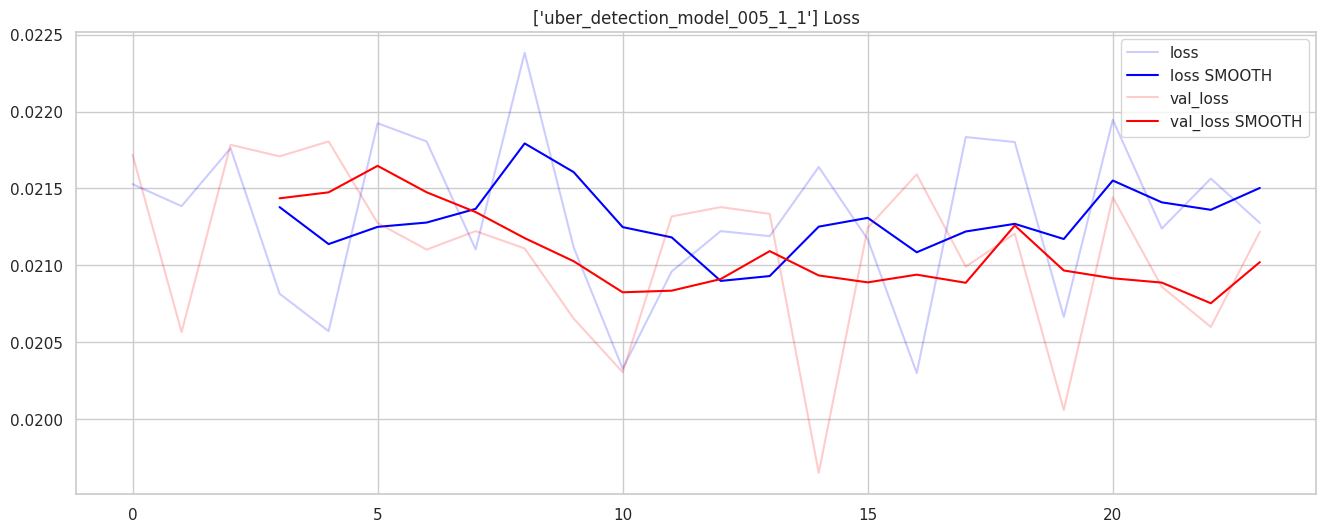

loading training log from /root/artem/analyser/training_reports/uber_detection_model_005_1_1.1.log.csv


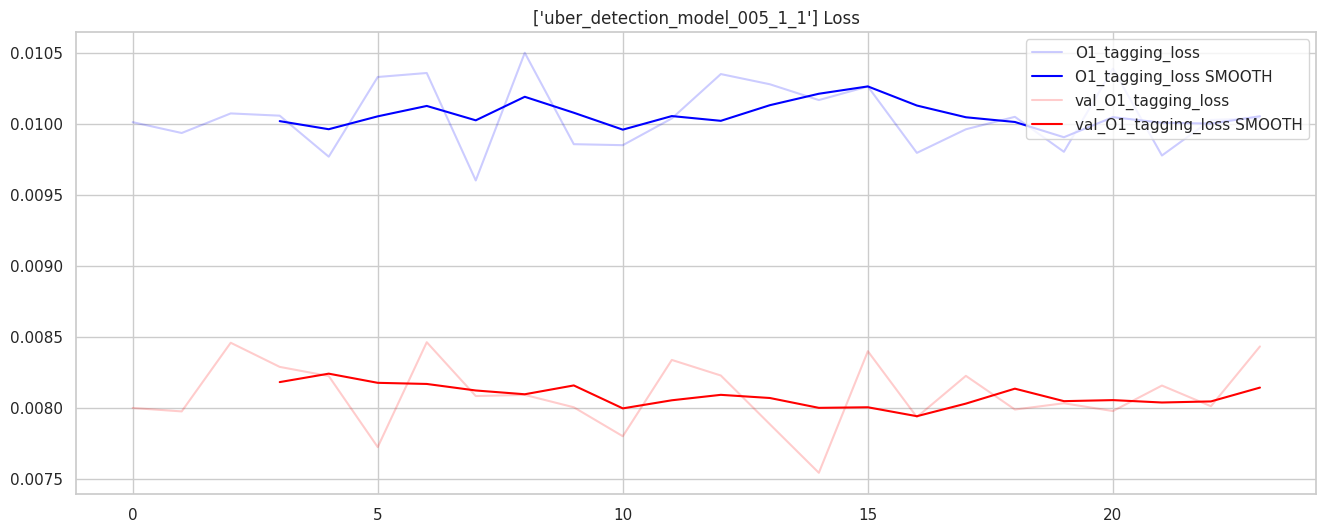

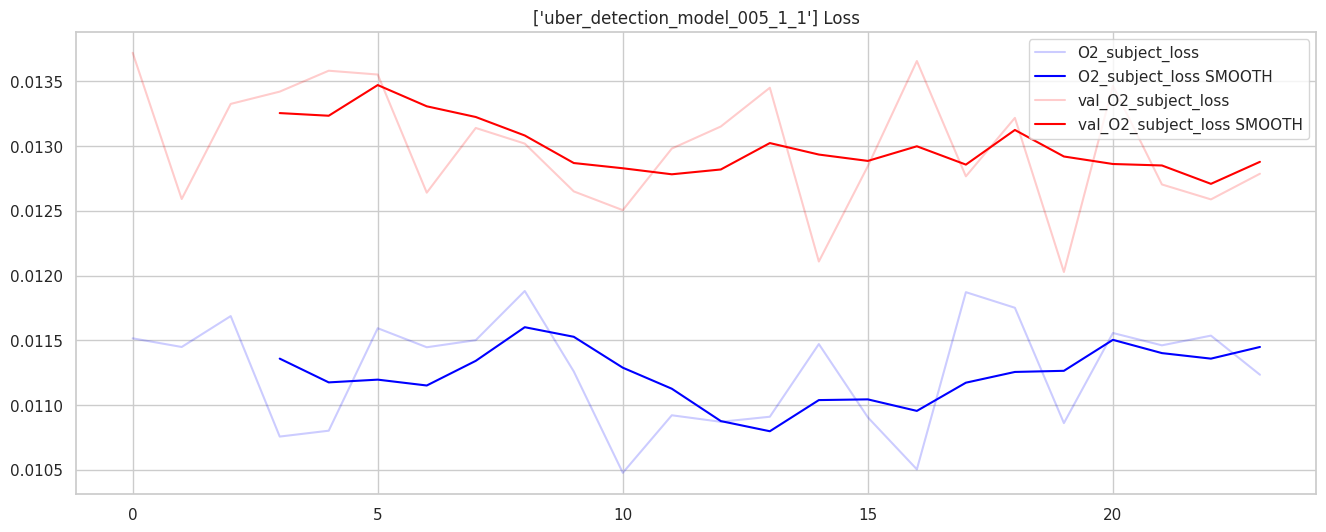

In [44]:
def plot_compare_models(
    models: [str],
    metrics, 
    title="metric/epoch",
    image_save_path = umtm.reports_dir):
    
  _metrics = [m for m in metrics if not m.startswith('val_')]

  for i, m in enumerate(models):

    data: pd.DataFrame = ctx.get_log(m)

    if data is not None:
      data.set_index('epoch')

      for metric in _metrics:
        plt.figure(figsize=(16, 6))
        plt.grid(True)
        plt.title(f'{metric} [{m}]')
        for metric_variant in ['', 'val_']:
          key = metric_variant + metric
          if key in data:

            x = data['epoch'][-100:]
            y = data[key][-100:]


            c = 'red'  # plt.cm.jet_r(i * colorstep)
            if metric_variant == '':
              c = 'blue'
            plt.plot(x, y, label=f'{key}', alpha=0.2, color=c)

            y = y.rolling(4, win_type='gaussian').mean(std=4)
            plt.plot(x, y, label=f'{key} SMOOTH', color=c)

            plt.legend(loc='upper right')

        
        plt.title(f'{[m]} {title}')
        plt.grid(True)
        img_path = os.path.join(image_save_path, f'{m}-{metric}.png')
        
        plt.savefig(img_path, bbox_inches='tight')        
        plt.show()
    else:
      logger.error('cannot plot')
    

models = list(ctx.trained_models.keys())


plot_compare_models(models, ['loss'], 'Loss')

# plot_compare_models(models, ['O1_tagging_kullback_leibler_divergence'], 'TAGS: Kullback Leibler divergence')
# plot_compare_models(models, ['O1_tagging_mse'], 'TAGS: MSE')
# plot_compare_models(models, ['O2_subject_kullback_leibler_divergence'], 'Subj: Kullback Leibler divergence')
# plot_compare_models(models, ['O2_subject_mse'],  'Subjects: MSE')

plot_compare_models(models, ['O1_tagging_loss', 'O2_subject_loss'], 'Loss')



## Contract subj Confusion matrices

In [45]:
# umtm.stats
# semantic_map_keys_contract


6340244c9d08c565cfa12341


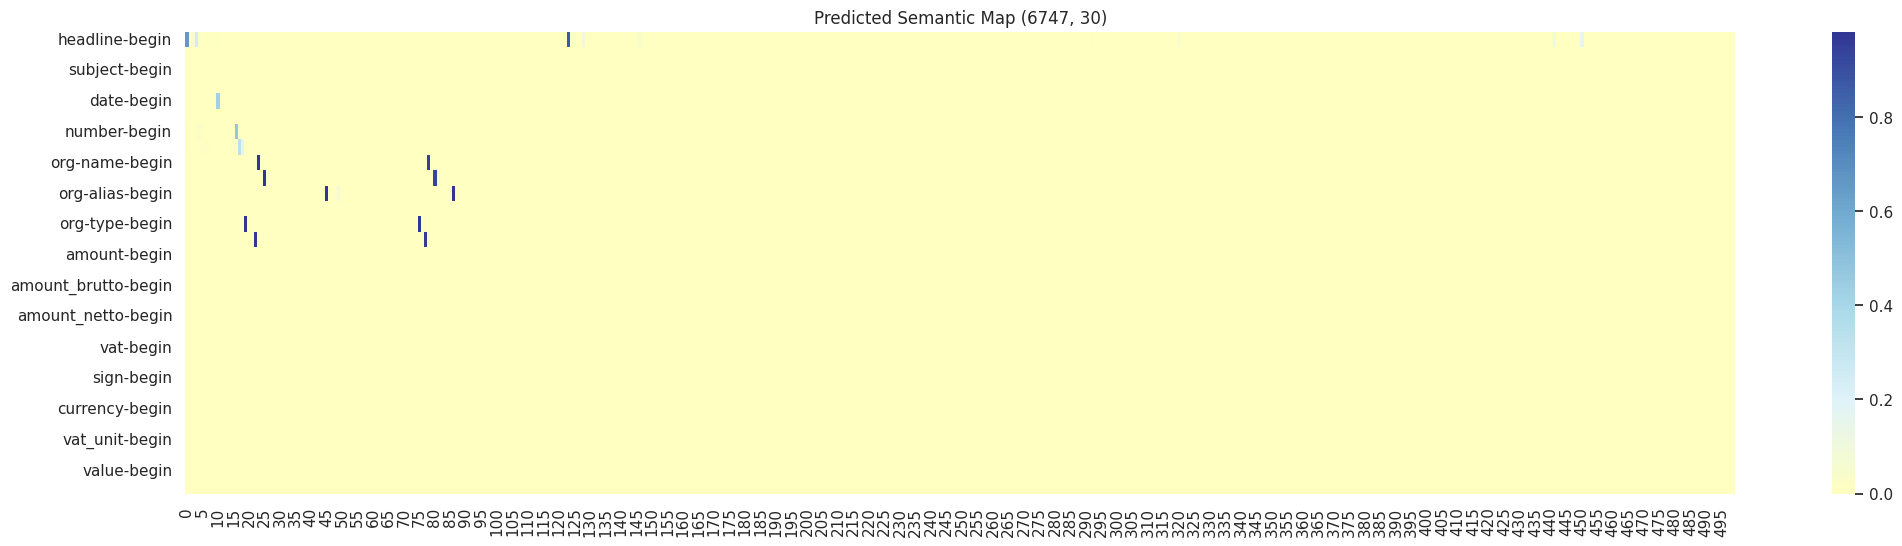

In [46]:
from tf_support.super_contract_model import make_xyw

sample_index = umtm.stats [umtm.stats['value']>0].index[2]
print(sample_index)

x, y, _ = make_xyw(sample_index, umtm.stats)

prediction = umodel.predict(x=[np.expand_dims(x[0], axis=0), np.expand_dims(x[1], axis=0)], batch_size=1)

tagsmap = pd.DataFrame(prediction[0][0], columns=semantic_map_keys_contract)
# .T
plot_embedding(tagsmap[:500], f'Predicted Semantic Map {tagsmap.shape}')

In [47]:
from analyser.contract_parser import nn_get_tag_values

<span id="papermill-error-cell" style="color:red; font-family:Helvetica Neue, Helvetica, Arial, sans-serif; font-size:2em;">Execution using papermill encountered an exception here and stopped:</span>

In [48]:

agent_tags = ['org-1-name',
              'org-1-type',
              'org-1-alias',
              'org-2-name',
              'org-2-type',
              'org-2-alias']
solo_tags = [
  'date',
  'number',
  'sign_value_currency/value',
  'sign_value_currency/currency',
  'sign_value_currency/sign'
]

# seq_labels_contract[-3:]

tagnames = solo_tags + agent_tags


from pandas import DataFrame

from analyser.contract_agents import ContractAgent, normalize_contract_agent
from analyser.documents import TextMap
from analyser.ml_tools import SemanticTag
from analyser.persistence import DbJsonDoc
from analyser.text_tools import find_top_spans
# from tf_support.super_contract_model import seq_labels_contract
from tf_support.tf_subject_model import decode_subj_prediction

from analyser.contract_parser import nn_find_org_names, nn_get_tag_value




def fetch_tags_from_predicted_semantic_map(_id: str, tagsmap: DataFrame):
  jdoc = get_doc(_id)
  _map = jdoc.get_tokens_map_unchaged()

  results = {}
  for key in tagnames:
    t = nn_get_tag_value(key, _map, tagsmap )
    results[key] = t
    # print(t)

#   ca = ContractAgent()
#   ca.name =  results['org-1-name'] #TODO: check for NONE
#   ca.type =  results['org-1-type']
#   ca.alias = results['org-1-alias']
   

#   ca2 = ContractAgent()
#   ca2.name =  results['org-2-name'] #TODO: check for NONE
#   ca2.type =  results['org-2-type']
#   ca2.alias = results['org-2-alias']
#   try:
#     normalize_contract_agent(ca)
#     normalize_contract_agent(ca2)
#   except Exception as e:
#         # TODO:
#     logger.error(f'{_id} {e}')

  if results['number'] is not None:
    results['number'].value = results['number'].value.strip().lstrip('№').lstrip('N ').lstrip()

  return results, jdoc


def put_results_into_df(id_, results, df, jdoc: DbJsonDoc):
  org_atribs = ['name', 'alias', 'type']

  def v(x):
    if results[x] is not None:
      return results[x].value

  def swap(a, b):
    ab = [a, b]
    try:
      ab = sorted(ab)
    except:
      pass
    return ab

  def s(a, b):
    ab = swap(v(a), v(b))
    df.at[id_, f'p-{a}'] = ab[0]
    df.at[id_, f'p-{b}'] = ab[1]
    return ab

  for key in org_atribs:
    arr = s(f'org-1-{key}', f'org-2-{key}')

  def p(key):
    df.at[id_, f'p-{key}'] = v(key)

  p('sign_value_currency/value')
  p('sign_value_currency/currency')
  p('sign_value_currency/sign')

  p('date')
  p('number')

  # get_expected values
  for key in solo_tags:
    t = jdoc.get_attribute_value(key)
    df.at[id_, f'{key}'] = t

  for key in org_atribs:
    orgs = swap(jdoc.get_attribute_value(f'org-1-{key}'), jdoc.get_attribute_value(f'org-2-{key}'))
    df.at[id_, f'org-1-{key}'] = orgs[0]
    df.at[id_, f'org-2-{key}'] = orgs[1]



ImportError: cannot import name 'nn_get_tag_value' from 'analyser.contract_parser' (/root/artem/analyser/analyser/contract_parser.py)

In [ ]:
def make_subj_predictions(umodel, indices):
  ev = umtm.stats.copy()
  tags = pd.DataFrame()
  for t in tagnames:
    tags['p-' + t] = ''
    tags[t] = ''

  errors_report = pd.DataFrame()
  errors_report['expected'] = ''
  errors_report['predicted'] = ''

  for i, _id in enumerate(indices):
    logger.debug(f'validating {_id} {i} of {len(indices)}')
    
    x, y, _ = make_xyw(_id, umtm.stats)

    prediction = umodel.predict(x=[np.expand_dims(x[0], axis=0), np.expand_dims(x[1], axis=0)], batch_size=1)

    tagsmap = pd.DataFrame(prediction[0][0], columns=seq_labels_contract)
  
    r, jdoc = fetch_tags_from_predicted_semantic_map(_id, tagsmap)
    put_results_into_df(_id, r, tags, jdoc)
    

    subj_1hot = prediction[1][0]

    expected = decode_subj_prediction(y[1])[0]
    predicted = decode_subj_prediction(subj_1hot)[0]

    ev.at[_id, 'expected_subj'] = expected.name
    ev.at[_id, 'predicted_subj'] = predicted.name

    ev.at[_id, 'wrong'] = False
    if expected != predicted:
      ev.at[_id, 'wrong'] = True

  return ev, tags

ev, tags = make_subj_predictions(umodel, [sample_index])
tags

In [ ]:
%%time




# def fetch_tag_value(tagname: str, textmap: TextMap, tagging: DataFrame, threshold=0.3) -> SemanticTag or None:
#   att = tagging[tagname].values
#   slices = find_top_spans(att, threshold=threshold, limit=1) #TODO: estimate per-tag thresholds
  
#   if len(slices) > 0:
#     span = slices[0].start, slices[0].stop
#     value = textmap.text_range(span)
#     tag = SemanticTag(tagname, value, span)
#     tag.confidence = att[slices[0]].mean()
#     return tag
#   return None










subset = umtm.stats #umtm.stats[~pd.isna(umtm.stats['user_correction_date'])].sort_values('analyze_date')
_indices =  subset.index
ev, tags = make_subj_predictions(umodel, _indices)
tags.to_csv('all_contracts_predicstions.csv')

In [ ]:
# subset = umtm.stats[~pd.isna(umtm.stats['user_correction_date'])]
# pd.isna(umtm.stats['user_correction_date'])
ev 

In [ ]:
# _cols = [  'wrong' ]
# _tmp = ev[cols]
# errors_report = _tmp[ _tmp.wrong == True] #.sort_values('subject')
# print(len(errors_report), 'wrong subjects of', len(tags))
# errors_report 

ev['predicted_subj']
subj_df = ev[['predicted_subj', 'expected_subj']].copy()

In [ ]:
subj_df

In [ ]:
def make_report(umodel, ev):
  plot_cm(ev['expected_subj'], ev['predicted_subj'])
  
  img_path = os.path.join(umtm.work_dir, f'subjects-confusion-matrix-{umodel.name}.png')
  plt.savefig(img_path, bbox_inches='tight')

  report = classification_report(ev['expected_subj'], ev['predicted_subj'], digits=3)
  print(umodel.name)
  print(report)
  
  with open(os.path.join(umtm.work_dir, f'subjects-classification_report-{umodel.name}.txt'), "w") as text_file:
    text_file.write(report)


subj_df = ev[['predicted_subj', 'expected_subj']].copy() #ev[~pd.isna(ev['predicted_subj'])]
make_report(umodel, subj_df)

# Evaluate tags detection

In [ ]:
tags.fillna('-', inplace=True)
tags

In [ ]:
def save_csv(d, f):
    fn = os.path.join(umtm.work_dir, f)
    d.to_csv(fn)

### Contract number validation

In [ ]:
wrong_numbers = tags [ tags['number'] != tags['p-number']].sort_values('number')
print( f'Contract numbers: {len(wrong_numbers)} of {len(tags)}  ({100. * len(wrong_numbers) / len(tags) :0.1f}%) were detected wronggly')

save_csv( wrong_numbers[['p-number', 'number']], 'wrong_numbers.csv')

# wrong_numbers[['p-number', 'number']].tail(10)

In [ ]:
tags ['sign_value_currency/currency'].head(100)

In [ ]:
def conv(x):
    if type(x) is str:
        v = x.replace(',','.').replace(' ','')
    else: 
        v=x
    try:
        v=float(v)
    except:
        v=np.nan
    return v 

tags['n-p-sign_value_currency/value'] = pd.to_numeric( tags['p-sign_value_currency/value'].apply(conv) )
tags['n-sign_value_currency/value']   = pd.to_numeric( tags['sign_value_currency/value'].apply(conv) )

In [ ]:
wrong_values = tags [  tags['n-p-sign_value_currency/value']  != tags['n-sign_value_currency/value']]
cols = ['n-p-sign_value_currency/value', 'n-sign_value_currency/value']
wrong_values = wrong_values[cols]

wrong_values ['val_err'] = \
    np.log1p( np.abs(wrong_values['n-p-sign_value_currency/value'] - wrong_values['n-sign_value_currency/value']))
wrong_values = wrong_values.sort_values('val_err', ascending=False)

print(len(wrong_values))
wrong_values.tail(24)

### Contract Org-1 validation

In [ ]:


wrong_orgs1 = tags [ (tags['org-1-name'] != tags['p-org-1-name']) | (tags['org-2-name'] != tags['p-org-2-name']) ]
print( f'Org-1 name: {len(wrong_orgs1)} of {len(tags)}  ({100. * len(wrong_orgs1) / len(tags):0.1f}%) were detected incorrectly')

cols=['p-org-1-name', 'org-1-name', 'p-org-2-name', 'org-2-name']
save_csv( wrong_orgs1[cols], 'wrong_orgs1.csv')

wrong_orgs1[cols].head(20)

In [ ]:
wrong_aliases = tags [ (tags['org-1-alias'] != tags['p-org-1-alias']) | (tags['org-2-alias'] != tags['p-org-2-alias']) ]
print( f'Aliases: {len(wrong_aliases)} of {len(tags)}  ({100. * len(wrong_aliases) / len(tags) : 0.1f}%) were detected incorrectly')

cols=['p-org-1-alias', 'org-1-alias', 'p-org-2-alias', 'org-2-alias']
save_csv( wrong_aliases[cols], 'wrong_aliases.csv')
# wrong_aliases[cols].head(10)

In [ ]:
wrong_types = tags [ (tags['org-1-type'] != tags['p-org-1-type']) | (tags['org-2-type'] != tags['p-org-2-type'])]
print( f'Types: {len(wrong_types)} of {len(tags)}  ({100. * len(wrong_types) / len(tags) : 0.1f}%) were detected incorrectly')
cols=['p-org-1-type', 'p-org-2-type', 'org-1-type', 'org-2-type']
save_csv( wrong_types[cols], 'wrong_types.csv')
wrong_types[cols].head(10)

In [ ]:
from collections import Counter
arrays = [ wrong_orgs1, wrong_types, wrong_numbers, wrong_aliases]
counter = Counter()
for a in arrays:
  for i in a.index:
   counter[i]+=1
 

print('Самый сложный документ: ', counter.most_common()[0][0])
print("Всего недочетов:", len(counter))

In [ ]:
umtm.stats['errors'] = 0
for c in counter:
  umtm.stats.at[c, 'errors'] = counter[c]


calculate_samples_weights(umtm)
umtm._save_stats()
umtm.stats

## Single doc eval

In [ ]:
if IN_COLAB:
  !wget https://raw.githubusercontent.com/nemoware/analyser/uber-models/tests/contract_db_1.json

  with open('contract_db_1.json', 'rb') as handle:    
    jdata = json.load(handle, object_hook=json_util.object_hook)

  jdoc = DbJsonDoc(jdata)

else:
  from integration.db import get_mongodb_connection
  from bson.objectid import ObjectId

  def get_doc(objid):
    logger.debug(f'fetching {objid}')
    db = get_mongodb_connection()
    documents_collection = db['documents']
    jdata =  documents_collection.find_one({'_id': ObjectId(objid)})
    return DbJsonDoc(jdata)

  SAMPLE_DOC_ID = counter.most_common()[0][0] #umtm.stats.index[10]
    
    
    
  SAMPLE_DOC_ID = '5eea27adc28b75807f3dae66'
  print('SAMPLE_DOC_ID:', SAMPLE_DOC_ID)
  dp = umtm.make_xyw(SAMPLE_DOC_ID)
  (emb, tok_f), (sm, subj), (sample_weight, subject_weight) = dp

  jdoc = get_doc(SAMPLE_DOC_ID)

In [ ]:
from analyser.legal_docs import embedd_tokens

if IN_COLAB:
  embedder = ElmoEmbedder.get_instance('elmo')  # lazy init
  emb = embedd_tokens(jdoc.get_tokens_for_embedding(),
                             embedder,
                             verbosity=2,
                             log_key='tmp')

  tok_f = get_tokens_features(jdoc.get_tokens_map_unchaged().tokens)

In [ ]:
###############
prediction = umodel.predict(   x=[  np.expand_dims(emb, axis=0), np.expand_dims(tok_f, axis=0)] , batch_size=1)
##############
print(len(prediction), umodel.name)
subj_1hot = prediction[1][0]
print('Subject:', decode_subj_prediction(subj_1hot))


tagging = pd.DataFrame( prediction[0][0], columns=seq_labels_contract)
plot_embedding(tagging, title = f'Predictions of {umodel.name}')

In [ ]:
def render_slices(slices, tokens, attention_v, ht='') -> str:
  ht += '<ol>'
  for _s in slices:
    ht += '<li>'
    t = tokens[_s]
    l = attention_v[_s]
    ht += to_color_text(t, l, _range=(0, 1.2))
    ht += '<br><hr>'
    ht += '</li>'
  ht += '</ol>'

  return ht

for t in seq_labels_contract:
  spans = list( find_top_spans( tagging[t].values, threshold=0.3))  
  display(HTML(render_slices(spans, jdoc.get_tokens_map_unchaged().tokens, tagging[t].values)))


In [ ]:

# mean_ = tagging.values.max(-1)*0.5
# print (mean_.shape)
# display(HTML( to_color_text (jdoc.get_tokens_map_unchaged().tokens[:24000],  mean_[:24000])))

In [ ]:
ids = '5edbadd7da3678279fbcaabf
5edbc660da3678279fbcaeac
5edbc668da3678279fbcaf6e
5edbc65dda3678279fbcae56
5edbc66bda3678279fbcafe6
5edbc615da3678279fbcadc9'